In [1]:
# dataset
from torchvision import datasets

from functools import partial
import numpy as np

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# preprocessing
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split

# model
import torch
from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# hyperparameter tuning
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# 1. Load Data & Preprocessing

**Dataset**: <a href="https://www.cs.toronto.edu/~kriz/cifar.html" target="_blank">CIFAR-10</a>

**Classes**: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

The following transformations are tested:
* **normalization**: from [0, 255] to [0, 1]
* **standardization**: by substracting the mean and dividing with std

In [2]:
def load_data(data_dir):
    """ Create train and test pytorch dataset objects from CIFAR-10.
    
    The following tranformations are applied on CIFAR-10:
        * normalization: from [0, 255] to [0, 1] by dividing with 255,
        * standardization: by substracting the mean and dividing with std
    
    Args:
        data_dir:
            directory where data will be saved, as a string.
    
    Returns:
        train and test dataset, as pytorch dataset objects.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))
    ])

    trainset = datasets.CIFAR10(root=data_dir,
                                train=True, 
                                download=True, 
                                transform=transform)

    testset = datasets.CIFAR10(root=data_dir, 
                               train=False, 
                               download=True, 
                               transform=transform)

    return trainset, testset

In [3]:
trainset, testset = load_data(data_dir='cifar10-pytorch')

print(f'\nTraining data:\n--------------\n{trainset}')
print(f'Test data:\n--------------\n{testset}')

Files already downloaded and verified
Files already downloaded and verified

Training data:
--------------
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10-pytorch
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))
           )
Test data:
--------------
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: cifar10-pytorch
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))
           )


In [4]:
batch_size = 64

train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# 2. Network Architecture

Activations:
* ReLU activation function **(hidden layer)**
* Softmax activation function **(output layer)**

Regularization:
* Weight decay (L2 regularization)
* Dropout layers

Normalization:
* Batch normalization

Loss Function:
* Cross Entropy Loss

Optimizer and Scheduler:
* Adam optimizer
* ReduceLROnPlateau scheduler

In [5]:
class NeuralNetwork(nn.Module):
    """ Neural network for multiclass classification.
    
    This neural network uses a ReLU activation function in hidden layers and a Softmax activation 
    function in output layer. Also, dropout and batch normalization layers have been defined.
    The hyperparameters of the neural network are:
        * number of hidden layers,
        * size of hidden layers (number of neurons),
        * use of batch normalization,
        * probability of dropout layer.
    
    Arguments:
        input_size:
            size of input, as an integer.
        hidden_size:
            number of neurons in hidden layers, as an integer.
        output_size:
            size of output (number of labels), as an integer.
        num_layers:
            number of hidden layers, as an integer.
        norm:
            use, or not, batch normalization, as boolean.
        p:
            dropout probability, as a float.
    """
    
    def __init__(self, input_size, hidden_size, output_size, num_layers, norm, p):
        """ Initialize neural network.
        
        Args:
            input_size:
                size of input, as an integer.
            hidden_size:
                number of neurons in hidden layers, as an integer.
            output_size:
                size of output (number of labels), as an integer.
            num_layers:
                number of hidden layers, as an integer.
            norm:
                use, or not, batch normalization, as boolean.
            p:
                dropout probability, as a float.
        """
        super(NeuralNetwork, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.norm = norm
        self.p = p
        
        # activation function
        self.activation = nn.ReLU()
        
        # flatten layer
        self.flatten = nn.Flatten()
        
        # dropout layer
        self.dropout = nn.Dropout(p)
        
        # batch normalization layer
        if norm:
            self.batch_norm = nn.BatchNorm1d(hidden_size)
        
        # input layer
        self.input_linear = nn.Linear(input_size, hidden_size)
        
        # hidden layers
        self.hidden_linears = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_layers)])
        
        # output layer
        self.output_linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # flatten input
        logits = self.flatten(x)
        
        # input layer
        pre = self.input_linear(logits)
        if self.norm:
            normalized = self.batch_norm(pre)
            post = self.activation(normalized)
        else:
            post = self.activation(pre)
        logits = self.dropout(post)
        
        # hidden layers
        for i, layer in enumerate(self.hidden_linears):
            pre = layer(logits)
            if self.norm:
                normalized = self.batch_norm(pre)
                post = self.activation(normalized)
            else:
                post = self.activation(pre)
            logits = self.dropout(post)
        
        # output layer
        logits = self.output_linear(logits)
        
        return logits

# 3. Hyperparameter Tuning

We'll use **early stopping** with **ASHAScheduler** to stop bad trials earlier.

|                               | Validation Loss | Validation Accuracy |
| :---------------------------: | :-------------: | :-----------------: |
| w/ batch normalization        | 1.64            | 45%                 |
| w/o batch normalization       | 1.26            | 55%                 |


Best trial **configuration** for nn **w/ batch normalization**: num_layers: 1, hidden_size: 200, lr: 0.0001, p: 0.4, l2: 0.001

Best trial **configuration** for nn **w/o batch normalization**: num_layers: 1, hidden_size: 200, lr: 0.0001, p: 0.5, l2: 0.0001

In [6]:
def tune_helper(config, trainset, input_size, num_labels, batch_size, epochs):
    """ Fit neural network and test it on a hold-out validation set.
    
    The validation set is a 20% hold-out set of the training set. 
    The loss function used is Cross Entropy Loss.
    The optimer used is Adam and the scheduler that wraps the optimizer is ReduceLROnPlateau.
    The metric used is accuracy score.
    
    Args:
        config:
            hyperparameters of neural network, as a dictionary.
        trainset:
            training dataset, as a pytorch object.
        input_size:
            size of input, as an integer.
        num_labels:
            number of labels, as an integer.
        batch_size:
            size of batches to be processed, as an integer.
        epochs:
            number of epochs (times the neural network will see the data), as an integer.
    """
    model = NeuralNetwork(input_size=input_size,
                          hidden_size=config['hidden_size'],
                          output_size=num_labels,
                          num_layers=config['num_layers'], 
                          norm=False,
                          p=config['p'])
    
    # support data parallel training on multiple GPUs
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)
    
    # loss function
    loss_fn = nn.CrossEntropyLoss()
    
    # optimizer
    optimizer = AdamW(model.parameters(), lr=config['lr'], weight_decay=config['l2'])
    
    #scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min')
    
    # split data: training (80%) - validation (20%)
    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(trainset, [test_abs, len(trainset) - test_abs])

    train_dataloader = DataLoader(train_subset,
                                  batch_size=batch_size,
                                  shuffle=True, 
                                  num_workers=2)
    
    val_dataloader = DataLoader(val_subset,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=2)
    
    for epoch in range(epochs):
        # fit neural network on training data
        model.train()  # put on train mode
        for batch, (X, Y) in enumerate(train_dataloader, 0):
            # send the data to the GPU memory explicitly
            X, Y = X.to(device), Y.to(device)

            # reset the gradients
            optimizer.zero_grad()
            
            # compute prediction
            pred = model(X)

            # compute loss
            loss = loss_fn(pred, Y)

            # backpropagate
            loss.backward()

            # update parameters
            optimizer.step()
        
        # test on validation data
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        model.eval()  # put on evaluation mode
        for batch, (X, Y) in enumerate(val_dataloader, 0):
            with torch.no_grad():
                X, Y = X.to(device), Y.to(device)

                pred = model(X)
                
                _, predicted = torch.max(pred.data, 1)
                total += Y.size(0)
                correct += (predicted == Y).sum().item()

                loss = loss_fn(pred, Y)
                val_loss += loss.cpu().numpy()
                val_steps += 1
        
        # update scheduler
        scheduler.step(val_loss)
        
        # report metrics
        tune.report(loss=(val_loss / val_steps), accuracy=(correct / total))

In [7]:
def hyperparameter_tune(data_dir,
                        batch_size,
                        epochs,
                        config,
                        grace_period,
                        num_samples, 
                        cpus_per_trial,
                        gpus_per_trial):
    """ Run hyperparameter tuning and report best hyperparameters.
    
    Args:
        data_dir:
            directory where CIFAR-10 data will be saved/loaded, as a string.
        batch_size:
            size of batches to be processed, as an integer.
        epochs:
            number of epochs (times the neural network will see the data), as an integer.
        config:
            hyperparametes, as a dictionary.
        grace_period:
            stop trials at least this old in time, as an integer.
        num_samples:
            number of times to sample from the hyperparameter space (if grid_search is provided as an argument,
            the grid will be repeated num_samples of times), as an integer.
        cpus_per_trial:
            CPUs to allocate per trial, as integer.
        gpus_per_trial:
            GPUs to allocate per trial, as integer.
    """
    trainset, testset = load_data(data_dir=data_dir)
    
    input_size = trainset[0][0].shape[0] * trainset[0][0].shape[1] * trainset[0][0].shape[2]
    num_labels = 10
    
    # hyperparameter search space
    cofig = config
    
    # used for early stopping
    scheduler = ASHAScheduler(metric="loss", 
                              mode="min",
                              max_t=epochs,
                              grace_period=grace_period,
                              reduction_factor=2)
    
    reporter = CLIReporter(metric_columns=["loss", "accuracy", "training_iteration"])
    
    # hyperparamet tuning
    result = tune.run(partial(tune_helper, 
                              trainset=trainset,
                              input_size=input_size, 
                              num_labels=num_labels,
                              batch_size=batch_size,
                              epochs=epochs),
                      resources_per_trial={"cpu": cpus_per_trial, "gpu": gpus_per_trial},
                      config=config,
                      num_samples=num_samples,
                      scheduler=scheduler,
                      progress_reporter=reporter)
    
    # report best results
    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))
    print("Best trial final validation acurracy: {}".format(best_trial.last_result["accuracy"]))

In [8]:
# hyperparameter search space
config = {
    "hidden_size": tune.grid_search([100, 150, 200]),
    "num_layers": tune.grid_search([1, 3, 5]),
    "p": tune.grid_search([0.4, 0.5, 0.6]),
    "lr": tune.grid_search([1e-3, 1e-4]),
    "l2": tune.grid_search([1e-3, 1e-4]),
    }

In [9]:
hyperparameter_tune(data_dir='cifar10-pytorch',
                    batch_size=64,
                    epochs=100,
                    config=config,
                    grace_period=10,
                    num_samples=1, 
                    cpus_per_trial=2,
                    gpus_per_trial=0)

Files already downloaded and verified
Files already downloaded and verified


2021-08-24 08:48:04,076	INFO services.py:1247 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-24 08:48:05,396	WARNING experiment.py:296 -- No name detected on trainable. Using DEFAULT.
2021-08-24 08:48:05,397	INFO registry.py:67 -- Detected unknown callable for trainable. Converting to class.
2021-08-24 08:48:05,399	WARNING function_runner.py:545 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2021-08-24 08:48:20,943	WARNING worker.py:1189 -- Warning: The actor ImplicitFunc has size 153708708 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Memory usage on this node: 3.9/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 16/108 (15 PENDING, 1 RUNNING)
+---------------------+----------+-------+---------------+--------+--------+--------------+-----+
| Trial name          | status   | loc   |   hidden_size |     l2 |     lr |   num_layers |   p |
|---------------------+----------+-------+---------------+--------+--------+--------------+-----|
| DEFAULT_0078d_00000 | RUNNING  |       |           100 | 0.001  | 0.001  |            1 | 0.4 |
| DEFAULT_0078d_00001 | PENDING  |       |           150 | 0.001  | 0.001  |            1 | 0.4 |
| DEFAULT_0078d_00002 | PENDING  |       |           200 | 0.001  | 0.001  |            1 | 0.4 |
| DEFAULT_0078d_00003 | PENDING  |  

2021-08-24 08:48:27,762	WARNING util.py:164 -- The `start_trial` operation took 1.216 s, which may be a performance bottleneck.
2021-08-24 08:48:28,965	WARNING util.py:164 -- The `start_trial` operation took 1.101 s, which may be a performance bottleneck.
2021-08-24 08:48:30,071	WARNING util.py:164 -- The `start_trial` operation took 0.998 s, which may be a performance bottleneck.
2021-08-24 08:48:31,196	WARNING util.py:164 -- The `start_trial` operation took 1.022 s, which may be a performance bottleneck.
2021-08-24 08:48:32,580	WARNING util.py:164 -- The `start_trial` operation took 1.273 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 18/108 (16 PENDING, 2 RUNNING)
+---------------------+----------+-------+---------------+--------+--------+--------------+-----+
| Trial name          | status   | loc   |   hidden_size |     l2 |     lr |   num_layers |   p |
|---------------------+----------+-------+---------------+--------+--------+--------------+-----|
| DEFAULT_0078d_00000 | RUNNING  |       |           100 | 0.001  | 0.001  |            1 | 0.4 |
| DEFAULT_0078d_000

2021-08-24 08:48:33,693	WARNING util.py:164 -- The `start_trial` operation took 1.005 s, which may be a performance bottleneck.
2021-08-24 08:48:34,743	WARNING util.py:164 -- The `start_trial` operation took 0.938 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.3902
  date: 2021-08-24_08-48-36
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.7009850664503257
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 13.406774520874023
  time_this_iter_s: 13.406774520874023
  time_total_s: 13.406774520874023
  timestamp: 1629794916
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00000
  


2021-08-24 08:48:37,394	WARNING util.py:164 -- The `start_trial` operation took 1.251 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00001:
  accuracy: 0.4079
  date: 2021-08-24_08-48-41
  done: false
  experiment_id: 826aa01f630a419a80c6ab17e76cf8eb
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.709898970688984
  node_ip: 10.0.0.4
  pid: 2817
  time_since_restore: 16.284302473068237
  time_this_iter_s: 16.284302473068237
  time_total_s: 16.284302473068237
  timestamp: 1629794921
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00001
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08

2021-08-24 08:48:42,964	WARNING util.py:164 -- The `start_trial` operation took 1.113 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4144
  date: 2021-08-24_08-48-48
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.6662512843016606
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 25.806079387664795
  time_this_iter_s: 12.399304866790771
  time_total_s: 25.806079387664795
  timestamp: 1629794928
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_0

2021-08-24 08:48:49,514	WARNING util.py:164 -- The `start_trial` operation took 0.967 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00001:
  accuracy: 0.4215
  date: 2021-08-24_08-48-55
  done: false
  experiment_id: 826aa01f630a419a80c6ab17e76cf8eb
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.6533228363960413
  node_ip: 10.0.0.4
  pid: 2817
  time_since_restore: 30.14715600013733
  time_this_iter_s: 13.862853527069092
  time_total_s: 30.14715600013733
  timestamp: 1629794935
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00001
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-

2021-08-24 08:48:56,628	WARNING util.py:164 -- The `start_trial` operation took 0.900 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4336
  date: 2021-08-24_08-49-00
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.6077229718493808
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 38.111000537872314
  time_this_iter_s: 12.30492115020752
  time_total_s: 38.111000537872314
  timestamp: 1629794940
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08

2021-08-24 08:49:01,694	WARNING util.py:164 -- The `start_trial` operation took 0.829 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00001:
  accuracy: 0.4365
  date: 2021-08-24_08-49-09
  done: false
  experiment_id: 826aa01f630a419a80c6ab17e76cf8eb
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.6169786529176553
  node_ip: 10.0.0.4
  pid: 2817
  time_since_restore: 43.919623374938965
  time_this_iter_s: 13.772467374801636
  time_total_s: 43.919623374938965
  timestamp: 1629794949
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00001
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_0

2021-08-24 08:49:10,711	WARNING util.py:164 -- The `start_trial` operation took 1.218 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4357
  date: 2021-08-24_08-49-13
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.6016547057279356
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 50.56842589378357
  time_this_iter_s: 12.457425355911255
  time_total_s: 50.56842589378357
  timestamp: 1629794953
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00000
  


2021-08-24 08:49:14,348	WARNING util.py:164 -- The `start_trial` operation took 1.039 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00001:
  accuracy: 0.4487
  date: 2021-08-24_08-49-23
  done: false
  experiment_id: 826aa01f630a419a80c6ab17e76cf8eb
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.5854460076921304
  node_ip: 10.0.0.4
  pid: 2817
  time_since_restore: 57.628650188446045
  time_this_iter_s: 13.70902681350708
  time_total_s: 57.628650188446045
  timestamp: 1629794963
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00001
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08

2021-08-24 08:49:24,220	WARNING util.py:164 -- The `start_trial` operation took 1.027 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4485
  date: 2021-08-24_08-49-25
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.5711986745239064
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 62.85065698623657
  time_this_iter_s: 12.282231092453003
  time_total_s: 62.85065698623657
  timestamp: 1629794965
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00000
  


2021-08-24 08:49:26,673	WARNING util.py:164 -- The `start_trial` operation took 1.083 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00001:
  accuracy: 0.4586
  date: 2021-08-24_08-49-37
  done: false
  experiment_id: 826aa01f630a419a80c6ab17e76cf8eb
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.5702966314971827
  node_ip: 10.0.0.4
  pid: 2817
  time_since_restore: 71.76424217224121
  time_this_iter_s: 14.135591983795166
  time_total_s: 71.76424217224121
  timestamp: 1629794977
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00001
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-

2021-08-24 08:49:38,314	WARNING util.py:164 -- The `start_trial` operation took 0.985 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4569
  date: 2021-08-24_08-49-38
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.549663440437074
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 75.29429769515991
  time_this_iter_s: 12.44364070892334
  time_total_s: 75.29429769515991
  timestamp: 1629794978
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00000
  


2021-08-24 08:49:39,273	WARNING util.py:164 -- The `start_trial` operation took 0.948 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4501
  date: 2021-08-24_08-49-50
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.5528302473627078
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 87.78359818458557
  time_this_iter_s: 12.48930048942566
  time_total_s: 87.78359818458557
  timestamp: 1629794990
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-4

2021-08-24 08:49:51,575	WARNING util.py:164 -- The `start_trial` operation took 1.021 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00001:
  accuracy: 0.4565
  date: 2021-08-24_08-49-51
  done: false
  experiment_id: 826aa01f630a419a80c6ab17e76cf8eb
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.5475548072985024
  node_ip: 10.0.0.4
  pid: 2817
  time_since_restore: 86.44467210769653
  time_this_iter_s: 14.680429935455322
  time_total_s: 86.44467210769653
  timestamp: 1629794991
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00001
  


2021-08-24 08:49:53,074	WARNING util.py:164 -- The `start_trial` operation took 1.074 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4511
  date: 2021-08-24_08-50-02
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.5450031430857956
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 100.19032192230225
  time_this_iter_s: 12.406723737716675
  time_total_s: 100.19032192230225
  timestamp: 1629795002
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_0

2021-08-24 08:50:04,237	WARNING util.py:164 -- The `start_trial` operation took 1.263 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00001:
  accuracy: 0.4581
  date: 2021-08-24_08-50-06
  done: false
  experiment_id: 826aa01f630a419a80c6ab17e76cf8eb
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.5297708051979162
  node_ip: 10.0.0.4
  pid: 2817
  time_since_restore: 100.67763543128967
  time_this_iter_s: 14.23296332359314
  time_total_s: 100.67763543128967
  timestamp: 1629795006
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00001
  


2021-08-24 08:50:07,387	WARNING util.py:164 -- The `start_trial` operation took 1.155 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4568
  date: 2021-08-24_08-50-16
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.5418770267705249
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 113.4595787525177
  time_this_iter_s: 13.269256830215454
  time_total_s: 113.4595787525177
  timestamp: 1629795016
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-

2021-08-24 08:50:17,157	WARNING util.py:164 -- The `start_trial` operation took 0.937 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00001:
  accuracy: 0.4636
  date: 2021-08-24_08-50-20
  done: false
  experiment_id: 826aa01f630a419a80c6ab17e76cf8eb
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.536070939082249
  node_ip: 10.0.0.4
  pid: 2817
  time_since_restore: 114.5646984577179
  time_this_iter_s: 13.887063026428223
  time_total_s: 114.5646984577179
  timestamp: 1629795020
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00001
  


2021-08-24 08:50:21,157	WARNING util.py:164 -- The `start_trial` operation took 1.032 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4618
  date: 2021-08-24_08-50-28
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.5212453717638732
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 126.23777890205383
  time_this_iter_s: 12.778200149536133
  time_total_s: 126.23777890205383
  timestamp: 1629795028
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEF

2021-08-24 08:50:30,160	WARNING util.py:164 -- The `start_trial` operation took 1.168 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00001:
  accuracy: 0.4601
  date: 2021-08-24_08-50-34
  done: false
  experiment_id: 826aa01f630a419a80c6ab17e76cf8eb
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.525521599563064
  node_ip: 10.0.0.4
  pid: 2817
  time_since_restore: 128.6303985118866
  time_this_iter_s: 14.065700054168701
  time_total_s: 128.6303985118866
  timestamp: 1629795034
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00001
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_

2021-08-24 08:50:35,314	WARNING util.py:164 -- The `start_trial` operation took 1.118 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4653
  date: 2021-08-24_08-50-41
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 11
  loss: 1.514487310579628
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 138.91832971572876
  time_this_iter_s: 12.680550813674927
  time_total_s: 138.91832971572876
  timestamp: 1629795041
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFA

2021-08-24 08:50:42,908	WARNING util.py:164 -- The `start_trial` operation took 1.238 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00001:
  accuracy: 0.4616
  date: 2021-08-24_08-50-48
  done: true
  experiment_id: 826aa01f630a419a80c6ab17e76cf8eb
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.5303863241414355
  node_ip: 10.0.0.4
  pid: 2817
  time_since_restore: 143.0065257549286
  time_this_iter_s: 14.376127243041992
  time_total_s: 143.0065257549286
  timestamp: 1629795048
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00001
  
== Status ==
Memory usage on this node: 4.4/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.5258158479526545
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAUL

2021-08-24 08:50:50,267	WARNING util.py:164 -- The `start_trial` operation took 1.652 s, which may be a performance bottleneck.
2021-08-24 08:50:52,452	WARNING util.py:164 -- The `start_trial` operation took 0.800 s, which may be a performance bottleneck.
2021-08-24 08:50:53,434	WARNING util.py:164 -- The `start_trial` operation took 0.866 s, which may be a performance bottleneck.
2021-08-24 08:50:54,392	WARNING util.py:164 -- The `start_trial` operation took 0.853 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4706
  date: 2021-08-24_08-50-54
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 12
  loss: 1.5049638649460617
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 151.41504430770874
  time_this_iter_s: 12.49671459197998
  time_total_s: 151.41504430770874
  timestamp: 1629795054
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.5258158479526545
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFA

2021-08-24 08:50:55,563	WARNING util.py:164 -- The `start_trial` operation took 1.149 s, which may be a performance bottleneck.
2021-08-24 08:50:56,841	WARNING util.py:164 -- The `start_trial` operation took 1.175 s, which may be a performance bottleneck.
2021-08-24 08:50:57,930	WARNING util.py:164 -- The `start_trial` operation took 0.985 s, which may be a performance bottleneck.
2021-08-24 08:50:59,016	WARNING util.py:164 -- The `start_trial` operation took 0.984 s, which may be a performance bottleneck.
2021-08-24 08:51:00,039	WARNING util.py:164 -- The `start_trial` operation took 0.921 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.5258158479526545
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 19/108 (16 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+------------+---------------+---------------+------

2021-08-24 08:51:01,163	WARNING util.py:164 -- The `start_trial` operation took 1.013 s, which may be a performance bottleneck.
2021-08-24 08:51:02,432	WARNING util.py:164 -- The `start_trial` operation took 1.166 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4675
  date: 2021-08-24_08-51-08
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 13
  loss: 1.4817924484325822
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 165.36836338043213
  time_this_iter_s: 13.953319072723389
  time_total_s: 165.36836338043213
  timestamp: 1629795068
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.5258158479526545
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEF

2021-08-24 08:51:09,348	WARNING util.py:164 -- The `start_trial` operation took 1.215 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00002:
  accuracy: 0.3994
  date: 2021-08-24_08-51-10
  done: false
  experiment_id: e5b61d3573524f6aae3ea175191f6523
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.6980416106570297
  node_ip: 10.0.0.4
  pid: 2815
  time_since_restore: 18.017571687698364
  time_this_iter_s: 18.017571687698364
  time_total_s: 18.017571687698364
  timestamp: 1629795070
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00002
  


2021-08-24 08:51:11,849	WARNING util.py:164 -- The `start_trial` operation took 1.094 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4729
  date: 2021-08-24_08-51-20
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 14
  loss: 1.4907390387954227
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 178.04364037513733
  time_this_iter_s: 12.6752769947052
  time_total_s: 178.04364037513733
  timestamp: 1629795080
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.5258158479526545
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAU

2021-08-24 08:51:22,061	WARNING util.py:164 -- The `start_trial` operation took 1.263 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00002:
  accuracy: 0.426
  date: 2021-08-24_08-51-27
  done: false
  experiment_id: e5b61d3573524f6aae3ea175191f6523
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.6401003978814288
  node_ip: 10.0.0.4
  pid: 2815
  time_since_restore: 34.41294741630554
  time_this_iter_s: 16.395375728607178
  time_total_s: 34.41294741630554
  timestamp: 1629795087
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00002
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.5258158479526545
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_

2021-08-24 08:51:28,436	WARNING util.py:164 -- The `start_trial` operation took 1.266 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4762
  date: 2021-08-24_08-51-33
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 15
  loss: 1.4999869105162893
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 190.68069529533386
  time_this_iter_s: 12.637054920196533
  time_total_s: 190.68069529533386
  timestamp: 1629795093
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.5258158479526545
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEF

2021-08-24 08:51:34,530	WARNING util.py:164 -- The `start_trial` operation took 1.088 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00002:
  accuracy: 0.4414
  date: 2021-08-24_08-51-43
  done: false
  experiment_id: e5b61d3573524f6aae3ea175191f6523
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.5972348611066296
  node_ip: 10.0.0.4
  pid: 2815
  time_since_restore: 50.40029263496399
  time_this_iter_s: 15.987345218658447
  time_total_s: 50.40029263496399
  timestamp: 1629795103
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00002
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.5258158479526545
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT

2021-08-24 08:51:44,413	WARNING util.py:164 -- The `start_trial` operation took 1.268 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4815
  date: 2021-08-24_08-51-46
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 16
  loss: 1.4604299592364365
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 203.61085605621338
  time_this_iter_s: 12.930160760879517
  time_total_s: 203.61085605621338
  timestamp: 1629795106
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 0078d_00000
  


2021-08-24 08:51:47,387	WARNING util.py:164 -- The `start_trial` operation took 1.024 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4778
  date: 2021-08-24_08-51-58
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 17
  loss: 1.4621235709281484
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 216.06589341163635
  time_this_iter_s: 12.455037355422974
  time_total_s: 216.06589341163635
  timestamp: 1629795118
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.5258158479526545
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEF

2021-08-24 08:51:59,719	WARNING util.py:164 -- The `start_trial` operation took 0.884 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00002:
  accuracy: 0.4475
  date: 2021-08-24_08-51-59
  done: false
  experiment_id: e5b61d3573524f6aae3ea175191f6523
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.5903666163705716
  node_ip: 10.0.0.4
  pid: 2815
  time_since_restore: 66.30149102210999
  time_this_iter_s: 15.901198387145996
  time_total_s: 66.30149102210999
  timestamp: 1629795119
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00002
  


2021-08-24 08:52:00,820	WARNING util.py:164 -- The `start_trial` operation took 1.088 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4905
  date: 2021-08-24_08-52-11
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 18
  loss: 1.4553349701462277
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 228.4514503479004
  time_this_iter_s: 12.385556936264038
  time_total_s: 228.4514503479004
  timestamp: 1629795131
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.5258158479526545
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAU

2021-08-24 08:52:12,189	WARNING util.py:164 -- The `start_trial` operation took 0.957 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00002:
  accuracy: 0.4574
  date: 2021-08-24_08-52-15
  done: false
  experiment_id: e5b61d3573524f6aae3ea175191f6523
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.5605928472652557
  node_ip: 10.0.0.4
  pid: 2815
  time_since_restore: 82.62494397163391
  time_this_iter_s: 16.323452949523926
  time_total_s: 82.62494397163391
  timestamp: 1629795135
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00002
  


2021-08-24 08:52:16,375	WARNING util.py:164 -- The `start_trial` operation took 1.013 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4789
  date: 2021-08-24_08-52-23
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 19
  loss: 1.466080787075553
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 241.20396947860718
  time_this_iter_s: 12.752519130706787
  time_total_s: 241.20396947860718
  timestamp: 1629795143
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.5258158479526545
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFA

2021-08-24 08:52:25,128	WARNING util.py:164 -- The `start_trial` operation took 1.156 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00002:
  accuracy: 0.4461
  date: 2021-08-24_08-52-30
  done: false
  experiment_id: e5b61d3573524f6aae3ea175191f6523
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.5849962728038716
  node_ip: 10.0.0.4
  pid: 2815
  time_since_restore: 98.22718501091003
  time_this_iter_s: 15.602241039276123
  time_total_s: 98.22718501091003
  timestamp: 1629795150
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00002
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.5258158479526545
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT

2021-08-24 08:52:32,317	WARNING util.py:164 -- The `start_trial` operation took 1.351 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4837
  date: 2021-08-24_08-52-37
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 20
  loss: 1.4355349715348262
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 254.34893465042114
  time_this_iter_s: 13.144965171813965
  time_total_s: 254.34893465042114
  timestamp: 1629795157
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5258158479526545
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/

2021-08-24 08:52:38,146	WARNING util.py:164 -- The `start_trial` operation took 1.031 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00002:
  accuracy: 0.4565
  date: 2021-08-24_08-52-46
  done: false
  experiment_id: e5b61d3573524f6aae3ea175191f6523
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.5403765348871803
  node_ip: 10.0.0.4
  pid: 2815
  time_since_restore: 113.40549659729004
  time_this_iter_s: 15.178311586380005
  time_total_s: 113.40549659729004
  timestamp: 1629795166
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00002
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5258158479526545
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ra

2021-08-24 08:52:47,391	WARNING util.py:164 -- The `start_trial` operation took 1.244 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4784
  date: 2021-08-24_08-52-50
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 21
  loss: 1.462658803933745
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 267.575186252594
  time_this_iter_s: 13.226251602172852
  time_total_s: 267.575186252594
  timestamp: 1629795170
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 0078d_00000
  


2021-08-24 08:52:51,397	WARNING util.py:164 -- The `start_trial` operation took 1.080 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00002:
  accuracy: 0.4529
  date: 2021-08-24_08-53-02
  done: false
  experiment_id: e5b61d3573524f6aae3ea175191f6523
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.5549676099400611
  node_ip: 10.0.0.4
  pid: 2815
  time_since_restore: 129.45006108283997
  time_this_iter_s: 16.044564485549927
  time_total_s: 129.45006108283997
  timestamp: 1629795182
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00002
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5258158479526545
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ra

2021-08-24 08:53:03,232	WARNING util.py:164 -- The `start_trial` operation took 1.023 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.481
  date: 2021-08-24_08-53-03
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 22
  loss: 1.4550816078854214
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 280.54628109931946
  time_this_iter_s: 12.971094846725464
  time_total_s: 280.54628109931946
  timestamp: 1629795183
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: 0078d_00000
  


2021-08-24 08:53:04,441	WARNING util.py:164 -- The `start_trial` operation took 1.155 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4843
  date: 2021-08-24_08-53-15
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 23
  loss: 1.4531556732335669
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 293.1409740447998
  time_this_iter_s: 12.594692945480347
  time_total_s: 293.1409740447998
  timestamp: 1629795195
  timesteps_since_restore: 0
  training_iteration: 23
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5258158479526545
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ra

2021-08-24 08:53:16,879	WARNING util.py:164 -- The `start_trial` operation took 0.967 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00002:
  accuracy: 0.4711
  date: 2021-08-24_08-53-18
  done: false
  experiment_id: e5b61d3573524f6aae3ea175191f6523
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.5054540345623235
  node_ip: 10.0.0.4
  pid: 2815
  time_since_restore: 145.76500821113586
  time_this_iter_s: 16.3149471282959
  time_total_s: 145.76500821113586
  timestamp: 1629795198
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00002
  


2021-08-24 08:53:19,593	WARNING util.py:164 -- The `start_trial` operation took 1.090 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4777
  date: 2021-08-24_08-53-28
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 24
  loss: 1.471871936397188
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 305.85570335388184
  time_this_iter_s: 12.714729309082031
  time_total_s: 305.85570335388184
  timestamp: 1629795208
  timesteps_since_restore: 0
  training_iteration: 24
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5258158479526545
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/r

2021-08-24 08:53:29,798	WARNING util.py:164 -- The `start_trial` operation took 1.184 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00002:
  accuracy: 0.4645
  date: 2021-08-24_08-53-34
  done: false
  experiment_id: e5b61d3573524f6aae3ea175191f6523
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.5195026261032007
  node_ip: 10.0.0.4
  pid: 2815
  time_since_restore: 161.961767911911
  time_this_iter_s: 16.196759700775146
  time_total_s: 161.961767911911
  timestamp: 1629795214
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00002
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_

2021-08-24 08:53:35,986	WARNING util.py:164 -- The `start_trial` operation took 1.271 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4843
  date: 2021-08-24_08-53-41
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 25
  loss: 1.4588622097756452
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 318.9863157272339
  time_this_iter_s: 13.13061237335205
  time_total_s: 318.9863157272339
  timestamp: 1629795221
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray

2021-08-24 08:53:42,886	WARNING util.py:164 -- The `start_trial` operation took 1.152 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00002:
  accuracy: 0.4694
  date: 2021-08-24_08-53-50
  done: false
  experiment_id: e5b61d3573524f6aae3ea175191f6523
  hostname: cbir
  iterations_since_restore: 11
  loss: 1.4906112502334983
  node_ip: 10.0.0.4
  pid: 2815
  time_since_restore: 177.808021068573
  time_this_iter_s: 15.846253156661987
  time_total_s: 177.808021068573
  timestamp: 1629795230
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 0078d_00002
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_

2021-08-24 08:53:51,926	WARNING util.py:164 -- The `start_trial` operation took 1.362 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4906
  date: 2021-08-24_08-53-54
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 26
  loss: 1.432139511321001
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 332.1358926296234
  time_this_iter_s: 13.149576902389526
  time_total_s: 332.1358926296234
  timestamp: 1629795234
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 0078d_00000
  


2021-08-24 08:53:55,879	WARNING util.py:164 -- The `start_trial` operation took 0.988 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00002:
  accuracy: 0.4667
  date: 2021-08-24_08-54-07
  done: false
  experiment_id: e5b61d3573524f6aae3ea175191f6523
  hostname: cbir
  iterations_since_restore: 12
  loss: 1.493106075912524
  node_ip: 10.0.0.4
  pid: 2815
  time_since_restore: 194.46914291381836
  time_this_iter_s: 16.66112184524536
  time_total_s: 194.46914291381836
  timestamp: 1629795247
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 0078d_00002
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ra

2021-08-24 08:54:08,201	WARNING util.py:164 -- The `start_trial` operation took 0.965 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4883
  date: 2021-08-24_08-54-07
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 27
  loss: 1.4535975759955728
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 344.9962272644043
  time_this_iter_s: 12.860334634780884
  time_total_s: 344.9962272644043
  timestamp: 1629795247
  timesteps_since_restore: 0
  training_iteration: 27
  trial_id: 0078d_00000
  


2021-08-24 08:54:09,499	WARNING util.py:164 -- The `start_trial` operation took 1.268 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4866
  date: 2021-08-24_08-54-21
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 28
  loss: 1.441954685624238
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 358.4541115760803
  time_this_iter_s: 13.457884311676025
  time_total_s: 358.4541115760803
  timestamp: 1629795261
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray

2021-08-24 08:54:22,417	WARNING util.py:164 -- The `start_trial` operation took 1.212 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00002:
  accuracy: 0.4609
  date: 2021-08-24_08-54-23
  done: false
  experiment_id: e5b61d3573524f6aae3ea175191f6523
  hostname: cbir
  iterations_since_restore: 13
  loss: 1.5018784582235252
  node_ip: 10.0.0.4
  pid: 2815
  time_since_restore: 211.11938977241516
  time_this_iter_s: 16.6502468585968
  time_total_s: 211.11938977241516
  timestamp: 1629795263
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 0078d_00002
  


2021-08-24 08:54:25,005	WARNING util.py:164 -- The `start_trial` operation took 1.150 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4873
  date: 2021-08-24_08-54-34
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 29
  loss: 1.4472815102073038
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 371.50710916519165
  time_this_iter_s: 13.052997589111328
  time_total_s: 371.50710916519165
  timestamp: 1629795274
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/

2021-08-24 08:54:35,425	WARNING util.py:164 -- The `start_trial` operation took 1.172 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00002:
  accuracy: 0.4672
  date: 2021-08-24_08-54-39
  done: false
  experiment_id: e5b61d3573524f6aae3ea175191f6523
  hostname: cbir
  iterations_since_restore: 14
  loss: 1.4921829913072526
  node_ip: 10.0.0.4
  pid: 2815
  time_since_restore: 227.24916338920593
  time_this_iter_s: 16.12977361679077
  time_total_s: 227.24916338920593
  timestamp: 1629795279
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 0078d_00002
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/r

2021-08-24 08:54:41,140	WARNING util.py:164 -- The `start_trial` operation took 1.137 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4752
  date: 2021-08-24_08-54-47
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 30
  loss: 1.4541329449149454
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 384.72531390190125
  time_this_iter_s: 13.218204736709595
  time_total_s: 384.72531390190125
  timestamp: 1629795287
  timesteps_since_restore: 0
  training_iteration: 30
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/

2021-08-24 08:54:48,710	WARNING util.py:164 -- The `start_trial` operation took 1.239 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00002:
  accuracy: 0.4758
  date: 2021-08-24_08-54-56
  done: false
  experiment_id: e5b61d3573524f6aae3ea175191f6523
  hostname: cbir
  iterations_since_restore: 15
  loss: 1.4634307243262128
  node_ip: 10.0.0.4
  pid: 2815
  time_since_restore: 243.59707069396973
  time_this_iter_s: 16.347907304763794
  time_total_s: 243.59707069396973
  timestamp: 1629795296
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 0078d_00002
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/

2021-08-24 08:54:57,519	WARNING util.py:164 -- The `start_trial` operation took 1.170 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4866
  date: 2021-08-24_08-55-00
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 31
  loss: 1.4484839712738231
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 398.156174659729
  time_this_iter_s: 13.430860757827759
  time_total_s: 398.156174659729
  timestamp: 1629795300
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 0078d_00000
  


2021-08-24 08:55:02,010	WARNING util.py:164 -- The `start_trial` operation took 1.111 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00002:
  accuracy: 0.4616
  date: 2021-08-24_08-55-12
  done: false
  experiment_id: e5b61d3573524f6aae3ea175191f6523
  hostname: cbir
  iterations_since_restore: 16
  loss: 1.5077799702905545
  node_ip: 10.0.0.4
  pid: 2815
  time_since_restore: 259.3122913837433
  time_this_iter_s: 15.71522068977356
  time_total_s: 259.3122913837433
  timestamp: 1629795312
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 0078d_00002
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray

2021-08-24 08:55:13,129	WARNING util.py:164 -- The `start_trial` operation took 1.061 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4843
  date: 2021-08-24_08-55-14
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 32
  loss: 1.449586192513727
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 411.3247334957123
  time_this_iter_s: 13.168558835983276
  time_total_s: 411.3247334957123
  timestamp: 1629795314
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: 0078d_00000
  


2021-08-24 08:55:15,060	WARNING util.py:164 -- The `start_trial` operation took 0.997 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4962
  date: 2021-08-24_08-55-26
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 33
  loss: 1.4221097071459339
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 423.7703022956848
  time_this_iter_s: 12.445568799972534
  time_total_s: 423.7703022956848
  timestamp: 1629795326
  timesteps_since_restore: 0
  training_iteration: 33
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ra

2021-08-24 08:55:27,683	WARNING util.py:164 -- The `start_trial` operation took 1.167 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00002:
  accuracy: 0.4764
  date: 2021-08-24_08-55-28
  done: false
  experiment_id: e5b61d3573524f6aae3ea175191f6523
  hostname: cbir
  iterations_since_restore: 17
  loss: 1.4762167270016517
  node_ip: 10.0.0.4
  pid: 2815
  time_since_restore: 276.24082612991333
  time_this_iter_s: 16.928534746170044
  time_total_s: 276.24082612991333
  timestamp: 1629795328
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 0078d_00002
  


2021-08-24 08:55:29,990	WARNING util.py:164 -- The `start_trial` operation took 1.002 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4821
  date: 2021-08-24_08-55-40
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 34
  loss: 1.4523170465117048
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 437.43392300605774
  time_this_iter_s: 13.663620710372925
  time_total_s: 437.43392300605774
  timestamp: 1629795340
  timesteps_since_restore: 0
  training_iteration: 34
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/

2021-08-24 08:55:41,288	WARNING util.py:164 -- The `start_trial` operation took 1.090 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00002:
  accuracy: 0.4767
  date: 2021-08-24_08-55-44
  done: false
  experiment_id: e5b61d3573524f6aae3ea175191f6523
  hostname: cbir
  iterations_since_restore: 18
  loss: 1.478135730810226
  node_ip: 10.0.0.4
  pid: 2815
  time_since_restore: 292.08724188804626
  time_this_iter_s: 15.846415758132935
  time_total_s: 292.08724188804626
  timestamp: 1629795344
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 0078d_00002
  


2021-08-24 08:55:46,036	WARNING util.py:164 -- The `start_trial` operation took 1.210 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4893
  date: 2021-08-24_08-55-53
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 35
  loss: 1.4397092442603627
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 450.34900999069214
  time_this_iter_s: 12.9150869846344
  time_total_s: 450.34900999069214
  timestamp: 1629795353
  timesteps_since_restore: 0
  training_iteration: 35
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ra

2021-08-24 08:55:54,042	WARNING util.py:164 -- The `start_trial` operation took 0.936 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00002:
  accuracy: 0.4797
  date: 2021-08-24_08-56-01
  done: false
  experiment_id: e5b61d3573524f6aae3ea175191f6523
  hostname: cbir
  iterations_since_restore: 19
  loss: 1.4715455808457296
  node_ip: 10.0.0.4
  pid: 2815
  time_since_restore: 308.64248061180115
  time_this_iter_s: 16.555238723754883
  time_total_s: 308.64248061180115
  timestamp: 1629795361
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 0078d_00002
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/

2021-08-24 08:56:02,548	WARNING util.py:164 -- The `start_trial` operation took 1.159 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.487
  date: 2021-08-24_08-56-06
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 36
  loss: 1.434578293448041
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 463.3385419845581
  time_this_iter_s: 12.989531993865967
  time_total_s: 463.3385419845581
  timestamp: 1629795366
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: 0078d_00000
  


2021-08-24 08:56:07,242	WARNING util.py:164 -- The `start_trial` operation took 1.155 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00002:
  accuracy: 0.4768
  date: 2021-08-24_08-56-17
  done: true
  experiment_id: e5b61d3573524f6aae3ea175191f6523
  hostname: cbir
  iterations_since_restore: 20
  loss: 1.4633412528189884
  node_ip: 10.0.0.4
  pid: 2815
  time_since_restore: 324.5721321105957
  time_this_iter_s: 15.929651498794556
  time_total_s: 324.5721321105957
  timestamp: 1629795377
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 0078d_00002
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4494381121769073 | Iter 10.000: -1.5212453717638732
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray

2021-08-24 08:56:18,847	WARNING util.py:164 -- The `start_trial` operation took 1.510 s, which may be a performance bottleneck.
2021-08-24 08:56:20,485	WARNING util.py:164 -- The `start_trial` operation took 0.625 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4939
  date: 2021-08-24_08-56-18
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 37
  loss: 1.4253594806999157
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 476.0346293449402
  time_this_iter_s: 12.69608736038208
  time_total_s: 476.0346293449402
  timestamp: 1629795378
  timesteps_since_restore: 0
  training_iteration: 37
  trial_id: 0078d_00000
  


2021-08-24 08:56:21,488	WARNING util.py:164 -- The `start_trial` operation took 0.996 s, which may be a performance bottleneck.
2021-08-24 08:56:22,609	WARNING util.py:164 -- The `start_trial` operation took 1.016 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4494381121769073 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 20/108 (16 PENDING, 2 RUNNING, 2 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+------------+---------------+-------

2021-08-24 08:56:23,909	WARNING util.py:164 -- The `start_trial` operation took 1.183 s, which may be a performance bottleneck.
2021-08-24 08:56:25,263	WARNING util.py:164 -- The `start_trial` operation took 1.247 s, which may be a performance bottleneck.
2021-08-24 08:56:26,526	WARNING util.py:164 -- The `start_trial` operation took 1.161 s, which may be a performance bottleneck.
2021-08-24 08:56:27,694	WARNING util.py:164 -- The `start_trial` operation took 1.065 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4494381121769073 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 20/108 (16 PENDING, 2 RUNNING, 2 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+------------+---------------+-------

2021-08-24 08:56:28,881	WARNING util.py:164 -- The `start_trial` operation took 1.061 s, which may be a performance bottleneck.
2021-08-24 08:56:29,975	WARNING util.py:164 -- The `start_trial` operation took 0.991 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4867
  date: 2021-08-24_08-56-35
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 38
  loss: 1.4402755035716257
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 492.5358421802521
  time_this_iter_s: 16.50121283531189
  time_total_s: 492.5358421802521
  timestamp: 1629795395
  timesteps_since_restore: 0
  training_iteration: 38
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4494381121769073 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray

2021-08-24 08:56:36,104	WARNING util.py:164 -- The `start_trial` operation took 0.823 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00003:
  accuracy: 0.3993
  date: 2021-08-24_08-56-35
  done: false
  experiment_id: 795c7481a3bc4ccfad5fe9951857b48f
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.705531644973026
  node_ip: 10.0.0.4
  pid: 2816
  time_since_restore: 14.839392185211182
  time_this_iter_s: 14.839392185211182
  time_total_s: 14.839392185211182
  timestamp: 1629795395
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00003
  


2021-08-24 08:56:37,436	WARNING util.py:164 -- The `start_trial` operation took 1.316 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4872
  date: 2021-08-24_08-56-48
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 39
  loss: 1.4331492815807367
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 505.4168772697449
  time_this_iter_s: 12.881035089492798
  time_total_s: 505.4168772697449
  timestamp: 1629795408
  timesteps_since_restore: 0
  training_iteration: 39
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4494381121769073 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ra

2021-08-24 08:56:49,346	WARNING util.py:164 -- The `start_trial` operation took 1.176 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00003:
  accuracy: 0.4221
  date: 2021-08-24_08-56-49
  done: false
  experiment_id: 795c7481a3bc4ccfad5fe9951857b48f
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.6618605335806584
  node_ip: 10.0.0.4
  pid: 2816
  time_since_restore: 28.494680643081665
  time_this_iter_s: 13.655288457870483
  time_total_s: 28.494680643081665
  timestamp: 1629795409
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00003
  


2021-08-24 08:56:50,776	WARNING util.py:164 -- The `start_trial` operation took 1.405 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4873
  date: 2021-08-24_08-57-01
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 40
  loss: 1.4345030344215928
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 518.5504810810089
  time_this_iter_s: 13.133603811264038
  time_total_s: 518.5504810810089
  timestamp: 1629795421
  timesteps_since_restore: 0
  training_iteration: 40
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4494381121769073 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /

2021-08-24 08:57:02,532	WARNING util.py:164 -- The `start_trial` operation took 1.209 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00003:
  accuracy: 0.4296
  date: 2021-08-24_08-57-02
  done: false
  experiment_id: 795c7481a3bc4ccfad5fe9951857b48f
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.6459671380413565
  node_ip: 10.0.0.4
  pid: 2816
  time_since_restore: 42.18144989013672
  time_this_iter_s: 13.686769247055054
  time_total_s: 42.18144989013672
  timestamp: 1629795422
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00003
  


2021-08-24 08:57:03,820	WARNING util.py:164 -- The `start_trial` operation took 1.031 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4862
  date: 2021-08-24_08-57-14
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 41
  loss: 1.436049588166984
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 531.8467121124268
  time_this_iter_s: 13.296231031417847
  time_total_s: 531.8467121124268
  timestamp: 1629795434
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4494381121769073 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /h

2021-08-24 08:57:15,727	WARNING util.py:164 -- The `start_trial` operation took 1.107 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00003:
  accuracy: 0.4461
  date: 2021-08-24_08-57-16
  done: false
  experiment_id: 795c7481a3bc4ccfad5fe9951857b48f
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.589288245340821
  node_ip: 10.0.0.4
  pid: 2816
  time_since_restore: 55.614203453063965
  time_this_iter_s: 13.432753562927246
  time_total_s: 55.614203453063965
  timestamp: 1629795436
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00003
  


2021-08-24 08:57:17,374	WARNING util.py:164 -- The `start_trial` operation took 1.152 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.49
  date: 2021-08-24_08-57-28
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 42
  loss: 1.4344357715290823
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 545.3428170681
  time_this_iter_s: 13.496104955673218
  time_total_s: 545.3428170681
  timestamp: 1629795448
  timesteps_since_restore: 0
  training_iteration: 42
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4494381121769073 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lam

2021-08-24 08:57:29,277	WARNING util.py:164 -- The `start_trial` operation took 1.186 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00003:
  accuracy: 0.4496
  date: 2021-08-24_08-57-29
  done: false
  experiment_id: 795c7481a3bc4ccfad5fe9951857b48f
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.5747833593635803
  node_ip: 10.0.0.4
  pid: 2816
  time_since_restore: 68.94276142120361
  time_this_iter_s: 13.328557968139648
  time_total_s: 68.94276142120361
  timestamp: 1629795449
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00003
  


2021-08-24 08:57:30,686	WARNING util.py:164 -- The `start_trial` operation took 1.129 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4912
  date: 2021-08-24_08-57-41
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 43
  loss: 1.4333300643665776
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 558.6508631706238
  time_this_iter_s: 13.308046102523804
  time_total_s: 558.6508631706238
  timestamp: 1629795461
  timesteps_since_restore: 0
  training_iteration: 43
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4494381121769073 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /

2021-08-24 08:57:42,554	WARNING util.py:164 -- The `start_trial` operation took 1.155 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00003:
  accuracy: 0.4599
  date: 2021-08-24_08-57-42
  done: false
  experiment_id: 795c7481a3bc4ccfad5fe9951857b48f
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.5661905943208438
  node_ip: 10.0.0.4
  pid: 2816
  time_since_restore: 82.16383790969849
  time_this_iter_s: 13.221076488494873
  time_total_s: 82.16383790969849
  timestamp: 1629795462
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00003
  


2021-08-24 08:57:43,834	WARNING util.py:164 -- The `start_trial` operation took 1.064 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.4848
  date: 2021-08-24_08-57-54
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 44
  loss: 1.4251353740692139
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 571.7214818000793
  time_this_iter_s: 13.070618629455566
  time_total_s: 571.7214818000793
  timestamp: 1629795474
  timesteps_since_restore: 0
  training_iteration: 44
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4494381121769073 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /

2021-08-24 08:57:55,512	WARNING util.py:164 -- The `start_trial` operation took 1.037 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00003:
  accuracy: 0.4666
  date: 2021-08-24_08-57-55
  done: false
  experiment_id: 795c7481a3bc4ccfad5fe9951857b48f
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.5425354728273526
  node_ip: 10.0.0.4
  pid: 2816
  time_since_restore: 95.23059129714966
  time_this_iter_s: 13.066753387451172
  time_total_s: 95.23059129714966
  timestamp: 1629795475
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00003
  


2021-08-24 08:57:56,950	WARNING util.py:164 -- The `start_trial` operation took 1.111 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5059
  date: 2021-08-24_08-58-07
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 45
  loss: 1.383785375364267
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 584.7530229091644
  time_this_iter_s: 13.031541109085083
  time_total_s: 584.7530229091644
  timestamp: 1629795487
  timesteps_since_restore: 0
  training_iteration: 45
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4494381121769073 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /h

2021-08-24 08:58:08,544	WARNING util.py:164 -- The `start_trial` operation took 1.042 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00003:
  accuracy: 0.4585
  date: 2021-08-24_08-58-08
  done: false
  experiment_id: 795c7481a3bc4ccfad5fe9951857b48f
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.5412790471581137
  node_ip: 10.0.0.4
  pid: 2816
  time_since_restore: 108.3207139968872
  time_this_iter_s: 13.090122699737549
  time_total_s: 108.3207139968872
  timestamp: 1629795488
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00003
  


2021-08-24 08:58:10,083	WARNING util.py:164 -- The `start_trial` operation took 1.142 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5104
  date: 2021-08-24_08-58-20
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 46
  loss: 1.3761346400923031
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 597.9686660766602
  time_this_iter_s: 13.215643167495728
  time_total_s: 597.9686660766602
  timestamp: 1629795500
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4494381121769073 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /

2021-08-24 08:58:21,786	WARNING util.py:164 -- The `start_trial` operation took 1.055 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00003:
  accuracy: 0.4736
  date: 2021-08-24_08-58-21
  done: false
  experiment_id: 795c7481a3bc4ccfad5fe9951857b48f
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.5147655632845156
  node_ip: 10.0.0.4
  pid: 2816
  time_since_restore: 121.00815653800964
  time_this_iter_s: 12.687442541122437
  time_total_s: 121.00815653800964
  timestamp: 1629795501
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00003
  


2021-08-24 08:58:22,837	WARNING util.py:164 -- The `start_trial` operation took 1.024 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.512
  date: 2021-08-24_08-58-32
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 47
  loss: 1.3711678837514987
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 610.0407466888428
  time_this_iter_s: 12.072080612182617
  time_total_s: 610.0407466888428
  timestamp: 1629795512
  timesteps_since_restore: 0
  training_iteration: 47
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4494381121769073 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /h

2021-08-24 08:58:33,754	WARNING util.py:164 -- The `start_trial` operation took 0.948 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00003:
  accuracy: 0.4693
  date: 2021-08-24_08-58-34
  done: false
  experiment_id: 795c7481a3bc4ccfad5fe9951857b48f
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.5181878076237478
  node_ip: 10.0.0.4
  pid: 2816
  time_since_restore: 133.67029285430908
  time_this_iter_s: 12.662136316299438
  time_total_s: 133.67029285430908
  timestamp: 1629795514
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00003
  


2021-08-24 08:58:35,404	WARNING util.py:164 -- The `start_trial` operation took 1.115 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.509
  date: 2021-08-24_08-58-44
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 48
  loss: 1.3682499167266164
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 621.9978983402252
  time_this_iter_s: 11.957151651382446
  time_total_s: 621.9978983402252
  timestamp: 1629795524
  timesteps_since_restore: 0
  training_iteration: 48
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4494381121769073 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /ho

2021-08-24 08:58:45,596	WARNING util.py:164 -- The `start_trial` operation took 0.826 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00003:
  accuracy: 0.4798
  date: 2021-08-24_08-58-46
  done: false
  experiment_id: 795c7481a3bc4ccfad5fe9951857b48f
  hostname: cbir
  iterations_since_restore: 11
  loss: 1.503902371521968
  node_ip: 10.0.0.4
  pid: 2816
  time_since_restore: 145.82299542427063
  time_this_iter_s: 12.152702569961548
  time_total_s: 145.82299542427063
  timestamp: 1629795526
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 0078d_00003
  


2021-08-24 08:58:47,654	WARNING util.py:164 -- The `start_trial` operation took 1.222 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5142
  date: 2021-08-24_08-58-56
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 49
  loss: 1.3628513706717522
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 634.1827526092529
  time_this_iter_s: 12.18485426902771
  time_total_s: 634.1827526092529
  timestamp: 1629795536
  timesteps_since_restore: 0
  training_iteration: 49
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4494381121769073 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /ho

2021-08-24 08:58:58,023	WARNING util.py:164 -- The `start_trial` operation took 1.094 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00003:
  accuracy: 0.4839
  date: 2021-08-24_08-58-58
  done: false
  experiment_id: 795c7481a3bc4ccfad5fe9951857b48f
  hostname: cbir
  iterations_since_restore: 12
  loss: 1.490010521973774
  node_ip: 10.0.0.4
  pid: 2816
  time_since_restore: 157.92854619026184
  time_this_iter_s: 12.105550765991211
  time_total_s: 157.92854619026184
  timestamp: 1629795538
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 0078d_00003
  


2021-08-24 08:58:59,617	WARNING util.py:164 -- The `start_trial` operation took 1.084 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5154
  date: 2021-08-24_08-59-09
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 50
  loss: 1.362466462478516
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 646.2893753051758
  time_this_iter_s: 12.106622695922852
  time_total_s: 646.2893753051758
  timestamp: 1629795549
  timesteps_since_restore: 0
  training_iteration: 50
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4494381121769073 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /ho

2021-08-24 08:59:10,142	WARNING util.py:164 -- The `start_trial` operation took 1.105 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00003:
  accuracy: 0.4702
  date: 2021-08-24_08-59-10
  done: false
  experiment_id: 795c7481a3bc4ccfad5fe9951857b48f
  hostname: cbir
  iterations_since_restore: 13
  loss: 1.5373591214987883
  node_ip: 10.0.0.4
  pid: 2816
  time_since_restore: 169.7666358947754
  time_this_iter_s: 11.83808970451355
  time_total_s: 169.7666358947754
  timestamp: 1629795550
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 0078d_00003
  


2021-08-24 08:59:11,337	WARNING util.py:164 -- The `start_trial` operation took 0.962 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5125
  date: 2021-08-24_08-59-21
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 51
  loss: 1.3626152854056874
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 658.4717264175415
  time_this_iter_s: 12.182351112365723
  time_total_s: 658.4717264175415
  timestamp: 1629795561
  timesteps_since_restore: 0
  training_iteration: 51
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4494381121769073 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /h

2021-08-24 08:59:22,367	WARNING util.py:164 -- The `start_trial` operation took 1.143 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00003:
  accuracy: 0.4695
  date: 2021-08-24_08-59-22
  done: false
  experiment_id: 795c7481a3bc4ccfad5fe9951857b48f
  hostname: cbir
  iterations_since_restore: 14
  loss: 1.5006503952536614
  node_ip: 10.0.0.4
  pid: 2816
  time_since_restore: 182.0602970123291
  time_this_iter_s: 12.293661117553711
  time_total_s: 182.0602970123291
  timestamp: 1629795562
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 0078d_00003
  


2021-08-24 08:59:23,735	WARNING util.py:164 -- The `start_trial` operation took 1.057 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.513
  date: 2021-08-24_08-59-33
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 52
  loss: 1.3632158853445844
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 670.762261390686
  time_this_iter_s: 12.290534973144531
  time_total_s: 670.762261390686
  timestamp: 1629795573
  timesteps_since_restore: 0
  training_iteration: 52
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4494381121769073 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home

2021-08-24 08:59:34,392	WARNING util.py:164 -- The `start_trial` operation took 0.876 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00003:
  accuracy: 0.4799
  date: 2021-08-24_08-59-35
  done: false
  experiment_id: 795c7481a3bc4ccfad5fe9951857b48f
  hostname: cbir
  iterations_since_restore: 15
  loss: 1.4713025958674728
  node_ip: 10.0.0.4
  pid: 2816
  time_since_restore: 194.75078177452087
  time_this_iter_s: 12.690484762191772
  time_total_s: 194.75078177452087
  timestamp: 1629795575
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 0078d_00003
  


2021-08-24 08:59:36,359	WARNING util.py:164 -- The `start_trial` operation took 0.987 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5143
  date: 2021-08-24_08-59-45
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 53
  loss: 1.3635739687901394
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 682.9127612113953
  time_this_iter_s: 12.150499820709229
  time_total_s: 682.9127612113953
  timestamp: 1629795585
  timesteps_since_restore: 0
  training_iteration: 53
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4494381121769073 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /h

2021-08-24 08:59:46,743	WARNING util.py:164 -- The `start_trial` operation took 1.065 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00003:
  accuracy: 0.4829
  date: 2021-08-24_08-59-48
  done: false
  experiment_id: 795c7481a3bc4ccfad5fe9951857b48f
  hostname: cbir
  iterations_since_restore: 16
  loss: 1.468061454736503
  node_ip: 10.0.0.4
  pid: 2816
  time_since_restore: 207.61011052131653
  time_this_iter_s: 12.859328746795654
  time_total_s: 207.61011052131653
  timestamp: 1629795588
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 0078d_00003
  


2021-08-24 08:59:49,216	WARNING util.py:164 -- The `start_trial` operation took 0.996 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5161
  date: 2021-08-24_08-59-58
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 54
  loss: 1.3613483943756979
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 695.3156177997589
  time_this_iter_s: 12.402856588363647
  time_total_s: 695.3156177997589
  timestamp: 1629795598
  timesteps_since_restore: 0
  training_iteration: 54
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4494381121769073 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /h

2021-08-24 08:59:59,102	WARNING util.py:164 -- The `start_trial` operation took 1.019 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00003:
  accuracy: 0.4807
  date: 2021-08-24_09-00-00
  done: false
  experiment_id: 795c7481a3bc4ccfad5fe9951857b48f
  hostname: cbir
  iterations_since_restore: 17
  loss: 1.467343015275943
  node_ip: 10.0.0.4
  pid: 2816
  time_since_restore: 220.3897123336792
  time_this_iter_s: 12.779601812362671
  time_total_s: 220.3897123336792
  timestamp: 1629795600
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 0078d_00003
  


2021-08-24 09:00:02,020	WARNING util.py:164 -- The `start_trial` operation took 1.023 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5171
  date: 2021-08-24_09-00-11
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 55
  loss: 1.3613995457910428
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 708.3047411441803
  time_this_iter_s: 12.989123344421387
  time_total_s: 708.3047411441803
  timestamp: 1629795611
  timesteps_since_restore: 0
  training_iteration: 55
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4494381121769073 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /h

2021-08-24 09:00:12,195	WARNING util.py:164 -- The `start_trial` operation took 1.142 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00003:
  accuracy: 0.4779
  date: 2021-08-24_09-00-13
  done: false
  experiment_id: 795c7481a3bc4ccfad5fe9951857b48f
  hostname: cbir
  iterations_since_restore: 18
  loss: 1.4727454284194168
  node_ip: 10.0.0.4
  pid: 2816
  time_since_restore: 233.00711703300476
  time_this_iter_s: 12.617404699325562
  time_total_s: 233.00711703300476
  timestamp: 1629795613
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 0078d_00003
  


2021-08-24 09:00:14,780	WARNING util.py:164 -- The `start_trial` operation took 1.164 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5187
  date: 2021-08-24_09-00-23
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 56
  loss: 1.3631328093777797
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 720.9292051792145
  time_this_iter_s: 12.62446403503418
  time_total_s: 720.9292051792145
  timestamp: 1629795623
  timesteps_since_restore: 0
  training_iteration: 56
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4494381121769073 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /ho

2021-08-24 09:00:24,801	WARNING util.py:164 -- The `start_trial` operation took 1.119 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00003:
  accuracy: 0.4833
  date: 2021-08-24_09-00-26
  done: false
  experiment_id: 795c7481a3bc4ccfad5fe9951857b48f
  hostname: cbir
  iterations_since_restore: 19
  loss: 1.4847334175352838
  node_ip: 10.0.0.4
  pid: 2816
  time_since_restore: 246.36381435394287
  time_this_iter_s: 13.35669732093811
  time_total_s: 246.36381435394287
  timestamp: 1629795626
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 0078d_00003
  


2021-08-24 09:00:27,906	WARNING util.py:164 -- The `start_trial` operation took 0.932 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5149
  date: 2021-08-24_09-00-36
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 57
  loss: 1.3605222094590497
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 734.035896062851
  time_this_iter_s: 13.106690883636475
  time_total_s: 734.035896062851
  timestamp: 1629795636
  timesteps_since_restore: 0
  training_iteration: 57
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4494381121769073 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /hom

2021-08-24 09:00:38,071	WARNING util.py:164 -- The `start_trial` operation took 1.276 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00003:
  accuracy: 0.4774
  date: 2021-08-24_09-00-40
  done: true
  experiment_id: 795c7481a3bc4ccfad5fe9951857b48f
  hostname: cbir
  iterations_since_restore: 20
  loss: 1.4708045508451522
  node_ip: 10.0.0.4
  pid: 2816
  time_since_restore: 259.68589448928833
  time_this_iter_s: 13.322080135345459
  time_total_s: 259.68589448928833
  timestamp: 1629795640
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 0078d_00003
  


2021-08-24 09:00:41,781	WARNING util.py:164 -- The `start_trial` operation took 1.486 s, which may be a performance bottleneck.
2021-08-24 09:00:44,044	WARNING util.py:164 -- The `start_trial` operation took 0.858 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 21/108 (16 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+------------+---------

2021-08-24 09:00:45,003	WARNING util.py:164 -- The `start_trial` operation took 0.848 s, which may be a performance bottleneck.
2021-08-24 09:00:46,007	WARNING util.py:164 -- The `start_trial` operation took 0.901 s, which may be a performance bottleneck.
2021-08-24 09:00:47,213	WARNING util.py:164 -- The `start_trial` operation took 1.099 s, which may be a performance bottleneck.
2021-08-24 09:00:48,336	WARNING util.py:164 -- The `start_trial` operation took 0.997 s, which may be a performance bottleneck.
2021-08-24 09:00:49,481	WARNING util.py:164 -- The `start_trial` operation took 1.032 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 21/108 (16 PENDING, 2 RUNNING, 3 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+------------+---------

2021-08-24 09:00:50,506	WARNING util.py:164 -- The `start_trial` operation took 0.910 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5181
  date: 2021-08-24_09-00-49
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 58
  loss: 1.3543306034841356
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 747.2154428958893
  time_this_iter_s: 13.17954683303833
  time_total_s: 747.2154428958893
  timestamp: 1629795649
  timesteps_since_restore: 0
  training_iteration: 58
  trial_id: 0078d_00000
  


2021-08-24 09:00:51,608	WARNING util.py:164 -- The `start_trial` operation took 1.093 s, which may be a performance bottleneck.
2021-08-24 09:00:52,910	WARNING util.py:164 -- The `start_trial` operation took 1.199 s, which may be a performance bottleneck.
2021-08-24 09:00:54,190	WARNING util.py:164 -- The `start_trial` operation took 1.178 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00004:
  accuracy: 0.4057
  date: 2021-08-24_09-01-01
  done: false
  experiment_id: 696815c28d0c4a41a3e9a1836e73342c
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.702142038922401
  node_ip: 10.0.0.4
  pid: 6143
  time_since_restore: 15.734674215316772
  time_this_iter_s: 15.734674215316772
  time_total_s: 15.734674215316772
  timestamp: 1629795661
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00004
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /ho

2021-08-24 09:01:02,298	WARNING util.py:164 -- The `start_trial` operation took 1.121 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5173
  date: 2021-08-24_09-01-03
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 59
  loss: 1.3595025493840502
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 760.9307701587677
  time_this_iter_s: 13.715327262878418
  time_total_s: 760.9307701587677
  timestamp: 1629795663
  timesteps_since_restore: 0
  training_iteration: 59
  trial_id: 0078d_00000
  


2021-08-24 09:01:04,907	WARNING util.py:164 -- The `start_trial` operation took 1.239 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00004:
  accuracy: 0.4023
  date: 2021-08-24_09-01-15
  done: false
  experiment_id: 696815c28d0c4a41a3e9a1836e73342c
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.680638964768428
  node_ip: 10.0.0.4
  pid: 6143
  time_since_restore: 30.080445289611816
  time_this_iter_s: 14.345771074295044
  time_total_s: 30.080445289611816
  timestamp: 1629795675
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00004
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /ho

2021-08-24 09:01:16,685	WARNING util.py:164 -- The `start_trial` operation took 1.178 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5181
  date: 2021-08-24_09-01-16
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 60
  loss: 1.3560039002424593
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 773.7800579071045
  time_this_iter_s: 12.849287748336792
  time_total_s: 773.7800579071045
  timestamp: 1629795676
  timesteps_since_restore: 0
  training_iteration: 60
  trial_id: 0078d_00000
  


2021-08-24 09:01:17,750	WARNING util.py:164 -- The `start_trial` operation took 1.049 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5186
  date: 2021-08-24_09-01-29
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 61
  loss: 1.359327195176653
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 786.8686766624451
  time_this_iter_s: 13.088618755340576
  time_total_s: 786.8686766624451
  timestamp: 1629795689
  timesteps_since_restore: 0
  training_iteration: 61
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /ho

2021-08-24 09:01:30,493	WARNING util.py:164 -- The `start_trial` operation took 0.867 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00004:
  accuracy: 0.446
  date: 2021-08-24_09-01-29
  done: false
  experiment_id: 696815c28d0c4a41a3e9a1836e73342c
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.6118414827213166
  node_ip: 10.0.0.4
  pid: 6143
  time_since_restore: 44.307844400405884
  time_this_iter_s: 14.227399110794067
  time_total_s: 44.307844400405884
  timestamp: 1629795689
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00004
  


2021-08-24 09:01:31,571	WARNING util.py:164 -- The `start_trial` operation took 1.065 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5179
  date: 2021-08-24_09-01-41
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 62
  loss: 1.3608003980035235
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 799.1353967189789
  time_this_iter_s: 12.266720056533813
  time_total_s: 799.1353967189789
  timestamp: 1629795701
  timesteps_since_restore: 0
  training_iteration: 62
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /h

2021-08-24 09:01:43,147	WARNING util.py:164 -- The `start_trial` operation took 1.251 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00004:
  accuracy: 0.4437
  date: 2021-08-24_09-01-45
  done: false
  experiment_id: 696815c28d0c4a41a3e9a1836e73342c
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.5847141917344112
  node_ip: 10.0.0.4
  pid: 6143
  time_since_restore: 59.85261583328247
  time_this_iter_s: 15.544771432876587
  time_total_s: 59.85261583328247
  timestamp: 1629795705
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00004
  


2021-08-24 09:01:46,458	WARNING util.py:164 -- The `start_trial` operation took 1.189 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5185
  date: 2021-08-24_09-01-54
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 63
  loss: 1.361237972405306
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 812.1038799285889
  time_this_iter_s: 12.968483209609985
  time_total_s: 812.1038799285889
  timestamp: 1629795714
  timesteps_since_restore: 0
  training_iteration: 63
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /ho

2021-08-24 09:01:56,047	WARNING util.py:164 -- The `start_trial` operation took 1.182 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00004:
  accuracy: 0.4419
  date: 2021-08-24_09-02-00
  done: false
  experiment_id: 696815c28d0c4a41a3e9a1836e73342c
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.585967422290972
  node_ip: 10.0.0.4
  pid: 6143
  time_since_restore: 74.94435739517212
  time_this_iter_s: 15.091741561889648
  time_total_s: 74.94435739517212
  timestamp: 1629795720
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00004
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home

2021-08-24 09:02:01,419	WARNING util.py:164 -- The `start_trial` operation took 1.036 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5178
  date: 2021-08-24_09-02-07
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 64
  loss: 1.3593514394608273
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 824.8702943325043
  time_this_iter_s: 12.766414403915405
  time_total_s: 824.8702943325043
  timestamp: 1629795727
  timesteps_since_restore: 0
  training_iteration: 64
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /h

2021-08-24 09:02:08,650	WARNING util.py:164 -- The `start_trial` operation took 1.016 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00004:
  accuracy: 0.4461
  date: 2021-08-24_09-02-15
  done: false
  experiment_id: 696815c28d0c4a41a3e9a1836e73342c
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.5732067755073498
  node_ip: 10.0.0.4
  pid: 6143
  time_since_restore: 89.62334513664246
  time_this_iter_s: 14.678987741470337
  time_total_s: 89.62334513664246
  timestamp: 1629795735
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00004
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /hom

2021-08-24 09:02:16,275	WARNING util.py:164 -- The `start_trial` operation took 1.225 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5165
  date: 2021-08-24_09-02-20
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 65
  loss: 1.3619938162481708
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 838.0418722629547
  time_this_iter_s: 13.17157793045044
  time_total_s: 838.0418722629547
  timestamp: 1629795740
  timesteps_since_restore: 0
  training_iteration: 65
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /ho

2021-08-24 09:02:21,990	WARNING util.py:164 -- The `start_trial` operation took 1.184 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00004:
  accuracy: 0.4549
  date: 2021-08-24_09-02-29
  done: false
  experiment_id: 696815c28d0c4a41a3e9a1836e73342c
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.5521993272623438
  node_ip: 10.0.0.4
  pid: 6143
  time_since_restore: 104.0140631198883
  time_this_iter_s: 14.39071798324585
  time_total_s: 104.0140631198883
  timestamp: 1629795749
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00004
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home

2021-08-24 09:02:30,616	WARNING util.py:164 -- The `start_trial` operation took 1.175 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5197
  date: 2021-08-24_09-02-33
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 66
  loss: 1.3618214783395173
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 851.1632339954376
  time_this_iter_s: 13.12136173248291
  time_total_s: 851.1632339954376
  timestamp: 1629795753
  timesteps_since_restore: 0
  training_iteration: 66
  trial_id: 0078d_00000
  


2021-08-24 09:02:35,047	WARNING util.py:164 -- The `start_trial` operation took 1.136 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00004:
  accuracy: 0.4623
  date: 2021-08-24_09-02-43
  done: false
  experiment_id: 696815c28d0c4a41a3e9a1836e73342c
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.5351053909131676
  node_ip: 10.0.0.4
  pid: 6143
  time_since_restore: 117.90663504600525
  time_this_iter_s: 13.892571926116943
  time_total_s: 117.90663504600525
  timestamp: 1629795763
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00004
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /h

2021-08-24 09:02:44,395	WARNING util.py:164 -- The `start_trial` operation took 1.068 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5198
  date: 2021-08-24_09-02-47
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 67
  loss: 1.3610815682988258
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 864.3151638507843
  time_this_iter_s: 13.15192985534668
  time_total_s: 864.3151638507843
  timestamp: 1629795767
  timesteps_since_restore: 0
  training_iteration: 67
  trial_id: 0078d_00000
  


2021-08-24 09:02:48,150	WARNING util.py:164 -- The `start_trial` operation took 1.078 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00004:
  accuracy: 0.4558
  date: 2021-08-24_09-02-57
  done: false
  experiment_id: 696815c28d0c4a41a3e9a1836e73342c
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.529800942748975
  node_ip: 10.0.0.4
  pid: 6143
  time_since_restore: 132.19984436035156
  time_this_iter_s: 14.293209314346313
  time_total_s: 132.19984436035156
  timestamp: 1629795777
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00004
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /ho

2021-08-24 09:02:58,721	WARNING util.py:164 -- The `start_trial` operation took 1.075 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5176
  date: 2021-08-24_09-02-59
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 68
  loss: 1.3630012129522433
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 876.8841416835785
  time_this_iter_s: 12.56897783279419
  time_total_s: 876.8841416835785
  timestamp: 1629795779
  timesteps_since_restore: 0
  training_iteration: 68
  trial_id: 0078d_00000
  


2021-08-24 09:03:00,783	WARNING util.py:164 -- The `start_trial` operation took 1.162 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.518
  date: 2021-08-24_09-03-12
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 69
  loss: 1.3599846177040391
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 889.3841412067413
  time_this_iter_s: 12.499999523162842
  time_total_s: 889.3841412067413
  timestamp: 1629795792
  timesteps_since_restore: 0
  training_iteration: 69
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /ho

2021-08-24 09:03:13,054	WARNING util.py:164 -- The `start_trial` operation took 0.915 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00004:
  accuracy: 0.4662
  date: 2021-08-24_09-03-12
  done: false
  experiment_id: 696815c28d0c4a41a3e9a1836e73342c
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.5182619687098606
  node_ip: 10.0.0.4
  pid: 6143
  time_since_restore: 146.90880131721497
  time_this_iter_s: 14.708956956863403
  time_total_s: 146.90880131721497
  timestamp: 1629795792
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00004
  


2021-08-24 09:03:14,365	WARNING util.py:164 -- The `start_trial` operation took 1.298 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5176
  date: 2021-08-24_09-03-24
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 70
  loss: 1.35813815958181
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 902.052615404129
  time_this_iter_s: 12.668474197387695
  time_total_s: 902.052615404129
  timestamp: 1629795804
  timesteps_since_restore: 0
  training_iteration: 70
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home

2021-08-24 09:03:26,225	WARNING util.py:164 -- The `start_trial` operation took 1.405 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00004:
  accuracy: 0.4536
  date: 2021-08-24_09-03-27
  done: false
  experiment_id: 696815c28d0c4a41a3e9a1836e73342c
  hostname: cbir
  iterations_since_restore: 11
  loss: 1.5296534770613264
  node_ip: 10.0.0.4
  pid: 6143
  time_since_restore: 162.3511996269226
  time_this_iter_s: 15.442398309707642
  time_total_s: 162.3511996269226
  timestamp: 1629795807
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 0078d_00004
  


2021-08-24 09:03:28,753	WARNING util.py:164 -- The `start_trial` operation took 0.991 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5185
  date: 2021-08-24_09-03-37
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 71
  loss: 1.355920279101961
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 914.6881196498871
  time_this_iter_s: 12.635504245758057
  time_total_s: 914.6881196498871
  timestamp: 1629795817
  timesteps_since_restore: 0
  training_iteration: 71
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /h

2021-08-24 09:03:38,496	WARNING util.py:164 -- The `start_trial` operation took 1.048 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00004:
  accuracy: 0.4738
  date: 2021-08-24_09-03-42
  done: false
  experiment_id: 696815c28d0c4a41a3e9a1836e73342c
  hostname: cbir
  iterations_since_restore: 12
  loss: 1.479312754740381
  node_ip: 10.0.0.4
  pid: 6143
  time_since_restore: 177.25641250610352
  time_this_iter_s: 14.905212879180908
  time_total_s: 177.25641250610352
  timestamp: 1629795822
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 0078d_00004
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: 

2021-08-24 09:03:43,857	WARNING util.py:164 -- The `start_trial` operation took 1.163 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5196
  date: 2021-08-24_09-03-50
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 72
  loss: 1.3574335203049288
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 927.9411420822144
  time_this_iter_s: 13.25302243232727
  time_total_s: 927.9411420822144
  timestamp: 1629795830
  timesteps_since_restore: 0
  training_iteration: 72
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /h

2021-08-24 09:03:51,854	WARNING util.py:164 -- The `start_trial` operation took 1.157 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00004:
  accuracy: 0.4728
  date: 2021-08-24_09-03-57
  done: false
  experiment_id: 696815c28d0c4a41a3e9a1836e73342c
  hostname: cbir
  iterations_since_restore: 13
  loss: 1.4914456484424081
  node_ip: 10.0.0.4
  pid: 6143
  time_since_restore: 191.65561389923096
  time_this_iter_s: 14.399201393127441
  time_total_s: 191.65561389923096
  timestamp: 1629795837
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 0078d_00004
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir:

2021-08-24 09:03:58,167	WARNING util.py:164 -- The `start_trial` operation took 1.090 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5199
  date: 2021-08-24_09-04-04
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 73
  loss: 1.35780935226732
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 941.3750202655792
  time_this_iter_s: 13.433878183364868
  time_total_s: 941.3750202655792
  timestamp: 1629795844
  timesteps_since_restore: 0
  training_iteration: 73
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /ho

2021-08-24 09:04:05,459	WARNING util.py:164 -- The `start_trial` operation took 1.316 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00004:
  accuracy: 0.4697
  date: 2021-08-24_09-04-11
  done: false
  experiment_id: 696815c28d0c4a41a3e9a1836e73342c
  hostname: cbir
  iterations_since_restore: 14
  loss: 1.4952916529527895
  node_ip: 10.0.0.4
  pid: 6143
  time_since_restore: 205.97529578208923
  time_this_iter_s: 14.319681882858276
  time_total_s: 205.97529578208923
  timestamp: 1629795851
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 0078d_00004
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir:

2021-08-24 09:04:12,556	WARNING util.py:164 -- The `start_trial` operation took 1.141 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5199
  date: 2021-08-24_09-04-17
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 74
  loss: 1.3585499798416332
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 954.649998664856
  time_this_iter_s: 13.274978399276733
  time_total_s: 954.649998664856
  timestamp: 1629795857
  timesteps_since_restore: 0
  training_iteration: 74
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /ho

2021-08-24 09:04:18,550	WARNING util.py:164 -- The `start_trial` operation took 1.136 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00004:
  accuracy: 0.4659
  date: 2021-08-24_09-04-26
  done: false
  experiment_id: 696815c28d0c4a41a3e9a1836e73342c
  hostname: cbir
  iterations_since_restore: 15
  loss: 1.4918684344382802
  node_ip: 10.0.0.4
  pid: 6143
  time_since_restore: 220.9692144393921
  time_this_iter_s: 14.993918657302856
  time_total_s: 220.9692144393921
  timestamp: 1629795866
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 0078d_00004
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /

2021-08-24 09:04:27,437	WARNING util.py:164 -- The `start_trial` operation took 1.039 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5208
  date: 2021-08-24_09-04-30
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 75
  loss: 1.3542466729309908
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 967.5781033039093
  time_this_iter_s: 12.928104639053345
  time_total_s: 967.5781033039093
  timestamp: 1629795870
  timesteps_since_restore: 0
  training_iteration: 75
  trial_id: 0078d_00000
  


2021-08-24 09:04:31,338	WARNING util.py:164 -- The `start_trial` operation took 0.999 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00004:
  accuracy: 0.4702
  date: 2021-08-24_09-04-40
  done: false
  experiment_id: 696815c28d0c4a41a3e9a1836e73342c
  hostname: cbir
  iterations_since_restore: 16
  loss: 1.4961964226072761
  node_ip: 10.0.0.4
  pid: 6143
  time_since_restore: 235.1877818107605
  time_this_iter_s: 14.218567371368408
  time_total_s: 235.1877818107605
  timestamp: 1629795880
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 0078d_00004
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /

2021-08-24 09:04:41,682	WARNING util.py:164 -- The `start_trial` operation took 1.055 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.52
  date: 2021-08-24_09-04-43
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 76
  loss: 1.3552378636256905
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 980.6230576038361
  time_this_iter_s: 13.044954299926758
  time_total_s: 980.6230576038361
  timestamp: 1629795883
  timesteps_since_restore: 0
  training_iteration: 76
  trial_id: 0078d_00000
  


2021-08-24 09:04:44,457	WARNING util.py:164 -- The `start_trial` operation took 1.093 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00004:
  accuracy: 0.4686
  date: 2021-08-24_09-04-54
  done: false
  experiment_id: 696815c28d0c4a41a3e9a1836e73342c
  hostname: cbir
  iterations_since_restore: 17
  loss: 1.4880618919992143
  node_ip: 10.0.0.4
  pid: 6143
  time_since_restore: 249.43250036239624
  time_this_iter_s: 14.244718551635742
  time_total_s: 249.43250036239624
  timestamp: 1629795894
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 0078d_00004
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir:

2021-08-24 09:04:56,116	WARNING util.py:164 -- The `start_trial` operation took 1.236 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5212
  date: 2021-08-24_09-04-56
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 77
  loss: 1.3535225421759733
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 993.5454852581024
  time_this_iter_s: 12.922427654266357
  time_total_s: 993.5454852581024
  timestamp: 1629795896
  timesteps_since_restore: 0
  training_iteration: 77
  trial_id: 0078d_00000
  


2021-08-24 09:04:57,344	WARNING util.py:164 -- The `start_trial` operation took 1.060 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5197
  date: 2021-08-24_09-05-08
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 78
  loss: 1.3554603658664
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 1006.2434937953949
  time_this_iter_s: 12.69800853729248
  time_total_s: 1006.2434937953949
  timestamp: 1629795908
  timesteps_since_restore: 0
  training_iteration: 78
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /ho

2021-08-24 09:05:10,066	WARNING util.py:164 -- The `start_trial` operation took 1.062 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00004:
  accuracy: 0.482
  date: 2021-08-24_09-05-09
  done: false
  experiment_id: 696815c28d0c4a41a3e9a1836e73342c
  hostname: cbir
  iterations_since_restore: 18
  loss: 1.4629451541384315
  node_ip: 10.0.0.4
  pid: 6143
  time_since_restore: 264.3236527442932
  time_this_iter_s: 14.891152381896973
  time_total_s: 264.3236527442932
  timestamp: 1629795909
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 0078d_00004
  


2021-08-24 09:05:11,351	WARNING util.py:164 -- The `start_trial` operation took 1.274 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5204
  date: 2021-08-24_09-05-21
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 79
  loss: 1.3536940683984453
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 1019.1385493278503
  time_this_iter_s: 12.895055532455444
  time_total_s: 1019.1385493278503
  timestamp: 1629795921
  timesteps_since_restore: 0
  training_iteration: 79
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir:

2021-08-24 09:05:23,213	WARNING util.py:164 -- The `start_trial` operation took 1.300 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00004:
  accuracy: 0.4804
  date: 2021-08-24_09-05-24
  done: false
  experiment_id: 696815c28d0c4a41a3e9a1836e73342c
  hostname: cbir
  iterations_since_restore: 19
  loss: 1.465146058683942
  node_ip: 10.0.0.4
  pid: 6143
  time_since_restore: 279.26016902923584
  time_this_iter_s: 14.936516284942627
  time_total_s: 279.26016902923584
  timestamp: 1629795924
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 0078d_00004
  


2021-08-24 09:05:25,957	WARNING util.py:164 -- The `start_trial` operation took 1.283 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5196
  date: 2021-08-24_09-05-34
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 80
  loss: 1.3547005714124936
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 1031.8843746185303
  time_this_iter_s: 12.745825290679932
  time_total_s: 1031.8843746185303
  timestamp: 1629795934
  timesteps_since_restore: 0
  training_iteration: 80
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:05:35,672	WARNING util.py:164 -- The `start_trial` operation took 1.035 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00004:
  accuracy: 0.4773
  date: 2021-08-24_09-05-39
  done: true
  experiment_id: 696815c28d0c4a41a3e9a1836e73342c
  hostname: cbir
  iterations_since_restore: 20
  loss: 1.4670358539386918
  node_ip: 10.0.0.4
  pid: 6143
  time_since_restore: 294.0218667984009
  time_this_iter_s: 14.761697769165039
  time_total_s: 294.0218667984009
  timestamp: 1629795939
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 0078d_00004
  


2021-08-24 09:05:41,035	WARNING util.py:164 -- The `start_trial` operation took 1.595 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 4.4/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 21/108 (15 PENDING, 2 RUNNING, 4 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--------

2021-08-24 09:05:43,309	WARNING util.py:164 -- The `start_trial` operation took 0.883 s, which may be a performance bottleneck.
2021-08-24 09:05:44,352	WARNING util.py:164 -- The `start_trial` operation took 0.941 s, which may be a performance bottleneck.
2021-08-24 09:05:45,485	WARNING util.py:164 -- The `start_trial` operation took 1.031 s, which may be a performance bottleneck.
2021-08-24 09:05:46,657	WARNING util.py:164 -- The `start_trial` operation took 1.047 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 22/108 (16 PENDING, 2 RUNNING, 4 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--------

2021-08-24 09:05:47,785	WARNING util.py:164 -- The `start_trial` operation took 1.006 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5197
  date: 2021-08-24_09-05-47
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 81
  loss: 1.355815820633226
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 1044.981906414032
  time_this_iter_s: 13.097531795501709
  time_total_s: 1044.981906414032
  timestamp: 1629795947
  timesteps_since_restore: 0
  training_iteration: 81
  trial_id: 0078d_00000
  


2021-08-24 09:05:48,852	WARNING util.py:164 -- The `start_trial` operation took 1.058 s, which may be a performance bottleneck.
2021-08-24 09:05:49,895	WARNING util.py:164 -- The `start_trial` operation took 0.941 s, which may be a performance bottleneck.
2021-08-24 09:05:51,199	WARNING util.py:164 -- The `start_trial` operation took 1.202 s, which may be a performance bottleneck.
2021-08-24 09:05:52,306	WARNING util.py:164 -- The `start_trial` operation took 1.002 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 22/108 (16 PENDING, 2 RUNNING, 4 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--------

2021-08-24 09:05:53,561	WARNING util.py:164 -- The `start_trial` operation took 1.142 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.52
  date: 2021-08-24_09-06-01
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 82
  loss: 1.3578061355147393
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 1058.8173537254333
  time_this_iter_s: 13.835447311401367
  time_total_s: 1058.8173537254333
  timestamp: 1629795961
  timesteps_since_restore: 0
  training_iteration: 82
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 09:06:02,562	WARNING util.py:164 -- The `start_trial` operation took 0.988 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00005:
  accuracy: 0.4065
  date: 2021-08-24_09-06-01
  done: false
  experiment_id: 99175a5ea6104509895f7397cc5445e0
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.701112873235326
  node_ip: 10.0.0.4
  pid: 7484
  time_since_restore: 17.408382177352905
  time_this_iter_s: 17.408382177352905
  time_total_s: 17.408382177352905
  timestamp: 1629795961
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00005
  


2021-08-24 09:06:03,640	WARNING util.py:164 -- The `start_trial` operation took 1.065 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5194
  date: 2021-08-24_09-06-13
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 83
  loss: 1.3564947896702275
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 1071.1273968219757
  time_this_iter_s: 12.310043096542358
  time_total_s: 1071.1273968219757
  timestamp: 1629795973
  timesteps_since_restore: 0
  training_iteration: 83
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:06:14,962	WARNING util.py:164 -- The `start_trial` operation took 1.071 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00005:
  accuracy: 0.4223
  date: 2021-08-24_09-06-18
  done: false
  experiment_id: 99175a5ea6104509895f7397cc5445e0
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.6576642397862331
  node_ip: 10.0.0.4
  pid: 7484
  time_since_restore: 34.420376777648926
  time_this_iter_s: 17.01199460029602
  time_total_s: 34.420376777648926
  timestamp: 1629795978
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00005
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 09:06:19,975	WARNING util.py:164 -- The `start_trial` operation took 1.032 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5198
  date: 2021-08-24_09-06-26
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 84
  loss: 1.3558975940297364
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 1084.066479921341
  time_this_iter_s: 12.939083099365234
  time_total_s: 1084.066479921341
  timestamp: 1629795986
  timesteps_since_restore: 0
  training_iteration: 84
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 09:06:28,161	WARNING util.py:164 -- The `start_trial` operation took 1.331 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00005:
  accuracy: 0.4322
  date: 2021-08-24_09-06-34
  done: false
  experiment_id: 99175a5ea6104509895f7397cc5445e0
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.6199364449567855
  node_ip: 10.0.0.4
  pid: 7484
  time_since_restore: 50.436559438705444
  time_this_iter_s: 16.01618266105652
  time_total_s: 50.436559438705444
  timestamp: 1629795994
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00005
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 09:06:36,095	WARNING util.py:164 -- The `start_trial` operation took 1.133 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5212
  date: 2021-08-24_09-06-39
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 85
  loss: 1.356584569451156
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 1097.2700386047363
  time_this_iter_s: 13.203558683395386
  time_total_s: 1097.2700386047363
  timestamp: 1629795999
  timesteps_since_restore: 0
  training_iteration: 85
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 09:06:41,134	WARNING util.py:164 -- The `start_trial` operation took 1.108 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00005:
  accuracy: 0.444
  date: 2021-08-24_09-06-51
  done: false
  experiment_id: 99175a5ea6104509895f7397cc5445e0
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.5899095011364883
  node_ip: 10.0.0.4
  pid: 7484
  time_since_restore: 66.50379157066345
  time_this_iter_s: 16.067232131958008
  time_total_s: 66.50379157066345
  timestamp: 1629796011
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00005
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 09:06:52,194	WARNING util.py:164 -- The `start_trial` operation took 1.152 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5192
  date: 2021-08-24_09-06-53
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 86
  loss: 1.3563007085945955
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 1110.6517894268036
  time_this_iter_s: 13.38175082206726
  time_total_s: 1110.6517894268036
  timestamp: 1629796013
  timesteps_since_restore: 0
  training_iteration: 86
  trial_id: 0078d_00000
  


2021-08-24 09:06:54,540	WARNING util.py:164 -- The `start_trial` operation took 1.150 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5201
  date: 2021-08-24_09-07-05
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 87
  loss: 1.3570408046625222
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 1122.901109457016
  time_this_iter_s: 12.249320030212402
  time_total_s: 1122.901109457016
  timestamp: 1629796025
  timesteps_since_restore: 0
  training_iteration: 87
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 09:07:06,917	WARNING util.py:164 -- The `start_trial` operation took 1.246 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00005:
  accuracy: 0.4519
  date: 2021-08-24_09-07-07
  done: false
  experiment_id: 99175a5ea6104509895f7397cc5445e0
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.5670975553002326
  node_ip: 10.0.0.4
  pid: 7484
  time_since_restore: 82.71379256248474
  time_this_iter_s: 16.21000099182129
  time_total_s: 82.71379256248474
  timestamp: 1629796027
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00005
  


2021-08-24 09:07:08,336	WARNING util.py:164 -- The `start_trial` operation took 1.105 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5197
  date: 2021-08-24_09-07-18
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 88
  loss: 1.3530061169035117
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 1135.7337095737457
  time_this_iter_s: 12.832600116729736
  time_total_s: 1135.7337095737457
  timestamp: 1629796038
  timesteps_since_restore: 0
  training_iteration: 88
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 09:07:19,605	WARNING util.py:164 -- The `start_trial` operation took 1.121 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00005:
  accuracy: 0.4492
  date: 2021-08-24_09-07-23
  done: false
  experiment_id: 99175a5ea6104509895f7397cc5445e0
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.570623526147976
  node_ip: 10.0.0.4
  pid: 7484
  time_since_restore: 99.06151270866394
  time_this_iter_s: 16.3477201461792
  time_total_s: 99.06151270866394
  timestamp: 1629796043
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00005
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result l

2021-08-24 09:07:24,818	WARNING util.py:164 -- The `start_trial` operation took 1.231 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5193
  date: 2021-08-24_09-07-31
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 89
  loss: 1.3565595882713415
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 1149.1202700138092
  time_this_iter_s: 13.386560440063477
  time_total_s: 1149.1202700138092
  timestamp: 1629796051
  timesteps_since_restore: 0
  training_iteration: 89
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 09:07:32,833	WARNING util.py:164 -- The `start_trial` operation took 0.943 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00005:
  accuracy: 0.4577
  date: 2021-08-24_09-07-39
  done: false
  experiment_id: 99175a5ea6104509895f7397cc5445e0
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.546438025061492
  node_ip: 10.0.0.4
  pid: 7484
  time_since_restore: 115.3651385307312
  time_this_iter_s: 16.30362582206726
  time_total_s: 115.3651385307312
  timestamp: 1629796059
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00005
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result 

2021-08-24 09:07:41,145	WARNING util.py:164 -- The `start_trial` operation took 1.256 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5199
  date: 2021-08-24_09-07-44
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 90
  loss: 1.3542699240575171
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 1162.1909639835358
  time_this_iter_s: 13.070693969726562
  time_total_s: 1162.1909639835358
  timestamp: 1629796064
  timesteps_since_restore: 0
  training_iteration: 90
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:07:46,250	WARNING util.py:164 -- The `start_trial` operation took 1.302 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00005:
  accuracy: 0.4659
  date: 2021-08-24_09-07-56
  done: false
  experiment_id: 99175a5ea6104509895f7397cc5445e0
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.529368970044859
  node_ip: 10.0.0.4
  pid: 7484
  time_since_restore: 131.8100507259369
  time_this_iter_s: 16.44491219520569
  time_total_s: 131.8100507259369
  timestamp: 1629796076
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00005
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result 

2021-08-24 09:07:57,581	WARNING util.py:164 -- The `start_trial` operation took 1.231 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5193
  date: 2021-08-24_09-07-58
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 91
  loss: 1.3541537834580537
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 1175.9267916679382
  time_this_iter_s: 13.735827684402466
  time_total_s: 1175.9267916679382
  timestamp: 1629796078
  timesteps_since_restore: 0
  training_iteration: 91
  trial_id: 0078d_00000
  


2021-08-24 09:07:59,909	WARNING util.py:164 -- The `start_trial` operation took 1.245 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5185
  date: 2021-08-24_09-08-11
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 92
  loss: 1.3559162833128766
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 1188.9090116024017
  time_this_iter_s: 12.982219934463501
  time_total_s: 1188.9090116024017
  timestamp: 1629796091
  timesteps_since_restore: 0
  training_iteration: 92
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 09:08:12,796	WARNING util.py:164 -- The `start_trial` operation took 1.109 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00005:
  accuracy: 0.4592
  date: 2021-08-24_09-08-13
  done: false
  experiment_id: 99175a5ea6104509895f7397cc5445e0
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.5362529785010466
  node_ip: 10.0.0.4
  pid: 7484
  time_since_restore: 148.51744937896729
  time_this_iter_s: 16.707398653030396
  time_total_s: 148.51744937896729
  timestamp: 1629796093
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00005
  


2021-08-24 09:08:14,224	WARNING util.py:164 -- The `start_trial` operation took 1.185 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5189
  date: 2021-08-24_09-08-24
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 93
  loss: 1.3544859468557273
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 1201.84627866745
  time_this_iter_s: 12.937267065048218
  time_total_s: 1201.84627866745
  timestamp: 1629796104
  timesteps_since_restore: 0
  training_iteration: 93
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 09:08:25,742	WARNING util.py:164 -- The `start_trial` operation took 1.146 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00005:
  accuracy: 0.4719
  date: 2021-08-24_09-08-29
  done: true
  experiment_id: 99175a5ea6104509895f7397cc5445e0
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.5272623786501065
  node_ip: 10.0.0.4
  pid: 7484
  time_since_restore: 165.15658831596375
  time_this_iter_s: 16.63913893699646
  time_total_s: 165.15658831596375
  timestamp: 1629796109
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00005
  
== Status ==
Memory usage on this node: 4.5/7.8 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.520373998933537
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 09:08:31,442	WARNING util.py:164 -- The `start_trial` operation took 1.726 s, which may be a performance bottleneck.
2021-08-24 09:08:33,773	WARNING util.py:164 -- The `start_trial` operation took 0.903 s, which may be a performance bottleneck.
2021-08-24 09:08:34,796	WARNING util.py:164 -- The `start_trial` operation took 0.921 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 23/108 (16 PENDING, 2 RUNNING, 5 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+---------

2021-08-24 09:08:35,981	WARNING util.py:164 -- The `start_trial` operation took 1.063 s, which may be a performance bottleneck.
2021-08-24 09:08:37,347	WARNING util.py:164 -- The `start_trial` operation took 1.261 s, which may be a performance bottleneck.
2021-08-24 09:08:38,356	WARNING util.py:164 -- The `start_trial` operation took 0.902 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5194
  date: 2021-08-24_09-08-37
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 94
  loss: 1.3534598035417544
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 1215.0804538726807
  time_this_iter_s: 13.234175205230713
  time_total_s: 1215.0804538726807
  timestamp: 1629796117
  timesteps_since_restore: 0
  training_iteration: 94
  trial_id: 0078d_00000
  


2021-08-24 09:08:39,547	WARNING util.py:164 -- The `start_trial` operation took 1.183 s, which may be a performance bottleneck.
2021-08-24 09:08:40,892	WARNING util.py:164 -- The `start_trial` operation took 1.242 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 23/108 (16 PENDING, 2 RUNNING, 5 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+---------

2021-08-24 09:08:42,235	WARNING util.py:164 -- The `start_trial` operation took 1.229 s, which may be a performance bottleneck.
2021-08-24 09:08:43,566	WARNING util.py:164 -- The `start_trial` operation took 1.229 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.3847
  date: 2021-08-24_09-08-49
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.7641198035258396
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 14.43794846534729
  time_this_iter_s: 14.43794846534729
  time_total_s: 14.43794846534729
  timestamp: 1629796129
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result 

2021-08-24 09:08:50,566	WARNING util.py:164 -- The `start_trial` operation took 1.289 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5183
  date: 2021-08-24_09-08-52
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 95
  loss: 1.355291363539969
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 1230.2659051418304
  time_this_iter_s: 15.18545126914978
  time_total_s: 1230.2659051418304
  timestamp: 1629796132
  timesteps_since_restore: 0
  training_iteration: 95
  trial_id: 0078d_00000
  


2021-08-24 09:08:54,135	WARNING util.py:164 -- The `start_trial` operation took 1.134 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.4075
  date: 2021-08-24_09-09-02
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.6902038565107211
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 27.758597135543823
  time_this_iter_s: 13.320648670196533
  time_total_s: 27.758597135543823
  timestamp: 1629796142
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 09:09:03,803	WARNING util.py:164 -- The `start_trial` operation took 1.242 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5187
  date: 2021-08-24_09-09-06
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 96
  loss: 1.3535849562116489
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 1243.7710239887238
  time_this_iter_s: 13.50511884689331
  time_total_s: 1243.7710239887238
  timestamp: 1629796146
  timesteps_since_restore: 0
  training_iteration: 96
  trial_id: 0078d_00000
  


2021-08-24 09:09:07,716	WARNING util.py:164 -- The `start_trial` operation took 1.202 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.4219
  date: 2021-08-24_09-09-15
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.6518521301305977
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 40.546900510787964
  time_this_iter_s: 12.78830337524414
  time_total_s: 40.546900510787964
  timestamp: 1629796155
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 09:09:16,539	WARNING util.py:164 -- The `start_trial` operation took 1.178 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5181
  date: 2021-08-24_09-09-19
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 97
  loss: 1.3526068982804658
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 1257.1562349796295
  time_this_iter_s: 13.385210990905762
  time_total_s: 1257.1562349796295
  timestamp: 1629796159
  timesteps_since_restore: 0
  training_iteration: 97
  trial_id: 0078d_00000
  


2021-08-24 09:09:20,912	WARNING util.py:164 -- The `start_trial` operation took 1.007 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.4333
  date: 2021-08-24_09-09-28
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.6197793984868725
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 53.270934104919434
  time_this_iter_s: 12.72403359413147
  time_total_s: 53.270934104919434
  timestamp: 1629796168
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resul

2021-08-24 09:09:29,120	WARNING util.py:164 -- The `start_trial` operation took 1.048 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5188
  date: 2021-08-24_09-09-33
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 98
  loss: 1.3568896404497184
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 1270.4039528369904
  time_this_iter_s: 13.24771785736084
  time_total_s: 1270.4039528369904
  timestamp: 1629796173
  timesteps_since_restore: 0
  training_iteration: 98
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 09:09:34,147	WARNING util.py:164 -- The `start_trial` operation took 0.985 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.4357
  date: 2021-08-24_09-09-40
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.5942840150966766
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 65.8995144367218
  time_this_iter_s: 12.628580331802368
  time_total_s: 65.8995144367218
  timestamp: 1629796180
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result l

2021-08-24 09:09:41,739	WARNING util.py:164 -- The `start_trial` operation took 1.024 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5188
  date: 2021-08-24_09-09-46
  done: false
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 99
  loss: 1.353803647551567
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 1283.2860732078552
  time_this_iter_s: 12.882120370864868
  time_total_s: 1283.2860732078552
  timestamp: 1629796186
  timesteps_since_restore: 0
  training_iteration: 99
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 09:09:47,214	WARNING util.py:164 -- The `start_trial` operation took 1.183 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.4482
  date: 2021-08-24_09-09-53
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.5794197799293859
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 79.11484146118164
  time_this_iter_s: 13.215327024459839
  time_total_s: 79.11484146118164
  timestamp: 1629796193
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 09:09:55,088	WARNING util.py:164 -- The `start_trial` operation took 1.179 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00000:
  accuracy: 0.5198
  date: 2021-08-24_09-09-59
  done: true
  experiment_id: d9efa0eef90a4d3d815439dea874005e
  hostname: cbir
  iterations_since_restore: 100
  loss: 1.354530408503903
  node_ip: 10.0.0.4
  pid: 2814
  time_since_restore: 1296.3019406795502
  time_this_iter_s: 13.015867471694946
  time_total_s: 1296.3019406795502
  timestamp: 1629796199
  timesteps_since_restore: 0
  training_iteration: 100
  trial_id: 0078d_00000
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.520373998933537
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 09:10:00,628	WARNING util.py:164 -- The `start_trial` operation took 1.582 s, which may be a performance bottleneck.
2021-08-24 09:10:02,826	WARNING util.py:164 -- The `start_trial` operation took 0.877 s, which may be a performance bottleneck.
2021-08-24 09:10:03,826	WARNING util.py:164 -- The `start_trial` operation took 0.893 s, which may be a performance bottleneck.
2021-08-24 09:10:05,008	WARNING util.py:164 -- The `start_trial` operation took 1.071 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 24/108 (16 PENDING, 2 RUNNING, 6 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+---------

2021-08-24 09:10:06,242	WARNING util.py:164 -- The `start_trial` operation took 1.111 s, which may be a performance bottleneck.
2021-08-24 09:10:07,175	WARNING util.py:164 -- The `start_trial` operation took 0.827 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.4508
  date: 2021-08-24_09-10-06
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.5554347440695306
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 91.75053572654724
  time_this_iter_s: 12.6356942653656
  time_total_s: 91.75053572654724
  timestamp: 1629796206
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00006
  


2021-08-24 09:10:08,354	WARNING util.py:164 -- The `start_trial` operation took 1.170 s, which may be a performance bottleneck.
2021-08-24 09:10:09,443	WARNING util.py:164 -- The `start_trial` operation took 0.984 s, which may be a performance bottleneck.
2021-08-24 09:10:10,644	WARNING util.py:164 -- The `start_trial` operation took 1.098 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 24/108 (16 PENDING, 2 RUNNING, 6 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+---------

2021-08-24 09:10:11,830	WARNING util.py:164 -- The `start_trial` operation took 1.064 s, which may be a performance bottleneck.
2021-08-24 09:10:12,934	WARNING util.py:164 -- The `start_trial` operation took 1.001 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.461
  date: 2021-08-24_09-10-20
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.544156143619756
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 105.30747723579407
  time_this_iter_s: 13.556941509246826
  time_total_s: 105.30747723579407
  timestamp: 1629796220
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 09:10:21,037	WARNING util.py:164 -- The `start_trial` operation took 0.935 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.3976
  date: 2021-08-24_09-10-20
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.7293687011026273
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 16.282646656036377
  time_this_iter_s: 16.282646656036377
  time_total_s: 16.282646656036377
  timestamp: 1629796220
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00007
  


2021-08-24 09:10:22,149	WARNING util.py:164 -- The `start_trial` operation took 1.099 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.4618
  date: 2021-08-24_09-10-32
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.5350237796261053
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 117.86708974838257
  time_this_iter_s: 12.559612512588501
  time_total_s: 117.86708974838257
  timestamp: 1629796232
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 09:10:33,837	WARNING util.py:164 -- The `start_trial` operation took 1.140 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.4224
  date: 2021-08-24_09-10-36
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.6480198255769767
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 31.879494428634644
  time_this_iter_s: 15.596847772598267
  time_total_s: 31.879494428634644
  timestamp: 1629796236
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00007
  


2021-08-24 09:10:37,194	WARNING util.py:164 -- The `start_trial` operation took 1.097 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.4659
  date: 2021-08-24_09-10-45
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.517341042779813
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 130.72597336769104
  time_this_iter_s: 12.858883619308472
  time_total_s: 130.72597336769104
  timestamp: 1629796245
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 09:10:46,613	WARNING util.py:164 -- The `start_trial` operation took 1.086 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.4392
  date: 2021-08-24_09-10-50
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.615863623133131
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 45.86006546020508
  time_this_iter_s: 13.980571031570435
  time_total_s: 45.86006546020508
  timestamp: 1629796250
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00007
  


2021-08-24 09:10:51,189	WARNING util.py:164 -- The `start_trial` operation took 1.127 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.4695
  date: 2021-08-24_09-10-58
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 11
  loss: 1.513719428876403
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 143.52924156188965
  time_this_iter_s: 12.803268194198608
  time_total_s: 143.52924156188965
  timestamp: 1629796258
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 09:10:59,435	WARNING util.py:164 -- The `start_trial` operation took 1.105 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.451
  date: 2021-08-24_09-11-04
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.5662563105297695
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 60.08871412277222
  time_this_iter_s: 14.228648662567139
  time_total_s: 60.08871412277222
  timestamp: 1629796264
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 09:11:05,441	WARNING util.py:164 -- The `start_trial` operation took 1.117 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.4713
  date: 2021-08-24_09-11-10
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 12
  loss: 1.4986546062360144
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 155.75020098686218
  time_this_iter_s: 12.220959424972534
  time_total_s: 155.75020098686218
  timestamp: 1629796270
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 09:11:11,752	WARNING util.py:164 -- The `start_trial` operation took 1.182 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.4613
  date: 2021-08-24_09-11-18
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.5528393733273647
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 74.4684989452362
  time_this_iter_s: 14.37978482246399
  time_total_s: 74.4684989452362
  timestamp: 1629796278
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result l

2021-08-24 09:11:19,860	WARNING util.py:164 -- The `start_trial` operation took 1.151 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.4744
  date: 2021-08-24_09-11-23
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 13
  loss: 1.4946149800233781
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 168.60790181159973
  time_this_iter_s: 12.857700824737549
  time_total_s: 168.60790181159973
  timestamp: 1629796283
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 0078d_00006
  


2021-08-24 09:11:24,595	WARNING util.py:164 -- The `start_trial` operation took 1.198 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.4696
  date: 2021-08-24_09-11-33
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.5190566679474655
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 89.19965863227844
  time_this_iter_s: 14.731159687042236
  time_total_s: 89.19965863227844
  timestamp: 1629796293
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 09:11:34,464	WARNING util.py:164 -- The `start_trial` operation took 1.041 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.4769
  date: 2021-08-24_09-11-36
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 14
  loss: 1.488104144479059
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 181.2745978832245
  time_this_iter_s: 12.666696071624756
  time_total_s: 181.2745978832245
  timestamp: 1629796296
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 0078d_00006
  


2021-08-24 09:11:37,155	WARNING util.py:164 -- The `start_trial` operation took 1.093 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.4778
  date: 2021-08-24_09-11-47
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.504339041983246
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 103.67833995819092
  time_this_iter_s: 14.478681325912476
  time_total_s: 103.67833995819092
  timestamp: 1629796307
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 09:11:48,958	WARNING util.py:164 -- The `start_trial` operation took 1.056 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.4763
  date: 2021-08-24_09-11-48
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 15
  loss: 1.4789999404530616
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 193.79901790618896
  time_this_iter_s: 12.524420022964478
  time_total_s: 193.79901790618896
  timestamp: 1629796308
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 0078d_00006
  


2021-08-24 09:11:50,027	WARNING util.py:164 -- The `start_trial` operation took 1.044 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.4811
  date: 2021-08-24_09-12-01
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 16
  loss: 1.475283192980821
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 206.43142437934875
  time_this_iter_s: 12.63240647315979
  time_total_s: 206.43142437934875
  timestamp: 1629796321
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 09:12:02,564	WARNING util.py:164 -- The `start_trial` operation took 1.314 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.4821
  date: 2021-08-24_09-12-02
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.487921554571504
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 118.3822968006134
  time_this_iter_s: 14.703956842422485
  time_total_s: 118.3822968006134
  timestamp: 1629796322
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00007
  


2021-08-24 09:12:03,660	WARNING util.py:164 -- The `start_trial` operation took 1.064 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.4865
  date: 2021-08-24_09-12-13
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 17
  loss: 1.4697930957101712
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 218.89756298065186
  time_this_iter_s: 12.4661386013031
  time_total_s: 218.89756298065186
  timestamp: 1629796333
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 09:12:14,747	WARNING util.py:164 -- The `start_trial` operation took 1.056 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.4849
  date: 2021-08-24_09-12-17
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.4794914745221472
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 132.95513701438904
  time_this_iter_s: 14.572840213775635
  time_total_s: 132.95513701438904
  timestamp: 1629796337
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00007
  


2021-08-24 09:12:18,359	WARNING util.py:164 -- The `start_trial` operation took 1.192 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.4803
  date: 2021-08-24_09-12-26
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 18
  loss: 1.46363721607597
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 231.40178418159485
  time_this_iter_s: 12.504221200942993
  time_total_s: 231.40178418159485
  timestamp: 1629796346
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 09:12:27,211	WARNING util.py:164 -- The `start_trial` operation took 0.999 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.4862
  date: 2021-08-24_09-12-31
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.4640627697015265
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 147.66535258293152
  time_this_iter_s: 14.71021556854248
  time_total_s: 147.66535258293152
  timestamp: 1629796351
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 09:12:33,010	WARNING util.py:164 -- The `start_trial` operation took 1.113 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.485
  date: 2021-08-24_09-12-39
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 19
  loss: 1.4578608395947013
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 244.46213912963867
  time_this_iter_s: 13.060354948043823
  time_total_s: 244.46213912963867
  timestamp: 1629796359
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 09:12:40,396	WARNING util.py:164 -- The `start_trial` operation took 1.130 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.4892
  date: 2021-08-24_09-12-46
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 11
  loss: 1.4578257487837676
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 162.01925349235535
  time_this_iter_s: 14.353900909423828
  time_total_s: 162.01925349235535
  timestamp: 1629796366
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.46518855337884 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:12:47,342	WARNING util.py:164 -- The `start_trial` operation took 1.104 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.4903
  date: 2021-08-24_09-12-51
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 20
  loss: 1.4446373076955223
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 257.050386428833
  time_this_iter_s: 12.588247299194336
  time_total_s: 257.050386428833
  timestamp: 1629796371
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 09:12:52,986	WARNING util.py:164 -- The `start_trial` operation took 1.143 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.4933
  date: 2021-08-24_09-13-00
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 12
  loss: 1.4522525185992003
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 176.1368808746338
  time_this_iter_s: 14.117627382278442
  time_total_s: 176.1368808746338
  timestamp: 1629796380
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 09:13:01,554	WARNING util.py:164 -- The `start_trial` operation took 1.199 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.4888
  date: 2021-08-24_09-13-04
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 21
  loss: 1.4470233659076084
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 269.7105915546417
  time_this_iter_s: 12.660205125808716
  time_total_s: 269.7105915546417
  timestamp: 1629796384
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 0078d_00006
  


2021-08-24 09:13:05,541	WARNING util.py:164 -- The `start_trial` operation took 1.035 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.4989
  date: 2021-08-24_09-13-14
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 13
  loss: 1.4453959434655062
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 190.78844571113586
  time_this_iter_s: 14.651564836502075
  time_total_s: 190.78844571113586
  timestamp: 1629796394
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:13:16,194	WARNING util.py:164 -- The `start_trial` operation took 1.181 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.4906
  date: 2021-08-24_09-13-17
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 22
  loss: 1.4406860603648386
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 282.8482553958893
  time_this_iter_s: 13.137663841247559
  time_total_s: 282.8482553958893
  timestamp: 1629796397
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: 0078d_00006
  


2021-08-24 09:13:18,822	WARNING util.py:164 -- The `start_trial` operation took 1.197 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5012
  date: 2021-08-24_09-13-29
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 14
  loss: 1.4280094895393225
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 205.4984951019287
  time_this_iter_s: 14.710049390792847
  time_total_s: 205.4984951019287
  timestamp: 1629796409
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:13:30,749	WARNING util.py:164 -- The `start_trial` operation took 1.014 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.4919
  date: 2021-08-24_09-13-30
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 23
  loss: 1.4423345061624127
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 295.61331129074097
  time_this_iter_s: 12.765055894851685
  time_total_s: 295.61331129074097
  timestamp: 1629796410
  timesteps_since_restore: 0
  training_iteration: 23
  trial_id: 0078d_00006
  


2021-08-24 09:13:31,925	WARNING util.py:164 -- The `start_trial` operation took 1.164 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.4983
  date: 2021-08-24_09-13-43
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 24
  loss: 1.4356032374558176
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 308.78291392326355
  time_this_iter_s: 13.169602632522583
  time_total_s: 308.78291392326355
  timestamp: 1629796423
  timesteps_since_restore: 0
  training_iteration: 24
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)

2021-08-24 09:13:44,582	WARNING util.py:164 -- The `start_trial` operation took 0.980 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.503
  date: 2021-08-24_09-13-44
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 15
  loss: 1.4255395110245723
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 219.9986207485199
  time_this_iter_s: 14.500125646591187
  time_total_s: 219.9986207485199
  timestamp: 1629796424
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 0078d_00007
  


2021-08-24 09:13:45,622	WARNING util.py:164 -- The `start_trial` operation took 1.028 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.4931
  date: 2021-08-24_09-13-56
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 25
  loss: 1.4315312743946245
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 321.438663482666
  time_this_iter_s: 12.655749559402466
  time_total_s: 321.438663482666
  timestamp: 1629796436
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 09:13:57,426	WARNING util.py:164 -- The `start_trial` operation took 1.176 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.501
  date: 2021-08-24_09-13-58
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 16
  loss: 1.4215137313125998
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 234.674254655838
  time_this_iter_s: 14.675633907318115
  time_total_s: 234.674254655838
  timestamp: 1629796438
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 0078d_00007
  


2021-08-24 09:14:00,021	WARNING util.py:164 -- The `start_trial` operation took 1.143 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.4956
  date: 2021-08-24_09-14-09
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 26
  loss: 1.4218889064849562
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 334.26148867607117
  time_this_iter_s: 12.822825193405151
  time_total_s: 334.26148867607117
  timestamp: 1629796449
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:14:10,164	WARNING util.py:164 -- The `start_trial` operation took 1.113 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5089
  date: 2021-08-24_09-14-13
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 17
  loss: 1.408503912057087
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 249.10713267326355
  time_this_iter_s: 14.432878017425537
  time_total_s: 249.10713267326355
  timestamp: 1629796453
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 0078d_00007
  


2021-08-24 09:14:14,406	WARNING util.py:164 -- The `start_trial` operation took 1.094 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.4967
  date: 2021-08-24_09-14-22
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 27
  loss: 1.422508046885205
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 347.28187084198
  time_this_iter_s: 13.020382165908813
  time_total_s: 347.28187084198
  timestamp: 1629796462
  timesteps_since_restore: 0
  training_iteration: 27
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 09:14:23,337	WARNING util.py:164 -- The `start_trial` operation took 1.239 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5095
  date: 2021-08-24_09-14-27
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 18
  loss: 1.404523633088276
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 263.36909437179565
  time_this_iter_s: 14.261961698532104
  time_total_s: 263.36909437179565
  timestamp: 1629796467
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)


2021-08-24 09:14:28,634	WARNING util.py:164 -- The `start_trial` operation took 1.045 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5052
  date: 2021-08-24_09-14-35
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 28
  loss: 1.418460098801145
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 360.2313048839569
  time_this_iter_s: 12.949434041976929
  time_total_s: 360.2313048839569
  timestamp: 1629796475
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 09:14:36,156	WARNING util.py:164 -- The `start_trial` operation took 1.133 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5083
  date: 2021-08-24_09-14-42
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 19
  loss: 1.3975565069040674
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 277.841055393219
  time_this_iter_s: 14.47196102142334
  time_total_s: 277.841055393219
  timestamp: 1629796482
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 09:14:43,308	WARNING util.py:164 -- The `start_trial` operation took 1.250 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5001
  date: 2021-08-24_09-14-47
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 29
  loss: 1.4144740142640035
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 373.1379249095917
  time_this_iter_s: 12.906620025634766
  time_total_s: 373.1379249095917
  timestamp: 1629796487
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4633412528189884 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:14:49,094	WARNING util.py:164 -- The `start_trial` operation took 1.161 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5109
  date: 2021-08-24_09-14-56
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 20
  loss: 1.4024165033534834
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 292.22851061820984
  time_this_iter_s: 14.387455224990845
  time_total_s: 292.22851061820984
  timestamp: 1629796496
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)

2021-08-24 09:14:57,701	WARNING util.py:164 -- The `start_trial` operation took 1.237 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5006
  date: 2021-08-24_09-15-00
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 30
  loss: 1.4112659776286713
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 385.9969313144684
  time_this_iter_s: 12.859006404876709
  time_total_s: 385.9969313144684
  timestamp: 1629796500
  timesteps_since_restore: 0
  training_iteration: 30
  trial_id: 0078d_00006
  


2021-08-24 09:15:01,865	WARNING util.py:164 -- The `start_trial` operation took 1.072 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5165
  date: 2021-08-24_09-15-10
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 21
  loss: 1.3908583928065694
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 306.77332973480225
  time_this_iter_s: 14.544819116592407
  time_total_s: 306.77332973480225
  timestamp: 1629796510
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)

2021-08-24 09:15:12,122	WARNING util.py:164 -- The `start_trial` operation took 1.137 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5012
  date: 2021-08-24_09-15-13
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 31
  loss: 1.4101903218372611
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 399.16745114326477
  time_this_iter_s: 13.170519828796387
  time_total_s: 399.16745114326477
  timestamp: 1629796513
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 0078d_00006
  


2021-08-24 09:15:15,010	WARNING util.py:164 -- The `start_trial` operation took 1.061 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5194
  date: 2021-08-24_09-15-25
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 22
  loss: 1.381968486081263
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 321.36694407463074
  time_this_iter_s: 14.593614339828491
  time_total_s: 321.36694407463074
  timestamp: 1629796525
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)


2021-08-24 09:15:26,935	WARNING util.py:164 -- The `start_trial` operation took 1.341 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5035
  date: 2021-08-24_09-15-26
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 32
  loss: 1.4059863272745898
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 412.12380957603455
  time_this_iter_s: 12.956358432769775
  time_total_s: 412.12380957603455
  timestamp: 1629796526
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: 0078d_00006
  


2021-08-24 09:15:27,990	WARNING util.py:164 -- The `start_trial` operation took 1.042 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5052
  date: 2021-08-24_09-15-39
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 33
  loss: 1.4077352065189628
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 424.59758257865906
  time_this_iter_s: 12.473773002624512
  time_total_s: 424.59758257865906
  timestamp: 1629796539
  timesteps_since_restore: 0
  training_iteration: 33
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)

2021-08-24 09:15:40,479	WARNING util.py:164 -- The `start_trial` operation took 1.077 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5216
  date: 2021-08-24_09-15-40
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 23
  loss: 1.3800431079925246
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 336.09432768821716
  time_this_iter_s: 14.727383613586426
  time_total_s: 336.09432768821716
  timestamp: 1629796540
  timesteps_since_restore: 0
  training_iteration: 23
  trial_id: 0078d_00007
  


2021-08-24 09:15:41,492	WARNING util.py:164 -- The `start_trial` operation took 0.992 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5031
  date: 2021-08-24_09-15-51
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 34
  loss: 1.407711695713602
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 437.1627187728882
  time_this_iter_s: 12.565136194229126
  time_total_s: 437.1627187728882
  timestamp: 1629796551
  timesteps_since_restore: 0
  training_iteration: 34
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 09:15:53,278	WARNING util.py:164 -- The `start_trial` operation took 1.322 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5183
  date: 2021-08-24_09-15-55
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 24
  loss: 1.3775703929791785
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 351.1899960041046
  time_this_iter_s: 15.095668315887451
  time_total_s: 351.1899960041046
  timestamp: 1629796555
  timesteps_since_restore: 0
  training_iteration: 24
  trial_id: 0078d_00007
  


2021-08-24 09:15:56,607	WARNING util.py:164 -- The `start_trial` operation took 1.215 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.506
  date: 2021-08-24_09-16-04
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 35
  loss: 1.3992139321223946
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 449.9639718532562
  time_this_iter_s: 12.801253080368042
  time_total_s: 449.9639718532562
  timestamp: 1629796564
  timesteps_since_restore: 0
  training_iteration: 35
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 09:16:05,966	WARNING util.py:164 -- The `start_trial` operation took 1.199 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5157
  date: 2021-08-24_09-16-10
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 25
  loss: 1.3788548206827442
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 365.81049394607544
  time_this_iter_s: 14.620497941970825
  time_total_s: 365.81049394607544
  timestamp: 1629796570
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:16:11,164	WARNING util.py:164 -- The `start_trial` operation took 1.141 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5035
  date: 2021-08-24_09-16-17
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 36
  loss: 1.4009551736199932
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 462.9789378643036
  time_this_iter_s: 13.014966011047363
  time_total_s: 462.9789378643036
  timestamp: 1629796577
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 09:16:18,884	WARNING util.py:164 -- The `start_trial` operation took 1.109 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.522
  date: 2021-08-24_09-16-24
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 26
  loss: 1.370638028831239
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 380.0213432312012
  time_this_iter_s: 14.210849285125732
  time_total_s: 380.0213432312012
  timestamp: 1629796584
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 09:16:25,507	WARNING util.py:164 -- The `start_trial` operation took 1.267 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5064
  date: 2021-08-24_09-16-30
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 37
  loss: 1.395688608953148
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 476.2138321399689
  time_this_iter_s: 13.234894275665283
  time_total_s: 476.2138321399689
  timestamp: 1629796590
  timesteps_since_restore: 0
  training_iteration: 37
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 09:16:32,407	WARNING util.py:164 -- The `start_trial` operation took 1.388 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5241
  date: 2021-08-24_09-16-38
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 27
  loss: 1.3661354476479208
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 394.6884398460388
  time_this_iter_s: 14.667096614837646
  time_total_s: 394.6884398460388
  timestamp: 1629796598
  timesteps_since_restore: 0
  training_iteration: 27
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:16:39,836	WARNING util.py:164 -- The `start_trial` operation took 0.936 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.507
  date: 2021-08-24_09-16-43
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 38
  loss: 1.3989055847666065
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 489.13253474235535
  time_this_iter_s: 12.918702602386475
  time_total_s: 489.13253474235535
  timestamp: 1629796603
  timesteps_since_restore: 0
  training_iteration: 38
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)


2021-08-24 09:16:45,049	WARNING util.py:164 -- The `start_trial` operation took 1.123 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5245
  date: 2021-08-24_09-16-53
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 28
  loss: 1.3631744491066902
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 409.0243637561798
  time_this_iter_s: 14.335923910140991
  time_total_s: 409.0243637561798
  timestamp: 1629796613
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 09:16:54,261	WARNING util.py:164 -- The `start_trial` operation took 1.028 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5059
  date: 2021-08-24_09-16-57
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 39
  loss: 1.3994315741168466
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 502.4236204624176
  time_this_iter_s: 13.291085720062256
  time_total_s: 502.4236204624176
  timestamp: 1629796617
  timesteps_since_restore: 0
  training_iteration: 39
  trial_id: 0078d_00006
  


2021-08-24 09:16:58,187	WARNING util.py:164 -- The `start_trial` operation took 0.974 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5248
  date: 2021-08-24_09-17-07
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 29
  loss: 1.3675954463375601
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 423.78687715530396
  time_this_iter_s: 14.762513399124146
  time_total_s: 423.78687715530396
  timestamp: 1629796627
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4345030344215928 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:17:09,176	WARNING util.py:164 -- The `start_trial` operation took 1.171 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5086
  date: 2021-08-24_09-17-10
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 40
  loss: 1.3923481900221224
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 515.6164231300354
  time_this_iter_s: 13.192802667617798
  time_total_s: 515.6164231300354
  timestamp: 1629796630
  timesteps_since_restore: 0
  training_iteration: 40
  trial_id: 0078d_00006
  


2021-08-24 09:17:11,398	WARNING util.py:164 -- The `start_trial` operation took 1.004 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5238
  date: 2021-08-24_09-17-22
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 30
  loss: 1.3625059735243488
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 437.9016134738922
  time_this_iter_s: 14.114736318588257
  time_total_s: 437.9016134738922
  timestamp: 1629796642
  timesteps_since_restore: 0
  training_iteration: 30
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4134256122218576 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:17:23,290	WARNING util.py:164 -- The `start_trial` operation took 1.156 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.508
  date: 2021-08-24_09-17-23
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 41
  loss: 1.3948026998027874
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 528.8966748714447
  time_this_iter_s: 13.280251741409302
  time_total_s: 528.8966748714447
  timestamp: 1629796643
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: 0078d_00006
  


2021-08-24 09:17:24,753	WARNING util.py:164 -- The `start_trial` operation took 1.076 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5101
  date: 2021-08-24_09-17-36
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 42
  loss: 1.3960814817695861
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 541.9929604530334
  time_this_iter_s: 13.096285581588745
  time_total_s: 541.9929604530334
  timestamp: 1629796656
  timesteps_since_restore: 0
  training_iteration: 42
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4134256122218576 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:17:37,644	WARNING util.py:164 -- The `start_trial` operation took 0.857 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5287
  date: 2021-08-24_09-17-36
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 31
  loss: 1.3570316042869714
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 452.6547260284424
  time_this_iter_s: 14.753112554550171
  time_total_s: 452.6547260284424
  timestamp: 1629796656
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 0078d_00007
  


2021-08-24 09:17:38,823	WARNING util.py:164 -- The `start_trial` operation took 1.150 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5059
  date: 2021-08-24_09-17-49
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 43
  loss: 1.3886577232628112
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 554.8167088031769
  time_this_iter_s: 12.823748350143433
  time_total_s: 554.8167088031769
  timestamp: 1629796669
  timesteps_since_restore: 0
  training_iteration: 43
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4134256122218576 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 09:17:51,136	WARNING util.py:164 -- The `start_trial` operation took 1.507 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5252
  date: 2021-08-24_09-17-52
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 32
  loss: 1.357709293152876
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 468.64956545829773
  time_this_iter_s: 15.994839429855347
  time_total_s: 468.64956545829773
  timestamp: 1629796672
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: 0078d_00007
  


2021-08-24 09:17:54,057	WARNING util.py:164 -- The `start_trial` operation took 1.205 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5057
  date: 2021-08-24_09-18-02
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 44
  loss: 1.3894968701016372
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 568.193023443222
  time_this_iter_s: 13.376314640045166
  time_total_s: 568.193023443222
  timestamp: 1629796682
  timesteps_since_restore: 0
  training_iteration: 44
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4134256122218576 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 09:18:04,194	WARNING util.py:164 -- The `start_trial` operation took 1.184 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5294
  date: 2021-08-24_09-18-08
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 33
  loss: 1.3523184546999112
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 484.12316274642944
  time_this_iter_s: 15.473597288131714
  time_total_s: 484.12316274642944
  timestamp: 1629796688
  timesteps_since_restore: 0
  training_iteration: 33
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4134256122218576 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:18:09,408	WARNING util.py:164 -- The `start_trial` operation took 1.048 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5079
  date: 2021-08-24_09-18-16
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 45
  loss: 1.3842061583403569
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 581.8617551326752
  time_this_iter_s: 13.668731689453125
  time_total_s: 581.8617551326752
  timestamp: 1629796696
  timesteps_since_restore: 0
  training_iteration: 45
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4134256122218576 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 09:18:17,779	WARNING util.py:164 -- The `start_trial` operation took 1.089 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5253
  date: 2021-08-24_09-18-23
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 34
  loss: 1.3546067711653982
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 499.10289311408997
  time_this_iter_s: 14.979730367660522
  time_total_s: 499.10289311408997
  timestamp: 1629796703
  timesteps_since_restore: 0
  training_iteration: 34
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4134256122218576 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:18:24,667	WARNING util.py:164 -- The `start_trial` operation took 1.348 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5069
  date: 2021-08-24_09-18-30
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 46
  loss: 1.386109157732338
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 595.4007914066315
  time_this_iter_s: 13.539036273956299
  time_total_s: 595.4007914066315
  timestamp: 1629796710
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4134256122218576 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 09:18:31,306	WARNING util.py:164 -- The `start_trial` operation took 1.113 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5345
  date: 2021-08-24_09-18-37
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 35
  loss: 1.3469334278896357
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 513.4071369171143
  time_this_iter_s: 14.304243803024292
  time_total_s: 513.4071369171143
  timestamp: 1629796717
  timesteps_since_restore: 0
  training_iteration: 35
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4134256122218576 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:18:39,019	WARNING util.py:164 -- The `start_trial` operation took 1.399 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5066
  date: 2021-08-24_09-18-43
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 47
  loss: 1.3848018167884486
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 608.9469130039215
  time_this_iter_s: 13.546121597290039
  time_total_s: 608.9469130039215
  timestamp: 1629796723
  timesteps_since_restore: 0
  training_iteration: 47
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4134256122218576 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:18:44,877	WARNING util.py:164 -- The `start_trial` operation took 1.134 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5294
  date: 2021-08-24_09-18-52
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 36
  loss: 1.350417292801438
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 528.3081169128418
  time_this_iter_s: 14.900979995727539
  time_total_s: 528.3081169128418
  timestamp: 1629796732
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4134256122218576 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 09:18:53,663	WARNING util.py:164 -- The `start_trial` operation took 1.145 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5099
  date: 2021-08-24_09-18-57
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 48
  loss: 1.385375611341683
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 622.405501127243
  time_this_iter_s: 13.458588123321533
  time_total_s: 622.405501127243
  timestamp: 1629796737
  timesteps_since_restore: 0
  training_iteration: 48
  trial_id: 0078d_00006
  


2021-08-24 09:18:58,572	WARNING util.py:164 -- The `start_trial` operation took 1.381 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5307
  date: 2021-08-24_09-19-07
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 37
  loss: 1.3448412630968034
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 543.1774969100952
  time_this_iter_s: 14.869379997253418
  time_total_s: 543.1774969100952
  timestamp: 1629796747
  timesteps_since_restore: 0
  training_iteration: 37
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4134256122218576 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:19:08,617	WARNING util.py:164 -- The `start_trial` operation took 1.208 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5109
  date: 2021-08-24_09-19-10
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 49
  loss: 1.3836789305802364
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 635.6018183231354
  time_this_iter_s: 13.196317195892334
  time_total_s: 635.6018183231354
  timestamp: 1629796750
  timesteps_since_restore: 0
  training_iteration: 49
  trial_id: 0078d_00006
  


2021-08-24 09:19:11,433	WARNING util.py:164 -- The `start_trial` operation took 1.055 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5271
  date: 2021-08-24_09-19-22
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 38
  loss: 1.3493147693621885
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 557.9331328868866
  time_this_iter_s: 14.755635976791382
  time_total_s: 557.9331328868866
  timestamp: 1629796762
  timesteps_since_restore: 0
  training_iteration: 38
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4134256122218576 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:19:23,167	WARNING util.py:164 -- The `start_trial` operation took 1.017 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5135
  date: 2021-08-24_09-19-23
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 50
  loss: 1.3839699766438478
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 648.5895745754242
  time_this_iter_s: 12.987756252288818
  time_total_s: 648.5895745754242
  timestamp: 1629796763
  timesteps_since_restore: 0
  training_iteration: 50
  trial_id: 0078d_00006
  


2021-08-24 09:19:24,445	WARNING util.py:164 -- The `start_trial` operation took 1.074 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5131
  date: 2021-08-24_09-19-36
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 51
  loss: 1.3855868524806514
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 661.5324554443359
  time_this_iter_s: 12.942880868911743
  time_total_s: 661.5324554443359
  timestamp: 1629796776
  timesteps_since_restore: 0
  training_iteration: 51
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4134256122218576 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:19:37,552	WARNING util.py:164 -- The `start_trial` operation took 1.224 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5288
  date: 2021-08-24_09-19-37
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 39
  loss: 1.341387052065248
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 573.4663197994232
  time_this_iter_s: 15.533186912536621
  time_total_s: 573.4663197994232
  timestamp: 1629796777
  timesteps_since_restore: 0
  training_iteration: 39
  trial_id: 0078d_00007
  


2021-08-24 09:19:38,925	WARNING util.py:164 -- The `start_trial` operation took 1.255 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5092
  date: 2021-08-24_09-19-49
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 52
  loss: 1.3797699433223458
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 674.8750281333923
  time_this_iter_s: 13.342572689056396
  time_total_s: 674.8750281333923
  timestamp: 1629796789
  timesteps_since_restore: 0
  training_iteration: 52
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.4134256122218576 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 09:19:51,209	WARNING util.py:164 -- The `start_trial` operation took 1.531 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5329
  date: 2021-08-24_09-19-52
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 40
  loss: 1.3419158322036646
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 588.3091478347778
  time_this_iter_s: 14.842828035354614
  time_total_s: 588.3091478347778
  timestamp: 1629796792
  timesteps_since_restore: 0
  training_iteration: 40
  trial_id: 0078d_00007
  


2021-08-24 09:19:53,699	WARNING util.py:164 -- The `start_trial` operation took 1.186 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5134
  date: 2021-08-24_09-20-02
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 53
  loss: 1.3767879442044884
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 687.9065692424774
  time_this_iter_s: 13.031541109085083
  time_total_s: 687.9065692424774
  timestamp: 1629796802
  timesteps_since_restore: 0
  training_iteration: 53
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:20:03,798	WARNING util.py:164 -- The `start_trial` operation took 1.103 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5312
  date: 2021-08-24_09-20-07
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 41
  loss: 1.3380750486045887
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 602.9095497131348
  time_this_iter_s: 14.600401878356934
  time_total_s: 602.9095497131348
  timestamp: 1629796807
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: 0078d_00007
  


2021-08-24 09:20:08,262	WARNING util.py:164 -- The `start_trial` operation took 1.141 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5122
  date: 2021-08-24_09-20-15
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 54
  loss: 1.3800844136317065
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 701.0284080505371
  time_this_iter_s: 13.121838808059692
  time_total_s: 701.0284080505371
  timestamp: 1629796815
  timesteps_since_restore: 0
  training_iteration: 54
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 09:20:16,938	WARNING util.py:164 -- The `start_trial` operation took 1.113 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5318
  date: 2021-08-24_09-20-21
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 42
  loss: 1.3398484375066817
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 617.3322670459747
  time_this_iter_s: 14.422717332839966
  time_total_s: 617.3322670459747
  timestamp: 1629796821
  timesteps_since_restore: 0
  training_iteration: 42
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:20:22,702	WARNING util.py:164 -- The `start_trial` operation took 1.156 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5102
  date: 2021-08-24_09-20-28
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 55
  loss: 1.3798446791946508
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 713.7943592071533
  time_this_iter_s: 12.765951156616211
  time_total_s: 713.7943592071533
  timestamp: 1629796828
  timesteps_since_restore: 0
  training_iteration: 55
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:20:29,647	WARNING util.py:164 -- The `start_trial` operation took 1.045 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5287
  date: 2021-08-24_09-20-36
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 43
  loss: 1.3489335494436276
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 632.3519682884216
  time_this_iter_s: 15.0197012424469
  time_total_s: 632.3519682884216
  timestamp: 1629796836
  timesteps_since_restore: 0
  training_iteration: 43
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 09:20:37,701	WARNING util.py:164 -- The `start_trial` operation took 1.132 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5142
  date: 2021-08-24_09-20-41
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 56
  loss: 1.374340543321743
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 727.1816971302032
  time_this_iter_s: 13.387337923049927
  time_total_s: 727.1816971302032
  timestamp: 1629796841
  timesteps_since_restore: 0
  training_iteration: 56
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 09:20:43,151	WARNING util.py:164 -- The `start_trial` operation took 1.172 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5359
  date: 2021-08-24_09-20-50
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 44
  loss: 1.336817312772107
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 646.5788304805756
  time_this_iter_s: 14.22686219215393
  time_total_s: 646.5788304805756
  timestamp: 1629796850
  timesteps_since_restore: 0
  training_iteration: 44
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 09:20:51,858	WARNING util.py:164 -- The `start_trial` operation took 1.066 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5127
  date: 2021-08-24_09-20-55
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 57
  loss: 1.3766185470447418
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 740.3721868991852
  time_this_iter_s: 13.190489768981934
  time_total_s: 740.3721868991852
  timestamp: 1629796855
  timesteps_since_restore: 0
  training_iteration: 57
  trial_id: 0078d_00006
  


2021-08-24 09:20:56,166	WARNING util.py:164 -- The `start_trial` operation took 1.011 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5333
  date: 2021-08-24_09-21-05
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 45
  loss: 1.330821779882832
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 661.4466645717621
  time_this_iter_s: 14.867834091186523
  time_total_s: 661.4466645717621
  timestamp: 1629796865
  timesteps_since_restore: 0
  training_iteration: 45
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 09:21:06,857	WARNING util.py:164 -- The `start_trial` operation took 1.172 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5121
  date: 2021-08-24_09-21-08
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 58
  loss: 1.3709708493985948
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 753.8995497226715
  time_this_iter_s: 13.527362823486328
  time_total_s: 753.8995497226715
  timestamp: 1629796868
  timesteps_since_restore: 0
  training_iteration: 58
  trial_id: 0078d_00006
  


2021-08-24 09:21:09,637	WARNING util.py:164 -- The `start_trial` operation took 0.959 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5273
  date: 2021-08-24_09-21-20
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 46
  loss: 1.3429696187851534
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 676.4229922294617
  time_this_iter_s: 14.976327657699585
  time_total_s: 676.4229922294617
  timestamp: 1629796880
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:21:21,940	WARNING util.py:164 -- The `start_trial` operation took 1.285 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5167
  date: 2021-08-24_09-21-21
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 59
  loss: 1.3723215722734001
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 767.0817039012909
  time_this_iter_s: 13.182154178619385
  time_total_s: 767.0817039012909
  timestamp: 1629796881
  timesteps_since_restore: 0
  training_iteration: 59
  trial_id: 0078d_00006
  


2021-08-24 09:21:23,061	WARNING util.py:164 -- The `start_trial` operation took 1.111 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.515
  date: 2021-08-24_09-21-34
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 60
  loss: 1.374347860646096
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 780.1885483264923
  time_this_iter_s: 13.106844425201416
  time_total_s: 780.1885483264923
  timestamp: 1629796894
  timesteps_since_restore: 0
  training_iteration: 60
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 09:21:36,105	WARNING util.py:164 -- The `start_trial` operation took 1.120 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5358
  date: 2021-08-24_09-21-35
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 47
  loss: 1.3307214777940397
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 691.6605553627014
  time_this_iter_s: 15.237563133239746
  time_total_s: 691.6605553627014
  timestamp: 1629796895
  timesteps_since_restore: 0
  training_iteration: 47
  trial_id: 0078d_00007
  


2021-08-24 09:21:37,146	WARNING util.py:164 -- The `start_trial` operation took 1.029 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5157
  date: 2021-08-24_09-21-47
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 61
  loss: 1.3773656407738948
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 793.1596553325653
  time_this_iter_s: 12.971107006072998
  time_total_s: 793.1596553325653
  timestamp: 1629796907
  timesteps_since_restore: 0
  training_iteration: 61
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 09:21:49,004	WARNING util.py:164 -- The `start_trial` operation took 1.056 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5323
  date: 2021-08-24_09-21-51
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 48
  loss: 1.3359066585826267
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 707.1282522678375
  time_this_iter_s: 15.467696905136108
  time_total_s: 707.1282522678375
  timestamp: 1629796911
  timesteps_since_restore: 0
  training_iteration: 48
  trial_id: 0078d_00007
  


2021-08-24 09:21:52,486	WARNING util.py:164 -- The `start_trial` operation took 1.154 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5192
  date: 2021-08-24_09-22-01
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 62
  loss: 1.369846267305362
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 806.7048923969269
  time_this_iter_s: 13.545237064361572
  time_total_s: 806.7048923969269
  timestamp: 1629796921
  timesteps_since_restore: 0
  training_iteration: 62
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 09:22:02,719	WARNING util.py:164 -- The `start_trial` operation took 1.217 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.533
  date: 2021-08-24_09-22-06
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 49
  loss: 1.3321768170709063
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 722.2293629646301
  time_this_iter_s: 15.101110696792603
  time_total_s: 722.2293629646301
  timestamp: 1629796926
  timesteps_since_restore: 0
  training_iteration: 49
  trial_id: 0078d_00007
  


2021-08-24 09:22:07,592	WARNING util.py:164 -- The `start_trial` operation took 1.150 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5144
  date: 2021-08-24_09-22-15
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 63
  loss: 1.3751756970290165
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 820.2876832485199
  time_this_iter_s: 13.582790851593018
  time_total_s: 820.2876832485199
  timestamp: 1629796935
  timesteps_since_restore: 0
  training_iteration: 63
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:22:16,280	WARNING util.py:164 -- The `start_trial` operation took 1.190 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.534
  date: 2021-08-24_09-22-21
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 50
  loss: 1.3303159949885812
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 737.2957637310028
  time_this_iter_s: 15.06640076637268
  time_total_s: 737.2957637310028
  timestamp: 1629796941
  timesteps_since_restore: 0
  training_iteration: 50
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 09:22:22,664	WARNING util.py:164 -- The `start_trial` operation took 1.157 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5134
  date: 2021-08-24_09-22-28
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 64
  loss: 1.372763824690679
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 833.9423711299896
  time_this_iter_s: 13.654687881469727
  time_total_s: 833.9423711299896
  timestamp: 1629796948
  timesteps_since_restore: 0
  training_iteration: 64
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 09:22:29,969	WARNING util.py:164 -- The `start_trial` operation took 1.207 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5311
  date: 2021-08-24_09-22-36
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 51
  loss: 1.331117610263217
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 752.2688899040222
  time_this_iter_s: 14.97312617301941
  time_total_s: 752.2688899040222
  timestamp: 1629796956
  timesteps_since_restore: 0
  training_iteration: 51
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 09:22:37,918	WARNING util.py:164 -- The `start_trial` operation took 1.443 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5192
  date: 2021-08-24_09-22-42
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 65
  loss: 1.370965060914398
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 847.6747870445251
  time_this_iter_s: 13.732415914535522
  time_total_s: 847.6747870445251
  timestamp: 1629796962
  timesteps_since_restore: 0
  training_iteration: 65
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 09:22:43,471	WARNING util.py:164 -- The `start_trial` operation took 1.005 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5337
  date: 2021-08-24_09-22-51
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 52
  loss: 1.327700732619899
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 767.3272395133972
  time_this_iter_s: 15.058349609375
  time_total_s: 767.3272395133972
  timestamp: 1629796971
  timesteps_since_restore: 0
  training_iteration: 52
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resul

2021-08-24 09:22:52,793	WARNING util.py:164 -- The `start_trial` operation took 1.254 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5184
  date: 2021-08-24_09-22-55
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 66
  loss: 1.3632321509586018
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 860.7265441417694
  time_this_iter_s: 13.051757097244263
  time_total_s: 860.7265441417694
  timestamp: 1629796975
  timesteps_since_restore: 0
  training_iteration: 66
  trial_id: 0078d_00006
  


2021-08-24 09:22:56,779	WARNING util.py:164 -- The `start_trial` operation took 1.268 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5293
  date: 2021-08-24_09-23-06
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 53
  loss: 1.3418300561844163
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 782.0364286899567
  time_this_iter_s: 14.709189176559448
  time_total_s: 782.0364286899567
  timestamp: 1629796986
  timesteps_since_restore: 0
  training_iteration: 53
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:23:07,638	WARNING util.py:164 -- The `start_trial` operation took 1.383 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5122
  date: 2021-08-24_09-23-09
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 67
  loss: 1.376630983534892
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 874.2519111633301
  time_this_iter_s: 13.525367021560669
  time_total_s: 874.2519111633301
  timestamp: 1629796989
  timesteps_since_restore: 0
  training_iteration: 67
  trial_id: 0078d_00006
  


2021-08-24 09:23:10,227	WARNING util.py:164 -- The `start_trial` operation took 1.186 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5373
  date: 2021-08-24_09-23-20
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 54
  loss: 1.3290514896629722
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 796.2231197357178
  time_this_iter_s: 14.186691045761108
  time_total_s: 796.2231197357178
  timestamp: 1629797000
  timesteps_since_restore: 0
  training_iteration: 54
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 09:23:21,992	WARNING util.py:164 -- The `start_trial` operation took 1.533 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5173
  date: 2021-08-24_09-23-22
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 68
  loss: 1.3700423073616756
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 887.9155571460724
  time_this_iter_s: 13.66364598274231
  time_total_s: 887.9155571460724
  timestamp: 1629797002
  timesteps_since_restore: 0
  training_iteration: 68
  trial_id: 0078d_00006
  


2021-08-24 09:23:23,990	WARNING util.py:164 -- The `start_trial` operation took 1.287 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5307
  date: 2021-08-24_09-23-34
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 55
  loss: 1.334856102800673
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 810.4267916679382
  time_this_iter_s: 14.203671932220459
  time_total_s: 810.4267916679382
  timestamp: 1629797014
  timesteps_since_restore: 0
  training_iteration: 55
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 09:23:35,802	WARNING util.py:164 -- The `start_trial` operation took 1.143 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5133
  date: 2021-08-24_09-23-35
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 69
  loss: 1.3760319477433611
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 901.1332762241364
  time_this_iter_s: 13.217719078063965
  time_total_s: 901.1332762241364
  timestamp: 1629797015
  timesteps_since_restore: 0
  training_iteration: 69
  trial_id: 0078d_00006
  


2021-08-24 09:23:37,162	WARNING util.py:164 -- The `start_trial` operation took 1.252 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5132
  date: 2021-08-24_09-23-48
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 70
  loss: 1.372149243096637
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 913.5655972957611
  time_this_iter_s: 12.432321071624756
  time_total_s: 913.5655972957611
  timestamp: 1629797028
  timesteps_since_restore: 0
  training_iteration: 70
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 09:23:49,641	WARNING util.py:164 -- The `start_trial` operation took 1.275 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5376
  date: 2021-08-24_09-23-50
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 56
  loss: 1.3247957780103015
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 825.8130054473877
  time_this_iter_s: 15.386213779449463
  time_total_s: 825.8130054473877
  timestamp: 1629797030
  timesteps_since_restore: 0
  training_iteration: 56
  trial_id: 0078d_00007
  


2021-08-24 09:23:51,264	WARNING util.py:164 -- The `start_trial` operation took 1.243 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5168
  date: 2021-08-24_09-24-01
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 71
  loss: 1.3639784269272142
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 926.4569880962372
  time_this_iter_s: 12.891390800476074
  time_total_s: 926.4569880962372
  timestamp: 1629797041
  timesteps_since_restore: 0
  training_iteration: 71
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:24:02,379	WARNING util.py:164 -- The `start_trial` operation took 1.119 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5364
  date: 2021-08-24_09-24-04
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 57
  loss: 1.3243671651858433
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 840.3286063671112
  time_this_iter_s: 14.51560091972351
  time_total_s: 840.3286063671112
  timestamp: 1629797044
  timesteps_since_restore: 0
  training_iteration: 57
  trial_id: 0078d_00007
  


2021-08-24 09:24:05,657	WARNING util.py:164 -- The `start_trial` operation took 1.124 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5163
  date: 2021-08-24_09-24-14
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 72
  loss: 1.3674600898839866
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 939.6815793514252
  time_this_iter_s: 13.224591255187988
  time_total_s: 939.6815793514252
  timestamp: 1629797054
  timesteps_since_restore: 0
  training_iteration: 72
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:24:15,980	WARNING util.py:164 -- The `start_trial` operation took 1.491 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5381
  date: 2021-08-24_09-24-19
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 58
  loss: 1.326000540879122
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 855.1079816818237
  time_this_iter_s: 14.779375314712524
  time_total_s: 855.1079816818237
  timestamp: 1629797059
  timesteps_since_restore: 0
  training_iteration: 58
  trial_id: 0078d_00007
  


2021-08-24 09:24:20,361	WARNING util.py:164 -- The `start_trial` operation took 1.051 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5173
  date: 2021-08-24_09-24-27
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 73
  loss: 1.372133797900692
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 952.7211656570435
  time_this_iter_s: 13.039586305618286
  time_total_s: 952.7211656570435
  timestamp: 1629797067
  timesteps_since_restore: 0
  training_iteration: 73
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 09:24:28,636	WARNING util.py:164 -- The `start_trial` operation took 1.106 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.537
  date: 2021-08-24_09-24-33
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 59
  loss: 1.329026289426597
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 869.5603058338165
  time_this_iter_s: 14.452324151992798
  time_total_s: 869.5603058338165
  timestamp: 1629797073
  timesteps_since_restore: 0
  training_iteration: 59
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 09:24:35,101	WARNING util.py:164 -- The `start_trial` operation took 1.316 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5171
  date: 2021-08-24_09-24-40
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 74
  loss: 1.3697837796180872
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 965.63223695755
  time_this_iter_s: 12.911071300506592
  time_total_s: 965.63223695755
  timestamp: 1629797080
  timesteps_since_restore: 0
  training_iteration: 74
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resul

2021-08-24 09:24:41,638	WARNING util.py:164 -- The `start_trial` operation took 1.210 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5352
  date: 2021-08-24_09-24-48
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 60
  loss: 1.330597443185794
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 884.0752897262573
  time_this_iter_s: 14.514983892440796
  time_total_s: 884.0752897262573
  timestamp: 1629797088
  timesteps_since_restore: 0
  training_iteration: 60
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 09:24:49,544	WARNING util.py:164 -- The `start_trial` operation took 1.255 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5148
  date: 2021-08-24_09-24-53
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 75
  loss: 1.3790383293370532
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 978.9728071689606
  time_this_iter_s: 13.340570211410522
  time_total_s: 978.9728071689606
  timestamp: 1629797093
  timesteps_since_restore: 0
  training_iteration: 75
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 09:24:54,762	WARNING util.py:164 -- The `start_trial` operation took 0.992 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5374
  date: 2021-08-24_09-25-02
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 61
  loss: 1.3300154023109727
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 898.4336013793945
  time_this_iter_s: 14.358311653137207
  time_total_s: 898.4336013793945
  timestamp: 1629797102
  timesteps_since_restore: 0
  training_iteration: 61
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:25:03,840	WARNING util.py:164 -- The `start_trial` operation took 1.195 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5175
  date: 2021-08-24_09-25-06
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 76
  loss: 1.364465633395371
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 991.9209635257721
  time_this_iter_s: 12.948156356811523
  time_total_s: 991.9209635257721
  timestamp: 1629797106
  timesteps_since_restore: 0
  training_iteration: 76
  trial_id: 0078d_00006
  


2021-08-24 09:25:07,939	WARNING util.py:164 -- The `start_trial` operation took 1.232 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.537
  date: 2021-08-24_09-25-16
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 62
  loss: 1.3374144434928894
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 912.6323850154877
  time_this_iter_s: 14.19878363609314
  time_total_s: 912.6323850154877
  timestamp: 1629797116
  timesteps_since_restore: 0
  training_iteration: 62
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 09:25:18,165	WARNING util.py:164 -- The `start_trial` operation took 1.317 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5171
  date: 2021-08-24_09-25-20
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 77
  loss: 1.367978861757145
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 1005.264408826828
  time_this_iter_s: 13.343445301055908
  time_total_s: 1005.264408826828
  timestamp: 1629797120
  timesteps_since_restore: 0
  training_iteration: 77
  trial_id: 0078d_00006
  


2021-08-24 09:25:21,156	WARNING util.py:164 -- The `start_trial` operation took 1.116 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5353
  date: 2021-08-24_09-25-30
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 63
  loss: 1.3293040436544237
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 926.781400680542
  time_this_iter_s: 14.149015665054321
  time_total_s: 926.781400680542
  timestamp: 1629797130
  timesteps_since_restore: 0
  training_iteration: 63
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 09:25:32,169	WARNING util.py:164 -- The `start_trial` operation took 1.170 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5252
  date: 2021-08-24_09-25-33
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 78
  loss: 1.3576272452712819
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 1018.4432435035706
  time_this_iter_s: 13.178834676742554
  time_total_s: 1018.4432435035706
  timestamp: 1629797133
  timesteps_since_restore: 0
  training_iteration: 78
  trial_id: 0078d_00006
  


2021-08-24 09:25:34,320	WARNING util.py:164 -- The `start_trial` operation took 1.097 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5323
  date: 2021-08-24_09-25-44
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 64
  loss: 1.3435372205296898
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 940.7367751598358
  time_this_iter_s: 13.955374479293823
  time_total_s: 940.7367751598358
  timestamp: 1629797144
  timesteps_since_restore: 0
  training_iteration: 64
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 09:25:45,815	WARNING util.py:164 -- The `start_trial` operation took 0.853 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.526
  date: 2021-08-24_09-25-45
  done: false
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 79
  loss: 1.3600205494340059
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 1030.9053382873535
  time_this_iter_s: 12.462094783782959
  time_total_s: 1030.9053382873535
  timestamp: 1629797145
  timesteps_since_restore: 0
  training_iteration: 79
  trial_id: 0078d_00006
  


2021-08-24 09:25:46,960	WARNING util.py:164 -- The `start_trial` operation took 1.134 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00006:
  accuracy: 0.5243
  date: 2021-08-24_09-25-58
  done: true
  experiment_id: 8f8a6b4d753645bdb89992054ba7cfd4
  hostname: cbir
  iterations_since_restore: 80
  loss: 1.3548102925537497
  node_ip: 10.0.0.4
  pid: 8218
  time_since_restore: 1043.4614832401276
  time_this_iter_s: 12.556144952774048
  time_total_s: 1043.4614832401276
  timestamp: 1629797158
  timesteps_since_restore: 0
  training_iteration: 80
  trial_id: 0078d_00006
  
== Status ==
Memory usage on this node: 4.4/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547554319831216 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)


2021-08-24 09:25:59,452	WARNING util.py:164 -- The `start_trial` operation took 1.182 s, which may be a performance bottleneck.
2021-08-24 09:26:01,003	WARNING util.py:164 -- The `start_trial` operation took 0.584 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5346
  date: 2021-08-24_09-25-58
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 65
  loss: 1.3294909903957586
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 954.0799329280853
  time_this_iter_s: 13.343157768249512
  time_total_s: 954.0799329280853
  timestamp: 1629797158
  timesteps_since_restore: 0
  training_iteration: 65
  trial_id: 0078d_00007
  


2021-08-24 09:26:01,928	WARNING util.py:164 -- The `start_trial` operation took 0.918 s, which may be a performance bottleneck.
2021-08-24 09:26:03,085	WARNING util.py:164 -- The `start_trial` operation took 1.054 s, which may be a performance bottleneck.
2021-08-24 09:26:04,136	WARNING util.py:164 -- The `start_trial` operation took 0.950 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547554319831216 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 25/108 (16 PENDING, 2 RUNNING, 7 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+------

2021-08-24 09:26:05,450	WARNING util.py:164 -- The `start_trial` operation took 1.200 s, which may be a performance bottleneck.
2021-08-24 09:26:06,596	WARNING util.py:164 -- The `start_trial` operation took 1.044 s, which may be a performance bottleneck.
2021-08-24 09:26:07,766	WARNING util.py:164 -- The `start_trial` operation took 1.064 s, which may be a performance bottleneck.
2021-08-24 09:26:08,898	WARNING util.py:164 -- The `start_trial` operation took 1.027 s, which may be a performance bottleneck.
2021-08-24 09:26:09,944	WARNING util.py:164 -- The `start_trial` operation took 0.932 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547554319831216 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 25/108 (16 PENDING, 2 RUNNING, 7 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+------

2021-08-24 09:26:10,914	WARNING util.py:164 -- The `start_trial` operation took 0.853 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5373
  date: 2021-08-24_09-26-15
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 66
  loss: 1.3297432171311347
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 971.7710571289062
  time_this_iter_s: 17.691124200820923
  time_total_s: 971.7710571289062
  timestamp: 1629797175
  timesteps_since_restore: 0
  training_iteration: 66
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547554319831216 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:26:16,943	WARNING util.py:164 -- The `start_trial` operation took 0.953 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.411
  date: 2021-08-24_09-26-19
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.694072872969755
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 17.16117215156555
  time_this_iter_s: 17.16117215156555
  time_total_s: 17.16117215156555
  timestamp: 1629797179
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00008
  


2021-08-24 09:26:20,140	WARNING util.py:164 -- The `start_trial` operation took 0.967 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.536
  date: 2021-08-24_09-26-29
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 67
  loss: 1.3253724863574763
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 985.6797316074371
  time_this_iter_s: 13.908674478530884
  time_total_s: 985.6797316074371
  timestamp: 1629797189
  timesteps_since_restore: 0
  training_iteration: 67
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547554319831216 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 09:26:31,023	WARNING util.py:164 -- The `start_trial` operation took 1.129 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.431
  date: 2021-08-24_09-26-34
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.6220599131979
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 32.504048585891724
  time_this_iter_s: 15.342876434326172
  time_total_s: 32.504048585891724
  timestamp: 1629797194
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00008
  


2021-08-24 09:26:35,542	WARNING util.py:164 -- The `start_trial` operation took 1.033 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5377
  date: 2021-08-24_09-26-43
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 68
  loss: 1.3304004915960275
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 999.3709247112274
  time_this_iter_s: 13.691193103790283
  time_total_s: 999.3709247112274
  timestamp: 1629797203
  timesteps_since_restore: 0
  training_iteration: 68
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547554319831216 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:26:44,553	WARNING util.py:164 -- The `start_trial` operation took 0.963 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.4583
  date: 2021-08-24_09-26-49
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.5665498455618596
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 47.32926964759827
  time_this_iter_s: 14.825221061706543
  time_total_s: 47.32926964759827
  timestamp: 1629797209
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547554319831216 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 09:26:50,358	WARNING util.py:164 -- The `start_trial` operation took 1.031 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5422
  date: 2021-08-24_09-26-57
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 69
  loss: 1.3128746687226993
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 1012.9325902462006
  time_this_iter_s: 13.561665534973145
  time_total_s: 1012.9325902462006
  timestamp: 1629797217
  timesteps_since_restore: 0
  training_iteration: 69
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547554319831216 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:26:58,297	WARNING util.py:164 -- The `start_trial` operation took 1.142 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.4708
  date: 2021-08-24_09-27-04
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.5359030726608958
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 62.90750336647034
  time_this_iter_s: 15.57823371887207
  time_total_s: 62.90750336647034
  timestamp: 1629797224
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547554319831216 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 09:27:06,018	WARNING util.py:164 -- The `start_trial` operation took 1.109 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5413
  date: 2021-08-24_09-27-10
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 70
  loss: 1.3102741852687423
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 1026.76633477211
  time_this_iter_s: 13.833744525909424
  time_total_s: 1026.76633477211
  timestamp: 1629797230
  timesteps_since_restore: 0
  training_iteration: 70
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547554319831216 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 09:27:12,027	WARNING util.py:164 -- The `start_trial` operation took 1.040 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.4786
  date: 2021-08-24_09-27-20
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.5091575505627188
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 78.682133436203
  time_this_iter_s: 15.774630069732666
  time_total_s: 78.682133436203
  timestamp: 1629797240
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547554319831216 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 09:27:21,769	WARNING util.py:164 -- The `start_trial` operation took 1.080 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5428
  date: 2021-08-24_09-27-24
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 71
  loss: 1.3117310628769503
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 1040.3631513118744
  time_this_iter_s: 13.596816539764404
  time_total_s: 1040.3631513118744
  timestamp: 1629797244
  timesteps_since_restore: 0
  training_iteration: 71
  trial_id: 0078d_00007
  


2021-08-24 09:27:25,694	WARNING util.py:164 -- The `start_trial` operation took 1.104 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.4832
  date: 2021-08-24_09-27-37
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.495091208227121
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 95.27980947494507
  time_this_iter_s: 16.597676038742065
  time_total_s: 95.27980947494507
  timestamp: 1629797257
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547554319831216 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 09:27:38,329	WARNING util.py:164 -- The `start_trial` operation took 1.036 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5412
  date: 2021-08-24_09-27-38
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 72
  loss: 1.313274827732402
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 1054.7058370113373
  time_this_iter_s: 14.34268569946289
  time_total_s: 1054.7058370113373
  timestamp: 1629797258
  timesteps_since_restore: 0
  training_iteration: 72
  trial_id: 0078d_00007
  


2021-08-24 09:27:40,224	WARNING util.py:164 -- The `start_trial` operation took 1.315 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5429
  date: 2021-08-24_09-27-52
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 73
  loss: 1.3139780869909152
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 1068.268413066864
  time_this_iter_s: 13.562576055526733
  time_total_s: 1068.268413066864
  timestamp: 1629797272
  timesteps_since_restore: 0
  training_iteration: 73
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547554319831216 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 09:27:53,541	WARNING util.py:164 -- The `start_trial` operation took 1.052 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.492
  date: 2021-08-24_09-27-53
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.4717436565715036
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 111.2272880077362
  time_this_iter_s: 15.947478532791138
  time_total_s: 111.2272880077362
  timestamp: 1629797273
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00008
  


2021-08-24 09:27:54,728	WARNING util.py:164 -- The `start_trial` operation took 1.164 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5412
  date: 2021-08-24_09-28-06
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 74
  loss: 1.312640369697741
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 1082.4777278900146
  time_this_iter_s: 14.209314823150635
  time_total_s: 1082.4777278900146
  timestamp: 1629797286
  timesteps_since_restore: 0
  training_iteration: 74
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547554319831216 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 09:28:07,761	WARNING util.py:164 -- The `start_trial` operation took 1.056 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.4928
  date: 2021-08-24_09-28-10
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.4614879667379295
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 128.25051617622375
  time_this_iter_s: 17.02322816848755
  time_total_s: 128.25051617622375
  timestamp: 1629797290
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00008
  


2021-08-24 09:28:11,343	WARNING util.py:164 -- The `start_trial` operation took 1.102 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5408
  date: 2021-08-24_09-28-20
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 75
  loss: 1.3140561421206043
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 1096.6567788124084
  time_this_iter_s: 14.179050922393799
  time_total_s: 1096.6567788124084
  timestamp: 1629797300
  timesteps_since_restore: 0
  training_iteration: 75
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547554319831216 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)

2021-08-24 09:28:22,001	WARNING util.py:164 -- The `start_trial` operation took 1.116 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.4981
  date: 2021-08-24_09-28-25
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.4439825313106465
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 143.85806894302368
  time_this_iter_s: 15.607552766799927
  time_total_s: 143.85806894302368
  timestamp: 1629797305
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00008
  


2021-08-24 09:28:26,956	WARNING util.py:164 -- The `start_trial` operation took 1.105 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5407
  date: 2021-08-24_09-28-35
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 76
  loss: 1.3136707916381254
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 1111.177451133728
  time_this_iter_s: 14.52067232131958
  time_total_s: 1111.177451133728
  timestamp: 1629797315
  timesteps_since_restore: 0
  training_iteration: 76
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547554319831216 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 09:28:36,402	WARNING util.py:164 -- The `start_trial` operation took 0.989 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5031
  date: 2021-08-24_09-28-42
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.4332150425880579
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 160.11257696151733
  time_this_iter_s: 16.254508018493652
  time_total_s: 160.11257696151733
  timestamp: 1629797322
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547554319831216 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53

2021-08-24 09:28:43,314	WARNING util.py:164 -- The `start_trial` operation took 1.199 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5413
  date: 2021-08-24_09-28-49
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 77
  loss: 1.3123882682460128
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 1125.7722570896149
  time_this_iter_s: 14.59480595588684
  time_total_s: 1125.7722570896149
  timestamp: 1629797329
  timesteps_since_restore: 0
  training_iteration: 77
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547554319831216 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)


2021-08-24 09:28:51,278	WARNING util.py:164 -- The `start_trial` operation took 1.271 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5084
  date: 2021-08-24_09-28-58
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 11
  loss: 1.4199274846702625
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 176.21212434768677
  time_this_iter_s: 16.099547386169434
  time_total_s: 176.21212434768677
  timestamp: 1629797338
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547554319831216 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53

2021-08-24 09:28:59,277	WARNING util.py:164 -- The `start_trial` operation took 1.069 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5427
  date: 2021-08-24_09-29-04
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 78
  loss: 1.3122825216335856
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 1140.3754432201385
  time_this_iter_s: 14.603186130523682
  time_total_s: 1140.3754432201385
  timestamp: 1629797344
  timesteps_since_restore: 0
  training_iteration: 78
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547554319831216 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)

2021-08-24 09:29:05,776	WARNING util.py:164 -- The `start_trial` operation took 1.180 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5119
  date: 2021-08-24_09-29-13
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 12
  loss: 1.41802460904334
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 191.91406846046448
  time_this_iter_s: 15.70194411277771
  time_total_s: 191.91406846046448
  timestamp: 1629797353
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547554319831216 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 09:29:15,148	WARNING util.py:164 -- The `start_trial` operation took 1.224 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.543
  date: 2021-08-24_09-29-18
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 79
  loss: 1.3136422531619953
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 1154.7160902023315
  time_this_iter_s: 14.340646982192993
  time_total_s: 1154.7160902023315
  timestamp: 1629797358
  timesteps_since_restore: 0
  training_iteration: 79
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547554319831216 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 09:29:20,017	WARNING util.py:164 -- The `start_trial` operation took 1.085 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.518
  date: 2021-08-24_09-29-30
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 13
  loss: 1.3964263625964997
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 208.1520483493805
  time_this_iter_s: 16.237979888916016
  time_total_s: 208.1520483493805
  timestamp: 1629797370
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547554319831216 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:29:31,361	WARNING util.py:164 -- The `start_trial` operation took 1.207 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5422
  date: 2021-08-24_09-29-32
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 80
  loss: 1.3151556819107881
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 1168.7227470874786
  time_this_iter_s: 14.006656885147095
  time_total_s: 1168.7227470874786
  timestamp: 1629797372
  timesteps_since_restore: 0
  training_iteration: 80
  trial_id: 0078d_00007
  


2021-08-24 09:29:33,962	WARNING util.py:164 -- The `start_trial` operation took 1.036 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5189
  date: 2021-08-24_09-29-45
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 14
  loss: 1.391997410233613
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 223.59924697875977
  time_this_iter_s: 15.447198629379272
  time_total_s: 223.59924697875977
  timestamp: 1629797385
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)

2021-08-24 09:29:46,704	WARNING util.py:164 -- The `start_trial` operation took 1.098 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5437
  date: 2021-08-24_09-29-46
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 81
  loss: 1.3175459462366286
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 1182.55628657341
  time_this_iter_s: 13.833539485931396
  time_total_s: 1182.55628657341
  timestamp: 1629797386
  timesteps_since_restore: 0
  training_iteration: 81
  trial_id: 0078d_00007
  


2021-08-24 09:29:47,818	WARNING util.py:164 -- The `start_trial` operation took 1.059 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5439
  date: 2021-08-24_09-30-00
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 82
  loss: 1.3152071480538434
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 1196.5703074932098
  time_this_iter_s: 14.014020919799805
  time_total_s: 1196.5703074932098
  timestamp: 1629797400
  timesteps_since_restore: 0
  training_iteration: 82
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:30:01,962	WARNING util.py:164 -- The `start_trial` operation took 1.154 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5183
  date: 2021-08-24_09-30-01
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 15
  loss: 1.3826350338140112
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 239.8385500907898
  time_this_iter_s: 16.23930311203003
  time_total_s: 239.8385500907898
  timestamp: 1629797401
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 0078d_00008
  


2021-08-24 09:30:02,903	WARNING util.py:164 -- The `start_trial` operation took 0.912 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5445
  date: 2021-08-24_09-30-15
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 83
  loss: 1.3134747956209123
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 1210.8542456626892
  time_this_iter_s: 14.28393816947937
  time_total_s: 1210.8542456626892
  timestamp: 1629797415
  timesteps_since_restore: 0
  training_iteration: 83
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)


2021-08-24 09:30:16,353	WARNING util.py:164 -- The `start_trial` operation took 1.281 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.52
  date: 2021-08-24_09-30-18
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 16
  loss: 1.3773190185522577
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 256.4759883880615
  time_this_iter_s: 16.63743829727173
  time_total_s: 256.4759883880615
  timestamp: 1629797418
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 0078d_00008
  


2021-08-24 09:30:19,644	WARNING util.py:164 -- The `start_trial` operation took 1.174 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5442
  date: 2021-08-24_09-30-29
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 84
  loss: 1.3117835791247665
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 1225.4078295230865
  time_this_iter_s: 14.553583860397339
  time_total_s: 1225.4078295230865
  timestamp: 1629797429
  timesteps_since_restore: 0
  training_iteration: 84
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:30:30,722	WARNING util.py:164 -- The `start_trial` operation took 1.074 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5229
  date: 2021-08-24_09-30-34
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 17
  loss: 1.3761601045632819
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 272.9631643295288
  time_this_iter_s: 16.487175941467285
  time_total_s: 272.9631643295288
  timestamp: 1629797434
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)


2021-08-24 09:30:35,997	WARNING util.py:164 -- The `start_trial` operation took 1.031 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5445
  date: 2021-08-24_09-30-44
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 85
  loss: 1.3116076622798944
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 1240.244600534439
  time_this_iter_s: 14.836771011352539
  time_total_s: 1240.244600534439
  timestamp: 1629797444
  timesteps_since_restore: 0
  training_iteration: 85
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:30:45,588	WARNING util.py:164 -- The `start_trial` operation took 1.108 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5234
  date: 2021-08-24_09-30-51
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 18
  loss: 1.369275370221229
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 289.7088224887848
  time_this_iter_s: 16.74565815925598
  time_total_s: 289.7088224887848
  timestamp: 1629797451
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 09:30:52,785	WARNING util.py:164 -- The `start_trial` operation took 1.060 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5454
  date: 2021-08-24_09-30-59
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 86
  loss: 1.3130006562372682
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 1255.05140209198
  time_this_iter_s: 14.806801557540894
  time_total_s: 1255.05140209198
  timestamp: 1629797459
  timesteps_since_restore: 0
  training_iteration: 86
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 09:31:00,474	WARNING util.py:164 -- The `start_trial` operation took 1.201 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5257
  date: 2021-08-24_09-31-08
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 19
  loss: 1.3626465926504439
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 306.0609755516052
  time_this_iter_s: 16.352153062820435
  time_total_s: 306.0609755516052
  timestamp: 1629797468
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 09:31:09,215	WARNING util.py:164 -- The `start_trial` operation took 1.150 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5451
  date: 2021-08-24_09-31-13
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 87
  loss: 1.3136284241251126
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 1269.6676452159882
  time_this_iter_s: 14.616243124008179
  time_total_s: 1269.6676452159882
  timestamp: 1629797473
  timesteps_since_restore: 0
  training_iteration: 87
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4539892802572554 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:31:14,887	WARNING util.py:164 -- The `start_trial` operation took 0.998 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5284
  date: 2021-08-24_09-31-24
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 20
  loss: 1.3559142981365229
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 322.9548029899597
  time_this_iter_s: 16.893827438354492
  time_total_s: 322.9548029899597
  timestamp: 1629797484
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)


2021-08-24 09:31:26,316	WARNING util.py:164 -- The `start_trial` operation took 1.335 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5452
  date: 2021-08-24_09-31-28
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 88
  loss: 1.3127072016904309
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 1284.6523339748383
  time_this_iter_s: 14.984688758850098
  time_total_s: 1284.6523339748383
  timestamp: 1629797488
  timesteps_since_restore: 0
  training_iteration: 88
  trial_id: 0078d_00007
  


2021-08-24 09:31:29,934	WARNING util.py:164 -- The `start_trial` operation took 1.074 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5309
  date: 2021-08-24_09-31-40
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 21
  loss: 1.351508435170362
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 338.9695839881897
  time_this_iter_s: 16.01478099822998
  time_total_s: 338.9695839881897
  timestamp: 1629797500
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 09:31:42,322	WARNING util.py:164 -- The `start_trial` operation took 1.340 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5445
  date: 2021-08-24_09-31-44
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 89
  loss: 1.3138603541501768
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 1299.8125863075256
  time_this_iter_s: 15.160252332687378
  time_total_s: 1299.8125863075256
  timestamp: 1629797504
  timesteps_since_restore: 0
  training_iteration: 89
  trial_id: 0078d_00007
  


2021-08-24 09:31:45,223	WARNING util.py:164 -- The `start_trial` operation took 1.207 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5339
  date: 2021-08-24_09-31-57
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 22
  loss: 1.3470920263581974
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 355.8212230205536
  time_this_iter_s: 16.85163903236389
  time_total_s: 355.8212230205536
  timestamp: 1629797517
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 09:31:58,939	WARNING util.py:164 -- The `start_trial` operation took 1.110 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5437
  date: 2021-08-24_09-31-58
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 90
  loss: 1.3138226168170857
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 1314.7457756996155
  time_this_iter_s: 14.933189392089844
  time_total_s: 1314.7457756996155
  timestamp: 1629797518
  timesteps_since_restore: 0
  training_iteration: 90
  trial_id: 0078d_00007
  


2021-08-24 09:32:00,161	WARNING util.py:164 -- The `start_trial` operation took 1.199 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5439
  date: 2021-08-24_09-32-14
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 91
  loss: 1.3121245199707663
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 1330.0165445804596
  time_this_iter_s: 15.270768880844116
  time_total_s: 1330.0165445804596
  timestamp: 1629797534
  timesteps_since_restore: 0
  training_iteration: 91
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)

2021-08-24 09:32:15,494	WARNING util.py:164 -- The `start_trial` operation took 1.260 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5351
  date: 2021-08-24_09-32-15
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 23
  loss: 1.3419453421975398
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 373.2727987766266
  time_this_iter_s: 17.451575756072998
  time_total_s: 373.2727987766266
  timestamp: 1629797535
  timesteps_since_restore: 0
  training_iteration: 23
  trial_id: 0078d_00008
  


2021-08-24 09:32:16,787	WARNING util.py:164 -- The `start_trial` operation took 1.265 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5439
  date: 2021-08-24_09-32-29
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 92
  loss: 1.3128519825115326
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 1345.0492706298828
  time_this_iter_s: 15.032726049423218
  time_total_s: 1345.0492706298828
  timestamp: 1629797549
  timesteps_since_restore: 0
  training_iteration: 92
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)

2021-08-24 09:32:30,477	WARNING util.py:164 -- The `start_trial` operation took 1.209 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.534
  date: 2021-08-24_09-32-32
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 24
  loss: 1.3497548543723525
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 390.68094205856323
  time_this_iter_s: 17.408143281936646
  time_total_s: 390.68094205856323
  timestamp: 1629797552
  timesteps_since_restore: 0
  training_iteration: 24
  trial_id: 0078d_00008
  


2021-08-24 09:32:33,691	WARNING util.py:164 -- The `start_trial` operation took 1.016 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5437
  date: 2021-08-24_09-32-44
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 93
  loss: 1.3113038714524288
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 1360.4394800662994
  time_this_iter_s: 15.390209436416626
  time_total_s: 1360.4394800662994
  timestamp: 1629797564
  timesteps_since_restore: 0
  training_iteration: 93
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:32:46,028	WARNING util.py:164 -- The `start_trial` operation took 1.375 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5336
  date: 2021-08-24_09-32-49
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 25
  loss: 1.3370314806130281
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 407.25917744636536
  time_this_iter_s: 16.578235387802124
  time_total_s: 407.25917744636536
  timestamp: 1629797569
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: 0078d_00008
  


2021-08-24 09:32:50,593	WARNING util.py:164 -- The `start_trial` operation took 1.343 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5438
  date: 2021-08-24_09-32-59
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 94
  loss: 1.3144771695896318
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 1375.1803543567657
  time_this_iter_s: 14.740874290466309
  time_total_s: 1375.1803543567657
  timestamp: 1629797579
  timesteps_since_restore: 0
  training_iteration: 94
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:33:00,631	WARNING util.py:164 -- The `start_trial` operation took 1.212 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5342
  date: 2021-08-24_09-33-05
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 26
  loss: 1.340974769774516
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 423.77605724334717
  time_this_iter_s: 16.51687979698181
  time_total_s: 423.77605724334717
  timestamp: 1629797585
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)


2021-08-24 09:33:06,904	WARNING util.py:164 -- The `start_trial` operation took 1.113 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5439
  date: 2021-08-24_09-33-13
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 95
  loss: 1.3133579841844596
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 1389.7424018383026
  time_this_iter_s: 14.562047481536865
  time_total_s: 1389.7424018383026
  timestamp: 1629797593
  timesteps_since_restore: 0
  training_iteration: 95
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)

2021-08-24 09:33:15,125	WARNING util.py:164 -- The `start_trial` operation took 1.149 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5398
  date: 2021-08-24_09-33-22
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 27
  loss: 1.3300094756351155
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 440.26575088500977
  time_this_iter_s: 16.489693641662598
  time_total_s: 440.26575088500977
  timestamp: 1629797602
  timesteps_since_restore: 0
  training_iteration: 27
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53

2021-08-24 09:33:23,503	WARNING util.py:164 -- The `start_trial` operation took 1.239 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5439
  date: 2021-08-24_09-33-29
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 96
  loss: 1.3139809559864604
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 1405.0633237361908
  time_this_iter_s: 15.320921897888184
  time_total_s: 1405.0633237361908
  timestamp: 1629797609
  timesteps_since_restore: 0
  training_iteration: 96
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)

2021-08-24 09:33:30,585	WARNING util.py:164 -- The `start_trial` operation took 1.295 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5407
  date: 2021-08-24_09-33-38
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 28
  loss: 1.3291747608002584
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 456.9026687145233
  time_this_iter_s: 16.63691782951355
  time_total_s: 456.9026687145233
  timestamp: 1629797618
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:33:40,292	WARNING util.py:164 -- The `start_trial` operation took 1.378 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5437
  date: 2021-08-24_09-33-44
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 97
  loss: 1.3136287274634002
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 1420.7324059009552
  time_this_iter_s: 15.669082164764404
  time_total_s: 1420.7324059009552
  timestamp: 1629797624
  timesteps_since_restore: 0
  training_iteration: 97
  trial_id: 0078d_00007
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)

2021-08-24 09:33:46,023	WARNING util.py:164 -- The `start_trial` operation took 1.073 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5368
  date: 2021-08-24_09-33-55
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 29
  loss: 1.3321360235760926
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 473.49174523353577
  time_this_iter_s: 16.58907651901245
  time_total_s: 473.49174523353577
  timestamp: 1629797635
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)

2021-08-24 09:33:56,978	WARNING util.py:164 -- The `start_trial` operation took 1.476 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5441
  date: 2021-08-24_09-34-00
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 98
  loss: 1.3136452846466355
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 1436.1195957660675
  time_this_iter_s: 15.387189865112305
  time_total_s: 1436.1195957660675
  timestamp: 1629797640
  timesteps_since_restore: 0
  training_iteration: 98
  trial_id: 0078d_00007
  


2021-08-24 09:34:01,728	WARNING util.py:164 -- The `start_trial` operation took 1.403 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5421
  date: 2021-08-24_09-34-13
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 30
  loss: 1.3245084441391526
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 491.1651155948639
  time_this_iter_s: 17.673370361328125
  time_total_s: 491.1651155948639
  timestamp: 1629797653
  timesteps_since_restore: 0
  training_iteration: 30
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)


2021-08-24 09:34:14,459	WARNING util.py:164 -- The `start_trial` operation took 1.288 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.544
  date: 2021-08-24_09-34-15
  done: false
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 99
  loss: 1.3143146588544177
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 1451.3554375171661
  time_this_iter_s: 15.235841751098633
  time_total_s: 1451.3554375171661
  timestamp: 1629797655
  timesteps_since_restore: 0
  training_iteration: 99
  trial_id: 0078d_00007
  


2021-08-24 09:34:16,793	WARNING util.py:164 -- The `start_trial` operation took 1.222 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5433
  date: 2021-08-24_09-34-30
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 31
  loss: 1.3256179990282484
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 508.66505432128906
  time_this_iter_s: 17.49993872642517
  time_total_s: 508.66505432128906
  timestamp: 1629797670
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)

2021-08-24 09:34:31,612	WARNING util.py:164 -- The `start_trial` operation took 0.918 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00007:
  accuracy: 0.5441
  date: 2021-08-24_09-34-30
  done: true
  experiment_id: 65b1e8393d774db084f239e21d065c7a
  hostname: cbir
  iterations_since_restore: 100
  loss: 1.3146008329027017
  node_ip: 10.0.0.4
  pid: 8643
  time_since_restore: 1466.6150960922241
  time_this_iter_s: 15.259658575057983
  time_total_s: 1466.6150960922241
  timestamp: 1629797670
  timesteps_since_restore: 0
  training_iteration: 100
  trial_id: 0078d_00007
  


2021-08-24 09:34:33,357	WARNING util.py:164 -- The `start_trial` operation took 1.729 s, which may be a performance bottleneck.
2021-08-24 09:34:35,816	WARNING util.py:164 -- The `start_trial` operation took 0.966 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 26/108 (16 PENDING, 2 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 09:34:37,004	WARNING util.py:164 -- The `start_trial` operation took 1.075 s, which may be a performance bottleneck.
2021-08-24 09:34:38,490	WARNING util.py:164 -- The `start_trial` operation took 1.384 s, which may be a performance bottleneck.
2021-08-24 09:34:39,800	WARNING util.py:164 -- The `start_trial` operation took 1.207 s, which may be a performance bottleneck.
2021-08-24 09:34:40,922	WARNING util.py:164 -- The `start_trial` operation took 1.019 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 26/108 (16 PENDING, 2 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 09:34:42,242	WARNING util.py:164 -- The `start_trial` operation took 1.168 s, which may be a performance bottleneck.
2021-08-24 09:34:43,502	WARNING util.py:164 -- The `start_trial` operation took 1.155 s, which may be a performance bottleneck.
2021-08-24 09:34:44,920	WARNING util.py:164 -- The `start_trial` operation took 1.315 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5432
  date: 2021-08-24_09-34-49
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 32
  loss: 1.3171314654076935
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 527.0521509647369
  time_this_iter_s: 18.387096643447876
  time_total_s: 527.0521509647369
  timestamp: 1629797689
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 09:34:50,184	WARNING util.py:164 -- The `start_trial` operation took 1.116 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.3896
  date: 2021-08-24_09-34-51
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.7800607362370582
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 15.135650157928467
  time_this_iter_s: 15.135650157928467
  time_total_s: 15.135650157928467
  timestamp: 1629797691
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00009
  


2021-08-24 09:34:53,175	WARNING util.py:164 -- The `start_trial` operation took 1.200 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.4176
  date: 2021-08-24_09-35-05
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.6865655548253637
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 28.611857652664185
  time_this_iter_s: 13.476207494735718
  time_total_s: 28.611857652664185
  timestamp: 1629797705
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00009
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 09:35:06,551	WARNING util.py:164 -- The `start_trial` operation took 1.108 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5408
  date: 2021-08-24_09-35-06
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 33
  loss: 1.3237844542333275
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 544.0723781585693
  time_this_iter_s: 17.020227193832397
  time_total_s: 544.0723781585693
  timestamp: 1629797706
  timesteps_since_restore: 0
  training_iteration: 33
  trial_id: 0078d_00008
  


2021-08-24 09:35:07,844	WARNING util.py:164 -- The `start_trial` operation took 1.280 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.423
  date: 2021-08-24_09-35-18
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.6471642931555486
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 41.5579719543457
  time_this_iter_s: 12.946114301681519
  time_total_s: 41.5579719543457
  timestamp: 1629797718
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00009
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resul

2021-08-24 09:35:19,508	WARNING util.py:164 -- The `start_trial` operation took 1.118 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5424
  date: 2021-08-24_09-35-24
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 34
  loss: 1.316694759259558
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 562.3610248565674
  time_this_iter_s: 18.288646697998047
  time_total_s: 562.3610248565674
  timestamp: 1629797724
  timesteps_since_restore: 0
  training_iteration: 34
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 09:35:25,502	WARNING util.py:164 -- The `start_trial` operation took 1.123 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.4424
  date: 2021-08-24_09-35-32
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.6134106262474304
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 55.61811280250549
  time_this_iter_s: 14.06014084815979
  time_total_s: 55.61811280250549
  timestamp: 1629797732
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00009
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 09:35:33,571	WARNING util.py:164 -- The `start_trial` operation took 1.115 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5402
  date: 2021-08-24_09-35-40
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 35
  loss: 1.3279274796983997
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 578.6957468986511
  time_this_iter_s: 16.33472204208374
  time_total_s: 578.6957468986511
  timestamp: 1629797740
  timesteps_since_restore: 0
  training_iteration: 35
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:35:41,762	WARNING util.py:164 -- The `start_trial` operation took 1.066 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.4453
  date: 2021-08-24_09-35-45
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.5889972805217574
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 69.1698489189148
  time_this_iter_s: 13.551736116409302
  time_total_s: 69.1698489189148
  timestamp: 1629797745
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00009
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 09:35:47,333	WARNING util.py:164 -- The `start_trial` operation took 1.326 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.543
  date: 2021-08-24_09-35-56
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 36
  loss: 1.3146497899559653
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 594.3118085861206
  time_this_iter_s: 15.616061687469482
  time_total_s: 594.3118085861206
  timestamp: 1629797756
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 09:35:57,528	WARNING util.py:164 -- The `start_trial` operation took 1.214 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.4545
  date: 2021-08-24_09-35-59
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.560832649279552
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 82.69483184814453
  time_this_iter_s: 13.524982929229736
  time_total_s: 82.69483184814453
  timestamp: 1629797759
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00009
  


2021-08-24 09:36:00,544	WARNING util.py:164 -- The `start_trial` operation took 1.032 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.4585
  date: 2021-08-24_09-36-11
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.5512336355865382
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 95.13308811187744
  time_this_iter_s: 12.43825626373291
  time_total_s: 95.13308811187744
  timestamp: 1629797771
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00009
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 09:36:13,278	WARNING util.py:164 -- The `start_trial` operation took 1.306 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5438
  date: 2021-08-24_09-36-13
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 37
  loss: 1.3174128991783045
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 611.3263647556305
  time_this_iter_s: 17.014556169509888
  time_total_s: 611.3263647556305
  timestamp: 1629797773
  timesteps_since_restore: 0
  training_iteration: 37
  trial_id: 0078d_00008
  


2021-08-24 09:36:14,365	WARNING util.py:164 -- The `start_trial` operation took 1.047 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.4611
  date: 2021-08-24_09-36-25
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.5404337705320614
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 108.49554991722107
  time_this_iter_s: 13.362461805343628
  time_total_s: 108.49554991722107
  timestamp: 1629797785
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00009
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)


2021-08-24 09:36:26,600	WARNING util.py:164 -- The `start_trial` operation took 1.260 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5397
  date: 2021-08-24_09-36-30
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 38
  loss: 1.3251188887152703
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 628.4327266216278
  time_this_iter_s: 17.106361865997314
  time_total_s: 628.4327266216278
  timestamp: 1629797790
  timesteps_since_restore: 0
  training_iteration: 38
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)


2021-08-24 09:36:31,499	WARNING util.py:164 -- The `start_trial` operation took 1.057 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.4618
  date: 2021-08-24_09-36-38
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.5199748847135313
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 122.13338994979858
  time_this_iter_s: 13.637840032577515
  time_total_s: 122.13338994979858
  timestamp: 1629797798
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00009
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)


2021-08-24 09:36:40,047	WARNING util.py:164 -- The `start_trial` operation took 1.075 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5468
  date: 2021-08-24_09-36-46
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 39
  loss: 1.3114142881077566
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 644.6295495033264
  time_this_iter_s: 16.19682288169861
  time_total_s: 644.6295495033264
  timestamp: 1629797806
  timesteps_since_restore: 0
  training_iteration: 39
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 09:36:47,898	WARNING util.py:164 -- The `start_trial` operation took 1.251 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.4742
  date: 2021-08-24_09-36-52
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.5035345053217213
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 135.25870728492737
  time_this_iter_s: 13.125317335128784
  time_total_s: 135.25870728492737
  timestamp: 1629797812
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00009
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3923481900221224 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd

2021-08-24 09:36:53,160	WARNING util.py:164 -- The `start_trial` operation took 1.069 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5409
  date: 2021-08-24_09-37-02
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 40
  loss: 1.3262472934783645
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 660.9439795017242
  time_this_iter_s: 16.314429998397827
  time_total_s: 660.9439795017242
  timestamp: 1629797822
  timesteps_since_restore: 0
  training_iteration: 40
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)


2021-08-24 09:37:03,902	WARNING util.py:164 -- The `start_trial` operation took 0.925 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.4779
  date: 2021-08-24_09-37-05
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 11
  loss: 1.4959866142576668
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 148.2928774356842
  time_this_iter_s: 13.034170150756836
  time_total_s: 148.2928774356842
  timestamp: 1629797825
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 0078d_00009
  


2021-08-24 09:37:06,124	WARNING util.py:164 -- The `start_trial` operation took 1.009 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.4757
  date: 2021-08-24_09-37-18
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 12
  loss: 1.4868081041202423
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 161.202472448349
  time_this_iter_s: 12.909595012664795
  time_total_s: 161.202472448349
  timestamp: 1629797838
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 0078d_00009
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 09:37:19,332	WARNING util.py:164 -- The `start_trial` operation took 1.286 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5469
  date: 2021-08-24_09-37-19
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 41
  loss: 1.3174871699825215
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 677.7713568210602
  time_this_iter_s: 16.827377319335938
  time_total_s: 677.7713568210602
  timestamp: 1629797839
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: 0078d_00008
  


2021-08-24 09:37:20,714	WARNING util.py:164 -- The `start_trial` operation took 0.942 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.484
  date: 2021-08-24_09-37-31
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 13
  loss: 1.4776604471692614
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 174.31980276107788
  time_this_iter_s: 13.117330312728882
  time_total_s: 174.31980276107788
  timestamp: 1629797851
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 0078d_00009
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:37:32,397	WARNING util.py:164 -- The `start_trial` operation took 1.250 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5444
  date: 2021-08-24_09-37-36
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 42
  loss: 1.310620349303932
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 694.3927516937256
  time_this_iter_s: 16.621394872665405
  time_total_s: 694.3927516937256
  timestamp: 1629797856
  timesteps_since_restore: 0
  training_iteration: 42
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:37:37,674	WARNING util.py:164 -- The `start_trial` operation took 1.272 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.4824
  date: 2021-08-24_09-37-44
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 14
  loss: 1.467965897481153
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 187.41145157814026
  time_this_iter_s: 13.091648817062378
  time_total_s: 187.41145157814026
  timestamp: 1629797864
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 0078d_00009
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)

2021-08-24 09:37:45,352	WARNING util.py:164 -- The `start_trial` operation took 1.088 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5464
  date: 2021-08-24_09-37-52
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 43
  loss: 1.3175529708528215
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 710.6557869911194
  time_this_iter_s: 16.2630352973938
  time_total_s: 710.6557869911194
  timestamp: 1629797872
  timesteps_since_restore: 0
  training_iteration: 43
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 09:37:53,710	WARNING util.py:164 -- The `start_trial` operation took 1.049 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.4908
  date: 2021-08-24_09-37-57
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 15
  loss: 1.4597958440233947
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 200.7117087841034
  time_this_iter_s: 13.300257205963135
  time_total_s: 200.7117087841034
  timestamp: 1629797877
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 0078d_00009
  


2021-08-24 09:37:58,715	WARNING util.py:164 -- The `start_trial` operation took 1.173 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5454
  date: 2021-08-24_09-38-08
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 44
  loss: 1.308834203489267
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 726.8121480941772
  time_this_iter_s: 16.15636110305786
  time_total_s: 726.8121480941772
  timestamp: 1629797888
  timesteps_since_restore: 0
  training_iteration: 44
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 09:38:09,910	WARNING util.py:164 -- The `start_trial` operation took 1.091 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.4871
  date: 2021-08-24_09-38-10
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 16
  loss: 1.4549618853125603
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 213.8818142414093
  time_this_iter_s: 13.170105457305908
  time_total_s: 213.8818142414093
  timestamp: 1629797890
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 0078d_00009
  


2021-08-24 09:38:11,873	WARNING util.py:164 -- The `start_trial` operation took 1.178 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.4915
  date: 2021-08-24_09-38-23
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 17
  loss: 1.4531516596010536
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 226.9181432723999
  time_this_iter_s: 13.0363290309906
  time_total_s: 226.9181432723999
  timestamp: 1629797903
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 0078d_00009
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 09:38:24,781	WARNING util.py:164 -- The `start_trial` operation took 1.007 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5494
  date: 2021-08-24_09-38-25
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 45
  loss: 1.3051326066065745
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 743.5869839191437
  time_this_iter_s: 16.77483582496643
  time_total_s: 743.5869839191437
  timestamp: 1629797905
  timesteps_since_restore: 0
  training_iteration: 45
  trial_id: 0078d_00008
  


2021-08-24 09:38:26,786	WARNING util.py:164 -- The `start_trial` operation took 1.205 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.4923
  date: 2021-08-24_09-38-37
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 18
  loss: 1.437250739449908
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 240.89183378219604
  time_this_iter_s: 13.973690509796143
  time_total_s: 240.89183378219604
  timestamp: 1629797917
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 0078d_00009
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:38:38,866	WARNING util.py:164 -- The `start_trial` operation took 1.104 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5485
  date: 2021-08-24_09-38-41
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 46
  loss: 1.3057134698151023
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 759.80095911026
  time_this_iter_s: 16.213975191116333
  time_total_s: 759.80095911026
  timestamp: 1629797921
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: 0078d_00008
  


2021-08-24 09:38:42,938	WARNING util.py:164 -- The `start_trial` operation took 1.147 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.4941
  date: 2021-08-24_09-38-50
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 19
  loss: 1.435699495540303
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 253.775780916214
  time_this_iter_s: 12.883947134017944
  time_total_s: 253.775780916214
  timestamp: 1629797930
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 0078d_00009
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 09:38:51,681	WARNING util.py:164 -- The `start_trial` operation took 1.045 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5559
  date: 2021-08-24_09-38-57
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 47
  loss: 1.3038172535835557
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 775.9845585823059
  time_this_iter_s: 16.1835994720459
  time_total_s: 775.9845585823059
  timestamp: 1629797937
  timesteps_since_restore: 0
  training_iteration: 47
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4446373076955223 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 09:38:58,961	WARNING util.py:164 -- The `start_trial` operation took 0.964 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.493
  date: 2021-08-24_09-39-04
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 20
  loss: 1.4329457138754
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 267.33379340171814
  time_this_iter_s: 13.55801248550415
  time_total_s: 267.33379340171814
  timestamp: 1629797944
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 0078d_00009
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 09:39:05,316	WARNING util.py:164 -- The `start_trial` operation took 1.140 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5489
  date: 2021-08-24_09-39-14
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 48
  loss: 1.3034110095850222
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 792.370121717453
  time_this_iter_s: 16.385563135147095
  time_total_s: 792.370121717453
  timestamp: 1629797954
  timesteps_since_restore: 0
  training_iteration: 48
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 09:39:15,546	WARNING util.py:164 -- The `start_trial` operation took 1.171 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.4975
  date: 2021-08-24_09-39-17
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 21
  loss: 1.4267536348598018
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 280.984335899353
  time_this_iter_s: 13.650542497634888
  time_total_s: 280.984335899353
  timestamp: 1629797957
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 0078d_00009
  


2021-08-24 09:39:18,878	WARNING util.py:164 -- The `start_trial` operation took 1.078 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5485
  date: 2021-08-24_09-39-30
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 49
  loss: 1.3136403386000615
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 808.6870210170746
  time_this_iter_s: 16.316899299621582
  time_total_s: 808.6870210170746
  timestamp: 1629797970
  timesteps_since_restore: 0
  training_iteration: 49
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)


2021-08-24 09:39:31,678	WARNING util.py:164 -- The `start_trial` operation took 0.967 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.4997
  date: 2021-08-24_09-39-31
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 22
  loss: 1.423500498388983
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 294.368447303772
  time_this_iter_s: 13.384111404418945
  time_total_s: 294.368447303772
  timestamp: 1629797971
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: 0078d_00009
  


2021-08-24 09:39:32,652	WARNING util.py:164 -- The `start_trial` operation took 0.958 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.4983
  date: 2021-08-24_09-39-44
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 23
  loss: 1.4247819898994105
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 307.70867443084717
  time_this_iter_s: 13.340227127075195
  time_total_s: 307.70867443084717
  timestamp: 1629797984
  timesteps_since_restore: 0
  training_iteration: 23
  trial_id: 0078d_00009
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53

2021-08-24 09:39:45,685	WARNING util.py:164 -- The `start_trial` operation took 1.135 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5464
  date: 2021-08-24_09-39-46
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 50
  loss: 1.319158982319437
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 824.8689684867859
  time_this_iter_s: 16.181947469711304
  time_total_s: 824.8689684867859
  timestamp: 1629797986
  timesteps_since_restore: 0
  training_iteration: 50
  trial_id: 0078d_00008
  


2021-08-24 09:39:47,941	WARNING util.py:164 -- The `start_trial` operation took 1.081 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.5056
  date: 2021-08-24_09-39-58
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 24
  loss: 1.4087756203997666
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 321.2445640563965
  time_this_iter_s: 13.535889625549316
  time_total_s: 321.2445640563965
  timestamp: 1629797998
  timesteps_since_restore: 0
  training_iteration: 24
  trial_id: 0078d_00009
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 09:39:59,079	WARNING util.py:164 -- The `start_trial` operation took 0.993 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5496
  date: 2021-08-24_09-40-03
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 51
  loss: 1.3165304341893287
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 841.3371489048004
  time_this_iter_s: 16.468180418014526
  time_total_s: 841.3371489048004
  timestamp: 1629798003
  timesteps_since_restore: 0
  training_iteration: 51
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)


2021-08-24 09:40:04,492	WARNING util.py:164 -- The `start_trial` operation took 1.133 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.5005
  date: 2021-08-24_09-40-11
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 25
  loss: 1.4095825336541339
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 334.2390787601471
  time_this_iter_s: 12.99451470375061
  time_total_s: 334.2390787601471
  timestamp: 1629798011
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: 0078d_00009
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:40:12,310	WARNING util.py:164 -- The `start_trial` operation took 1.238 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5494
  date: 2021-08-24_09-40-19
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 52
  loss: 1.3098187165655149
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 857.2684445381165
  time_this_iter_s: 15.93129563331604
  time_total_s: 857.2684445381165
  timestamp: 1629798019
  timesteps_since_restore: 0
  training_iteration: 52
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:40:20,405	WARNING util.py:164 -- The `start_trial` operation took 1.136 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.5043
  date: 2021-08-24_09-40-24
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 26
  loss: 1.4051594384916268
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 347.4289083480835
  time_this_iter_s: 13.189829587936401
  time_total_s: 347.4289083480835
  timestamp: 1629798024
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 0078d_00009
  


2021-08-24 09:40:25,350	WARNING util.py:164 -- The `start_trial` operation took 1.101 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5512
  date: 2021-08-24_09-40-35
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 53
  loss: 1.313167433070529
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 873.9782481193542
  time_this_iter_s: 16.709803581237793
  time_total_s: 873.9782481193542
  timestamp: 1629798035
  timesteps_since_restore: 0
  training_iteration: 53
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 09:40:37,211	WARNING util.py:164 -- The `start_trial` operation took 1.211 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.5048
  date: 2021-08-24_09-40-37
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 27
  loss: 1.4014412718973341
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 360.3388605117798
  time_this_iter_s: 12.909952163696289
  time_total_s: 360.3388605117798
  timestamp: 1629798037
  timesteps_since_restore: 0
  training_iteration: 27
  trial_id: 0078d_00009
  


2021-08-24 09:40:38,303	WARNING util.py:164 -- The `start_trial` operation took 1.082 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.5088
  date: 2021-08-24_09-40-49
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 28
  loss: 1.3995437037413287
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 372.9228265285492
  time_this_iter_s: 12.58396601676941
  time_total_s: 372.9228265285492
  timestamp: 1629798049
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: 0078d_00009
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 09:40:50,887	WARNING util.py:164 -- The `start_trial` operation took 1.130 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5455
  date: 2021-08-24_09-40-52
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 54
  loss: 1.3235000599721434
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 890.4521484375
  time_this_iter_s: 16.473900318145752
  time_total_s: 890.4521484375
  timestamp: 1629798052
  timesteps_since_restore: 0
  training_iteration: 54
  trial_id: 0078d_00008
  


2021-08-24 09:40:53,493	WARNING util.py:164 -- The `start_trial` operation took 1.050 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.5057
  date: 2021-08-24_09-41-03
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 29
  loss: 1.3988565198934761
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 386.28257846832275
  time_this_iter_s: 13.35975193977356
  time_total_s: 386.28257846832275
  timestamp: 1629798063
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: 0078d_00009
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:41:04,383	WARNING util.py:164 -- The `start_trial` operation took 1.241 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5511
  date: 2021-08-24_09-41-08
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 55
  loss: 1.3061183915016756
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 906.3099308013916
  time_this_iter_s: 15.857782363891602
  time_total_s: 906.3099308013916
  timestamp: 1629798068
  timesteps_since_restore: 0
  training_iteration: 55
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)


2021-08-24 09:41:09,490	WARNING util.py:164 -- The `start_trial` operation took 1.182 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.5085
  date: 2021-08-24_09-41-16
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 30
  loss: 1.3939002767489974
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 399.26867723464966
  time_this_iter_s: 12.986098766326904
  time_total_s: 399.26867723464966
  timestamp: 1629798076
  timesteps_since_restore: 0
  training_iteration: 30
  trial_id: 0078d_00009
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53

2021-08-24 09:41:17,316	WARNING util.py:164 -- The `start_trial` operation took 1.210 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5511
  date: 2021-08-24_09-41-24
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 56
  loss: 1.3024618033390896
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 922.5846314430237
  time_this_iter_s: 16.27470064163208
  time_total_s: 922.5846314430237
  timestamp: 1629798084
  timesteps_since_restore: 0
  training_iteration: 56
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:41:25,841	WARNING util.py:164 -- The `start_trial` operation took 1.243 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.5148
  date: 2021-08-24_09-41-29
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 31
  loss: 1.3840559386903313
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 412.71037793159485
  time_this_iter_s: 13.44170069694519
  time_total_s: 412.71037793159485
  timestamp: 1629798089
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 0078d_00009
  


2021-08-24 09:41:30,621	WARNING util.py:164 -- The `start_trial` operation took 1.084 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5467
  date: 2021-08-24_09-41-40
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 57
  loss: 1.3069980505165781
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 938.5216481685638
  time_this_iter_s: 15.937016725540161
  time_total_s: 938.5216481685638
  timestamp: 1629798100
  timesteps_since_restore: 0
  training_iteration: 57
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 09:41:41,649	WARNING util.py:164 -- The `start_trial` operation took 1.099 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.5095
  date: 2021-08-24_09-41-42
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 32
  loss: 1.3905397046143841
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 426.0512764453888
  time_this_iter_s: 13.340898513793945
  time_total_s: 426.0512764453888
  timestamp: 1629798102
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: 0078d_00009
  


2021-08-24 09:41:44,044	WARNING util.py:164 -- The `start_trial` operation took 1.177 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.5133
  date: 2021-08-24_09-41-55
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 33
  loss: 1.3804743980905811
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 438.86382126808167
  time_this_iter_s: 12.812544822692871
  time_total_s: 438.86382126808167
  timestamp: 1629798115
  timesteps_since_restore: 0
  training_iteration: 33
  trial_id: 0078d_00009
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53

2021-08-24 09:41:56,956	WARNING util.py:164 -- The `start_trial` operation took 1.235 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.55
  date: 2021-08-24_09-41-57
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 58
  loss: 1.3027096853894033
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 955.2815499305725
  time_this_iter_s: 16.759901762008667
  time_total_s: 955.2815499305725
  timestamp: 1629798117
  timesteps_since_restore: 0
  training_iteration: 58
  trial_id: 0078d_00008
  


2021-08-24 09:41:58,200	WARNING util.py:164 -- The `start_trial` operation took 0.928 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.5113
  date: 2021-08-24_09-42-08
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 34
  loss: 1.3777663176226769
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 452.08310413360596
  time_this_iter_s: 13.219282865524292
  time_total_s: 452.08310413360596
  timestamp: 1629798128
  timesteps_since_restore: 0
  training_iteration: 34
  trial_id: 0078d_00009
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd

2021-08-24 09:42:10,213	WARNING util.py:164 -- The `start_trial` operation took 1.288 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5512
  date: 2021-08-24_09-42-13
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 59
  loss: 1.3022634690734232
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 971.2593750953674
  time_this_iter_s: 15.977825164794922
  time_total_s: 971.2593750953674
  timestamp: 1629798133
  timesteps_since_restore: 0
  training_iteration: 59
  trial_id: 0078d_00008
  


2021-08-24 09:42:14,352	WARNING util.py:164 -- The `start_trial` operation took 1.101 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.5138
  date: 2021-08-24_09-42-22
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 35
  loss: 1.374959506047
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 465.65943121910095
  time_this_iter_s: 13.576327085494995
  time_total_s: 465.65943121910095
  timestamp: 1629798142
  timesteps_since_restore: 0
  training_iteration: 35
  trial_id: 0078d_00009
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 09:42:23,632	WARNING util.py:164 -- The `start_trial` operation took 1.142 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5472
  date: 2021-08-24_09-42-29
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 60
  loss: 1.3079857670577468
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 987.1706540584564
  time_this_iter_s: 15.91127896308899
  time_total_s: 987.1706540584564
  timestamp: 1629798149
  timesteps_since_restore: 0
  training_iteration: 60
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:42:30,248	WARNING util.py:164 -- The `start_trial` operation took 1.068 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.5106
  date: 2021-08-24_09-42-35
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 36
  loss: 1.378545515096871
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 478.89633798599243
  time_this_iter_s: 13.23690676689148
  time_total_s: 478.89633798599243
  timestamp: 1629798155
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: 0078d_00009
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)


2021-08-24 09:42:36,662	WARNING util.py:164 -- The `start_trial` operation took 0.935 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5523
  date: 2021-08-24_09-42-45
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 61
  loss: 1.3020279749183898
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1003.4668071269989
  time_this_iter_s: 16.29615306854248
  time_total_s: 1003.4668071269989
  timestamp: 1629798165
  timesteps_since_restore: 0
  training_iteration: 61
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:42:46,394	WARNING util.py:164 -- The `start_trial` operation took 0.928 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.5124
  date: 2021-08-24_09-42-48
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 37
  loss: 1.3731278864441403
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 492.02327036857605
  time_this_iter_s: 13.126932382583618
  time_total_s: 492.02327036857605
  timestamp: 1629798168
  timesteps_since_restore: 0
  training_iteration: 37
  trial_id: 0078d_00009
  


2021-08-24 09:42:50,015	WARNING util.py:164 -- The `start_trial` operation took 1.167 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5494
  date: 2021-08-24_09-43-01
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 62
  loss: 1.307669635790928
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1019.0341749191284
  time_this_iter_s: 15.567367792129517
  time_total_s: 1019.0341749191284
  timestamp: 1629798181
  timesteps_since_restore: 0
  training_iteration: 62
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:43:02,172	WARNING util.py:164 -- The `start_trial` operation took 1.127 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.5104
  date: 2021-08-24_09-43-01
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 38
  loss: 1.3742583101722086
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 505.0442261695862
  time_this_iter_s: 13.020955801010132
  time_total_s: 505.0442261695862
  timestamp: 1629798181
  timesteps_since_restore: 0
  training_iteration: 38
  trial_id: 0078d_00009
  


2021-08-24 09:43:03,293	WARNING util.py:164 -- The `start_trial` operation took 1.110 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.5113
  date: 2021-08-24_09-43-15
  done: false
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 39
  loss: 1.3768439414394888
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 518.3856470584869
  time_this_iter_s: 13.341420888900757
  time_total_s: 518.3856470584869
  timestamp: 1629798195
  timesteps_since_restore: 0
  training_iteration: 39
  trial_id: 0078d_00009
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3671320111128935 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 09:43:16,524	WARNING util.py:164 -- The `start_trial` operation took 1.298 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.551
  date: 2021-08-24_09-43-17
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 63
  loss: 1.307667507867145
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1035.6839575767517
  time_this_iter_s: 16.64978265762329
  time_total_s: 1035.6839575767517
  timestamp: 1629798197
  timesteps_since_restore: 0
  training_iteration: 63
  trial_id: 0078d_00008
  


2021-08-24 09:43:18,727	WARNING util.py:164 -- The `start_trial` operation took 1.037 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00009:
  accuracy: 0.513
  date: 2021-08-24_09-43-28
  done: true
  experiment_id: 6eb1a55789114ad9a98187eb4a18974c
  hostname: cbir
  iterations_since_restore: 40
  loss: 1.3674704595735878
  node_ip: 10.0.0.4
  pid: 14921
  time_since_restore: 531.5497667789459
  time_this_iter_s: 13.164119720458984
  time_total_s: 531.5497667789459
  timestamp: 1629798208
  timesteps_since_restore: 0
  training_iteration: 40
  trial_id: 0078d_00009
  
== Status ==
Memory usage on this node: 4.6/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 09:43:30,012	WARNING util.py:164 -- The `start_trial` operation took 1.611 s, which may be a performance bottleneck.
2021-08-24 09:43:32,370	WARNING util.py:164 -- The `start_trial` operation took 0.944 s, which may be a performance bottleneck.
2021-08-24 09:43:33,355	WARNING util.py:164 -- The `start_trial` operation took 0.879 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5542
  date: 2021-08-24_09-43-33
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 64
  loss: 1.3128922976505983
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1051.332258939743
  time_this_iter_s: 15.648301362991333
  time_total_s: 1051.332258939743
  timestamp: 1629798213
  timesteps_since_restore: 0
  training_iteration: 64
  trial_id: 0078d_00008
  


2021-08-24 09:43:34,297	WARNING util.py:164 -- The `start_trial` operation took 0.933 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 27/108 (16 PENDING, 2 RUNNING, 9 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 09:43:35,649	WARNING util.py:164 -- The `start_trial` operation took 1.231 s, which may be a performance bottleneck.
2021-08-24 09:43:36,869	WARNING util.py:164 -- The `start_trial` operation took 1.115 s, which may be a performance bottleneck.
2021-08-24 09:43:38,022	WARNING util.py:164 -- The `start_trial` operation took 1.050 s, which may be a performance bottleneck.
2021-08-24 09:43:39,193	WARNING util.py:164 -- The `start_trial` operation took 1.070 s, which may be a performance bottleneck.
2021-08-24 09:43:40,506	WARNING util.py:164 -- The `start_trial` operation took 1.186 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 27/108 (16 PENDING, 2 RUNNING, 9 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 09:43:41,513	WARNING util.py:164 -- The `start_trial` operation took 0.878 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.3985
  date: 2021-08-24_09-43-49
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.71313050294378
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 16.1221821308136
  time_this_iter_s: 16.1221821308136
  time_total_s: 16.1221821308136
  timestamp: 1629798229
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result l

2021-08-24 09:43:51,007	WARNING util.py:164 -- The `start_trial` operation took 1.039 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5494
  date: 2021-08-24_09-43-50
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 65
  loss: 1.312517670689115
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1068.6733615398407
  time_this_iter_s: 17.341102600097656
  time_total_s: 1068.6733615398407
  timestamp: 1629798230
  timesteps_since_restore: 0
  training_iteration: 65
  trial_id: 0078d_00008
  


2021-08-24 09:43:52,074	WARNING util.py:164 -- The `start_trial` operation took 1.057 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.4305
  date: 2021-08-24_09-44-03
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.6283212862197
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 29.999494791030884
  time_this_iter_s: 13.877312660217285
  time_total_s: 29.999494791030884
  timestamp: 1629798243
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 09:44:05,092	WARNING util.py:164 -- The `start_trial` operation took 1.258 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5519
  date: 2021-08-24_09-44-07
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 66
  loss: 1.3079517377409966
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1085.3190531730652
  time_this_iter_s: 16.645691633224487
  time_total_s: 1085.3190531730652
  timestamp: 1629798247
  timesteps_since_restore: 0
  training_iteration: 66
  trial_id: 0078d_00008
  


2021-08-24 09:44:08,360	WARNING util.py:164 -- The `start_trial` operation took 1.046 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.4457
  date: 2021-08-24_09-44-18
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.5823437301975907
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 44.855589866638184
  time_this_iter_s: 14.8560950756073
  time_total_s: 44.855589866638184
  timestamp: 1629798258
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 09:44:19,832	WARNING util.py:164 -- The `start_trial` operation took 1.120 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5531
  date: 2021-08-24_09-44-22
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 67
  loss: 1.3054391893611592
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1100.9407336711884
  time_this_iter_s: 15.621680498123169
  time_total_s: 1100.9407336711884
  timestamp: 1629798262
  timesteps_since_restore: 0
  training_iteration: 67
  trial_id: 0078d_00008
  


2021-08-24 09:44:24,285	WARNING util.py:164 -- The `start_trial` operation took 1.354 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.4587
  date: 2021-08-24_09-44-33
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.5430098794827796
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 59.945807218551636
  time_this_iter_s: 15.090217351913452
  time_total_s: 59.945807218551636
  timestamp: 1629798273
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)


2021-08-24 09:44:35,044	WARNING util.py:164 -- The `start_trial` operation took 1.244 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.548
  date: 2021-08-24_09-44-38
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 68
  loss: 1.3191352224653694
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1116.8521964550018
  time_this_iter_s: 15.911462783813477
  time_total_s: 1116.8521964550018
  timestamp: 1629798278
  timesteps_since_restore: 0
  training_iteration: 68
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)

2021-08-24 09:44:39,936	WARNING util.py:164 -- The `start_trial` operation took 1.073 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.4662
  date: 2021-08-24_09-44-48
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.5217680338841335
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 74.75652527809143
  time_this_iter_s: 14.810718059539795
  time_total_s: 74.75652527809143
  timestamp: 1629798288
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 09:44:49,804	WARNING util.py:164 -- The `start_trial` operation took 1.191 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5503
  date: 2021-08-24_09-44-54
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 69
  loss: 1.3086240861066587
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1132.7548780441284
  time_this_iter_s: 15.902681589126587
  time_total_s: 1132.7548780441284
  timestamp: 1629798294
  timesteps_since_restore: 0
  training_iteration: 69
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd

2021-08-24 09:44:55,810	WARNING util.py:164 -- The `start_trial` operation took 1.054 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.4722
  date: 2021-08-24_09-45-02
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.4967950890018682
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 89.02133655548096
  time_this_iter_s: 14.264811277389526
  time_total_s: 89.02133655548096
  timestamp: 1629798302
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 09:45:03,863	WARNING util.py:164 -- The `start_trial` operation took 1.001 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.55
  date: 2021-08-24_09-45-10
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 70
  loss: 1.322122763296601
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1148.980764389038
  time_this_iter_s: 16.225886344909668
  time_total_s: 1148.980764389038
  timestamp: 1629798310
  timesteps_since_restore: 0
  training_iteration: 70
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 09:45:12,269	WARNING util.py:164 -- The `start_trial` operation took 1.290 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.4804
  date: 2021-08-24_09-45-17
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.483158797974799
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 103.72248601913452
  time_this_iter_s: 14.701149463653564
  time_total_s: 103.72248601913452
  timestamp: 1629798317
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:45:18,708	WARNING util.py:164 -- The `start_trial` operation took 1.139 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5527
  date: 2021-08-24_09-45-26
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 71
  loss: 1.313488041899007
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1165.0080914497375
  time_this_iter_s: 16.027327060699463
  time_total_s: 1165.0080914497375
  timestamp: 1629798326
  timesteps_since_restore: 0
  training_iteration: 71
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)

2021-08-24 09:45:28,159	WARNING util.py:164 -- The `start_trial` operation took 1.145 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.4875
  date: 2021-08-24_09-45-32
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.4700147718380971
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 118.2915096282959
  time_this_iter_s: 14.569023609161377
  time_total_s: 118.2915096282959
  timestamp: 1629798332
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 09:45:33,206	WARNING util.py:164 -- The `start_trial` operation took 1.049 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5485
  date: 2021-08-24_09-45-43
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 72
  loss: 1.3205489387178118
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1181.1719481945038
  time_this_iter_s: 16.163856744766235
  time_total_s: 1181.1719481945038
  timestamp: 1629798343
  timesteps_since_restore: 0
  training_iteration: 72
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd

2021-08-24 09:45:44,272	WARNING util.py:164 -- The `start_trial` operation took 1.091 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.4895
  date: 2021-08-24_09-45-46
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.4553422791183375
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 132.46438217163086
  time_this_iter_s: 14.172872543334961
  time_total_s: 132.46438217163086
  timestamp: 1629798346
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00010
  


2021-08-24 09:45:47,292	WARNING util.py:164 -- The `start_trial` operation took 1.001 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.556
  date: 2021-08-24_09-45-59
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 73
  loss: 1.3024617718283538
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1197.125787973404
  time_this_iter_s: 15.953839778900146
  time_total_s: 1197.125787973404
  timestamp: 1629798359
  timesteps_since_restore: 0
  training_iteration: 73
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:46:00,236	WARNING util.py:164 -- The `start_trial` operation took 1.104 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.4966
  date: 2021-08-24_09-46-00
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.4428847147400972
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 146.67268061637878
  time_this_iter_s: 14.208298444747925
  time_total_s: 146.67268061637878
  timestamp: 1629798360
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00010
  


2021-08-24 09:46:01,444	WARNING util.py:164 -- The `start_trial` operation took 0.947 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.4993
  date: 2021-08-24_09-46-14
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 11
  loss: 1.4266671329546885
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 160.40711784362793
  time_this_iter_s: 13.734437227249146
  time_total_s: 160.40711784362793
  timestamp: 1629798374
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd

2021-08-24 09:46:15,384	WARNING util.py:164 -- The `start_trial` operation took 1.130 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5557
  date: 2021-08-24_09-46-15
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 74
  loss: 1.296415187371005
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1213.1991391181946
  time_this_iter_s: 16.07335114479065
  time_total_s: 1213.1991391181946
  timestamp: 1629798375
  timesteps_since_restore: 0
  training_iteration: 74
  trial_id: 0078d_00008
  


2021-08-24 09:46:16,396	WARNING util.py:164 -- The `start_trial` operation took 1.001 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.498
  date: 2021-08-24_09-46-28
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 12
  loss: 1.42079074823173
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 174.71590542793274
  time_this_iter_s: 14.30878758430481
  time_total_s: 174.71590542793274
  timestamp: 1629798388
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 09:46:29,832	WARNING util.py:164 -- The `start_trial` operation took 1.263 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5577
  date: 2021-08-24_09-46-31
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 75
  loss: 1.2938372333338306
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1229.1397602558136
  time_this_iter_s: 15.940621137619019
  time_total_s: 1229.1397602558136
  timestamp: 1629798391
  timesteps_since_restore: 0
  training_iteration: 75
  trial_id: 0078d_00008
  


2021-08-24 09:46:32,246	WARNING util.py:164 -- The `start_trial` operation took 1.117 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5086
  date: 2021-08-24_09-46-42
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 13
  loss: 1.4123668723804936
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 189.04404377937317
  time_this_iter_s: 14.32813835144043
  time_total_s: 189.04404377937317
  timestamp: 1629798402
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)

2021-08-24 09:46:44,142	WARNING util.py:164 -- The `start_trial` operation took 1.256 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5591
  date: 2021-08-24_09-46-47
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 76
  loss: 1.299900751205007
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1245.1001605987549
  time_this_iter_s: 15.960400342941284
  time_total_s: 1245.1001605987549
  timestamp: 1629798407
  timesteps_since_restore: 0
  training_iteration: 76
  trial_id: 0078d_00008
  


2021-08-24 09:46:48,180	WARNING util.py:164 -- The `start_trial` operation took 1.086 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5065
  date: 2021-08-24_09-46-57
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 14
  loss: 1.4099782606598679
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 203.50233149528503
  time_this_iter_s: 14.458287715911865
  time_total_s: 203.50233149528503
  timestamp: 1629798417
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53

2021-08-24 09:46:58,399	WARNING util.py:164 -- The `start_trial` operation took 1.044 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5577
  date: 2021-08-24_09-47-02
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 77
  loss: 1.3007242698578318
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1260.706660747528
  time_this_iter_s: 15.606500148773193
  time_total_s: 1260.706660747528
  timestamp: 1629798422
  timesteps_since_restore: 0
  training_iteration: 77
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 09:47:03,798	WARNING util.py:164 -- The `start_trial` operation took 1.085 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5097
  date: 2021-08-24_09-47-11
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 15
  loss: 1.3993970110158251
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 217.9636926651001
  time_this_iter_s: 14.461361169815063
  time_total_s: 217.9636926651001
  timestamp: 1629798431
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 09:47:12,977	WARNING util.py:164 -- The `start_trial` operation took 1.169 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5605
  date: 2021-08-24_09-47-18
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 78
  loss: 1.297730754515168
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1276.2641315460205
  time_this_iter_s: 15.557470798492432
  time_total_s: 1276.2641315460205
  timestamp: 1629798438
  timesteps_since_restore: 0
  training_iteration: 78
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)

2021-08-24 09:47:19,431	WARNING util.py:164 -- The `start_trial` operation took 1.164 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5147
  date: 2021-08-24_09-47-26
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 16
  loss: 1.3898654629470437
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 232.572847366333
  time_this_iter_s: 14.60915470123291
  time_total_s: 232.572847366333
  timestamp: 1629798446
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 09:47:27,494	WARNING util.py:164 -- The `start_trial` operation took 1.069 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5579
  date: 2021-08-24_09-47-34
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 79
  loss: 1.302230492898613
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1292.2433321475983
  time_this_iter_s: 15.979200601577759
  time_total_s: 1292.2433321475983
  timestamp: 1629798454
  timesteps_since_restore: 0
  training_iteration: 79
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:47:35,240	WARNING util.py:164 -- The `start_trial` operation took 1.001 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5107
  date: 2021-08-24_09-47-40
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 17
  loss: 1.387443775583984
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 246.55064344406128
  time_this_iter_s: 13.977796077728271
  time_total_s: 246.55064344406128
  timestamp: 1629798460
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3547005714124936 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:47:41,455	WARNING util.py:164 -- The `start_trial` operation took 1.068 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5604
  date: 2021-08-24_09-47-50
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 80
  loss: 1.303251117657704
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1308.1301174163818
  time_this_iter_s: 15.88678526878357
  time_total_s: 1308.1301174163818
  timestamp: 1629798470
  timesteps_since_restore: 0
  training_iteration: 80
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 09:47:51,084	WARNING util.py:164 -- The `start_trial` operation took 0.948 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5163
  date: 2021-08-24_09-47-54
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 18
  loss: 1.379756815873893
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 260.79031348228455
  time_this_iter_s: 14.239670038223267
  time_total_s: 260.79031348228455
  timestamp: 1629798474
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 0078d_00010
  


2021-08-24 09:47:55,823	WARNING util.py:164 -- The `start_trial` operation took 1.186 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5582
  date: 2021-08-24_09-48-06
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 81
  loss: 1.2995473708316778
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1324.1591968536377
  time_this_iter_s: 16.02907943725586
  time_total_s: 1324.1591968536377
  timestamp: 1629798486
  timesteps_since_restore: 0
  training_iteration: 81
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:48:07,352	WARNING util.py:164 -- The `start_trial` operation took 1.189 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5202
  date: 2021-08-24_09-48-09
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 19
  loss: 1.3709220567326637
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 275.67317724227905
  time_this_iter_s: 14.882863759994507
  time_total_s: 275.67317724227905
  timestamp: 1629798489
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 0078d_00010
  


2021-08-24 09:48:10,588	WARNING util.py:164 -- The `start_trial` operation took 1.088 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5567
  date: 2021-08-24_09-48-22
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 82
  loss: 1.3028177429156698
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1340.129273891449
  time_this_iter_s: 15.97007703781128
  time_total_s: 1340.129273891449
  timestamp: 1629798502
  timesteps_since_restore: 0
  training_iteration: 82
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4400861396151743 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:48:23,260	WARNING util.py:164 -- The `start_trial` operation took 1.114 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5203
  date: 2021-08-24_09-48-23
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 20
  loss: 1.368903824478198
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 289.90326261520386
  time_this_iter_s: 14.230085372924805
  time_total_s: 289.90326261520386
  timestamp: 1629798503
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 0078d_00010
  


2021-08-24 09:48:24,756	WARNING util.py:164 -- The `start_trial` operation took 1.029 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5559
  date: 2021-08-24_09-48-37
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 83
  loss: 1.3025523302661386
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1355.8364794254303
  time_this_iter_s: 15.707205533981323
  time_total_s: 1355.8364794254303
  timestamp: 1629798517
  timesteps_since_restore: 0
  training_iteration: 83
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd

2021-08-24 09:48:38,740	WARNING util.py:164 -- The `start_trial` operation took 0.894 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5215
  date: 2021-08-24_09-48-38
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 21
  loss: 1.3610620020301478
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 304.2907192707062
  time_this_iter_s: 14.38745665550232
  time_total_s: 304.2907192707062
  timestamp: 1629798518
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 0078d_00010
  


2021-08-24 09:48:39,987	WARNING util.py:164 -- The `start_trial` operation took 1.240 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5256
  date: 2021-08-24_09-48-53
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 22
  loss: 1.3647818702041723
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 319.21058559417725
  time_this_iter_s: 14.91986632347107
  time_total_s: 319.21058559417725
  timestamp: 1629798533
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:48:54,155	WARNING util.py:164 -- The `start_trial` operation took 1.089 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5572
  date: 2021-08-24_09-48-53
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 84
  loss: 1.3063598244812837
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1371.8956940174103
  time_this_iter_s: 16.05921459197998
  time_total_s: 1371.8956940174103
  timestamp: 1629798533
  timesteps_since_restore: 0
  training_iteration: 84
  trial_id: 0078d_00008
  


2021-08-24 09:48:55,218	WARNING util.py:164 -- The `start_trial` operation took 1.051 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5242
  date: 2021-08-24_09-49-07
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 23
  loss: 1.358320215705094
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 333.75070428848267
  time_this_iter_s: 14.54011869430542
  time_total_s: 333.75070428848267
  timestamp: 1629798547
  timesteps_since_restore: 0
  training_iteration: 23
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 09:49:08,956	WARNING util.py:164 -- The `start_trial` operation took 1.357 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5588
  date: 2021-08-24_09-49-10
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 85
  loss: 1.3067268816528805
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1388.4100136756897
  time_this_iter_s: 16.51431965827942
  time_total_s: 1388.4100136756897
  timestamp: 1629798550
  timesteps_since_restore: 0
  training_iteration: 85
  trial_id: 0078d_00008
  


2021-08-24 09:49:11,459	WARNING util.py:164 -- The `start_trial` operation took 1.056 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5254
  date: 2021-08-24_09-49-22
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 24
  loss: 1.3529931944646654
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 348.6557867527008
  time_this_iter_s: 14.90508246421814
  time_total_s: 348.6557867527008
  timestamp: 1629798562
  timesteps_since_restore: 0
  training_iteration: 24
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 09:49:23,786	WARNING util.py:164 -- The `start_trial` operation took 1.293 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5572
  date: 2021-08-24_09-49-26
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 86
  loss: 1.3034535581898536
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1404.3569602966309
  time_this_iter_s: 15.946946620941162
  time_total_s: 1404.3569602966309
  timestamp: 1629798566
  timesteps_since_restore: 0
  training_iteration: 86
  trial_id: 0078d_00008
  


2021-08-24 09:49:27,706	WARNING util.py:164 -- The `start_trial` operation took 1.347 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5297
  date: 2021-08-24_09-49-36
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 25
  loss: 1.3441787935366296
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 363.008131980896
  time_this_iter_s: 14.35234522819519
  time_total_s: 363.008131980896
  timestamp: 1629798576
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 09:49:37,946	WARNING util.py:164 -- The `start_trial` operation took 1.086 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.558
  date: 2021-08-24_09-49-42
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 87
  loss: 1.306139047358446
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1420.4158380031586
  time_this_iter_s: 16.05887770652771
  time_total_s: 1420.4158380031586
  timestamp: 1629798582
  timesteps_since_restore: 0
  training_iteration: 87
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:49:43,507	WARNING util.py:164 -- The `start_trial` operation took 1.094 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5326
  date: 2021-08-24_09-49-50
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 26
  loss: 1.349423965071417
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 377.0029225349426
  time_this_iter_s: 13.99479055404663
  time_total_s: 377.0029225349426
  timestamp: 1629798590
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 09:49:51,993	WARNING util.py:164 -- The `start_trial` operation took 1.138 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5587
  date: 2021-08-24_09-49-58
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 88
  loss: 1.303375672003266
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1436.194153547287
  time_this_iter_s: 15.778315544128418
  time_total_s: 1436.194153547287
  timestamp: 1629798598
  timesteps_since_restore: 0
  training_iteration: 88
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:49:59,233	WARNING util.py:164 -- The `start_trial` operation took 1.036 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5278
  date: 2021-08-24_09-50-05
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 27
  loss: 1.3441083522359276
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 391.1881353855133
  time_this_iter_s: 14.185212850570679
  time_total_s: 391.1881353855133
  timestamp: 1629798605
  timesteps_since_restore: 0
  training_iteration: 27
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)


2021-08-24 09:50:06,131	WARNING util.py:164 -- The `start_trial` operation took 1.076 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5587
  date: 2021-08-24_09-50-13
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 89
  loss: 1.3029279951836652
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1451.743456363678
  time_this_iter_s: 15.549302816390991
  time_total_s: 1451.743456363678
  timestamp: 1629798613
  timesteps_since_restore: 0
  training_iteration: 89
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 09:50:14,836	WARNING util.py:164 -- The `start_trial` operation took 1.093 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5342
  date: 2021-08-24_09-50-19
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 28
  loss: 1.3387299700147788
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 405.67353796958923
  time_this_iter_s: 14.485402584075928
  time_total_s: 405.67353796958923
  timestamp: 1629798619
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd

2021-08-24 09:50:20,430	WARNING util.py:164 -- The `start_trial` operation took 0.913 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.559
  date: 2021-08-24_09-50-28
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 90
  loss: 1.3030716131447226
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1466.9783291816711
  time_this_iter_s: 15.234872817993164
  time_total_s: 1466.9783291816711
  timestamp: 1629798628
  timesteps_since_restore: 0
  training_iteration: 90
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:50:30,177	WARNING util.py:164 -- The `start_trial` operation took 1.188 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5346
  date: 2021-08-24_09-50-33
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 29
  loss: 1.3329459679354527
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 419.7794907093048
  time_this_iter_s: 14.105952739715576
  time_total_s: 419.7794907093048
  timestamp: 1629798633
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: 0078d_00010
  


2021-08-24 09:50:34,759	WARNING util.py:164 -- The `start_trial` operation took 1.134 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5593
  date: 2021-08-24_09-50-44
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 91
  loss: 1.302356315646202
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1482.4170818328857
  time_this_iter_s: 15.4387526512146
  time_total_s: 1482.4170818328857
  timestamp: 1629798644
  timesteps_since_restore: 0
  training_iteration: 91
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 09:50:45,519	WARNING util.py:164 -- The `start_trial` operation took 1.086 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.532
  date: 2021-08-24_09-50-47
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 30
  loss: 1.3314251064494917
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 434.1032154560089
  time_this_iter_s: 14.323724746704102
  time_total_s: 434.1032154560089
  timestamp: 1629798647
  timesteps_since_restore: 0
  training_iteration: 30
  trial_id: 0078d_00010
  


2021-08-24 09:50:48,885	WARNING util.py:164 -- The `start_trial` operation took 0.957 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5601
  date: 2021-08-24_09-50-59
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 92
  loss: 1.306728693330364
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1498.001347541809
  time_this_iter_s: 15.58426570892334
  time_total_s: 1498.001347541809
  timestamp: 1629798659
  timesteps_since_restore: 0
  training_iteration: 92
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 09:51:01,070	WARNING util.py:164 -- The `start_trial` operation took 1.065 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5309
  date: 2021-08-24_09-51-02
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 31
  loss: 1.337025106332864
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 448.51594495773315
  time_this_iter_s: 14.412729501724243
  time_total_s: 448.51594495773315
  timestamp: 1629798662
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 0078d_00010
  


2021-08-24 09:51:03,493	WARNING util.py:164 -- The `start_trial` operation took 1.154 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5599
  date: 2021-08-24_09-51-15
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 93
  loss: 1.3024839341260825
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1513.7990634441376
  time_this_iter_s: 15.797715902328491
  time_total_s: 1513.7990634441376
  timestamp: 1629798675
  timesteps_since_restore: 0
  training_iteration: 93
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53

2021-08-24 09:51:16,733	WARNING util.py:164 -- The `start_trial` operation took 0.915 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5335
  date: 2021-08-24_09-51-16
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 32
  loss: 1.3238524069451982
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 462.51301884651184
  time_this_iter_s: 13.997073888778687
  time_total_s: 462.51301884651184
  timestamp: 1629798676
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: 0078d_00010
  


2021-08-24 09:51:17,948	WARNING util.py:164 -- The `start_trial` operation took 1.205 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.532
  date: 2021-08-24_09-51-30
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 33
  loss: 1.3304331203934494
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 476.76559376716614
  time_this_iter_s: 14.252574920654297
  time_total_s: 476.76559376716614
  timestamp: 1629798690
  timesteps_since_restore: 0
  training_iteration: 33
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:51:32,025	WARNING util.py:164 -- The `start_trial` operation took 1.416 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5592
  date: 2021-08-24_09-51-31
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 94
  loss: 1.3034433699717187
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1529.9484250545502
  time_this_iter_s: 16.149361610412598
  time_total_s: 1529.9484250545502
  timestamp: 1629798691
  timesteps_since_restore: 0
  training_iteration: 94
  trial_id: 0078d_00008
  


2021-08-24 09:51:33,106	WARNING util.py:164 -- The `start_trial` operation took 1.069 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5307
  date: 2021-08-24_09-51-45
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 34
  loss: 1.324349526007464
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 491.2002799510956
  time_this_iter_s: 14.434686183929443
  time_total_s: 491.2002799510956
  timestamp: 1629798705
  timesteps_since_restore: 0
  training_iteration: 34
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:51:46,141	WARNING util.py:164 -- The `start_trial` operation took 1.100 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5596
  date: 2021-08-24_09-51-47
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 95
  loss: 1.3019022675836163
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1545.921912908554
  time_this_iter_s: 15.973487854003906
  time_total_s: 1545.921912908554
  timestamp: 1629798707
  timesteps_since_restore: 0
  training_iteration: 95
  trial_id: 0078d_00008
  


2021-08-24 09:51:49,247	WARNING util.py:164 -- The `start_trial` operation took 1.330 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.536
  date: 2021-08-24_09-51-59
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 35
  loss: 1.3267738663466873
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 505.9833357334137
  time_this_iter_s: 14.783055782318115
  time_total_s: 505.9833357334137
  timestamp: 1629798719
  timesteps_since_restore: 0
  training_iteration: 35
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 09:52:01,091	WARNING util.py:164 -- The `start_trial` operation took 1.253 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5606
  date: 2021-08-24_09-52-03
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 96
  loss: 1.3061209256481972
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1561.7025575637817
  time_this_iter_s: 15.780644655227661
  time_total_s: 1561.7025575637817
  timestamp: 1629798723
  timesteps_since_restore: 0
  training_iteration: 96
  trial_id: 0078d_00008
  


2021-08-24 09:52:04,830	WARNING util.py:164 -- The `start_trial` operation took 1.135 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5341
  date: 2021-08-24_09-52-14
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 36
  loss: 1.3258275795894063
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 520.4946315288544
  time_this_iter_s: 14.511295795440674
  time_total_s: 520.4946315288544
  timestamp: 1629798734
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 09:52:15,524	WARNING util.py:164 -- The `start_trial` operation took 1.167 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5595
  date: 2021-08-24_09-52-19
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 97
  loss: 1.3053408033528906
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1577.967318058014
  time_this_iter_s: 16.264760494232178
  time_total_s: 1577.967318058014
  timestamp: 1629798739
  timesteps_since_restore: 0
  training_iteration: 97
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 09:52:21,119	WARNING util.py:164 -- The `start_trial` operation took 1.122 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.535
  date: 2021-08-24_09-52-28
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 37
  loss: 1.3171073357770398
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 534.6372466087341
  time_this_iter_s: 14.14261507987976
  time_total_s: 534.6372466087341
  timestamp: 1629798748
  timesteps_since_restore: 0
  training_iteration: 37
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 09:52:29,621	WARNING util.py:164 -- The `start_trial` operation took 1.146 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5593
  date: 2021-08-24_09-52-36
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 98
  loss: 1.3021855673212914
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1594.712434053421
  time_this_iter_s: 16.745115995407104
  time_total_s: 1594.712434053421
  timestamp: 1629798756
  timesteps_since_restore: 0
  training_iteration: 98
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 09:52:37,946	WARNING util.py:164 -- The `start_trial` operation took 1.236 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5327
  date: 2021-08-24_09-52-42
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 38
  loss: 1.3176485300064087
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 549.0968508720398
  time_this_iter_s: 14.459604263305664
  time_total_s: 549.0968508720398
  timestamp: 1629798762
  timesteps_since_restore: 0
  training_iteration: 38
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 09:52:44,153	WARNING util.py:164 -- The `start_trial` operation took 1.203 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5593
  date: 2021-08-24_09-52-53
  done: false
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 99
  loss: 1.306389848517764
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1611.0574572086334
  time_this_iter_s: 16.345023155212402
  time_total_s: 1611.0574572086334
  timestamp: 1629798773
  timesteps_since_restore: 0
  training_iteration: 99
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:52:54,173	WARNING util.py:164 -- The `start_trial` operation took 1.115 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5295
  date: 2021-08-24_09-52-57
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 39
  loss: 1.3257964067398362
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 563.5345993041992
  time_this_iter_s: 14.437748432159424
  time_total_s: 563.5345993041992
  timestamp: 1629798777
  timesteps_since_restore: 0
  training_iteration: 39
  trial_id: 0078d_00010
  


2021-08-24 09:52:58,405	WARNING util.py:164 -- The `start_trial` operation took 1.044 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00008:
  accuracy: 0.5595
  date: 2021-08-24_09-53-09
  done: true
  experiment_id: 3d8ba2147e8841638c93eb2972c82eeb
  hostname: cbir
  iterations_since_restore: 100
  loss: 1.3066460516802065
  node_ip: 10.0.0.4
  pid: 12918
  time_since_restore: 1627.3364210128784
  time_this_iter_s: 16.278963804244995
  time_total_s: 1627.3364210128784
  timestamp: 1629798789
  timesteps_since_restore: 0
  training_iteration: 100
  trial_id: 0078d_00008
  
== Status ==
Memory usage on this node: 4.4/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3674704595735878 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd

2021-08-24 09:53:10,957	WARNING util.py:164 -- The `start_trial` operation took 1.566 s, which may be a performance bottleneck.
2021-08-24 09:53:12,588	WARNING util.py:164 -- The `start_trial` operation took 0.615 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5376
  date: 2021-08-24_09-53-11
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 40
  loss: 1.318792567511273
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 577.2542440891266
  time_this_iter_s: 13.719644784927368
  time_total_s: 577.2542440891266
  timestamp: 1629798791
  timesteps_since_restore: 0
  training_iteration: 40
  trial_id: 0078d_00010
  


2021-08-24 09:53:13,404	WARNING util.py:164 -- The `start_trial` operation took 0.808 s, which may be a performance bottleneck.
2021-08-24 09:53:14,772	WARNING util.py:164 -- The `start_trial` operation took 1.265 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.2/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 28/108 (16 PENDING, 2 RUNNING, 10 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--

2021-08-24 09:53:15,953	WARNING util.py:164 -- The `start_trial` operation took 1.064 s, which may be a performance bottleneck.
2021-08-24 09:53:17,139	WARNING util.py:164 -- The `start_trial` operation took 1.083 s, which may be a performance bottleneck.
2021-08-24 09:53:18,364	WARNING util.py:164 -- The `start_trial` operation took 1.123 s, which may be a performance bottleneck.
2021-08-24 09:53:19,642	WARNING util.py:164 -- The `start_trial` operation took 1.174 s, which may be a performance bottleneck.
2021-08-24 09:53:21,056	WARNING util.py:164 -- The `start_trial` operation took 1.297 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 28/108 (16 PENDING, 2 RUNNING, 10 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--

2021-08-24 09:53:22,250	WARNING util.py:164 -- The `start_trial` operation took 1.069 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5353
  date: 2021-08-24_09-53-28
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 41
  loss: 1.3174415071299121
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 595.1160821914673
  time_this_iter_s: 17.8618381023407
  time_total_s: 595.1160821914673
  timestamp: 1629798808
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:53:30,174	WARNING util.py:164 -- The `start_trial` operation took 1.222 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.4024
  date: 2021-08-24_09-53-31
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.689112063426121
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 18.115521907806396
  time_this_iter_s: 18.115521907806396
  time_total_s: 18.115521907806396
  timestamp: 1629798811
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00011
  


2021-08-24 09:53:33,084	WARNING util.py:164 -- The `start_trial` operation took 1.350 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5399
  date: 2021-08-24_09-53-43
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 42
  loss: 1.3119151607440536
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 609.4950256347656
  time_this_iter_s: 14.37894344329834
  time_total_s: 609.4950256347656
  timestamp: 1629798823
  timesteps_since_restore: 0
  training_iteration: 42
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 09:53:44,553	WARNING util.py:164 -- The `start_trial` operation took 1.196 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.4365
  date: 2021-08-24_09-53-47
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.6029187790147819
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 34.3338623046875
  time_this_iter_s: 16.218340396881104
  time_total_s: 34.3338623046875
  timestamp: 1629798827
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00011
  


2021-08-24 09:53:48,838	WARNING util.py:164 -- The `start_trial` operation took 0.900 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5326
  date: 2021-08-24_09-53-58
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 43
  loss: 1.3197517171027555
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 624.6193470954895
  time_this_iter_s: 15.124321460723877
  time_total_s: 624.6193470954895
  timestamp: 1629798838
  timesteps_since_restore: 0
  training_iteration: 43
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:53:59,583	WARNING util.py:164 -- The `start_trial` operation took 1.116 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.4586
  date: 2021-08-24_09-54-04
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.5509771791992673
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 50.54690170288086
  time_this_iter_s: 16.21303939819336
  time_total_s: 50.54690170288086
  timestamp: 1629798844
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 09:54:05,427	WARNING util.py:164 -- The `start_trial` operation took 1.269 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5387
  date: 2021-08-24_09-54-13
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 44
  loss: 1.3101909532668485
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 639.8307282924652
  time_this_iter_s: 15.211381196975708
  time_total_s: 639.8307282924652
  timestamp: 1629798853
  timesteps_since_restore: 0
  training_iteration: 44
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)

2021-08-24 09:54:14,771	WARNING util.py:164 -- The `start_trial` operation took 1.083 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.467
  date: 2021-08-24_09-54-20
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.526112456230601
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 66.76473355293274
  time_this_iter_s: 16.21783185005188
  time_total_s: 66.76473355293274
  timestamp: 1629798860
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 09:54:21,660	WARNING util.py:164 -- The `start_trial` operation took 1.277 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5375
  date: 2021-08-24_09-54-28
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 45
  loss: 1.3079480794584675
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 654.8179833889008
  time_this_iter_s: 14.987255096435547
  time_total_s: 654.8179833889008
  timestamp: 1629798868
  timesteps_since_restore: 0
  training_iteration: 45
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:54:29,943	WARNING util.py:164 -- The `start_trial` operation took 1.267 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.4782
  date: 2021-08-24_09-54-36
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.4996526507055683
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 83.36705780029297
  time_this_iter_s: 16.60232424736023
  time_total_s: 83.36705780029297
  timestamp: 1629798876
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 09:54:38,084	WARNING util.py:164 -- The `start_trial` operation took 1.081 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5397
  date: 2021-08-24_09-54-43
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 46
  loss: 1.306926023428607
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 669.8885715007782
  time_this_iter_s: 15.070588111877441
  time_total_s: 669.8885715007782
  timestamp: 1629798883
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 09:54:45,074	WARNING util.py:164 -- The `start_trial` operation took 1.320 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.4875
  date: 2021-08-24_09-54-53
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.4743972265037002
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 99.48056817054749
  time_this_iter_s: 16.113510370254517
  time_total_s: 99.48056817054749
  timestamp: 1629798893
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:54:54,362	WARNING util.py:164 -- The `start_trial` operation took 1.265 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5431
  date: 2021-08-24_09-54-58
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 47
  loss: 1.3083507498358464
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 684.9218873977661
  time_this_iter_s: 15.033315896987915
  time_total_s: 684.9218873977661
  timestamp: 1629798898
  timesteps_since_restore: 0
  training_iteration: 47
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)

2021-08-24 09:54:59,884	WARNING util.py:164 -- The `start_trial` operation took 1.112 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.4876
  date: 2021-08-24_09-55-09
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.4518242558096623
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 116.13797736167908
  time_this_iter_s: 16.657409191131592
  time_total_s: 116.13797736167908
  timestamp: 1629798909
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:55:11,011	WARNING util.py:164 -- The `start_trial` operation took 1.243 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5405
  date: 2021-08-24_09-55-13
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 48
  loss: 1.305829049675328
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 699.7859313488007
  time_this_iter_s: 14.864043951034546
  time_total_s: 699.7859313488007
  timestamp: 1629798913
  timesteps_since_restore: 0
  training_iteration: 48
  trial_id: 0078d_00010
  


2021-08-24 09:55:14,841	WARNING util.py:164 -- The `start_trial` operation took 1.225 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.4988
  date: 2021-08-24_09-55-26
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.4407904261996032
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 132.94773197174072
  time_this_iter_s: 16.809754610061646
  time_total_s: 132.94773197174072
  timestamp: 1629798926
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)

2021-08-24 09:55:27,810	WARNING util.py:164 -- The `start_trial` operation took 1.234 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5426
  date: 2021-08-24_09-55-28
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 49
  loss: 1.3038887932042407
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 714.9819116592407
  time_this_iter_s: 15.195980310440063
  time_total_s: 714.9819116592407
  timestamp: 1629798928
  timesteps_since_restore: 0
  training_iteration: 49
  trial_id: 0078d_00010
  


2021-08-24 09:55:30,160	WARNING util.py:164 -- The `start_trial` operation took 1.350 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5075
  date: 2021-08-24_09-55-42
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.4255578745702269
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 149.09086966514587
  time_this_iter_s: 16.14313769340515
  time_total_s: 149.09086966514587
  timestamp: 1629798942
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)


2021-08-24 09:55:43,748	WARNING util.py:164 -- The `start_trial` operation took 1.001 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5409
  date: 2021-08-24_09-55-43
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 50
  loss: 1.304395215526508
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 729.9358987808228
  time_this_iter_s: 14.953987121582031
  time_total_s: 729.9358987808228
  timestamp: 1629798943
  timesteps_since_restore: 0
  training_iteration: 50
  trial_id: 0078d_00010
  


2021-08-24 09:55:45,288	WARNING util.py:164 -- The `start_trial` operation took 1.518 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.535
  date: 2021-08-24_09-55-58
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 51
  loss: 1.3064512762294453
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 744.8910481929779
  time_this_iter_s: 14.955149412155151
  time_total_s: 744.8910481929779
  timestamp: 1629798958
  timesteps_since_restore: 0
  training_iteration: 51
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)


2021-08-24 09:55:59,785	WARNING util.py:164 -- The `start_trial` operation took 1.051 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5091
  date: 2021-08-24_09-55-59
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.4135240081009592
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 165.81846594810486
  time_this_iter_s: 16.727596282958984
  time_total_s: 165.81846594810486
  timestamp: 1629798959
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00011
  


2021-08-24 09:56:01,014	WARNING util.py:164 -- The `start_trial` operation took 1.211 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5406
  date: 2021-08-24_09-56-13
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 52
  loss: 1.3008568488108885
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 759.4277522563934
  time_this_iter_s: 14.536704063415527
  time_total_s: 759.4277522563934
  timestamp: 1629798973
  timesteps_since_restore: 0
  training_iteration: 52
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)

2021-08-24 09:56:14,423	WARNING util.py:164 -- The `start_trial` operation took 1.156 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5099
  date: 2021-08-24_09-56-16
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 11
  loss: 1.4022267874638745
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 182.66367387771606
  time_this_iter_s: 16.845207929611206
  time_total_s: 182.66367387771606
  timestamp: 1629798976
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 0078d_00011
  


2021-08-24 09:56:17,690	WARNING util.py:164 -- The `start_trial` operation took 1.416 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5449
  date: 2021-08-24_09-56-27
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 53
  loss: 1.2986706836967712
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 773.6302728652954
  time_this_iter_s: 14.202520608901978
  time_total_s: 773.6302728652954
  timestamp: 1629798987
  timesteps_since_restore: 0
  training_iteration: 53
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:56:28,462	WARNING util.py:164 -- The `start_trial` operation took 0.981 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5105
  date: 2021-08-24_09-56-32
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 12
  loss: 1.3981270258593712
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 199.30737161636353
  time_this_iter_s: 16.64369773864746
  time_total_s: 199.30737161636353
  timestamp: 1629798992
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd

2021-08-24 09:56:33,950	WARNING util.py:164 -- The `start_trial` operation took 1.013 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5381
  date: 2021-08-24_09-56-41
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 54
  loss: 1.304326249535676
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 788.1083407402039
  time_this_iter_s: 14.478067874908447
  time_total_s: 788.1083407402039
  timestamp: 1629799001
  timesteps_since_restore: 0
  training_iteration: 54
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 09:56:43,043	WARNING util.py:164 -- The `start_trial` operation took 1.093 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5141
  date: 2021-08-24_09-56-49
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 13
  loss: 1.3956164546832917
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 215.8804349899292
  time_this_iter_s: 16.573063373565674
  time_total_s: 215.8804349899292
  timestamp: 1629799009
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)

2021-08-24 09:56:50,624	WARNING util.py:164 -- The `start_trial` operation took 1.133 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5343
  date: 2021-08-24_09-56-56
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 55
  loss: 1.31154734997233
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 802.4686751365662
  time_this_iter_s: 14.360334396362305
  time_total_s: 802.4686751365662
  timestamp: 1629799016
  timesteps_since_restore: 0
  training_iteration: 55
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:56:57,436	WARNING util.py:164 -- The `start_trial` operation took 1.129 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.517
  date: 2021-08-24_09-57-05
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 14
  loss: 1.3804572775105761
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 231.56071543693542
  time_this_iter_s: 15.680280447006226
  time_total_s: 231.56071543693542
  timestamp: 1629799025
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd

2021-08-24 09:57:06,448	WARNING util.py:164 -- The `start_trial` operation took 1.256 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5416
  date: 2021-08-24_09-57-11
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 56
  loss: 1.3046530955915998
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 817.4567744731903
  time_this_iter_s: 14.988099336624146
  time_total_s: 817.4567744731903
  timestamp: 1629799031
  timesteps_since_restore: 0
  training_iteration: 56
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:57:12,528	WARNING util.py:164 -- The `start_trial` operation took 1.226 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.521
  date: 2021-08-24_09-57-22
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 15
  loss: 1.3668053879100046
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 248.4250123500824
  time_this_iter_s: 16.864296913146973
  time_total_s: 248.4250123500824
  timestamp: 1629799042
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 09:57:23,404	WARNING util.py:164 -- The `start_trial` operation took 1.357 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5422
  date: 2021-08-24_09-57-26
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 57
  loss: 1.3047342786363736
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 832.4691174030304
  time_this_iter_s: 15.012342929840088
  time_total_s: 832.4691174030304
  timestamp: 1629799046
  timesteps_since_restore: 0
  training_iteration: 57
  trial_id: 0078d_00010
  


2021-08-24 09:57:27,498	WARNING util.py:164 -- The `start_trial` operation took 1.204 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5228
  date: 2021-08-24_09-57-38
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 16
  loss: 1.3632950706846396
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 264.67157435417175
  time_this_iter_s: 16.246562004089355
  time_total_s: 264.67157435417175
  timestamp: 1629799058
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd5

2021-08-24 09:57:39,527	WARNING util.py:164 -- The `start_trial` operation took 1.210 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5458
  date: 2021-08-24_09-57-41
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 58
  loss: 1.2999456703283225
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 847.3810584545135
  time_this_iter_s: 14.911941051483154
  time_total_s: 847.3810584545135
  timestamp: 1629799061
  timesteps_since_restore: 0
  training_iteration: 58
  trial_id: 0078d_00010
  


2021-08-24 09:57:42,234	WARNING util.py:164 -- The `start_trial` operation took 1.022 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5208
  date: 2021-08-24_09-57-54
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 17
  loss: 1.3605868596180228
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 280.710510969162
  time_this_iter_s: 16.038936614990234
  time_total_s: 280.710510969162
  timestamp: 1629799074
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:57:55,276	WARNING util.py:164 -- The `start_trial` operation took 0.917 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5481
  date: 2021-08-24_09-57-54
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 59
  loss: 1.2991137591896542
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 861.0550391674042
  time_this_iter_s: 13.673980712890625
  time_total_s: 861.0550391674042
  timestamp: 1629799074
  timesteps_since_restore: 0
  training_iteration: 59
  trial_id: 0078d_00010
  


2021-08-24 09:57:56,394	WARNING util.py:164 -- The `start_trial` operation took 1.105 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5473
  date: 2021-08-24_09-58-09
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 60
  loss: 1.2984999767534293
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 875.8328824043274
  time_this_iter_s: 14.777843236923218
  time_total_s: 875.8328824043274
  timestamp: 1629799089
  timesteps_since_restore: 0
  training_iteration: 60
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:58:10,562	WARNING util.py:164 -- The `start_trial` operation took 0.862 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5254
  date: 2021-08-24_09-58-09
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 18
  loss: 1.3534007748221135
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 296.22469449043274
  time_this_iter_s: 15.514183521270752
  time_total_s: 296.22469449043274
  timestamp: 1629799089
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 0078d_00011
  


2021-08-24 09:58:11,670	WARNING util.py:164 -- The `start_trial` operation took 1.095 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5433
  date: 2021-08-24_09-58-23
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 61
  loss: 1.2984650510891227
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 889.5014312267303
  time_this_iter_s: 13.668548822402954
  time_total_s: 889.5014312267303
  timestamp: 1629799103
  timesteps_since_restore: 0
  training_iteration: 61
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:58:24,648	WARNING util.py:164 -- The `start_trial` operation took 1.295 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5277
  date: 2021-08-24_09-58-27
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 19
  loss: 1.346479227588435
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 313.7187077999115
  time_this_iter_s: 17.49401330947876
  time_total_s: 313.7187077999115
  timestamp: 1629799107
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 0078d_00011
  


2021-08-24 09:58:28,519	WARNING util.py:164 -- The `start_trial` operation took 1.180 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5383
  date: 2021-08-24_09-58-37
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 62
  loss: 1.3084145366765891
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 904.0982823371887
  time_this_iter_s: 14.596851110458374
  time_total_s: 904.0982823371887
  timestamp: 1629799117
  timesteps_since_restore: 0
  training_iteration: 62
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)

2021-08-24 09:58:39,043	WARNING util.py:164 -- The `start_trial` operation took 1.098 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5286
  date: 2021-08-24_09-58-43
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 20
  loss: 1.3440319307290824
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 329.9932119846344
  time_this_iter_s: 16.2745041847229
  time_total_s: 329.9932119846344
  timestamp: 1629799123
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 09:58:44,687	WARNING util.py:164 -- The `start_trial` operation took 1.080 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5447
  date: 2021-08-24_09-58-52
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 63
  loss: 1.3024026827447732
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 919.0099017620087
  time_this_iter_s: 14.911619424819946
  time_total_s: 919.0099017620087
  timestamp: 1629799132
  timesteps_since_restore: 0
  training_iteration: 63
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)

2021-08-24 09:58:54,091	WARNING util.py:164 -- The `start_trial` operation took 1.229 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5284
  date: 2021-08-24_09-58-59
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 21
  loss: 1.340201351293333
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 345.91231632232666
  time_this_iter_s: 15.91910433769226
  time_total_s: 345.91231632232666
  timestamp: 1629799139
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)

2021-08-24 09:59:00,754	WARNING util.py:164 -- The `start_trial` operation took 1.214 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.542
  date: 2021-08-24_09-59-07
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 64
  loss: 1.2997572023397799
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 933.6796870231628
  time_this_iter_s: 14.669785261154175
  time_total_s: 933.6796870231628
  timestamp: 1629799147
  timesteps_since_restore: 0
  training_iteration: 64
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)


2021-08-24 09:59:08,614	WARNING util.py:164 -- The `start_trial` operation took 1.089 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5289
  date: 2021-08-24_09-59-15
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 22
  loss: 1.3362563218280767
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 361.6191761493683
  time_this_iter_s: 15.706859827041626
  time_total_s: 361.6191761493683
  timestamp: 1629799155
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)

2021-08-24 09:59:16,452	WARNING util.py:164 -- The `start_trial` operation took 1.198 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5464
  date: 2021-08-24_09-59-22
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 65
  loss: 1.2998916256199977
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 948.2087800502777
  time_this_iter_s: 14.529093027114868
  time_total_s: 948.2087800502777
  timestamp: 1629799162
  timesteps_since_restore: 0
  training_iteration: 65
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)

2021-08-24 09:59:23,080	WARNING util.py:164 -- The `start_trial` operation took 1.019 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5363
  date: 2021-08-24_09-59-31
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 23
  loss: 1.3268382845410875
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 377.61411237716675
  time_this_iter_s: 15.994936227798462
  time_total_s: 377.61411237716675
  timestamp: 1629799171
  timesteps_since_restore: 0
  training_iteration: 23
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bf

2021-08-24 09:59:32,315	WARNING util.py:164 -- The `start_trial` operation took 1.078 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5413
  date: 2021-08-24_09-59-36
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 66
  loss: 1.3062682652929027
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 962.3357818126678
  time_this_iter_s: 14.127001762390137
  time_total_s: 962.3357818126678
  timestamp: 1629799176
  timesteps_since_restore: 0
  training_iteration: 66
  trial_id: 0078d_00010
  


2021-08-24 09:59:37,125	WARNING util.py:164 -- The `start_trial` operation took 0.955 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5388
  date: 2021-08-24_09-59-46
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 24
  loss: 1.3226283219209902
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 393.3971281051636
  time_this_iter_s: 15.783015727996826
  time_total_s: 393.3971281051636
  timestamp: 1629799186
  timesteps_since_restore: 0
  training_iteration: 24
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 09:59:48,342	WARNING util.py:164 -- The `start_trial` operation took 1.321 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.536
  date: 2021-08-24_09-59-50
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 67
  loss: 1.3166739230702638
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 977.1294686794281
  time_this_iter_s: 14.793686866760254
  time_total_s: 977.1294686794281
  timestamp: 1629799190
  timesteps_since_restore: 0
  training_iteration: 67
  trial_id: 0078d_00010
  


2021-08-24 09:59:51,998	WARNING util.py:164 -- The `start_trial` operation took 1.042 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5368
  date: 2021-08-24_10-00-03
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 25
  loss: 1.3281194389246072
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 409.4900918006897
  time_this_iter_s: 16.092963695526123
  time_total_s: 409.4900918006897
  timestamp: 1629799203
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)

2021-08-24 10:00:04,202	WARNING util.py:164 -- The `start_trial` operation took 1.080 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5457
  date: 2021-08-24_10-00-05
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 68
  loss: 1.2982719719030296
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 991.6669318675995
  time_this_iter_s: 14.537463188171387
  time_total_s: 991.6669318675995
  timestamp: 1629799205
  timesteps_since_restore: 0
  training_iteration: 68
  trial_id: 0078d_00010
  


2021-08-24 10:00:06,375	WARNING util.py:164 -- The `start_trial` operation took 0.879 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5447
  date: 2021-08-24_10-00-18
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 69
  loss: 1.298907576472896
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 1005.0395579338074
  time_this_iter_s: 13.372626066207886
  time_total_s: 1005.0395579338074
  timestamp: 1629799218
  timesteps_since_restore: 0
  training_iteration: 69
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53

2021-08-24 10:00:19,920	WARNING util.py:164 -- The `start_trial` operation took 1.036 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5394
  date: 2021-08-24_10-00-19
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 26
  loss: 1.3275791247179554
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 425.92516112327576
  time_this_iter_s: 16.43506932258606
  time_total_s: 425.92516112327576
  timestamp: 1629799219
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 0078d_00011
  


2021-08-24 10:00:21,229	WARNING util.py:164 -- The `start_trial` operation took 1.299 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5432
  date: 2021-08-24_10-00-32
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 70
  loss: 1.2995520655516606
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 1019.1804237365723
  time_this_iter_s: 14.140865802764893
  time_total_s: 1019.1804237365723
  timestamp: 1629799232
  timesteps_since_restore: 0
  training_iteration: 70
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd5

2021-08-24 10:00:34,082	WARNING util.py:164 -- The `start_trial` operation took 1.058 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.541
  date: 2021-08-24_10-00-35
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 27
  loss: 1.3154518179073456
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 442.3115792274475
  time_this_iter_s: 16.386418104171753
  time_total_s: 442.3115792274475
  timestamp: 1629799235
  timesteps_since_restore: 0
  training_iteration: 27
  trial_id: 0078d_00011
  


2021-08-24 10:00:36,981	WARNING util.py:164 -- The `start_trial` operation took 1.062 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5461
  date: 2021-08-24_10-00-47
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 71
  loss: 1.3056053857135166
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 1033.471949338913
  time_this_iter_s: 14.291525602340698
  time_total_s: 1033.471949338913
  timestamp: 1629799247
  timesteps_since_restore: 0
  training_iteration: 71
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 10:00:48,376	WARNING util.py:164 -- The `start_trial` operation took 1.055 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5379
  date: 2021-08-24_10-00-51
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 28
  loss: 1.3153294719708193
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 458.0410940647125
  time_this_iter_s: 15.729514837265015
  time_total_s: 458.0410940647125
  timestamp: 1629799251
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: 0078d_00011
  


2021-08-24 10:00:52,597	WARNING util.py:164 -- The `start_trial` operation took 0.950 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5421
  date: 2021-08-24_10-01-01
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 72
  loss: 1.2977422160707461
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 1047.6703035831451
  time_this_iter_s: 14.198354244232178
  time_total_s: 1047.6703035831451
  timestamp: 1629799261
  timesteps_since_restore: 0
  training_iteration: 72
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd5

2021-08-24 10:01:02,713	WARNING util.py:164 -- The `start_trial` operation took 1.202 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5419
  date: 2021-08-24_10-01-07
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 29
  loss: 1.315872682127983
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 473.9620430469513
  time_this_iter_s: 15.92094898223877
  time_total_s: 473.9620430469513
  timestamp: 1629799267
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 10:01:08,616	WARNING util.py:164 -- The `start_trial` operation took 1.039 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.546
  date: 2021-08-24_10-01-15
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 73
  loss: 1.2987487046581925
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 1062.1715853214264
  time_this_iter_s: 14.50128173828125
  time_total_s: 1062.1715853214264
  timestamp: 1629799275
  timesteps_since_restore: 0
  training_iteration: 73
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)

2021-08-24 10:01:17,201	WARNING util.py:164 -- The `start_trial` operation took 1.177 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5423
  date: 2021-08-24_10-01-23
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 30
  loss: 1.3056295180017021
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 489.52416491508484
  time_this_iter_s: 15.562121868133545
  time_total_s: 489.52416491508484
  timestamp: 1629799283
  timesteps_since_restore: 0
  training_iteration: 30
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd5

2021-08-24 10:01:24,394	WARNING util.py:164 -- The `start_trial` operation took 1.250 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5444
  date: 2021-08-24_10-01-30
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 74
  loss: 1.2995092234793741
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 1076.6918613910675
  time_this_iter_s: 14.520276069641113
  time_total_s: 1076.6918613910675
  timestamp: 1629799290
  timesteps_since_restore: 0
  training_iteration: 74
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd5

2021-08-24 10:01:31,641	WARNING util.py:164 -- The `start_trial` operation took 1.099 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5426
  date: 2021-08-24_10-01-38
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 31
  loss: 1.3101918078531885
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 505.30937457084656
  time_this_iter_s: 15.785209655761719
  time_total_s: 505.30937457084656
  timestamp: 1629799298
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd5

2021-08-24 10:01:40,042	WARNING util.py:164 -- The `start_trial` operation took 1.118 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5431
  date: 2021-08-24_10-01-44
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 75
  loss: 1.3059111298269528
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 1090.9991686344147
  time_this_iter_s: 14.307307243347168
  time_total_s: 1090.9991686344147
  timestamp: 1629799304
  timesteps_since_restore: 0
  training_iteration: 75
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd5

2021-08-24 10:01:45,823	WARNING util.py:164 -- The `start_trial` operation took 0.980 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5458
  date: 2021-08-24_10-01-54
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 32
  loss: 1.3033058016922823
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 521.0082550048828
  time_this_iter_s: 15.698880434036255
  time_total_s: 521.0082550048828
  timestamp: 1629799314
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)

2021-08-24 10:01:55,641	WARNING util.py:164 -- The `start_trial` operation took 1.005 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5408
  date: 2021-08-24_10-01-59
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 76
  loss: 1.3072982829087858
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 1105.2441883087158
  time_this_iter_s: 14.245019674301147
  time_total_s: 1105.2441883087158
  timestamp: 1629799319
  timesteps_since_restore: 0
  training_iteration: 76
  trial_id: 0078d_00010
  


2021-08-24 10:02:00,110	WARNING util.py:164 -- The `start_trial` operation took 1.032 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5495
  date: 2021-08-24_10-02-10
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 33
  loss: 1.3024513736651961
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 536.510803937912
  time_this_iter_s: 15.502548933029175
  time_total_s: 536.510803937912
  timestamp: 1629799330
  timesteps_since_restore: 0
  training_iteration: 33
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 10:02:11,219	WARNING util.py:164 -- The `start_trial` operation took 1.085 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5394
  date: 2021-08-24_10-02-13
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 77
  loss: 1.311677271393454
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 1119.468415737152
  time_this_iter_s: 14.22422742843628
  time_total_s: 1119.468415737152
  timestamp: 1629799333
  timesteps_since_restore: 0
  training_iteration: 77
  trial_id: 0078d_00010
  


2021-08-24 10:02:14,592	WARNING util.py:164 -- The `start_trial` operation took 1.294 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5454
  date: 2021-08-24_10-02-25
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 34
  loss: 1.299346010396435
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 552.396913766861
  time_this_iter_s: 15.886109828948975
  time_total_s: 552.396913766861
  timestamp: 1629799345
  timesteps_since_restore: 0
  training_iteration: 34
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 10:02:27,230	WARNING util.py:164 -- The `start_trial` operation took 1.192 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.54
  date: 2021-08-24_10-02-27
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 78
  loss: 1.3015835592701177
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 1133.7289481163025
  time_this_iter_s: 14.26053237915039
  time_total_s: 1133.7289481163025
  timestamp: 1629799347
  timesteps_since_restore: 0
  training_iteration: 78
  trial_id: 0078d_00010
  


2021-08-24 10:02:28,856	WARNING util.py:164 -- The `start_trial` operation took 1.303 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5467
  date: 2021-08-24_10-02-41
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 79
  loss: 1.3086041641083492
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 1147.8867225646973
  time_this_iter_s: 14.157774448394775
  time_total_s: 1147.8867225646973
  timestamp: 1629799361
  timesteps_since_restore: 0
  training_iteration: 79
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3349281266616408 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bf

2021-08-24 10:02:42,641	WARNING util.py:164 -- The `start_trial` operation took 0.907 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5439
  date: 2021-08-24_10-02-42
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 35
  loss: 1.3016806837100132
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 568.5724289417267
  time_this_iter_s: 16.175515174865723
  time_total_s: 568.5724289417267
  timestamp: 1629799362
  timesteps_since_restore: 0
  training_iteration: 35
  trial_id: 0078d_00011
  


2021-08-24 10:02:43,951	WARNING util.py:164 -- The `start_trial` operation took 1.295 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5435
  date: 2021-08-24_10-02-55
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 80
  loss: 1.3089970942515476
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 1161.8231251239777
  time_this_iter_s: 13.936402559280396
  time_total_s: 1161.8231251239777
  timestamp: 1629799375
  timesteps_since_restore: 0
  training_iteration: 80
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bf

2021-08-24 10:02:57,041	WARNING util.py:164 -- The `start_trial` operation took 1.376 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.545
  date: 2021-08-24_10-02-58
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 36
  loss: 1.2984985363711217
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 584.702000617981
  time_this_iter_s: 16.129571676254272
  time_total_s: 584.702000617981
  timestamp: 1629799378
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: 0078d_00011
  


2021-08-24 10:02:59,456	WARNING util.py:164 -- The `start_trial` operation took 1.148 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5467
  date: 2021-08-24_10-03-09
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 81
  loss: 1.3083608450403639
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 1175.8832869529724
  time_this_iter_s: 14.060161828994751
  time_total_s: 1175.8832869529724
  timestamp: 1629799389
  timesteps_since_restore: 0
  training_iteration: 81
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd5

2021-08-24 10:03:10,800	WARNING util.py:164 -- The `start_trial` operation took 1.073 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5428
  date: 2021-08-24_10-03-14
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 37
  loss: 1.2939581825475024
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 600.5819864273071
  time_this_iter_s: 15.879985809326172
  time_total_s: 600.5819864273071
  timestamp: 1629799394
  timesteps_since_restore: 0
  training_iteration: 37
  trial_id: 0078d_00011
  


2021-08-24 10:03:15,285	WARNING util.py:164 -- The `start_trial` operation took 1.100 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5419
  date: 2021-08-24_10-03-23
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 82
  loss: 1.3064307771670591
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 1189.9991340637207
  time_this_iter_s: 14.115847110748291
  time_total_s: 1189.9991340637207
  timestamp: 1629799403
  timesteps_since_restore: 0
  training_iteration: 82
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bf

2021-08-24 10:03:24,966	WARNING util.py:164 -- The `start_trial` operation took 1.120 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5497
  date: 2021-08-24_10-03-30
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 38
  loss: 1.292301826416307
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 616.4060432910919
  time_this_iter_s: 15.82405686378479
  time_total_s: 616.4060432910919
  timestamp: 1629799410
  timesteps_since_restore: 0
  training_iteration: 38
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 10:03:31,206	WARNING util.py:164 -- The `start_trial` operation took 1.168 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5433
  date: 2021-08-24_10-03-38
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 83
  loss: 1.302992095613176
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 1204.2733960151672
  time_this_iter_s: 14.274261951446533
  time_total_s: 1204.2733960151672
  timestamp: 1629799418
  timesteps_since_restore: 0
  training_iteration: 83
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53

2021-08-24 10:03:39,130	WARNING util.py:164 -- The `start_trial` operation took 1.005 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5482
  date: 2021-08-24_10-03-46
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 39
  loss: 1.2963983184972387
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 632.5132443904877
  time_this_iter_s: 16.107201099395752
  time_total_s: 632.5132443904877
  timestamp: 1629799426
  timesteps_since_restore: 0
  training_iteration: 39
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)

2021-08-24 10:03:47,157	WARNING util.py:164 -- The `start_trial` operation took 1.009 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5498
  date: 2021-08-24_10-03-52
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 84
  loss: 1.2902263516833068
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 1218.567896604538
  time_this_iter_s: 14.294500589370728
  time_total_s: 1218.567896604538
  timestamp: 1629799432
  timesteps_since_restore: 0
  training_iteration: 84
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)

2021-08-24 10:03:53,575	WARNING util.py:164 -- The `start_trial` operation took 1.145 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.547
  date: 2021-08-24_10-04-02
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 40
  loss: 1.2928435164652052
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 648.57022356987
  time_this_iter_s: 16.056979179382324
  time_total_s: 648.57022356987
  timestamp: 1629799442
  timesteps_since_restore: 0
  training_iteration: 40
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 10:04:03,565	WARNING util.py:164 -- The `start_trial` operation took 1.371 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5504
  date: 2021-08-24_10-04-06
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 85
  loss: 1.2884877217803032
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 1232.6993935108185
  time_this_iter_s: 14.131496906280518
  time_total_s: 1232.6993935108185
  timestamp: 1629799446
  timesteps_since_restore: 0
  training_iteration: 85
  trial_id: 0078d_00010
  


2021-08-24 10:04:07,748	WARNING util.py:164 -- The `start_trial` operation took 1.210 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5406
  date: 2021-08-24_10-04-18
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 41
  loss: 1.2999208596101992
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 664.5206530094147
  time_this_iter_s: 15.950429439544678
  time_total_s: 664.5206530094147
  timestamp: 1629799458
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)

2021-08-24 10:04:19,151	WARNING util.py:164 -- The `start_trial` operation took 0.987 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5521
  date: 2021-08-24_10-04-20
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 86
  loss: 1.2905483363540309
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 1246.9997951984406
  time_this_iter_s: 14.30040168762207
  time_total_s: 1246.9997951984406
  timestamp: 1629799460
  timesteps_since_restore: 0
  training_iteration: 86
  trial_id: 0078d_00010
  


2021-08-24 10:04:21,964	WARNING util.py:164 -- The `start_trial` operation took 1.136 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5516
  date: 2021-08-24_10-04-34
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 42
  loss: 1.2947295422007323
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 680.6023678779602
  time_this_iter_s: 16.081714868545532
  time_total_s: 680.6023678779602
  timestamp: 1629799474
  timesteps_since_restore: 0
  training_iteration: 42
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 10:04:35,355	WARNING util.py:164 -- The `start_trial` operation took 1.121 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5517
  date: 2021-08-24_10-04-35
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 87
  loss: 1.2877415578076794
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 1261.4810864925385
  time_this_iter_s: 14.4812912940979
  time_total_s: 1261.4810864925385
  timestamp: 1629799475
  timesteps_since_restore: 0
  training_iteration: 87
  trial_id: 0078d_00010
  


2021-08-24 10:04:36,485	WARNING util.py:164 -- The `start_trial` operation took 1.121 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5504
  date: 2021-08-24_10-04-50
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 88
  loss: 1.286261006905015
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 1276.3578343391418
  time_this_iter_s: 14.876747846603394
  time_total_s: 1276.3578343391418
  timestamp: 1629799490
  timesteps_since_restore: 0
  training_iteration: 88
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd

2021-08-24 10:04:51,020	WARNING util.py:164 -- The `start_trial` operation took 0.809 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5533
  date: 2021-08-24_10-04-50
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 43
  loss: 1.2879514675231496
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 696.610265493393
  time_this_iter_s: 16.00789761543274
  time_total_s: 696.610265493393
  timestamp: 1629799490
  timesteps_since_restore: 0
  training_iteration: 43
  trial_id: 0078d_00011
  


2021-08-24 10:04:52,044	WARNING util.py:164 -- The `start_trial` operation took 1.013 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5518
  date: 2021-08-24_10-05-04
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 89
  loss: 1.2890742891913007
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 1290.6622598171234
  time_this_iter_s: 14.304425477981567
  time_total_s: 1290.6622598171234
  timestamp: 1629799504
  timesteps_since_restore: 0
  training_iteration: 89
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bf

2021-08-24 10:05:05,506	WARNING util.py:164 -- The `start_trial` operation took 0.999 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5516
  date: 2021-08-24_10-05-07
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 44
  loss: 1.288160914448416
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 713.4068818092346
  time_this_iter_s: 16.796616315841675
  time_total_s: 713.4068818092346
  timestamp: 1629799507
  timesteps_since_restore: 0
  training_iteration: 44
  trial_id: 0078d_00011
  


2021-08-24 10:05:08,052	WARNING util.py:164 -- The `start_trial` operation took 1.029 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5523
  date: 2021-08-24_10-05-19
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 90
  loss: 1.2899241561342956
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 1305.36332654953
  time_this_iter_s: 14.701066732406616
  time_total_s: 1305.36332654953
  timestamp: 1629799519
  timesteps_since_restore: 0
  training_iteration: 90
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 10:05:20,342	WARNING util.py:164 -- The `start_trial` operation took 1.136 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5514
  date: 2021-08-24_10-05-23
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 45
  loss: 1.2910908532750076
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 729.7189471721649
  time_this_iter_s: 16.312065362930298
  time_total_s: 729.7189471721649
  timestamp: 1629799523
  timesteps_since_restore: 0
  training_iteration: 45
  trial_id: 0078d_00011
  


2021-08-24 10:05:24,399	WARNING util.py:164 -- The `start_trial` operation took 1.075 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5519
  date: 2021-08-24_10-05-33
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 91
  loss: 1.2872755045344115
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 1320.0514566898346
  time_this_iter_s: 14.688130140304565
  time_total_s: 1320.0514566898346
  timestamp: 1629799533
  timesteps_since_restore: 0
  training_iteration: 91
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd5

2021-08-24 10:05:34,954	WARNING util.py:164 -- The `start_trial` operation took 1.064 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.55
  date: 2021-08-24_10-05-39
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 46
  loss: 1.292164691694223
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 745.8162508010864
  time_this_iter_s: 16.09730362892151
  time_total_s: 745.8162508010864
  timestamp: 1629799539
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 10:05:40,521	WARNING util.py:164 -- The `start_trial` operation took 1.072 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5484
  date: 2021-08-24_10-05-48
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 92
  loss: 1.2915951750081056
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 1334.3076882362366
  time_this_iter_s: 14.256231546401978
  time_total_s: 1334.3076882362366
  timestamp: 1629799548
  timesteps_since_restore: 0
  training_iteration: 92
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bf

2021-08-24 10:05:49,227	WARNING util.py:164 -- The `start_trial` operation took 1.082 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5443
  date: 2021-08-24_10-05-55
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 47
  loss: 1.2934263356172355
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 761.9119393825531
  time_this_iter_s: 16.095688581466675
  time_total_s: 761.9119393825531
  timestamp: 1629799555
  timesteps_since_restore: 0
  training_iteration: 47
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 10:05:56,706	WARNING util.py:164 -- The `start_trial` operation took 1.167 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5514
  date: 2021-08-24_10-06-02
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 93
  loss: 1.29142044570036
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 1348.538272857666
  time_this_iter_s: 14.230584621429443
  time_total_s: 1348.538272857666
  timestamp: 1629799562
  timesteps_since_restore: 0
  training_iteration: 93
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 10:06:03,518	WARNING util.py:164 -- The `start_trial` operation took 1.109 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5474
  date: 2021-08-24_10-06-12
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 48
  loss: 1.2897493284978685
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 778.5875225067139
  time_this_iter_s: 16.675583124160767
  time_total_s: 778.5875225067139
  timestamp: 1629799572
  timesteps_since_restore: 0
  training_iteration: 48
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)

2021-08-24 10:06:13,279	WARNING util.py:164 -- The `start_trial` operation took 1.078 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5515
  date: 2021-08-24_10-06-16
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 94
  loss: 1.289882664847526
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 1362.969964981079
  time_this_iter_s: 14.431692123413086
  time_total_s: 1362.969964981079
  timestamp: 1629799576
  timesteps_since_restore: 0
  training_iteration: 94
  trial_id: 0078d_00010
  


2021-08-24 10:06:17,905	WARNING util.py:164 -- The `start_trial` operation took 1.100 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5497
  date: 2021-08-24_10-06-28
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 49
  loss: 1.292249514039155
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 795.015444278717
  time_this_iter_s: 16.427921772003174
  time_total_s: 795.015444278717
  timestamp: 1629799588
  timesteps_since_restore: 0
  training_iteration: 49
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 10:06:29,715	WARNING util.py:164 -- The `start_trial` operation took 1.072 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5529
  date: 2021-08-24_10-06-31
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 95
  loss: 1.2908511784425967
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 1377.7648108005524
  time_this_iter_s: 14.794845819473267
  time_total_s: 1377.7648108005524
  timestamp: 1629799591
  timesteps_since_restore: 0
  training_iteration: 95
  trial_id: 0078d_00010
  


2021-08-24 10:06:32,660	WARNING util.py:164 -- The `start_trial` operation took 1.068 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5458
  date: 2021-08-24_10-06-45
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 50
  loss: 1.3003319915692517
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 811.4177846908569
  time_this_iter_s: 16.402340412139893
  time_total_s: 811.4177846908569
  timestamp: 1629799605
  timesteps_since_restore: 0
  training_iteration: 50
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 10:06:46,284	WARNING util.py:164 -- The `start_trial` operation took 1.235 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5522
  date: 2021-08-24_10-06-46
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 96
  loss: 1.2969339178625945
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 1392.4879128932953
  time_this_iter_s: 14.72310209274292
  time_total_s: 1392.4879128932953
  timestamp: 1629799606
  timesteps_since_restore: 0
  training_iteration: 96
  trial_id: 0078d_00010
  


2021-08-24 10:06:47,464	WARNING util.py:164 -- The `start_trial` operation took 1.144 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5504
  date: 2021-08-24_10-07-00
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 97
  loss: 1.294401445965858
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 1406.736946105957
  time_this_iter_s: 14.249033212661743
  time_total_s: 1406.736946105957
  timestamp: 1629799620
  timesteps_since_restore: 0
  training_iteration: 97
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)


2021-08-24 10:07:01,483	WARNING util.py:164 -- The `start_trial` operation took 0.897 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5519
  date: 2021-08-24_10-07-01
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 51
  loss: 1.293254531492853
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 827.4384350776672
  time_this_iter_s: 16.020650386810303
  time_total_s: 827.4384350776672
  timestamp: 1629799621
  timesteps_since_restore: 0
  training_iteration: 51
  trial_id: 0078d_00011
  


2021-08-24 10:07:02,442	WARNING util.py:164 -- The `start_trial` operation took 0.946 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5533
  date: 2021-08-24_10-07-15
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 98
  loss: 1.2914975262751245
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 1421.2961106300354
  time_this_iter_s: 14.55916452407837
  time_total_s: 1421.2961106300354
  timestamp: 1629799635
  timesteps_since_restore: 0
  training_iteration: 98
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53

2021-08-24 10:07:16,398	WARNING util.py:164 -- The `start_trial` operation took 1.249 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5469
  date: 2021-08-24_10-07-17
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 52
  loss: 1.289832795881162
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 844.282853603363
  time_this_iter_s: 16.8444185256958
  time_total_s: 844.282853603363
  timestamp: 1629799637
  timesteps_since_restore: 0
  training_iteration: 52
  trial_id: 0078d_00011
  


2021-08-24 10:07:18,886	WARNING util.py:164 -- The `start_trial` operation took 1.000 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5515
  date: 2021-08-24_10-07-29
  done: false
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 99
  loss: 1.2925194539841574
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 1435.4535956382751
  time_this_iter_s: 14.157485008239746
  time_total_s: 1435.4535956382751
  timestamp: 1629799649
  timesteps_since_restore: 0
  training_iteration: 99
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bf

2021-08-24 10:07:30,363	WARNING util.py:164 -- The `start_trial` operation took 1.063 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5493
  date: 2021-08-24_10-07-34
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 53
  loss: 1.2961155825359807
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 860.738477230072
  time_this_iter_s: 16.455623626708984
  time_total_s: 860.738477230072
  timestamp: 1629799654
  timesteps_since_restore: 0
  training_iteration: 53
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 10:07:35,352	WARNING util.py:164 -- The `start_trial` operation took 0.999 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00010:
  accuracy: 0.5517
  date: 2021-08-24_10-07-43
  done: true
  experiment_id: ec0b5e5babe64e27a0bc96e330e3759c
  hostname: cbir
  iterations_since_restore: 100
  loss: 1.291689283528905
  node_ip: 10.0.0.4
  pid: 17008
  time_since_restore: 1450.1574318408966
  time_this_iter_s: 14.70383620262146
  time_total_s: 1450.1574318408966
  timestamp: 1629799663
  timesteps_since_restore: 0
  training_iteration: 100
  trial_id: 0078d_00010
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53

2021-08-24 10:07:45,603	WARNING util.py:164 -- The `start_trial` operation took 1.594 s, which may be a performance bottleneck.
2021-08-24 10:07:47,957	WARNING util.py:164 -- The `start_trial` operation took 0.912 s, which may be a performance bottleneck.
2021-08-24 10:07:48,918	WARNING util.py:164 -- The `start_trial` operation took 0.857 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 29/108 (16 PENDING, 2 RUNNING, 11 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--

2021-08-24 10:07:50,372	WARNING util.py:164 -- The `start_trial` operation took 1.343 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5492
  date: 2021-08-24_10-07-50
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 54
  loss: 1.2951727858774222
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 876.8184669017792
  time_this_iter_s: 16.079989671707153
  time_total_s: 876.8184669017792
  timestamp: 1629799670
  timesteps_since_restore: 0
  training_iteration: 54
  trial_id: 0078d_00011
  


2021-08-24 10:07:51,395	WARNING util.py:164 -- The `start_trial` operation took 0.969 s, which may be a performance bottleneck.
2021-08-24 10:07:52,589	WARNING util.py:164 -- The `start_trial` operation took 1.091 s, which may be a performance bottleneck.
2021-08-24 10:07:53,892	WARNING util.py:164 -- The `start_trial` operation took 1.200 s, which may be a performance bottleneck.
2021-08-24 10:07:55,329	WARNING util.py:164 -- The `start_trial` operation took 1.334 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 29/108 (16 PENDING, 2 RUNNING, 11 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--

2021-08-24 10:07:56,434	WARNING util.py:164 -- The `start_trial` operation took 0.954 s, which may be a performance bottleneck.
2021-08-24 10:07:57,822	WARNING util.py:164 -- The `start_trial` operation took 1.286 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00012:
  accuracy: 0.3494
  date: 2021-08-24_10-08-04
  done: false
  experiment_id: 992eb51ea6ae4146b9e05596d4dc9813
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.817288064652947
  node_ip: 10.0.0.4
  pid: 22498
  time_since_restore: 15.206571340560913
  time_this_iter_s: 15.206571340560913
  time_total_s: 15.206571340560913
  timestamp: 1629799684
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00012
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)


2021-08-24 10:08:05,468	WARNING util.py:164 -- The `start_trial` operation took 1.283 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5557
  date: 2021-08-24_10-08-08
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 55
  loss: 1.2752429470894442
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 895.0199160575867
  time_this_iter_s: 18.201449155807495
  time_total_s: 895.0199160575867
  timestamp: 1629799688
  timesteps_since_restore: 0
  training_iteration: 55
  trial_id: 0078d_00011
  


2021-08-24 10:08:09,882	WARNING util.py:164 -- The `start_trial` operation took 1.250 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00012:
  accuracy: 0.3759
  date: 2021-08-24_10-08-18
  done: false
  experiment_id: 992eb51ea6ae4146b9e05596d4dc9813
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.7736528754993608
  node_ip: 10.0.0.4
  pid: 22498
  time_since_restore: 29.316064596176147
  time_this_iter_s: 14.109493255615234
  time_total_s: 29.316064596176147
  timestamp: 1629799698
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00012
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)

2021-08-24 10:08:19,452	WARNING util.py:164 -- The `start_trial` operation took 1.152 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.559
  date: 2021-08-24_10-08-24
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 56
  loss: 1.271852309536782
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 911.0883994102478
  time_this_iter_s: 16.068483352661133
  time_total_s: 911.0883994102478
  timestamp: 1629799704
  timesteps_since_restore: 0
  training_iteration: 56
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 10:08:26,007	WARNING util.py:164 -- The `start_trial` operation took 1.292 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00012:
  accuracy: 0.393
  date: 2021-08-24_10-08-32
  done: false
  experiment_id: 992eb51ea6ae4146b9e05596d4dc9813
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.7221666885789033
  node_ip: 10.0.0.4
  pid: 22498
  time_since_restore: 43.17496633529663
  time_this_iter_s: 13.858901739120483
  time_total_s: 43.17496633529663
  timestamp: 1629799712
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00012
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 10:08:33,257	WARNING util.py:164 -- The `start_trial` operation took 1.103 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5586
  date: 2021-08-24_10-08-41
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 57
  loss: 1.2700796389276054
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 927.5156280994415
  time_this_iter_s: 16.427228689193726
  time_total_s: 927.5156280994415
  timestamp: 1629799721
  timesteps_since_restore: 0
  training_iteration: 57
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 10:08:42,185	WARNING util.py:164 -- The `start_trial` operation took 1.048 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00012:
  accuracy: 0.4133
  date: 2021-08-24_10-08-45
  done: false
  experiment_id: 992eb51ea6ae4146b9e05596d4dc9813
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.6792095185844762
  node_ip: 10.0.0.4
  pid: 22498
  time_since_restore: 56.76371455192566
  time_this_iter_s: 13.588748216629028
  time_total_s: 56.76371455192566
  timestamp: 1629799725
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00012
  


2021-08-24 10:08:46,761	WARNING util.py:164 -- The `start_trial` operation took 1.023 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5588
  date: 2021-08-24_10-08-57
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 58
  loss: 1.2719393251048532
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 943.653146982193
  time_this_iter_s: 16.137518882751465
  time_total_s: 943.653146982193
  timestamp: 1629799737
  timesteps_since_restore: 0
  training_iteration: 58
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 10:08:58,465	WARNING util.py:164 -- The `start_trial` operation took 1.177 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00012:
  accuracy: 0.4137
  date: 2021-08-24_10-08-58
  done: false
  experiment_id: 992eb51ea6ae4146b9e05596d4dc9813
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.6637788950258
  node_ip: 10.0.0.4
  pid: 22498
  time_since_restore: 69.87253785133362
  time_this_iter_s: 13.108823299407959
  time_total_s: 69.87253785133362
  timestamp: 1629799738
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00012
  


2021-08-24 10:09:00,104	WARNING util.py:164 -- The `start_trial` operation took 1.264 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00012:
  accuracy: 0.4235
  date: 2021-08-24_10-09-11
  done: false
  experiment_id: 992eb51ea6ae4146b9e05596d4dc9813
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.658727905552858
  node_ip: 10.0.0.4
  pid: 22498
  time_since_restore: 83.02893042564392
  time_this_iter_s: 13.156392574310303
  time_total_s: 83.02893042564392
  timestamp: 1629799751
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00012
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 10:09:13,063	WARNING util.py:164 -- The `start_trial` operation took 1.034 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5564
  date: 2021-08-24_10-09-13
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 59
  loss: 1.2690454486069407
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 960.2258460521698
  time_this_iter_s: 16.572699069976807
  time_total_s: 960.2258460521698
  timestamp: 1629799753
  timesteps_since_restore: 0
  training_iteration: 59
  trial_id: 0078d_00011
  


2021-08-24 10:09:14,904	WARNING util.py:164 -- The `start_trial` operation took 1.065 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00012:
  accuracy: 0.4304
  date: 2021-08-24_10-09-25
  done: false
  experiment_id: 992eb51ea6ae4146b9e05596d4dc9813
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.6209427330903947
  node_ip: 10.0.0.4
  pid: 22498
  time_since_restore: 96.98257112503052
  time_this_iter_s: 13.953640699386597
  time_total_s: 96.98257112503052
  timestamp: 1629799765
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00012
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 10:09:27,208	WARNING util.py:164 -- The `start_trial` operation took 1.220 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5576
  date: 2021-08-24_10-09-30
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 60
  loss: 1.2704703678750688
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 977.0697791576385
  time_this_iter_s: 16.84393310546875
  time_total_s: 977.0697791576385
  timestamp: 1629799770
  timesteps_since_restore: 0
  training_iteration: 60
  trial_id: 0078d_00011
  


2021-08-24 10:09:31,610	WARNING util.py:164 -- The `start_trial` operation took 0.930 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00012:
  accuracy: 0.4244
  date: 2021-08-24_10-09-40
  done: false
  experiment_id: 992eb51ea6ae4146b9e05596d4dc9813
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.6197858418628668
  node_ip: 10.0.0.4
  pid: 22498
  time_since_restore: 111.17575907707214
  time_this_iter_s: 14.193187952041626
  time_total_s: 111.17575907707214
  timestamp: 1629799780
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00012
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)

2021-08-24 10:09:41,415	WARNING util.py:164 -- The `start_trial` operation took 1.237 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5598
  date: 2021-08-24_10-09-46
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 61
  loss: 1.2701807997788592
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 993.2438373565674
  time_this_iter_s: 16.174058198928833
  time_total_s: 993.2438373565674
  timestamp: 1629799786
  timesteps_since_restore: 0
  training_iteration: 61
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 10:09:48,201	WARNING util.py:164 -- The `start_trial` operation took 1.344 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00012:
  accuracy: 0.433
  date: 2021-08-24_10-09-54
  done: false
  experiment_id: 992eb51ea6ae4146b9e05596d4dc9813
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.6239057597081372
  node_ip: 10.0.0.4
  pid: 22498
  time_since_restore: 125.34349036216736
  time_this_iter_s: 14.167731285095215
  time_total_s: 125.34349036216736
  timestamp: 1629799794
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00012
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 10:09:55,338	WARNING util.py:164 -- The `start_trial` operation took 1.011 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5573
  date: 2021-08-24_10-10-02
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 62
  loss: 1.2735888760560636
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1009.3390851020813
  time_this_iter_s: 16.095247745513916
  time_total_s: 1009.3390851020813
  timestamp: 1629799802
  timesteps_since_restore: 0
  training_iteration: 62
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5177644252017806
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd5

2021-08-24 10:10:04,099	WARNING util.py:164 -- The `start_trial` operation took 1.141 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00012:
  accuracy: 0.4342
  date: 2021-08-24_10-10-08
  done: true
  experiment_id: 992eb51ea6ae4146b9e05596d4dc9813
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.5796116787916537
  node_ip: 10.0.0.4
  pid: 22498
  time_since_restore: 139.10876989364624
  time_this_iter_s: 13.765279531478882
  time_total_s: 139.10876989364624
  timestamp: 1629799808
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00012
  
== Status ==
Memory usage on this node: 4.6/7.8 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5181878076237478
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53

2021-08-24 10:10:09,660	WARNING util.py:164 -- The `start_trial` operation took 1.551 s, which may be a performance bottleneck.
2021-08-24 10:10:12,198	WARNING util.py:164 -- The `start_trial` operation took 0.914 s, which may be a performance bottleneck.
2021-08-24 10:10:13,164	WARNING util.py:164 -- The `start_trial` operation took 0.863 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 30/108 (16 PENDING, 2 RUNNING, 12 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--

2021-08-24 10:10:14,293	WARNING util.py:164 -- The `start_trial` operation took 1.019 s, which may be a performance bottleneck.
2021-08-24 10:10:15,459	WARNING util.py:164 -- The `start_trial` operation took 1.063 s, which may be a performance bottleneck.
2021-08-24 10:10:16,635	WARNING util.py:164 -- The `start_trial` operation took 1.074 s, which may be a performance bottleneck.
2021-08-24 10:10:17,891	WARNING util.py:164 -- The `start_trial` operation took 1.150 s, which may be a performance bottleneck.
2021-08-24 10:10:19,245	WARNING util.py:164 -- The `start_trial` operation took 1.248 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 30/108 (16 PENDING, 2 RUNNING, 12 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--

2021-08-24 10:10:20,437	WARNING util.py:164 -- The `start_trial` operation took 1.062 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5598
  date: 2021-08-24_10-10-20
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 63
  loss: 1.2723789792151967
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1026.6104080677032
  time_this_iter_s: 17.27132296562195
  time_total_s: 1026.6104080677032
  timestamp: 1629799820
  timesteps_since_restore: 0
  training_iteration: 63
  trial_id: 0078d_00011
  


2021-08-24 10:10:21,449	WARNING util.py:164 -- The `start_trial` operation took 1.002 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00013:
  accuracy: 0.3635
  date: 2021-08-24_10-10-30
  done: false
  experiment_id: 86b76684a755407ba488550ebea6c43d
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.7884118086213519
  node_ip: 10.0.0.4
  pid: 23069
  time_since_restore: 16.977378129959106
  time_this_iter_s: 16.977378129959106
  time_total_s: 16.977378129959106
  timestamp: 1629799830
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00013
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)

2021-08-24 10:10:31,350	WARNING util.py:164 -- The `start_trial` operation took 1.201 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5582
  date: 2021-08-24_10-10-37
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 64
  loss: 1.274982644494172
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1043.6057608127594
  time_this_iter_s: 16.995352745056152
  time_total_s: 1043.6057608127594
  timestamp: 1629799837
  timesteps_since_restore: 0
  training_iteration: 64
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd

2021-08-24 10:10:38,486	WARNING util.py:164 -- The `start_trial` operation took 1.257 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00013:
  accuracy: 0.4151
  date: 2021-08-24_10-10-44
  done: false
  experiment_id: 86b76684a755407ba488550ebea6c43d
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.6848038116078468
  node_ip: 10.0.0.4
  pid: 23069
  time_since_restore: 31.804409980773926
  time_this_iter_s: 14.82703185081482
  time_total_s: 31.804409980773926
  timestamp: 1629799844
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00013
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 10:10:46,092	WARNING util.py:164 -- The `start_trial` operation took 1.130 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5596
  date: 2021-08-24_10-10-53
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 65
  loss: 1.2753116234092956
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1060.2154505252838
  time_this_iter_s: 16.609689712524414
  time_total_s: 1060.2154505252838
  timestamp: 1629799853
  timesteps_since_restore: 0
  training_iteration: 65
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bf

2021-08-24 10:10:54,842	WARNING util.py:164 -- The `start_trial` operation took 0.992 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00013:
  accuracy: 0.4301
  date: 2021-08-24_10-11-00
  done: false
  experiment_id: 86b76684a755407ba488550ebea6c43d
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.670585795572609
  node_ip: 10.0.0.4
  pid: 23069
  time_since_restore: 46.96496272087097
  time_this_iter_s: 15.160552740097046
  time_total_s: 46.96496272087097
  timestamp: 1629799860
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00013
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 10:11:01,272	WARNING util.py:164 -- The `start_trial` operation took 1.144 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5595
  date: 2021-08-24_10-11-09
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 66
  loss: 1.2734271101890855
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1075.7686188220978
  time_this_iter_s: 15.553168296813965
  time_total_s: 1075.7686188220978
  timestamp: 1629799869
  timesteps_since_restore: 0
  training_iteration: 66
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bf

2021-08-24 10:11:10,445	WARNING util.py:164 -- The `start_trial` operation took 1.053 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00013:
  accuracy: 0.4364
  date: 2021-08-24_10-11-15
  done: false
  experiment_id: 86b76684a755407ba488550ebea6c43d
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.6457243003662985
  node_ip: 10.0.0.4
  pid: 23069
  time_since_restore: 62.825549840927124
  time_this_iter_s: 15.860587120056152
  time_total_s: 62.825549840927124
  timestamp: 1629799875
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00013
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 10:11:16,932	WARNING util.py:164 -- The `start_trial` operation took 0.934 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5599
  date: 2021-08-24_10-11-25
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 67
  loss: 1.2747273111039665
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1091.7348699569702
  time_this_iter_s: 15.966251134872437
  time_total_s: 1091.7348699569702
  timestamp: 1629799885
  timesteps_since_restore: 0
  training_iteration: 67
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd5

2021-08-24 10:11:26,381	WARNING util.py:164 -- The `start_trial` operation took 1.027 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00013:
  accuracy: 0.4404
  date: 2021-08-24_10-11-31
  done: false
  experiment_id: 86b76684a755407ba488550ebea6c43d
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.6128579089596013
  node_ip: 10.0.0.4
  pid: 23069
  time_since_restore: 77.93796586990356
  time_this_iter_s: 15.11241602897644
  time_total_s: 77.93796586990356
  timestamp: 1629799891
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00013
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 10:11:32,258	WARNING util.py:164 -- The `start_trial` operation took 1.157 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5567
  date: 2021-08-24_10-11-40
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 68
  loss: 1.2762798723901154
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1107.1239123344421
  time_this_iter_s: 15.389042377471924
  time_total_s: 1107.1239123344421
  timestamp: 1629799900
  timesteps_since_restore: 0
  training_iteration: 68
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd5

2021-08-24 10:11:41,807	WARNING util.py:164 -- The `start_trial` operation took 1.065 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00013:
  accuracy: 0.4499
  date: 2021-08-24_10-11-46
  done: false
  experiment_id: 86b76684a755407ba488550ebea6c43d
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.604870834168355
  node_ip: 10.0.0.4
  pid: 23069
  time_since_restore: 93.63590288162231
  time_this_iter_s: 15.69793701171875
  time_total_s: 93.63590288162231
  timestamp: 1629799906
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00013
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 10:11:47,809	WARNING util.py:164 -- The `start_trial` operation took 1.018 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5594
  date: 2021-08-24_10-11-56
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 69
  loss: 1.2743785814115196
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1122.8364660739899
  time_this_iter_s: 15.71255373954773
  time_total_s: 1122.8364660739899
  timestamp: 1629799916
  timesteps_since_restore: 0
  training_iteration: 69
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53

2021-08-24 10:11:57,487	WARNING util.py:164 -- The `start_trial` operation took 1.026 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00013:
  accuracy: 0.4495
  date: 2021-08-24_10-12-02
  done: false
  experiment_id: 86b76684a755407ba488550ebea6c43d
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.6041869881806101
  node_ip: 10.0.0.4
  pid: 23069
  time_since_restore: 109.3281044960022
  time_this_iter_s: 15.692201614379883
  time_total_s: 109.3281044960022
  timestamp: 1629799922
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00013
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 10:12:03,557	WARNING util.py:164 -- The `start_trial` operation took 1.070 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5581
  date: 2021-08-24_10-12-12
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 70
  loss: 1.2745629545230015
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1138.7744669914246
  time_this_iter_s: 15.938000917434692
  time_total_s: 1138.7744669914246
  timestamp: 1629799932
  timesteps_since_restore: 0
  training_iteration: 70
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bf

2021-08-24 10:12:13,630	WARNING util.py:164 -- The `start_trial` operation took 1.233 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00013:
  accuracy: 0.4441
  date: 2021-08-24_10-12-18
  done: false
  experiment_id: 86b76684a755407ba488550ebea6c43d
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.58703116702426
  node_ip: 10.0.0.4
  pid: 23069
  time_since_restore: 124.89458346366882
  time_this_iter_s: 15.566478967666626
  time_total_s: 124.89458346366882
  timestamp: 1629799938
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00013
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 10:12:19,043	WARNING util.py:164 -- The `start_trial` operation took 0.973 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5585
  date: 2021-08-24_10-12-28
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 71
  loss: 1.2789779259900378
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1154.701810836792
  time_this_iter_s: 15.927343845367432
  time_total_s: 1154.701810836792
  timestamp: 1629799948
  timesteps_since_restore: 0
  training_iteration: 71
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)

2021-08-24 10:12:29,534	WARNING util.py:164 -- The `start_trial` operation took 1.185 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00013:
  accuracy: 0.451
  date: 2021-08-24_10-12-33
  done: false
  experiment_id: 86b76684a755407ba488550ebea6c43d
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.5848710931790102
  node_ip: 10.0.0.4
  pid: 23069
  time_since_restore: 139.9304826259613
  time_this_iter_s: 15.03589916229248
  time_total_s: 139.9304826259613
  timestamp: 1629799953
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00013
  


2021-08-24 10:12:34,209	WARNING util.py:164 -- The `start_trial` operation took 1.134 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5578
  date: 2021-08-24_10-12-44
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 72
  loss: 1.2751282453536987
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1170.738915681839
  time_this_iter_s: 16.037104845046997
  time_total_s: 1170.738915681839
  timestamp: 1629799964
  timesteps_since_restore: 0
  training_iteration: 72
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5181878076237478
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 10:12:45,532	WARNING util.py:164 -- The `start_trial` operation took 1.157 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00013:
  accuracy: 0.4622
  date: 2021-08-24_10-12-48
  done: true
  experiment_id: 86b76684a755407ba488550ebea6c43d
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.5799168371091223
  node_ip: 10.0.0.4
  pid: 23069
  time_since_restore: 155.1503963470459
  time_this_iter_s: 15.219913721084595
  time_total_s: 155.1503963470459
  timestamp: 1629799968
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00013
  


2021-08-24 10:12:49,917	WARNING util.py:164 -- The `start_trial` operation took 1.610 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 4.5/7.8 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 30/108 (15 PENDING, 2 RUNNING, 13 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--

2021-08-24 10:12:52,219	WARNING util.py:164 -- The `start_trial` operation took 0.923 s, which may be a performance bottleneck.
2021-08-24 10:12:53,365	WARNING util.py:164 -- The `start_trial` operation took 1.044 s, which may be a performance bottleneck.
2021-08-24 10:12:54,470	WARNING util.py:164 -- The `start_trial` operation took 1.000 s, which may be a performance bottleneck.
2021-08-24 10:12:55,637	WARNING util.py:164 -- The `start_trial` operation took 1.041 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 31/108 (16 PENDING, 2 RUNNING, 13 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--

2021-08-24 10:12:56,781	WARNING util.py:164 -- The `start_trial` operation took 1.031 s, which may be a performance bottleneck.
2021-08-24 10:12:57,933	WARNING util.py:164 -- The `start_trial` operation took 1.049 s, which may be a performance bottleneck.
2021-08-24 10:12:59,112	WARNING util.py:164 -- The `start_trial` operation took 1.075 s, which may be a performance bottleneck.
2021-08-24 10:13:00,438	WARNING util.py:164 -- The `start_trial` operation took 1.221 s, which may be a performance bottleneck.
2021-08-24 10:13:01,474	WARNING util.py:164 -- The `start_trial` operation took 0.934 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5582
  date: 2021-08-24_10-13-01
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 73
  loss: 1.2760506450750266
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1187.7550036907196
  time_this_iter_s: 17.016088008880615
  time_total_s: 1187.7550036907196
  timestamp: 1629799981
  timesteps_since_restore: 0
  training_iteration: 73
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bf

2021-08-24 10:13:02,545	WARNING util.py:164 -- The `start_trial` operation took 1.041 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00014:
  accuracy: 0.3887
  date: 2021-08-24_10-13-12
  done: false
  experiment_id: 9d4ef478c4ff4c27be330ab179588fb2
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.760517805245272
  node_ip: 10.0.0.4
  pid: 23666
  time_since_restore: 18.99639129638672
  time_this_iter_s: 18.99639129638672
  time_total_s: 18.99639129638672
  timestamp: 1629799992
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00014
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 10:13:13,377	WARNING util.py:164 -- The `start_trial` operation took 1.055 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5574
  date: 2021-08-24_10-13-17
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 74
  loss: 1.2762836206490826
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1203.706081867218
  time_this_iter_s: 15.951078176498413
  time_total_s: 1203.706081867218
  timestamp: 1629799997
  timesteps_since_restore: 0
  training_iteration: 74
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 10:13:18,406	WARNING util.py:164 -- The `start_trial` operation took 1.077 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00014:
  accuracy: 0.3999
  date: 2021-08-24_10-13-29
  done: false
  experiment_id: 9d4ef478c4ff4c27be330ab179588fb2
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.698517324058873
  node_ip: 10.0.0.4
  pid: 23666
  time_since_restore: 36.54634213447571
  time_this_iter_s: 17.54995083808899
  time_total_s: 36.54634213447571
  timestamp: 1629800009
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00014
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 10:13:30,974	WARNING util.py:164 -- The `start_trial` operation took 1.114 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5571
  date: 2021-08-24_10-13-33
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 75
  loss: 1.2755831749575912
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1219.7633528709412
  time_this_iter_s: 16.057271003723145
  time_total_s: 1219.7633528709412
  timestamp: 1629800013
  timesteps_since_restore: 0
  training_iteration: 75
  trial_id: 0078d_00011
  


2021-08-24 10:13:34,414	WARNING util.py:164 -- The `start_trial` operation took 1.042 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00014:
  accuracy: 0.404
  date: 2021-08-24_10-13-47
  done: false
  experiment_id: 9d4ef478c4ff4c27be330ab179588fb2
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.6832618143907778
  node_ip: 10.0.0.4
  pid: 23666
  time_since_restore: 53.76933670043945
  time_this_iter_s: 17.222994565963745
  time_total_s: 53.76933670043945
  timestamp: 1629800027
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00014
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 10:13:48,416	WARNING util.py:164 -- The `start_trial` operation took 1.316 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5573
  date: 2021-08-24_10-13-49
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 76
  loss: 1.2748810569192195
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1235.4230225086212
  time_this_iter_s: 15.659669637680054
  time_total_s: 1235.4230225086212
  timestamp: 1629800029
  timesteps_since_restore: 0
  training_iteration: 76
  trial_id: 0078d_00011
  


2021-08-24 10:13:50,124	WARNING util.py:164 -- The `start_trial` operation took 1.092 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00014:
  accuracy: 0.4397
  date: 2021-08-24_10-14-04
  done: false
  experiment_id: 9d4ef478c4ff4c27be330ab179588fb2
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.614261362962662
  node_ip: 10.0.0.4
  pid: 23666
  time_since_restore: 71.01772427558899
  time_this_iter_s: 17.248387575149536
  time_total_s: 71.01772427558899
  timestamp: 1629800044
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00014
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 10:14:05,350	WARNING util.py:164 -- The `start_trial` operation took 1.010 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5572
  date: 2021-08-24_10-14-04
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 77
  loss: 1.27466609599484
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1251.353674173355
  time_this_iter_s: 15.930651664733887
  time_total_s: 1251.353674173355
  timestamp: 1629800044
  timesteps_since_restore: 0
  training_iteration: 77
  trial_id: 0078d_00011
  


2021-08-24 10:14:06,321	WARNING util.py:164 -- The `start_trial` operation took 0.960 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5576
  date: 2021-08-24_10-14-20
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 78
  loss: 1.2738804388198124
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1267.350614309311
  time_this_iter_s: 15.99694013595581
  time_total_s: 1267.350614309311
  timestamp: 1629800060
  timesteps_since_restore: 0
  training_iteration: 78
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)


2021-08-24 10:14:21,825	WARNING util.py:164 -- The `start_trial` operation took 0.834 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00014:
  accuracy: 0.4366
  date: 2021-08-24_10-14-21
  done: false
  experiment_id: 9d4ef478c4ff4c27be330ab179588fb2
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.6024519076013262
  node_ip: 10.0.0.4
  pid: 23666
  time_since_restore: 87.89132022857666
  time_this_iter_s: 16.87359595298767
  time_total_s: 87.89132022857666
  timestamp: 1629800061
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00014
  


2021-08-24 10:14:22,950	WARNING util.py:164 -- The `start_trial` operation took 1.117 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5571
  date: 2021-08-24_10-14-36
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 79
  loss: 1.2751748690939253
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1283.2737367153168
  time_this_iter_s: 15.92312240600586
  time_total_s: 1283.2737367153168
  timestamp: 1629800076
  timesteps_since_restore: 0
  training_iteration: 79
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 80.000: -1.3151556819107881 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53

2021-08-24 10:14:38,207	WARNING util.py:164 -- The `start_trial` operation took 1.304 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00014:
  accuracy: 0.4413
  date: 2021-08-24_10-14-39
  done: false
  experiment_id: 9d4ef478c4ff4c27be330ab179588fb2
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.586159877716356
  node_ip: 10.0.0.4
  pid: 23666
  time_since_restore: 105.78421473503113
  time_this_iter_s: 17.892894506454468
  time_total_s: 105.78421473503113
  timestamp: 1629800079
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00014
  


2021-08-24 10:14:40,148	WARNING util.py:164 -- The `start_trial` operation took 1.078 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5585
  date: 2021-08-24_10-14-52
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 80
  loss: 1.276526916178928
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1299.0981254577637
  time_this_iter_s: 15.8243887424469
  time_total_s: 1299.0981254577637
  timestamp: 1629800092
  timesteps_since_restore: 0
  training_iteration: 80
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)


2021-08-24 10:14:53,781	WARNING util.py:164 -- The `start_trial` operation took 1.048 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00014:
  accuracy: 0.4441
  date: 2021-08-24_10-14-56
  done: false
  experiment_id: 9d4ef478c4ff4c27be330ab179588fb2
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.5856959280694367
  node_ip: 10.0.0.4
  pid: 23666
  time_since_restore: 123.49606108665466
  time_this_iter_s: 17.711846351623535
  time_total_s: 123.49606108665466
  timestamp: 1629800096
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00014
  


2021-08-24 10:14:57,900	WARNING util.py:164 -- The `start_trial` operation took 1.117 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5579
  date: 2021-08-24_10-15-08
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 81
  loss: 1.2777023846936073
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1314.5062747001648
  time_this_iter_s: 15.408149242401123
  time_total_s: 1314.5062747001648
  timestamp: 1629800108
  timesteps_since_restore: 0
  training_iteration: 81
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd5

2021-08-24 10:15:09,266	WARNING util.py:164 -- The `start_trial` operation took 1.134 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00014:
  accuracy: 0.4484
  date: 2021-08-24_10-15-14
  done: false
  experiment_id: 9d4ef478c4ff4c27be330ab179588fb2
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.580370479328617
  node_ip: 10.0.0.4
  pid: 23666
  time_since_restore: 141.2419090270996
  time_this_iter_s: 17.745847940444946
  time_total_s: 141.2419090270996
  timestamp: 1629800114
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00014
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 10:15:15,506	WARNING util.py:164 -- The `start_trial` operation took 0.972 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5577
  date: 2021-08-24_10-15-23
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 82
  loss: 1.2759560354196342
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1329.9418232440948
  time_this_iter_s: 15.435548543930054
  time_total_s: 1329.9418232440948
  timestamp: 1629800123
  timesteps_since_restore: 0
  training_iteration: 82
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd5

2021-08-24 10:15:24,646	WARNING util.py:164 -- The `start_trial` operation took 1.074 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00014:
  accuracy: 0.4555
  date: 2021-08-24_10-15-32
  done: false
  experiment_id: 9d4ef478c4ff4c27be330ab179588fb2
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.5718995651621728
  node_ip: 10.0.0.4
  pid: 23666
  time_since_restore: 158.9850857257843
  time_this_iter_s: 17.743176698684692
  time_total_s: 158.9850857257843
  timestamp: 1629800132
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00014
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 10:15:33,337	WARNING util.py:164 -- The `start_trial` operation took 1.049 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5577
  date: 2021-08-24_10-15-39
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 83
  loss: 1.2794084955172933
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1345.7031888961792
  time_this_iter_s: 15.76136565208435
  time_total_s: 1345.7031888961792
  timestamp: 1629800139
  timesteps_since_restore: 0
  training_iteration: 83
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5182248881668041
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53

2021-08-24 10:15:40,321	WARNING util.py:164 -- The `start_trial` operation took 1.000 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00014:
  accuracy: 0.4682
  date: 2021-08-24_10-15-49
  done: true
  experiment_id: 9d4ef478c4ff4c27be330ab179588fb2
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.554666364268892
  node_ip: 10.0.0.4
  pid: 23666
  time_since_restore: 176.433429479599
  time_this_iter_s: 17.448343753814697
  time_total_s: 176.433429479599
  timestamp: 1629800149
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00014
  
== Status ==
Memory usage on this node: 4.6/7.8 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5182619687098606
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 10:15:51,307	WARNING util.py:164 -- The `start_trial` operation took 1.555 s, which may be a performance bottleneck.
2021-08-24 10:15:53,488	WARNING util.py:164 -- The `start_trial` operation took 0.792 s, which may be a performance bottleneck.
2021-08-24 10:15:54,400	WARNING util.py:164 -- The `start_trial` operation took 0.807 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5575
  date: 2021-08-24_10-15-54
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 84
  loss: 1.2755939603611162
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1360.5991520881653
  time_this_iter_s: 14.895963191986084
  time_total_s: 1360.5991520881653
  timestamp: 1629800154
  timesteps_since_restore: 0
  training_iteration: 84
  trial_id: 0078d_00011
  


2021-08-24 10:15:55,328	WARNING util.py:164 -- The `start_trial` operation took 0.920 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.2/7.8 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 32/108 (16 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--

2021-08-24 10:15:56,381	WARNING util.py:164 -- The `start_trial` operation took 0.939 s, which may be a performance bottleneck.
2021-08-24 10:15:57,508	WARNING util.py:164 -- The `start_trial` operation took 1.025 s, which may be a performance bottleneck.
2021-08-24 10:15:59,108	WARNING util.py:164 -- The `start_trial` operation took 1.488 s, which may be a performance bottleneck.
2021-08-24 10:16:00,170	WARNING util.py:164 -- The `start_trial` operation took 0.956 s, which may be a performance bottleneck.
2021-08-24 10:16:01,421	WARNING util.py:164 -- The `start_trial` operation took 1.126 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 32/108 (16 PENDING, 2 RUNNING, 14 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--

2021-08-24 10:16:02,532	WARNING util.py:164 -- The `start_trial` operation took 0.992 s, which may be a performance bottleneck.
2021-08-24 10:16:03,632	WARNING util.py:164 -- The `start_trial` operation took 0.993 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00015:
  accuracy: 0.3595
  date: 2021-08-24_10-16-09
  done: false
  experiment_id: 1ada3826895c46f4ae074623fa0f3fe6
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.833285769079901
  node_ip: 10.0.0.4
  pid: 24300
  time_since_restore: 15.339951992034912
  time_this_iter_s: 15.339951992034912
  time_total_s: 15.339951992034912
  timestamp: 1629800169
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00015
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)


2021-08-24 10:16:11,111	WARNING util.py:164 -- The `start_trial` operation took 1.254 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5578
  date: 2021-08-24_10-16-12
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 85
  loss: 1.2774962152645086
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1379.1536164283752
  time_this_iter_s: 18.55446434020996
  time_total_s: 1379.1536164283752
  timestamp: 1629800172
  timesteps_since_restore: 0
  training_iteration: 85
  trial_id: 0078d_00011
  


2021-08-24 10:16:13,832	WARNING util.py:164 -- The `start_trial` operation took 1.064 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00015:
  accuracy: 0.3881
  date: 2021-08-24_10-16-23
  done: false
  experiment_id: 1ada3826895c46f4ae074623fa0f3fe6
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.7575866120636083
  node_ip: 10.0.0.4
  pid: 24300
  time_since_restore: 29.311223030090332
  time_this_iter_s: 13.97127103805542
  time_total_s: 29.311223030090332
  timestamp: 1629800183
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00015
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 10:16:24,972	WARNING util.py:164 -- The `start_trial` operation took 1.134 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5578
  date: 2021-08-24_10-16-29
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 86
  loss: 1.2768679583907887
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1395.8014070987701
  time_this_iter_s: 16.647790670394897
  time_total_s: 1395.8014070987701
  timestamp: 1629800189
  timesteps_since_restore: 0
  training_iteration: 86
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bf

2021-08-24 10:16:30,618	WARNING util.py:164 -- The `start_trial` operation took 1.199 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00015:
  accuracy: 0.413
  date: 2021-08-24_10-16-37
  done: false
  experiment_id: 1ada3826895c46f4ae074623fa0f3fe6
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.695896863937378
  node_ip: 10.0.0.4
  pid: 24300
  time_since_restore: 42.96057748794556
  time_this_iter_s: 13.649354457855225
  time_total_s: 42.96057748794556
  timestamp: 1629800197
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00015
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 10:16:38,545	WARNING util.py:164 -- The `start_trial` operation took 1.075 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5581
  date: 2021-08-24_10-16-45
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 87
  loss: 1.275001913498921
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1412.3497743606567
  time_this_iter_s: 16.548367261886597
  time_total_s: 1412.3497743606567
  timestamp: 1629800205
  timesteps_since_restore: 0
  training_iteration: 87
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd

2021-08-24 10:16:47,001	WARNING util.py:164 -- The `start_trial` operation took 1.038 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00015:
  accuracy: 0.4273
  date: 2021-08-24_10-16-51
  done: false
  experiment_id: 1ada3826895c46f4ae074623fa0f3fe6
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.6843248582949304
  node_ip: 10.0.0.4
  pid: 24300
  time_since_restore: 56.60131549835205
  time_this_iter_s: 13.640738010406494
  time_total_s: 56.60131549835205
  timestamp: 1629800211
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00015
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 10:16:52,350	WARNING util.py:164 -- The `start_trial` operation took 1.236 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5581
  date: 2021-08-24_10-17-02
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 88
  loss: 1.275980421691943
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1428.4493010044098
  time_this_iter_s: 16.09952664375305
  time_total_s: 1428.4493010044098
  timestamp: 1629800222
  timesteps_since_restore: 0
  training_iteration: 88
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)

2021-08-24 10:17:03,076	WARNING util.py:164 -- The `start_trial` operation took 0.986 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00015:
  accuracy: 0.4254
  date: 2021-08-24_10-17-04
  done: false
  experiment_id: 1ada3826895c46f4ae074623fa0f3fe6
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.6659422718035948
  node_ip: 10.0.0.4
  pid: 24300
  time_since_restore: 69.52643299102783
  time_this_iter_s: 12.925117492675781
  time_total_s: 69.52643299102783
  timestamp: 1629800224
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00015
  


2021-08-24 10:17:05,371	WARNING util.py:164 -- The `start_trial` operation took 1.348 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00015:
  accuracy: 0.4469
  date: 2021-08-24_10-17-17
  done: false
  experiment_id: 1ada3826895c46f4ae074623fa0f3fe6
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.6281021157647395
  node_ip: 10.0.0.4
  pid: 24300
  time_since_restore: 82.54434037208557
  time_this_iter_s: 13.01790738105774
  time_total_s: 82.54434037208557
  timestamp: 1629800237
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00015
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 10:17:18,211	WARNING util.py:164 -- The `start_trial` operation took 1.151 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5579
  date: 2021-08-24_10-17-18
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 89
  loss: 1.2755608763664392
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1445.3473258018494
  time_this_iter_s: 16.898024797439575
  time_total_s: 1445.3473258018494
  timestamp: 1629800238
  timesteps_since_restore: 0
  training_iteration: 89
  trial_id: 0078d_00011
  


2021-08-24 10:17:20,203	WARNING util.py:164 -- The `start_trial` operation took 1.249 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00015:
  accuracy: 0.438
  date: 2021-08-24_10-17-30
  done: false
  experiment_id: 1ada3826895c46f4ae074623fa0f3fe6
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.6173920616222794
  node_ip: 10.0.0.4
  pid: 24300
  time_since_restore: 95.98898220062256
  time_this_iter_s: 13.444641828536987
  time_total_s: 95.98898220062256
  timestamp: 1629800250
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00015
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 10:17:31,488	WARNING util.py:164 -- The `start_trial` operation took 0.968 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5582
  date: 2021-08-24_10-17-35
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 90
  loss: 1.276081748449119
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1461.8157546520233
  time_this_iter_s: 16.46842885017395
  time_total_s: 1461.8157546520233
  timestamp: 1629800255
  timesteps_since_restore: 0
  training_iteration: 90
  trial_id: 0078d_00011
  


2021-08-24 10:17:36,495	WARNING util.py:164 -- The `start_trial` operation took 1.058 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00015:
  accuracy: 0.4509
  date: 2021-08-24_10-17-43
  done: false
  experiment_id: 1ada3826895c46f4ae074623fa0f3fe6
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.584578154193368
  node_ip: 10.0.0.4
  pid: 24300
  time_since_restore: 109.2989194393158
  time_this_iter_s: 13.309937238693237
  time_total_s: 109.2989194393158
  timestamp: 1629800263
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00015
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 10:17:45,010	WARNING util.py:164 -- The `start_trial` operation took 1.182 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.558
  date: 2021-08-24_10-17-51
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 91
  loss: 1.2749633382839762
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1477.7182705402374
  time_this_iter_s: 15.902515888214111
  time_total_s: 1477.7182705402374
  timestamp: 1629800271
  timesteps_since_restore: 0
  training_iteration: 91
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53

2021-08-24 10:17:52,584	WARNING util.py:164 -- The `start_trial` operation took 1.249 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00015:
  accuracy: 0.4578
  date: 2021-08-24_10-17-57
  done: false
  experiment_id: 1ada3826895c46f4ae074623fa0f3fe6
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.5879648992210438
  node_ip: 10.0.0.4
  pid: 24300
  time_since_restore: 123.05348706245422
  time_this_iter_s: 13.754567623138428
  time_total_s: 123.05348706245422
  timestamp: 1629800277
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00015
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)

2021-08-24 10:17:58,657	WARNING util.py:164 -- The `start_trial` operation took 1.088 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.558
  date: 2021-08-24_10-18-06
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 92
  loss: 1.2757451215367408
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1493.2315828800201
  time_this_iter_s: 15.513312339782715
  time_total_s: 1493.2315828800201
  timestamp: 1629800286
  timesteps_since_restore: 0
  training_iteration: 92
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5182619687098606
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53

2021-08-24 10:18:07,999	WARNING util.py:164 -- The `start_trial` operation took 1.153 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00015:
  accuracy: 0.4561
  date: 2021-08-24_10-18-10
  done: true
  experiment_id: 1ada3826895c46f4ae074623fa0f3fe6
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.568823860709075
  node_ip: 10.0.0.4
  pid: 24300
  time_since_restore: 136.4850172996521
  time_this_iter_s: 13.431530237197876
  time_total_s: 136.4850172996521
  timestamp: 1629800290
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00015
  


2021-08-24 10:18:12,606	WARNING util.py:164 -- The `start_trial` operation took 1.550 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 4.3/7.8 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 32/108 (15 PENDING, 2 RUNNING, 15 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--

2021-08-24 10:18:14,861	WARNING util.py:164 -- The `start_trial` operation took 0.927 s, which may be a performance bottleneck.
2021-08-24 10:18:15,802	WARNING util.py:164 -- The `start_trial` operation took 0.836 s, which may be a performance bottleneck.
2021-08-24 10:18:16,935	WARNING util.py:164 -- The `start_trial` operation took 1.031 s, which may be a performance bottleneck.
2021-08-24 10:18:18,145	WARNING util.py:164 -- The `start_trial` operation took 1.106 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.2/7.8 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 33/108 (16 PENDING, 2 RUNNING, 15 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--

2021-08-24 10:18:19,309	WARNING util.py:164 -- The `start_trial` operation took 1.051 s, which may be a performance bottleneck.
2021-08-24 10:18:20,695	WARNING util.py:164 -- The `start_trial` operation took 1.284 s, which may be a performance bottleneck.
2021-08-24 10:18:21,924	WARNING util.py:164 -- The `start_trial` operation took 1.121 s, which may be a performance bottleneck.
2021-08-24 10:18:23,268	WARNING util.py:164 -- The `start_trial` operation took 1.231 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 33/108 (16 PENDING, 2 RUNNING, 15 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--

2021-08-24 10:18:24,219	WARNING util.py:164 -- The `start_trial` operation took 0.833 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5579
  date: 2021-08-24_10-18-23
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 93
  loss: 1.2769547393367549
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1510.1244232654572
  time_this_iter_s: 16.89284038543701
  time_total_s: 1510.1244232654572
  timestamp: 1629800303
  timesteps_since_restore: 0
  training_iteration: 93
  trial_id: 0078d_00011
  


2021-08-24 10:18:25,332	WARNING util.py:164 -- The `start_trial` operation took 1.099 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00016:
  accuracy: 0.36
  date: 2021-08-24_10-18-32
  done: false
  experiment_id: 5295b4e530204437a2a629f65d31b8a2
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.8095427425044357
  node_ip: 10.0.0.4
  pid: 24874
  time_since_restore: 16.537057161331177
  time_this_iter_s: 16.537057161331177
  time_total_s: 16.537057161331177
  timestamp: 1629800312
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00016
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 10:18:33,517	WARNING util.py:164 -- The `start_trial` operation took 1.146 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.558
  date: 2021-08-24_10-18-40
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 94
  loss: 1.276466661198124
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1527.0230555534363
  time_this_iter_s: 16.898632287979126
  time_total_s: 1527.0230555534363
  timestamp: 1629800320
  timesteps_since_restore: 0
  training_iteration: 94
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)

2021-08-24 10:18:41,735	WARNING util.py:164 -- The `start_trial` operation took 1.095 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00016:
  accuracy: 0.3919
  date: 2021-08-24_10-18-47
  done: false
  experiment_id: 5295b4e530204437a2a629f65d31b8a2
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.7444895429975669
  node_ip: 10.0.0.4
  pid: 24874
  time_since_restore: 31.752452850341797
  time_this_iter_s: 15.21539568901062
  time_total_s: 31.752452850341797
  timestamp: 1629800327
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00016
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)


2021-08-24 10:18:48,823	WARNING util.py:164 -- The `start_trial` operation took 1.217 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.558
  date: 2021-08-24_10-18-55
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 95
  loss: 1.2748445234480936
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1542.1965653896332
  time_this_iter_s: 15.1735098361969
  time_total_s: 1542.1965653896332
  timestamp: 1629800335
  timesteps_since_restore: 0
  training_iteration: 95
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 10:18:56,913	WARNING util.py:164 -- The `start_trial` operation took 1.097 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00016:
  accuracy: 0.4004
  date: 2021-08-24_10-19-03
  done: false
  experiment_id: 5295b4e530204437a2a629f65d31b8a2
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.69905243785518
  node_ip: 10.0.0.4
  pid: 24874
  time_since_restore: 47.6902813911438
  time_this_iter_s: 15.937828540802002
  time_total_s: 47.6902813911438
  timestamp: 1629800343
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00016
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 10:19:04,628	WARNING util.py:164 -- The `start_trial` operation took 1.106 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5579
  date: 2021-08-24_10-19-11
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 96
  loss: 1.2745965149751894
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1557.4418215751648
  time_this_iter_s: 15.245256185531616
  time_total_s: 1557.4418215751648
  timestamp: 1629800351
  timesteps_since_restore: 0
  training_iteration: 96
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bf

2021-08-24 10:19:11,990	WARNING util.py:164 -- The `start_trial` operation took 0.935 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00016:
  accuracy: 0.4123
  date: 2021-08-24_10-19-18
  done: false
  experiment_id: 5295b4e530204437a2a629f65d31b8a2
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.6544120585083202
  node_ip: 10.0.0.4
  pid: 24874
  time_since_restore: 62.76527237892151
  time_this_iter_s: 15.07499098777771
  time_total_s: 62.76527237892151
  timestamp: 1629800358
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00016
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 10:19:19,597	WARNING util.py:164 -- The `start_trial` operation took 1.005 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5579
  date: 2021-08-24_10-19-27
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 97
  loss: 1.2740300183842896
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1573.639223575592
  time_this_iter_s: 16.197402000427246
  time_total_s: 1573.639223575592
  timestamp: 1629800367
  timesteps_since_restore: 0
  training_iteration: 97
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)

2021-08-24 10:19:28,287	WARNING util.py:164 -- The `start_trial` operation took 1.032 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00016:
  accuracy: 0.4193
  date: 2021-08-24_10-19-33
  done: false
  experiment_id: 5295b4e530204437a2a629f65d31b8a2
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.6420682008099403
  node_ip: 10.0.0.4
  pid: 24874
  time_since_restore: 78.01605534553528
  time_this_iter_s: 15.25078296661377
  time_total_s: 78.01605534553528
  timestamp: 1629800373
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00016
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 10:19:34,999	WARNING util.py:164 -- The `start_trial` operation took 1.157 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5579
  date: 2021-08-24_10-19-42
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 98
  loss: 1.273819686880537
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1588.8138546943665
  time_this_iter_s: 15.174631118774414
  time_total_s: 1588.8138546943665
  timestamp: 1629800382
  timesteps_since_restore: 0
  training_iteration: 98
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd

2021-08-24 10:19:43,312	WARNING util.py:164 -- The `start_trial` operation took 0.875 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00016:
  accuracy: 0.4301
  date: 2021-08-24_10-19-48
  done: false
  experiment_id: 5295b4e530204437a2a629f65d31b8a2
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.634976152401821
  node_ip: 10.0.0.4
  pid: 24874
  time_since_restore: 93.03650140762329
  time_this_iter_s: 15.020446062088013
  time_total_s: 93.03650140762329
  timestamp: 1629800388
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00016
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 10:19:50,048	WARNING util.py:164 -- The `start_trial` operation took 1.184 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5579
  date: 2021-08-24_10-19-58
  done: false
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 99
  loss: 1.2741160332017643
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1604.4393739700317
  time_this_iter_s: 15.625519275665283
  time_total_s: 1604.4393739700317
  timestamp: 1629800398
  timesteps_since_restore: 0
  training_iteration: 99
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bf

2021-08-24 10:19:59,135	WARNING util.py:164 -- The `start_trial` operation took 1.073 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00016:
  accuracy: 0.4383
  date: 2021-08-24_10-20-04
  done: false
  experiment_id: 5295b4e530204437a2a629f65d31b8a2
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.604992371455879
  node_ip: 10.0.0.4
  pid: 24874
  time_since_restore: 108.31486415863037
  time_this_iter_s: 15.27836275100708
  time_total_s: 108.31486415863037
  timestamp: 1629800404
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00016
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 10:20:05,031	WARNING util.py:164 -- The `start_trial` operation took 0.876 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00011:
  accuracy: 0.5579
  date: 2021-08-24_10-20-13
  done: true
  experiment_id: 6df8b1db34d344baa93b1955b9210ba2
  hostname: cbir
  iterations_since_restore: 100
  loss: 1.2748494539291235
  node_ip: 10.0.0.4
  pid: 19222
  time_since_restore: 1620.1610598564148
  time_this_iter_s: 15.721685886383057
  time_total_s: 1620.1610598564148
  timestamp: 1629800413
  timesteps_since_restore: 0
  training_iteration: 100
  trial_id: 0078d_00011
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5188822974065306
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd

2021-08-24 10:20:15,356	WARNING util.py:164 -- The `start_trial` operation took 1.569 s, which may be a performance bottleneck.
2021-08-24 10:20:17,642	WARNING util.py:164 -- The `start_trial` operation took 0.862 s, which may be a performance bottleneck.
2021-08-24 10:20:18,627	WARNING util.py:164 -- The `start_trial` operation took 0.879 s, which may be a performance bottleneck.
2021-08-24 10:20:19,459	WARNING util.py:164 -- The `start_trial` operation took 0.729 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00016:
  accuracy: 0.4396
  date: 2021-08-24_10-20-18
  done: false
  experiment_id: 5295b4e530204437a2a629f65d31b8a2
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.6112582949316425
  node_ip: 10.0.0.4
  pid: 24874
  time_since_restore: 123.08968377113342
  time_this_iter_s: 14.774819612503052
  time_total_s: 123.08968377113342
  timestamp: 1629800418
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00016
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)

2021-08-24 10:20:20,528	WARNING util.py:164 -- The `start_trial` operation took 1.031 s, which may be a performance bottleneck.
2021-08-24 10:20:21,649	WARNING util.py:164 -- The `start_trial` operation took 1.019 s, which may be a performance bottleneck.
2021-08-24 10:20:22,647	WARNING util.py:164 -- The `start_trial` operation took 0.895 s, which may be a performance bottleneck.
2021-08-24 10:20:23,834	WARNING util.py:164 -- The `start_trial` operation took 1.085 s, which may be a performance bottleneck.
2021-08-24 10:20:25,289	WARNING util.py:164 -- The `start_trial` operation took 1.352 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 34/108 (16 PENDING, 2 RUNNING, 16 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--

2021-08-24 10:20:26,413	WARNING util.py:164 -- The `start_trial` operation took 0.990 s, which may be a performance bottleneck.
2021-08-24 10:20:27,600	WARNING util.py:164 -- The `start_trial` operation took 1.085 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00016:
  accuracy: 0.436
  date: 2021-08-24_10-20-36
  done: false
  experiment_id: 5295b4e530204437a2a629f65d31b8a2
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.6222624968571269
  node_ip: 10.0.0.4
  pid: 24874
  time_since_restore: 140.24882578849792
  time_this_iter_s: 17.159142017364502
  time_total_s: 140.24882578849792
  timestamp: 1629800436
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00016
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5188822974065306
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)


2021-08-24 10:20:37,299	WARNING util.py:164 -- The `start_trial` operation took 1.205 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00017:
  accuracy: 0.3777
  date: 2021-08-24_10-20-37
  done: false
  experiment_id: 1dbf3d32ef5845e980d11a2eb42887df
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.7824944637383624
  node_ip: 10.0.0.4
  pid: 25331
  time_since_restore: 18.70257043838501
  time_this_iter_s: 18.70257043838501
  time_total_s: 18.70257043838501
  timestamp: 1629800437
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00017
  


2021-08-24 10:20:38,881	WARNING util.py:164 -- The `start_trial` operation took 1.251 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00016:
  accuracy: 0.4469
  date: 2021-08-24_10-20-51
  done: true
  experiment_id: 5295b4e530204437a2a629f65d31b8a2
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.5688648595931425
  node_ip: 10.0.0.4
  pid: 24874
  time_since_restore: 155.92827677726746
  time_this_iter_s: 15.679450988769531
  time_total_s: 155.92827677726746
  timestamp: 1629800451
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00016
  
== Status ==
Memory usage on this node: 4.4/7.8 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5195026261032007
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd

2021-08-24 10:20:53,272	WARNING util.py:164 -- The `start_trial` operation took 1.497 s, which may be a performance bottleneck.
2021-08-24 10:20:55,178	WARNING util.py:164 -- The `start_trial` operation took 0.628 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00017:
  accuracy: 0.4
  date: 2021-08-24_10-20-54
  done: false
  experiment_id: 1dbf3d32ef5845e980d11a2eb42887df
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.710549750145833
  node_ip: 10.0.0.4
  pid: 25331
  time_since_restore: 35.27835941314697
  time_this_iter_s: 16.575788974761963
  time_total_s: 35.27835941314697
  timestamp: 1629800454
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00017
  


2021-08-24 10:20:56,100	WARNING util.py:164 -- The `start_trial` operation took 0.915 s, which may be a performance bottleneck.
2021-08-24 10:20:57,286	WARNING util.py:164 -- The `start_trial` operation took 1.084 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 35/108 (16 PENDING, 2 RUNNING, 17 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--

2021-08-24 10:20:58,550	WARNING util.py:164 -- The `start_trial` operation took 1.151 s, which may be a performance bottleneck.
2021-08-24 10:20:59,918	WARNING util.py:164 -- The `start_trial` operation took 1.266 s, which may be a performance bottleneck.
2021-08-24 10:21:01,197	WARNING util.py:164 -- The `start_trial` operation took 1.177 s, which may be a performance bottleneck.
2021-08-24 10:21:02,342	WARNING util.py:164 -- The `start_trial` operation took 1.042 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 35/108 (16 PENDING, 2 RUNNING, 17 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--

2021-08-24 10:21:03,657	WARNING util.py:164 -- The `start_trial` operation took 1.193 s, which may be a performance bottleneck.
2021-08-24 10:21:04,708	WARNING util.py:164 -- The `start_trial` operation took 0.947 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00018:
  accuracy: 0.2997
  date: 2021-08-24_10-21-11
  done: false
  experiment_id: f04be806072c47b8827e121a526c2ef8
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.9274883437308536
  node_ip: 10.0.0.4
  pid: 25483
  time_since_restore: 15.013213396072388
  time_this_iter_s: 15.013213396072388
  time_total_s: 15.013213396072388
  timestamp: 1629800471
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00018
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 10:21:12,367	WARNING util.py:164 -- The `start_trial` operation took 1.191 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00017:
  accuracy: 0.4022
  date: 2021-08-24_10-21-14
  done: false
  experiment_id: 1dbf3d32ef5845e980d11a2eb42887df
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.6818432063813422
  node_ip: 10.0.0.4
  pid: 25331
  time_since_restore: 55.31480646133423
  time_this_iter_s: 20.036447048187256
  time_total_s: 55.31480646133423
  timestamp: 1629800474
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00017
  


2021-08-24 10:21:15,274	WARNING util.py:164 -- The `start_trial` operation took 1.018 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00018:
  accuracy: 0.361
  date: 2021-08-24_10-21-24
  done: false
  experiment_id: f04be806072c47b8827e121a526c2ef8
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.821582522361901
  node_ip: 10.0.0.4
  pid: 25483
  time_since_restore: 28.77461290359497
  time_this_iter_s: 13.761399507522583
  time_total_s: 28.77461290359497
  timestamp: 1629800484
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00018
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 10:21:26,205	WARNING util.py:164 -- The `start_trial` operation took 1.290 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00017:
  accuracy: 0.4281
  date: 2021-08-24_10-21-30
  done: false
  experiment_id: 1dbf3d32ef5845e980d11a2eb42887df
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.6454157464823145
  node_ip: 10.0.0.4
  pid: 25331
  time_since_restore: 71.99582123756409
  time_this_iter_s: 16.68101477622986
  time_total_s: 71.99582123756409
  timestamp: 1629800490
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00017
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 10:21:32,000	WARNING util.py:164 -- The `start_trial` operation took 1.068 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00018:
  accuracy: 0.3798
  date: 2021-08-24_10-21-38
  done: false
  experiment_id: f04be806072c47b8827e121a526c2ef8
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.7680199336094462
  node_ip: 10.0.0.4
  pid: 25483
  time_since_restore: 42.499568462371826
  time_this_iter_s: 13.724955558776855
  time_total_s: 42.499568462371826
  timestamp: 1629800498
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00018
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 10:21:39,732	WARNING util.py:164 -- The `start_trial` operation took 1.084 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00017:
  accuracy: 0.435
  date: 2021-08-24_10-21-47
  done: false
  experiment_id: 1dbf3d32ef5845e980d11a2eb42887df
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.6240808857474358
  node_ip: 10.0.0.4
  pid: 25331
  time_since_restore: 88.96658325195312
  time_this_iter_s: 16.970762014389038
  time_total_s: 88.96658325195312
  timestamp: 1629800507
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00017
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 10:21:49,065	WARNING util.py:164 -- The `start_trial` operation took 1.158 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00018:
  accuracy: 0.3919
  date: 2021-08-24_10-21-51
  done: false
  experiment_id: f04be806072c47b8827e121a526c2ef8
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.7141882500071435
  node_ip: 10.0.0.4
  pid: 25483
  time_since_restore: 55.709267377853394
  time_this_iter_s: 13.209698915481567
  time_total_s: 55.709267377853394
  timestamp: 1629800511
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00018
  


2021-08-24 10:21:52,892	WARNING util.py:164 -- The `start_trial` operation took 1.031 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00018:
  accuracy: 0.4031
  date: 2021-08-24_10-22-04
  done: false
  experiment_id: f04be806072c47b8827e121a526c2ef8
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.706482036098553
  node_ip: 10.0.0.4
  pid: 25483
  time_since_restore: 68.58844828605652
  time_this_iter_s: 12.879180908203125
  time_total_s: 68.58844828605652
  timestamp: 1629800524
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00018
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 10:22:05,571	WARNING util.py:164 -- The `start_trial` operation took 0.822 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00017:
  accuracy: 0.4425
  date: 2021-08-24_10-22-04
  done: false
  experiment_id: 1dbf3d32ef5845e980d11a2eb42887df
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.5954288069609623
  node_ip: 10.0.0.4
  pid: 25331
  time_since_restore: 105.9755277633667
  time_this_iter_s: 17.008944511413574
  time_total_s: 105.9755277633667
  timestamp: 1629800524
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00017
  


2021-08-24 10:22:06,633	WARNING util.py:164 -- The `start_trial` operation took 1.033 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00018:
  accuracy: 0.4165
  date: 2021-08-24_10-22-17
  done: false
  experiment_id: f04be806072c47b8827e121a526c2ef8
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.6619736616778527
  node_ip: 10.0.0.4
  pid: 25483
  time_since_restore: 81.88303446769714
  time_this_iter_s: 13.294586181640625
  time_total_s: 81.88303446769714
  timestamp: 1629800537
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00018
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 10:22:19,120	WARNING util.py:164 -- The `start_trial` operation took 1.097 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00017:
  accuracy: 0.4491
  date: 2021-08-24_10-22-22
  done: false
  experiment_id: 1dbf3d32ef5845e980d11a2eb42887df
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.5891262163781816
  node_ip: 10.0.0.4
  pid: 25331
  time_since_restore: 123.14332628250122
  time_this_iter_s: 17.16779851913452
  time_total_s: 123.14332628250122
  timestamp: 1629800542
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00017
  


2021-08-24 10:22:23,311	WARNING util.py:164 -- The `start_trial` operation took 1.242 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00018:
  accuracy: 0.4184
  date: 2021-08-24_10-22-31
  done: false
  experiment_id: f04be806072c47b8827e121a526c2ef8
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.6367314013705891
  node_ip: 10.0.0.4
  pid: 25483
  time_since_restore: 95.50311017036438
  time_this_iter_s: 13.620075702667236
  time_total_s: 95.50311017036438
  timestamp: 1629800551
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00018
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 10:22:32,697	WARNING util.py:164 -- The `start_trial` operation took 1.052 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00017:
  accuracy: 0.4578
  date: 2021-08-24_10-22-38
  done: false
  experiment_id: 1dbf3d32ef5845e980d11a2eb42887df
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.5682362492676754
  node_ip: 10.0.0.4
  pid: 25331
  time_since_restore: 139.8398892879486
  time_this_iter_s: 16.696563005447388
  time_total_s: 139.8398892879486
  timestamp: 1629800558
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00017
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 10:22:39,832	WARNING util.py:164 -- The `start_trial` operation took 1.052 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00018:
  accuracy: 0.4351
  date: 2021-08-24_10-22-45
  done: false
  experiment_id: f04be806072c47b8827e121a526c2ef8
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.6184194756161636
  node_ip: 10.0.0.4
  pid: 25483
  time_since_restore: 109.06930613517761
  time_this_iter_s: 13.566195964813232
  time_total_s: 109.06930613517761
  timestamp: 1629800565
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00018
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 10:22:46,318	WARNING util.py:164 -- The `start_trial` operation took 1.097 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00017:
  accuracy: 0.4532
  date: 2021-08-24_10-22-54
  done: false
  experiment_id: 1dbf3d32ef5845e980d11a2eb42887df
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.5631352025232497
  node_ip: 10.0.0.4
  pid: 25331
  time_since_restore: 155.98017954826355
  time_this_iter_s: 16.14029026031494
  time_total_s: 155.98017954826355
  timestamp: 1629800574
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00017
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 10:22:55,998	WARNING util.py:164 -- The `start_trial` operation took 1.072 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00018:
  accuracy: 0.4447
  date: 2021-08-24_10-22-58
  done: false
  experiment_id: f04be806072c47b8827e121a526c2ef8
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.601531378782479
  node_ip: 10.0.0.4
  pid: 25483
  time_since_restore: 122.74465370178223
  time_this_iter_s: 13.675347566604614
  time_total_s: 122.74465370178223
  timestamp: 1629800578
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00018
  


2021-08-24 10:23:00,105	WARNING util.py:164 -- The `start_trial` operation took 1.227 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00017:
  accuracy: 0.4654
  date: 2021-08-24_10-23-10
  done: true
  experiment_id: 1dbf3d32ef5845e980d11a2eb42887df
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.5529219314550897
  node_ip: 10.0.0.4
  pid: 25331
  time_since_restore: 171.78090119361877
  time_this_iter_s: 15.800721645355225
  time_total_s: 171.78090119361877
  timestamp: 1629800590
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00017
  
== Status ==
Memory usage on this node: 4.7/7.8 GiB
Using AsyncHyperBand: num_stopped=18
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.520373998933537
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 10:23:12,195	WARNING util.py:164 -- The `start_trial` operation took 1.463 s, which may be a performance bottleneck.
2021-08-24 10:23:13,813	WARNING util.py:164 -- The `start_trial` operation took 0.594 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00018:
  accuracy: 0.4459
  date: 2021-08-24_10-23-12
  done: true
  experiment_id: f04be806072c47b8827e121a526c2ef8
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.5884207935090278
  node_ip: 10.0.0.4
  pid: 25483
  time_since_restore: 135.9290771484375
  time_this_iter_s: 13.184423446655273
  time_total_s: 135.9290771484375
  timestamp: 1629800592
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00018
  


2021-08-24 10:23:15,201	WARNING util.py:164 -- The `start_trial` operation took 1.380 s, which may be a performance bottleneck.
2021-08-24 10:23:17,389	WARNING util.py:164 -- The `start_trial` operation took 0.839 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 37/108 (16 PENDING, 2 RUNNING, 19 TERMINATED)
+---------------------+------------+-------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc   |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------

2021-08-24 10:23:18,431	WARNING util.py:164 -- The `start_trial` operation took 0.924 s, which may be a performance bottleneck.
2021-08-24 10:23:19,616	WARNING util.py:164 -- The `start_trial` operation took 1.083 s, which may be a performance bottleneck.
2021-08-24 10:23:20,893	WARNING util.py:164 -- The `start_trial` operation took 1.173 s, which may be a performance bottleneck.
2021-08-24 10:23:21,990	WARNING util.py:164 -- The `start_trial` operation took 0.970 s, which may be a performance bottleneck.
2021-08-24 10:23:23,059	WARNING util.py:164 -- The `start_trial` operation took 0.966 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 37/108 (16 PENDING, 2 RUNNING, 19 TERMINATED)
+---------------------+------------+-------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc   |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------

2021-08-24 10:23:24,218	WARNING util.py:164 -- The `start_trial` operation took 1.034 s, which may be a performance bottleneck.
2021-08-24 10:23:25,380	WARNING util.py:164 -- The `start_trial` operation took 1.057 s, which may be a performance bottleneck.
2021-08-24 10:23:26,445	WARNING util.py:164 -- The `start_trial` operation took 0.957 s, which may be a performance bottleneck.
2021-08-24 10:23:27,677	WARNING util.py:164 -- The `start_trial` operation took 1.130 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.3307
  date: 2021-08-24_10-23-31
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.8554053420473815
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 16.860456228256226
  time_this_iter_s: 16.860456228256226
  time_total_s: 16.860456228256226
  timestamp: 1629800611
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00019
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)

2021-08-24 10:23:32,420	WARNING util.py:164 -- The `start_trial` operation took 1.025 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.3671
  date: 2021-08-24_10-23-37
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.7860412719143424
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 18.599324703216553
  time_this_iter_s: 18.599324703216553
  time_total_s: 18.599324703216553
  timestamp: 1629800617
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 10:23:37,941	WARNING util.py:164 -- The `start_trial` operation took 0.912 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.3745
  date: 2021-08-24_10-23-46
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.7533347424428174
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 32.325440645217896
  time_this_iter_s: 15.46498441696167
  time_total_s: 32.325440645217896
  timestamp: 1629800626
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00019
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 10:23:47,944	WARNING util.py:164 -- The `start_trial` operation took 1.081 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.4011
  date: 2021-08-24_10-23-53
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.6799575743401887
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 34.9168164730072
  time_this_iter_s: 16.31749176979065
  time_total_s: 34.9168164730072
  timestamp: 1629800633
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 10:23:54,277	WARNING util.py:164 -- The `start_trial` operation took 0.917 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.3992
  date: 2021-08-24_10-24-01
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.684250877920989
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 47.16688823699951
  time_this_iter_s: 14.841447591781616
  time_total_s: 47.16688823699951
  timestamp: 1629800641
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00019
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 10:24:02,848	WARNING util.py:164 -- The `start_trial` operation took 1.148 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.4236
  date: 2021-08-24_10-24-09
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.6289148763486534
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 50.849611043930054
  time_this_iter_s: 15.932794570922852
  time_total_s: 50.849611043930054
  timestamp: 1629800649
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 10:24:10,315	WARNING util.py:164 -- The `start_trial` operation took 1.043 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.4146
  date: 2021-08-24_10-24-16
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.6473718646225657
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 61.89716815948486
  time_this_iter_s: 14.730279922485352
  time_total_s: 61.89716815948486
  timestamp: 1629800656
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00019
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 10:24:17,469	WARNING util.py:164 -- The `start_trial` operation took 1.050 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.4362
  date: 2021-08-24_10-24-24
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.5854792283598784
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 65.59578847885132
  time_this_iter_s: 14.746177434921265
  time_total_s: 65.59578847885132
  timestamp: 1629800664
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 10:24:25,304	WARNING util.py:164 -- The `start_trial` operation took 1.283 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.432
  date: 2021-08-24_10-24-30
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.6175407938137176
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 75.6012601852417
  time_this_iter_s: 13.704092025756836
  time_total_s: 75.6012601852417
  timestamp: 1629800670
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00019
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 10:24:31,029	WARNING util.py:164 -- The `start_trial` operation took 0.896 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.4489
  date: 2021-08-24_10-24-38
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.5543798473989887
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 80.45591115951538
  time_this_iter_s: 14.860122680664062
  time_total_s: 80.45591115951538
  timestamp: 1629800678
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 10:24:39,804	WARNING util.py:164 -- The `start_trial` operation took 0.910 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.4399
  date: 2021-08-24_10-24-44
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.5853478437776019
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 89.60699439048767
  time_this_iter_s: 14.005734205245972
  time_total_s: 89.60699439048767
  timestamp: 1629800684
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00019
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 10:24:45,184	WARNING util.py:164 -- The `start_trial` operation took 1.025 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.4568
  date: 2021-08-24_10-24-54
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.5274218427147834
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 95.63588690757751
  time_this_iter_s: 15.179975748062134
  time_total_s: 95.63588690757751
  timestamp: 1629800694
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 10:24:55,040	WARNING util.py:164 -- The `start_trial` operation took 0.976 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.4453
  date: 2021-08-24_10-24-58
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.5676795213845125
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 103.60665106773376
  time_this_iter_s: 13.999656677246094
  time_total_s: 103.60665106773376
  timestamp: 1629800698
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00019
  


2021-08-24 10:24:59,277	WARNING util.py:164 -- The `start_trial` operation took 1.146 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.4698
  date: 2021-08-24_10-25-09
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.5044194421950419
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 110.77631115913391
  time_this_iter_s: 15.140424251556396
  time_total_s: 110.77631115913391
  timestamp: 1629800709
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)

2021-08-24 10:25:10,341	WARNING util.py:164 -- The `start_trial` operation took 1.117 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.4591
  date: 2021-08-24_10-25-12
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.5447249435315467
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 117.57855153083801
  time_this_iter_s: 13.971900463104248
  time_total_s: 117.57855153083801
  timestamp: 1629800712
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00019
  


2021-08-24 10:25:13,154	WARNING util.py:164 -- The `start_trial` operation took 1.064 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.4735
  date: 2021-08-24_10-25-23
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.4808606273809057
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 125.58769369125366
  time_this_iter_s: 14.811382532119751
  time_total_s: 125.58769369125366
  timestamp: 1629800723
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 10:25:25,142	WARNING util.py:164 -- The `start_trial` operation took 1.111 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.4583
  date: 2021-08-24_10-25-26
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.5399096308240465
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 131.54777073860168
  time_this_iter_s: 13.969219207763672
  time_total_s: 131.54777073860168
  timestamp: 1629800726
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00019
  


2021-08-24 10:25:27,094	WARNING util.py:164 -- The `start_trial` operation took 1.037 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.4786
  date: 2021-08-24_10-25-38
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.4691502751818128
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 140.38841557502747
  time_this_iter_s: 14.800721883773804
  time_total_s: 140.38841557502747
  timestamp: 1629800738
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)

2021-08-24 10:25:39,762	WARNING util.py:164 -- The `start_trial` operation took 0.933 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.4636
  date: 2021-08-24_10-25-40
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.512596840311767
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 145.66576099395752
  time_this_iter_s: 14.117990255355835
  time_total_s: 145.66576099395752
  timestamp: 1629800740
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00019
  


2021-08-24 10:25:41,066	WARNING util.py:164 -- The `start_trial` operation took 0.888 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.4724
  date: 2021-08-24_10-25-53
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 11
  loss: 1.5092136503025224
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 159.22443675994873
  time_this_iter_s: 13.558675765991211
  time_total_s: 159.22443675994873
  timestamp: 1629800753
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 0078d_00019
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd

2021-08-24 10:25:54,588	WARNING util.py:164 -- The `start_trial` operation took 0.818 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.4842
  date: 2021-08-24_10-25-54
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.4490214540700244
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 155.65742182731628
  time_this_iter_s: 15.269006252288818
  time_total_s: 155.65742182731628
  timestamp: 1629800754
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00020
  


2021-08-24 10:25:55,733	WARNING util.py:164 -- The `start_trial` operation took 1.128 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.4757
  date: 2021-08-24_10-26-07
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 12
  loss: 1.4950821862858572
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 172.97383499145508
  time_this_iter_s: 13.749398231506348
  time_total_s: 172.97383499145508
  timestamp: 1629800767
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 0078d_00019
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bf

2021-08-24 10:26:08,567	WARNING util.py:164 -- The `start_trial` operation took 1.058 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.4917
  date: 2021-08-24_10-26-09
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 11
  loss: 1.4374818353895928
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 171.54420709609985
  time_this_iter_s: 15.88678526878357
  time_total_s: 171.54420709609985
  timestamp: 1629800769
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 0078d_00020
  


2021-08-24 10:26:10,856	WARNING util.py:164 -- The `start_trial` operation took 0.894 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.4799
  date: 2021-08-24_10-26-22
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 13
  loss: 1.4854331213957186
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 188.05293917655945
  time_this_iter_s: 15.07910418510437
  time_total_s: 188.05293917655945
  timestamp: 1629800782
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 0078d_00019
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd

2021-08-24 10:26:23,669	WARNING util.py:164 -- The `start_trial` operation took 1.077 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.4938
  date: 2021-08-24_10-26-25
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 12
  loss: 1.427623555918408
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 187.2804398536682
  time_this_iter_s: 15.73623275756836
  time_total_s: 187.2804398536682
  timestamp: 1629800785
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 0078d_00020
  


2021-08-24 10:26:26,752	WARNING util.py:164 -- The `start_trial` operation took 1.056 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.4829
  date: 2021-08-24_10-26-37
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 14
  loss: 1.4721102676573832
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 203.110347032547
  time_this_iter_s: 15.057407855987549
  time_total_s: 203.110347032547
  timestamp: 1629800797
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 0078d_00019
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 10:26:38,665	WARNING util.py:164 -- The `start_trial` operation took 1.028 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.495
  date: 2021-08-24_10-26-41
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 13
  loss: 1.417750858956841
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 203.46746158599854
  time_this_iter_s: 16.187021732330322
  time_total_s: 203.46746158599854
  timestamp: 1629800801
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 0078d_00020
  


2021-08-24 10:26:43,091	WARNING util.py:164 -- The `start_trial` operation took 1.198 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.4806
  date: 2021-08-24_10-26-53
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 15
  loss: 1.46991479700538
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 218.52025389671326
  time_this_iter_s: 15.40990686416626
  time_total_s: 218.52025389671326
  timestamp: 1629800813
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 0078d_00019
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)


2021-08-24 10:26:54,077	WARNING util.py:164 -- The `start_trial` operation took 1.027 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5037
  date: 2021-08-24_10-26-57
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 14
  loss: 1.4157575573890833
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 219.25736904144287
  time_this_iter_s: 15.789907455444336
  time_total_s: 219.25736904144287
  timestamp: 1629800817
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 0078d_00020
  


2021-08-24 10:26:58,802	WARNING util.py:164 -- The `start_trial` operation took 1.126 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.4802
  date: 2021-08-24_10-27-08
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 16
  loss: 1.462616182436609
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 234.09420323371887
  time_this_iter_s: 15.573949337005615
  time_total_s: 234.09420323371887
  timestamp: 1629800828
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 0078d_00019
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53

2021-08-24 10:27:09,732	WARNING util.py:164 -- The `start_trial` operation took 1.110 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5022
  date: 2021-08-24_10-27-14
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 15
  loss: 1.4138092850423922
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 235.61745357513428
  time_this_iter_s: 16.360084533691406
  time_total_s: 235.61745357513428
  timestamp: 1629800834
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd5

2021-08-24 10:27:15,054	WARNING util.py:164 -- The `start_trial` operation took 1.005 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.4902
  date: 2021-08-24_10-27-23
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 17
  loss: 1.449613004733043
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 249.2745702266693
  time_this_iter_s: 15.18036699295044
  time_total_s: 249.2745702266693
  timestamp: 1629800843
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 0078d_00019
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 10:27:24,956	WARNING util.py:164 -- The `start_trial` operation took 1.155 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5083
  date: 2021-08-24_10-27-29
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 16
  loss: 1.3962888823952644
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 251.42241883277893
  time_this_iter_s: 15.804965257644653
  time_total_s: 251.42241883277893
  timestamp: 1629800849
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bf

2021-08-24 10:27:30,948	WARNING util.py:164 -- The `start_trial` operation took 1.096 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.4899
  date: 2021-08-24_10-27-39
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 18
  loss: 1.447937784680895
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 264.63069343566895
  time_this_iter_s: 15.356123208999634
  time_total_s: 264.63069343566895
  timestamp: 1629800859
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 0078d_00019
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd

2021-08-24 10:27:40,246	WARNING util.py:164 -- The `start_trial` operation took 1.092 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5087
  date: 2021-08-24_10-27-45
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 17
  loss: 1.3857089189966774
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 267.43732237815857
  time_this_iter_s: 16.01490354537964
  time_total_s: 267.43732237815857
  timestamp: 1629800865
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd

2021-08-24 10:27:46,757	WARNING util.py:164 -- The `start_trial` operation took 0.892 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.4938
  date: 2021-08-24_10-27-54
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 19
  loss: 1.4382233353936749
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 280.13437366485596
  time_this_iter_s: 15.503680229187012
  time_total_s: 280.13437366485596
  timestamp: 1629800874
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 0078d_00019
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bf

2021-08-24 10:27:55,648	WARNING util.py:164 -- The `start_trial` operation took 0.991 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5093
  date: 2021-08-24_10-28-01
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 18
  loss: 1.3854332816828587
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 283.00816464424133
  time_this_iter_s: 15.570842266082764
  time_total_s: 283.00816464424133
  timestamp: 1629800881
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4342403427051131 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bf

2021-08-24 10:28:02,612	WARNING util.py:164 -- The `start_trial` operation took 1.165 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.4944
  date: 2021-08-24_10-28-09
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 20
  loss: 1.433826479942176
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 295.47205328941345
  time_this_iter_s: 15.337679624557495
  time_total_s: 295.47205328941345
  timestamp: 1629800889
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 0078d_00019
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 10:28:11,089	WARNING util.py:164 -- The `start_trial` operation took 1.096 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.51
  date: 2021-08-24_10-28-17
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 19
  loss: 1.3700253978656356
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 299.4525125026703
  time_this_iter_s: 16.444347858428955
  time_total_s: 299.4525125026703
  timestamp: 1629800897
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 10:28:18,866	WARNING util.py:164 -- The `start_trial` operation took 0.985 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.4965
  date: 2021-08-24_10-28-25
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 21
  loss: 1.4281877347618153
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 310.64107179641724
  time_this_iter_s: 15.169018507003784
  time_total_s: 310.64107179641724
  timestamp: 1629800905
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 0078d_00019
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53

2021-08-24 10:28:26,300	WARNING util.py:164 -- The `start_trial` operation took 1.105 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5185
  date: 2021-08-24_10-28-33
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 20
  loss: 1.3667248479879586
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 315.4156367778778
  time_this_iter_s: 15.96312427520752
  time_total_s: 315.4156367778778
  timestamp: 1629800913
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 10:28:35,138	WARNING util.py:164 -- The `start_trial` operation took 1.288 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.4976
  date: 2021-08-24_10-28-39
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 22
  loss: 1.4214239576060301
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 325.45372796058655
  time_this_iter_s: 14.812656164169312
  time_total_s: 325.45372796058655
  timestamp: 1629800919
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: 0078d_00019
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bf

2021-08-24 10:28:40,818	WARNING util.py:164 -- The `start_trial` operation took 0.836 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5175
  date: 2021-08-24_10-28-50
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 21
  loss: 1.3663524601869523
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 332.1484899520874
  time_this_iter_s: 16.732853174209595
  time_total_s: 332.1484899520874
  timestamp: 1629800930
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 10:28:51,582	WARNING util.py:164 -- The `start_trial` operation took 1.000 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.4985
  date: 2021-08-24_10-28-55
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 23
  loss: 1.4178833422387482
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 340.54428124427795
  time_this_iter_s: 15.090553283691406
  time_total_s: 340.54428124427795
  timestamp: 1629800935
  timesteps_since_restore: 0
  training_iteration: 23
  trial_id: 0078d_00019
  


2021-08-24 10:28:56,380	WARNING util.py:164 -- The `start_trial` operation took 1.309 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5168
  date: 2021-08-24_10-29-07
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 22
  loss: 1.3630777312691804
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 348.64732360839844
  time_this_iter_s: 16.498833656311035
  time_total_s: 348.64732360839844
  timestamp: 1629800947
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bf

2021-08-24 10:29:08,137	WARNING util.py:164 -- The `start_trial` operation took 1.030 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.5018
  date: 2021-08-24_10-29-09
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 24
  loss: 1.411618241079294
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 355.3087749481201
  time_this_iter_s: 14.764493703842163
  time_total_s: 355.3087749481201
  timestamp: 1629800949
  timesteps_since_restore: 0
  training_iteration: 24
  trial_id: 0078d_00019
  


2021-08-24 10:29:10,906	WARNING util.py:164 -- The `start_trial` operation took 1.086 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.523
  date: 2021-08-24_10-29-22
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 23
  loss: 1.3489871852716822
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 364.56425857543945
  time_this_iter_s: 15.916934967041016
  time_total_s: 364.56425857543945
  timestamp: 1629800962
  timesteps_since_restore: 0
  training_iteration: 23
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd

2021-08-24 10:29:24,180	WARNING util.py:164 -- The `start_trial` operation took 1.157 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.5005
  date: 2021-08-24_10-29-24
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 25
  loss: 1.4137708578899408
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 370.27789664268494
  time_this_iter_s: 14.96912169456482
  time_total_s: 370.27789664268494
  timestamp: 1629800964
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: 0078d_00019
  


2021-08-24 10:29:25,963	WARNING util.py:164 -- The `start_trial` operation took 1.177 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5238
  date: 2021-08-24_10-29-39
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 24
  loss: 1.3542493384355192
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 380.77192902565
  time_this_iter_s: 16.20767045021057
  time_total_s: 380.77192902565
  timestamp: 1629800979
  timesteps_since_restore: 0
  training_iteration: 24
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 10:29:39,911	WARNING util.py:164 -- The `start_trial` operation took 0.708 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.5066
  date: 2021-08-24_10-29-39
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 26
  loss: 1.4006578474287774
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 384.7987377643585
  time_this_iter_s: 14.520841121673584
  time_total_s: 384.7987377643585
  timestamp: 1629800979
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 0078d_00019
  


2021-08-24 10:29:40,893	WARNING util.py:164 -- The `start_trial` operation took 0.973 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.508
  date: 2021-08-24_10-29-54
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 27
  loss: 1.3959590052343478
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 399.68871307373047
  time_this_iter_s: 14.889975309371948
  time_total_s: 399.68871307373047
  timestamp: 1629800994
  timesteps_since_restore: 0
  training_iteration: 27
  trial_id: 0078d_00019
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53

2021-08-24 10:29:54,958	WARNING util.py:164 -- The `start_trial` operation took 0.737 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5255
  date: 2021-08-24_10-29-54
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 25
  loss: 1.3473266811127875
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 395.8617630004883
  time_this_iter_s: 15.089833974838257
  time_total_s: 395.8617630004883
  timestamp: 1629800994
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: 0078d_00020
  


2021-08-24 10:29:55,901	WARNING util.py:164 -- The `start_trial` operation took 0.928 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.5076
  date: 2021-08-24_10-30-07
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 28
  loss: 1.397694908129941
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 413.30394649505615
  time_this_iter_s: 13.615233421325684
  time_total_s: 413.30394649505615
  timestamp: 1629801007
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: 0078d_00019
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd

2021-08-24 10:30:08,820	WARNING util.py:164 -- The `start_trial` operation took 0.980 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.523
  date: 2021-08-24_10-30-10
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 26
  loss: 1.3421044805247313
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 411.6891589164734
  time_this_iter_s: 15.827395915985107
  time_total_s: 411.6891589164734
  timestamp: 1629801010
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 0078d_00020
  


2021-08-24 10:30:11,227	WARNING util.py:164 -- The `start_trial` operation took 1.122 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.503
  date: 2021-08-24_10-30-21
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 29
  loss: 1.4022144162730805
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 427.1796844005585
  time_this_iter_s: 13.87573790550232
  time_total_s: 427.1796844005585
  timestamp: 1629801021
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: 0078d_00019
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 10:30:22,802	WARNING util.py:164 -- The `start_trial` operation took 1.097 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5248
  date: 2021-08-24_10-30-25
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 27
  loss: 1.3454323133845238
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 427.44934129714966
  time_this_iter_s: 15.76018238067627
  time_total_s: 427.44934129714966
  timestamp: 1629801025
  timesteps_since_restore: 0
  training_iteration: 27
  trial_id: 0078d_00020
  


2021-08-24 10:30:26,930	WARNING util.py:164 -- The `start_trial` operation took 1.063 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.5068
  date: 2021-08-24_10-30-36
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 30
  loss: 1.3901466283069295
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 441.65061044692993
  time_this_iter_s: 14.47092604637146
  time_total_s: 441.65061044692993
  timestamp: 1629801036
  timesteps_since_restore: 0
  training_iteration: 30
  trial_id: 0078d_00019
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd

2021-08-24 10:30:37,265	WARNING util.py:164 -- The `start_trial` operation took 1.077 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5251
  date: 2021-08-24_10-30-41
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 28
  loss: 1.3415701567747031
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 442.9520330429077
  time_this_iter_s: 15.502691745758057
  time_total_s: 442.9520330429077
  timestamp: 1629801041
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 10:30:42,393	WARNING util.py:164 -- The `start_trial` operation took 1.014 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.5092
  date: 2021-08-24_10-30-50
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 31
  loss: 1.3881151919152326
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 456.2315299510956
  time_this_iter_s: 14.58091950416565
  time_total_s: 456.2315299510956
  timestamp: 1629801050
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 0078d_00019
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 10:30:51,849	WARNING util.py:164 -- The `start_trial` operation took 1.084 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5288
  date: 2021-08-24_10-30-57
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 29
  loss: 1.335555933842993
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 458.8960325717926
  time_this_iter_s: 15.943999528884888
  time_total_s: 458.8960325717926
  timestamp: 1629801057
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)


2021-08-24 10:30:58,346	WARNING util.py:164 -- The `start_trial` operation took 1.020 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.5125
  date: 2021-08-24_10-31-05
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 32
  loss: 1.382036669998412
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 471.0519301891327
  time_this_iter_s: 14.82040023803711
  time_total_s: 471.0519301891327
  timestamp: 1629801065
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: 0078d_00019
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 10:31:06,764	WARNING util.py:164 -- The `start_trial` operation took 1.169 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5274
  date: 2021-08-24_10-31-14
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 30
  loss: 1.337321341797045
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 475.7320520877838
  time_this_iter_s: 16.83601951599121
  time_total_s: 475.7320520877838
  timestamp: 1629801074
  timesteps_since_restore: 0
  training_iteration: 30
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 10:31:15,197	WARNING util.py:164 -- The `start_trial` operation took 1.035 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.5145
  date: 2021-08-24_10-31-21
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 33
  loss: 1.3872674392287139
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 487.01158118247986
  time_this_iter_s: 15.959650993347168
  time_total_s: 487.01158118247986
  timestamp: 1629801081
  timesteps_since_restore: 0
  training_iteration: 33
  trial_id: 0078d_00019
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd5

2021-08-24 10:31:22,674	WARNING util.py:164 -- The `start_trial` operation took 1.138 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5307
  date: 2021-08-24_10-31-31
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 31
  loss: 1.3262142166969881
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 493.14760303497314
  time_this_iter_s: 17.41555094718933
  time_total_s: 493.14760303497314
  timestamp: 1629801091
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd

2021-08-24 10:31:32,649	WARNING util.py:164 -- The `start_trial` operation took 1.049 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.5139
  date: 2021-08-24_10-31-37
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 34
  loss: 1.3885999097945585
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 502.5405023097992
  time_this_iter_s: 15.528921127319336
  time_total_s: 502.5405023097992
  timestamp: 1629801097
  timesteps_since_restore: 0
  training_iteration: 34
  trial_id: 0078d_00019
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 10:31:38,272	WARNING util.py:164 -- The `start_trial` operation took 1.213 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5334
  date: 2021-08-24_10-31-49
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 32
  loss: 1.3272557452226141
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 510.6803994178772
  time_this_iter_s: 17.532796382904053
  time_total_s: 510.6803994178772
  timestamp: 1629801109
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 10:31:50,165	WARNING util.py:164 -- The `start_trial` operation took 1.042 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.5093
  date: 2021-08-24_10-31-52
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 35
  loss: 1.3832251972453609
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 517.853509426117
  time_this_iter_s: 15.313007116317749
  time_total_s: 517.853509426117
  timestamp: 1629801112
  timesteps_since_restore: 0
  training_iteration: 35
  trial_id: 0078d_00019
  


2021-08-24 10:31:53,674	WARNING util.py:164 -- The `start_trial` operation took 1.307 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5316
  date: 2021-08-24_10-32-05
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 33
  loss: 1.3238911074437913
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 527.2749271392822
  time_this_iter_s: 16.59452772140503
  time_total_s: 527.2749271392822
  timestamp: 1629801125
  timesteps_since_restore: 0
  training_iteration: 33
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)


2021-08-24 10:32:06,861	WARNING util.py:164 -- The `start_trial` operation took 1.126 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.5133
  date: 2021-08-24_10-32-07
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 36
  loss: 1.3778681193187738
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 532.897575378418
  time_this_iter_s: 15.044065952301025
  time_total_s: 532.897575378418
  timestamp: 1629801127
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: 0078d_00019
  


2021-08-24 10:32:08,576	WARNING util.py:164 -- The `start_trial` operation took 1.170 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5313
  date: 2021-08-24_10-32-20
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 34
  loss: 1.3145929817940778
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 542.414856672287
  time_this_iter_s: 15.13992953300476
  time_total_s: 542.414856672287
  timestamp: 1629801140
  timesteps_since_restore: 0
  training_iteration: 34
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 10:32:21,888	WARNING util.py:164 -- The `start_trial` operation took 1.026 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.5123
  date: 2021-08-24_10-32-22
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 37
  loss: 1.382796311074761
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 547.6161766052246
  time_this_iter_s: 14.71860122680664
  time_total_s: 547.6161766052246
  timestamp: 1629801142
  timesteps_since_restore: 0
  training_iteration: 37
  trial_id: 0078d_00019
  


2021-08-24 10:32:23,152	WARNING util.py:164 -- The `start_trial` operation took 1.027 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.5208
  date: 2021-08-24_10-32-35
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 38
  loss: 1.365959266568445
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 561.3246371746063
  time_this_iter_s: 13.708460569381714
  time_total_s: 561.3246371746063
  timestamp: 1629801155
  timesteps_since_restore: 0
  training_iteration: 38
  trial_id: 0078d_00019
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)


2021-08-24 10:32:36,629	WARNING util.py:164 -- The `start_trial` operation took 0.770 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5326
  date: 2021-08-24_10-32-35
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 35
  loss: 1.3238908621915586
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 557.5883204936981
  time_this_iter_s: 15.173463821411133
  time_total_s: 557.5883204936981
  timestamp: 1629801155
  timesteps_since_restore: 0
  training_iteration: 35
  trial_id: 0078d_00020
  


2021-08-24 10:32:37,573	WARNING util.py:164 -- The `start_trial` operation took 0.937 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.517
  date: 2021-08-24_10-32-49
  done: false
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 39
  loss: 1.3731532309465349
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 575.0666708946228
  time_this_iter_s: 13.74203372001648
  time_total_s: 575.0666708946228
  timestamp: 1629801169
  timesteps_since_restore: 0
  training_iteration: 39
  trial_id: 0078d_00019
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 10:32:50,530	WARNING util.py:164 -- The `start_trial` operation took 0.920 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5371
  date: 2021-08-24_10-32-51
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 36
  loss: 1.30607929275294
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 572.8314032554626
  time_this_iter_s: 15.243082761764526
  time_total_s: 572.8314032554626
  timestamp: 1629801171
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: 0078d_00020
  


2021-08-24 10:32:52,467	WARNING util.py:164 -- The `start_trial` operation took 1.220 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00019:
  accuracy: 0.5132
  date: 2021-08-24_10-33-03
  done: true
  experiment_id: 4ad93a1a0ba242bd83e11c36ed385136
  hostname: cbir
  iterations_since_restore: 40
  loss: 1.36971921677802
  node_ip: 10.0.0.4
  pid: 26024
  time_since_restore: 588.5217883586884
  time_this_iter_s: 13.455117464065552
  time_total_s: 588.5217883586884
  timestamp: 1629801183
  timesteps_since_restore: 0
  training_iteration: 40
  trial_id: 0078d_00019
  
== Status ==
Memory usage on this node: 4.6/7.8 GiB
Using AsyncHyperBand: num_stopped=20
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 10:33:04,418	WARNING util.py:164 -- The `start_trial` operation took 1.335 s, which may be a performance bottleneck.
2021-08-24 10:33:06,129	WARNING util.py:164 -- The `start_trial` operation took 0.563 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5304
  date: 2021-08-24_10-33-04
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 37
  loss: 1.321100469227809
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 586.4576981067657
  time_this_iter_s: 13.6262948513031
  time_total_s: 586.4576981067657
  timestamp: 1629801184
  timesteps_since_restore: 0
  training_iteration: 37
  trial_id: 0078d_00020
  


2021-08-24 10:33:06,940	WARNING util.py:164 -- The `start_trial` operation took 0.804 s, which may be a performance bottleneck.
2021-08-24 10:33:08,077	WARNING util.py:164 -- The `start_trial` operation took 1.035 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.2/7.8 GiB
Using AsyncHyperBand: num_stopped=20
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 38/108 (16 PENDING, 2 RUNNING, 20 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--

2021-08-24 10:33:09,046	WARNING util.py:164 -- The `start_trial` operation took 0.859 s, which may be a performance bottleneck.
2021-08-24 10:33:10,408	WARNING util.py:164 -- The `start_trial` operation took 1.247 s, which may be a performance bottleneck.
2021-08-24 10:33:11,563	WARNING util.py:164 -- The `start_trial` operation took 1.051 s, which may be a performance bottleneck.
2021-08-24 10:33:12,525	WARNING util.py:164 -- The `start_trial` operation took 0.860 s, which may be a performance bottleneck.
2021-08-24 10:33:13,585	WARNING util.py:164 -- The `start_trial` operation took 0.957 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=20
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 38/108 (16 PENDING, 2 RUNNING, 20 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--

2021-08-24 10:33:14,548	WARNING util.py:164 -- The `start_trial` operation took 0.843 s, which may be a performance bottleneck.
2021-08-24 10:33:15,571	WARNING util.py:164 -- The `start_trial` operation took 0.921 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00021:
  accuracy: 0.2822
  date: 2021-08-24_10-33-20
  done: false
  experiment_id: 53bdd35924124ad080816fe21994fbdb
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.9379557424290166
  node_ip: 10.0.0.4
  pid: 28350
  time_since_restore: 13.425519943237305
  time_this_iter_s: 13.425519943237305
  time_total_s: 13.425519943237305
  timestamp: 1629801200
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00021
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=20
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)

2021-08-24 10:33:21,512	WARNING util.py:164 -- The `start_trial` operation took 1.082 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5395
  date: 2021-08-24_10-33-22
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 38
  loss: 1.3135789351858151
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 604.2896327972412
  time_this_iter_s: 17.831934690475464
  time_total_s: 604.2896327972412
  timestamp: 1629801202
  timesteps_since_restore: 0
  training_iteration: 38
  trial_id: 0078d_00020
  


2021-08-24 10:33:23,976	WARNING util.py:164 -- The `start_trial` operation took 1.264 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00021:
  accuracy: 0.3418
  date: 2021-08-24_10-33-32
  done: false
  experiment_id: 53bdd35924124ad080816fe21994fbdb
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.8331994744622784
  node_ip: 10.0.0.4
  pid: 28350
  time_since_restore: 25.530752182006836
  time_this_iter_s: 12.105232238769531
  time_total_s: 25.530752182006836
  timestamp: 1629801212
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00021
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=20
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)

2021-08-24 10:33:33,365	WARNING util.py:164 -- The `start_trial` operation took 0.828 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5408
  date: 2021-08-24_10-33-37
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 39
  loss: 1.3055997209943784
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 618.9447960853577
  time_this_iter_s: 14.655163288116455
  time_total_s: 618.9447960853577
  timestamp: 1629801217
  timesteps_since_restore: 0
  training_iteration: 39
  trial_id: 0078d_00020
  


2021-08-24 10:33:38,293	WARNING util.py:164 -- The `start_trial` operation took 0.934 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00021:
  accuracy: 0.3709
  date: 2021-08-24_10-33-43
  done: false
  experiment_id: 53bdd35924124ad080816fe21994fbdb
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.7689951179893153
  node_ip: 10.0.0.4
  pid: 28350
  time_since_restore: 36.815917015075684
  time_this_iter_s: 11.285164833068848
  time_total_s: 36.815917015075684
  timestamp: 1629801223
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00021
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=20
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3546931458886262 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 10:33:45,109	WARNING util.py:164 -- The `start_trial` operation took 1.264 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.536
  date: 2021-08-24_10-33-51
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 40
  loss: 1.3111236505447679
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 632.9182593822479
  time_this_iter_s: 13.973463296890259
  time_total_s: 632.9182593822479
  timestamp: 1629801231
  timesteps_since_restore: 0
  training_iteration: 40
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=20
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 10:33:52,156	WARNING util.py:164 -- The `start_trial` operation took 0.813 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00021:
  accuracy: 0.3937
  date: 2021-08-24_10-33-55
  done: false
  experiment_id: 53bdd35924124ad080816fe21994fbdb
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.7251626458137659
  node_ip: 10.0.0.4
  pid: 28350
  time_since_restore: 48.12610578536987
  time_this_iter_s: 11.31018877029419
  time_total_s: 48.12610578536987
  timestamp: 1629801235
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00021
  


2021-08-24 10:33:56,318	WARNING util.py:164 -- The `start_trial` operation took 1.194 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5369
  date: 2021-08-24_10-34-04
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 41
  loss: 1.3147271571645311
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 646.1670351028442
  time_this_iter_s: 13.248775720596313
  time_total_s: 646.1670351028442
  timestamp: 1629801244
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=20
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)

2021-08-24 10:34:05,582	WARNING util.py:164 -- The `start_trial` operation took 0.991 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00021:
  accuracy: 0.4032
  date: 2021-08-24_10-34-06
  done: false
  experiment_id: 53bdd35924124ad080816fe21994fbdb
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.6870909929275513
  node_ip: 10.0.0.4
  pid: 28350
  time_since_restore: 59.60380172729492
  time_this_iter_s: 11.477695941925049
  time_total_s: 59.60380172729492
  timestamp: 1629801246
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00021
  


2021-08-24 10:34:07,593	WARNING util.py:164 -- The `start_trial` operation took 0.984 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5354
  date: 2021-08-24_10-34-17
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 42
  loss: 1.3113827321939409
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 659.3940343856812
  time_this_iter_s: 13.226999282836914
  time_total_s: 659.3940343856812
  timestamp: 1629801257
  timesteps_since_restore: 0
  training_iteration: 42
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=20
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)

2021-08-24 10:34:18,582	WARNING util.py:164 -- The `start_trial` operation took 0.757 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00021:
  accuracy: 0.4115
  date: 2021-08-24_10-34-18
  done: false
  experiment_id: 53bdd35924124ad080816fe21994fbdb
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.666897135935012
  node_ip: 10.0.0.4
  pid: 28350
  time_since_restore: 71.0914216041565
  time_this_iter_s: 11.487619876861572
  time_total_s: 71.0914216041565
  timestamp: 1629801258
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00021
  


2021-08-24 10:34:19,454	WARNING util.py:164 -- The `start_trial` operation took 0.860 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00021:
  accuracy: 0.4146
  date: 2021-08-24_10-34-29
  done: false
  experiment_id: 53bdd35924124ad080816fe21994fbdb
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.6441487278907922
  node_ip: 10.0.0.4
  pid: 28350
  time_since_restore: 82.76584601402283
  time_this_iter_s: 11.674424409866333
  time_total_s: 82.76584601402283
  timestamp: 1629801269
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00021
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=20
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 10:34:31,004	WARNING util.py:164 -- The `start_trial` operation took 1.218 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5399
  date: 2021-08-24_10-34-31
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 43
  loss: 1.3057745330652613
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 672.8151500225067
  time_this_iter_s: 13.421115636825562
  time_total_s: 672.8151500225067
  timestamp: 1629801271
  timesteps_since_restore: 0
  training_iteration: 43
  trial_id: 0078d_00020
  


2021-08-24 10:34:32,199	WARNING util.py:164 -- The `start_trial` operation took 0.964 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00021:
  accuracy: 0.4235
  date: 2021-08-24_10-34-41
  done: false
  experiment_id: 53bdd35924124ad080816fe21994fbdb
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.623391543983654
  node_ip: 10.0.0.4
  pid: 28350
  time_since_restore: 94.38346028327942
  time_this_iter_s: 11.617614269256592
  time_total_s: 94.38346028327942
  timestamp: 1629801281
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00021
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=20
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 10:34:42,390	WARNING util.py:164 -- The `start_trial` operation took 0.997 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5335
  date: 2021-08-24_10-34-45
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 44
  loss: 1.3056720874871417
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 686.5987370014191
  time_this_iter_s: 13.783586978912354
  time_total_s: 686.5987370014191
  timestamp: 1629801285
  timesteps_since_restore: 0
  training_iteration: 44
  trial_id: 0078d_00020
  


2021-08-24 10:34:45,902	WARNING util.py:164 -- The `start_trial` operation took 0.886 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00021:
  accuracy: 0.4259
  date: 2021-08-24_10-34-52
  done: false
  experiment_id: 53bdd35924124ad080816fe21994fbdb
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.6153417689025782
  node_ip: 10.0.0.4
  pid: 28350
  time_since_restore: 105.6919093132019
  time_this_iter_s: 11.308449029922485
  time_total_s: 105.6919093132019
  timestamp: 1629801292
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00021
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=20
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 10:34:53,610	WARNING util.py:164 -- The `start_trial` operation took 0.885 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5384
  date: 2021-08-24_10-34-58
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 45
  loss: 1.306570825303436
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 700.1695461273193
  time_this_iter_s: 13.570809125900269
  time_total_s: 700.1695461273193
  timestamp: 1629801298
  timesteps_since_restore: 0
  training_iteration: 45
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=20
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5195026261032007
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)


2021-08-24 10:34:59,614	WARNING util.py:164 -- The `start_trial` operation took 1.012 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00021:
  accuracy: 0.4286
  date: 2021-08-24_10-35-03
  done: true
  experiment_id: 53bdd35924124ad080816fe21994fbdb
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.5998603029615561
  node_ip: 10.0.0.4
  pid: 28350
  time_since_restore: 116.81372928619385
  time_this_iter_s: 11.121819972991943
  time_total_s: 116.81372928619385
  timestamp: 1629801303
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00021
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.520373998933537
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)

2021-08-24 10:35:05,195	WARNING util.py:164 -- The `start_trial` operation took 1.370 s, which may be a performance bottleneck.
2021-08-24 10:35:07,254	WARNING util.py:164 -- The `start_trial` operation took 0.812 s, which may be a performance bottleneck.
2021-08-24 10:35:08,189	WARNING util.py:164 -- The `start_trial` operation took 0.831 s, which may be a performance bottleneck.
2021-08-24 10:35:09,237	WARNING util.py:164 -- The `start_trial` operation took 0.946 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 39/108 (16 PENDING, 2 RUNNING, 21 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+---

2021-08-24 10:35:10,158	WARNING util.py:164 -- The `start_trial` operation took 0.805 s, which may be a performance bottleneck.
2021-08-24 10:35:11,110	WARNING util.py:164 -- The `start_trial` operation took 0.850 s, which may be a performance bottleneck.
2021-08-24 10:35:12,306	WARNING util.py:164 -- The `start_trial` operation took 1.093 s, which may be a performance bottleneck.
2021-08-24 10:35:13,220	WARNING util.py:164 -- The `start_trial` operation took 0.811 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5419
  date: 2021-08-24_10-35-12
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 46
  loss: 1.3027613648943082
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 714.4173934459686
  time_this_iter_s: 14.247847318649292
  time_total_s: 714.4173934459686
  timestamp: 1629801312
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: 0078d_00020
  


2021-08-24 10:35:14,003	WARNING util.py:164 -- The `start_trial` operation took 0.776 s, which may be a performance bottleneck.
2021-08-24 10:35:15,084	WARNING util.py:164 -- The `start_trial` operation took 0.968 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 39/108 (16 PENDING, 2 RUNNING, 21 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+---

2021-08-24 10:35:16,120	WARNING util.py:164 -- The `start_trial` operation took 0.921 s, which may be a performance bottleneck.
2021-08-24 10:35:17,200	WARNING util.py:164 -- The `start_trial` operation took 0.971 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00022:
  accuracy: 0.3351
  date: 2021-08-24_10-35-21
  done: false
  experiment_id: a3aabb6d358f44ff872c231d9268c114
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.8523243703659933
  node_ip: 10.0.0.4
  pid: 28354
  time_since_restore: 14.540452241897583
  time_this_iter_s: 14.540452241897583
  time_total_s: 14.540452241897583
  timestamp: 1629801321
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00022
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 10:35:23,149	WARNING util.py:164 -- The `start_trial` operation took 1.174 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5361
  date: 2021-08-24_10-35-27
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 47
  loss: 1.309946447041384
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 728.7950856685638
  time_this_iter_s: 14.377692222595215
  time_total_s: 728.7950856685638
  timestamp: 1629801327
  timesteps_since_restore: 0
  training_iteration: 47
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 10:35:28,369	WARNING util.py:164 -- The `start_trial` operation took 1.140 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00022:
  accuracy: 0.3782
  date: 2021-08-24_10-35-35
  done: false
  experiment_id: a3aabb6d358f44ff872c231d9268c114
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.7502313594149936
  node_ip: 10.0.0.4
  pid: 28354
  time_since_restore: 27.758341789245605
  time_this_iter_s: 13.217889547348022
  time_total_s: 27.758341789245605
  timestamp: 1629801335
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00022
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)


2021-08-24 10:35:36,183	WARNING util.py:164 -- The `start_trial` operation took 0.988 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5417
  date: 2021-08-24_10-35-41
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 48
  loss: 1.306112617444081
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 742.9467766284943
  time_this_iter_s: 14.15169095993042
  time_total_s: 742.9467766284943
  timestamp: 1629801341
  timesteps_since_restore: 0
  training_iteration: 48
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 10:35:42,467	WARNING util.py:164 -- The `start_trial` operation took 1.076 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00022:
  accuracy: 0.4001
  date: 2021-08-24_10-35-50
  done: false
  experiment_id: a3aabb6d358f44ff872c231d9268c114
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.6901692934097
  node_ip: 10.0.0.4
  pid: 28354
  time_since_restore: 42.58458662033081
  time_this_iter_s: 14.826244831085205
  time_total_s: 42.58458662033081
  timestamp: 1629801350
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00022
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 10:35:51,162	WARNING util.py:164 -- The `start_trial` operation took 1.145 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5388
  date: 2021-08-24_10-35-57
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 49
  loss: 1.3059244915178627
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 758.7131798267365
  time_this_iter_s: 15.766403198242188
  time_total_s: 758.7131798267365
  timestamp: 1629801357
  timesteps_since_restore: 0
  training_iteration: 49
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 10:35:58,276	WARNING util.py:164 -- The `start_trial` operation took 1.102 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00022:
  accuracy: 0.4182
  date: 2021-08-24_10-36-05
  done: false
  experiment_id: a3aabb6d358f44ff872c231d9268c114
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.6462760844807716
  node_ip: 10.0.0.4
  pid: 28354
  time_since_restore: 57.79550743103027
  time_this_iter_s: 15.210920810699463
  time_total_s: 57.79550743103027
  timestamp: 1629801365
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00022
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 10:36:06,146	WARNING util.py:164 -- The `start_trial` operation took 0.909 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5385
  date: 2021-08-24_10-36-12
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 50
  loss: 1.302997421307169
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 774.2909636497498
  time_this_iter_s: 15.577783823013306
  time_total_s: 774.2909636497498
  timestamp: 1629801372
  timesteps_since_restore: 0
  training_iteration: 50
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 10:36:13,767	WARNING util.py:164 -- The `start_trial` operation took 1.045 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00022:
  accuracy: 0.4335
  date: 2021-08-24_10-36-19
  done: false
  experiment_id: a3aabb6d358f44ff872c231d9268c114
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.6179413218407115
  node_ip: 10.0.0.4
  pid: 28354
  time_since_restore: 71.76273369789124
  time_this_iter_s: 13.967226266860962
  time_total_s: 71.76273369789124
  timestamp: 1629801379
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00022
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 10:36:20,373	WARNING util.py:164 -- The `start_trial` operation took 1.166 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5396
  date: 2021-08-24_10-36-26
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 51
  loss: 1.3059533868625666
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 788.2360351085663
  time_this_iter_s: 13.945071458816528
  time_total_s: 788.2360351085663
  timestamp: 1629801386
  timesteps_since_restore: 0
  training_iteration: 51
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)


2021-08-24 10:36:27,565	WARNING util.py:164 -- The `start_trial` operation took 0.884 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00022:
  accuracy: 0.4437
  date: 2021-08-24_10-36-32
  done: false
  experiment_id: a3aabb6d358f44ff872c231d9268c114
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.5981157516977589
  node_ip: 10.0.0.4
  pid: 28354
  time_since_restore: 84.93501806259155
  time_this_iter_s: 13.172284364700317
  time_total_s: 84.93501806259155
  timestamp: 1629801392
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00022
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 10:36:33,329	WARNING util.py:164 -- The `start_trial` operation took 0.951 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5392
  date: 2021-08-24_10-36-40
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 52
  loss: 1.304171307451406
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 801.8696112632751
  time_this_iter_s: 13.633576154708862
  time_total_s: 801.8696112632751
  timestamp: 1629801400
  timesteps_since_restore: 0
  training_iteration: 52
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 10:36:41,324	WARNING util.py:164 -- The `start_trial` operation took 1.027 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00022:
  accuracy: 0.4512
  date: 2021-08-24_10-36-44
  done: false
  experiment_id: a3aabb6d358f44ff872c231d9268c114
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.5724668100381354
  node_ip: 10.0.0.4
  pid: 28354
  time_since_restore: 97.57578682899475
  time_this_iter_s: 12.640768766403198
  time_total_s: 97.57578682899475
  timestamp: 1629801404
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00022
  


2021-08-24 10:36:45,893	WARNING util.py:164 -- The `start_trial` operation took 0.894 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5383
  date: 2021-08-24_10-36-53
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 53
  loss: 1.3057983582186852
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 815.4129159450531
  time_this_iter_s: 13.543304681777954
  time_total_s: 815.4129159450531
  timestamp: 1629801413
  timesteps_since_restore: 0
  training_iteration: 53
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 10:36:54,773	WARNING util.py:164 -- The `start_trial` operation took 0.909 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00022:
  accuracy: 0.4598
  date: 2021-08-24_10-36-57
  done: false
  experiment_id: a3aabb6d358f44ff872c231d9268c114
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.55154100421128
  node_ip: 10.0.0.4
  pid: 28354
  time_since_restore: 110.56346368789673
  time_this_iter_s: 12.987676858901978
  time_total_s: 110.56346368789673
  timestamp: 1629801417
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00022
  


2021-08-24 10:36:59,154	WARNING util.py:164 -- The `start_trial` operation took 1.165 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5393
  date: 2021-08-24_10-37-06
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 54
  loss: 1.3111953507563112
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 828.2479734420776
  time_this_iter_s: 12.835057497024536
  time_total_s: 828.2479734420776
  timestamp: 1629801426
  timesteps_since_restore: 0
  training_iteration: 54
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)


2021-08-24 10:37:07,626	WARNING util.py:164 -- The `start_trial` operation took 0.919 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00022:
  accuracy: 0.4592
  date: 2021-08-24_10-37-11
  done: false
  experiment_id: a3aabb6d358f44ff872c231d9268c114
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.541432280449351
  node_ip: 10.0.0.4
  pid: 28354
  time_since_restore: 124.15442967414856
  time_this_iter_s: 13.590965986251831
  time_total_s: 124.15442967414856
  timestamp: 1629801431
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00022
  


2021-08-24 10:37:12,732	WARNING util.py:164 -- The `start_trial` operation took 1.150 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.548
  date: 2021-08-24_10-37-19
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 55
  loss: 1.2983772412986512
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 841.5420529842377
  time_this_iter_s: 13.294079542160034
  time_total_s: 841.5420529842377
  timestamp: 1629801439
  timesteps_since_restore: 0
  training_iteration: 55
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.520373998933537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 10:37:20,890	WARNING util.py:164 -- The `start_trial` operation took 0.900 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00022:
  accuracy: 0.4695
  date: 2021-08-24_10-37-24
  done: true
  experiment_id: a3aabb6d358f44ff872c231d9268c114
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.521206934740589
  node_ip: 10.0.0.4
  pid: 28354
  time_since_restore: 136.6247959136963
  time_this_iter_s: 12.47036623954773
  time_total_s: 136.6247959136963
  timestamp: 1629801444
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00022
  


2021-08-24 10:37:25,420	WARNING util.py:164 -- The `start_trial` operation took 1.368 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 4.5/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.521206934740589
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 39/108 (15 PENDING, 2 RUNNING, 22 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+---

2021-08-24 10:37:27,437	WARNING util.py:164 -- The `start_trial` operation took 0.791 s, which may be a performance bottleneck.
2021-08-24 10:37:28,270	WARNING util.py:164 -- The `start_trial` operation took 0.730 s, which may be a performance bottleneck.
2021-08-24 10:37:29,209	WARNING util.py:164 -- The `start_trial` operation took 0.837 s, which may be a performance bottleneck.
2021-08-24 10:37:30,340	WARNING util.py:164 -- The `start_trial` operation took 1.028 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.521206934740589
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 40/108 (16 PENDING, 2 RUNNING, 22 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+---

2021-08-24 10:37:31,341	WARNING util.py:164 -- The `start_trial` operation took 0.869 s, which may be a performance bottleneck.
2021-08-24 10:37:32,282	WARNING util.py:164 -- The `start_trial` operation took 0.836 s, which may be a performance bottleneck.
2021-08-24 10:37:33,362	WARNING util.py:164 -- The `start_trial` operation took 0.970 s, which may be a performance bottleneck.
2021-08-24 10:37:34,287	WARNING util.py:164 -- The `start_trial` operation took 0.814 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5427
  date: 2021-08-24_10-37-34
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 56
  loss: 1.2980448782064353
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 855.7657957077026
  time_this_iter_s: 14.223742723464966
  time_total_s: 855.7657957077026
  timestamp: 1629801454
  timesteps_since_restore: 0
  training_iteration: 56
  trial_id: 0078d_00020
  


2021-08-24 10:37:35,270	WARNING util.py:164 -- The `start_trial` operation took 0.975 s, which may be a performance bottleneck.
2021-08-24 10:37:36,416	WARNING util.py:164 -- The `start_trial` operation took 1.044 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.521206934740589
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 40/108 (16 PENDING, 2 RUNNING, 22 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+---

2021-08-24 10:37:37,335	WARNING util.py:164 -- The `start_trial` operation took 0.802 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.3499
  date: 2021-08-24_10-37-44
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.8128047323530647
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 15.84677505493164
  time_this_iter_s: 15.84677505493164
  time_total_s: 15.84677505493164
  timestamp: 1629801464
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.521206934740589
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 10:37:45,480	WARNING util.py:164 -- The `start_trial` operation took 1.140 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5429
  date: 2021-08-24_10-37-48
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 57
  loss: 1.2994453804508137
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 870.1590123176575
  time_this_iter_s: 14.393216609954834
  time_total_s: 870.1590123176575
  timestamp: 1629801468
  timesteps_since_restore: 0
  training_iteration: 57
  trial_id: 0078d_00020
  


2021-08-24 10:37:49,570	WARNING util.py:164 -- The `start_trial` operation took 0.997 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.3985
  date: 2021-08-24_10-37-58
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.7027481574161796
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 29.823979139328003
  time_this_iter_s: 13.977204084396362
  time_total_s: 29.823979139328003
  timestamp: 1629801478
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.521206934740589
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)


2021-08-24 10:37:59,330	WARNING util.py:164 -- The `start_trial` operation took 0.990 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5459
  date: 2021-08-24_10-38-02
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 58
  loss: 1.299832228262713
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 883.6920154094696
  time_this_iter_s: 13.533003091812134
  time_total_s: 883.6920154094696
  timestamp: 1629801482
  timesteps_since_restore: 0
  training_iteration: 58
  trial_id: 0078d_00020
  


2021-08-24 10:38:03,109	WARNING util.py:164 -- The `start_trial` operation took 0.995 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.4191
  date: 2021-08-24_10-38-12
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.6455506253394352
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 44.28840470314026
  time_this_iter_s: 14.464425563812256
  time_total_s: 44.28840470314026
  timestamp: 1629801492
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.521206934740589
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 10:38:13,694	WARNING util.py:164 -- The `start_trial` operation took 0.913 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5434
  date: 2021-08-24_10-38-15
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 59
  loss: 1.305504005046407
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 897.3944358825684
  time_this_iter_s: 13.702420473098755
  time_total_s: 897.3944358825684
  timestamp: 1629801495
  timesteps_since_restore: 0
  training_iteration: 59
  trial_id: 0078d_00020
  


2021-08-24 10:38:16,817	WARNING util.py:164 -- The `start_trial` operation took 1.007 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.4313
  date: 2021-08-24_10-38-26
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.6008505563067783
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 58.12004208564758
  time_this_iter_s: 13.831637382507324
  time_total_s: 58.12004208564758
  timestamp: 1629801506
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.521206934740589
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 10:38:27,557	WARNING util.py:164 -- The `start_trial` operation took 0.938 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5426
  date: 2021-08-24_10-38-29
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 60
  loss: 1.2994524354388
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 911.3008921146393
  time_this_iter_s: 13.906456232070923
  time_total_s: 911.3008921146393
  timestamp: 1629801509
  timesteps_since_restore: 0
  training_iteration: 60
  trial_id: 0078d_00020
  


2021-08-24 10:38:30,725	WARNING util.py:164 -- The `start_trial` operation took 1.006 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.4478
  date: 2021-08-24_10-38-40
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.5712041171493045
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 72.13552141189575
  time_this_iter_s: 14.015479326248169
  time_total_s: 72.13552141189575
  timestamp: 1629801520
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.521206934740589
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 10:38:41,595	WARNING util.py:164 -- The `start_trial` operation took 0.955 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5479
  date: 2021-08-24_10-38-42
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 61
  loss: 1.3019698440648948
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 924.5589063167572
  time_this_iter_s: 13.25801420211792
  time_total_s: 924.5589063167572
  timestamp: 1629801522
  timesteps_since_restore: 0
  training_iteration: 61
  trial_id: 0078d_00020
  


2021-08-24 10:38:43,974	WARNING util.py:164 -- The `start_trial` operation took 0.997 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.4518
  date: 2021-08-24_10-38-54
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.5396709411766878
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 86.01553654670715
  time_this_iter_s: 13.880015134811401
  time_total_s: 86.01553654670715
  timestamp: 1629801534
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.521206934740589
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 10:38:55,632	WARNING util.py:164 -- The `start_trial` operation took 1.104 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5459
  date: 2021-08-24_10-38-56
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 62
  loss: 1.2934523862638292
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 937.979302406311
  time_this_iter_s: 13.420396089553833
  time_total_s: 937.979302406311
  timestamp: 1629801536
  timesteps_since_restore: 0
  training_iteration: 62
  trial_id: 0078d_00020
  


2021-08-24 10:38:57,537	WARNING util.py:164 -- The `start_trial` operation took 1.140 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.4636
  date: 2021-08-24_10-39-08
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.5167494177059004
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 99.89424920082092
  time_this_iter_s: 13.87871265411377
  time_total_s: 99.89424920082092
  timestamp: 1629801548
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.521206934740589
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 10:39:09,208	WARNING util.py:164 -- The `start_trial` operation took 0.801 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5455
  date: 2021-08-24_10-39-09
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 63
  loss: 1.301080493031034
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 951.4053385257721
  time_this_iter_s: 13.42603611946106
  time_total_s: 951.4053385257721
  timestamp: 1629801549
  timesteps_since_restore: 0
  training_iteration: 63
  trial_id: 0078d_00020
  


2021-08-24 10:39:10,968	WARNING util.py:164 -- The `start_trial` operation took 1.145 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.4673
  date: 2021-08-24_10-39-22
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.5057941120900926
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 113.74943113327026
  time_this_iter_s: 13.85518193244934
  time_total_s: 113.74943113327026
  timestamp: 1629801562
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.521206934740589
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 10:39:23,175	WARNING util.py:164 -- The `start_trial` operation took 0.926 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5461
  date: 2021-08-24_10-39-23
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 64
  loss: 1.2939366174351639
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 965.0059125423431
  time_this_iter_s: 13.600574016571045
  time_total_s: 965.0059125423431
  timestamp: 1629801563
  timesteps_since_restore: 0
  training_iteration: 64
  trial_id: 0078d_00020
  


2021-08-24 10:39:24,416	WARNING util.py:164 -- The `start_trial` operation took 0.994 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.4772
  date: 2021-08-24_10-39-36
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.4864461118248617
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 127.92745471000671
  time_this_iter_s: 14.17802357673645
  time_total_s: 127.92745471000671
  timestamp: 1629801576
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.521206934740589
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 10:39:37,153	WARNING util.py:164 -- The `start_trial` operation took 0.731 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5456
  date: 2021-08-24_10-39-36
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 65
  loss: 1.2979986716987222
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 978.0421688556671
  time_this_iter_s: 13.036256313323975
  time_total_s: 978.0421688556671
  timestamp: 1629801576
  timesteps_since_restore: 0
  training_iteration: 65
  trial_id: 0078d_00020
  


2021-08-24 10:39:38,081	WARNING util.py:164 -- The `start_trial` operation took 0.913 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.4813
  date: 2021-08-24_10-39-51
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.4690650929311277
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 142.98806047439575
  time_this_iter_s: 15.060605764389038
  time_total_s: 142.98806047439575
  timestamp: 1629801591
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bf

2021-08-24 10:39:52,253	WARNING util.py:164 -- The `start_trial` operation took 0.768 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5453
  date: 2021-08-24_10-39-51
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 66
  loss: 1.2994170109177852
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 993.3263478279114
  time_this_iter_s: 15.284178972244263
  time_total_s: 993.3263478279114
  timestamp: 1629801591
  timesteps_since_restore: 0
  training_iteration: 66
  trial_id: 0078d_00020
  


2021-08-24 10:39:53,306	WARNING util.py:164 -- The `start_trial` operation took 1.034 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.4857
  date: 2021-08-24_10-40-05
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 11
  loss: 1.4526357605199145
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 156.7558274269104
  time_this_iter_s: 13.767766952514648
  time_total_s: 156.7558274269104
  timestamp: 1629801605
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 10:40:06,078	WARNING util.py:164 -- The `start_trial` operation took 0.828 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5442
  date: 2021-08-24_10-40-05
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 67
  loss: 1.2974950481372274
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1007.1484549045563
  time_this_iter_s: 13.822107076644897
  time_total_s: 1007.1484549045563
  timestamp: 1629801605
  timesteps_since_restore: 0
  training_iteration: 67
  trial_id: 0078d_00020
  


2021-08-24 10:40:07,050	WARNING util.py:164 -- The `start_trial` operation took 0.962 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.4864
  date: 2021-08-24_10-40-19
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 12
  loss: 1.4476512480693258
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 170.69257164001465
  time_this_iter_s: 13.936744213104248
  time_total_s: 170.69257164001465
  timestamp: 1629801619
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bf

2021-08-24 10:40:19,918	WARNING util.py:164 -- The `start_trial` operation took 0.718 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5474
  date: 2021-08-24_10-40-19
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 68
  loss: 1.2940472763055448
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1020.8805840015411
  time_this_iter_s: 13.732129096984863
  time_total_s: 1020.8805840015411
  timestamp: 1629801619
  timesteps_since_restore: 0
  training_iteration: 68
  trial_id: 0078d_00020
  


2021-08-24 10:40:20,947	WARNING util.py:164 -- The `start_trial` operation took 1.021 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5467
  date: 2021-08-24_10-40-32
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 69
  loss: 1.305596382374976
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1034.5431356430054
  time_this_iter_s: 13.662551641464233
  time_total_s: 1034.5431356430054
  timestamp: 1629801632
  timesteps_since_restore: 0
  training_iteration: 69
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53

2021-08-24 10:40:33,692	WARNING util.py:164 -- The `start_trial` operation took 0.693 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.4935
  date: 2021-08-24_10-40-33
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 13
  loss: 1.440123119931312
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 184.5407750606537
  time_this_iter_s: 13.848203420639038
  time_total_s: 184.5407750606537
  timestamp: 1629801633
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 0078d_00023
  


2021-08-24 10:40:34,644	WARNING util.py:164 -- The `start_trial` operation took 0.942 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5446
  date: 2021-08-24_10-40-46
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 70
  loss: 1.313797144373511
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1048.3961622714996
  time_this_iter_s: 13.853026628494263
  time_total_s: 1048.3961622714996
  timestamp: 1629801646
  timesteps_since_restore: 0
  training_iteration: 70
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd

2021-08-24 10:40:47,584	WARNING util.py:164 -- The `start_trial` operation took 0.745 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.4921
  date: 2021-08-24_10-40-46
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 14
  loss: 1.4421054671524436
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 198.5241584777832
  time_this_iter_s: 13.983383417129517
  time_total_s: 198.5241584777832
  timestamp: 1629801646
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 0078d_00023
  


2021-08-24 10:40:48,509	WARNING util.py:164 -- The `start_trial` operation took 0.904 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5485
  date: 2021-08-24_10-40-59
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 71
  loss: 1.3132869502541367
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1061.006047487259
  time_this_iter_s: 12.609885215759277
  time_total_s: 1061.006047487259
  timestamp: 1629801659
  timesteps_since_restore: 0
  training_iteration: 71
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 10:41:00,409	WARNING util.py:164 -- The `start_trial` operation took 0.970 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.494
  date: 2021-08-24_10-41-02
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 15
  loss: 1.4217454901166782
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 213.64016723632812
  time_this_iter_s: 15.116008758544922
  time_total_s: 213.64016723632812
  timestamp: 1629801662
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 0078d_00023
  


2021-08-24 10:41:03,069	WARNING util.py:164 -- The `start_trial` operation took 0.953 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5459
  date: 2021-08-24_10-41-12
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 72
  loss: 1.3071348412781005
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1074.2848296165466
  time_this_iter_s: 13.27878212928772
  time_total_s: 1074.2848296165466
  timestamp: 1629801672
  timesteps_since_restore: 0
  training_iteration: 72
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53

2021-08-24 10:41:13,692	WARNING util.py:164 -- The `start_trial` operation took 0.977 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.5004
  date: 2021-08-24_10-41-16
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 16
  loss: 1.413491950672903
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 227.89535903930664
  time_this_iter_s: 14.255191802978516
  time_total_s: 227.89535903930664
  timestamp: 1629801676
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 0078d_00023
  


2021-08-24 10:41:17,472	WARNING util.py:164 -- The `start_trial` operation took 1.102 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5467
  date: 2021-08-24_10-41-25
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 73
  loss: 1.3022983104560026
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1087.485634803772
  time_this_iter_s: 13.200805187225342
  time_total_s: 1087.485634803772
  timestamp: 1629801685
  timesteps_since_restore: 0
  training_iteration: 73
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 10:41:26,931	WARNING util.py:164 -- The `start_trial` operation took 0.993 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.5025
  date: 2021-08-24_10-41-30
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 17
  loss: 1.4044524362892101
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 242.1408989429474
  time_this_iter_s: 14.245539903640747
  time_total_s: 242.1408989429474
  timestamp: 1629801690
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 0078d_00023
  


2021-08-24 10:41:31,800	WARNING util.py:164 -- The `start_trial` operation took 1.183 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.553
  date: 2021-08-24_10-41-39
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 74
  loss: 1.2864649671657828
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1100.8837893009186
  time_this_iter_s: 13.398154497146606
  time_total_s: 1100.8837893009186
  timestamp: 1629801699
  timesteps_since_restore: 0
  training_iteration: 74
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53

2021-08-24 10:41:40,308	WARNING util.py:164 -- The `start_trial` operation took 0.995 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.5098
  date: 2021-08-24_10-41-44
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 18
  loss: 1.3998378993599279
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 256.10966515541077
  time_this_iter_s: 13.968766212463379
  time_total_s: 256.10966515541077
  timestamp: 1629801704
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bf

2021-08-24 10:41:45,456	WARNING util.py:164 -- The `start_trial` operation took 0.863 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5503
  date: 2021-08-24_10-41-52
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 75
  loss: 1.2887219528483738
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1114.4422256946564
  time_this_iter_s: 13.558436393737793
  time_total_s: 1114.4422256946564
  timestamp: 1629801712
  timesteps_since_restore: 0
  training_iteration: 75
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bf

2021-08-24 10:41:53,834	WARNING util.py:164 -- The `start_trial` operation took 0.945 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.5077
  date: 2021-08-24_10-41-58
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 19
  loss: 1.4026074948584197
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 270.241144657135
  time_this_iter_s: 14.131479501724243
  time_total_s: 270.241144657135
  timestamp: 1629801718
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 10:41:59,839	WARNING util.py:164 -- The `start_trial` operation took 1.101 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5529
  date: 2021-08-24_10-42-06
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 76
  loss: 1.2892022113891164
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1127.803540468216
  time_this_iter_s: 13.36131477355957
  time_total_s: 1127.803540468216
  timestamp: 1629801726
  timesteps_since_restore: 0
  training_iteration: 76
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)


2021-08-24 10:42:07,443	WARNING util.py:164 -- The `start_trial` operation took 1.207 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.5119
  date: 2021-08-24_10-42-12
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 20
  loss: 1.3863329196431835
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 284.03225564956665
  time_this_iter_s: 13.79111099243164
  time_total_s: 284.03225564956665
  timestamp: 1629801732
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 10:42:13,391	WARNING util.py:164 -- The `start_trial` operation took 0.857 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5514
  date: 2021-08-24_10-42-19
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 77
  loss: 1.2899143912230329
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1141.0803894996643
  time_this_iter_s: 13.276849031448364
  time_total_s: 1141.0803894996643
  timestamp: 1629801739
  timesteps_since_restore: 0
  training_iteration: 77
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)


2021-08-24 10:42:20,499	WARNING util.py:164 -- The `start_trial` operation took 0.962 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.5126
  date: 2021-08-24_10-42-26
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 21
  loss: 1.3843228665127116
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 298.05716347694397
  time_this_iter_s: 14.02490782737732
  time_total_s: 298.05716347694397
  timestamp: 1629801746
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 10:42:27,453	WARNING util.py:164 -- The `start_trial` operation took 0.893 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5521
  date: 2021-08-24_10-42-32
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 78
  loss: 1.2953206574081615
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1154.2815835475922
  time_this_iter_s: 13.201194047927856
  time_total_s: 1154.2815835475922
  timestamp: 1629801752
  timesteps_since_restore: 0
  training_iteration: 78
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 10:42:33,712	WARNING util.py:164 -- The `start_trial` operation took 0.985 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.5129
  date: 2021-08-24_10-42-40
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 22
  loss: 1.3853548264047901
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 312.0971305370331
  time_this_iter_s: 14.039967060089111
  time_total_s: 312.0971305370331
  timestamp: 1629801760
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 10:42:41,498	WARNING util.py:164 -- The `start_trial` operation took 0.911 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5523
  date: 2021-08-24_10-42-45
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 79
  loss: 1.2956812757595328
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1167.5717525482178
  time_this_iter_s: 13.29016900062561
  time_total_s: 1167.5717525482178
  timestamp: 1629801765
  timesteps_since_restore: 0
  training_iteration: 79
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 10:42:46,937	WARNING util.py:164 -- The `start_trial` operation took 0.933 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.5166
  date: 2021-08-24_10-42-54
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 23
  loss: 1.3757007395385936
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 326.4587333202362
  time_this_iter_s: 14.361602783203125
  time_total_s: 326.4587333202362
  timestamp: 1629801774
  timesteps_since_restore: 0
  training_iteration: 23
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3120763880811679 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 10:42:56,004	WARNING util.py:164 -- The `start_trial` operation took 1.040 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5529
  date: 2021-08-24_10-42-59
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 80
  loss: 1.2955362827155241
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1180.9476091861725
  time_this_iter_s: 13.375856637954712
  time_total_s: 1180.9476091861725
  timestamp: 1629801779
  timesteps_since_restore: 0
  training_iteration: 80
  trial_id: 0078d_00020
  


2021-08-24 10:43:00,405	WARNING util.py:164 -- The `start_trial` operation took 1.023 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.5169
  date: 2021-08-24_10-43-08
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 24
  loss: 1.3727864683813351
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 340.5031864643097
  time_this_iter_s: 14.044453144073486
  time_total_s: 340.5031864643097
  timestamp: 1629801788
  timesteps_since_restore: 0
  training_iteration: 24
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 10:43:09,871	WARNING util.py:164 -- The `start_trial` operation took 0.882 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5526
  date: 2021-08-24_10-43-12
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 81
  loss: 1.2962367902895449
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1194.0861957073212
  time_this_iter_s: 13.138586521148682
  time_total_s: 1194.0861957073212
  timestamp: 1629801792
  timesteps_since_restore: 0
  training_iteration: 81
  trial_id: 0078d_00020
  


2021-08-24 10:43:13,517	WARNING util.py:164 -- The `start_trial` operation took 1.005 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.516
  date: 2021-08-24_10-43-23
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 25
  loss: 1.3709031457354308
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 354.6038565635681
  time_this_iter_s: 14.100670099258423
  time_total_s: 354.6038565635681
  timestamp: 1629801803
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 10:43:24,070	WARNING util.py:164 -- The `start_trial` operation took 0.939 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5521
  date: 2021-08-24_10-43-25
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 82
  loss: 1.2966619528782595
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1207.5091853141785
  time_this_iter_s: 13.4229896068573
  time_total_s: 1207.5091853141785
  timestamp: 1629801805
  timesteps_since_restore: 0
  training_iteration: 82
  trial_id: 0078d_00020
  


2021-08-24 10:43:26,788	WARNING util.py:164 -- The `start_trial` operation took 0.861 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.5192
  date: 2021-08-24_10-43-37
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 26
  loss: 1.360940174691996
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 368.83431911468506
  time_this_iter_s: 14.230462551116943
  time_total_s: 368.83431911468506
  timestamp: 1629801817
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 10:43:38,325	WARNING util.py:164 -- The `start_trial` operation took 1.001 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5536
  date: 2021-08-24_10-43-39
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 83
  loss: 1.297429979986446
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1220.950183391571
  time_this_iter_s: 13.440998077392578
  time_total_s: 1220.950183391571
  timestamp: 1629801819
  timesteps_since_restore: 0
  training_iteration: 83
  trial_id: 0078d_00020
  


2021-08-24 10:43:40,410	WARNING util.py:164 -- The `start_trial` operation took 1.042 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.5156
  date: 2021-08-24_10-43-51
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 27
  loss: 1.3660216938917804
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 382.79601073265076
  time_this_iter_s: 13.961691617965698
  time_total_s: 382.79601073265076
  timestamp: 1629801831
  timesteps_since_restore: 0
  training_iteration: 27
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 10:43:52,186	WARNING util.py:164 -- The `start_trial` operation took 0.882 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5524
  date: 2021-08-24_10-43-52
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 84
  loss: 1.2950806059655111
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1234.31005692482
  time_this_iter_s: 13.359873533248901
  time_total_s: 1234.31005692482
  timestamp: 1629801832
  timesteps_since_restore: 0
  training_iteration: 84
  trial_id: 0078d_00020
  


2021-08-24 10:43:53,724	WARNING util.py:164 -- The `start_trial` operation took 0.997 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.5225
  date: 2021-08-24_10-44-04
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 28
  loss: 1.3612329861161057
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 396.50580620765686
  time_this_iter_s: 13.709795475006104
  time_total_s: 396.50580620765686
  timestamp: 1629801844
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 10:44:06,144	WARNING util.py:164 -- The `start_trial` operation took 1.138 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5542
  date: 2021-08-24_10-44-06
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 85
  loss: 1.3003232718273332
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1247.592033624649
  time_this_iter_s: 13.281976699829102
  time_total_s: 1247.592033624649
  timestamp: 1629801846
  timesteps_since_restore: 0
  training_iteration: 85
  trial_id: 0078d_00020
  


2021-08-24 10:44:07,313	WARNING util.py:164 -- The `start_trial` operation took 1.147 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.5167
  date: 2021-08-24_10-44-19
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 29
  loss: 1.36193402709475
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 410.56002616882324
  time_this_iter_s: 14.054219961166382
  time_total_s: 410.56002616882324
  timestamp: 1629801859
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 10:44:19,873	WARNING util.py:164 -- The `start_trial` operation took 0.815 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5542
  date: 2021-08-24_10-44-19
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 86
  loss: 1.2967886408423162
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1261.015293121338
  time_this_iter_s: 13.423259496688843
  time_total_s: 1261.015293121338
  timestamp: 1629801859
  timesteps_since_restore: 0
  training_iteration: 86
  trial_id: 0078d_00020
  


2021-08-24 10:44:20,797	WARNING util.py:164 -- The `start_trial` operation took 0.916 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.5199
  date: 2021-08-24_10-44-32
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 30
  loss: 1.3548453962726958
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 424.0638618469238
  time_this_iter_s: 13.503835678100586
  time_total_s: 424.0638618469238
  timestamp: 1629801872
  timesteps_since_restore: 0
  training_iteration: 30
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 10:44:33,564	WARNING util.py:164 -- The `start_trial` operation took 1.005 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5545
  date: 2021-08-24_10-44-33
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 87
  loss: 1.3009875295268503
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1275.0430414676666
  time_this_iter_s: 14.027748346328735
  time_total_s: 1275.0430414676666
  timestamp: 1629801873
  timesteps_since_restore: 0
  training_iteration: 87
  trial_id: 0078d_00020
  


2021-08-24 10:44:34,485	WARNING util.py:164 -- The `start_trial` operation took 0.913 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.5226
  date: 2021-08-24_10-44-46
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 31
  loss: 1.3556764497878446
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 438.25557351112366
  time_this_iter_s: 14.191711664199829
  time_total_s: 438.25557351112366
  timestamp: 1629801886
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 10:44:47,668	WARNING util.py:164 -- The `start_trial` operation took 0.903 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5539
  date: 2021-08-24_10-44-47
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 88
  loss: 1.299127614422209
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1288.9561173915863
  time_this_iter_s: 13.913075923919678
  time_total_s: 1288.9561173915863
  timestamp: 1629801887
  timesteps_since_restore: 0
  training_iteration: 88
  trial_id: 0078d_00020
  


2021-08-24 10:44:48,630	WARNING util.py:164 -- The `start_trial` operation took 0.950 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.523
  date: 2021-08-24_10-45-00
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 32
  loss: 1.3508005924285598
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 452.28297543525696
  time_this_iter_s: 14.0274019241333
  time_total_s: 452.28297543525696
  timestamp: 1629801900
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 10:45:01,625	WARNING util.py:164 -- The `start_trial` operation took 0.848 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5534
  date: 2021-08-24_10-45-01
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 89
  loss: 1.2966489981693827
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1303.0070950984955
  time_this_iter_s: 14.05097770690918
  time_total_s: 1303.0070950984955
  timestamp: 1629801901
  timesteps_since_restore: 0
  training_iteration: 89
  trial_id: 0078d_00020
  


2021-08-24 10:45:02,620	WARNING util.py:164 -- The `start_trial` operation took 0.985 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.5265
  date: 2021-08-24_10-45-14
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 33
  loss: 1.352609835612546
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 466.0632109642029
  time_this_iter_s: 13.780235528945923
  time_total_s: 466.0632109642029
  timestamp: 1629801914
  timesteps_since_restore: 0
  training_iteration: 33
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 10:45:15,582	WARNING util.py:164 -- The `start_trial` operation took 1.020 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5537
  date: 2021-08-24_10-45-15
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 90
  loss: 1.2971543783594848
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1317.123477935791
  time_this_iter_s: 14.116382837295532
  time_total_s: 1317.123477935791
  timestamp: 1629801915
  timesteps_since_restore: 0
  training_iteration: 90
  trial_id: 0078d_00020
  


2021-08-24 10:45:16,480	WARNING util.py:164 -- The `start_trial` operation took 0.890 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.5257
  date: 2021-08-24_10-45-28
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 34
  loss: 1.349275972433151
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 479.8828103542328
  time_this_iter_s: 13.819599390029907
  time_total_s: 479.8828103542328
  timestamp: 1629801928
  timesteps_since_restore: 0
  training_iteration: 34
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 10:45:29,309	WARNING util.py:164 -- The `start_trial` operation took 0.917 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5532
  date: 2021-08-24_10-45-29
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 91
  loss: 1.2948914196840517
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1331.3917417526245
  time_this_iter_s: 14.268263816833496
  time_total_s: 1331.3917417526245
  timestamp: 1629801929
  timesteps_since_restore: 0
  training_iteration: 91
  trial_id: 0078d_00020
  


2021-08-24 10:45:30,846	WARNING util.py:164 -- The `start_trial` operation took 1.035 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.5247
  date: 2021-08-24_10-45-42
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 35
  loss: 1.3407519714088196
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 493.94496273994446
  time_this_iter_s: 14.06215238571167
  time_total_s: 493.94496273994446
  timestamp: 1629801942
  timesteps_since_restore: 0
  training_iteration: 35
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 10:45:43,500	WARNING util.py:164 -- The `start_trial` operation took 1.050 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5535
  date: 2021-08-24_10-45-43
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 92
  loss: 1.297599652390571
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1344.884408712387
  time_this_iter_s: 13.492666959762573
  time_total_s: 1344.884408712387
  timestamp: 1629801943
  timesteps_since_restore: 0
  training_iteration: 92
  trial_id: 0078d_00020
  


2021-08-24 10:45:44,824	WARNING util.py:164 -- The `start_trial` operation took 1.311 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.5265
  date: 2021-08-24_10-45-56
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 36
  loss: 1.3487503262841778
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 508.2462275028229
  time_this_iter_s: 14.301264762878418
  time_total_s: 508.2462275028229
  timestamp: 1629801956
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 10:45:57,562	WARNING util.py:164 -- The `start_trial` operation took 0.811 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.553
  date: 2021-08-24_10-45-57
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 93
  loss: 1.2977556540707873
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1358.6988351345062
  time_this_iter_s: 13.81442642211914
  time_total_s: 1358.6988351345062
  timestamp: 1629801957
  timesteps_since_restore: 0
  training_iteration: 93
  trial_id: 0078d_00020
  


2021-08-24 10:45:58,649	WARNING util.py:164 -- The `start_trial` operation took 1.080 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.5265
  date: 2021-08-24_10-46-10
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 37
  loss: 1.3464685967014094
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 521.8229937553406
  time_this_iter_s: 13.5767662525177
  time_total_s: 521.8229937553406
  timestamp: 1629801970
  timesteps_since_restore: 0
  training_iteration: 37
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 10:46:11,295	WARNING util.py:164 -- The `start_trial` operation took 0.971 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5525
  date: 2021-08-24_10-46-11
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 94
  loss: 1.2985891916189984
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1372.8862767219543
  time_this_iter_s: 14.18744158744812
  time_total_s: 1372.8862767219543
  timestamp: 1629801971
  timesteps_since_restore: 0
  training_iteration: 94
  trial_id: 0078d_00020
  


2021-08-24 10:46:12,216	WARNING util.py:164 -- The `start_trial` operation took 0.904 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.5245
  date: 2021-08-24_10-46-24
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 38
  loss: 1.3500484425550814
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 535.9342555999756
  time_this_iter_s: 14.11126184463501
  time_total_s: 535.9342555999756
  timestamp: 1629801984
  timesteps_since_restore: 0
  training_iteration: 38
  trial_id: 0078d_00023
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 10:46:25,221	WARNING util.py:164 -- The `start_trial` operation took 0.786 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5524
  date: 2021-08-24_10-46-24
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 95
  loss: 1.2965187677152596
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1386.239283323288
  time_this_iter_s: 13.353006601333618
  time_total_s: 1386.239283323288
  timestamp: 1629801984
  timesteps_since_restore: 0
  training_iteration: 95
  trial_id: 0078d_00020
  


2021-08-24 10:46:26,267	WARNING util.py:164 -- The `start_trial` operation took 1.039 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5537
  date: 2021-08-24_10-46-38
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 96
  loss: 1.2973396690787784
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1399.9793651103973
  time_this_iter_s: 13.740081787109375
  time_total_s: 1399.9793651103973
  timestamp: 1629801998
  timesteps_since_restore: 0
  training_iteration: 96
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 10:46:39,167	WARNING util.py:164 -- The `start_trial` operation took 0.735 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.5238
  date: 2021-08-24_10-46-38
  done: false
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 39
  loss: 1.3439430313505185
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 550.0406622886658
  time_this_iter_s: 14.106406688690186
  time_total_s: 550.0406622886658
  timestamp: 1629801998
  timesteps_since_restore: 0
  training_iteration: 39
  trial_id: 0078d_00023
  


2021-08-24 10:46:40,092	WARNING util.py:164 -- The `start_trial` operation took 0.914 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5535
  date: 2021-08-24_10-46-51
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 97
  loss: 1.30271093025329
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1412.6139268875122
  time_this_iter_s: 12.634561777114868
  time_total_s: 1412.6139268875122
  timestamp: 1629802011
  timesteps_since_restore: 0
  training_iteration: 97
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 10:46:51,970	WARNING util.py:164 -- The `start_trial` operation took 0.917 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00023:
  accuracy: 0.5284
  date: 2021-08-24_10-46-54
  done: true
  experiment_id: fc1e38cb3a564bd48dab3a5af193c5c0
  hostname: cbir
  iterations_since_restore: 40
  loss: 1.3441258866316195
  node_ip: 10.0.0.4
  pid: 29541
  time_since_restore: 565.5534636974335
  time_this_iter_s: 15.5128014087677
  time_total_s: 565.5534636974335
  timestamp: 1629802014
  timesteps_since_restore: 0
  training_iteration: 40
  trial_id: 0078d_00023
  


2021-08-24 10:46:55,436	WARNING util.py:164 -- The `start_trial` operation took 1.405 s, which may be a performance bottleneck.
2021-08-24 10:46:57,548	WARNING util.py:164 -- The `start_trial` operation took 0.692 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 41/108 (16 PENDING, 2 RUNNING, 23 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+------

2021-08-24 10:46:58,451	WARNING util.py:164 -- The `start_trial` operation took 0.791 s, which may be a performance bottleneck.
2021-08-24 10:46:59,452	WARNING util.py:164 -- The `start_trial` operation took 0.896 s, which may be a performance bottleneck.
2021-08-24 10:47:00,477	WARNING util.py:164 -- The `start_trial` operation took 0.922 s, which may be a performance bottleneck.
2021-08-24 10:47:01,822	WARNING util.py:164 -- The `start_trial` operation took 1.243 s, which may be a performance bottleneck.
2021-08-24 10:47:02,956	WARNING util.py:164 -- The `start_trial` operation took 1.012 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.2/7.8 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 41/108 (16 PENDING, 2 RUNNING, 23 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+------

2021-08-24 10:47:04,049	WARNING util.py:164 -- The `start_trial` operation took 0.981 s, which may be a performance bottleneck.
2021-08-24 10:47:05,219	WARNING util.py:164 -- The `start_trial` operation took 1.068 s, which may be a performance bottleneck.
2021-08-24 10:47:06,098	WARNING util.py:164 -- The `start_trial` operation took 0.776 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5534
  date: 2021-08-24_10-47-05
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 98
  loss: 1.2965926588720578
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1427.4774465560913
  time_this_iter_s: 14.863519668579102
  time_total_s: 1427.4774465560913
  timestamp: 1629802025
  timesteps_since_restore: 0
  training_iteration: 98
  trial_id: 0078d_00020
  


2021-08-24 10:47:07,132	WARNING util.py:164 -- The `start_trial` operation took 1.025 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00024:
  accuracy: 0.2683
  date: 2021-08-24_10-47-11
  done: false
  experiment_id: 1220a18d70e346a2ad3a2ca5dcc3b539
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.8928415798077918
  node_ip: 10.0.0.4
  pid: 31922
  time_since_restore: 13.119000434875488
  time_this_iter_s: 13.119000434875488
  time_total_s: 13.119000434875488
  timestamp: 1629802031
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00024
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 10:47:12,292	WARNING util.py:164 -- The `start_trial` operation took 0.882 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5533
  date: 2021-08-24_10-47-19
  done: false
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 99
  loss: 1.2989084868674066
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1441.268709897995
  time_this_iter_s: 13.791263341903687
  time_total_s: 1441.268709897995
  timestamp: 1629802039
  timesteps_since_restore: 0
  training_iteration: 99
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 10:47:20,981	WARNING util.py:164 -- The `start_trial` operation took 1.256 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00024:
  accuracy: 0.2771
  date: 2021-08-24_10-47-23
  done: false
  experiment_id: 1220a18d70e346a2ad3a2ca5dcc3b539
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.8501507271626951
  node_ip: 10.0.0.4
  pid: 31922
  time_since_restore: 25.021726369857788
  time_this_iter_s: 11.9027259349823
  time_total_s: 25.021726369857788
  timestamp: 1629802043
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00024
  


2021-08-24 10:47:24,322	WARNING util.py:164 -- The `start_trial` operation took 1.023 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00020:
  accuracy: 0.5532
  date: 2021-08-24_10-47-33
  done: true
  experiment_id: 4c807b782e2742189640efd89099ffa6
  hostname: cbir
  iterations_since_restore: 100
  loss: 1.2957832099525792
  node_ip: 10.0.0.4
  pid: 26065
  time_since_restore: 1454.8341414928436
  time_this_iter_s: 13.565431594848633
  time_total_s: 1454.8341414928436
  timestamp: 1629802053
  timesteps_since_restore: 0
  training_iteration: 100
  trial_id: 0078d_00020
  
== Status ==
Memory usage on this node: 4.5/7.8 GiB
Using AsyncHyperBand: num_stopped=24
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 10:47:34,607	WARNING util.py:164 -- The `start_trial` operation took 1.319 s, which may be a performance bottleneck.
2021-08-24 10:47:36,166	WARNING util.py:164 -- The `start_trial` operation took 0.671 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00024:
  accuracy: 0.3182
  date: 2021-08-24_10-47-34
  done: false
  experiment_id: 1220a18d70e346a2ad3a2ca5dcc3b539
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.8268656798988392
  node_ip: 10.0.0.4
  pid: 31922
  time_since_restore: 36.35472297668457
  time_this_iter_s: 11.332996606826782
  time_total_s: 36.35472297668457
  timestamp: 1629802054
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00024
  


2021-08-24 10:47:37,097	WARNING util.py:164 -- The `start_trial` operation took 0.924 s, which may be a performance bottleneck.
2021-08-24 10:47:38,130	WARNING util.py:164 -- The `start_trial` operation took 0.930 s, which may be a performance bottleneck.
2021-08-24 10:47:39,121	WARNING util.py:164 -- The `start_trial` operation took 0.887 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.2/7.8 GiB
Using AsyncHyperBand: num_stopped=24
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 42/108 (16 PENDING, 2 RUNNING, 24 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+------

2021-08-24 10:47:40,301	WARNING util.py:164 -- The `start_trial` operation took 1.060 s, which may be a performance bottleneck.
2021-08-24 10:47:41,188	WARNING util.py:164 -- The `start_trial` operation took 0.784 s, which may be a performance bottleneck.
2021-08-24 10:47:42,318	WARNING util.py:164 -- The `start_trial` operation took 1.026 s, which may be a performance bottleneck.
2021-08-24 10:47:43,276	WARNING util.py:164 -- The `start_trial` operation took 0.856 s, which may be a performance bottleneck.
2021-08-24 10:47:44,543	WARNING util.py:164 -- The `start_trial` operation took 1.140 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=24
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 42/108 (16 PENDING, 2 RUNNING, 24 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+------

2021-08-24 10:47:45,666	WARNING util.py:164 -- The `start_trial` operation took 1.005 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00024:
  accuracy: 0.3214
  date: 2021-08-24_10-47-49
  done: false
  experiment_id: 1220a18d70e346a2ad3a2ca5dcc3b539
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.8399905877508176
  node_ip: 10.0.0.4
  pid: 31922
  time_since_restore: 51.487730979919434
  time_this_iter_s: 15.133008003234863
  time_total_s: 51.487730979919434
  timestamp: 1629802069
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00024
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=24
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 10:47:50,742	WARNING util.py:164 -- The `start_trial` operation took 0.962 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00025:
  accuracy: 0.3191
  date: 2021-08-24_10-47-52
  done: false
  experiment_id: 8c208756818c4eb792320837839dc900
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.8423391709661787
  node_ip: 10.0.0.4
  pid: 32105
  time_since_restore: 15.184152364730835
  time_this_iter_s: 15.184152364730835
  time_total_s: 15.184152364730835
  timestamp: 1629802072
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00025
  


2021-08-24 10:47:53,022	WARNING util.py:164 -- The `start_trial` operation took 0.940 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00024:
  accuracy: 0.3502
  date: 2021-08-24_10-48-01
  done: false
  experiment_id: 1220a18d70e346a2ad3a2ca5dcc3b539
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.7911155406077197
  node_ip: 10.0.0.4
  pid: 31922
  time_since_restore: 63.22162652015686
  time_this_iter_s: 11.733895540237427
  time_total_s: 63.22162652015686
  timestamp: 1629802081
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00024
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=24
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resul

2021-08-24 10:48:02,445	WARNING util.py:164 -- The `start_trial` operation took 0.920 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00025:
  accuracy: 0.3384
  date: 2021-08-24_10-48-05
  done: false
  experiment_id: 8c208756818c4eb792320837839dc900
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.7871951221660445
  node_ip: 10.0.0.4
  pid: 32105
  time_since_restore: 28.882033824920654
  time_this_iter_s: 13.69788146018982
  time_total_s: 28.882033824920654
  timestamp: 1629802085
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00025
  


2021-08-24 10:48:06,922	WARNING util.py:164 -- The `start_trial` operation took 1.144 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00024:
  accuracy: 0.3606
  date: 2021-08-24_10-48-13
  done: false
  experiment_id: 1220a18d70e346a2ad3a2ca5dcc3b539
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.7840590416246158
  node_ip: 10.0.0.4
  pid: 31922
  time_since_restore: 74.95670461654663
  time_this_iter_s: 11.73507809638977
  time_total_s: 74.95670461654663
  timestamp: 1629802093
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00024
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=24
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 10:48:14,376	WARNING util.py:164 -- The `start_trial` operation took 1.126 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00025:
  accuracy: 0.3574
  date: 2021-08-24_10-48-20
  done: false
  experiment_id: 8c208756818c4eb792320837839dc900
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.7459286443746773
  node_ip: 10.0.0.4
  pid: 32105
  time_since_restore: 43.323612689971924
  time_this_iter_s: 14.44157886505127
  time_total_s: 43.323612689971924
  timestamp: 1629802100
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00025
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=24
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 10:48:21,240	WARNING util.py:164 -- The `start_trial` operation took 1.002 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00024:
  accuracy: 0.3485
  date: 2021-08-24_10-48-24
  done: false
  experiment_id: 1220a18d70e346a2ad3a2ca5dcc3b539
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.7759065628051758
  node_ip: 10.0.0.4
  pid: 31922
  time_since_restore: 86.54105281829834
  time_this_iter_s: 11.584348201751709
  time_total_s: 86.54105281829834
  timestamp: 1629802104
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00024
  


2021-08-24 10:48:25,714	WARNING util.py:164 -- The `start_trial` operation took 0.883 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00025:
  accuracy: 0.3752
  date: 2021-08-24_10-48-33
  done: false
  experiment_id: 8c208756818c4eb792320837839dc900
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.7254383693075483
  node_ip: 10.0.0.4
  pid: 32105
  time_since_restore: 56.93746328353882
  time_this_iter_s: 13.613850593566895
  time_total_s: 56.93746328353882
  timestamp: 1629802113
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00025
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=24
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 10:48:34,682	WARNING util.py:164 -- The `start_trial` operation took 0.839 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00024:
  accuracy: 0.3635
  date: 2021-08-24_10-48-36
  done: false
  experiment_id: 1220a18d70e346a2ad3a2ca5dcc3b539
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.745233080189699
  node_ip: 10.0.0.4
  pid: 31922
  time_since_restore: 98.70264291763306
  time_this_iter_s: 12.161590099334717
  time_total_s: 98.70264291763306
  timestamp: 1629802116
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00024
  


2021-08-24 10:48:38,044	WARNING util.py:164 -- The `start_trial` operation took 1.036 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00025:
  accuracy: 0.3811
  date: 2021-08-24_10-48-46
  done: false
  experiment_id: 8c208756818c4eb792320837839dc900
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.7167281276860815
  node_ip: 10.0.0.4
  pid: 32105
  time_since_restore: 69.95046091079712
  time_this_iter_s: 13.0129976272583
  time_total_s: 69.95046091079712
  timestamp: 1629802126
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00025
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=24
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result 

2021-08-24 10:48:47,861	WARNING util.py:164 -- The `start_trial` operation took 1.006 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00024:
  accuracy: 0.3772
  date: 2021-08-24_10-48-48
  done: false
  experiment_id: 1220a18d70e346a2ad3a2ca5dcc3b539
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.7412034637609106
  node_ip: 10.0.0.4
  pid: 31922
  time_since_restore: 110.5636854171753
  time_this_iter_s: 11.861042499542236
  time_total_s: 110.5636854171753
  timestamp: 1629802128
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00024
  


2021-08-24 10:48:49,952	WARNING util.py:164 -- The `start_trial` operation took 1.105 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00025:
  accuracy: 0.3782
  date: 2021-08-24_10-49-00
  done: false
  experiment_id: 8c208756818c4eb792320837839dc900
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.719700480722318
  node_ip: 10.0.0.4
  pid: 32105
  time_since_restore: 83.59143996238708
  time_this_iter_s: 13.640979051589966
  time_total_s: 83.59143996238708
  timestamp: 1629802140
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00025
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=24
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5203547804218949
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 10:49:01,305	WARNING util.py:164 -- The `start_trial` operation took 0.783 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00024:
  accuracy: 0.3639
  date: 2021-08-24_10-49-00
  done: true
  experiment_id: 1220a18d70e346a2ad3a2ca5dcc3b539
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.7316167195131824
  node_ip: 10.0.0.4
  pid: 31922
  time_since_restore: 122.48101830482483
  time_this_iter_s: 11.917332887649536
  time_total_s: 122.48101830482483
  timestamp: 1629802140
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00024
  


2021-08-24 10:49:02,653	WARNING util.py:164 -- The `start_trial` operation took 1.335 s, which may be a performance bottleneck.
2021-08-24 10:49:04,870	WARNING util.py:164 -- The `start_trial` operation took 0.805 s, which may be a performance bottleneck.
2021-08-24 10:49:05,914	WARNING util.py:164 -- The `start_trial` operation took 0.942 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=25
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.521206934740589
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 43/108 (16 PENDING, 2 RUNNING, 25 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-------

2021-08-24 10:49:07,030	WARNING util.py:164 -- The `start_trial` operation took 1.002 s, which may be a performance bottleneck.
2021-08-24 10:49:08,021	WARNING util.py:164 -- The `start_trial` operation took 0.887 s, which may be a performance bottleneck.
2021-08-24 10:49:08,948	WARNING util.py:164 -- The `start_trial` operation took 0.825 s, which may be a performance bottleneck.
2021-08-24 10:49:09,813	WARNING util.py:164 -- The `start_trial` operation took 0.763 s, which may be a performance bottleneck.
2021-08-24 10:49:10,889	WARNING util.py:164 -- The `start_trial` operation took 0.975 s, which may be a performance bottleneck.
2021-08-24 10:49:11,955	WARNING util.py:164 -- The `start_trial` operation took 0.944 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=25
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.521206934740589
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 43/108 (16 PENDING, 2 RUNNING, 25 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-------

2021-08-24 10:49:12,907	WARNING util.py:164 -- The `start_trial` operation took 0.830 s, which may be a performance bottleneck.
2021-08-24 10:49:14,173	WARNING util.py:164 -- The `start_trial` operation took 1.148 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00025:
  accuracy: 0.4012
  date: 2021-08-24_10-49-15
  done: false
  experiment_id: 8c208756818c4eb792320837839dc900
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.6710279929410121
  node_ip: 10.0.0.4
  pid: 32105
  time_since_restore: 98.52590441703796
  time_this_iter_s: 14.934464454650879
  time_total_s: 98.52590441703796
  timestamp: 1629802155
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00025
  


2021-08-24 10:49:16,430	WARNING util.py:164 -- The `start_trial` operation took 1.008 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00026:
  accuracy: 0.3283
  date: 2021-08-24_10-49-22
  done: false
  experiment_id: b357c77a06974485930ef06b1d3839a2
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.8449946414133547
  node_ip: 10.0.0.4
  pid: 32109
  time_since_restore: 17.396597146987915
  time_this_iter_s: 17.396597146987915
  time_total_s: 17.396597146987915
  timestamp: 1629802162
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00026
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=25
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.521206934740589
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 10:49:23,506	WARNING util.py:164 -- The `start_trial` operation took 1.157 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00025:
  accuracy: 0.3865
  date: 2021-08-24_10-49-28
  done: false
  experiment_id: 8c208756818c4eb792320837839dc900
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.6852854247305804
  node_ip: 10.0.0.4
  pid: 32105
  time_since_restore: 112.02224206924438
  time_this_iter_s: 13.496337652206421
  time_total_s: 112.02224206924438
  timestamp: 1629802168
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00025
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=25
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.521206934740589
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 10:49:29,960	WARNING util.py:164 -- The `start_trial` operation took 1.022 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00026:
  accuracy: 0.3554
  date: 2021-08-24_10-49-37
  done: false
  experiment_id: b357c77a06974485930ef06b1d3839a2
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.7877314591863354
  node_ip: 10.0.0.4
  pid: 32109
  time_since_restore: 32.71007418632507
  time_this_iter_s: 15.313477039337158
  time_total_s: 32.71007418632507
  timestamp: 1629802177
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00026
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=25
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.521206934740589
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 10:49:38,555	WARNING util.py:164 -- The `start_trial` operation took 0.900 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00025:
  accuracy: 0.389
  date: 2021-08-24_10-49-42
  done: false
  experiment_id: 8c208756818c4eb792320837839dc900
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.6778479032455735
  node_ip: 10.0.0.4
  pid: 32105
  time_since_restore: 125.14818668365479
  time_this_iter_s: 13.1259446144104
  time_total_s: 125.14818668365479
  timestamp: 1629802182
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00025
  


2021-08-24 10:49:42,887	WARNING util.py:164 -- The `start_trial` operation took 0.840 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00026:
  accuracy: 0.3639
  date: 2021-08-24_10-49-52
  done: false
  experiment_id: b357c77a06974485930ef06b1d3839a2
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.7690575912499884
  node_ip: 10.0.0.4
  pid: 32109
  time_since_restore: 47.50741243362427
  time_this_iter_s: 14.797338247299194
  time_total_s: 47.50741243362427
  timestamp: 1629802192
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00026
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=25
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.521206934740589
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 10:49:53,452	WARNING util.py:164 -- The `start_trial` operation took 0.991 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00025:
  accuracy: 0.4031
  date: 2021-08-24_10-49-55
  done: true
  experiment_id: 8c208756818c4eb792320837839dc900
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.6669884760668323
  node_ip: 10.0.0.4
  pid: 32105
  time_since_restore: 138.79537916183472
  time_this_iter_s: 13.647192478179932
  time_total_s: 138.79537916183472
  timestamp: 1629802195
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00025
  


2021-08-24 10:49:57,003	WARNING util.py:164 -- The `start_trial` operation took 1.294 s, which may be a performance bottleneck.
2021-08-24 10:49:59,133	WARNING util.py:164 -- The `start_trial` operation took 0.819 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=26
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.521226153252231
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 44/108 (16 PENDING, 2 RUNNING, 26 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-------

2021-08-24 10:50:00,022	WARNING util.py:164 -- The `start_trial` operation took 0.775 s, which may be a performance bottleneck.
2021-08-24 10:50:01,198	WARNING util.py:164 -- The `start_trial` operation took 1.074 s, which may be a performance bottleneck.
2021-08-24 10:50:02,177	WARNING util.py:164 -- The `start_trial` operation took 0.877 s, which may be a performance bottleneck.
2021-08-24 10:50:03,162	WARNING util.py:164 -- The `start_trial` operation took 0.882 s, which may be a performance bottleneck.
2021-08-24 10:50:04,181	WARNING util.py:164 -- The `start_trial` operation took 0.881 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=26
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.521226153252231
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 44/108 (16 PENDING, 2 RUNNING, 26 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-------

2021-08-24 10:50:05,123	WARNING util.py:164 -- The `start_trial` operation took 0.827 s, which may be a performance bottleneck.
2021-08-24 10:50:06,260	WARNING util.py:164 -- The `start_trial` operation took 1.032 s, which may be a performance bottleneck.
2021-08-24 10:50:07,315	WARNING util.py:164 -- The `start_trial` operation took 0.951 s, which may be a performance bottleneck.
2021-08-24 10:50:08,402	WARNING util.py:164 -- The `start_trial` operation took 0.974 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00026:
  accuracy: 0.384
  date: 2021-08-24_10-50-09
  done: false
  experiment_id: b357c77a06974485930ef06b1d3839a2
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.7184423473989887
  node_ip: 10.0.0.4
  pid: 32109
  time_since_restore: 64.32963466644287
  time_this_iter_s: 16.822222232818604
  time_total_s: 64.32963466644287
  timestamp: 1629802209
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00026
  


2021-08-24 10:50:10,166	WARNING util.py:164 -- The `start_trial` operation took 0.902 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00027:
  accuracy: 0.2872
  date: 2021-08-24_10-50-13
  done: false
  experiment_id: 08b2af369e5a4aeb9c842172cc2b546a
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.917978184238361
  node_ip: 10.0.0.4
  pid: 32743
  time_since_restore: 13.209747552871704
  time_this_iter_s: 13.209747552871704
  time_total_s: 13.209747552871704
  timestamp: 1629802213
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00027
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=26
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.521226153252231
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resul

2021-08-24 10:50:14,150	WARNING util.py:164 -- The `start_trial` operation took 0.873 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00026:
  accuracy: 0.3868
  date: 2021-08-24_10-50-24
  done: false
  experiment_id: b357c77a06974485930ef06b1d3839a2
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.715100084140802
  node_ip: 10.0.0.4
  pid: 32109
  time_since_restore: 79.33582305908203
  time_this_iter_s: 15.00618839263916
  time_total_s: 79.33582305908203
  timestamp: 1629802224
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00026
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=26
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.521226153252231
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result l

2021-08-24 10:50:25,225	WARNING util.py:164 -- The `start_trial` operation took 0.936 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00027:
  accuracy: 0.3268
  date: 2021-08-24_10-50-24
  done: false
  experiment_id: 08b2af369e5a4aeb9c842172cc2b546a
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.8331484718687217
  node_ip: 10.0.0.4
  pid: 32743
  time_since_restore: 24.712586641311646
  time_this_iter_s: 11.502839088439941
  time_total_s: 24.712586641311646
  timestamp: 1629802224
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00027
  


2021-08-24 10:50:26,519	WARNING util.py:164 -- The `start_trial` operation took 1.284 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00027:
  accuracy: 0.3386
  date: 2021-08-24_10-50-36
  done: false
  experiment_id: 08b2af369e5a4aeb9c842172cc2b546a
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.8071749081277544
  node_ip: 10.0.0.4
  pid: 32743
  time_since_restore: 36.70122170448303
  time_this_iter_s: 11.988635063171387
  time_total_s: 36.70122170448303
  timestamp: 1629802236
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00027
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=26
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.521226153252231
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 10:50:37,769	WARNING util.py:164 -- The `start_trial` operation took 0.972 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00026:
  accuracy: 0.3825
  date: 2021-08-24_10-50-39
  done: false
  experiment_id: b357c77a06974485930ef06b1d3839a2
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.7018682744093
  node_ip: 10.0.0.4
  pid: 32109
  time_since_restore: 94.83038687705994
  time_this_iter_s: 15.494563817977905
  time_total_s: 94.83038687705994
  timestamp: 1629802239
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00026
  


2021-08-24 10:50:40,706	WARNING util.py:164 -- The `start_trial` operation took 0.942 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00027:
  accuracy: 0.3525
  date: 2021-08-24_10-50-48
  done: false
  experiment_id: 08b2af369e5a4aeb9c842172cc2b546a
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.753853337779926
  node_ip: 10.0.0.4
  pid: 32743
  time_since_restore: 48.19799470901489
  time_this_iter_s: 11.49677300453186
  time_total_s: 48.19799470901489
  timestamp: 1629802248
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00027
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=26
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.521226153252231
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result l

2021-08-24 10:50:49,212	WARNING util.py:164 -- The `start_trial` operation took 0.937 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00026:
  accuracy: 0.4058
  date: 2021-08-24_10-50-54
  done: false
  experiment_id: b357c77a06974485930ef06b1d3839a2
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.6694137268005662
  node_ip: 10.0.0.4
  pid: 32109
  time_since_restore: 109.72149753570557
  time_this_iter_s: 14.89111065864563
  time_total_s: 109.72149753570557
  timestamp: 1629802254
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00026
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=26
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.521226153252231
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 10:50:55,709	WARNING util.py:164 -- The `start_trial` operation took 1.044 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00027:
  accuracy: 0.3672
  date: 2021-08-24_10-51-00
  done: false
  experiment_id: 08b2af369e5a4aeb9c842172cc2b546a
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.7534499221546636
  node_ip: 10.0.0.4
  pid: 32743
  time_since_restore: 60.164132833480835
  time_this_iter_s: 11.966138124465942
  time_total_s: 60.164132833480835
  timestamp: 1629802260
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00027
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=26
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.521226153252231
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 10:51:01,194	WARNING util.py:164 -- The `start_trial` operation took 0.953 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00026:
  accuracy: 0.4189
  date: 2021-08-24_10-51-09
  done: false
  experiment_id: b357c77a06974485930ef06b1d3839a2
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.6469966461704035
  node_ip: 10.0.0.4
  pid: 32109
  time_since_restore: 124.39841651916504
  time_this_iter_s: 14.676918983459473
  time_total_s: 124.39841651916504
  timestamp: 1629802269
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00026
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=26
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.521226153252231
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 10:51:10,171	WARNING util.py:164 -- The `start_trial` operation took 0.834 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00027:
  accuracy: 0.3699
  date: 2021-08-24_10-51-11
  done: false
  experiment_id: 08b2af369e5a4aeb9c842172cc2b546a
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.7244987358712847
  node_ip: 10.0.0.4
  pid: 32743
  time_since_restore: 71.52586841583252
  time_this_iter_s: 11.361735582351685
  time_total_s: 71.52586841583252
  timestamp: 1629802271
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00027
  


2021-08-24 10:51:12,675	WARNING util.py:164 -- The `start_trial` operation took 1.051 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00027:
  accuracy: 0.3713
  date: 2021-08-24_10-51-23
  done: false
  experiment_id: 08b2af369e5a4aeb9c842172cc2b546a
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.7257821468790626
  node_ip: 10.0.0.4
  pid: 32743
  time_since_restore: 82.98455667495728
  time_this_iter_s: 11.458688259124756
  time_total_s: 82.98455667495728
  timestamp: 1629802283
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00027
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=26
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.521226153252231
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 10:51:24,094	WARNING util.py:164 -- The `start_trial` operation took 1.022 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00026:
  accuracy: 0.4261
  date: 2021-08-24_10-51-24
  done: false
  experiment_id: b357c77a06974485930ef06b1d3839a2
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.6517021754744705
  node_ip: 10.0.0.4
  pid: 32109
  time_since_restore: 139.4809672832489
  time_this_iter_s: 15.082550764083862
  time_total_s: 139.4809672832489
  timestamp: 1629802284
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00026
  


2021-08-24 10:51:25,523	WARNING util.py:164 -- The `start_trial` operation took 1.116 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00027:
  accuracy: 0.3781
  date: 2021-08-24_10-51-34
  done: false
  experiment_id: 08b2af369e5a4aeb9c842172cc2b546a
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.6980062077759177
  node_ip: 10.0.0.4
  pid: 32743
  time_since_restore: 94.92511630058289
  time_this_iter_s: 11.94055962562561
  time_total_s: 94.92511630058289
  timestamp: 1629802294
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00027
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=26
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.521226153252231
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result 

2021-08-24 10:51:35,903	WARNING util.py:164 -- The `start_trial` operation took 0.900 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00026:
  accuracy: 0.4208
  date: 2021-08-24_10-51-39
  done: true
  experiment_id: b357c77a06974485930ef06b1d3839a2
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.6414730047724049
  node_ip: 10.0.0.4
  pid: 32109
  time_since_restore: 154.48497605323792
  time_this_iter_s: 15.004008769989014
  time_total_s: 154.48497605323792
  timestamp: 1629802299
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00026
  


2021-08-24 10:51:40,997	WARNING util.py:164 -- The `start_trial` operation took 1.580 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 4.5/7.8 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 44/108 (15 PENDING, 2 RUNNING, 27 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+------

2021-08-24 10:51:42,939	WARNING util.py:164 -- The `start_trial` operation took 0.831 s, which may be a performance bottleneck.
2021-08-24 10:51:44,068	WARNING util.py:164 -- The `start_trial` operation took 1.027 s, which may be a performance bottleneck.
2021-08-24 10:51:45,044	WARNING util.py:164 -- The `start_trial` operation took 0.869 s, which may be a performance bottleneck.
2021-08-24 10:51:46,330	WARNING util.py:164 -- The `start_trial` operation took 1.168 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 45/108 (16 PENDING, 2 RUNNING, 27 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+------

2021-08-24 10:51:47,169	WARNING util.py:164 -- The `start_trial` operation took 0.725 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00027:
  accuracy: 0.3705
  date: 2021-08-24_10-51-46
  done: false
  experiment_id: 08b2af369e5a4aeb9c842172cc2b546a
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.7365509529781948
  node_ip: 10.0.0.4
  pid: 32743
  time_since_restore: 106.52251052856445
  time_this_iter_s: 11.597394227981567
  time_total_s: 106.52251052856445
  timestamp: 1629802306
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00027
  


2021-08-24 10:51:47,964	WARNING util.py:164 -- The `start_trial` operation took 0.787 s, which may be a performance bottleneck.
2021-08-24 10:51:49,220	WARNING util.py:164 -- The `start_trial` operation took 1.154 s, which may be a performance bottleneck.
2021-08-24 10:51:50,197	WARNING util.py:164 -- The `start_trial` operation took 0.875 s, which may be a performance bottleneck.
2021-08-24 10:51:51,299	WARNING util.py:164 -- The `start_trial` operation took 1.000 s, which may be a performance bottleneck.
2021-08-24 10:51:52,423	WARNING util.py:164 -- The `start_trial` operation took 1.022 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00028:
  accuracy: 0.2753
  date: 2021-08-24_10-51-58
  done: false
  experiment_id: 95dcb087cd8c4828b99682b7dec57db1
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.9044197387756057
  node_ip: 10.0.0.4
  pid: 740
  time_since_restore: 14.52741003036499
  time_this_iter_s: 14.52741003036499
  time_total_s: 14.52741003036499
  timestamp: 1629802318
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00028
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5212453717638732
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result l

2021-08-24 10:51:59,213	WARNING util.py:164 -- The `start_trial` operation took 1.013 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00027:
  accuracy: 0.3816
  date: 2021-08-24_10-52-00
  done: true
  experiment_id: 08b2af369e5a4aeb9c842172cc2b546a
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.6813449639423637
  node_ip: 10.0.0.4
  pid: 32743
  time_since_restore: 120.2035460472107
  time_this_iter_s: 13.68103551864624
  time_total_s: 120.2035460472107
  timestamp: 1629802320
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00027
  


2021-08-24 10:52:01,715	WARNING util.py:164 -- The `start_trial` operation took 1.444 s, which may be a performance bottleneck.
2021-08-24 10:52:03,751	WARNING util.py:164 -- The `start_trial` operation took 0.767 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=28
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5242538752069898
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 46/108 (16 PENDING, 2 RUNNING, 28 TERMINATED)
+---------------------+------------+--------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc          |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----------

2021-08-24 10:52:04,770	WARNING util.py:164 -- The `start_trial` operation took 0.901 s, which may be a performance bottleneck.
2021-08-24 10:52:06,018	WARNING util.py:164 -- The `start_trial` operation took 1.146 s, which may be a performance bottleneck.
2021-08-24 10:52:07,330	WARNING util.py:164 -- The `start_trial` operation took 1.205 s, which may be a performance bottleneck.
2021-08-24 10:52:08,376	WARNING util.py:164 -- The `start_trial` operation took 0.941 s, which may be a performance bottleneck.
2021-08-24 10:52:09,576	WARNING util.py:164 -- The `start_trial` operation took 1.077 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=28
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5242538752069898
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 46/108 (16 PENDING, 2 RUNNING, 28 TERMINATED)
+---------------------+------------+--------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc          |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----------

2021-08-24 10:52:10,735	WARNING util.py:164 -- The `start_trial` operation took 1.047 s, which may be a performance bottleneck.
2021-08-24 10:52:11,926	WARNING util.py:164 -- The `start_trial` operation took 1.089 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00028:
  accuracy: 0.3249
  date: 2021-08-24_10-52-12
  done: false
  experiment_id: 95dcb087cd8c4828b99682b7dec57db1
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.8220756775254656
  node_ip: 10.0.0.4
  pid: 740
  time_since_restore: 28.39213252067566
  time_this_iter_s: 13.864722490310669
  time_total_s: 28.39213252067566
  timestamp: 1629802332
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00028
  


2021-08-24 10:52:12,981	WARNING util.py:164 -- The `start_trial` operation took 0.958 s, which may be a performance bottleneck.
2021-08-24 10:52:14,152	WARNING util.py:164 -- The `start_trial` operation took 1.069 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00029:
  accuracy: 0.3352
  date: 2021-08-24_10-52-21
  done: false
  experiment_id: e93a6cb9959c483bbb370024ef39a75b
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.8632945171587028
  node_ip: 10.0.0.4
  pid: 852
  time_since_restore: 16.75297474861145
  time_this_iter_s: 16.75297474861145
  time_total_s: 16.75297474861145
  timestamp: 1629802341
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00029
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=28
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5242538752069898
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result l

2021-08-24 10:52:22,259	WARNING util.py:164 -- The `start_trial` operation took 0.963 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00028:
  accuracy: 0.3442
  date: 2021-08-24_10-52-25
  done: false
  experiment_id: 95dcb087cd8c4828b99682b7dec57db1
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.7713264576189078
  node_ip: 10.0.0.4
  pid: 740
  time_since_restore: 42.12436366081238
  time_this_iter_s: 13.732231140136719
  time_total_s: 42.12436366081238
  timestamp: 1629802345
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00028
  


2021-08-24 10:52:26,793	WARNING util.py:164 -- The `start_trial` operation took 1.035 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00029:
  accuracy: 0.342
  date: 2021-08-24_10-52-36
  done: false
  experiment_id: e93a6cb9959c483bbb370024ef39a75b
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.7870028117659744
  node_ip: 10.0.0.4
  pid: 852
  time_since_restore: 31.989086627960205
  time_this_iter_s: 15.236111879348755
  time_total_s: 31.989086627960205
  timestamp: 1629802356
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00029
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=28
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5242538752069898
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 10:52:37,554	WARNING util.py:164 -- The `start_trial` operation took 1.024 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00028:
  accuracy: 0.3687
  date: 2021-08-24_10-52-39
  done: false
  experiment_id: 95dcb087cd8c4828b99682b7dec57db1
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.7302615589396968
  node_ip: 10.0.0.4
  pid: 740
  time_since_restore: 55.40620493888855
  time_this_iter_s: 13.281841278076172
  time_total_s: 55.40620493888855
  timestamp: 1629802359
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00028
  


2021-08-24 10:52:40,054	WARNING util.py:164 -- The `start_trial` operation took 1.015 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00029:
  accuracy: 0.3672
  date: 2021-08-24_10-52-51
  done: false
  experiment_id: e93a6cb9959c483bbb370024ef39a75b
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.745588492436014
  node_ip: 10.0.0.4
  pid: 852
  time_since_restore: 47.10396194458008
  time_this_iter_s: 15.114875316619873
  time_total_s: 47.10396194458008
  timestamp: 1629802371
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00029
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=28
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5242538752069898
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result l

2021-08-24 10:52:52,509	WARNING util.py:164 -- The `start_trial` operation took 0.851 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00028:
  accuracy: 0.3778
  date: 2021-08-24_10-52-52
  done: false
  experiment_id: 95dcb087cd8c4828b99682b7dec57db1
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.7338584813342732
  node_ip: 10.0.0.4
  pid: 740
  time_since_restore: 68.73629641532898
  time_this_iter_s: 13.33009147644043
  time_total_s: 68.73629641532898
  timestamp: 1629802372
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00028
  


2021-08-24 10:52:53,542	WARNING util.py:164 -- The `start_trial` operation took 1.016 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00028:
  accuracy: 0.3718
  date: 2021-08-24_10-53-05
  done: false
  experiment_id: 95dcb087cd8c4828b99682b7dec57db1
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.6912160139934274
  node_ip: 10.0.0.4
  pid: 740
  time_since_restore: 81.99174857139587
  time_this_iter_s: 13.255452156066895
  time_total_s: 81.99174857139587
  timestamp: 1629802385
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00028
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=28
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5242538752069898
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result 

2021-08-24 10:53:06,633	WARNING util.py:164 -- The `start_trial` operation took 0.977 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00029:
  accuracy: 0.3643
  date: 2021-08-24_10-53-06
  done: false
  experiment_id: e93a6cb9959c483bbb370024ef39a75b
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.7092322513556024
  node_ip: 10.0.0.4
  pid: 852
  time_since_restore: 61.969621658325195
  time_this_iter_s: 14.865659713745117
  time_total_s: 61.969621658325195
  timestamp: 1629802386
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00029
  


2021-08-24 10:53:07,438	WARNING util.py:164 -- The `start_trial` operation took 0.795 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00028:
  accuracy: 0.394
  date: 2021-08-24_10-53-18
  done: false
  experiment_id: 95dcb087cd8c4828b99682b7dec57db1
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.6877479477293174
  node_ip: 10.0.0.4
  pid: 740
  time_since_restore: 94.87851142883301
  time_this_iter_s: 12.886762857437134
  time_total_s: 94.87851142883301
  timestamp: 1629802398
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00028
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=28
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5242538752069898
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result l

2021-08-24 10:53:19,577	WARNING util.py:164 -- The `start_trial` operation took 1.043 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00029:
  accuracy: 0.4046
  date: 2021-08-24_10-53-21
  done: false
  experiment_id: e93a6cb9959c483bbb370024ef39a75b
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.670599411247642
  node_ip: 10.0.0.4
  pid: 852
  time_since_restore: 77.24960565567017
  time_this_iter_s: 15.27998399734497
  time_total_s: 77.24960565567017
  timestamp: 1629802401
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00029
  


2021-08-24 10:53:22,779	WARNING util.py:164 -- The `start_trial` operation took 1.005 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00028:
  accuracy: 0.4008
  date: 2021-08-24_10-53-31
  done: false
  experiment_id: 95dcb087cd8c4828b99682b7dec57db1
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.6823005532003512
  node_ip: 10.0.0.4
  pid: 740
  time_since_restore: 108.04837036132812
  time_this_iter_s: 13.169858932495117
  time_total_s: 108.04837036132812
  timestamp: 1629802411
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00028
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=28
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5242538752069898
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 10:53:32,745	WARNING util.py:164 -- The `start_trial` operation took 1.029 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00029:
  accuracy: 0.4105
  date: 2021-08-24_10-53-36
  done: false
  experiment_id: e93a6cb9959c483bbb370024ef39a75b
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.6744390642567046
  node_ip: 10.0.0.4
  pid: 852
  time_since_restore: 92.38227367401123
  time_this_iter_s: 15.132668018341064
  time_total_s: 92.38227367401123
  timestamp: 1629802416
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00029
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=28
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5242538752069898
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result 

2021-08-24 10:53:37,946	WARNING util.py:164 -- The `start_trial` operation took 1.023 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00028:
  accuracy: 0.4045
  date: 2021-08-24_10-53-44
  done: false
  experiment_id: 95dcb087cd8c4828b99682b7dec57db1
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.6626055248224052
  node_ip: 10.0.0.4
  pid: 740
  time_since_restore: 120.92587947845459
  time_this_iter_s: 12.877509117126465
  time_total_s: 120.92587947845459
  timestamp: 1629802424
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00028
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=28
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5242538752069898
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 10:53:45,448	WARNING util.py:164 -- The `start_trial` operation took 0.872 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00029:
  accuracy: 0.4136
  date: 2021-08-24_10-53-52
  done: false
  experiment_id: e93a6cb9959c483bbb370024ef39a75b
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.651439019828845
  node_ip: 10.0.0.4
  pid: 852
  time_since_restore: 107.55221557617188
  time_this_iter_s: 15.169941902160645
  time_total_s: 107.55221557617188
  timestamp: 1629802432
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00029
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=28
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5242538752069898
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 10:53:53,022	WARNING util.py:164 -- The `start_trial` operation took 0.940 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00028:
  accuracy: 0.396
  date: 2021-08-24_10-53-57
  done: true
  experiment_id: 95dcb087cd8c4828b99682b7dec57db1
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.6613839447118675
  node_ip: 10.0.0.4
  pid: 740
  time_since_restore: 134.0248577594757
  time_this_iter_s: 13.098978281021118
  time_total_s: 134.0248577594757
  timestamp: 1629802437
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00028
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=29
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5272623786501065
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result 

2021-08-24 10:53:59,009	WARNING util.py:164 -- The `start_trial` operation took 1.324 s, which may be a performance bottleneck.
2021-08-24 10:54:01,252	WARNING util.py:164 -- The `start_trial` operation took 0.874 s, which may be a performance bottleneck.
2021-08-24 10:54:02,101	WARNING util.py:164 -- The `start_trial` operation took 0.744 s, which may be a performance bottleneck.
2021-08-24 10:54:03,210	WARNING util.py:164 -- The `start_trial` operation took 1.006 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.2/7.8 GiB
Using AsyncHyperBand: num_stopped=29
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5272623786501065
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 47/108 (16 PENDING, 2 RUNNING, 29 TERMINATED)
+---------------------+------------+--------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc          |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----------

2021-08-24 10:54:04,284	WARNING util.py:164 -- The `start_trial` operation took 0.949 s, which may be a performance bottleneck.
2021-08-24 10:54:05,402	WARNING util.py:164 -- The `start_trial` operation took 1.017 s, which may be a performance bottleneck.
2021-08-24 10:54:06,453	WARNING util.py:164 -- The `start_trial` operation took 0.948 s, which may be a performance bottleneck.
2021-08-24 10:54:07,562	WARNING util.py:164 -- The `start_trial` operation took 1.000 s, which may be a performance bottleneck.
2021-08-24 10:54:08,506	WARNING util.py:164 -- The `start_trial` operation took 0.842 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00029:
  accuracy: 0.4291
  date: 2021-08-24_10-54-08
  done: false
  experiment_id: e93a6cb9959c483bbb370024ef39a75b
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.6498382524320274
  node_ip: 10.0.0.4
  pid: 852
  time_since_restore: 123.97840714454651
  time_this_iter_s: 16.426191568374634
  time_total_s: 123.97840714454651
  timestamp: 1629802448
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00029
  
== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=29
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5272623786501065
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 10:54:09,616	WARNING util.py:164 -- The `start_trial` operation took 1.083 s, which may be a performance bottleneck.
2021-08-24 10:54:10,657	WARNING util.py:164 -- The `start_trial` operation took 0.939 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00030:
  accuracy: 0.2291
  date: 2021-08-24_10-54-14
  done: false
  experiment_id: c5372243d7904c6889af0c4d21ccb334
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.103439076690917
  node_ip: 10.0.0.4
  pid: 1369
  time_since_restore: 12.93584656715393
  time_this_iter_s: 12.93584656715393
  time_total_s: 12.93584656715393
  timestamp: 1629802454
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00030
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=29
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5272623786501065
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result l

2021-08-24 10:54:15,874	WARNING util.py:164 -- The `start_trial` operation took 1.111 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00029:
  accuracy: 0.4258
  date: 2021-08-24_10-54-23
  done: false
  experiment_id: e93a6cb9959c483bbb370024ef39a75b
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.6447540111602492
  node_ip: 10.0.0.4
  pid: 852
  time_since_restore: 139.22861695289612
  time_this_iter_s: 15.25020980834961
  time_total_s: 139.22861695289612
  timestamp: 1629802463
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00029
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=29
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5272623786501065
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 10:54:24,824	WARNING util.py:164 -- The `start_trial` operation took 1.020 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00030:
  accuracy: 0.243
  date: 2021-08-24_10-54-26
  done: false
  experiment_id: c5372243d7904c6889af0c4d21ccb334
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.928740818789051
  node_ip: 10.0.0.4
  pid: 1369
  time_since_restore: 24.7697114944458
  time_this_iter_s: 11.83386492729187
  time_total_s: 24.7697114944458
  timestamp: 1629802466
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00030
  


2021-08-24 10:54:27,419	WARNING util.py:164 -- The `start_trial` operation took 0.828 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00030:
  accuracy: 0.2587
  date: 2021-08-24_10-54-38
  done: false
  experiment_id: c5372243d7904c6889af0c4d21ccb334
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.8892738765971675
  node_ip: 10.0.0.4
  pid: 1369
  time_since_restore: 36.25177836418152
  time_this_iter_s: 11.482066869735718
  time_total_s: 36.25177836418152
  timestamp: 1629802478
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00030
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=29
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5272623786501065
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 10:54:38,917	WARNING util.py:164 -- The `start_trial` operation took 0.821 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00029:
  accuracy: 0.4252
  date: 2021-08-24_10-54-38
  done: true
  experiment_id: e93a6cb9959c483bbb370024ef39a75b
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.6548567524381503
  node_ip: 10.0.0.4
  pid: 852
  time_since_restore: 154.4133059978485
  time_this_iter_s: 15.184689044952393
  time_total_s: 154.4133059978485
  timestamp: 1629802478
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00029
  


2021-08-24 10:54:40,300	WARNING util.py:164 -- The `start_trial` operation took 1.357 s, which may be a performance bottleneck.
2021-08-24 10:54:42,407	WARNING util.py:164 -- The `start_trial` operation took 0.702 s, which may be a performance bottleneck.
2021-08-24 10:54:43,260	WARNING util.py:164 -- The `start_trial` operation took 0.749 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=30
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5288243513957709
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 48/108 (16 PENDING, 2 RUNNING, 30 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--------

2021-08-24 10:54:44,376	WARNING util.py:164 -- The `start_trial` operation took 0.999 s, which may be a performance bottleneck.
2021-08-24 10:54:45,255	WARNING util.py:164 -- The `start_trial` operation took 0.770 s, which may be a performance bottleneck.
2021-08-24 10:54:46,622	WARNING util.py:164 -- The `start_trial` operation took 1.262 s, which may be a performance bottleneck.
2021-08-24 10:54:47,805	WARNING util.py:164 -- The `start_trial` operation took 1.075 s, which may be a performance bottleneck.
2021-08-24 10:54:48,802	WARNING util.py:164 -- The `start_trial` operation took 0.895 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=30
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5288243513957709
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 48/108 (16 PENDING, 2 RUNNING, 30 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--------

2021-08-24 10:54:49,942	WARNING util.py:164 -- The `start_trial` operation took 0.978 s, which may be a performance bottleneck.
2021-08-24 10:54:50,976	WARNING util.py:164 -- The `start_trial` operation took 0.930 s, which may be a performance bottleneck.
2021-08-24 10:54:51,773	WARNING util.py:164 -- The `start_trial` operation took 0.691 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00030:
  accuracy: 0.2665
  date: 2021-08-24_10-54-51
  done: false
  experiment_id: c5372243d7904c6889af0c4d21ccb334
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.8716013735267008
  node_ip: 10.0.0.4
  pid: 1369
  time_since_restore: 49.333483934402466
  time_this_iter_s: 13.081705570220947
  time_total_s: 49.333483934402466
  timestamp: 1629802491
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00030
  


2021-08-24 10:54:52,871	WARNING util.py:164 -- The `start_trial` operation took 1.073 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00031:
  accuracy: 0.2503
  date: 2021-08-24_10-54-58
  done: false
  experiment_id: 166f8e9b47914aeb97e3c1c51f9a6724
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.9519463215663935
  node_ip: 10.0.0.4
  pid: 1573
  time_since_restore: 14.838521957397461
  time_this_iter_s: 14.838521957397461
  time_total_s: 14.838521957397461
  timestamp: 1629802498
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00031
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=30
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5288243513957709
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 10:54:59,219	WARNING util.py:164 -- The `start_trial` operation took 1.029 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00030:
  accuracy: 0.2837
  date: 2021-08-24_10-55-03
  done: false
  experiment_id: c5372243d7904c6889af0c4d21ccb334
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.8440359268978144
  node_ip: 10.0.0.4
  pid: 1369
  time_since_restore: 61.82406139373779
  time_this_iter_s: 12.490577459335327
  time_total_s: 61.82406139373779
  timestamp: 1629802503
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00030
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=30
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5288243513957709
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 10:55:04,778	WARNING util.py:164 -- The `start_trial` operation took 1.106 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00031:
  accuracy: 0.2721
  date: 2021-08-24_10-55-11
  done: false
  experiment_id: 166f8e9b47914aeb97e3c1c51f9a6724
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.8857784969791485
  node_ip: 10.0.0.4
  pid: 1573
  time_since_restore: 28.458913564682007
  time_this_iter_s: 13.620391607284546
  time_total_s: 28.458913564682007
  timestamp: 1629802511
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00031
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=30
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5288243513957709
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 10:55:13,034	WARNING util.py:164 -- The `start_trial` operation took 1.218 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00030:
  accuracy: 0.2944
  date: 2021-08-24_10-55-15
  done: false
  experiment_id: c5372243d7904c6889af0c4d21ccb334
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.82567986940882
  node_ip: 10.0.0.4
  pid: 1369
  time_since_restore: 73.62116312980652
  time_this_iter_s: 11.797101736068726
  time_total_s: 73.62116312980652
  timestamp: 1629802515
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00030
  


2021-08-24 10:55:16,713	WARNING util.py:164 -- The `start_trial` operation took 1.244 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00031:
  accuracy: 0.2918
  date: 2021-08-24_10-55-25
  done: false
  experiment_id: 166f8e9b47914aeb97e3c1c51f9a6724
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.8475630313727507
  node_ip: 10.0.0.4
  pid: 1573
  time_since_restore: 42.04859662055969
  time_this_iter_s: 13.589683055877686
  time_total_s: 42.04859662055969
  timestamp: 1629802525
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00031
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=30
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5288243513957709
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 10:55:26,395	WARNING util.py:164 -- The `start_trial` operation took 0.992 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00030:
  accuracy: 0.2907
  date: 2021-08-24_10-55-27
  done: false
  experiment_id: c5372243d7904c6889af0c4d21ccb334
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.8143139454969175
  node_ip: 10.0.0.4
  pid: 1369
  time_since_restore: 85.6410961151123
  time_this_iter_s: 12.019932985305786
  time_total_s: 85.6410961151123
  timestamp: 1629802527
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00030
  


2021-08-24 10:55:28,473	WARNING util.py:164 -- The `start_trial` operation took 0.984 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00030:
  accuracy: 0.2971
  date: 2021-08-24_10-55-38
  done: false
  experiment_id: c5372243d7904c6889af0c4d21ccb334
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.8114109175979711
  node_ip: 10.0.0.4
  pid: 1369
  time_since_restore: 97.0435745716095
  time_this_iter_s: 11.402478456497192
  time_total_s: 97.0435745716095
  timestamp: 1629802538
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00030
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=30
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5288243513957709
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result l

2021-08-24 10:55:39,787	WARNING util.py:164 -- The `start_trial` operation took 0.898 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00031:
  accuracy: 0.3115
  date: 2021-08-24_10-55-39
  done: false
  experiment_id: 166f8e9b47914aeb97e3c1c51f9a6724
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.8191501919630986
  node_ip: 10.0.0.4
  pid: 1573
  time_since_restore: 56.29659986495972
  time_this_iter_s: 14.248003244400024
  time_total_s: 56.29659986495972
  timestamp: 1629802539
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00031
  


2021-08-24 10:55:40,854	WARNING util.py:164 -- The `start_trial` operation took 1.058 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00030:
  accuracy: 0.3183
  date: 2021-08-24_10-55-50
  done: false
  experiment_id: c5372243d7904c6889af0c4d21ccb334
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.7975141440227533
  node_ip: 10.0.0.4
  pid: 1369
  time_since_restore: 108.77293872833252
  time_this_iter_s: 11.729364156723022
  time_total_s: 108.77293872833252
  timestamp: 1629802550
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00030
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=30
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5288243513957709
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 10:55:51,585	WARNING util.py:164 -- The `start_trial` operation took 0.969 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00031:
  accuracy: 0.3234
  date: 2021-08-24_10-55-53
  done: false
  experiment_id: 166f8e9b47914aeb97e3c1c51f9a6724
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.7749104530188688
  node_ip: 10.0.0.4
  pid: 1573
  time_since_restore: 70.00452780723572
  time_this_iter_s: 13.707927942276001
  time_total_s: 70.00452780723572
  timestamp: 1629802553
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00031
  


2021-08-24 10:55:54,296	WARNING util.py:164 -- The `start_trial` operation took 0.937 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00030:
  accuracy: 0.3129
  date: 2021-08-24_10-56-02
  done: true
  experiment_id: c5372243d7904c6889af0c4d21ccb334
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.7851403344209027
  node_ip: 10.0.0.4
  pid: 1369
  time_since_restore: 120.89264345169067
  time_this_iter_s: 12.119704723358154
  time_total_s: 120.89264345169067
  timestamp: 1629802562
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00030
  
== Status ==
Memory usage on this node: 4.6/7.8 GiB
Using AsyncHyperBand: num_stopped=31
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5303863241414355
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 10:56:04,196	WARNING util.py:164 -- The `start_trial` operation took 1.453 s, which may be a performance bottleneck.
2021-08-24 10:56:06,248	WARNING util.py:164 -- The `start_trial` operation took 0.834 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00031:
  accuracy: 0.3401
  date: 2021-08-24_10-56-06
  done: false
  experiment_id: 166f8e9b47914aeb97e3c1c51f9a6724
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.7454778085089033
  node_ip: 10.0.0.4
  pid: 1573
  time_since_restore: 82.99253630638123
  time_this_iter_s: 12.988008499145508
  time_total_s: 82.99253630638123
  timestamp: 1629802566
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00031
  


2021-08-24 10:56:07,142	WARNING util.py:164 -- The `start_trial` operation took 0.801 s, which may be a performance bottleneck.
2021-08-24 10:56:08,121	WARNING util.py:164 -- The `start_trial` operation took 0.877 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.2/7.8 GiB
Using AsyncHyperBand: num_stopped=31
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5303863241414355
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 49/108 (16 PENDING, 2 RUNNING, 31 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--------

2021-08-24 10:56:09,325	WARNING util.py:164 -- The `start_trial` operation took 1.092 s, which may be a performance bottleneck.
2021-08-24 10:56:10,341	WARNING util.py:164 -- The `start_trial` operation took 0.914 s, which may be a performance bottleneck.
2021-08-24 10:56:11,249	WARNING util.py:164 -- The `start_trial` operation took 0.806 s, which may be a performance bottleneck.
2021-08-24 10:56:12,421	WARNING util.py:164 -- The `start_trial` operation took 1.069 s, which may be a performance bottleneck.
2021-08-24 10:56:13,384	WARNING util.py:164 -- The `start_trial` operation took 0.861 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=31
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5303863241414355
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 49/108 (16 PENDING, 2 RUNNING, 31 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--------

2021-08-24 10:56:14,310	WARNING util.py:164 -- The `start_trial` operation took 0.798 s, which may be a performance bottleneck.
2021-08-24 10:56:15,609	WARNING util.py:164 -- The `start_trial` operation took 1.195 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00031:
  accuracy: 0.3527
  date: 2021-08-24_10-56-20
  done: false
  experiment_id: 166f8e9b47914aeb97e3c1c51f9a6724
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.7169144700287253
  node_ip: 10.0.0.4
  pid: 1573
  time_since_restore: 97.55167126655579
  time_this_iter_s: 14.55913496017456
  time_total_s: 97.55167126655579
  timestamp: 1629802580
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00031
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=31
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5303863241414355
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result 

2021-08-24 10:56:21,976	WARNING util.py:164 -- The `start_trial` operation took 1.059 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00032:
  accuracy: 0.2654
  date: 2021-08-24_10-56-24
  done: false
  experiment_id: ad95901b6df64168b374f254936d9ae3
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.9027133360030546
  node_ip: 10.0.0.4
  pid: 1944
  time_since_restore: 17.392759323120117
  time_this_iter_s: 17.392759323120117
  time_total_s: 17.392759323120117
  timestamp: 1629802584
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00032
  


2021-08-24 10:56:25,599	WARNING util.py:164 -- The `start_trial` operation took 1.228 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00031:
  accuracy: 0.3619
  date: 2021-08-24_10-56-34
  done: false
  experiment_id: 166f8e9b47914aeb97e3c1c51f9a6724
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.6965485127868167
  node_ip: 10.0.0.4
  pid: 1573
  time_since_restore: 110.85212469100952
  time_this_iter_s: 13.300453424453735
  time_total_s: 110.85212469100952
  timestamp: 1629802594
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00031
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=31
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5303863241414355
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 10:56:35,092	WARNING util.py:164 -- The `start_trial` operation took 0.893 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00032:
  accuracy: 0.3126
  date: 2021-08-24_10-56-39
  done: false
  experiment_id: ad95901b6df64168b374f254936d9ae3
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.8422193595558216
  node_ip: 10.0.0.4
  pid: 1944
  time_since_restore: 32.80532503128052
  time_this_iter_s: 15.4125657081604
  time_total_s: 32.80532503128052
  timestamp: 1629802599
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00032
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=31
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5303863241414355
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result l

2021-08-24 10:56:40,716	WARNING util.py:164 -- The `start_trial` operation took 0.937 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00031:
  accuracy: 0.3657
  date: 2021-08-24_10-56-47
  done: false
  experiment_id: 166f8e9b47914aeb97e3c1c51f9a6724
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.6894624263617644
  node_ip: 10.0.0.4
  pid: 1573
  time_since_restore: 123.99189925193787
  time_this_iter_s: 13.139774560928345
  time_total_s: 123.99189925193787
  timestamp: 1629802607
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00031
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=31
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5303863241414355
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 10:56:48,453	WARNING util.py:164 -- The `start_trial` operation took 1.097 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00032:
  accuracy: 0.3381
  date: 2021-08-24_10-56-54
  done: false
  experiment_id: ad95901b6df64168b374f254936d9ae3
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.7822929506848573
  node_ip: 10.0.0.4
  pid: 1944
  time_since_restore: 47.97822308540344
  time_this_iter_s: 15.172898054122925
  time_total_s: 47.97822308540344
  timestamp: 1629802614
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00032
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=31
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5303863241414355
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 10:56:56,208	WARNING util.py:164 -- The `start_trial` operation took 1.239 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00031:
  accuracy: 0.3744
  date: 2021-08-24_10-57-00
  done: true
  experiment_id: 166f8e9b47914aeb97e3c1c51f9a6724
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.674075314953069
  node_ip: 10.0.0.4
  pid: 1573
  time_since_restore: 137.40601706504822
  time_this_iter_s: 13.414117813110352
  time_total_s: 137.40601706504822
  timestamp: 1629802620
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00031
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=32
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5416541277982625
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 10:57:02,152	WARNING util.py:164 -- The `start_trial` operation took 1.394 s, which may be a performance bottleneck.
2021-08-24 10:57:04,077	WARNING util.py:164 -- The `start_trial` operation took 0.777 s, which may be a performance bottleneck.
2021-08-24 10:57:05,143	WARNING util.py:164 -- The `start_trial` operation took 0.963 s, which may be a performance bottleneck.
2021-08-24 10:57:06,103	WARNING util.py:164 -- The `start_trial` operation took 0.834 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=32
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5416541277982625
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 50/108 (16 PENDING, 2 RUNNING, 32 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--------

2021-08-24 10:57:07,028	WARNING util.py:164 -- The `start_trial` operation took 0.808 s, which may be a performance bottleneck.
2021-08-24 10:57:08,145	WARNING util.py:164 -- The `start_trial` operation took 1.015 s, which may be a performance bottleneck.
2021-08-24 10:57:09,244	WARNING util.py:164 -- The `start_trial` operation took 0.997 s, which may be a performance bottleneck.
2021-08-24 10:57:10,433	WARNING util.py:164 -- The `start_trial` operation took 1.085 s, which may be a performance bottleneck.
2021-08-24 10:57:11,379	WARNING util.py:164 -- The `start_trial` operation took 0.838 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00032:
  accuracy: 0.3474
  date: 2021-08-24_10-57-10
  done: false
  experiment_id: ad95901b6df64168b374f254936d9ae3
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.736655256550783
  node_ip: 10.0.0.4
  pid: 1944
  time_since_restore: 63.732825756073
  time_this_iter_s: 15.754602670669556
  time_total_s: 63.732825756073
  timestamp: 1629802630
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00032
  
== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=32
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5416541277982625
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logd

2021-08-24 10:57:12,302	WARNING util.py:164 -- The `start_trial` operation took 0.888 s, which may be a performance bottleneck.
2021-08-24 10:57:13,326	WARNING util.py:164 -- The `start_trial` operation took 0.920 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00033:
  accuracy: 0.232
  date: 2021-08-24_10-57-17
  done: false
  experiment_id: 0659d72f3acf40299ba499149defc8f8
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.1204527297597022
  node_ip: 10.0.0.4
  pid: 2201
  time_since_restore: 12.767735242843628
  time_this_iter_s: 12.767735242843628
  time_total_s: 12.767735242843628
  timestamp: 1629802637
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00033
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=32
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5416541277982625
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resul

2021-08-24 10:57:18,686	WARNING util.py:164 -- The `start_trial` operation took 0.899 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00032:
  accuracy: 0.3693
  date: 2021-08-24_10-57-26
  done: false
  experiment_id: ad95901b6df64168b374f254936d9ae3
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.705791969208201
  node_ip: 10.0.0.4
  pid: 1944
  time_since_restore: 79.72321891784668
  time_this_iter_s: 15.990393161773682
  time_total_s: 79.72321891784668
  timestamp: 1629802646
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00032
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=32
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5416541277982625
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result 

2021-08-24 10:57:27,707	WARNING util.py:164 -- The `start_trial` operation took 1.007 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00033:
  accuracy: 0.2444
  date: 2021-08-24_10-57-29
  done: false
  experiment_id: 0659d72f3acf40299ba499149defc8f8
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.9269501517532737
  node_ip: 10.0.0.4
  pid: 2201
  time_since_restore: 24.546141862869263
  time_this_iter_s: 11.778406620025635
  time_total_s: 24.546141862869263
  timestamp: 1629802649
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00033
  


2021-08-24 10:57:30,595	WARNING util.py:164 -- The `start_trial` operation took 1.040 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00033:
  accuracy: 0.2525
  date: 2021-08-24_10-57-41
  done: false
  experiment_id: 0659d72f3acf40299ba499149defc8f8
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.8977956103671128
  node_ip: 10.0.0.4
  pid: 2201
  time_since_restore: 36.157530784606934
  time_this_iter_s: 11.611388921737671
  time_total_s: 36.157530784606934
  timestamp: 1629802661
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00033
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=32
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5416541277982625
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 10:57:42,030	WARNING util.py:164 -- The `start_trial` operation took 0.835 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00032:
  accuracy: 0.3943
  date: 2021-08-24_10-57-41
  done: false
  experiment_id: ad95901b6df64168b374f254936d9ae3
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.6673860390474842
  node_ip: 10.0.0.4
  pid: 1944
  time_since_restore: 94.60116624832153
  time_this_iter_s: 14.877947330474854
  time_total_s: 94.60116624832153
  timestamp: 1629802661
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00032
  


2021-08-24 10:57:42,977	WARNING util.py:164 -- The `start_trial` operation took 0.938 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00033:
  accuracy: 0.2572
  date: 2021-08-24_10-57-52
  done: false
  experiment_id: 0659d72f3acf40299ba499149defc8f8
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.8758434945610678
  node_ip: 10.0.0.4
  pid: 2201
  time_since_restore: 47.884451389312744
  time_this_iter_s: 11.72692060470581
  time_total_s: 47.884451389312744
  timestamp: 1629802672
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00033
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=32
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5416541277982625
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resul

2021-08-24 10:57:53,996	WARNING util.py:164 -- The `start_trial` operation took 1.081 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00032:
  accuracy: 0.4158
  date: 2021-08-24_10-57-57
  done: false
  experiment_id: ad95901b6df64168b374f254936d9ae3
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.6189552598698125
  node_ip: 10.0.0.4
  pid: 1944
  time_since_restore: 110.51412653923035
  time_this_iter_s: 15.912960290908813
  time_total_s: 110.51412653923035
  timestamp: 1629802677
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00032
  


2021-08-24 10:57:58,629	WARNING util.py:164 -- The `start_trial` operation took 1.153 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00033:
  accuracy: 0.2641
  date: 2021-08-24_10-58-04
  done: false
  experiment_id: 0659d72f3acf40299ba499149defc8f8
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.864065723054728
  node_ip: 10.0.0.4
  pid: 2201
  time_since_restore: 59.6062650680542
  time_this_iter_s: 11.721813678741455
  time_total_s: 59.6062650680542
  timestamp: 1629802684
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00033
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=32
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5416541277982625
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result lo

2021-08-24 10:58:05,671	WARNING util.py:164 -- The `start_trial` operation took 1.046 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00032:
  accuracy: 0.4275
  date: 2021-08-24_10-58-12
  done: false
  experiment_id: ad95901b6df64168b374f254936d9ae3
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.5991210223762853
  node_ip: 10.0.0.4
  pid: 1944
  time_since_restore: 125.90493130683899
  time_this_iter_s: 15.390804767608643
  time_total_s: 125.90493130683899
  timestamp: 1629802692
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00032
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=32
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5416541277982625
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 10:58:13,955	WARNING util.py:164 -- The `start_trial` operation took 1.079 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00033:
  accuracy: 0.2792
  date: 2021-08-24_10-58-16
  done: false
  experiment_id: 0659d72f3acf40299ba499149defc8f8
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.8431047148005977
  node_ip: 10.0.0.4
  pid: 2201
  time_since_restore: 71.30256175994873
  time_this_iter_s: 11.696296691894531
  time_total_s: 71.30256175994873
  timestamp: 1629802696
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00033
  


2021-08-24 10:58:17,203	WARNING util.py:164 -- The `start_trial` operation took 0.877 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00033:
  accuracy: 0.2851
  date: 2021-08-24_10-58-27
  done: false
  experiment_id: 0659d72f3acf40299ba499149defc8f8
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.8285347959797853
  node_ip: 10.0.0.4
  pid: 2201
  time_since_restore: 82.45652055740356
  time_this_iter_s: 11.153958797454834
  time_total_s: 82.45652055740356
  timestamp: 1629802707
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00033
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=32
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5416541277982625
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 10:58:28,424	WARNING util.py:164 -- The `start_trial` operation took 0.920 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00032:
  accuracy: 0.434
  date: 2021-08-24_10-58-28
  done: false
  experiment_id: ad95901b6df64168b374f254936d9ae3
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.5661992867281482
  node_ip: 10.0.0.4
  pid: 1944
  time_since_restore: 141.33076930046082
  time_this_iter_s: 15.425837993621826
  time_total_s: 141.33076930046082
  timestamp: 1629802708
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00032
  


2021-08-24 10:58:29,554	WARNING util.py:164 -- The `start_trial` operation took 1.122 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00033:
  accuracy: 0.2966
  date: 2021-08-24_10-58-39
  done: false
  experiment_id: 0659d72f3acf40299ba499149defc8f8
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.812771106981168
  node_ip: 10.0.0.4
  pid: 2201
  time_since_restore: 94.46569538116455
  time_this_iter_s: 12.009174823760986
  time_total_s: 94.46569538116455
  timestamp: 1629802719
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00033
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=32
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5416541277982625
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result 

2021-08-24 10:58:40,527	WARNING util.py:164 -- The `start_trial` operation took 1.024 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00032:
  accuracy: 0.4411
  date: 2021-08-24_10-58-43
  done: true
  experiment_id: ad95901b6df64168b374f254936d9ae3
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.5514620200843567
  node_ip: 10.0.0.4
  pid: 1944
  time_since_restore: 156.71092677116394
  time_this_iter_s: 15.380157470703125
  time_total_s: 156.71092677116394
  timestamp: 1629802723
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00032
  


2021-08-24 10:58:45,092	WARNING util.py:164 -- The `start_trial` operation took 1.417 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 4.5/7.8 GiB
Using AsyncHyperBand: num_stopped=33
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5514620200843567
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 50/108 (15 PENDING, 2 RUNNING, 33 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--------

2021-08-24 10:58:47,098	WARNING util.py:164 -- The `start_trial` operation took 0.753 s, which may be a performance bottleneck.
2021-08-24 10:58:48,134	WARNING util.py:164 -- The `start_trial` operation took 0.934 s, which may be a performance bottleneck.
2021-08-24 10:58:49,112	WARNING util.py:164 -- The `start_trial` operation took 0.874 s, which may be a performance bottleneck.
2021-08-24 10:58:50,174	WARNING util.py:164 -- The `start_trial` operation took 0.960 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=33
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5514620200843567
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 51/108 (16 PENDING, 2 RUNNING, 33 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--------

2021-08-24 10:58:51,460	WARNING util.py:164 -- The `start_trial` operation took 1.141 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00033:
  accuracy: 0.3068
  date: 2021-08-24_10-58-51
  done: false
  experiment_id: 0659d72f3acf40299ba499149defc8f8
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.7927167575070813
  node_ip: 10.0.0.4
  pid: 2201
  time_since_restore: 106.42970275878906
  time_this_iter_s: 11.964007377624512
  time_total_s: 106.42970275878906
  timestamp: 1629802731
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00033
  


2021-08-24 10:58:52,321	WARNING util.py:164 -- The `start_trial` operation took 0.851 s, which may be a performance bottleneck.
2021-08-24 10:58:53,464	WARNING util.py:164 -- The `start_trial` operation took 1.040 s, which may be a performance bottleneck.
2021-08-24 10:58:54,713	WARNING util.py:164 -- The `start_trial` operation took 1.146 s, which may be a performance bottleneck.
2021-08-24 10:58:55,763	WARNING util.py:164 -- The `start_trial` operation took 0.935 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=33
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5514620200843567
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 51/108 (16 PENDING, 2 RUNNING, 33 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--------

2021-08-24 10:58:56,912	WARNING util.py:164 -- The `start_trial` operation took 1.025 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00034:
  accuracy: 0.2472
  date: 2021-08-24_10-59-02
  done: false
  experiment_id: 80f8786d7b954092856304a933e2ac4e
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.9999580557938594
  node_ip: 10.0.0.4
  pid: 2817
  time_since_restore: 14.871594429016113
  time_this_iter_s: 14.871594429016113
  time_total_s: 14.871594429016113
  timestamp: 1629802742
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00034
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=33
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5514620200843567
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 10:59:03,943	WARNING util.py:164 -- The `start_trial` operation took 1.017 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00033:
  accuracy: 0.3223
  date: 2021-08-24_10-59-04
  done: true
  experiment_id: 0659d72f3acf40299ba499149defc8f8
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.78386877372766
  node_ip: 10.0.0.4
  pid: 2201
  time_since_restore: 119.34366822242737
  time_this_iter_s: 12.913965463638306
  time_total_s: 119.34366822242737
  timestamp: 1629802744
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00033
  


2021-08-24 10:59:05,724	WARNING util.py:164 -- The `start_trial` operation took 1.378 s, which may be a performance bottleneck.
2021-08-24 10:59:07,666	WARNING util.py:164 -- The `start_trial` operation took 0.799 s, which may be a performance bottleneck.
2021-08-24 10:59:08,571	WARNING util.py:164 -- The `start_trial` operation took 0.802 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.2/7.8 GiB
Using AsyncHyperBand: num_stopped=34
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5521919757697233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 52/108 (16 PENDING, 2 RUNNING, 34 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--------

2021-08-24 10:59:09,769	WARNING util.py:164 -- The `start_trial` operation took 1.084 s, which may be a performance bottleneck.
2021-08-24 10:59:10,860	WARNING util.py:164 -- The `start_trial` operation took 0.988 s, which may be a performance bottleneck.
2021-08-24 10:59:11,936	WARNING util.py:164 -- The `start_trial` operation took 0.974 s, which may be a performance bottleneck.
2021-08-24 10:59:13,028	WARNING util.py:164 -- The `start_trial` operation took 0.988 s, which may be a performance bottleneck.
2021-08-24 10:59:14,001	WARNING util.py:164 -- The `start_trial` operation took 0.842 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=34
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5521919757697233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 52/108 (16 PENDING, 2 RUNNING, 34 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--------

2021-08-24 10:59:15,046	WARNING util.py:164 -- The `start_trial` operation took 0.922 s, which may be a performance bottleneck.
2021-08-24 10:59:16,125	WARNING util.py:164 -- The `start_trial` operation took 0.967 s, which may be a performance bottleneck.
2021-08-24 10:59:17,046	WARNING util.py:164 -- The `start_trial` operation took 0.818 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00034:
  accuracy: 0.2682
  date: 2021-08-24_10-59-17
  done: false
  experiment_id: 80f8786d7b954092856304a933e2ac4e
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.8908002604344847
  node_ip: 10.0.0.4
  pid: 2817
  time_since_restore: 29.162887811660767
  time_this_iter_s: 14.291293382644653
  time_total_s: 29.162887811660767
  timestamp: 1629802757
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00034
  


2021-08-24 10:59:18,336	WARNING util.py:164 -- The `start_trial` operation took 1.146 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00035:
  accuracy: 0.2534
  date: 2021-08-24_10-59-25
  done: false
  experiment_id: 86c5843d0f774f46b14199942181f8b4
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.9484944305602152
  node_ip: 10.0.0.4
  pid: 2949
  time_since_restore: 17.283294677734375
  time_this_iter_s: 17.283294677734375
  time_total_s: 17.283294677734375
  timestamp: 1629802765
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00035
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=34
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5521919757697233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 10:59:27,079	WARNING util.py:164 -- The `start_trial` operation took 1.184 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00034:
  accuracy: 0.2957
  date: 2021-08-24_10-59-30
  done: false
  experiment_id: 80f8786d7b954092856304a933e2ac4e
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.8524501877985182
  node_ip: 10.0.0.4
  pid: 2817
  time_since_restore: 42.689249992370605
  time_this_iter_s: 13.526362180709839
  time_total_s: 42.689249992370605
  timestamp: 1629802770
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00034
  


2021-08-24 10:59:31,708	WARNING util.py:164 -- The `start_trial` operation took 0.984 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00035:
  accuracy: 0.282
  date: 2021-08-24_10-59-40
  done: false
  experiment_id: 86c5843d0f774f46b14199942181f8b4
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.854040578672081
  node_ip: 10.0.0.4
  pid: 2949
  time_since_restore: 32.36240029335022
  time_this_iter_s: 15.079105615615845
  time_total_s: 32.36240029335022
  timestamp: 1629802780
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00035
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=34
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5521919757697233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result l

2021-08-24 10:59:41,916	WARNING util.py:164 -- The `start_trial` operation took 0.920 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00034:
  accuracy: 0.3185
  date: 2021-08-24_10-59-44
  done: false
  experiment_id: 80f8786d7b954092856304a933e2ac4e
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.802956884074363
  node_ip: 10.0.0.4
  pid: 2817
  time_since_restore: 56.105173110961914
  time_this_iter_s: 13.415923118591309
  time_total_s: 56.105173110961914
  timestamp: 1629802784
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00034
  


2021-08-24 10:59:44,980	WARNING util.py:164 -- The `start_trial` operation took 0.840 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00035:
  accuracy: 0.3121
  date: 2021-08-24_10-59-56
  done: false
  experiment_id: 86c5843d0f774f46b14199942181f8b4
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.7904380468805885
  node_ip: 10.0.0.4
  pid: 2949
  time_since_restore: 47.97104215621948
  time_this_iter_s: 15.608641862869263
  time_total_s: 47.97104215621948
  timestamp: 1629802796
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00035
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=34
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5521919757697233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 10:59:57,621	WARNING util.py:164 -- The `start_trial` operation took 1.032 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00034:
  accuracy: 0.3335
  date: 2021-08-24_10-59-57
  done: false
  experiment_id: 80f8786d7b954092856304a933e2ac4e
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.7674373828681411
  node_ip: 10.0.0.4
  pid: 2817
  time_since_restore: 69.35263514518738
  time_this_iter_s: 13.247462034225464
  time_total_s: 69.35263514518738
  timestamp: 1629802797
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00034
  


2021-08-24 10:59:58,625	WARNING util.py:164 -- The `start_trial` operation took 0.994 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00034:
  accuracy: 0.35
  date: 2021-08-24_11-00-11
  done: false
  experiment_id: 80f8786d7b954092856304a933e2ac4e
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.7347518380280513
  node_ip: 10.0.0.4
  pid: 2817
  time_since_restore: 83.08336758613586
  time_this_iter_s: 13.730732440948486
  time_total_s: 83.08336758613586
  timestamp: 1629802811
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00034
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=34
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5521919757697233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result l

2021-08-24 11:00:11,989	WARNING util.py:164 -- The `start_trial` operation took 0.837 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00035:
  accuracy: 0.3392
  date: 2021-08-24_11-00-11
  done: false
  experiment_id: 86c5843d0f774f46b14199942181f8b4
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.7350940005794453
  node_ip: 10.0.0.4
  pid: 2949
  time_since_restore: 62.67162275314331
  time_this_iter_s: 14.700580596923828
  time_total_s: 62.67162275314331
  timestamp: 1629802811
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00035
  


2021-08-24 11:00:12,923	WARNING util.py:164 -- The `start_trial` operation took 0.917 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00034:
  accuracy: 0.3586
  date: 2021-08-24_11-00-23
  done: false
  experiment_id: 80f8786d7b954092856304a933e2ac4e
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.7196997776152982
  node_ip: 10.0.0.4
  pid: 2817
  time_since_restore: 95.97876811027527
  time_this_iter_s: 12.895400524139404
  time_total_s: 95.97876811027527
  timestamp: 1629802823
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00034
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=34
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5521919757697233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 11:00:25,066	WARNING util.py:164 -- The `start_trial` operation took 1.026 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00035:
  accuracy: 0.3549
  date: 2021-08-24_11-00-27
  done: false
  experiment_id: 86c5843d0f774f46b14199942181f8b4
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.7123542112909305
  node_ip: 10.0.0.4
  pid: 2949
  time_since_restore: 78.57713270187378
  time_this_iter_s: 15.905509948730469
  time_total_s: 78.57713270187378
  timestamp: 1629802827
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00035
  


2021-08-24 11:00:28,107	WARNING util.py:164 -- The `start_trial` operation took 0.937 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00034:
  accuracy: 0.3755
  date: 2021-08-24_11-00-37
  done: false
  experiment_id: 80f8786d7b954092856304a933e2ac4e
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.683004551632389
  node_ip: 10.0.0.4
  pid: 2817
  time_since_restore: 109.72324657440186
  time_this_iter_s: 13.744478464126587
  time_total_s: 109.72324657440186
  timestamp: 1629802837
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00034
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=34
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5521919757697233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resul

2021-08-24 11:00:38,775	WARNING util.py:164 -- The `start_trial` operation took 1.008 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00035:
  accuracy: 0.3745
  date: 2021-08-24_11-00-42
  done: false
  experiment_id: 86c5843d0f774f46b14199942181f8b4
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.6802921917787783
  node_ip: 10.0.0.4
  pid: 2949
  time_since_restore: 93.81939053535461
  time_this_iter_s: 15.242257833480835
  time_total_s: 93.81939053535461
  timestamp: 1629802842
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00035
  


2021-08-24 11:00:43,395	WARNING util.py:164 -- The `start_trial` operation took 0.992 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00034:
  accuracy: 0.3892
  date: 2021-08-24_11-00-50
  done: false
  experiment_id: 80f8786d7b954092856304a933e2ac4e
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.6651677728458574
  node_ip: 10.0.0.4
  pid: 2817
  time_since_restore: 122.9502124786377
  time_this_iter_s: 13.22696590423584
  time_total_s: 122.9502124786377
  timestamp: 1629802850
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00034
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=34
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5521919757697233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result 

2021-08-24 11:00:52,110	WARNING util.py:164 -- The `start_trial` operation took 1.114 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00035:
  accuracy: 0.3853
  date: 2021-08-24_11-00-57
  done: false
  experiment_id: 86c5843d0f774f46b14199942181f8b4
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.65224751317577
  node_ip: 10.0.0.4
  pid: 2949
  time_since_restore: 108.77756071090698
  time_this_iter_s: 14.958170175552368
  time_total_s: 108.77756071090698
  timestamp: 1629802857
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00035
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=34
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5521919757697233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 11:00:58,475	WARNING util.py:164 -- The `start_trial` operation took 1.085 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00034:
  accuracy: 0.4015
  date: 2021-08-24_11-01-04
  done: true
  experiment_id: 80f8786d7b954092856304a933e2ac4e
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.6427952726935124
  node_ip: 10.0.0.4
  pid: 2817
  time_since_restore: 136.18188428878784
  time_this_iter_s: 13.231671810150146
  time_total_s: 136.18188428878784
  timestamp: 1629802864
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00034
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=35
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5529219314550897
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 11:01:05,560	WARNING util.py:164 -- The `start_trial` operation took 1.332 s, which may be a performance bottleneck.
2021-08-24 11:01:07,788	WARNING util.py:164 -- The `start_trial` operation took 0.832 s, which may be a performance bottleneck.
2021-08-24 11:01:08,793	WARNING util.py:164 -- The `start_trial` operation took 0.902 s, which may be a performance bottleneck.
2021-08-24 11:01:09,950	WARNING util.py:164 -- The `start_trial` operation took 1.055 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=35
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5529219314550897
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 53/108 (16 PENDING, 2 RUNNING, 35 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--------

2021-08-24 11:01:11,146	WARNING util.py:164 -- The `start_trial` operation took 1.086 s, which may be a performance bottleneck.
2021-08-24 11:01:12,019	WARNING util.py:164 -- The `start_trial` operation took 0.768 s, which may be a performance bottleneck.
2021-08-24 11:01:13,014	WARNING util.py:164 -- The `start_trial` operation took 0.894 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00035:
  accuracy: 0.4024
  date: 2021-08-24_11-01-12
  done: false
  experiment_id: 86c5843d0f774f46b14199942181f8b4
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.6325814215240964
  node_ip: 10.0.0.4
  pid: 2949
  time_since_restore: 124.10690784454346
  time_this_iter_s: 15.329347133636475
  time_total_s: 124.10690784454346
  timestamp: 1629802872
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00035
  


2021-08-24 11:01:13,830	WARNING util.py:164 -- The `start_trial` operation took 0.806 s, which may be a performance bottleneck.
2021-08-24 11:01:14,995	WARNING util.py:164 -- The `start_trial` operation took 1.063 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=35
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5529219314550897
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 53/108 (16 PENDING, 2 RUNNING, 35 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--------

2021-08-24 11:01:16,120	WARNING util.py:164 -- The `start_trial` operation took 1.001 s, which may be a performance bottleneck.
2021-08-24 11:01:17,191	WARNING util.py:164 -- The `start_trial` operation took 0.969 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00036:
  accuracy: 0.367
  date: 2021-08-24_11-01-20
  done: false
  experiment_id: 0e6a18ace5d648cf8f95820aec10b894
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.8073921051754314
  node_ip: 10.0.0.4
  pid: 3432
  time_since_restore: 11.92706298828125
  time_this_iter_s: 11.92706298828125
  time_total_s: 11.92706298828125
  timestamp: 1629802880
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00036
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=35
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5529219314550897
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result l

2021-08-24 11:01:21,575	WARNING util.py:164 -- The `start_trial` operation took 1.110 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00035:
  accuracy: 0.4081
  date: 2021-08-24_11-01-29
  done: false
  experiment_id: 86c5843d0f774f46b14199942181f8b4
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.6008977161091604
  node_ip: 10.0.0.4
  pid: 2949
  time_since_restore: 140.73782396316528
  time_this_iter_s: 16.630916118621826
  time_total_s: 140.73782396316528
  timestamp: 1629802889
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00035
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=35
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5529219314550897
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 11:01:30,400	WARNING util.py:164 -- The `start_trial` operation took 1.046 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00036:
  accuracy: 0.4058
  date: 2021-08-24_11-01-31
  done: false
  experiment_id: 0e6a18ace5d648cf8f95820aec10b894
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.7374082150732635
  node_ip: 10.0.0.4
  pid: 3432
  time_since_restore: 22.703190565109253
  time_this_iter_s: 10.776127576828003
  time_total_s: 22.703190565109253
  timestamp: 1629802891
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00036
  


2021-08-24 11:01:32,225	WARNING util.py:164 -- The `start_trial` operation took 1.005 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00036:
  accuracy: 0.4074
  date: 2021-08-24_11-01-41
  done: false
  experiment_id: 0e6a18ace5d648cf8f95820aec10b894
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.692054707533235
  node_ip: 10.0.0.4
  pid: 3432
  time_since_restore: 33.44304323196411
  time_this_iter_s: 10.739852666854858
  time_total_s: 33.44304323196411
  timestamp: 1629802901
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00036
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=35
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5529219314550897
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result 

2021-08-24 11:01:43,062	WARNING util.py:164 -- The `start_trial` operation took 1.077 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00035:
  accuracy: 0.4148
  date: 2021-08-24_11-01-44
  done: true
  experiment_id: 86c5843d0f774f46b14199942181f8b4
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.5857200584593851
  node_ip: 10.0.0.4
  pid: 2949
  time_since_restore: 156.08155608177185
  time_this_iter_s: 15.343732118606567
  time_total_s: 156.08155608177185
  timestamp: 1629802904
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00035
  


2021-08-24 11:01:46,091	WARNING util.py:164 -- The `start_trial` operation took 1.422 s, which may be a performance bottleneck.
2021-08-24 11:01:48,071	WARNING util.py:164 -- The `start_trial` operation took 0.732 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=36
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.553794147861991
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 54/108 (16 PENDING, 2 RUNNING, 36 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+---------

2021-08-24 11:01:49,167	WARNING util.py:164 -- The `start_trial` operation took 0.981 s, which may be a performance bottleneck.
2021-08-24 11:01:50,219	WARNING util.py:164 -- The `start_trial` operation took 0.950 s, which may be a performance bottleneck.
2021-08-24 11:01:51,259	WARNING util.py:164 -- The `start_trial` operation took 0.937 s, which may be a performance bottleneck.
2021-08-24 11:01:52,432	WARNING util.py:164 -- The `start_trial` operation took 1.072 s, which may be a performance bottleneck.
2021-08-24 11:01:53,309	WARNING util.py:164 -- The `start_trial` operation took 0.758 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=36
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.553794147861991
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 54/108 (16 PENDING, 2 RUNNING, 36 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+---------

2021-08-24 11:01:54,091	WARNING util.py:164 -- The `start_trial` operation took 0.667 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00036:
  accuracy: 0.4119
  date: 2021-08-24_11-01-53
  done: false
  experiment_id: 0e6a18ace5d648cf8f95820aec10b894
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.6877879678823386
  node_ip: 10.0.0.4
  pid: 3432
  time_since_restore: 44.950119972229004
  time_this_iter_s: 11.507076740264893
  time_total_s: 44.950119972229004
  timestamp: 1629802913
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00036
  


2021-08-24 11:01:55,274	WARNING util.py:164 -- The `start_trial` operation took 1.175 s, which may be a performance bottleneck.
2021-08-24 11:01:56,298	WARNING util.py:164 -- The `start_trial` operation took 0.922 s, which may be a performance bottleneck.
2021-08-24 11:01:57,442	WARNING util.py:164 -- The `start_trial` operation took 1.038 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00037:
  accuracy: 0.3834
  date: 2021-08-24_11-02-02
  done: false
  experiment_id: 3f82cc953da642bfac746f9f751d7412
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.7812372757371064
  node_ip: 10.0.0.4
  pid: 3630
  time_since_restore: 13.415320634841919
  time_this_iter_s: 13.415320634841919
  time_total_s: 13.415320634841919
  timestamp: 1629802922
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00037
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=36
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.553794147861991
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 11:02:03,344	WARNING util.py:164 -- The `start_trial` operation took 0.914 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00036:
  accuracy: 0.4182
  date: 2021-08-24_11-02-05
  done: false
  experiment_id: 0e6a18ace5d648cf8f95820aec10b894
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.6841820083606016
  node_ip: 10.0.0.4
  pid: 3432
  time_since_restore: 57.03497672080994
  time_this_iter_s: 12.084856748580933
  time_total_s: 57.03497672080994
  timestamp: 1629802925
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00036
  


2021-08-24 11:02:06,625	WARNING util.py:164 -- The `start_trial` operation took 1.056 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00037:
  accuracy: 0.4102
  date: 2021-08-24_11-02-14
  done: false
  experiment_id: 3f82cc953da642bfac746f9f751d7412
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.7172516303457273
  node_ip: 10.0.0.4
  pid: 3630
  time_since_restore: 25.70211935043335
  time_this_iter_s: 12.28679871559143
  time_total_s: 25.70211935043335
  timestamp: 1629802934
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00037
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=36
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.553794147861991
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result l

2021-08-24 11:02:15,717	WARNING util.py:164 -- The `start_trial` operation took 1.007 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00036:
  accuracy: 0.4246
  date: 2021-08-24_11-02-16
  done: false
  experiment_id: 0e6a18ace5d648cf8f95820aec10b894
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.6451386205709664
  node_ip: 10.0.0.4
  pid: 3432
  time_since_restore: 67.95788311958313
  time_this_iter_s: 10.922906398773193
  time_total_s: 67.95788311958313
  timestamp: 1629802936
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00036
  


2021-08-24 11:02:17,589	WARNING util.py:164 -- The `start_trial` operation took 1.080 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00037:
  accuracy: 0.4138
  date: 2021-08-24_11-02-26
  done: false
  experiment_id: 3f82cc953da642bfac746f9f751d7412
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.6830473454894535
  node_ip: 10.0.0.4
  pid: 3630
  time_since_restore: 37.78691649436951
  time_this_iter_s: 12.084797143936157
  time_total_s: 37.78691649436951
  timestamp: 1629802946
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00037
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=36
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.553794147861991
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result 

2021-08-24 11:02:27,761	WARNING util.py:164 -- The `start_trial` operation took 0.948 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00036:
  accuracy: 0.4218
  date: 2021-08-24_11-02-27
  done: false
  experiment_id: 0e6a18ace5d648cf8f95820aec10b894
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.6588755352481914
  node_ip: 10.0.0.4
  pid: 3432
  time_since_restore: 79.30796527862549
  time_this_iter_s: 11.350082159042358
  time_total_s: 79.30796527862549
  timestamp: 1629802947
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00036
  


2021-08-24 11:02:28,813	WARNING util.py:164 -- The `start_trial` operation took 0.987 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00037:
  accuracy: 0.4197
  date: 2021-08-24_11-02-38
  done: false
  experiment_id: 3f82cc953da642bfac746f9f751d7412
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.6589902563459555
  node_ip: 10.0.0.4
  pid: 3630
  time_since_restore: 49.69637846946716
  time_this_iter_s: 11.909461975097656
  time_total_s: 49.69637846946716
  timestamp: 1629802958
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00037
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=36
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.553794147861991
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result 

2021-08-24 11:02:39,500	WARNING util.py:164 -- The `start_trial` operation took 0.775 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00036:
  accuracy: 0.4436
  date: 2021-08-24_11-02-39
  done: false
  experiment_id: 0e6a18ace5d648cf8f95820aec10b894
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.6130381640355298
  node_ip: 10.0.0.4
  pid: 3432
  time_since_restore: 90.53198623657227
  time_this_iter_s: 11.224020957946777
  time_total_s: 90.53198623657227
  timestamp: 1629802959
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00036
  


2021-08-24 11:02:40,445	WARNING util.py:164 -- The `start_trial` operation took 0.936 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00036:
  accuracy: 0.4366
  date: 2021-08-24_11-02-50
  done: false
  experiment_id: 0e6a18ace5d648cf8f95820aec10b894
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.6198498861045594
  node_ip: 10.0.0.4
  pid: 3432
  time_since_restore: 101.85481595993042
  time_this_iter_s: 11.322829723358154
  time_total_s: 101.85481595993042
  timestamp: 1629802970
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00036
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=36
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.553794147861991
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resul

2021-08-24 11:02:51,137	WARNING util.py:164 -- The `start_trial` operation took 0.725 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00037:
  accuracy: 0.4229
  date: 2021-08-24_11-02-50
  done: false
  experiment_id: 3f82cc953da642bfac746f9f751d7412
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.6401997432587252
  node_ip: 10.0.0.4
  pid: 3630
  time_since_restore: 61.529202938079834
  time_this_iter_s: 11.832824468612671
  time_total_s: 61.529202938079834
  timestamp: 1629802970
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00037
  


2021-08-24 11:02:52,328	WARNING util.py:164 -- The `start_trial` operation took 1.186 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00036:
  accuracy: 0.4448
  date: 2021-08-24_11-03-01
  done: true
  experiment_id: 0e6a18ace5d648cf8f95820aec10b894
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.600199608286475
  node_ip: 10.0.0.4
  pid: 3432
  time_since_restore: 112.74263072013855
  time_this_iter_s: 10.88781476020813
  time_total_s: 112.74263072013855
  timestamp: 1629802981
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00036
  
== Status ==
Memory usage on this node: 4.5/7.8 GiB
Using AsyncHyperBand: num_stopped=37
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.554666364268892
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 11:03:02,672	WARNING util.py:164 -- The `start_trial` operation took 1.375 s, which may be a performance bottleneck.
2021-08-24 11:03:04,203	WARNING util.py:164 -- The `start_trial` operation took 0.581 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00037:
  accuracy: 0.4267
  date: 2021-08-24_11-03-02
  done: false
  experiment_id: 3f82cc953da642bfac746f9f751d7412
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.6450370869059472
  node_ip: 10.0.0.4
  pid: 3630
  time_since_restore: 73.82457375526428
  time_this_iter_s: 12.295370817184448
  time_total_s: 73.82457375526428
  timestamp: 1629802982
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00037
  


2021-08-24 11:03:04,994	WARNING util.py:164 -- The `start_trial` operation took 0.783 s, which may be a performance bottleneck.
2021-08-24 11:03:05,943	WARNING util.py:164 -- The `start_trial` operation took 0.847 s, which may be a performance bottleneck.
2021-08-24 11:03:07,086	WARNING util.py:164 -- The `start_trial` operation took 1.040 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.2/7.8 GiB
Using AsyncHyperBand: num_stopped=37
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.554666364268892
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 55/108 (16 PENDING, 2 RUNNING, 37 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+---------

2021-08-24 11:03:08,135	WARNING util.py:164 -- The `start_trial` operation took 0.934 s, which may be a performance bottleneck.
2021-08-24 11:03:09,204	WARNING util.py:164 -- The `start_trial` operation took 0.967 s, which may be a performance bottleneck.
2021-08-24 11:03:10,415	WARNING util.py:164 -- The `start_trial` operation took 1.109 s, which may be a performance bottleneck.
2021-08-24 11:03:11,362	WARNING util.py:164 -- The `start_trial` operation took 0.842 s, which may be a performance bottleneck.
2021-08-24 11:03:12,438	WARNING util.py:164 -- The `start_trial` operation took 0.957 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=37
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.554666364268892
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 55/108 (16 PENDING, 2 RUNNING, 37 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+---------

2021-08-24 11:03:13,608	WARNING util.py:164 -- The `start_trial` operation took 1.058 s, which may be a performance bottleneck.
2021-08-24 11:03:14,702	WARNING util.py:164 -- The `start_trial` operation took 0.991 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00037:
  accuracy: 0.4364
  date: 2021-08-24_11-03-17
  done: false
  experiment_id: 3f82cc953da642bfac746f9f751d7412
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.6073041584841006
  node_ip: 10.0.0.4
  pid: 3630
  time_since_restore: 88.68985342979431
  time_this_iter_s: 14.86527967453003
  time_total_s: 88.68985342979431
  timestamp: 1629802997
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00037
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=37
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.554666364268892
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result l

2021-08-24 11:03:18,628	WARNING util.py:164 -- The `start_trial` operation took 0.922 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00038:
  accuracy: 0.3847
  date: 2021-08-24_11-03-20
  done: false
  experiment_id: e74f17922fb4455ebba9b0eed19d4867
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.7666850325408254
  node_ip: 10.0.0.4
  pid: 4012
  time_since_restore: 15.87111210823059
  time_this_iter_s: 15.87111210823059
  time_total_s: 15.87111210823059
  timestamp: 1629803000
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00038
  


2021-08-24 11:03:21,897	WARNING util.py:164 -- The `start_trial` operation took 0.990 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00037:
  accuracy: 0.4346
  date: 2021-08-24_11-03-29
  done: false
  experiment_id: 3f82cc953da642bfac746f9f751d7412
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.6261744165116814
  node_ip: 10.0.0.4
  pid: 3630
  time_since_restore: 100.85843849182129
  time_this_iter_s: 12.168585062026978
  time_total_s: 100.85843849182129
  timestamp: 1629803009
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00037
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=37
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.554666364268892
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 11:03:30,956	WARNING util.py:164 -- The `start_trial` operation took 1.068 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00038:
  accuracy: 0.4115
  date: 2021-08-24_11-03-34
  done: false
  experiment_id: e74f17922fb4455ebba9b0eed19d4867
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.7221864120216126
  node_ip: 10.0.0.4
  pid: 4012
  time_since_restore: 29.32305145263672
  time_this_iter_s: 13.451939344406128
  time_total_s: 29.32305145263672
  timestamp: 1629803014
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00038
  


2021-08-24 11:03:35,658	WARNING util.py:164 -- The `start_trial` operation took 1.298 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00037:
  accuracy: 0.4303
  date: 2021-08-24_11-03-42
  done: false
  experiment_id: 3f82cc953da642bfac746f9f751d7412
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.6216271196960643
  node_ip: 10.0.0.4
  pid: 3630
  time_since_restore: 113.11600351333618
  time_this_iter_s: 12.257565021514893
  time_total_s: 113.11600351333618
  timestamp: 1629803022
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00037
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=37
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.554666364268892
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 11:03:43,136	WARNING util.py:164 -- The `start_trial` operation took 0.982 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00038:
  accuracy: 0.4163
  date: 2021-08-24_11-03-47
  done: false
  experiment_id: e74f17922fb4455ebba9b0eed19d4867
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.6798227805240897
  node_ip: 10.0.0.4
  pid: 4012
  time_since_restore: 42.87767481803894
  time_this_iter_s: 13.554623365402222
  time_total_s: 42.87767481803894
  timestamp: 1629803027
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00038
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=37
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.554666364268892
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result 

2021-08-24 11:03:48,939	WARNING util.py:164 -- The `start_trial` operation took 1.015 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00037:
  accuracy: 0.436
  date: 2021-08-24_11-03-53
  done: true
  experiment_id: 3f82cc953da642bfac746f9f751d7412
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.581901857807378
  node_ip: 10.0.0.4
  pid: 3630
  time_since_restore: 124.85732555389404
  time_this_iter_s: 11.741322040557861
  time_total_s: 124.85732555389404
  timestamp: 1629803033
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00037
  
== Status ==
Memory usage on this node: 4.5/7.8 GiB
Using AsyncHyperBand: num_stopped=38
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5617451124889836
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resul

2021-08-24 11:03:55,281	WARNING util.py:164 -- The `start_trial` operation took 1.377 s, which may be a performance bottleneck.
2021-08-24 11:03:57,457	WARNING util.py:164 -- The `start_trial` operation took 0.820 s, which may be a performance bottleneck.
2021-08-24 11:03:58,395	WARNING util.py:164 -- The `start_trial` operation took 0.832 s, which may be a performance bottleneck.
2021-08-24 11:03:59,397	WARNING util.py:164 -- The `start_trial` operation took 0.901 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=38
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5617451124889836
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 56/108 (16 PENDING, 2 RUNNING, 38 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--------

2021-08-24 11:04:00,467	WARNING util.py:164 -- The `start_trial` operation took 0.948 s, which may be a performance bottleneck.
2021-08-24 11:04:01,407	WARNING util.py:164 -- The `start_trial` operation took 0.838 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00038:
  accuracy: 0.4255
  date: 2021-08-24_11-04-01
  done: false
  experiment_id: e74f17922fb4455ebba9b0eed19d4867
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.660192500254151
  node_ip: 10.0.0.4
  pid: 4012
  time_since_restore: 56.03338289260864
  time_this_iter_s: 13.155708074569702
  time_total_s: 56.03338289260864
  timestamp: 1629803041
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00038
  


2021-08-24 11:04:02,378	WARNING util.py:164 -- The `start_trial` operation took 0.959 s, which may be a performance bottleneck.
2021-08-24 11:04:03,380	WARNING util.py:164 -- The `start_trial` operation took 0.889 s, which may be a performance bottleneck.
2021-08-24 11:04:04,446	WARNING util.py:164 -- The `start_trial` operation took 0.965 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=38
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5617451124889836
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 56/108 (16 PENDING, 2 RUNNING, 38 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--------

2021-08-24 11:04:05,549	WARNING util.py:164 -- The `start_trial` operation took 0.965 s, which may be a performance bottleneck.
2021-08-24 11:04:06,808	WARNING util.py:164 -- The `start_trial` operation took 1.139 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00039:
  accuracy: 0.3738
  date: 2021-08-24_11-04-10
  done: false
  experiment_id: f28779e89d33443784e3f32766c6edaf
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.7810763318067904
  node_ip: 10.0.0.4
  pid: 4255
  time_since_restore: 12.173478841781616
  time_this_iter_s: 12.173478841781616
  time_total_s: 12.173478841781616
  timestamp: 1629803050
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00039
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=38
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5617451124889836
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 11:04:11,556	WARNING util.py:164 -- The `start_trial` operation took 0.963 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00038:
  accuracy: 0.4208
  date: 2021-08-24_11-04-16
  done: false
  experiment_id: e74f17922fb4455ebba9b0eed19d4867
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.6598301564052607
  node_ip: 10.0.0.4
  pid: 4012
  time_since_restore: 70.99957203865051
  time_this_iter_s: 14.96618914604187
  time_total_s: 70.99957203865051
  timestamp: 1629803056
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00038
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=38
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5617451124889836
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result 

2021-08-24 11:04:17,131	WARNING util.py:164 -- The `start_trial` operation took 1.065 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00039:
  accuracy: 0.3951
  date: 2021-08-24_11-04-21
  done: false
  experiment_id: f28779e89d33443784e3f32766c6edaf
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.731247592883505
  node_ip: 10.0.0.4
  pid: 4255
  time_since_restore: 23.059622287750244
  time_this_iter_s: 10.886143445968628
  time_total_s: 23.059622287750244
  timestamp: 1629803061
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00039
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=38
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5617451124889836
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 11:04:22,331	WARNING util.py:164 -- The `start_trial` operation took 0.865 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00038:
  accuracy: 0.4315
  date: 2021-08-24_11-04-29
  done: false
  experiment_id: e74f17922fb4455ebba9b0eed19d4867
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.6340448613379412
  node_ip: 10.0.0.4
  pid: 4012
  time_since_restore: 84.63582491874695
  time_this_iter_s: 13.636252880096436
  time_total_s: 84.63582491874695
  timestamp: 1629803069
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00038
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=38
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5617451124889836
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 11:04:30,851	WARNING util.py:164 -- The `start_trial` operation took 1.151 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00039:
  accuracy: 0.4043
  date: 2021-08-24_11-04-32
  done: false
  experiment_id: f28779e89d33443784e3f32766c6edaf
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.7086218587911812
  node_ip: 10.0.0.4
  pid: 4255
  time_since_restore: 33.876763582229614
  time_this_iter_s: 10.81714129447937
  time_total_s: 33.876763582229614
  timestamp: 1629803072
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00039
  


2021-08-24 11:04:33,196	WARNING util.py:164 -- The `start_trial` operation took 0.924 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00038:
  accuracy: 0.4182
  date: 2021-08-24_11-04-43
  done: false
  experiment_id: e74f17922fb4455ebba9b0eed19d4867
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.6338423057726235
  node_ip: 10.0.0.4
  pid: 4012
  time_since_restore: 98.07480239868164
  time_this_iter_s: 13.438977479934692
  time_total_s: 98.07480239868164
  timestamp: 1629803083
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00038
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=38
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5617451124889836
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 11:04:43,814	WARNING util.py:164 -- The `start_trial` operation took 0.681 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00039:
  accuracy: 0.4132
  date: 2021-08-24_11-04-43
  done: false
  experiment_id: f28779e89d33443784e3f32766c6edaf
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.682264167032424
  node_ip: 10.0.0.4
  pid: 4255
  time_since_restore: 44.77646231651306
  time_this_iter_s: 10.899698734283447
  time_total_s: 44.77646231651306
  timestamp: 1629803083
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00039
  


2021-08-24 11:04:44,679	WARNING util.py:164 -- The `start_trial` operation took 0.857 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00039:
  accuracy: 0.4184
  date: 2021-08-24_11-04-54
  done: false
  experiment_id: f28779e89d33443784e3f32766c6edaf
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.6577966387864131
  node_ip: 10.0.0.4
  pid: 4255
  time_since_restore: 56.254857778549194
  time_this_iter_s: 11.478395462036133
  time_total_s: 56.254857778549194
  timestamp: 1629803094
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00039
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=38
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5617451124889836
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:04:55,734	WARNING util.py:164 -- The `start_trial` operation took 1.037 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00038:
  accuracy: 0.4385
  date: 2021-08-24_11-04-56
  done: false
  experiment_id: e74f17922fb4455ebba9b0eed19d4867
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.5918825804048282
  node_ip: 10.0.0.4
  pid: 4012
  time_since_restore: 111.35171890258789
  time_this_iter_s: 13.27691650390625
  time_total_s: 111.35171890258789
  timestamp: 1629803096
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00038
  


2021-08-24 11:04:57,537	WARNING util.py:164 -- The `start_trial` operation took 1.151 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00039:
  accuracy: 0.4226
  date: 2021-08-24_11-05-05
  done: false
  experiment_id: f28779e89d33443784e3f32766c6edaf
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.6288800399014904
  node_ip: 10.0.0.4
  pid: 4255
  time_since_restore: 67.01822066307068
  time_this_iter_s: 10.763362884521484
  time_total_s: 67.01822066307068
  timestamp: 1629803105
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00039
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=38
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5617451124889836
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 11:05:06,568	WARNING util.py:164 -- The `start_trial` operation took 1.114 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00038:
  accuracy: 0.4228
  date: 2021-08-24_11-05-10
  done: false
  experiment_id: e74f17922fb4455ebba9b0eed19d4867
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.6345662432871046
  node_ip: 10.0.0.4
  pid: 4012
  time_since_restore: 125.3657774925232
  time_this_iter_s: 14.014058589935303
  time_total_s: 125.3657774925232
  timestamp: 1629803110
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00038
  


2021-08-24 11:05:11,236	WARNING util.py:164 -- The `start_trial` operation took 0.828 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00039:
  accuracy: 0.4135
  date: 2021-08-24_11-05-16
  done: false
  experiment_id: f28779e89d33443784e3f32766c6edaf
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.6424571101073246
  node_ip: 10.0.0.4
  pid: 4255
  time_since_restore: 78.29503917694092
  time_this_iter_s: 11.27681851387024
  time_total_s: 78.29503917694092
  timestamp: 1629803116
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00039
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=38
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5617451124889836
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result 

2021-08-24 11:05:17,711	WARNING util.py:164 -- The `start_trial` operation took 0.972 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00038:
  accuracy: 0.4231
  date: 2021-08-24_11-05-23
  done: true
  experiment_id: e74f17922fb4455ebba9b0eed19d4867
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.6066504170180886
  node_ip: 10.0.0.4
  pid: 4012
  time_since_restore: 138.55712699890137
  time_this_iter_s: 13.191349506378174
  time_total_s: 138.55712699890137
  timestamp: 1629803123
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00038
  
== Status ==
Memory usage on this node: 4.4/7.8 GiB
Using AsyncHyperBand: num_stopped=39
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.568823860709075
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 11:05:25,076	WARNING util.py:164 -- The `start_trial` operation took 1.454 s, which may be a performance bottleneck.
2021-08-24 11:05:26,883	WARNING util.py:164 -- The `start_trial` operation took 0.712 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00039:
  accuracy: 0.4314
  date: 2021-08-24_11-05-26
  done: false
  experiment_id: f28779e89d33443784e3f32766c6edaf
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.6117792949555025
  node_ip: 10.0.0.4
  pid: 4255
  time_since_restore: 88.54525637626648
  time_this_iter_s: 10.250217199325562
  time_total_s: 88.54525637626648
  timestamp: 1629803126
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00039
  


2021-08-24 11:05:27,843	WARNING util.py:164 -- The `start_trial` operation took 0.892 s, which may be a performance bottleneck.
2021-08-24 11:05:28,750	WARNING util.py:164 -- The `start_trial` operation took 0.804 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=39
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.568823860709075
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 57/108 (16 PENDING, 2 RUNNING, 39 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+---------

2021-08-24 11:05:29,819	WARNING util.py:164 -- The `start_trial` operation took 0.958 s, which may be a performance bottleneck.
2021-08-24 11:05:31,025	WARNING util.py:164 -- The `start_trial` operation took 1.103 s, which may be a performance bottleneck.
2021-08-24 11:05:32,080	WARNING util.py:164 -- The `start_trial` operation took 0.952 s, which may be a performance bottleneck.
2021-08-24 11:05:33,113	WARNING util.py:164 -- The `start_trial` operation took 0.931 s, which may be a performance bottleneck.
2021-08-24 11:05:34,257	WARNING util.py:164 -- The `start_trial` operation took 1.042 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=39
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.568823860709075
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 57/108 (16 PENDING, 2 RUNNING, 39 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+---------

2021-08-24 11:05:35,299	WARNING util.py:164 -- The `start_trial` operation took 0.930 s, which may be a performance bottleneck.
2021-08-24 11:05:36,386	WARNING util.py:164 -- The `start_trial` operation took 0.985 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00039:
  accuracy: 0.4382
  date: 2021-08-24_11-05-39
  done: false
  experiment_id: f28779e89d33443784e3f32766c6edaf
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.5972178255676464
  node_ip: 10.0.0.4
  pid: 4255
  time_since_restore: 100.89218282699585
  time_this_iter_s: 12.34692645072937
  time_total_s: 100.89218282699585
  timestamp: 1629803139
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00039
  


2021-08-24 11:05:40,340	WARNING util.py:164 -- The `start_trial` operation took 1.022 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00040:
  accuracy: 0.3641
  date: 2021-08-24_11-05-42
  done: false
  experiment_id: 23aae09b121b4466938c681fd08c7094
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.7936536164800072
  node_ip: 10.0.0.4
  pid: 4683
  time_since_restore: 14.029572010040283
  time_this_iter_s: 14.029572010040283
  time_total_s: 14.029572010040283
  timestamp: 1629803142
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00040
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=39
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.568823860709075
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 11:05:43,433	WARNING util.py:164 -- The `start_trial` operation took 1.072 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00039:
  accuracy: 0.4359
  date: 2021-08-24_11-05-50
  done: true
  experiment_id: f28779e89d33443784e3f32766c6edaf
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.6146729098763435
  node_ip: 10.0.0.4
  pid: 4255
  time_since_restore: 111.6833565235138
  time_this_iter_s: 10.791173696517944
  time_total_s: 111.6833565235138
  timestamp: 1629803150
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00039
  
== Status ==
Memory usage on this node: 4.4/7.8 GiB
Using AsyncHyperBand: num_stopped=40
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 11:05:51,508	WARNING util.py:164 -- The `start_trial` operation took 1.387 s, which may be a performance bottleneck.
2021-08-24 11:05:53,447	WARNING util.py:164 -- The `start_trial` operation took 0.748 s, which may be a performance bottleneck.
2021-08-24 11:05:54,188	WARNING util.py:164 -- The `start_trial` operation took 0.636 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00040:
  accuracy: 0.4
  date: 2021-08-24_11-05-53
  done: false
  experiment_id: 23aae09b121b4466938c681fd08c7094
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.7284459255303546
  node_ip: 10.0.0.4
  pid: 4683
  time_since_restore: 25.450392484664917
  time_this_iter_s: 11.420820474624634
  time_total_s: 25.450392484664917
  timestamp: 1629803153
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00040
  


2021-08-24 11:05:55,235	WARNING util.py:164 -- The `start_trial` operation took 1.040 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=40
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 58/108 (16 PENDING, 2 RUNNING, 40 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--------

2021-08-24 11:05:56,246	WARNING util.py:164 -- The `start_trial` operation took 0.890 s, which may be a performance bottleneck.
2021-08-24 11:05:57,358	WARNING util.py:164 -- The `start_trial` operation took 1.007 s, which may be a performance bottleneck.
2021-08-24 11:05:58,543	WARNING util.py:164 -- The `start_trial` operation took 1.083 s, which may be a performance bottleneck.
2021-08-24 11:05:59,625	WARNING util.py:164 -- The `start_trial` operation took 0.972 s, which may be a performance bottleneck.
2021-08-24 11:06:00,766	WARNING util.py:164 -- The `start_trial` operation took 1.039 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=40
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 58/108 (16 PENDING, 2 RUNNING, 40 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--------

2021-08-24 11:06:01,892	WARNING util.py:164 -- The `start_trial` operation took 0.981 s, which may be a performance bottleneck.
2021-08-24 11:06:03,061	WARNING util.py:164 -- The `start_trial` operation took 1.067 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00040:
  accuracy: 0.413
  date: 2021-08-24_11-06-07
  done: false
  experiment_id: 23aae09b121b4466938c681fd08c7094
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.6871675260507377
  node_ip: 10.0.0.4
  pid: 4683
  time_since_restore: 39.3515784740448
  time_this_iter_s: 13.901185989379883
  time_total_s: 39.3515784740448
  timestamp: 1629803167
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00040
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=40
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result lo

2021-08-24 11:06:08,950	WARNING util.py:164 -- The `start_trial` operation took 1.271 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00041:
  accuracy: 0.394
  date: 2021-08-24_11-06-09
  done: false
  experiment_id: 8447016ea4aa402f914bef31a0da524a
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.7481899185545127
  node_ip: 10.0.0.4
  pid: 4821
  time_since_restore: 15.571458578109741
  time_this_iter_s: 15.571458578109741
  time_total_s: 15.571458578109741
  timestamp: 1629803169
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00041
  


2021-08-24 11:06:10,777	WARNING util.py:164 -- The `start_trial` operation took 0.949 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00040:
  accuracy: 0.4177
  date: 2021-08-24_11-06-19
  done: false
  experiment_id: 23aae09b121b4466938c681fd08c7094
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.6848384779729662
  node_ip: 10.0.0.4
  pid: 4683
  time_since_restore: 51.36497759819031
  time_this_iter_s: 12.013399124145508
  time_total_s: 51.36497759819031
  timestamp: 1629803179
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00040
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=40
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 11:06:20,728	WARNING util.py:164 -- The `start_trial` operation took 1.019 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00041:
  accuracy: 0.4107
  date: 2021-08-24_11-06-23
  done: false
  experiment_id: 8447016ea4aa402f914bef31a0da524a
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.7265463141119404
  node_ip: 10.0.0.4
  pid: 4821
  time_since_restore: 28.925792455673218
  time_this_iter_s: 13.354333877563477
  time_total_s: 28.925792455673218
  timestamp: 1629803183
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00041
  


2021-08-24 11:06:24,235	WARNING util.py:164 -- The `start_trial` operation took 1.055 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00040:
  accuracy: 0.4297
  date: 2021-08-24_11-06-31
  done: false
  experiment_id: 23aae09b121b4466938c681fd08c7094
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.6448967980731064
  node_ip: 10.0.0.4
  pid: 4683
  time_since_restore: 63.618953704833984
  time_this_iter_s: 12.253976106643677
  time_total_s: 63.618953704833984
  timestamp: 1629803191
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00040
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=40
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 11:06:33,094	WARNING util.py:164 -- The `start_trial` operation took 1.131 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00041:
  accuracy: 0.4186
  date: 2021-08-24_11-06-36
  done: false
  experiment_id: 8447016ea4aa402f914bef31a0da524a
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.680815086243259
  node_ip: 10.0.0.4
  pid: 4821
  time_since_restore: 42.66812562942505
  time_this_iter_s: 13.742333173751831
  time_total_s: 42.66812562942505
  timestamp: 1629803196
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00041
  


2021-08-24 11:06:38,108	WARNING util.py:164 -- The `start_trial` operation took 1.189 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00040:
  accuracy: 0.4107
  date: 2021-08-24_11-06-44
  done: false
  experiment_id: 23aae09b121b4466938c681fd08c7094
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.668677751425725
  node_ip: 10.0.0.4
  pid: 4683
  time_since_restore: 75.79652428627014
  time_this_iter_s: 12.177570581436157
  time_total_s: 75.79652428627014
  timestamp: 1629803204
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00040
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=40
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result 

2021-08-24 11:06:44,941	WARNING util.py:164 -- The `start_trial` operation took 0.808 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00041:
  accuracy: 0.4104
  date: 2021-08-24_11-06-50
  done: false
  experiment_id: 8447016ea4aa402f914bef31a0da524a
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.6650105342743502
  node_ip: 10.0.0.4
  pid: 4821
  time_since_restore: 56.036832094192505
  time_this_iter_s: 13.368706464767456
  time_total_s: 56.036832094192505
  timestamp: 1629803210
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00041
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=40
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:06:51,451	WARNING util.py:164 -- The `start_trial` operation took 1.157 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00040:
  accuracy: 0.4332
  date: 2021-08-24_11-06-56
  done: false
  experiment_id: 23aae09b121b4466938c681fd08c7094
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.650160945145188
  node_ip: 10.0.0.4
  pid: 4683
  time_since_restore: 87.74716639518738
  time_this_iter_s: 11.950642108917236
  time_total_s: 87.74716639518738
  timestamp: 1629803216
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00040
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=40
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result 

2021-08-24 11:06:57,075	WARNING util.py:164 -- The `start_trial` operation took 0.988 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00041:
  accuracy: 0.4218
  date: 2021-08-24_11-07-03
  done: false
  experiment_id: 8447016ea4aa402f914bef31a0da524a
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.64901873943912
  node_ip: 10.0.0.4
  pid: 4821
  time_since_restore: 69.53237962722778
  time_this_iter_s: 13.495547533035278
  time_total_s: 69.53237962722778
  timestamp: 1629803223
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00041
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=40
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result l

2021-08-24 11:07:04,665	WARNING util.py:164 -- The `start_trial` operation took 0.861 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00040:
  accuracy: 0.4343
  date: 2021-08-24_11-07-08
  done: false
  experiment_id: 23aae09b121b4466938c681fd08c7094
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.6293882101204744
  node_ip: 10.0.0.4
  pid: 4683
  time_since_restore: 100.22461104393005
  time_this_iter_s: 12.477444648742676
  time_total_s: 100.22461104393005
  timestamp: 1629803228
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00040
  


2021-08-24 11:07:09,668	WARNING util.py:164 -- The `start_trial` operation took 1.089 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00041:
  accuracy: 0.4228
  date: 2021-08-24_11-07-16
  done: false
  experiment_id: 8447016ea4aa402f914bef31a0da524a
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.6571274912281402
  node_ip: 10.0.0.4
  pid: 4821
  time_since_restore: 82.06291198730469
  time_this_iter_s: 12.530532360076904
  time_total_s: 82.06291198730469
  timestamp: 1629803236
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00041
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=40
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 11:07:17,504	WARNING util.py:164 -- The `start_trial` operation took 1.166 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00040:
  accuracy: 0.4464
  date: 2021-08-24_11-07-21
  done: false
  experiment_id: 23aae09b121b4466938c681fd08c7094
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.5826236032376624
  node_ip: 10.0.0.4
  pid: 4683
  time_since_restore: 113.08324837684631
  time_this_iter_s: 12.85863733291626
  time_total_s: 113.08324837684631
  timestamp: 1629803241
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00040
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=40
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resul

2021-08-24 11:07:22,358	WARNING util.py:164 -- The `start_trial` operation took 0.931 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00041:
  accuracy: 0.4335
  date: 2021-08-24_11-07-29
  done: false
  experiment_id: 8447016ea4aa402f914bef31a0da524a
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.6218935091784046
  node_ip: 10.0.0.4
  pid: 4821
  time_since_restore: 95.30844783782959
  time_this_iter_s: 13.245535850524902
  time_total_s: 95.30844783782959
  timestamp: 1629803249
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00041
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=40
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 11:07:30,733	WARNING util.py:164 -- The `start_trial` operation took 1.157 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00040:
  accuracy: 0.4429
  date: 2021-08-24_11-07-33
  done: true
  experiment_id: 23aae09b121b4466938c681fd08c7094
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.616607479229095
  node_ip: 10.0.0.4
  pid: 4683
  time_since_restore: 125.48123240470886
  time_this_iter_s: 12.397984027862549
  time_total_s: 125.48123240470886
  timestamp: 1629803253
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00040
  


2021-08-24 11:07:35,257	WARNING util.py:164 -- The `start_trial` operation took 1.429 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 4.6/7.8 GiB
Using AsyncHyperBand: num_stopped=41
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 58/108 (15 PENDING, 2 RUNNING, 41 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--------

2021-08-24 11:07:37,156	WARNING util.py:164 -- The `start_trial` operation took 0.687 s, which may be a performance bottleneck.
2021-08-24 11:07:38,170	WARNING util.py:164 -- The `start_trial` operation took 0.911 s, which may be a performance bottleneck.
2021-08-24 11:07:39,090	WARNING util.py:164 -- The `start_trial` operation took 0.818 s, which may be a performance bottleneck.
2021-08-24 11:07:40,157	WARNING util.py:164 -- The `start_trial` operation took 0.965 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=41
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 59/108 (16 PENDING, 2 RUNNING, 41 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--------

2021-08-24 11:07:41,491	WARNING util.py:164 -- The `start_trial` operation took 1.217 s, which may be a performance bottleneck.
2021-08-24 11:07:42,498	WARNING util.py:164 -- The `start_trial` operation took 0.905 s, which may be a performance bottleneck.
2021-08-24 11:07:43,511	WARNING util.py:164 -- The `start_trial` operation took 0.911 s, which may be a performance bottleneck.
2021-08-24 11:07:44,424	WARNING util.py:164 -- The `start_trial` operation took 0.806 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00041:
  accuracy: 0.4186
  date: 2021-08-24_11-07-43
  done: false
  experiment_id: 8447016ea4aa402f914bef31a0da524a
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.638664641957374
  node_ip: 10.0.0.4
  pid: 4821
  time_since_restore: 109.57360434532166
  time_this_iter_s: 14.265156507492065
  time_total_s: 109.57360434532166
  timestamp: 1629803263
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00041
  


2021-08-24 11:07:45,378	WARNING util.py:164 -- The `start_trial` operation took 0.933 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=41
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 59/108 (16 PENDING, 2 RUNNING, 41 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--------

2021-08-24 11:07:46,521	WARNING util.py:164 -- The `start_trial` operation took 1.031 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00042:
  accuracy: 0.3711
  date: 2021-08-24_11-07-50
  done: false
  experiment_id: 2254ad60e3df41a29b10bb55a8ce1765
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.8159413238999191
  node_ip: 10.0.0.4
  pid: 5304
  time_since_restore: 11.784467935562134
  time_this_iter_s: 11.784467935562134
  time_total_s: 11.784467935562134
  timestamp: 1629803270
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00042
  


2021-08-24 11:07:51,228	WARNING util.py:164 -- The `start_trial` operation took 1.039 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00041:
  accuracy: 0.4281
  date: 2021-08-24_11-07-58
  done: false
  experiment_id: 8447016ea4aa402f914bef31a0da524a
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.623977058252711
  node_ip: 10.0.0.4
  pid: 4821
  time_since_restore: 124.13714361190796
  time_this_iter_s: 14.563539266586304
  time_total_s: 124.13714361190796
  timestamp: 1629803278
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00041
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=41
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resul

2021-08-24 11:07:59,563	WARNING util.py:164 -- The `start_trial` operation took 1.158 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00042:
  accuracy: 0.3965
  date: 2021-08-24_11-08-01
  done: false
  experiment_id: 2254ad60e3df41a29b10bb55a8ce1765
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.7389504264114768
  node_ip: 10.0.0.4
  pid: 5304
  time_since_restore: 23.081250190734863
  time_this_iter_s: 11.29678225517273
  time_total_s: 23.081250190734863
  timestamp: 1629803281
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00042
  


2021-08-24 11:08:02,690	WARNING util.py:164 -- The `start_trial` operation took 1.195 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00041:
  accuracy: 0.4211
  date: 2021-08-24_11-08-11
  done: true
  experiment_id: 8447016ea4aa402f914bef31a0da524a
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.6281992766507871
  node_ip: 10.0.0.4
  pid: 4821
  time_since_restore: 137.66257119178772
  time_this_iter_s: 13.52542757987976
  time_total_s: 137.66257119178772
  timestamp: 1629803291
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00041
  
== Status ==
Memory usage on this node: 4.5/7.8 GiB
Using AsyncHyperBand: num_stopped=42
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.574238269192398
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 11:08:13,095	WARNING util.py:164 -- The `start_trial` operation took 1.147 s, which may be a performance bottleneck.
2021-08-24 11:08:14,613	WARNING util.py:164 -- The `start_trial` operation took 0.618 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00042:
  accuracy: 0.4108
  date: 2021-08-24_11-08-12
  done: false
  experiment_id: 2254ad60e3df41a29b10bb55a8ce1765
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.6953505338377255
  node_ip: 10.0.0.4
  pid: 5304
  time_since_restore: 34.02809953689575
  time_this_iter_s: 10.946849346160889
  time_total_s: 34.02809953689575
  timestamp: 1629803292
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00042
  


2021-08-24 11:08:15,372	WARNING util.py:164 -- The `start_trial` operation took 0.750 s, which may be a performance bottleneck.
2021-08-24 11:08:16,426	WARNING util.py:164 -- The `start_trial` operation took 0.951 s, which may be a performance bottleneck.
2021-08-24 11:08:17,609	WARNING util.py:164 -- The `start_trial` operation took 1.081 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=42
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.574238269192398
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 60/108 (16 PENDING, 2 RUNNING, 42 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+---------

2021-08-24 11:08:18,845	WARNING util.py:164 -- The `start_trial` operation took 1.115 s, which may be a performance bottleneck.
2021-08-24 11:08:19,873	WARNING util.py:164 -- The `start_trial` operation took 0.926 s, which may be a performance bottleneck.
2021-08-24 11:08:21,155	WARNING util.py:164 -- The `start_trial` operation took 1.180 s, which may be a performance bottleneck.
2021-08-24 11:08:22,117	WARNING util.py:164 -- The `start_trial` operation took 0.860 s, which may be a performance bottleneck.
2021-08-24 11:08:23,133	WARNING util.py:164 -- The `start_trial` operation took 0.896 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=42
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.574238269192398
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 60/108 (16 PENDING, 2 RUNNING, 42 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+---------

2021-08-24 11:08:24,170	WARNING util.py:164 -- The `start_trial` operation took 0.925 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00042:
  accuracy: 0.4153
  date: 2021-08-24_11-08-27
  done: false
  experiment_id: 2254ad60e3df41a29b10bb55a8ce1765
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.6653484759057404
  node_ip: 10.0.0.4
  pid: 5304
  time_since_restore: 48.98131990432739
  time_this_iter_s: 14.95322036743164
  time_total_s: 48.98131990432739
  timestamp: 1629803307
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00042
  


2021-08-24 11:08:28,333	WARNING util.py:164 -- The `start_trial` operation took 0.935 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00043:
  accuracy: 0.3972
  date: 2021-08-24_11-08-29
  done: false
  experiment_id: 9108f1587b74413d97a9a4d92373fb27
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.7726306528042837
  node_ip: 10.0.0.4
  pid: 5487
  time_since_restore: 14.172438144683838
  time_this_iter_s: 14.172438144683838
  time_total_s: 14.172438144683838
  timestamp: 1629803309
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00043
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=42
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.574238269192398
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resul

2021-08-24 11:08:30,851	WARNING util.py:164 -- The `start_trial` operation took 1.124 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00042:
  accuracy: 0.4277
  date: 2021-08-24_11-08-38
  done: false
  experiment_id: 2254ad60e3df41a29b10bb55a8ce1765
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.6418673756775584
  node_ip: 10.0.0.4
  pid: 5304
  time_since_restore: 60.13499426841736
  time_this_iter_s: 11.153674364089966
  time_total_s: 60.13499426841736
  timestamp: 1629803318
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00042
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=42
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.574238269192398
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result 

2021-08-24 11:08:39,556	WARNING util.py:164 -- The `start_trial` operation took 0.983 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00043:
  accuracy: 0.4181
  date: 2021-08-24_11-08-42
  done: false
  experiment_id: 9108f1587b74413d97a9a4d92373fb27
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.6902572956814128
  node_ip: 10.0.0.4
  pid: 5487
  time_since_restore: 26.690426111221313
  time_this_iter_s: 12.517987966537476
  time_total_s: 26.690426111221313
  timestamp: 1629803322
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00043
  


2021-08-24 11:08:43,306	WARNING util.py:164 -- The `start_trial` operation took 1.088 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00042:
  accuracy: 0.4351
  date: 2021-08-24_11-08-49
  done: false
  experiment_id: 2254ad60e3df41a29b10bb55a8ce1765
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.6263013728864633
  node_ip: 10.0.0.4
  pid: 5304
  time_since_restore: 71.34445071220398
  time_this_iter_s: 11.209456443786621
  time_total_s: 71.34445071220398
  timestamp: 1629803329
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00042
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=42
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.574238269192398
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result 

2021-08-24 11:08:50,937	WARNING util.py:164 -- The `start_trial` operation took 1.155 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00043:
  accuracy: 0.4355
  date: 2021-08-24_11-08-54
  done: false
  experiment_id: 9108f1587b74413d97a9a4d92373fb27
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.640652041526357
  node_ip: 10.0.0.4
  pid: 5487
  time_since_restore: 39.21078300476074
  time_this_iter_s: 12.520356893539429
  time_total_s: 39.21078300476074
  timestamp: 1629803334
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00043
  


2021-08-24 11:08:55,634	WARNING util.py:164 -- The `start_trial` operation took 0.889 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00042:
  accuracy: 0.4439
  date: 2021-08-24_11-09-00
  done: false
  experiment_id: 2254ad60e3df41a29b10bb55a8ce1765
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.6064152413872397
  node_ip: 10.0.0.4
  pid: 5304
  time_since_restore: 82.55316257476807
  time_this_iter_s: 11.208711862564087
  time_total_s: 82.55316257476807
  timestamp: 1629803340
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00042
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=42
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.574238269192398
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result 

2021-08-24 11:09:02,104	WARNING util.py:164 -- The `start_trial` operation took 1.120 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00043:
  accuracy: 0.4429
  date: 2021-08-24_11-09-07
  done: false
  experiment_id: 9108f1587b74413d97a9a4d92373fb27
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.615334912470192
  node_ip: 10.0.0.4
  pid: 5487
  time_since_restore: 51.73811721801758
  time_this_iter_s: 12.527334213256836
  time_total_s: 51.73811721801758
  timestamp: 1629803347
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00043
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=42
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.574238269192398
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result l

2021-08-24 11:09:08,268	WARNING util.py:164 -- The `start_trial` operation took 0.987 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00042:
  accuracy: 0.4474
  date: 2021-08-24_11-09-12
  done: false
  experiment_id: 2254ad60e3df41a29b10bb55a8ce1765
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.5904036608471233
  node_ip: 10.0.0.4
  pid: 5304
  time_since_restore: 93.75707912445068
  time_this_iter_s: 11.203916549682617
  time_total_s: 93.75707912445068
  timestamp: 1629803352
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00042
  


2021-08-24 11:09:13,273	WARNING util.py:164 -- The `start_trial` operation took 1.073 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00043:
  accuracy: 0.4493
  date: 2021-08-24_11-09-19
  done: false
  experiment_id: 9108f1587b74413d97a9a4d92373fb27
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.5907557914211492
  node_ip: 10.0.0.4
  pid: 5487
  time_since_restore: 64.27342653274536
  time_this_iter_s: 12.535309314727783
  time_total_s: 64.27342653274536
  timestamp: 1629803359
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00043
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=42
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.574238269192398
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result 

2021-08-24 11:09:20,804	WARNING util.py:164 -- The `start_trial` operation took 0.984 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00042:
  accuracy: 0.4491
  date: 2021-08-24_11-09-23
  done: false
  experiment_id: 2254ad60e3df41a29b10bb55a8ce1765
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.5823566374505402
  node_ip: 10.0.0.4
  pid: 5304
  time_since_restore: 104.86108374595642
  time_this_iter_s: 11.104004621505737
  time_total_s: 104.86108374595642
  timestamp: 1629803363
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00042
  


2021-08-24 11:09:24,494	WARNING util.py:164 -- The `start_trial` operation took 1.195 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00043:
  accuracy: 0.4582
  date: 2021-08-24_11-09-32
  done: false
  experiment_id: 9108f1587b74413d97a9a4d92373fb27
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.5638085201287726
  node_ip: 10.0.0.4
  pid: 5487
  time_since_restore: 76.72190546989441
  time_this_iter_s: 12.448478937149048
  time_total_s: 76.72190546989441
  timestamp: 1629803372
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00043
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=42
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.574238269192398
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result 

2021-08-24 11:09:33,265	WARNING util.py:164 -- The `start_trial` operation took 0.990 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00042:
  accuracy: 0.455
  date: 2021-08-24_11-09-34
  done: true
  experiment_id: 2254ad60e3df41a29b10bb55a8ce1765
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.5749619796777228
  node_ip: 10.0.0.4
  pid: 5304
  time_since_restore: 116.03717803955078
  time_this_iter_s: 11.17609429359436
  time_total_s: 116.03717803955078
  timestamp: 1629803374
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00042
  


2021-08-24 11:09:35,879	WARNING util.py:164 -- The `start_trial` operation took 1.374 s, which may be a performance bottleneck.
2021-08-24 11:09:38,180	WARNING util.py:164 -- The `start_trial` operation took 1.013 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=43
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5749619796777228
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 61/108 (16 PENDING, 2 RUNNING, 43 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--------

2021-08-24 11:09:39,062	WARNING util.py:164 -- The `start_trial` operation took 0.768 s, which may be a performance bottleneck.
2021-08-24 11:09:40,247	WARNING util.py:164 -- The `start_trial` operation took 1.082 s, which may be a performance bottleneck.
2021-08-24 11:09:41,343	WARNING util.py:164 -- The `start_trial` operation took 0.992 s, which may be a performance bottleneck.
2021-08-24 11:09:42,403	WARNING util.py:164 -- The `start_trial` operation took 0.959 s, which may be a performance bottleneck.
2021-08-24 11:09:43,486	WARNING util.py:164 -- The `start_trial` operation took 0.979 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=43
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5749619796777228
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 61/108 (16 PENDING, 2 RUNNING, 43 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--------

2021-08-24 11:09:44,328	WARNING util.py:164 -- The `start_trial` operation took 0.731 s, which may be a performance bottleneck.
2021-08-24 11:09:45,348	WARNING util.py:164 -- The `start_trial` operation took 0.917 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00043:
  accuracy: 0.4632
  date: 2021-08-24_11-09-45
  done: false
  experiment_id: 9108f1587b74413d97a9a4d92373fb27
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.5509353982415168
  node_ip: 10.0.0.4
  pid: 5487
  time_since_restore: 89.49430298805237
  time_this_iter_s: 12.772397518157959
  time_total_s: 89.49430298805237
  timestamp: 1629803385
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00043
  


2021-08-24 11:09:46,321	WARNING util.py:164 -- The `start_trial` operation took 0.954 s, which may be a performance bottleneck.
2021-08-24 11:09:47,439	WARNING util.py:164 -- The `start_trial` operation took 1.016 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.4047
  date: 2021-08-24_11-09-53
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.7374221693937946
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 14.885700225830078
  time_this_iter_s: 14.885700225830078
  time_total_s: 14.885700225830078
  timestamp: 1629803393
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=43
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5749619796777228
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:09:54,972	WARNING util.py:164 -- The `start_trial` operation took 1.209 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00043:
  accuracy: 0.4647
  date: 2021-08-24_11-09-57
  done: false
  experiment_id: 9108f1587b74413d97a9a4d92373fb27
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.5383470445681529
  node_ip: 10.0.0.4
  pid: 5487
  time_since_restore: 102.29738140106201
  time_this_iter_s: 12.803078413009644
  time_total_s: 102.29738140106201
  timestamp: 1629803397
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00043
  


2021-08-24 11:09:58,928	WARNING util.py:164 -- The `start_trial` operation took 1.093 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.4278
  date: 2021-08-24_11-10-06
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.6532359199159463
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 27.95763659477234
  time_this_iter_s: 13.07193636894226
  time_total_s: 27.95763659477234
  timestamp: 1629803406
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=43
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5749619796777228
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result 

2021-08-24 11:10:07,796	WARNING util.py:164 -- The `start_trial` operation took 0.983 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00043:
  accuracy: 0.4711
  date: 2021-08-24_11-10-10
  done: false
  experiment_id: 9108f1587b74413d97a9a4d92373fb27
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.5240076924585233
  node_ip: 10.0.0.4
  pid: 5487
  time_since_restore: 114.8124418258667
  time_this_iter_s: 12.515060424804688
  time_total_s: 114.8124418258667
  timestamp: 1629803410
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00043
  


2021-08-24 11:10:11,452	WARNING util.py:164 -- The `start_trial` operation took 1.077 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.4438
  date: 2021-08-24_11-10-20
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.6114533410710135
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 41.41719198226929
  time_this_iter_s: 13.459555387496948
  time_total_s: 41.41719198226929
  timestamp: 1629803420
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=43
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5749619796777228
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 11:10:21,288	WARNING util.py:164 -- The `start_trial` operation took 0.999 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00043:
  accuracy: 0.4757
  date: 2021-08-24_11-10-22
  done: false
  experiment_id: 9108f1587b74413d97a9a4d92373fb27
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.5133575436415945
  node_ip: 10.0.0.4
  pid: 5487
  time_since_restore: 127.16770577430725
  time_this_iter_s: 12.355263948440552
  time_total_s: 127.16770577430725
  timestamp: 1629803422
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00043
  


2021-08-24 11:10:23,563	WARNING util.py:164 -- The `start_trial` operation took 0.857 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.4526
  date: 2021-08-24_11-10-33
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.5761234653983147
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 54.839900732040405
  time_this_iter_s: 13.422708749771118
  time_total_s: 54.839900732040405
  timestamp: 1629803433
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=43
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 11:10:34,851	WARNING util.py:164 -- The `start_trial` operation took 1.142 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00043:
  accuracy: 0.4773
  date: 2021-08-24_11-10-34
  done: false
  experiment_id: 9108f1587b74413d97a9a4d92373fb27
  hostname: cbir
  iterations_since_restore: 11
  loss: 1.4983921347150377
  node_ip: 10.0.0.4
  pid: 5487
  time_since_restore: 139.38534545898438
  time_this_iter_s: 12.217639684677124
  time_total_s: 139.38534545898438
  timestamp: 1629803434
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 0078d_00043
  


2021-08-24 11:10:36,068	WARNING util.py:164 -- The `start_trial` operation took 1.156 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.4637
  date: 2021-08-24_11-10-46
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.5533874786583481
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 67.92056465148926
  time_this_iter_s: 13.080663919448853
  time_total_s: 67.92056465148926
  timestamp: 1629803446
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=43
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 11:10:47,765	WARNING util.py:164 -- The `start_trial` operation took 0.967 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00043:
  accuracy: 0.4803
  date: 2021-08-24_11-10-47
  done: false
  experiment_id: 9108f1587b74413d97a9a4d92373fb27
  hostname: cbir
  iterations_since_restore: 12
  loss: 1.4950471235688325
  node_ip: 10.0.0.4
  pid: 5487
  time_since_restore: 151.9144036769867
  time_this_iter_s: 12.52905821800232
  time_total_s: 151.9144036769867
  timestamp: 1629803447
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 0078d_00043
  


2021-08-24 11:10:48,831	WARNING util.py:164 -- The `start_trial` operation took 1.056 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00043:
  accuracy: 0.4884
  date: 2021-08-24_11-10-59
  done: false
  experiment_id: 9108f1587b74413d97a9a4d92373fb27
  hostname: cbir
  iterations_since_restore: 13
  loss: 1.4819205490646847
  node_ip: 10.0.0.4
  pid: 5487
  time_since_restore: 164.31178426742554
  time_this_iter_s: 12.397380590438843
  time_total_s: 164.31178426742554
  timestamp: 1629803459
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 0078d_00043
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=43
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 11:11:00,686	WARNING util.py:164 -- The `start_trial` operation took 0.778 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.4708
  date: 2021-08-24_11-10-59
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.5370328266909168
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 81.16338086128235
  time_this_iter_s: 13.24281620979309
  time_total_s: 81.16338086128235
  timestamp: 1629803459
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00044
  


2021-08-24 11:11:01,795	WARNING util.py:164 -- The `start_trial` operation took 1.100 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00043:
  accuracy: 0.4863
  date: 2021-08-24_11-11-11
  done: false
  experiment_id: 9108f1587b74413d97a9a4d92373fb27
  hostname: cbir
  iterations_since_restore: 14
  loss: 1.4751389512590543
  node_ip: 10.0.0.4
  pid: 5487
  time_since_restore: 176.11840176582336
  time_this_iter_s: 11.806617498397827
  time_total_s: 176.11840176582336
  timestamp: 1629803471
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 0078d_00043
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=43
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 11:11:12,788	WARNING util.py:164 -- The `start_trial` operation took 1.112 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.4743
  date: 2021-08-24_11-11-14
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.5197119325589223
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 95.32277250289917
  time_this_iter_s: 14.159391641616821
  time_total_s: 95.32277250289917
  timestamp: 1629803474
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00044
  


2021-08-24 11:11:15,165	WARNING util.py:164 -- The `start_trial` operation took 1.002 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00043:
  accuracy: 0.4911
  date: 2021-08-24_11-11-23
  done: false
  experiment_id: 9108f1587b74413d97a9a4d92373fb27
  hostname: cbir
  iterations_since_restore: 15
  loss: 1.4707074620921141
  node_ip: 10.0.0.4
  pid: 5487
  time_since_restore: 188.1676151752472
  time_this_iter_s: 12.049213409423828
  time_total_s: 188.1676151752472
  timestamp: 1629803483
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 0078d_00043
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=43
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 11:11:24,723	WARNING util.py:164 -- The `start_trial` operation took 0.974 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.4824
  date: 2021-08-24_11-11-27
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.5007300156696586
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 108.77213954925537
  time_this_iter_s: 13.449367046356201
  time_total_s: 108.77213954925537
  timestamp: 1629803487
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00044
  


2021-08-24 11:11:28,533	WARNING util.py:164 -- The `start_trial` operation took 0.919 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00043:
  accuracy: 0.4931
  date: 2021-08-24_11-11-35
  done: false
  experiment_id: 9108f1587b74413d97a9a4d92373fb27
  hostname: cbir
  iterations_since_restore: 16
  loss: 1.460788738955358
  node_ip: 10.0.0.4
  pid: 5487
  time_since_restore: 200.1704239845276
  time_this_iter_s: 12.002808809280396
  time_total_s: 200.1704239845276
  timestamp: 1629803495
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 0078d_00043
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=43
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resul

2021-08-24 11:11:36,848	WARNING util.py:164 -- The `start_trial` operation took 1.107 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.4847
  date: 2021-08-24_11-11-41
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.4883397445557223
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 122.2327823638916
  time_this_iter_s: 13.46064281463623
  time_total_s: 122.2327823638916
  timestamp: 1629803501
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=43
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result 

2021-08-24 11:11:42,232	WARNING util.py:164 -- The `start_trial` operation took 1.146 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00043:
  accuracy: 0.4976
  date: 2021-08-24_11-11-47
  done: false
  experiment_id: 9108f1587b74413d97a9a4d92373fb27
  hostname: cbir
  iterations_since_restore: 17
  loss: 1.455950613993748
  node_ip: 10.0.0.4
  pid: 5487
  time_since_restore: 212.2239990234375
  time_this_iter_s: 12.053575038909912
  time_total_s: 212.2239990234375
  timestamp: 1629803507
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 0078d_00043
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=43
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 11:11:48,847	WARNING util.py:164 -- The `start_trial` operation took 1.059 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.4932
  date: 2021-08-24_11-11-54
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.470952928445901
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 135.29213285446167
  time_this_iter_s: 13.059350490570068
  time_total_s: 135.29213285446167
  timestamp: 1629803514
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=43
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:11:55,297	WARNING util.py:164 -- The `start_trial` operation took 1.152 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00043:
  accuracy: 0.4969
  date: 2021-08-24_11-12-00
  done: false
  experiment_id: 9108f1587b74413d97a9a4d92373fb27
  hostname: cbir
  iterations_since_restore: 18
  loss: 1.4498880873819826
  node_ip: 10.0.0.4
  pid: 5487
  time_since_restore: 224.5934476852417
  time_this_iter_s: 12.3694486618042
  time_total_s: 224.5934476852417
  timestamp: 1629803520
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 0078d_00043
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=43
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 11:12:01,310	WARNING util.py:164 -- The `start_trial` operation took 1.143 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.4927
  date: 2021-08-24_11-12-07
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 11
  loss: 1.472280412722545
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 148.74453043937683
  time_this_iter_s: 13.452397584915161
  time_total_s: 148.74453043937683
  timestamp: 1629803527
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=43
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 11:12:08,581	WARNING util.py:164 -- The `start_trial` operation took 0.980 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00043:
  accuracy: 0.4951
  date: 2021-08-24_11-12-12
  done: false
  experiment_id: 9108f1587b74413d97a9a4d92373fb27
  hostname: cbir
  iterations_since_restore: 19
  loss: 1.4453330677785692
  node_ip: 10.0.0.4
  pid: 5487
  time_since_restore: 237.01484751701355
  time_this_iter_s: 12.42139983177185
  time_total_s: 237.01484751701355
  timestamp: 1629803532
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 0078d_00043
  


2021-08-24 11:12:13,715	WARNING util.py:164 -- The `start_trial` operation took 1.163 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.4987
  date: 2021-08-24_11-12-20
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 12
  loss: 1.4605040056690288
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 161.91472220420837
  time_this_iter_s: 13.170191764831543
  time_total_s: 161.91472220420837
  timestamp: 1629803540
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=43
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 11:12:21,696	WARNING util.py:164 -- The `start_trial` operation took 0.917 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00043:
  accuracy: 0.4995
  date: 2021-08-24_11-12-24
  done: true
  experiment_id: 9108f1587b74413d97a9a4d92373fb27
  hostname: cbir
  iterations_since_restore: 20
  loss: 1.437801179612518
  node_ip: 10.0.0.4
  pid: 5487
  time_since_restore: 249.1824493408203
  time_this_iter_s: 12.167601823806763
  time_total_s: 249.1824493408203
  timestamp: 1629803544
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 0078d_00043
  


2021-08-24 11:12:26,114	WARNING util.py:164 -- The `start_trial` operation took 1.377 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 4.5/7.8 GiB
Using AsyncHyperBand: num_stopped=44
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 61/108 (15 PENDING, 2 RUNNING, 44 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-----

2021-08-24 11:12:28,060	WARNING util.py:164 -- The `start_trial` operation took 0.715 s, which may be a performance bottleneck.
2021-08-24 11:12:28,955	WARNING util.py:164 -- The `start_trial` operation took 0.785 s, which may be a performance bottleneck.
2021-08-24 11:12:30,174	WARNING util.py:164 -- The `start_trial` operation took 1.118 s, which may be a performance bottleneck.
2021-08-24 11:12:31,111	WARNING util.py:164 -- The `start_trial` operation took 0.832 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.2/7.8 GiB
Using AsyncHyperBand: num_stopped=44
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 62/108 (16 PENDING, 2 RUNNING, 44 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-----

2021-08-24 11:12:32,391	WARNING util.py:164 -- The `start_trial` operation took 1.167 s, which may be a performance bottleneck.
2021-08-24 11:12:33,657	WARNING util.py:164 -- The `start_trial` operation took 1.165 s, which may be a performance bottleneck.
2021-08-24 11:12:34,658	WARNING util.py:164 -- The `start_trial` operation took 0.898 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5003
  date: 2021-08-24_11-12-34
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 13
  loss: 1.449692280429184
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 175.6347348690033
  time_this_iter_s: 13.720012664794922
  time_total_s: 175.6347348690033
  timestamp: 1629803554
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 0078d_00044
  


2021-08-24 11:12:35,830	WARNING util.py:164 -- The `start_trial` operation took 1.165 s, which may be a performance bottleneck.
2021-08-24 11:12:36,908	WARNING util.py:164 -- The `start_trial` operation took 0.953 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=44
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 62/108 (16 PENDING, 2 RUNNING, 44 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-----

2021-08-24 11:12:37,892	WARNING util.py:164 -- The `start_trial` operation took 0.855 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00045:
  accuracy: 0.3712
  date: 2021-08-24_11-12-41
  done: false
  experiment_id: b46f3cc73c1d4edd9d9418c9f960e316
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.8251976511281007
  node_ip: 10.0.0.4
  pid: 6663
  time_since_restore: 12.262690544128418
  time_this_iter_s: 12.262690544128418
  time_total_s: 12.262690544128418
  timestamp: 1629803561
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00045
  


2021-08-24 11:12:42,285	WARNING util.py:164 -- The `start_trial` operation took 1.008 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.4992
  date: 2021-08-24_11-12-48
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 14
  loss: 1.4376399570209966
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 190.10088801383972
  time_this_iter_s: 14.466153144836426
  time_total_s: 190.10088801383972
  timestamp: 1629803568
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=44
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 11:12:49,998	WARNING util.py:164 -- The `start_trial` operation took 1.018 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00045:
  accuracy: 0.401
  date: 2021-08-24_11-12-52
  done: false
  experiment_id: b46f3cc73c1d4edd9d9418c9f960e316
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.7435738288672866
  node_ip: 10.0.0.4
  pid: 6663
  time_since_restore: 23.474560260772705
  time_this_iter_s: 11.211869716644287
  time_total_s: 23.474560260772705
  timestamp: 1629803572
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00045
  


2021-08-24 11:12:53,308	WARNING util.py:164 -- The `start_trial` operation took 0.806 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5125
  date: 2021-08-24_11-13-02
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 15
  loss: 1.4248974406795136
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 203.56959891319275
  time_this_iter_s: 13.468710899353027
  time_total_s: 203.56959891319275
  timestamp: 1629803582
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=44
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 11:13:03,286	WARNING util.py:164 -- The `start_trial` operation took 0.839 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00045:
  accuracy: 0.4138
  date: 2021-08-24_11-13-03
  done: false
  experiment_id: b46f3cc73c1d4edd9d9418c9f960e316
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.6956633002894699
  node_ip: 10.0.0.4
  pid: 6663
  time_since_restore: 34.5755410194397
  time_this_iter_s: 11.100980758666992
  time_total_s: 34.5755410194397
  timestamp: 1629803583
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00045
  


2021-08-24 11:13:04,770	WARNING util.py:164 -- The `start_trial` operation took 1.180 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00045:
  accuracy: 0.4258
  date: 2021-08-24_11-13-14
  done: false
  experiment_id: b46f3cc73c1d4edd9d9418c9f960e316
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.6687017884224085
  node_ip: 10.0.0.4
  pid: 6663
  time_since_restore: 45.669673919677734
  time_this_iter_s: 11.094132900238037
  time_total_s: 45.669673919677734
  timestamp: 1629803594
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00045
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=44
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 11:13:15,604	WARNING util.py:164 -- The `start_trial` operation took 0.898 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5025
  date: 2021-08-24_11-13-16
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 16
  loss: 1.4188676791585935
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 217.3134515285492
  time_this_iter_s: 13.743852615356445
  time_total_s: 217.3134515285492
  timestamp: 1629803596
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 0078d_00044
  


2021-08-24 11:13:17,247	WARNING util.py:164 -- The `start_trial` operation took 1.094 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00045:
  accuracy: 0.4345
  date: 2021-08-24_11-13-25
  done: false
  experiment_id: b46f3cc73c1d4edd9d9418c9f960e316
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.6484547299184618
  node_ip: 10.0.0.4
  pid: 6663
  time_since_restore: 56.74469614028931
  time_this_iter_s: 11.075022220611572
  time_total_s: 56.74469614028931
  timestamp: 1629803605
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00045
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=44
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:13:26,913	WARNING util.py:164 -- The `start_trial` operation took 1.120 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5053
  date: 2021-08-24_11-13-29
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 17
  loss: 1.4149282730309067
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 230.6678922176361
  time_this_iter_s: 13.354440689086914
  time_total_s: 230.6678922176361
  timestamp: 1629803609
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 0078d_00044
  


2021-08-24 11:13:30,725	WARNING util.py:164 -- The `start_trial` operation took 1.210 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00045:
  accuracy: 0.4356
  date: 2021-08-24_11-13-37
  done: false
  experiment_id: b46f3cc73c1d4edd9d9418c9f960e316
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.6274631577692213
  node_ip: 10.0.0.4
  pid: 6663
  time_since_restore: 68.28249311447144
  time_this_iter_s: 11.537796974182129
  time_total_s: 68.28249311447144
  timestamp: 1629803617
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00045
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=44
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:13:38,191	WARNING util.py:164 -- The `start_trial` operation took 0.882 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5103
  date: 2021-08-24_11-13-43
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 18
  loss: 1.4095143186058967
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 244.33779907226562
  time_this_iter_s: 13.669906854629517
  time_total_s: 244.33779907226562
  timestamp: 1629803623
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=44
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 11:13:44,271	WARNING util.py:164 -- The `start_trial` operation took 1.065 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00045:
  accuracy: 0.4429
  date: 2021-08-24_11-13-48
  done: false
  experiment_id: b46f3cc73c1d4edd9d9418c9f960e316
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.6115582915628033
  node_ip: 10.0.0.4
  pid: 6663
  time_since_restore: 79.61752200126648
  time_this_iter_s: 11.335028886795044
  time_total_s: 79.61752200126648
  timestamp: 1629803628
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00045
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=44
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:13:49,979	WARNING util.py:164 -- The `start_trial` operation took 1.321 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5146
  date: 2021-08-24_11-13-56
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 19
  loss: 1.4045116855840014
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 257.3239917755127
  time_this_iter_s: 12.98619270324707
  time_total_s: 257.3239917755127
  timestamp: 1629803636
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=44
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 11:13:57,128	WARNING util.py:164 -- The `start_trial` operation took 0.947 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00045:
  accuracy: 0.4473
  date: 2021-08-24_11-13-59
  done: false
  experiment_id: b46f3cc73c1d4edd9d9418c9f960e316
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.599915248573206
  node_ip: 10.0.0.4
  pid: 6663
  time_since_restore: 90.75684332847595
  time_this_iter_s: 11.139321327209473
  time_total_s: 90.75684332847595
  timestamp: 1629803639
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00045
  


2021-08-24 11:14:00,664	WARNING util.py:164 -- The `start_trial` operation took 0.880 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5114
  date: 2021-08-24_11-14-09
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 20
  loss: 1.4108369616186542
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 270.9486970901489
  time_this_iter_s: 13.62470531463623
  time_total_s: 270.9486970901489
  timestamp: 1629803649
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=44
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 11:14:10,669	WARNING util.py:164 -- The `start_trial` operation took 0.834 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00045:
  accuracy: 0.4543
  date: 2021-08-24_11-14-10
  done: false
  experiment_id: b46f3cc73c1d4edd9d9418c9f960e316
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.5867170421940506
  node_ip: 10.0.0.4
  pid: 6663
  time_since_restore: 101.64205765724182
  time_this_iter_s: 10.88521432876587
  time_total_s: 101.64205765724182
  timestamp: 1629803650
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00045
  


2021-08-24 11:14:11,492	WARNING util.py:164 -- The `start_trial` operation took 0.813 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00045:
  accuracy: 0.4548
  date: 2021-08-24_11-14-21
  done: true
  experiment_id: b46f3cc73c1d4edd9d9418c9f960e316
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.5757427534480004
  node_ip: 10.0.0.4
  pid: 6663
  time_since_restore: 112.76723265647888
  time_this_iter_s: 11.12517499923706
  time_total_s: 112.76723265647888
  timestamp: 1629803661
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00045
  
== Status ==
Memory usage on this node: 4.4/7.8 GiB
Using AsyncHyperBand: num_stopped=45
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 11:14:23,066	WARNING util.py:164 -- The `start_trial` operation took 1.242 s, which may be a performance bottleneck.
2021-08-24 11:14:24,471	WARNING util.py:164 -- The `start_trial` operation took 0.542 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5169
  date: 2021-08-24_11-14-22
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 21
  loss: 1.390644828225397
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 283.7614357471466
  time_this_iter_s: 12.81273865699768
  time_total_s: 283.7614357471466
  timestamp: 1629803662
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 0078d_00044
  


2021-08-24 11:14:25,411	WARNING util.py:164 -- The `start_trial` operation took 0.932 s, which may be a performance bottleneck.
2021-08-24 11:14:26,398	WARNING util.py:164 -- The `start_trial` operation took 0.881 s, which may be a performance bottleneck.
2021-08-24 11:14:27,452	WARNING util.py:164 -- The `start_trial` operation took 0.952 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=45
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 63/108 (16 PENDING, 2 RUNNING, 45 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--------

2021-08-24 11:14:28,543	WARNING util.py:164 -- The `start_trial` operation took 0.964 s, which may be a performance bottleneck.
2021-08-24 11:14:29,864	WARNING util.py:164 -- The `start_trial` operation took 1.218 s, which may be a performance bottleneck.
2021-08-24 11:14:30,780	WARNING util.py:164 -- The `start_trial` operation took 0.815 s, which may be a performance bottleneck.
2021-08-24 11:14:31,726	WARNING util.py:164 -- The `start_trial` operation took 0.843 s, which may be a performance bottleneck.
2021-08-24 11:14:32,927	WARNING util.py:164 -- The `start_trial` operation took 1.087 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=45
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 63/108 (16 PENDING, 2 RUNNING, 45 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--------

2021-08-24 11:14:34,015	WARNING util.py:164 -- The `start_trial` operation took 0.961 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00046:
  accuracy: 0.3878
  date: 2021-08-24_11-14-39
  done: false
  experiment_id: feac596296ca4eb7a93b423c64fcdaad
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.7637358691282332
  node_ip: 10.0.0.4
  pid: 7219
  time_since_restore: 14.311497211456299
  time_this_iter_s: 14.311497211456299
  time_total_s: 14.311497211456299
  timestamp: 1629803679
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00046
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=45
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:14:40,262	WARNING util.py:164 -- The `start_trial` operation took 0.707 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5191
  date: 2021-08-24_11-14-39
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 22
  loss: 1.387960190226318
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 300.78823590278625
  time_this_iter_s: 17.02680015563965
  time_total_s: 300.78823590278625
  timestamp: 1629803679
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: 0078d_00044
  


2021-08-24 11:14:41,254	WARNING util.py:164 -- The `start_trial` operation took 0.983 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00046:
  accuracy: 0.4129
  date: 2021-08-24_11-14-51
  done: false
  experiment_id: feac596296ca4eb7a93b423c64fcdaad
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.6857949867370023
  node_ip: 10.0.0.4
  pid: 7219
  time_since_restore: 25.988635301589966
  time_this_iter_s: 11.677138090133667
  time_total_s: 25.988635301589966
  timestamp: 1629803691
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00046
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=45
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:14:52,293	WARNING util.py:164 -- The `start_trial` operation took 1.027 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5214
  date: 2021-08-24_11-14-53
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 23
  loss: 1.3810132810264637
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 314.7834002971649
  time_this_iter_s: 13.995164394378662
  time_total_s: 314.7834002971649
  timestamp: 1629803693
  timesteps_since_restore: 0
  training_iteration: 23
  trial_id: 0078d_00044
  


2021-08-24 11:14:54,692	WARNING util.py:164 -- The `start_trial` operation took 1.067 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00046:
  accuracy: 0.4276
  date: 2021-08-24_11-15-03
  done: false
  experiment_id: feac596296ca4eb7a93b423c64fcdaad
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.6474993563002083
  node_ip: 10.0.0.4
  pid: 7219
  time_since_restore: 38.3165168762207
  time_this_iter_s: 12.327881574630737
  time_total_s: 38.3165168762207
  timestamp: 1629803703
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00046
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=45
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result l

2021-08-24 11:15:04,728	WARNING util.py:164 -- The `start_trial` operation took 1.140 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5216
  date: 2021-08-24_11-15-06
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 24
  loss: 1.3770623780359887
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 327.88308596611023
  time_this_iter_s: 13.099685668945312
  time_total_s: 327.88308596611023
  timestamp: 1629803706
  timesteps_since_restore: 0
  training_iteration: 24
  trial_id: 0078d_00044
  


2021-08-24 11:15:07,686	WARNING util.py:164 -- The `start_trial` operation took 0.963 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00046:
  accuracy: 0.439
  date: 2021-08-24_11-15-15
  done: false
  experiment_id: feac596296ca4eb7a93b423c64fcdaad
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.6119236065323945
  node_ip: 10.0.0.4
  pid: 7219
  time_since_restore: 50.62415552139282
  time_this_iter_s: 12.30763864517212
  time_total_s: 50.62415552139282
  timestamp: 1629803715
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00046
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=45
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result l

2021-08-24 11:15:17,045	WARNING util.py:164 -- The `start_trial` operation took 1.154 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5246
  date: 2021-08-24_11-15-19
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 25
  loss: 1.3731235235360018
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 340.93226957321167
  time_this_iter_s: 13.04918360710144
  time_total_s: 340.93226957321167
  timestamp: 1629803719
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: 0078d_00044
  


2021-08-24 11:15:20,735	WARNING util.py:164 -- The `start_trial` operation took 0.963 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00046:
  accuracy: 0.4452
  date: 2021-08-24_11-15-28
  done: false
  experiment_id: feac596296ca4eb7a93b423c64fcdaad
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.592952082870872
  node_ip: 10.0.0.4
  pid: 7219
  time_since_restore: 63.17328858375549
  time_this_iter_s: 12.549133062362671
  time_total_s: 63.17328858375549
  timestamp: 1629803728
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00046
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=45
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result 

2021-08-24 11:15:29,457	WARNING util.py:164 -- The `start_trial` operation took 1.030 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5264
  date: 2021-08-24_11-15-33
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 26
  loss: 1.3735045847619416
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 354.2362563610077
  time_this_iter_s: 13.30398678779602
  time_total_s: 354.2362563610077
  timestamp: 1629803733
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 0078d_00044
  


2021-08-24 11:15:34,169	WARNING util.py:164 -- The `start_trial` operation took 1.080 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00046:
  accuracy: 0.4544
  date: 2021-08-24_11-15-40
  done: false
  experiment_id: feac596296ca4eb7a93b423c64fcdaad
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.5680204424888464
  node_ip: 10.0.0.4
  pid: 7219
  time_since_restore: 75.51721858978271
  time_this_iter_s: 12.343930006027222
  time_total_s: 75.51721858978271
  timestamp: 1629803740
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00046
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=45
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 11:15:41,816	WARNING util.py:164 -- The `start_trial` operation took 1.055 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5211
  date: 2021-08-24_11-15-46
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 27
  loss: 1.3702459980727761
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 367.4815363883972
  time_this_iter_s: 13.245280027389526
  time_total_s: 367.4815363883972
  timestamp: 1629803746
  timesteps_since_restore: 0
  training_iteration: 27
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=45
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:15:47,374	WARNING util.py:164 -- The `start_trial` operation took 1.037 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00046:
  accuracy: 0.4602
  date: 2021-08-24_11-15-53
  done: false
  experiment_id: feac596296ca4eb7a93b423c64fcdaad
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.5571105184069105
  node_ip: 10.0.0.4
  pid: 7219
  time_since_restore: 87.87524127960205
  time_this_iter_s: 12.358022689819336
  time_total_s: 87.87524127960205
  timestamp: 1629803753
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00046
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=45
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 11:15:54,027	WARNING util.py:164 -- The `start_trial` operation took 0.914 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5279
  date: 2021-08-24_11-16-00
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 28
  loss: 1.3641886513703947
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 381.21878576278687
  time_this_iter_s: 13.737249374389648
  time_total_s: 381.21878576278687
  timestamp: 1629803760
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=45
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 11:16:01,296	WARNING util.py:164 -- The `start_trial` operation took 1.210 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00046:
  accuracy: 0.4719
  date: 2021-08-24_11-16-05
  done: false
  experiment_id: feac596296ca4eb7a93b423c64fcdaad
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.5464553309094375
  node_ip: 10.0.0.4
  pid: 7219
  time_since_restore: 100.05057215690613
  time_this_iter_s: 12.175330877304077
  time_total_s: 100.05057215690613
  timestamp: 1629803765
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00046
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=45
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:16:06,303	WARNING util.py:164 -- The `start_trial` operation took 1.006 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5245
  date: 2021-08-24_11-16-13
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 29
  loss: 1.3641722187115128
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 394.853538274765
  time_this_iter_s: 13.63475251197815
  time_total_s: 394.853538274765
  timestamp: 1629803773
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=45
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result 

2021-08-24 11:16:14,927	WARNING util.py:164 -- The `start_trial` operation took 1.203 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00046:
  accuracy: 0.4709
  date: 2021-08-24_11-16-17
  done: false
  experiment_id: feac596296ca4eb7a93b423c64fcdaad
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.5350934570762003
  node_ip: 10.0.0.4
  pid: 7219
  time_since_restore: 112.06230568885803
  time_this_iter_s: 12.011733531951904
  time_total_s: 112.06230568885803
  timestamp: 1629803777
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00046
  


2021-08-24 11:16:18,336	WARNING util.py:164 -- The `start_trial` operation took 1.042 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5276
  date: 2021-08-24_11-16-27
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 30
  loss: 1.3548551794070347
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 408.2293827533722
  time_this_iter_s: 13.375844478607178
  time_total_s: 408.2293827533722
  timestamp: 1629803787
  timesteps_since_restore: 0
  training_iteration: 30
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=45
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 11:16:27,977	WARNING util.py:164 -- The `start_trial` operation took 0.894 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00046:
  accuracy: 0.4707
  date: 2021-08-24_11-16-29
  done: false
  experiment_id: feac596296ca4eb7a93b423c64fcdaad
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.5198740564334166
  node_ip: 10.0.0.4
  pid: 7219
  time_since_restore: 124.35687327384949
  time_this_iter_s: 12.294567584991455
  time_total_s: 124.35687327384949
  timestamp: 1629803789
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00046
  


2021-08-24 11:16:30,793	WARNING util.py:164 -- The `start_trial` operation took 1.179 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5277
  date: 2021-08-24_11-16-40
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 31
  loss: 1.3621532256436195
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 421.560777425766
  time_this_iter_s: 13.331394672393799
  time_total_s: 421.560777425766
  timestamp: 1629803800
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=45
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 11:16:41,642	WARNING util.py:164 -- The `start_trial` operation took 1.215 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00046:
  accuracy: 0.4755
  date: 2021-08-24_11-16-41
  done: false
  experiment_id: feac596296ca4eb7a93b423c64fcdaad
  hostname: cbir
  iterations_since_restore: 11
  loss: 1.5125541861649532
  node_ip: 10.0.0.4
  pid: 7219
  time_since_restore: 136.46993803977966
  time_this_iter_s: 12.113064765930176
  time_total_s: 136.46993803977966
  timestamp: 1629803801
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 0078d_00046
  


2021-08-24 11:16:42,646	WARNING util.py:164 -- The `start_trial` operation took 0.956 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5299
  date: 2021-08-24_11-16-53
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 32
  loss: 1.3533257625664874
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 434.7244806289673
  time_this_iter_s: 13.163703203201294
  time_total_s: 434.7244806289673
  timestamp: 1629803813
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=45
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 11:16:54,489	WARNING util.py:164 -- The `start_trial` operation took 0.885 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00046:
  accuracy: 0.479
  date: 2021-08-24_11-16-53
  done: false
  experiment_id: feac596296ca4eb7a93b423c64fcdaad
  hostname: cbir
  iterations_since_restore: 12
  loss: 1.496232215765935
  node_ip: 10.0.0.4
  pid: 7219
  time_since_restore: 148.6287271976471
  time_this_iter_s: 12.158789157867432
  time_total_s: 148.6287271976471
  timestamp: 1629803813
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 0078d_00046
  


2021-08-24 11:16:55,413	WARNING util.py:164 -- The `start_trial` operation took 0.916 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00046:
  accuracy: 0.4822
  date: 2021-08-24_11-17-06
  done: false
  experiment_id: feac596296ca4eb7a93b423c64fcdaad
  hostname: cbir
  iterations_since_restore: 13
  loss: 1.4943735599517822
  node_ip: 10.0.0.4
  pid: 7219
  time_since_restore: 161.29276847839355
  time_this_iter_s: 12.66404128074646
  time_total_s: 161.29276847839355
  timestamp: 1629803826
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 0078d_00046
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=45
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:17:07,268	WARNING util.py:164 -- The `start_trial` operation took 0.724 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5339
  date: 2021-08-24_11-17-06
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 33
  loss: 1.3446450362539595
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 447.7471923828125
  time_this_iter_s: 13.022711753845215
  time_total_s: 447.7471923828125
  timestamp: 1629803826
  timesteps_since_restore: 0
  training_iteration: 33
  trial_id: 0078d_00044
  


2021-08-24 11:17:08,143	WARNING util.py:164 -- The `start_trial` operation took 0.867 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00046:
  accuracy: 0.4835
  date: 2021-08-24_11-17-18
  done: false
  experiment_id: feac596296ca4eb7a93b423c64fcdaad
  hostname: cbir
  iterations_since_restore: 14
  loss: 1.4813265344899171
  node_ip: 10.0.0.4
  pid: 7219
  time_since_restore: 173.20860528945923
  time_this_iter_s: 11.915836811065674
  time_total_s: 173.20860528945923
  timestamp: 1629803838
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 0078d_00046
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=45
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 11:17:19,502	WARNING util.py:164 -- The `start_trial` operation took 1.057 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5344
  date: 2021-08-24_11-17-20
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 34
  loss: 1.3415396585585966
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 461.8849174976349
  time_this_iter_s: 14.137725114822388
  time_total_s: 461.8849174976349
  timestamp: 1629803840
  timesteps_since_restore: 0
  training_iteration: 34
  trial_id: 0078d_00044
  


2021-08-24 11:17:21,810	WARNING util.py:164 -- The `start_trial` operation took 1.087 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00046:
  accuracy: 0.4886
  date: 2021-08-24_11-17-30
  done: false
  experiment_id: feac596296ca4eb7a93b423c64fcdaad
  hostname: cbir
  iterations_since_restore: 15
  loss: 1.4759989938918192
  node_ip: 10.0.0.4
  pid: 7219
  time_since_restore: 185.15900421142578
  time_this_iter_s: 11.950398921966553
  time_total_s: 185.15900421142578
  timestamp: 1629803850
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 0078d_00046
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=45
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 11:17:31,417	WARNING util.py:164 -- The `start_trial` operation took 0.999 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5321
  date: 2021-08-24_11-17-34
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 35
  loss: 1.3475095842294633
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 475.6597445011139
  time_this_iter_s: 13.774827003479004
  time_total_s: 475.6597445011139
  timestamp: 1629803854
  timesteps_since_restore: 0
  training_iteration: 35
  trial_id: 0078d_00044
  


2021-08-24 11:17:35,434	WARNING util.py:164 -- The `start_trial` operation took 0.935 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00046:
  accuracy: 0.4851
  date: 2021-08-24_11-17-42
  done: false
  experiment_id: feac596296ca4eb7a93b423c64fcdaad
  hostname: cbir
  iterations_since_restore: 16
  loss: 1.4746273080254817
  node_ip: 10.0.0.4
  pid: 7219
  time_since_restore: 197.30663561820984
  time_this_iter_s: 12.147631406784058
  time_total_s: 197.30663561820984
  timestamp: 1629803862
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 0078d_00046
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=45
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 11:17:43,507	WARNING util.py:164 -- The `start_trial` operation took 0.937 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5327
  date: 2021-08-24_11-17-47
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 36
  loss: 1.3501176332971851
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 488.93985414505005
  time_this_iter_s: 13.280109643936157
  time_total_s: 488.93985414505005
  timestamp: 1629803867
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=45
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 11:17:48,877	WARNING util.py:164 -- The `start_trial` operation took 1.076 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00046:
  accuracy: 0.4886
  date: 2021-08-24_11-17-54
  done: false
  experiment_id: feac596296ca4eb7a93b423c64fcdaad
  hostname: cbir
  iterations_since_restore: 17
  loss: 1.4685154219341885
  node_ip: 10.0.0.4
  pid: 7219
  time_since_restore: 209.65081214904785
  time_this_iter_s: 12.344176530838013
  time_total_s: 209.65081214904785
  timestamp: 1629803874
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 0078d_00046
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=45
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 11:17:56,097	WARNING util.py:164 -- The `start_trial` operation took 1.196 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5353
  date: 2021-08-24_11-18-01
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 37
  loss: 1.3363349445306572
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 502.2310543060303
  time_this_iter_s: 13.291200160980225
  time_total_s: 502.2310543060303
  timestamp: 1629803881
  timesteps_since_restore: 0
  training_iteration: 37
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=45
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:18:02,320	WARNING util.py:164 -- The `start_trial` operation took 1.238 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00046:
  accuracy: 0.4941
  date: 2021-08-24_11-18-07
  done: false
  experiment_id: feac596296ca4eb7a93b423c64fcdaad
  hostname: cbir
  iterations_since_restore: 18
  loss: 1.4608124517331458
  node_ip: 10.0.0.4
  pid: 7219
  time_since_restore: 221.86955642700195
  time_this_iter_s: 12.218744277954102
  time_total_s: 221.86955642700195
  timestamp: 1629803887
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 0078d_00046
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=45
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 11:18:08,111	WARNING util.py:164 -- The `start_trial` operation took 0.990 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.535
  date: 2021-08-24_11-18-14
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 38
  loss: 1.33607293200341
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 515.7891640663147
  time_this_iter_s: 13.558109760284424
  time_total_s: 515.7891640663147
  timestamp: 1629803894
  timesteps_since_restore: 0
  training_iteration: 38
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=45
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result 

2021-08-24 11:18:15,859	WARNING util.py:164 -- The `start_trial` operation took 1.222 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00046:
  accuracy: 0.4945
  date: 2021-08-24_11-18-19
  done: false
  experiment_id: feac596296ca4eb7a93b423c64fcdaad
  hostname: cbir
  iterations_since_restore: 19
  loss: 1.4506661238943694
  node_ip: 10.0.0.4
  pid: 7219
  time_since_restore: 234.0809042453766
  time_this_iter_s: 12.211347818374634
  time_total_s: 234.0809042453766
  timestamp: 1629803899
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 0078d_00046
  


2021-08-24 11:18:20,075	WARNING util.py:164 -- The `start_trial` operation took 0.763 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5342
  date: 2021-08-24_11-18-28
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 39
  loss: 1.3318645733936576
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 529.5418434143066
  time_this_iter_s: 13.752679347991943
  time_total_s: 529.5418434143066
  timestamp: 1629803908
  timesteps_since_restore: 0
  training_iteration: 39
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=45
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:18:29,399	WARNING util.py:164 -- The `start_trial` operation took 1.001 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00046:
  accuracy: 0.4967
  date: 2021-08-24_11-18-31
  done: true
  experiment_id: feac596296ca4eb7a93b423c64fcdaad
  hostname: cbir
  iterations_since_restore: 20
  loss: 1.4497368616662967
  node_ip: 10.0.0.4
  pid: 7219
  time_since_restore: 245.85821795463562
  time_this_iter_s: 11.777313709259033
  time_total_s: 245.85821795463562
  timestamp: 1629803911
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 0078d_00046
  


2021-08-24 11:18:32,635	WARNING util.py:164 -- The `start_trial` operation took 1.521 s, which may be a performance bottleneck.
2021-08-24 11:18:34,763	WARNING util.py:164 -- The `start_trial` operation took 0.857 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 64/108 (16 PENDING, 2 RUNNING, 46 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-----

2021-08-24 11:18:35,769	WARNING util.py:164 -- The `start_trial` operation took 0.890 s, which may be a performance bottleneck.
2021-08-24 11:18:36,836	WARNING util.py:164 -- The `start_trial` operation took 0.964 s, which may be a performance bottleneck.
2021-08-24 11:18:38,072	WARNING util.py:164 -- The `start_trial` operation took 1.134 s, which may be a performance bottleneck.
2021-08-24 11:18:39,150	WARNING util.py:164 -- The `start_trial` operation took 0.974 s, which may be a performance bottleneck.
2021-08-24 11:18:40,244	WARNING util.py:164 -- The `start_trial` operation took 0.992 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.2/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.343020859417642 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 64/108 (16 PENDING, 2 RUNNING, 46 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-----

2021-08-24 11:18:41,428	WARNING util.py:164 -- The `start_trial` operation took 1.070 s, which may be a performance bottleneck.
2021-08-24 11:18:42,598	WARNING util.py:164 -- The `start_trial` operation took 1.034 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5351
  date: 2021-08-24_11-18-42
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 40
  loss: 1.3300095519442467
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 543.7223801612854
  time_this_iter_s: 14.18053674697876
  time_total_s: 543.7223801612854
  timestamp: 1629803922
  timesteps_since_restore: 0
  training_iteration: 40
  trial_id: 0078d_00044
  


2021-08-24 11:18:43,472	WARNING util.py:164 -- The `start_trial` operation took 0.866 s, which may be a performance bottleneck.
2021-08-24 11:18:44,630	WARNING util.py:164 -- The `start_trial` operation took 1.056 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.3978
  date: 2021-08-24_11-18-49
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.7291007117860635
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 14.344631433486938
  time_this_iter_s: 14.344631433486938
  time_total_s: 14.344631433486938
  timestamp: 1629803929
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 11:18:50,904	WARNING util.py:164 -- The `start_trial` operation took 0.979 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5351
  date: 2021-08-24_11-18-56
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 41
  loss: 1.3302128178298853
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 557.4423093795776
  time_this_iter_s: 13.719929218292236
  time_total_s: 557.4423093795776
  timestamp: 1629803936
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 11:18:57,259	WARNING util.py:164 -- The `start_trial` operation took 0.953 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.4284
  date: 2021-08-24_11-19-03
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.6479312652235578
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 27.549604892730713
  time_this_iter_s: 13.204973459243774
  time_total_s: 27.549604892730713
  timestamp: 1629803943
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 11:19:04,422	WARNING util.py:164 -- The `start_trial` operation took 1.296 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.543
  date: 2021-08-24_11-19-10
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 42
  loss: 1.329928783094807
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 571.192400932312
  time_this_iter_s: 13.750091552734375
  time_total_s: 571.192400932312
  timestamp: 1629803950
  timesteps_since_restore: 0
  training_iteration: 42
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:19:11,079	WARNING util.py:164 -- The `start_trial` operation took 1.015 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.441
  date: 2021-08-24_11-19-16
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.6016867327841984
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 40.96862816810608
  time_this_iter_s: 13.419023275375366
  time_total_s: 40.96862816810608
  timestamp: 1629803956
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:19:17,820	WARNING util.py:164 -- The `start_trial` operation took 1.276 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5375
  date: 2021-08-24_11-19-23
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 43
  loss: 1.3318390603278094
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 584.588427066803
  time_this_iter_s: 13.396026134490967
  time_total_s: 584.588427066803
  timestamp: 1629803963
  timesteps_since_restore: 0
  training_iteration: 43
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 11:19:24,656	WARNING util.py:164 -- The `start_trial` operation took 1.194 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.4603
  date: 2021-08-24_11-19-29
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.5648353266867863
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 54.21868872642517
  time_this_iter_s: 13.250060558319092
  time_total_s: 54.21868872642517
  timestamp: 1629803969
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 11:19:30,687	WARNING util.py:164 -- The `start_trial` operation took 0.880 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5384
  date: 2021-08-24_11-19-37
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 44
  loss: 1.3239726921555344
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 598.385990858078
  time_this_iter_s: 13.797563791275024
  time_total_s: 598.385990858078
  timestamp: 1629803977
  timesteps_since_restore: 0
  training_iteration: 44
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 11:19:38,410	WARNING util.py:164 -- The `start_trial` operation took 1.149 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.4633
  date: 2021-08-24_11-19-43
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.543363544591673
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 67.82203722000122
  time_this_iter_s: 13.60334849357605
  time_total_s: 67.82203722000122
  timestamp: 1629803983
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 11:19:44,632	WARNING util.py:164 -- The `start_trial` operation took 1.238 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5391
  date: 2021-08-24_11-19-50
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 45
  loss: 1.3256400967859159
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 611.2125241756439
  time_this_iter_s: 12.826533317565918
  time_total_s: 611.2125241756439
  timestamp: 1629803990
  timesteps_since_restore: 0
  training_iteration: 45
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)


2021-08-24 11:19:50,886	WARNING util.py:164 -- The `start_trial` operation took 0.802 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.4707
  date: 2021-08-24_11-19-56
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.5219839234260997
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 81.3305127620697
  time_this_iter_s: 13.508475542068481
  time_total_s: 81.3305127620697
  timestamp: 1629803996
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:19:58,121	WARNING util.py:164 -- The `start_trial` operation took 1.214 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5433
  date: 2021-08-24_11-20-03
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 46
  loss: 1.3207322078145993
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 624.273065328598
  time_this_iter_s: 13.060541152954102
  time_total_s: 624.273065328598
  timestamp: 1629804003
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 11:20:04,035	WARNING util.py:164 -- The `start_trial` operation took 0.859 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.4762
  date: 2021-08-24_11-20-10
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.5027832157292944
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 95.34372758865356
  time_this_iter_s: 14.013214826583862
  time_total_s: 95.34372758865356
  timestamp: 1629804010
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 11:20:11,880	WARNING util.py:164 -- The `start_trial` operation took 0.940 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5402
  date: 2021-08-24_11-20-16
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 47
  loss: 1.3235006924647434
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 637.3916380405426
  time_this_iter_s: 13.11857271194458
  time_total_s: 637.3916380405426
  timestamp: 1629804016
  timesteps_since_restore: 0
  training_iteration: 47
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 11:20:17,312	WARNING util.py:164 -- The `start_trial` operation took 1.053 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.4795
  date: 2021-08-24_11-20-24
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.4952765270403237
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 108.97437119483948
  time_this_iter_s: 13.630643606185913
  time_total_s: 108.97437119483948
  timestamp: 1629804024
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 11:20:25,401	WARNING util.py:164 -- The `start_trial` operation took 0.842 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5393
  date: 2021-08-24_11-20-29
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 48
  loss: 1.3214476586906774
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 650.4277036190033
  time_this_iter_s: 13.036065578460693
  time_total_s: 650.4277036190033
  timestamp: 1629804029
  timesteps_since_restore: 0
  training_iteration: 48
  trial_id: 0078d_00044
  


2021-08-24 11:20:30,392	WARNING util.py:164 -- The `start_trial` operation took 1.090 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.4858
  date: 2021-08-24_11-20-38
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.4794338539147833
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 122.79183888435364
  time_this_iter_s: 13.81746768951416
  time_total_s: 122.79183888435364
  timestamp: 1629804038
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 11:20:39,384	WARNING util.py:164 -- The `start_trial` operation took 1.020 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5384
  date: 2021-08-24_11-20-42
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 49
  loss: 1.320649106791065
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 663.5596358776093
  time_this_iter_s: 13.131932258605957
  time_total_s: 663.5596358776093
  timestamp: 1629804042
  timesteps_since_restore: 0
  training_iteration: 49
  trial_id: 0078d_00044
  


2021-08-24 11:20:43,332	WARNING util.py:164 -- The `start_trial` operation took 0.921 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.4907
  date: 2021-08-24_11-20-51
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.465846084485388
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 136.28993248939514
  time_this_iter_s: 13.498093605041504
  time_total_s: 136.28993248939514
  timestamp: 1629804051
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 11:20:53,110	WARNING util.py:164 -- The `start_trial` operation took 1.237 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5403
  date: 2021-08-24_11-20-56
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 50
  loss: 1.3228229625969177
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 677.1934506893158
  time_this_iter_s: 13.633814811706543
  time_total_s: 677.1934506893158
  timestamp: 1629804056
  timesteps_since_restore: 0
  training_iteration: 50
  trial_id: 0078d_00044
  


2021-08-24 11:20:57,235	WARNING util.py:164 -- The `start_trial` operation took 1.177 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.4935
  date: 2021-08-24_11-21-04
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 11
  loss: 1.4525473482289892
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 149.3928780555725
  time_this_iter_s: 13.102945566177368
  time_total_s: 149.3928780555725
  timestamp: 1629804064
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)


2021-08-24 11:21:05,917	WARNING util.py:164 -- The `start_trial` operation took 0.955 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5385
  date: 2021-08-24_11-21-09
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 51
  loss: 1.3162896264890196
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 690.7965469360352
  time_this_iter_s: 13.60309624671936
  time_total_s: 690.7965469360352
  timestamp: 1629804069
  timesteps_since_restore: 0
  training_iteration: 51
  trial_id: 0078d_00044
  


2021-08-24 11:21:10,768	WARNING util.py:164 -- The `start_trial` operation took 1.096 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.4884
  date: 2021-08-24_11-21-18
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 12
  loss: 1.4488756444044173
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 162.9040892124176
  time_this_iter_s: 13.511211156845093
  time_total_s: 162.9040892124176
  timestamp: 1629804078
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)


2021-08-24 11:21:19,399	WARNING util.py:164 -- The `start_trial` operation took 0.919 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5443
  date: 2021-08-24_11-21-22
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 52
  loss: 1.3146564121458941
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 704.0978724956512
  time_this_iter_s: 13.301325559616089
  time_total_s: 704.0978724956512
  timestamp: 1629804082
  timesteps_since_restore: 0
  training_iteration: 52
  trial_id: 0078d_00044
  


2021-08-24 11:21:23,767	WARNING util.py:164 -- The `start_trial` operation took 0.817 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5025
  date: 2021-08-24_11-21-31
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 13
  loss: 1.4355625491233388
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 176.39132738113403
  time_this_iter_s: 13.48723816871643
  time_total_s: 176.39132738113403
  timestamp: 1629804091
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 11:21:33,083	WARNING util.py:164 -- The `start_trial` operation took 1.103 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5401
  date: 2021-08-24_11-21-36
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 53
  loss: 1.3181919113845582
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 717.4585993289948
  time_this_iter_s: 13.360726833343506
  time_total_s: 717.4585993289948
  timestamp: 1629804096
  timesteps_since_restore: 0
  training_iteration: 53
  trial_id: 0078d_00044
  


2021-08-24 11:21:37,475	WARNING util.py:164 -- The `start_trial` operation took 1.155 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.4953
  date: 2021-08-24_11-21-45
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 14
  loss: 1.427808769189628
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 189.60215544700623
  time_this_iter_s: 13.210828065872192
  time_total_s: 189.60215544700623
  timestamp: 1629804105
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)

2021-08-24 11:21:46,101	WARNING util.py:164 -- The `start_trial` operation took 0.924 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5425
  date: 2021-08-24_11-21-50
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 54
  loss: 1.314743847983658
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 731.4680867195129
  time_this_iter_s: 14.009487390518188
  time_total_s: 731.4680867195129
  timestamp: 1629804110
  timesteps_since_restore: 0
  training_iteration: 54
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 11:21:51,332	WARNING util.py:164 -- The `start_trial` operation took 0.990 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5038
  date: 2021-08-24_11-21-58
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 15
  loss: 1.4238805937918888
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 202.8718981742859
  time_this_iter_s: 13.269742727279663
  time_total_s: 202.8718981742859
  timestamp: 1629804118
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 11:21:59,536	WARNING util.py:164 -- The `start_trial` operation took 1.073 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5398
  date: 2021-08-24_11-22-03
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 55
  loss: 1.313909627070093
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 744.7886717319489
  time_this_iter_s: 13.320585012435913
  time_total_s: 744.7886717319489
  timestamp: 1629804123
  timesteps_since_restore: 0
  training_iteration: 55
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 11:22:04,703	WARNING util.py:164 -- The `start_trial` operation took 1.013 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.512
  date: 2021-08-24_11-22-11
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 16
  loss: 1.412255652391227
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 216.3392038345337
  time_this_iter_s: 13.467305660247803
  time_total_s: 216.3392038345337
  timestamp: 1629804131
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 11:22:13,041	WARNING util.py:164 -- The `start_trial` operation took 1.110 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5417
  date: 2021-08-24_11-22-17
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 56
  loss: 1.315329244182368
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 758.3762180805206
  time_this_iter_s: 13.587546348571777
  time_total_s: 758.3762180805206
  timestamp: 1629804137
  timesteps_since_restore: 0
  training_iteration: 56
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 11:22:18,050	WARNING util.py:164 -- The `start_trial` operation took 0.785 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5057
  date: 2021-08-24_11-22-25
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 17
  loss: 1.4034239653569118
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 229.45227980613708
  time_this_iter_s: 13.113075971603394
  time_total_s: 229.45227980613708
  timestamp: 1629804145
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd

2021-08-24 11:22:25,912	WARNING util.py:164 -- The `start_trial` operation took 0.876 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5398
  date: 2021-08-24_11-22-31
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 57
  loss: 1.321974342795694
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 772.1767785549164
  time_this_iter_s: 13.800560474395752
  time_total_s: 772.1767785549164
  timestamp: 1629804151
  timesteps_since_restore: 0
  training_iteration: 57
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 11:22:32,228	WARNING util.py:164 -- The `start_trial` operation took 1.175 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5152
  date: 2021-08-24_11-22-38
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 18
  loss: 1.398524312456702
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 242.7713589668274
  time_this_iter_s: 13.319079160690308
  time_total_s: 242.7713589668274
  timestamp: 1629804158
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 11:22:39,586	WARNING util.py:164 -- The `start_trial` operation took 1.170 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5437
  date: 2021-08-24_11-22-44
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 58
  loss: 1.3139686903376488
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 785.8746638298035
  time_this_iter_s: 13.697885274887085
  time_total_s: 785.8746638298035
  timestamp: 1629804164
  timesteps_since_restore: 0
  training_iteration: 58
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 11:22:45,783	WARNING util.py:164 -- The `start_trial` operation took 1.024 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.507
  date: 2021-08-24_11-22-51
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 19
  loss: 1.3874638080596924
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 256.0331757068634
  time_this_iter_s: 13.26181674003601
  time_total_s: 256.0331757068634
  timestamp: 1629804171
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 11:22:52,632	WARNING util.py:164 -- The `start_trial` operation took 1.027 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5384
  date: 2021-08-24_11-22-58
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 59
  loss: 1.3149513484566075
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 799.3970091342926
  time_this_iter_s: 13.522345304489136
  time_total_s: 799.3970091342926
  timestamp: 1629804178
  timesteps_since_restore: 0
  training_iteration: 59
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 11:22:59,284	WARNING util.py:164 -- The `start_trial` operation took 1.002 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5135
  date: 2021-08-24_11-23-05
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 20
  loss: 1.382287021655186
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 269.7914447784424
  time_this_iter_s: 13.75826907157898
  time_total_s: 269.7914447784424
  timestamp: 1629804185
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 11:23:06,447	WARNING util.py:164 -- The `start_trial` operation took 1.079 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.544
  date: 2021-08-24_11-23-11
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 60
  loss: 1.3045499260258522
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 812.7595257759094
  time_this_iter_s: 13.362516641616821
  time_total_s: 812.7595257759094
  timestamp: 1629804191
  timesteps_since_restore: 0
  training_iteration: 60
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:23:12,776	WARNING util.py:164 -- The `start_trial` operation took 1.141 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5173
  date: 2021-08-24_11-23-18
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 21
  loss: 1.3779708784856615
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 283.4082283973694
  time_this_iter_s: 13.616783618927002
  time_total_s: 283.4082283973694
  timestamp: 1629804198
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 11:23:20,145	WARNING util.py:164 -- The `start_trial` operation took 1.153 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5428
  date: 2021-08-24_11-23-24
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 61
  loss: 1.3139089019435226
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 825.8876428604126
  time_this_iter_s: 13.128117084503174
  time_total_s: 825.8876428604126
  timestamp: 1629804204
  timesteps_since_restore: 0
  training_iteration: 61
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 11:23:25,954	WARNING util.py:164 -- The `start_trial` operation took 1.198 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5187
  date: 2021-08-24_11-23-32
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 22
  loss: 1.3791469457043204
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 296.9977810382843
  time_this_iter_s: 13.589552640914917
  time_total_s: 296.9977810382843
  timestamp: 1629804212
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 11:23:33,606	WARNING util.py:164 -- The `start_trial` operation took 1.024 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5433
  date: 2021-08-24_11-23-38
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 62
  loss: 1.314444710114959
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 839.4526190757751
  time_this_iter_s: 13.564976215362549
  time_total_s: 839.4526190757751
  timestamp: 1629804218
  timesteps_since_restore: 0
  training_iteration: 62
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 11:23:39,373	WARNING util.py:164 -- The `start_trial` operation took 1.040 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5204
  date: 2021-08-24_11-23-45
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 23
  loss: 1.3682928115698942
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 310.16926670074463
  time_this_iter_s: 13.171485662460327
  time_total_s: 310.16926670074463
  timestamp: 1629804225
  timesteps_since_restore: 0
  training_iteration: 23
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 11:23:46,737	WARNING util.py:164 -- The `start_trial` operation took 0.992 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5426
  date: 2021-08-24_11-23-52
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 63
  loss: 1.3072739995209275
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 853.1736724376678
  time_this_iter_s: 13.7210533618927
  time_total_s: 853.1736724376678
  timestamp: 1629804232
  timesteps_since_restore: 0
  training_iteration: 63
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 11:23:53,271	WARNING util.py:164 -- The `start_trial` operation took 1.231 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5247
  date: 2021-08-24_11-23-59
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 24
  loss: 1.3622660917840945
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 323.90923595428467
  time_this_iter_s: 13.739969253540039
  time_total_s: 323.90923595428467
  timestamp: 1629804239
  timesteps_since_restore: 0
  training_iteration: 24
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 11:24:00,697	WARNING util.py:164 -- The `start_trial` operation took 1.212 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5428
  date: 2021-08-24_11-24-05
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 64
  loss: 1.3070480337568149
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 866.1730935573578
  time_this_iter_s: 12.999421119689941
  time_total_s: 866.1730935573578
  timestamp: 1629804245
  timesteps_since_restore: 0
  training_iteration: 64
  trial_id: 0078d_00044
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:24:06,100	WARNING util.py:164 -- The `start_trial` operation took 1.061 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5228
  date: 2021-08-24_11-24-13
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 25
  loss: 1.3558711625967816
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 337.8207206726074
  time_this_iter_s: 13.911484718322754
  time_total_s: 337.8207206726074
  timestamp: 1629804253
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:24:14,452	WARNING util.py:164 -- The `start_trial` operation took 1.052 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5433
  date: 2021-08-24_11-24-18
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 65
  loss: 1.3049865072699869
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 879.4934022426605
  time_this_iter_s: 13.320308685302734
  time_total_s: 879.4934022426605
  timestamp: 1629804258
  timesteps_since_restore: 0
  training_iteration: 65
  trial_id: 0078d_00044
  


2021-08-24 11:24:19,378	WARNING util.py:164 -- The `start_trial` operation took 1.027 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.525
  date: 2021-08-24_11-24-26
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 26
  loss: 1.354838553887264
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 351.3118476867676
  time_this_iter_s: 13.491127014160156
  time_total_s: 351.3118476867676
  timestamp: 1629804266
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 11:24:27,964	WARNING util.py:164 -- The `start_trial` operation took 1.069 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5423
  date: 2021-08-24_11-24-31
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 66
  loss: 1.3115298539210276
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 892.4451539516449
  time_this_iter_s: 12.951751708984375
  time_total_s: 892.4451539516449
  timestamp: 1629804271
  timesteps_since_restore: 0
  training_iteration: 66
  trial_id: 0078d_00044
  


2021-08-24 11:24:32,526	WARNING util.py:164 -- The `start_trial` operation took 1.214 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5224
  date: 2021-08-24_11-24-40
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 27
  loss: 1.349225256853043
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 365.10809779167175
  time_this_iter_s: 13.796250104904175
  time_total_s: 365.10809779167175
  timestamp: 1629804280
  timesteps_since_restore: 0
  training_iteration: 27
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 11:24:41,652	WARNING util.py:164 -- The `start_trial` operation took 0.971 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5399
  date: 2021-08-24_11-24-44
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 67
  loss: 1.3135088594855777
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 905.7700657844543
  time_this_iter_s: 13.324911832809448
  time_total_s: 905.7700657844543
  timestamp: 1629804284
  timesteps_since_restore: 0
  training_iteration: 67
  trial_id: 0078d_00044
  


2021-08-24 11:24:45,734	WARNING util.py:164 -- The `start_trial` operation took 1.097 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5246
  date: 2021-08-24_11-24-54
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 28
  loss: 1.3458901719682534
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 378.55960297584534
  time_this_iter_s: 13.451505184173584
  time_total_s: 378.55960297584534
  timestamp: 1629804294
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 11:24:55,151	WARNING util.py:164 -- The `start_trial` operation took 1.007 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5436
  date: 2021-08-24_11-24-58
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 68
  loss: 1.3061610483060218
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 919.2411389350891
  time_this_iter_s: 13.471073150634766
  time_total_s: 919.2411389350891
  timestamp: 1629804298
  timesteps_since_restore: 0
  training_iteration: 68
  trial_id: 0078d_00044
  


2021-08-24 11:24:59,159	WARNING util.py:164 -- The `start_trial` operation took 1.064 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5273
  date: 2021-08-24_11-25-07
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 29
  loss: 1.3458140625315866
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 392.0448040962219
  time_this_iter_s: 13.485201120376587
  time_total_s: 392.0448040962219
  timestamp: 1629804307
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:25:08,519	WARNING util.py:164 -- The `start_trial` operation took 0.895 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5454
  date: 2021-08-24_11-25-11
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 69
  loss: 1.3060511172197427
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 932.407252073288
  time_this_iter_s: 13.166113138198853
  time_total_s: 932.407252073288
  timestamp: 1629804311
  timesteps_since_restore: 0
  training_iteration: 69
  trial_id: 0078d_00044
  


2021-08-24 11:25:12,305	WARNING util.py:164 -- The `start_trial` operation took 1.028 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5229
  date: 2021-08-24_11-25-21
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 30
  loss: 1.3403749215375087
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 405.686176776886
  time_this_iter_s: 13.641372680664062
  time_total_s: 405.686176776886
  timestamp: 1629804321
  timesteps_since_restore: 0
  training_iteration: 30
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resul

2021-08-24 11:25:22,314	WARNING util.py:164 -- The `start_trial` operation took 1.053 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5423
  date: 2021-08-24_11-25-24
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 70
  loss: 1.3080811337300926
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 945.8767926692963
  time_this_iter_s: 13.4695405960083
  time_total_s: 945.8767926692963
  timestamp: 1629804324
  timesteps_since_restore: 0
  training_iteration: 70
  trial_id: 0078d_00044
  


2021-08-24 11:25:25,686	WARNING util.py:164 -- The `start_trial` operation took 0.930 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5285
  date: 2021-08-24_11-25-34
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 31
  loss: 1.3373389585762268
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 418.69073152542114
  time_this_iter_s: 13.004554748535156
  time_total_s: 418.69073152542114
  timestamp: 1629804334
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 11:25:35,463	WARNING util.py:164 -- The `start_trial` operation took 1.195 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5384
  date: 2021-08-24_11-25-38
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 71
  loss: 1.3109182468645133
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 959.5016467571259
  time_this_iter_s: 13.62485408782959
  time_total_s: 959.5016467571259
  timestamp: 1629804338
  timesteps_since_restore: 0
  training_iteration: 71
  trial_id: 0078d_00044
  


2021-08-24 11:25:39,451	WARNING util.py:164 -- The `start_trial` operation took 1.078 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5295
  date: 2021-08-24_11-25-47
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 32
  loss: 1.3369907884840753
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 432.4387228488922
  time_this_iter_s: 13.74799132347107
  time_total_s: 432.4387228488922
  timestamp: 1629804347
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 11:25:49,128	WARNING util.py:164 -- The `start_trial` operation took 1.119 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5475
  date: 2021-08-24_11-25-51
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 72
  loss: 1.2888728805408356
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 972.757404088974
  time_this_iter_s: 13.255757331848145
  time_total_s: 972.757404088974
  timestamp: 1629804351
  timesteps_since_restore: 0
  training_iteration: 72
  trial_id: 0078d_00044
  


2021-08-24 11:25:52,537	WARNING util.py:164 -- The `start_trial` operation took 0.904 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5317
  date: 2021-08-24_11-26-01
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 33
  loss: 1.3314908773276457
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 445.64863896369934
  time_this_iter_s: 13.209916114807129
  time_total_s: 445.64863896369934
  timestamp: 1629804361
  timesteps_since_restore: 0
  training_iteration: 33
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 11:26:02,315	WARNING util.py:164 -- The `start_trial` operation took 1.093 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5488
  date: 2021-08-24_11-26-05
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 73
  loss: 1.2917552685282032
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 986.4390997886658
  time_this_iter_s: 13.681695699691772
  time_total_s: 986.4390997886658
  timestamp: 1629804365
  timesteps_since_restore: 0
  training_iteration: 73
  trial_id: 0078d_00044
  


2021-08-24 11:26:06,398	WARNING util.py:164 -- The `start_trial` operation took 1.106 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5292
  date: 2021-08-24_11-26-14
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 34
  loss: 1.3300574326970775
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 458.97052240371704
  time_this_iter_s: 13.3218834400177
  time_total_s: 458.97052240371704
  timestamp: 1629804374
  timesteps_since_restore: 0
  training_iteration: 34
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:26:15,572	WARNING util.py:164 -- The `start_trial` operation took 1.017 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5492
  date: 2021-08-24_11-26-18
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 74
  loss: 1.290725853412774
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 999.7720518112183
  time_this_iter_s: 13.33295202255249
  time_total_s: 999.7720518112183
  timestamp: 1629804378
  timesteps_since_restore: 0
  training_iteration: 74
  trial_id: 0078d_00044
  


2021-08-24 11:26:19,574	WARNING util.py:164 -- The `start_trial` operation took 0.948 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5318
  date: 2021-08-24_11-26-27
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 35
  loss: 1.323441566175716
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 472.35280990600586
  time_this_iter_s: 13.382287502288818
  time_total_s: 472.35280990600586
  timestamp: 1629804387
  timesteps_since_restore: 0
  training_iteration: 35
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 11:26:29,095	WARNING util.py:164 -- The `start_trial` operation took 1.170 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5496
  date: 2021-08-24_11-26-32
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 75
  loss: 1.2929265909134202
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 1013.310887336731
  time_this_iter_s: 13.538835525512695
  time_total_s: 1013.310887336731
  timestamp: 1629804392
  timesteps_since_restore: 0
  training_iteration: 75
  trial_id: 0078d_00044
  


2021-08-24 11:26:33,086	WARNING util.py:164 -- The `start_trial` operation took 0.904 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5327
  date: 2021-08-24_11-26-41
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 36
  loss: 1.3225885697990467
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 485.6624188423157
  time_this_iter_s: 13.309608936309814
  time_total_s: 485.6624188423157
  timestamp: 1629804401
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:26:42,197	WARNING util.py:164 -- The `start_trial` operation took 0.940 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5515
  date: 2021-08-24_11-26-45
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 76
  loss: 1.2888720548076995
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 1026.8988602161407
  time_this_iter_s: 13.58797287940979
  time_total_s: 1026.8988602161407
  timestamp: 1629804405
  timesteps_since_restore: 0
  training_iteration: 76
  trial_id: 0078d_00044
  


2021-08-24 11:26:46,647	WARNING util.py:164 -- The `start_trial` operation took 0.895 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5326
  date: 2021-08-24_11-26-54
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 37
  loss: 1.3220277789292063
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 499.23545575141907
  time_this_iter_s: 13.573036909103394
  time_total_s: 499.23545575141907
  timestamp: 1629804414
  timesteps_since_restore: 0
  training_iteration: 37
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 11:26:56,096	WARNING util.py:164 -- The `start_trial` operation took 1.284 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5483
  date: 2021-08-24_11-26-58
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 77
  loss: 1.2923119071942226
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 1040.0382964611053
  time_this_iter_s: 13.1394362449646
  time_total_s: 1040.0382964611053
  timestamp: 1629804418
  timesteps_since_restore: 0
  training_iteration: 77
  trial_id: 0078d_00044
  


2021-08-24 11:26:59,975	WARNING util.py:164 -- The `start_trial` operation took 1.059 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5334
  date: 2021-08-24_11-27-08
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 38
  loss: 1.3262736250640481
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 512.7639021873474
  time_this_iter_s: 13.528446435928345
  time_total_s: 512.7639021873474
  timestamp: 1629804428
  timesteps_since_restore: 0
  training_iteration: 38
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:27:09,488	WARNING util.py:164 -- The `start_trial` operation took 1.149 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5502
  date: 2021-08-24_11-27-12
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 78
  loss: 1.2903202791122874
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 1053.2931957244873
  time_this_iter_s: 13.254899263381958
  time_total_s: 1053.2931957244873
  timestamp: 1629804432
  timesteps_since_restore: 0
  training_iteration: 78
  trial_id: 0078d_00044
  


2021-08-24 11:27:13,270	WARNING util.py:164 -- The `start_trial` operation took 1.103 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5338
  date: 2021-08-24_11-27-22
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 39
  loss: 1.3206851778516344
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 526.4848194122314
  time_this_iter_s: 13.720917224884033
  time_total_s: 526.4848194122314
  timestamp: 1629804442
  timesteps_since_restore: 0
  training_iteration: 39
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3419158322036646 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:27:23,135	WARNING util.py:164 -- The `start_trial` operation took 1.076 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5481
  date: 2021-08-24_11-27-25
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 79
  loss: 1.2871731303300067
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 1066.3475177288055
  time_this_iter_s: 13.054322004318237
  time_total_s: 1066.3475177288055
  timestamp: 1629804445
  timesteps_since_restore: 0
  training_iteration: 79
  trial_id: 0078d_00044
  


2021-08-24 11:27:26,084	WARNING util.py:164 -- The `start_trial` operation took 0.879 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5354
  date: 2021-08-24_11-27-35
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 40
  loss: 1.3148299892237232
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 539.6843709945679
  time_this_iter_s: 13.199551582336426
  time_total_s: 539.6843709945679
  timestamp: 1629804455
  timesteps_since_restore: 0
  training_iteration: 40
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3089970942515476 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:27:36,221	WARNING util.py:164 -- The `start_trial` operation took 0.911 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5491
  date: 2021-08-24_11-27-38
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 80
  loss: 1.291049699494793
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 1080.0454759597778
  time_this_iter_s: 13.69795823097229
  time_total_s: 1080.0454759597778
  timestamp: 1629804458
  timesteps_since_restore: 0
  training_iteration: 80
  trial_id: 0078d_00044
  


2021-08-24 11:27:39,867	WARNING util.py:164 -- The `start_trial` operation took 0.977 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5353
  date: 2021-08-24_11-27-48
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 41
  loss: 1.3129350379773765
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 553.2939605712891
  time_this_iter_s: 13.609589576721191
  time_total_s: 553.2939605712891
  timestamp: 1629804468
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:27:50,028	WARNING util.py:164 -- The `start_trial` operation took 1.120 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5493
  date: 2021-08-24_11-27-52
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 81
  loss: 1.2920658296080911
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 1093.3743844032288
  time_this_iter_s: 13.328908443450928
  time_total_s: 1093.3743844032288
  timestamp: 1629804472
  timesteps_since_restore: 0
  training_iteration: 81
  trial_id: 0078d_00044
  


2021-08-24 11:27:53,088	WARNING util.py:164 -- The `start_trial` operation took 0.871 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5393
  date: 2021-08-24_11-28-02
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 42
  loss: 1.3125347943062995
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 566.518084526062
  time_this_iter_s: 13.22412395477295
  time_total_s: 566.518084526062
  timestamp: 1629804482
  timesteps_since_restore: 0
  training_iteration: 42
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 11:28:02,978	WARNING util.py:164 -- The `start_trial` operation took 0.856 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5474
  date: 2021-08-24_11-28-05
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 82
  loss: 1.289864032891146
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 1107.0769474506378
  time_this_iter_s: 13.702563047409058
  time_total_s: 1107.0769474506378
  timestamp: 1629804485
  timesteps_since_restore: 0
  training_iteration: 82
  trial_id: 0078d_00044
  


2021-08-24 11:28:06,913	WARNING util.py:164 -- The `start_trial` operation took 0.996 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5296
  date: 2021-08-24_11-28-15
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 43
  loss: 1.307499187767126
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 580.1873104572296
  time_this_iter_s: 13.669225931167603
  time_total_s: 580.1873104572296
  timestamp: 1629804495
  timesteps_since_restore: 0
  training_iteration: 43
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 11:28:17,033	WARNING util.py:164 -- The `start_trial` operation took 1.245 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5485
  date: 2021-08-24_11-28-19
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 83
  loss: 1.2907742334019607
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 1120.5002045631409
  time_this_iter_s: 13.423257112503052
  time_total_s: 1120.5002045631409
  timestamp: 1629804499
  timesteps_since_restore: 0
  training_iteration: 83
  trial_id: 0078d_00044
  


2021-08-24 11:28:20,365	WARNING util.py:164 -- The `start_trial` operation took 1.011 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5364
  date: 2021-08-24_11-28-29
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 44
  loss: 1.3088741165817164
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 593.9865112304688
  time_this_iter_s: 13.799200773239136
  time_total_s: 593.9865112304688
  timestamp: 1629804509
  timesteps_since_restore: 0
  training_iteration: 44
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:28:30,609	WARNING util.py:164 -- The `start_trial` operation took 1.031 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5496
  date: 2021-08-24_11-28-32
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 84
  loss: 1.290676615800068
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 1133.560688495636
  time_this_iter_s: 13.060483932495117
  time_total_s: 1133.560688495636
  timestamp: 1629804512
  timesteps_since_restore: 0
  training_iteration: 84
  trial_id: 0078d_00044
  


2021-08-24 11:28:33,374	WARNING util.py:164 -- The `start_trial` operation took 0.965 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5353
  date: 2021-08-24_11-28-43
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 45
  loss: 1.3077797096246366
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 607.5052065849304
  time_this_iter_s: 13.51869535446167
  time_total_s: 607.5052065849304
  timestamp: 1629804523
  timesteps_since_restore: 0
  training_iteration: 45
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:28:44,269	WARNING util.py:164 -- The `start_trial` operation took 1.177 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5475
  date: 2021-08-24_11-28-45
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 85
  loss: 1.2867260404453156
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 1147.0817167758942
  time_this_iter_s: 13.521028280258179
  time_total_s: 1147.0817167758942
  timestamp: 1629804525
  timesteps_since_restore: 0
  training_iteration: 85
  trial_id: 0078d_00044
  


2021-08-24 11:28:46,936	WARNING util.py:164 -- The `start_trial` operation took 1.001 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5368
  date: 2021-08-24_11-28-56
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 46
  loss: 1.3050178691839716
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 621.0242290496826
  time_this_iter_s: 13.519022464752197
  time_total_s: 621.0242290496826
  timestamp: 1629804536
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:28:57,648	WARNING util.py:164 -- The `start_trial` operation took 1.032 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5486
  date: 2021-08-24_11-28-59
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 86
  loss: 1.291934389217644
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 1160.2676904201508
  time_this_iter_s: 13.185973644256592
  time_total_s: 1160.2676904201508
  timestamp: 1629804539
  timesteps_since_restore: 0
  training_iteration: 86
  trial_id: 0078d_00044
  


2021-08-24 11:29:00,002	WARNING util.py:164 -- The `start_trial` operation took 0.882 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.537
  date: 2021-08-24_11-29-10
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 47
  loss: 1.3118661387710815
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 634.4790465831757
  time_this_iter_s: 13.454817533493042
  time_total_s: 634.4790465831757
  timestamp: 1629804550
  timesteps_since_restore: 0
  training_iteration: 47
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:29:11,070	WARNING util.py:164 -- The `start_trial` operation took 0.990 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5495
  date: 2021-08-24_11-29-12
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 87
  loss: 1.2895878374956216
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 1173.5705842971802
  time_this_iter_s: 13.302893877029419
  time_total_s: 1173.5705842971802
  timestamp: 1629804552
  timesteps_since_restore: 0
  training_iteration: 87
  trial_id: 0078d_00044
  


2021-08-24 11:29:13,540	WARNING util.py:164 -- The `start_trial` operation took 1.118 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.541
  date: 2021-08-24_11-29-22
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 48
  loss: 1.3002904509283175
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 647.4081361293793
  time_this_iter_s: 12.929089546203613
  time_total_s: 647.4081361293793
  timestamp: 1629804562
  timesteps_since_restore: 0
  training_iteration: 48
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 11:29:24,154	WARNING util.py:164 -- The `start_trial` operation took 1.150 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5463
  date: 2021-08-24_11-29-25
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 88
  loss: 1.293609108135199
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 1187.0985131263733
  time_this_iter_s: 13.527928829193115
  time_total_s: 1187.0985131263733
  timestamp: 1629804565
  timesteps_since_restore: 0
  training_iteration: 88
  trial_id: 0078d_00044
  


2021-08-24 11:29:27,045	WARNING util.py:164 -- The `start_trial` operation took 1.104 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5357
  date: 2021-08-24_11-29-35
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 49
  loss: 1.3076210815435763
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 659.9809184074402
  time_this_iter_s: 12.572782278060913
  time_total_s: 659.9809184074402
  timestamp: 1629804575
  timesteps_since_restore: 0
  training_iteration: 49
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 11:29:36,530	WARNING util.py:164 -- The `start_trial` operation took 0.952 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5488
  date: 2021-08-24_11-29-39
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 89
  loss: 1.2917268219267486
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 1200.1979897022247
  time_this_iter_s: 13.09947657585144
  time_total_s: 1200.1979897022247
  timestamp: 1629804579
  timesteps_since_restore: 0
  training_iteration: 89
  trial_id: 0078d_00044
  


2021-08-24 11:29:39,898	WARNING util.py:164 -- The `start_trial` operation took 0.851 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5399
  date: 2021-08-24_11-29-48
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 50
  loss: 1.2994955687006569
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 672.9373679161072
  time_this_iter_s: 12.956449508666992
  time_total_s: 672.9373679161072
  timestamp: 1629804588
  timesteps_since_restore: 0
  training_iteration: 50
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 11:29:49,498	WARNING util.py:164 -- The `start_trial` operation took 0.968 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5481
  date: 2021-08-24_11-29-51
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 90
  loss: 1.2914496151505002
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 1212.892587184906
  time_this_iter_s: 12.694597482681274
  time_total_s: 1212.892587184906
  timestamp: 1629804591
  timesteps_since_restore: 0
  training_iteration: 90
  trial_id: 0078d_00044
  


2021-08-24 11:29:52,817	WARNING util.py:164 -- The `start_trial` operation took 1.083 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5398
  date: 2021-08-24_11-30-01
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 51
  loss: 1.3017278776806631
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 686.24098777771
  time_this_iter_s: 13.303619861602783
  time_total_s: 686.24098777771
  timestamp: 1629804601
  timesteps_since_restore: 0
  training_iteration: 51
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result 

2021-08-24 11:30:02,674	WARNING util.py:164 -- The `start_trial` operation took 0.816 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5491
  date: 2021-08-24_11-30-04
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 91
  loss: 1.2933404536763573
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 1225.6658811569214
  time_this_iter_s: 12.77329397201538
  time_total_s: 1225.6658811569214
  timestamp: 1629804604
  timesteps_since_restore: 0
  training_iteration: 91
  trial_id: 0078d_00044
  


2021-08-24 11:30:05,555	WARNING util.py:164 -- The `start_trial` operation took 1.051 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5383
  date: 2021-08-24_11-30-15
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 52
  loss: 1.3011974046944053
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 699.476943731308
  time_this_iter_s: 13.235955953598022
  time_total_s: 699.476943731308
  timestamp: 1629804615
  timesteps_since_restore: 0
  training_iteration: 52
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 11:30:15,993	WARNING util.py:164 -- The `start_trial` operation took 0.889 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5491
  date: 2021-08-24_11-30-17
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 92
  loss: 1.291068784370544
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 1238.501093864441
  time_this_iter_s: 12.835212707519531
  time_total_s: 1238.501093864441
  timestamp: 1629804617
  timesteps_since_restore: 0
  training_iteration: 92
  trial_id: 0078d_00044
  


2021-08-24 11:30:18,361	WARNING util.py:164 -- The `start_trial` operation took 1.020 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5388
  date: 2021-08-24_11-30-28
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 53
  loss: 1.3038137539936479
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 712.7868959903717
  time_this_iter_s: 13.30995225906372
  time_total_s: 712.7868959903717
  timestamp: 1629804628
  timesteps_since_restore: 0
  training_iteration: 53
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:30:29,433	WARNING util.py:164 -- The `start_trial` operation took 1.051 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5496
  date: 2021-08-24_11-30-30
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 93
  loss: 1.2941278610259863
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 1251.406536102295
  time_this_iter_s: 12.905442237854004
  time_total_s: 1251.406536102295
  timestamp: 1629804630
  timesteps_since_restore: 0
  training_iteration: 93
  trial_id: 0078d_00044
  


2021-08-24 11:30:31,320	WARNING util.py:164 -- The `start_trial` operation took 1.074 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5411
  date: 2021-08-24_11-30-41
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 54
  loss: 1.2940533354783514
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 725.9464497566223
  time_this_iter_s: 13.15955376625061
  time_total_s: 725.9464497566223
  timestamp: 1629804641
  timesteps_since_restore: 0
  training_iteration: 54
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:30:42,526	WARNING util.py:164 -- The `start_trial` operation took 0.983 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5497
  date: 2021-08-24_11-30-43
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 94
  loss: 1.2900379167240896
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 1264.9332103729248
  time_this_iter_s: 13.526674270629883
  time_total_s: 1264.9332103729248
  timestamp: 1629804643
  timesteps_since_restore: 0
  training_iteration: 94
  trial_id: 0078d_00044
  


2021-08-24 11:30:44,715	WARNING util.py:164 -- The `start_trial` operation took 0.940 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5431
  date: 2021-08-24_11-30-54
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 55
  loss: 1.2933272354921717
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 738.8243989944458
  time_this_iter_s: 12.877949237823486
  time_total_s: 738.8243989944458
  timestamp: 1629804654
  timesteps_since_restore: 0
  training_iteration: 55
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:30:55,444	WARNING util.py:164 -- The `start_trial` operation took 0.985 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5484
  date: 2021-08-24_11-30-57
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 95
  loss: 1.2903463700015074
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 1278.4487857818604
  time_this_iter_s: 13.515575408935547
  time_total_s: 1278.4487857818604
  timestamp: 1629804657
  timesteps_since_restore: 0
  training_iteration: 95
  trial_id: 0078d_00044
  


2021-08-24 11:30:58,337	WARNING util.py:164 -- The `start_trial` operation took 1.050 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5382
  date: 2021-08-24_11-31-07
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 56
  loss: 1.2976529719723258
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 752.0507192611694
  time_this_iter_s: 13.226320266723633
  time_total_s: 752.0507192611694
  timestamp: 1629804667
  timesteps_since_restore: 0
  training_iteration: 56
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:31:08,728	WARNING util.py:164 -- The `start_trial` operation took 1.091 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5496
  date: 2021-08-24_11-31-10
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 96
  loss: 1.291742034398826
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 1291.5385966300964
  time_this_iter_s: 13.089810848236084
  time_total_s: 1291.5385966300964
  timestamp: 1629804670
  timesteps_since_restore: 0
  training_iteration: 96
  trial_id: 0078d_00044
  


2021-08-24 11:31:11,508	WARNING util.py:164 -- The `start_trial` operation took 1.129 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.542
  date: 2021-08-24_11-31-20
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 57
  loss: 1.293155991347732
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 765.4075837135315
  time_this_iter_s: 13.35686445236206
  time_total_s: 765.4075837135315
  timestamp: 1629804680
  timesteps_since_restore: 0
  training_iteration: 57
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 11:31:21,917	WARNING util.py:164 -- The `start_trial` operation took 0.910 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5488
  date: 2021-08-24_11-31-23
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 97
  loss: 1.2927339164314755
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 1304.7077283859253
  time_this_iter_s: 13.169131755828857
  time_total_s: 1304.7077283859253
  timestamp: 1629804683
  timesteps_since_restore: 0
  training_iteration: 97
  trial_id: 0078d_00044
  


2021-08-24 11:31:24,406	WARNING util.py:164 -- The `start_trial` operation took 0.856 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.542
  date: 2021-08-24_11-31-34
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 58
  loss: 1.2916773060324844
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 778.9968423843384
  time_this_iter_s: 13.589258670806885
  time_total_s: 778.9968423843384
  timestamp: 1629804694
  timesteps_since_restore: 0
  training_iteration: 58
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 11:31:35,465	WARNING util.py:164 -- The `start_trial` operation took 0.857 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5497
  date: 2021-08-24_11-31-36
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 98
  loss: 1.2894881686587243
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 1317.300091266632
  time_this_iter_s: 12.592362880706787
  time_total_s: 1317.300091266632
  timestamp: 1629804696
  timesteps_since_restore: 0
  training_iteration: 98
  trial_id: 0078d_00044
  


2021-08-24 11:31:37,104	WARNING util.py:164 -- The `start_trial` operation took 0.965 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5461
  date: 2021-08-24_11-31-47
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 59
  loss: 1.2893838635675468
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 791.893164396286
  time_this_iter_s: 12.896322011947632
  time_total_s: 791.893164396286
  timestamp: 1629804707
  timesteps_since_restore: 0
  training_iteration: 59
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 11:31:48,660	WARNING util.py:164 -- The `start_trial` operation took 1.169 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5493
  date: 2021-08-24_11-31-49
  done: false
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 99
  loss: 1.2900015597890138
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 1330.407947063446
  time_this_iter_s: 13.107855796813965
  time_total_s: 1330.407947063446
  timestamp: 1629804709
  timesteps_since_restore: 0
  training_iteration: 99
  trial_id: 0078d_00044
  


2021-08-24 11:31:50,087	WARNING util.py:164 -- The `start_trial` operation took 0.840 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5403
  date: 2021-08-24_11-32-00
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 60
  loss: 1.2911732773871938
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 805.3365528583527
  time_this_iter_s: 13.44338846206665
  time_total_s: 805.3365528583527
  timestamp: 1629804720
  timesteps_since_restore: 0
  training_iteration: 60
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 11:32:01,805	WARNING util.py:164 -- The `start_trial` operation took 0.880 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00044:
  accuracy: 0.5482
  date: 2021-08-24_11-32-02
  done: true
  experiment_id: 9c289d8d6e384c1b87eb00dc00508888
  hostname: cbir
  iterations_since_restore: 100
  loss: 1.2892932265427461
  node_ip: 10.0.0.4
  pid: 5900
  time_since_restore: 1343.877861738205
  time_this_iter_s: 13.469914674758911
  time_total_s: 1343.877861738205
  timestamp: 1629804722
  timesteps_since_restore: 0
  training_iteration: 100
  trial_id: 0078d_00044
  


2021-08-24 11:32:04,055	WARNING util.py:164 -- The `start_trial` operation took 1.335 s, which may be a performance bottleneck.
2021-08-24 11:32:06,186	WARNING util.py:164 -- The `start_trial` operation took 0.795 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=47
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 65/108 (16 PENDING, 2 RUNNING, 47 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-------

2021-08-24 11:32:07,090	WARNING util.py:164 -- The `start_trial` operation took 0.775 s, which may be a performance bottleneck.
2021-08-24 11:32:08,157	WARNING util.py:164 -- The `start_trial` operation took 0.958 s, which may be a performance bottleneck.
2021-08-24 11:32:09,153	WARNING util.py:164 -- The `start_trial` operation took 0.894 s, which may be a performance bottleneck.
2021-08-24 11:32:10,255	WARNING util.py:164 -- The `start_trial` operation took 0.999 s, which may be a performance bottleneck.
2021-08-24 11:32:11,297	WARNING util.py:164 -- The `start_trial` operation took 0.939 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=47
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 65/108 (16 PENDING, 2 RUNNING, 47 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-------

2021-08-24 11:32:12,630	WARNING util.py:164 -- The `start_trial` operation took 1.196 s, which may be a performance bottleneck.
2021-08-24 11:32:13,579	WARNING util.py:164 -- The `start_trial` operation took 0.845 s, which may be a performance bottleneck.
2021-08-24 11:32:14,758	WARNING util.py:164 -- The `start_trial` operation took 1.077 s, which may be a performance bottleneck.
2021-08-24 11:32:15,878	WARNING util.py:164 -- The `start_trial` operation took 1.018 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5355
  date: 2021-08-24_11-32-16
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 61
  loss: 1.2970582846623318
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 820.4484760761261
  time_this_iter_s: 15.111923217773438
  time_total_s: 820.4484760761261
  timestamp: 1629804736
  timesteps_since_restore: 0
  training_iteration: 61
  trial_id: 0078d_00047
  


2021-08-24 11:32:17,144	WARNING util.py:164 -- The `start_trial` operation took 1.131 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00048:
  accuracy: 0.2938
  date: 2021-08-24_11-32-19
  done: false
  experiment_id: dac79958eb9a4d3091b5232adbe548ea
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.9048123367273124
  node_ip: 10.0.0.4
  pid: 11832
  time_since_restore: 13.102177858352661
  time_this_iter_s: 13.102177858352661
  time_total_s: 13.102177858352661
  timestamp: 1629804739
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00048
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=47
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 11:32:21,170	WARNING util.py:164 -- The `start_trial` operation took 1.177 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5406
  date: 2021-08-24_11-32-29
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 62
  loss: 1.2893217680560556
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 834.1312010288239
  time_this_iter_s: 13.682724952697754
  time_total_s: 834.1312010288239
  timestamp: 1629804749
  timesteps_since_restore: 0
  training_iteration: 62
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=47
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:32:30,718	WARNING util.py:164 -- The `start_trial` operation took 0.994 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00048:
  accuracy: 0.3188
  date: 2021-08-24_11-32-31
  done: false
  experiment_id: dac79958eb9a4d3091b5232adbe548ea
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.8588864856464848
  node_ip: 10.0.0.4
  pid: 11832
  time_since_restore: 24.655335664749146
  time_this_iter_s: 11.553157806396484
  time_total_s: 24.655335664749146
  timestamp: 1629804751
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00048
  


2021-08-24 11:32:32,632	WARNING util.py:164 -- The `start_trial` operation took 1.100 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00048:
  accuracy: 0.3275
  date: 2021-08-24_11-32-43
  done: false
  experiment_id: dac79958eb9a4d3091b5232adbe548ea
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.8520637682289074
  node_ip: 10.0.0.4
  pid: 11832
  time_since_restore: 36.17980074882507
  time_this_iter_s: 11.524465084075928
  time_total_s: 36.17980074882507
  timestamp: 1629804763
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00048
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=47
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:32:43,862	WARNING util.py:164 -- The `start_trial` operation took 0.783 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5347
  date: 2021-08-24_11-32-43
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 63
  loss: 1.3027227836050046
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 847.7080054283142
  time_this_iter_s: 13.576804399490356
  time_total_s: 847.7080054283142
  timestamp: 1629804763
  timesteps_since_restore: 0
  training_iteration: 63
  trial_id: 0078d_00047
  


2021-08-24 11:32:44,842	WARNING util.py:164 -- The `start_trial` operation took 0.970 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00048:
  accuracy: 0.346
  date: 2021-08-24_11-32-54
  done: false
  experiment_id: dac79958eb9a4d3091b5232adbe548ea
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.80443844066304
  node_ip: 10.0.0.4
  pid: 11832
  time_since_restore: 47.171427488327026
  time_this_iter_s: 10.991626739501953
  time_total_s: 47.171427488327026
  timestamp: 1629804774
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00048
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=47
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resul

2021-08-24 11:32:55,178	WARNING util.py:164 -- The `start_trial` operation took 1.093 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5451
  date: 2021-08-24_11-32-57
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 64
  loss: 1.2843888064098965
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 861.984786272049
  time_this_iter_s: 14.276780843734741
  time_total_s: 861.984786272049
  timestamp: 1629804777
  timesteps_since_restore: 0
  training_iteration: 64
  trial_id: 0078d_00047
  


2021-08-24 11:32:58,503	WARNING util.py:164 -- The `start_trial` operation took 0.945 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00048:
  accuracy: 0.3571
  date: 2021-08-24_11-33-05
  done: false
  experiment_id: dac79958eb9a4d3091b5232adbe548ea
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.7880923497449062
  node_ip: 10.0.0.4
  pid: 11832
  time_since_restore: 58.366039514541626
  time_this_iter_s: 11.1946120262146
  time_total_s: 58.366039514541626
  timestamp: 1629804785
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00048
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=47
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 11:33:06,305	WARNING util.py:164 -- The `start_trial` operation took 1.038 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5409
  date: 2021-08-24_11-33-11
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 65
  loss: 1.287416879538518
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 876.098475933075
  time_this_iter_s: 14.113689661026001
  time_total_s: 876.098475933075
  timestamp: 1629804791
  timesteps_since_restore: 0
  training_iteration: 65
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=47
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 11:33:12,749	WARNING util.py:164 -- The `start_trial` operation took 1.065 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00048:
  accuracy: 0.3573
  date: 2021-08-24_11-33-16
  done: false
  experiment_id: dac79958eb9a4d3091b5232adbe548ea
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.8013907875984339
  node_ip: 10.0.0.4
  pid: 11832
  time_since_restore: 70.1349790096283
  time_this_iter_s: 11.76893949508667
  time_total_s: 70.1349790096283
  timestamp: 1629804796
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00048
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=47
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result 

2021-08-24 11:33:18,082	WARNING util.py:164 -- The `start_trial` operation took 1.031 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5438
  date: 2021-08-24_11-33-24
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 66
  loss: 1.292318791720518
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 889.3243615627289
  time_this_iter_s: 13.22588562965393
  time_total_s: 889.3243615627289
  timestamp: 1629804804
  timesteps_since_restore: 0
  training_iteration: 66
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=47
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 11:33:25,946	WARNING util.py:164 -- The `start_trial` operation took 1.042 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00048:
  accuracy: 0.3618
  date: 2021-08-24_11-33-28
  done: false
  experiment_id: dac79958eb9a4d3091b5232adbe548ea
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.7612092874612018
  node_ip: 10.0.0.4
  pid: 11832
  time_since_restore: 81.65743112564087
  time_this_iter_s: 11.522452116012573
  time_total_s: 81.65743112564087
  timestamp: 1629804808
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00048
  


2021-08-24 11:33:29,710	WARNING util.py:164 -- The `start_trial` operation took 1.174 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.544
  date: 2021-08-24_11-33-38
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 67
  loss: 1.2895802980775286
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 902.820276260376
  time_this_iter_s: 13.495914697647095
  time_total_s: 902.820276260376
  timestamp: 1629804818
  timesteps_since_restore: 0
  training_iteration: 67
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=47
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 11:33:39,583	WARNING util.py:164 -- The `start_trial` operation took 1.167 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00048:
  accuracy: 0.3737
  date: 2021-08-24_11-33-40
  done: false
  experiment_id: dac79958eb9a4d3091b5232adbe548ea
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.7727229283873442
  node_ip: 10.0.0.4
  pid: 11832
  time_since_restore: 93.3634045124054
  time_this_iter_s: 11.705973386764526
  time_total_s: 93.3634045124054
  timestamp: 1629804820
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00048
  


2021-08-24 11:33:41,097	WARNING util.py:164 -- The `start_trial` operation took 0.857 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00048:
  accuracy: 0.3717
  date: 2021-08-24_11-33-51
  done: false
  experiment_id: dac79958eb9a4d3091b5232adbe548ea
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.7388043244173572
  node_ip: 10.0.0.4
  pid: 11832
  time_since_restore: 104.71407556533813
  time_this_iter_s: 11.35067105293274
  time_total_s: 104.71407556533813
  timestamp: 1629804831
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00048
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=47
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688443601511088
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:33:52,387	WARNING util.py:164 -- The `start_trial` operation took 0.780 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5441
  date: 2021-08-24_11-33-51
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 68
  loss: 1.2884358494145096
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 916.0783505439758
  time_this_iter_s: 13.258074283599854
  time_total_s: 916.0783505439758
  timestamp: 1629804831
  timesteps_since_restore: 0
  training_iteration: 68
  trial_id: 0078d_00047
  


2021-08-24 11:33:53,308	WARNING util.py:164 -- The `start_trial` operation took 0.908 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00048:
  accuracy: 0.3836
  date: 2021-08-24_11-34-02
  done: true
  experiment_id: dac79958eb9a4d3091b5232adbe548ea
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.7098677963208242
  node_ip: 10.0.0.4
  pid: 11832
  time_since_restore: 115.98258948326111
  time_this_iter_s: 11.268513917922974
  time_total_s: 115.98258948326111
  timestamp: 1629804842
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00048
  
== Status ==
Memory usage on this node: 4.4/7.8 GiB
Using AsyncHyperBand: num_stopped=48
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 11:34:04,284	WARNING util.py:164 -- The `start_trial` operation took 1.385 s, which may be a performance bottleneck.
2021-08-24 11:34:05,978	WARNING util.py:164 -- The `start_trial` operation took 0.592 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.54
  date: 2021-08-24_11-34-05
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 69
  loss: 1.290559373843442
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 929.5829837322235
  time_this_iter_s: 13.50463318824768
  time_total_s: 929.5829837322235
  timestamp: 1629804845
  timesteps_since_restore: 0
  training_iteration: 69
  trial_id: 0078d_00047
  


2021-08-24 11:34:06,834	WARNING util.py:164 -- The `start_trial` operation took 0.850 s, which may be a performance bottleneck.
2021-08-24 11:34:07,968	WARNING util.py:164 -- The `start_trial` operation took 1.031 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=48
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 66/108 (16 PENDING, 2 RUNNING, 48 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-------

2021-08-24 11:34:09,153	WARNING util.py:164 -- The `start_trial` operation took 1.060 s, which may be a performance bottleneck.
2021-08-24 11:34:10,179	WARNING util.py:164 -- The `start_trial` operation took 0.924 s, which may be a performance bottleneck.
2021-08-24 11:34:11,332	WARNING util.py:164 -- The `start_trial` operation took 1.051 s, which may be a performance bottleneck.
2021-08-24 11:34:12,322	WARNING util.py:164 -- The `start_trial` operation took 0.888 s, which may be a performance bottleneck.
2021-08-24 11:34:13,526	WARNING util.py:164 -- The `start_trial` operation took 1.098 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=48
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 66/108 (16 PENDING, 2 RUNNING, 48 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-------

2021-08-24 11:34:14,515	WARNING util.py:164 -- The `start_trial` operation took 0.849 s, which may be a performance bottleneck.
2021-08-24 11:34:15,453	WARNING util.py:164 -- The `start_trial` operation took 0.836 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5468
  date: 2021-08-24_11-34-20
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 70
  loss: 1.2931816524760738
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 945.1065323352814
  time_this_iter_s: 15.523548603057861
  time_total_s: 945.1065323352814
  timestamp: 1629804860
  timesteps_since_restore: 0
  training_iteration: 70
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=48
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:34:21,657	WARNING util.py:164 -- The `start_trial` operation took 0.979 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00049:
  accuracy: 0.3198
  date: 2021-08-24_11-34-21
  done: false
  experiment_id: 97bf84dd6df6477abf40d8d15e178524
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.8962552555047782
  node_ip: 10.0.0.4
  pid: 12388
  time_since_restore: 15.00033950805664
  time_this_iter_s: 15.00033950805664
  time_total_s: 15.00033950805664
  timestamp: 1629804861
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00049
  


2021-08-24 11:34:22,752	WARNING util.py:164 -- The `start_trial` operation took 0.889 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5411
  date: 2021-08-24_11-34-34
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 71
  loss: 1.2937412785876328
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 958.7728502750397
  time_this_iter_s: 13.6663179397583
  time_total_s: 958.7728502750397
  timestamp: 1629804874
  timesteps_since_restore: 0
  training_iteration: 71
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=48
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 11:34:35,260	WARNING util.py:164 -- The `start_trial` operation took 0.890 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00049:
  accuracy: 0.36
  date: 2021-08-24_11-34-35
  done: false
  experiment_id: 97bf84dd6df6477abf40d8d15e178524
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.8215897759054875
  node_ip: 10.0.0.4
  pid: 12388
  time_since_restore: 28.174039363861084
  time_this_iter_s: 13.173699855804443
  time_total_s: 28.174039363861084
  timestamp: 1629804875
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00049
  


2021-08-24 11:34:36,150	WARNING util.py:164 -- The `start_trial` operation took 0.875 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5415
  date: 2021-08-24_11-34-47
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 72
  loss: 1.2890692368434493
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 971.4835681915283
  time_this_iter_s: 12.710717916488647
  time_total_s: 971.4835681915283
  timestamp: 1629804887
  timesteps_since_restore: 0
  training_iteration: 72
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=48
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 11:34:48,060	WARNING util.py:164 -- The `start_trial` operation took 0.976 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00049:
  accuracy: 0.3637
  date: 2021-08-24_11-34-48
  done: false
  experiment_id: 97bf84dd6df6477abf40d8d15e178524
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.8226215945687263
  node_ip: 10.0.0.4
  pid: 12388
  time_since_restore: 41.77927041053772
  time_this_iter_s: 13.605231046676636
  time_total_s: 41.77927041053772
  timestamp: 1629804888
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00049
  


2021-08-24 11:34:49,548	WARNING util.py:164 -- The `start_trial` operation took 0.905 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5458
  date: 2021-08-24_11-35-00
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 73
  loss: 1.2833810353734691
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 984.7653620243073
  time_this_iter_s: 13.28179383277893
  time_total_s: 984.7653620243073
  timestamp: 1629804900
  timesteps_since_restore: 0
  training_iteration: 73
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=48
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:35:01,541	WARNING util.py:164 -- The `start_trial` operation took 1.170 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00049:
  accuracy: 0.3668
  date: 2021-08-24_11-35-01
  done: false
  experiment_id: 97bf84dd6df6477abf40d8d15e178524
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.8054375618126741
  node_ip: 10.0.0.4
  pid: 12388
  time_since_restore: 54.8316171169281
  time_this_iter_s: 13.05234670639038
  time_total_s: 54.8316171169281
  timestamp: 1629804901
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00049
  


2021-08-24 11:35:02,857	WARNING util.py:164 -- The `start_trial` operation took 1.154 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5447
  date: 2021-08-24_11-35-13
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 74
  loss: 1.279901560324772
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 998.0160405635834
  time_this_iter_s: 13.250678539276123
  time_total_s: 998.0160405635834
  timestamp: 1629804913
  timesteps_since_restore: 0
  training_iteration: 74
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=48
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 11:35:14,714	WARNING util.py:164 -- The `start_trial` operation took 1.078 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00049:
  accuracy: 0.3734
  date: 2021-08-24_11-35-14
  done: false
  experiment_id: 97bf84dd6df6477abf40d8d15e178524
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.7748270611854116
  node_ip: 10.0.0.4
  pid: 12388
  time_since_restore: 68.05336093902588
  time_this_iter_s: 13.221743822097778
  time_total_s: 68.05336093902588
  timestamp: 1629804914
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00049
  


2021-08-24 11:35:15,918	WARNING util.py:164 -- The `start_trial` operation took 0.993 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00049:
  accuracy: 0.3934
  date: 2021-08-24_11-35-27
  done: false
  experiment_id: 97bf84dd6df6477abf40d8d15e178524
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.7469013511754905
  node_ip: 10.0.0.4
  pid: 12388
  time_since_restore: 80.28186988830566
  time_this_iter_s: 12.228508949279785
  time_total_s: 80.28186988830566
  timestamp: 1629804927
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00049
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=48
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:35:27,882	WARNING util.py:164 -- The `start_trial` operation took 0.702 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5428
  date: 2021-08-24_11-35-27
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 75
  loss: 1.2789250027601886
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 1011.7536816596985
  time_this_iter_s: 13.737641096115112
  time_total_s: 1011.7536816596985
  timestamp: 1629804927
  timesteps_since_restore: 0
  training_iteration: 75
  trial_id: 0078d_00047
  


2021-08-24 11:35:28,955	WARNING util.py:164 -- The `start_trial` operation took 1.063 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00049:
  accuracy: 0.3994
  date: 2021-08-24_11-35-39
  done: false
  experiment_id: 97bf84dd6df6477abf40d8d15e178524
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.730849922842281
  node_ip: 10.0.0.4
  pid: 12388
  time_since_restore: 93.02933049201965
  time_this_iter_s: 12.74746060371399
  time_total_s: 93.02933049201965
  timestamp: 1629804939
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00049
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=48
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 11:35:40,800	WARNING util.py:164 -- The `start_trial` operation took 0.861 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5418
  date: 2021-08-24_11-35-41
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 76
  loss: 1.28780804697875
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 1026.1147508621216
  time_this_iter_s: 14.361069202423096
  time_total_s: 1026.1147508621216
  timestamp: 1629804941
  timesteps_since_restore: 0
  training_iteration: 76
  trial_id: 0078d_00047
  


2021-08-24 11:35:42,682	WARNING util.py:164 -- The `start_trial` operation took 1.005 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00049:
  accuracy: 0.4013
  date: 2021-08-24_11-35-52
  done: false
  experiment_id: 97bf84dd6df6477abf40d8d15e178524
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.736265852952459
  node_ip: 10.0.0.4
  pid: 12388
  time_since_restore: 106.10915684700012
  time_this_iter_s: 13.079826354980469
  time_total_s: 106.10915684700012
  timestamp: 1629804952
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00049
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=48
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 11:35:54,047	WARNING util.py:164 -- The `start_trial` operation took 1.044 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5442
  date: 2021-08-24_11-35-54
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 77
  loss: 1.284636767047226
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 1039.3298833370209
  time_this_iter_s: 13.215132474899292
  time_total_s: 1039.3298833370209
  timestamp: 1629804954
  timesteps_since_restore: 0
  training_iteration: 77
  trial_id: 0078d_00047
  


2021-08-24 11:35:56,006	WARNING util.py:164 -- The `start_trial` operation took 1.107 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00049:
  accuracy: 0.3898
  date: 2021-08-24_11-36-05
  done: false
  experiment_id: 97bf84dd6df6477abf40d8d15e178524
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.7168057321742842
  node_ip: 10.0.0.4
  pid: 12388
  time_since_restore: 119.10525441169739
  time_this_iter_s: 12.996097564697266
  time_total_s: 119.10525441169739
  timestamp: 1629804965
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00049
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=48
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5688648595931425
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 11:36:06,985	WARNING util.py:164 -- The `start_trial` operation took 0.987 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5446
  date: 2021-08-24_11-36-07
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 78
  loss: 1.2858847808686031
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 1052.4245023727417
  time_this_iter_s: 13.094619035720825
  time_total_s: 1052.4245023727417
  timestamp: 1629804967
  timesteps_since_restore: 0
  training_iteration: 78
  trial_id: 0078d_00047
  


2021-08-24 11:36:09,142	WARNING util.py:164 -- The `start_trial` operation took 1.151 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00049:
  accuracy: 0.4042
  date: 2021-08-24_11-36-19
  done: true
  experiment_id: 97bf84dd6df6477abf40d8d15e178524
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.711540834918903
  node_ip: 10.0.0.4
  pid: 12388
  time_since_restore: 132.35061073303223
  time_this_iter_s: 13.245356321334839
  time_total_s: 132.35061073303223
  timestamp: 1629804979
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00049
  
== Status ==
Memory usage on this node: 4.4/7.8 GiB
Using AsyncHyperBand: num_stopped=49
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 11:36:20,786	WARNING util.py:164 -- The `start_trial` operation took 1.537 s, which may be a performance bottleneck.
2021-08-24 11:36:22,202	WARNING util.py:164 -- The `start_trial` operation took 0.538 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5459
  date: 2021-08-24_11-36-20
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 79
  loss: 1.2861219648342983
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 1065.222158908844
  time_this_iter_s: 12.797656536102295
  time_total_s: 1065.222158908844
  timestamp: 1629804980
  timesteps_since_restore: 0
  training_iteration: 79
  trial_id: 0078d_00047
  


2021-08-24 11:36:23,098	WARNING util.py:164 -- The `start_trial` operation took 0.888 s, which may be a performance bottleneck.
2021-08-24 11:36:24,080	WARNING util.py:164 -- The `start_trial` operation took 0.871 s, which may be a performance bottleneck.
2021-08-24 11:36:25,150	WARNING util.py:164 -- The `start_trial` operation took 0.968 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.2/7.8 GiB
Using AsyncHyperBand: num_stopped=49
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 67/108 (16 PENDING, 2 RUNNING, 49 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-------

2021-08-24 11:36:26,043	WARNING util.py:164 -- The `start_trial` operation took 0.748 s, which may be a performance bottleneck.
2021-08-24 11:36:27,077	WARNING util.py:164 -- The `start_trial` operation took 0.931 s, which may be a performance bottleneck.
2021-08-24 11:36:28,068	WARNING util.py:164 -- The `start_trial` operation took 0.883 s, which may be a performance bottleneck.
2021-08-24 11:36:29,210	WARNING util.py:164 -- The `start_trial` operation took 1.040 s, which may be a performance bottleneck.
2021-08-24 11:36:30,293	WARNING util.py:164 -- The `start_trial` operation took 0.958 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=49
Bracket: Iter 80.000: -1.3061241059546258 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 67/108 (16 PENDING, 2 RUNNING, 49 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-------

2021-08-24 11:36:31,419	WARNING util.py:164 -- The `start_trial` operation took 1.004 s, which may be a performance bottleneck.
2021-08-24 11:36:32,658	WARNING util.py:164 -- The `start_trial` operation took 1.129 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5464
  date: 2021-08-24_11-36-37
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 80
  loss: 1.282551018295774
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 1081.8760018348694
  time_this_iter_s: 16.65384292602539
  time_total_s: 1081.8760018348694
  timestamp: 1629804997
  timesteps_since_restore: 0
  training_iteration: 80
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=49
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 11:36:38,528	WARNING util.py:164 -- The `start_trial` operation took 1.077 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00050:
  accuracy: 0.3484
  date: 2021-08-24_11-36-39
  done: false
  experiment_id: 6c85335530234dc1ab24cfe4f34a2ad5
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.8617347387751197
  node_ip: 10.0.0.4
  pid: 12988
  time_since_restore: 16.490780353546143
  time_this_iter_s: 16.490780353546143
  time_total_s: 16.490780353546143
  timestamp: 1629804999
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00050
  


2021-08-24 11:36:40,399	WARNING util.py:164 -- The `start_trial` operation took 0.875 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5454
  date: 2021-08-24_11-36-51
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 81
  loss: 1.2857855755812044
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 1095.6841950416565
  time_this_iter_s: 13.80819320678711
  time_total_s: 1095.6841950416565
  timestamp: 1629805011
  timesteps_since_restore: 0
  training_iteration: 81
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=49
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 11:36:52,306	WARNING util.py:164 -- The `start_trial` operation took 1.032 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00050:
  accuracy: 0.3485
  date: 2021-08-24_11-36-53
  done: false
  experiment_id: 6c85335530234dc1ab24cfe4f34a2ad5
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.8363427614710133
  node_ip: 10.0.0.4
  pid: 12988
  time_since_restore: 30.566113471984863
  time_this_iter_s: 14.07533311843872
  time_total_s: 30.566113471984863
  timestamp: 1629805013
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00050
  


2021-08-24 11:36:54,660	WARNING util.py:164 -- The `start_trial` operation took 1.083 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5449
  date: 2021-08-24_11-37-04
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 82
  loss: 1.2871878386303117
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 1109.0087490081787
  time_this_iter_s: 13.324553966522217
  time_total_s: 1109.0087490081787
  timestamp: 1629805024
  timesteps_since_restore: 0
  training_iteration: 82
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=49
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 11:37:05,566	WARNING util.py:164 -- The `start_trial` operation took 0.953 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00050:
  accuracy: 0.3929
  date: 2021-08-24_11-37-07
  done: false
  experiment_id: 6c85335530234dc1ab24cfe4f34a2ad5
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.7743941089909547
  node_ip: 10.0.0.4
  pid: 12988
  time_since_restore: 44.92372727394104
  time_this_iter_s: 14.357613801956177
  time_total_s: 44.92372727394104
  timestamp: 1629805027
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00050
  


2021-08-24 11:37:08,726	WARNING util.py:164 -- The `start_trial` operation took 0.788 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5432
  date: 2021-08-24_11-37-18
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 83
  loss: 1.2820747752857815
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 1122.6347568035126
  time_this_iter_s: 13.626007795333862
  time_total_s: 1122.6347568035126
  timestamp: 1629805038
  timesteps_since_restore: 0
  training_iteration: 83
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=49
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 11:37:19,379	WARNING util.py:164 -- The `start_trial` operation took 1.142 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00050:
  accuracy: 0.3775
  date: 2021-08-24_11-37-21
  done: false
  experiment_id: 6c85335530234dc1ab24cfe4f34a2ad5
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.7764186145393712
  node_ip: 10.0.0.4
  pid: 12988
  time_since_restore: 58.952101945877075
  time_this_iter_s: 14.028374671936035
  time_total_s: 58.952101945877075
  timestamp: 1629805041
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00050
  


2021-08-24 11:37:23,020	WARNING util.py:164 -- The `start_trial` operation took 1.070 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5425
  date: 2021-08-24_11-37-31
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 84
  loss: 1.2868178027450659
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 1136.071260690689
  time_this_iter_s: 13.436503887176514
  time_total_s: 1136.071260690689
  timestamp: 1629805051
  timesteps_since_restore: 0
  training_iteration: 84
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=49
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:37:32,656	WARNING util.py:164 -- The `start_trial` operation took 1.004 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00050:
  accuracy: 0.4044
  date: 2021-08-24_11-37-36
  done: false
  experiment_id: 6c85335530234dc1ab24cfe4f34a2ad5
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.7404652833938599
  node_ip: 10.0.0.4
  pid: 12988
  time_since_restore: 73.40369606018066
  time_this_iter_s: 14.451594114303589
  time_total_s: 73.40369606018066
  timestamp: 1629805056
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00050
  


2021-08-24 11:37:37,566	WARNING util.py:164 -- The `start_trial` operation took 1.163 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5413
  date: 2021-08-24_11-37-45
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 85
  loss: 1.2934112161587759
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 1149.6790895462036
  time_this_iter_s: 13.607828855514526
  time_total_s: 1149.6790895462036
  timestamp: 1629805065
  timesteps_since_restore: 0
  training_iteration: 85
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=49
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 11:37:46,316	WARNING util.py:164 -- The `start_trial` operation took 1.027 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00050:
  accuracy: 0.4016
  date: 2021-08-24_11-37-50
  done: false
  experiment_id: 6c85335530234dc1ab24cfe4f34a2ad5
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.735581542276273
  node_ip: 10.0.0.4
  pid: 12988
  time_since_restore: 87.99567294120789
  time_this_iter_s: 14.591976881027222
  time_total_s: 87.99567294120789
  timestamp: 1629805070
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00050
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=49
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 11:37:52,037	WARNING util.py:164 -- The `start_trial` operation took 1.030 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5418
  date: 2021-08-24_11-37-58
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 86
  loss: 1.2909761781145812
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 1162.7469809055328
  time_this_iter_s: 13.067891359329224
  time_total_s: 1162.7469809055328
  timestamp: 1629805078
  timesteps_since_restore: 0
  training_iteration: 86
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=49
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 11:37:59,477	WARNING util.py:164 -- The `start_trial` operation took 1.142 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00050:
  accuracy: 0.4156
  date: 2021-08-24_11-38-06
  done: false
  experiment_id: 6c85335530234dc1ab24cfe4f34a2ad5
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.720059352315915
  node_ip: 10.0.0.4
  pid: 12988
  time_since_restore: 103.14245247840881
  time_this_iter_s: 15.146779537200928
  time_total_s: 103.14245247840881
  timestamp: 1629805086
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00050
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=49
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:38:07,174	WARNING util.py:164 -- The `start_trial` operation took 1.022 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.551
  date: 2021-08-24_11-38-11
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 87
  loss: 1.2690989219459
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 1176.1576180458069
  time_this_iter_s: 13.410637140274048
  time_total_s: 1176.1576180458069
  timestamp: 1629805091
  timesteps_since_restore: 0
  training_iteration: 87
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=49
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 11:38:12,761	WARNING util.py:164 -- The `start_trial` operation took 1.026 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00050:
  accuracy: 0.4005
  date: 2021-08-24_11-38-20
  done: false
  experiment_id: 6c85335530234dc1ab24cfe4f34a2ad5
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.7476607880015282
  node_ip: 10.0.0.4
  pid: 12988
  time_since_restore: 117.64762854576111
  time_this_iter_s: 14.505176067352295
  time_total_s: 117.64762854576111
  timestamp: 1629805100
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00050
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=49
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 11:38:21,596	WARNING util.py:164 -- The `start_trial` operation took 0.935 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.549
  date: 2021-08-24_11-38-25
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 88
  loss: 1.2678154566485411
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 1189.466783285141
  time_this_iter_s: 13.309165239334106
  time_total_s: 1189.466783285141
  timestamp: 1629805105
  timesteps_since_restore: 0
  training_iteration: 88
  trial_id: 0078d_00047
  


2021-08-24 11:38:26,033	WARNING util.py:164 -- The `start_trial` operation took 0.994 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00050:
  accuracy: 0.4017
  date: 2021-08-24_11-38-35
  done: false
  experiment_id: 6c85335530234dc1ab24cfe4f34a2ad5
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.7227237566261535
  node_ip: 10.0.0.4
  pid: 12988
  time_since_restore: 132.29359412193298
  time_this_iter_s: 14.645965576171875
  time_total_s: 132.29359412193298
  timestamp: 1629805115
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00050
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=49
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5719134196354325
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:38:36,309	WARNING util.py:164 -- The `start_trial` operation took 0.969 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5497
  date: 2021-08-24_11-38-38
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 89
  loss: 1.2672882171193505
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 1202.600375175476
  time_this_iter_s: 13.133591890335083
  time_total_s: 1202.600375175476
  timestamp: 1629805118
  timesteps_since_restore: 0
  training_iteration: 89
  trial_id: 0078d_00047
  


2021-08-24 11:38:39,373	WARNING util.py:164 -- The `start_trial` operation took 1.207 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00050:
  accuracy: 0.4157
  date: 2021-08-24_11-38-50
  done: true
  experiment_id: 6c85335530234dc1ab24cfe4f34a2ad5
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.6940195302295078
  node_ip: 10.0.0.4
  pid: 12988
  time_since_restore: 147.0828297138214
  time_this_iter_s: 14.789235591888428
  time_total_s: 147.0828297138214
  timestamp: 1629805130
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00050
  
== Status ==
Memory usage on this node: 4.3/7.8 GiB
Using AsyncHyperBand: num_stopped=50
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5749619796777228
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 11:38:51,349	WARNING util.py:164 -- The `start_trial` operation took 1.221 s, which may be a performance bottleneck.
2021-08-24 11:38:52,812	WARNING util.py:164 -- The `start_trial` operation took 0.583 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5527
  date: 2021-08-24_11-38-50
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 90
  loss: 1.2657544677424584
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 1215.3504359722137
  time_this_iter_s: 12.750060796737671
  time_total_s: 1215.3504359722137
  timestamp: 1629805130
  timesteps_since_restore: 0
  training_iteration: 90
  trial_id: 0078d_00047
  


2021-08-24 11:38:53,862	WARNING util.py:164 -- The `start_trial` operation took 1.041 s, which may be a performance bottleneck.
2021-08-24 11:38:54,906	WARNING util.py:164 -- The `start_trial` operation took 0.942 s, which may be a performance bottleneck.
2021-08-24 11:38:56,069	WARNING util.py:164 -- The `start_trial` operation took 1.057 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=50
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5749619796777228
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 68/108 (16 PENDING, 2 RUNNING, 50 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--------

2021-08-24 11:38:57,460	WARNING util.py:164 -- The `start_trial` operation took 1.268 s, which may be a performance bottleneck.
2021-08-24 11:38:58,496	WARNING util.py:164 -- The `start_trial` operation took 0.934 s, which may be a performance bottleneck.
2021-08-24 11:38:59,553	WARNING util.py:164 -- The `start_trial` operation took 0.953 s, which may be a performance bottleneck.
2021-08-24 11:39:00,528	WARNING util.py:164 -- The `start_trial` operation took 0.872 s, which may be a performance bottleneck.
2021-08-24 11:39:01,742	WARNING util.py:164 -- The `start_trial` operation took 1.091 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=50
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5749619796777228
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 68/108 (16 PENDING, 2 RUNNING, 50 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--------

2021-08-24 11:39:02,835	WARNING util.py:164 -- The `start_trial` operation took 0.981 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00051:
  accuracy: 0.296
  date: 2021-08-24_11-39-06
  done: false
  experiment_id: da5eebb9474d41a2a9480c7a246fdb55
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.933070182800293
  node_ip: 10.0.0.4
  pid: 13621
  time_since_restore: 13.043787002563477
  time_this_iter_s: 13.043787002563477
  time_total_s: 13.043787002563477
  timestamp: 1629805146
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00051
  


2021-08-24 11:39:07,702	WARNING util.py:164 -- The `start_trial` operation took 1.153 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5526
  date: 2021-08-24_11-39-08
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 91
  loss: 1.2659966668505578
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 1232.801072359085
  time_this_iter_s: 17.450636386871338
  time_total_s: 1232.801072359085
  timestamp: 1629805148
  timesteps_since_restore: 0
  training_iteration: 91
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=50
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5749619796777228
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:39:09,316	WARNING util.py:164 -- The `start_trial` operation took 0.923 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00051:
  accuracy: 0.3248
  date: 2021-08-24_11-39-18
  done: false
  experiment_id: da5eebb9474d41a2a9480c7a246fdb55
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.8618914868421614
  node_ip: 10.0.0.4
  pid: 13621
  time_since_restore: 24.972851753234863
  time_this_iter_s: 11.929064750671387
  time_total_s: 24.972851753234863
  timestamp: 1629805158
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00051
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=50
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5749619796777228
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:39:19,516	WARNING util.py:164 -- The `start_trial` operation took 0.996 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5525
  date: 2021-08-24_11-39-21
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 92
  loss: 1.2647481192449095
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 1246.149563074112
  time_this_iter_s: 13.348490715026855
  time_total_s: 1246.149563074112
  timestamp: 1629805161
  timesteps_since_restore: 0
  training_iteration: 92
  trial_id: 0078d_00047
  


2021-08-24 11:39:23,114	WARNING util.py:164 -- The `start_trial` operation took 1.390 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00051:
  accuracy: 0.3343
  date: 2021-08-24_11-39-29
  done: false
  experiment_id: da5eebb9474d41a2a9480c7a246fdb55
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.8385180470290456
  node_ip: 10.0.0.4
  pid: 13621
  time_since_restore: 36.00831699371338
  time_this_iter_s: 11.035465240478516
  time_total_s: 36.00831699371338
  timestamp: 1629805169
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00051
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=50
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5749619796777228
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 11:39:30,516	WARNING util.py:164 -- The `start_trial` operation took 0.949 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5511
  date: 2021-08-24_11-39-35
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 93
  loss: 1.264757347334722
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 1259.8209176063538
  time_this_iter_s: 13.671354532241821
  time_total_s: 1259.8209176063538
  timestamp: 1629805175
  timesteps_since_restore: 0
  training_iteration: 93
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=50
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5749619796777228
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 11:39:36,366	WARNING util.py:164 -- The `start_trial` operation took 0.970 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00051:
  accuracy: 0.3549
  date: 2021-08-24_11-39-40
  done: false
  experiment_id: da5eebb9474d41a2a9480c7a246fdb55
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.8251679634592335
  node_ip: 10.0.0.4
  pid: 13621
  time_since_restore: 47.473710775375366
  time_this_iter_s: 11.465393781661987
  time_total_s: 47.473710775375366
  timestamp: 1629805180
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00051
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=50
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5749619796777228
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 11:39:41,995	WARNING util.py:164 -- The `start_trial` operation took 0.948 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5507
  date: 2021-08-24_11-39-49
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 94
  loss: 1.2651761808213156
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 1273.7241666316986
  time_this_iter_s: 13.903249025344849
  time_total_s: 1273.7241666316986
  timestamp: 1629805189
  timesteps_since_restore: 0
  training_iteration: 94
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=50
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5749619796777228
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 11:39:50,186	WARNING util.py:164 -- The `start_trial` operation took 0.871 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00051:
  accuracy: 0.3585
  date: 2021-08-24_11-39-52
  done: false
  experiment_id: da5eebb9474d41a2a9480c7a246fdb55
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.7775793379279459
  node_ip: 10.0.0.4
  pid: 13621
  time_since_restore: 59.18755555152893
  time_this_iter_s: 11.713844776153564
  time_total_s: 59.18755555152893
  timestamp: 1629805192
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00051
  


2021-08-24 11:39:53,940	WARNING util.py:164 -- The `start_trial` operation took 1.218 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5508
  date: 2021-08-24_11-40-02
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 95
  loss: 1.2654527885139368
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 1287.185931444168
  time_this_iter_s: 13.461764812469482
  time_total_s: 1287.185931444168
  timestamp: 1629805202
  timesteps_since_restore: 0
  training_iteration: 95
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=50
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5749619796777228
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:40:03,838	WARNING util.py:164 -- The `start_trial` operation took 1.040 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00051:
  accuracy: 0.3654
  date: 2021-08-24_11-40-04
  done: false
  experiment_id: da5eebb9474d41a2a9480c7a246fdb55
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.7677246537178186
  node_ip: 10.0.0.4
  pid: 13621
  time_since_restore: 70.6906521320343
  time_this_iter_s: 11.503096580505371
  time_total_s: 70.6906521320343
  timestamp: 1629805204
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00051
  


2021-08-24 11:40:05,128	WARNING util.py:164 -- The `start_trial` operation took 0.922 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00051:
  accuracy: 0.3646
  date: 2021-08-24_11-40-15
  done: false
  experiment_id: da5eebb9474d41a2a9480c7a246fdb55
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.7471510574316522
  node_ip: 10.0.0.4
  pid: 13621
  time_since_restore: 82.22570300102234
  time_this_iter_s: 11.535050868988037
  time_total_s: 82.22570300102234
  timestamp: 1629805215
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00051
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=50
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5749619796777228
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 11:40:16,628	WARNING util.py:164 -- The `start_trial` operation took 0.870 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5511
  date: 2021-08-24_11-40-16
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 96
  loss: 1.2650067692349671
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 1300.9493408203125
  time_this_iter_s: 13.76340937614441
  time_total_s: 1300.9493408203125
  timestamp: 1629805216
  timesteps_since_restore: 0
  training_iteration: 96
  trial_id: 0078d_00047
  


2021-08-24 11:40:17,806	WARNING util.py:164 -- The `start_trial` operation took 1.168 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00051:
  accuracy: 0.3792
  date: 2021-08-24_11-40-27
  done: false
  experiment_id: da5eebb9474d41a2a9480c7a246fdb55
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.7571992600799367
  node_ip: 10.0.0.4
  pid: 13621
  time_since_restore: 93.91044116020203
  time_this_iter_s: 11.684738159179688
  time_total_s: 93.91044116020203
  timestamp: 1629805227
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00051
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=50
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5749619796777228
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 11:40:28,665	WARNING util.py:164 -- The `start_trial` operation took 1.215 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5525
  date: 2021-08-24_11-40-29
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 97
  loss: 1.2648450386751988
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 1313.9740242958069
  time_this_iter_s: 13.024683475494385
  time_total_s: 1313.9740242958069
  timestamp: 1629805229
  timesteps_since_restore: 0
  training_iteration: 97
  trial_id: 0078d_00047
  


2021-08-24 11:40:30,509	WARNING util.py:164 -- The `start_trial` operation took 0.963 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00051:
  accuracy: 0.3811
  date: 2021-08-24_11-40-39
  done: false
  experiment_id: da5eebb9474d41a2a9480c7a246fdb55
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.7356701694476377
  node_ip: 10.0.0.4
  pid: 13621
  time_since_restore: 105.75681614875793
  time_this_iter_s: 11.846374988555908
  time_total_s: 105.75681614875793
  timestamp: 1629805239
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00051
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=50
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5749619796777228
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:40:40,293	WARNING util.py:164 -- The `start_trial` operation took 1.008 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5541
  date: 2021-08-24_11-40-43
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 98
  loss: 1.2710139349008063
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 1327.6176981925964
  time_this_iter_s: 13.64367389678955
  time_total_s: 1327.6176981925964
  timestamp: 1629805243
  timesteps_since_restore: 0
  training_iteration: 98
  trial_id: 0078d_00047
  


2021-08-24 11:40:44,141	WARNING util.py:164 -- The `start_trial` operation took 0.959 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00051:
  accuracy: 0.3743
  date: 2021-08-24_11-40-50
  done: true
  experiment_id: da5eebb9474d41a2a9480c7a246fdb55
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.7433518550957843
  node_ip: 10.0.0.4
  pid: 13621
  time_since_restore: 117.23360848426819
  time_this_iter_s: 11.476792335510254
  time_total_s: 117.23360848426819
  timestamp: 1629805250
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00051
  
== Status ==
Memory usage on this node: 4.6/7.8 GiB
Using AsyncHyperBand: num_stopped=51
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5753523665628615
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 11:40:52,317	WARNING util.py:164 -- The `start_trial` operation took 1.520 s, which may be a performance bottleneck.
2021-08-24 11:40:54,286	WARNING util.py:164 -- The `start_trial` operation took 0.671 s, which may be a performance bottleneck.
2021-08-24 11:40:55,249	WARNING util.py:164 -- The `start_trial` operation took 0.859 s, which may be a performance bottleneck.
2021-08-24 11:40:56,104	WARNING util.py:164 -- The `start_trial` operation took 0.751 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5529
  date: 2021-08-24_11-40-55
  done: false
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 99
  loss: 1.2647200147057795
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 1339.8801879882812
  time_this_iter_s: 12.262489795684814
  time_total_s: 1339.8801879882812
  timestamp: 1629805255
  timesteps_since_restore: 0
  training_iteration: 99
  trial_id: 0078d_00047
  
== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=51
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5753523665628615
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 11:40:57,153	WARNING util.py:164 -- The `start_trial` operation took 1.029 s, which may be a performance bottleneck.
2021-08-24 11:40:58,178	WARNING util.py:164 -- The `start_trial` operation took 0.923 s, which may be a performance bottleneck.
2021-08-24 11:40:59,318	WARNING util.py:164 -- The `start_trial` operation took 1.037 s, which may be a performance bottleneck.
2021-08-24 11:41:00,345	WARNING util.py:164 -- The `start_trial` operation took 0.925 s, which may be a performance bottleneck.
2021-08-24 11:41:01,589	WARNING util.py:164 -- The `start_trial` operation took 1.142 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=51
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5753523665628615
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 69/108 (16 PENDING, 2 RUNNING, 51 TERMINATED)
+---------------------+------------+---------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--------

2021-08-24 11:41:02,741	WARNING util.py:164 -- The `start_trial` operation took 1.026 s, which may be a performance bottleneck.
2021-08-24 11:41:03,760	WARNING util.py:164 -- The `start_trial` operation took 0.912 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00052:
  accuracy: 0.3235
  date: 2021-08-24_11-41-09
  done: false
  experiment_id: 64eed0de4da8416ba1b331d52ae3f0a0
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.8938765882686446
  node_ip: 10.0.0.4
  pid: 14197
  time_since_restore: 14.309141874313354
  time_this_iter_s: 14.309141874313354
  time_total_s: 14.309141874313354
  timestamp: 1629805269
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00052
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=51
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5753523665628615
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 11:41:10,411	WARNING util.py:164 -- The `start_trial` operation took 0.914 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00047:
  accuracy: 0.5547
  date: 2021-08-24_11-41-11
  done: true
  experiment_id: 00caff045d604de583747953b5f3b12f
  hostname: cbir
  iterations_since_restore: 100
  loss: 1.2634054502104497
  node_ip: 10.0.0.4
  pid: 8348
  time_since_restore: 1355.641304731369
  time_this_iter_s: 15.761116743087769
  time_total_s: 1355.641304731369
  timestamp: 1629805271
  timesteps_since_restore: 0
  training_iteration: 100
  trial_id: 0078d_00047
  


2021-08-24 11:41:12,763	WARNING util.py:164 -- The `start_trial` operation took 1.534 s, which may be a performance bottleneck.
2021-08-24 11:41:14,859	WARNING util.py:164 -- The `start_trial` operation took 0.830 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=52
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5753523665628615
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 70/108 (16 PENDING, 2 RUNNING, 52 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+------

2021-08-24 11:41:15,789	WARNING util.py:164 -- The `start_trial` operation took 0.808 s, which may be a performance bottleneck.
2021-08-24 11:41:16,952	WARNING util.py:164 -- The `start_trial` operation took 1.062 s, which may be a performance bottleneck.
2021-08-24 11:41:17,966	WARNING util.py:164 -- The `start_trial` operation took 0.912 s, which may be a performance bottleneck.
2021-08-24 11:41:18,879	WARNING util.py:164 -- The `start_trial` operation took 0.810 s, which may be a performance bottleneck.
2021-08-24 11:41:20,061	WARNING util.py:164 -- The `start_trial` operation took 1.080 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.2/7.8 GiB
Using AsyncHyperBand: num_stopped=52
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5753523665628615
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 70/108 (16 PENDING, 2 RUNNING, 52 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+------

2021-08-24 11:41:21,125	WARNING util.py:164 -- The `start_trial` operation took 0.952 s, which may be a performance bottleneck.
2021-08-24 11:41:22,189	WARNING util.py:164 -- The `start_trial` operation took 0.960 s, which may be a performance bottleneck.
2021-08-24 11:41:23,187	WARNING util.py:164 -- The `start_trial` operation took 0.896 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00052:
  accuracy: 0.3596
  date: 2021-08-24_11-41-23
  done: false
  experiment_id: 64eed0de4da8416ba1b331d52ae3f0a0
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.831874394113091
  node_ip: 10.0.0.4
  pid: 14197
  time_since_restore: 27.835020065307617
  time_this_iter_s: 13.525878190994263
  time_total_s: 27.835020065307617
  timestamp: 1629805283
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00052
  


2021-08-24 11:41:24,104	WARNING util.py:164 -- The `start_trial` operation took 0.898 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00053:
  accuracy: 0.3411
  date: 2021-08-24_11-41-32
  done: false
  experiment_id: a8eeee51aff647aba0cfa90112d4c264
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.8540867802443777
  node_ip: 10.0.0.4
  pid: 14320
  time_since_restore: 16.276249170303345
  time_this_iter_s: 16.276249170303345
  time_total_s: 16.276249170303345
  timestamp: 1629805292
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00053
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=52
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5753523665628615
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 11:41:33,121	WARNING util.py:164 -- The `start_trial` operation took 0.998 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00052:
  accuracy: 0.3831
  date: 2021-08-24_11-41-36
  done: false
  experiment_id: 64eed0de4da8416ba1b331d52ae3f0a0
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.7916897588474736
  node_ip: 10.0.0.4
  pid: 14197
  time_since_restore: 40.93703365325928
  time_this_iter_s: 13.10201358795166
  time_total_s: 40.93703365325928
  timestamp: 1629805296
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00052
  


2021-08-24 11:41:37,240	WARNING util.py:164 -- The `start_trial` operation took 1.088 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00053:
  accuracy: 0.3424
  date: 2021-08-24_11-41-45
  done: false
  experiment_id: a8eeee51aff647aba0cfa90112d4c264
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.821286499879922
  node_ip: 10.0.0.4
  pid: 14320
  time_since_restore: 29.807875156402588
  time_this_iter_s: 13.531625986099243
  time_total_s: 29.807875156402588
  timestamp: 1629805305
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00053
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=52
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5753523665628615
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 11:41:46,761	WARNING util.py:164 -- The `start_trial` operation took 1.087 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00052:
  accuracy: 0.3898
  date: 2021-08-24_11-41-49
  done: false
  experiment_id: 64eed0de4da8416ba1b331d52ae3f0a0
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.7949402552501412
  node_ip: 10.0.0.4
  pid: 14197
  time_since_restore: 54.105103492736816
  time_this_iter_s: 13.168069839477539
  time_total_s: 54.105103492736816
  timestamp: 1629805309
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00052
  


2021-08-24 11:41:50,421	WARNING util.py:164 -- The `start_trial` operation took 1.125 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00053:
  accuracy: 0.3813
  date: 2021-08-24_11-42-00
  done: false
  experiment_id: a8eeee51aff647aba0cfa90112d4c264
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.7820782714588628
  node_ip: 10.0.0.4
  pid: 14320
  time_since_restore: 44.74883460998535
  time_this_iter_s: 14.940959453582764
  time_total_s: 44.74883460998535
  timestamp: 1629805320
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00053
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=52
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5753523665628615
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resul

2021-08-24 11:42:01,699	WARNING util.py:164 -- The `start_trial` operation took 1.068 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00052:
  accuracy: 0.3936
  date: 2021-08-24_11-42-02
  done: false
  experiment_id: 64eed0de4da8416ba1b331d52ae3f0a0
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.7551540409683422
  node_ip: 10.0.0.4
  pid: 14197
  time_since_restore: 66.91673517227173
  time_this_iter_s: 12.811631679534912
  time_total_s: 66.91673517227173
  timestamp: 1629805322
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00052
  


2021-08-24 11:42:03,096	WARNING util.py:164 -- The `start_trial` operation took 1.001 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00052:
  accuracy: 0.4035
  date: 2021-08-24_11-42-14
  done: false
  experiment_id: 64eed0de4da8416ba1b331d52ae3f0a0
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.7186936990470643
  node_ip: 10.0.0.4
  pid: 14197
  time_since_restore: 79.17488813400269
  time_this_iter_s: 12.258152961730957
  time_total_s: 79.17488813400269
  timestamp: 1629805334
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00052
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=52
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5753523665628615
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 11:42:15,507	WARNING util.py:164 -- The `start_trial` operation took 1.098 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00053:
  accuracy: 0.3843
  date: 2021-08-24_11-42-15
  done: false
  experiment_id: a8eeee51aff647aba0cfa90112d4c264
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.7806180799083344
  node_ip: 10.0.0.4
  pid: 14320
  time_since_restore: 59.741170167922974
  time_this_iter_s: 14.992335557937622
  time_total_s: 59.741170167922974
  timestamp: 1629805335
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00053
  


2021-08-24 11:42:16,619	WARNING util.py:164 -- The `start_trial` operation took 1.038 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00052:
  accuracy: 0.3936
  date: 2021-08-24_11-42-27
  done: false
  experiment_id: 64eed0de4da8416ba1b331d52ae3f0a0
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.7470775713586504
  node_ip: 10.0.0.4
  pid: 14197
  time_since_restore: 92.10744047164917
  time_this_iter_s: 12.932552337646484
  time_total_s: 92.10744047164917
  timestamp: 1629805347
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00052
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=52
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5753523665628615
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 11:42:28,331	WARNING util.py:164 -- The `start_trial` operation took 1.022 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00053:
  accuracy: 0.3839
  date: 2021-08-24_11-42-29
  done: false
  experiment_id: a8eeee51aff647aba0cfa90112d4c264
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.7387272195451577
  node_ip: 10.0.0.4
  pid: 14320
  time_since_restore: 73.94264554977417
  time_this_iter_s: 14.201475381851196
  time_total_s: 73.94264554977417
  timestamp: 1629805349
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00053
  


2021-08-24 11:42:30,727	WARNING util.py:164 -- The `start_trial` operation took 0.943 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00052:
  accuracy: 0.3977
  date: 2021-08-24_11-42-39
  done: false
  experiment_id: 64eed0de4da8416ba1b331d52ae3f0a0
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.7214180899273819
  node_ip: 10.0.0.4
  pid: 14197
  time_since_restore: 104.61222887039185
  time_this_iter_s: 12.504788398742676
  time_total_s: 104.61222887039185
  timestamp: 1629805359
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00052
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=52
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5753523665628615
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 11:42:40,889	WARNING util.py:164 -- The `start_trial` operation took 1.074 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00053:
  accuracy: 0.4043
  date: 2021-08-24_11-42-44
  done: false
  experiment_id: a8eeee51aff647aba0cfa90112d4c264
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.7294080196672184
  node_ip: 10.0.0.4
  pid: 14320
  time_since_restore: 88.8868248462677
  time_this_iter_s: 14.94417929649353
  time_total_s: 88.8868248462677
  timestamp: 1629805364
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00053
  


2021-08-24 11:42:45,792	WARNING util.py:164 -- The `start_trial` operation took 1.068 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00052:
  accuracy: 0.406
  date: 2021-08-24_11-42-52
  done: false
  experiment_id: 64eed0de4da8416ba1b331d52ae3f0a0
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.738425743048358
  node_ip: 10.0.0.4
  pid: 14197
  time_since_restore: 117.44392609596252
  time_this_iter_s: 12.831697225570679
  time_total_s: 117.44392609596252
  timestamp: 1629805372
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00052
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=52
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5753523665628615
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 11:42:53,629	WARNING util.py:164 -- The `start_trial` operation took 0.957 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00053:
  accuracy: 0.4145
  date: 2021-08-24_11-42-59
  done: false
  experiment_id: a8eeee51aff647aba0cfa90112d4c264
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.6869655710876368
  node_ip: 10.0.0.4
  pid: 14320
  time_since_restore: 103.22194814682007
  time_this_iter_s: 14.335123300552368
  time_total_s: 103.22194814682007
  timestamp: 1629805379
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00053
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=52
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5753523665628615
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:43:00,231	WARNING util.py:164 -- The `start_trial` operation took 1.138 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00052:
  accuracy: 0.4023
  date: 2021-08-24_11-43-05
  done: true
  experiment_id: 64eed0de4da8416ba1b331d52ae3f0a0
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.7060004358838319
  node_ip: 10.0.0.4
  pid: 14197
  time_since_restore: 130.2825062274933
  time_this_iter_s: 12.838580131530762
  time_total_s: 130.2825062274933
  timestamp: 1629805385
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00052
  
== Status ==
Memory usage on this node: 4.4/7.8 GiB
Using AsyncHyperBand: num_stopped=53
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5757427534480004
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:43:06,973	WARNING util.py:164 -- The `start_trial` operation took 1.470 s, which may be a performance bottleneck.
2021-08-24 11:43:08,930	WARNING util.py:164 -- The `start_trial` operation took 0.869 s, which may be a performance bottleneck.
2021-08-24 11:43:09,934	WARNING util.py:164 -- The `start_trial` operation took 0.900 s, which may be a performance bottleneck.
2021-08-24 11:43:11,089	WARNING util.py:164 -- The `start_trial` operation took 1.053 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.2/7.8 GiB
Using AsyncHyperBand: num_stopped=53
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5757427534480004
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 71/108 (16 PENDING, 2 RUNNING, 53 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+------

2021-08-24 11:43:12,222	WARNING util.py:164 -- The `start_trial` operation took 1.021 s, which may be a performance bottleneck.
2021-08-24 11:43:13,483	WARNING util.py:164 -- The `start_trial` operation took 1.158 s, which may be a performance bottleneck.
2021-08-24 11:43:14,372	WARNING util.py:164 -- The `start_trial` operation took 0.787 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00053:
  accuracy: 0.4071
  date: 2021-08-24_11-43-14
  done: false
  experiment_id: a8eeee51aff647aba0cfa90112d4c264
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.6931487853360023
  node_ip: 10.0.0.4
  pid: 14320
  time_since_restore: 118.34311175346375
  time_this_iter_s: 15.121163606643677
  time_total_s: 118.34311175346375
  timestamp: 1629805394
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00053
  


2021-08-24 11:43:15,360	WARNING util.py:164 -- The `start_trial` operation took 0.972 s, which may be a performance bottleneck.
2021-08-24 11:43:16,362	WARNING util.py:164 -- The `start_trial` operation took 0.899 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=53
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5757427534480004
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 71/108 (16 PENDING, 2 RUNNING, 53 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+------

2021-08-24 11:43:17,607	WARNING util.py:164 -- The `start_trial` operation took 1.098 s, which may be a performance bottleneck.
2021-08-24 11:43:18,727	WARNING util.py:164 -- The `start_trial` operation took 1.017 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00054:
  accuracy: 0.2607
  date: 2021-08-24_11-43-22
  done: false
  experiment_id: 3adb61ff46204c5ea806d2fef9d03435
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.117002409734544
  node_ip: 10.0.0.4
  pid: 14871
  time_since_restore: 13.034788608551025
  time_this_iter_s: 13.034788608551025
  time_total_s: 13.034788608551025
  timestamp: 1629805402
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00054
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=53
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5757427534480004
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 11:43:23,703	WARNING util.py:164 -- The `start_trial` operation took 0.920 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00053:
  accuracy: 0.4067
  date: 2021-08-24_11-43-29
  done: false
  experiment_id: a8eeee51aff647aba0cfa90112d4c264
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.7175938802160275
  node_ip: 10.0.0.4
  pid: 14320
  time_since_restore: 133.84475255012512
  time_this_iter_s: 15.501640796661377
  time_total_s: 133.84475255012512
  timestamp: 1629805409
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00053
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=53
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5757427534480004
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 11:43:30,612	WARNING util.py:164 -- The `start_trial` operation took 0.902 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00054:
  accuracy: 0.2896
  date: 2021-08-24_11-43-34
  done: false
  experiment_id: 3adb61ff46204c5ea806d2fef9d03435
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.9704351432763847
  node_ip: 10.0.0.4
  pid: 14871
  time_since_restore: 24.753264904022217
  time_this_iter_s: 11.718476295471191
  time_total_s: 24.753264904022217
  timestamp: 1629805414
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00054
  


2021-08-24 11:43:35,750	WARNING util.py:164 -- The `start_trial` operation took 1.262 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00053:
  accuracy: 0.4058
  date: 2021-08-24_11-43-44
  done: true
  experiment_id: a8eeee51aff647aba0cfa90112d4c264
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.6895273680899554
  node_ip: 10.0.0.4
  pid: 14320
  time_since_restore: 148.35769128799438
  time_this_iter_s: 14.512938737869263
  time_total_s: 148.35769128799438
  timestamp: 1629805424
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00053
  
== Status ==
Memory usage on this node: 4.3/7.8 GiB
Using AsyncHyperBand: num_stopped=54
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.577677216119827
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:43:45,527	WARNING util.py:164 -- The `start_trial` operation took 1.279 s, which may be a performance bottleneck.
2021-08-24 11:43:46,988	WARNING util.py:164 -- The `start_trial` operation took 0.563 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00054:
  accuracy: 0.3186
  date: 2021-08-24_11-43-45
  done: false
  experiment_id: 3adb61ff46204c5ea806d2fef9d03435
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.8837514242548852
  node_ip: 10.0.0.4
  pid: 14871
  time_since_restore: 35.749398708343506
  time_this_iter_s: 10.996133804321289
  time_total_s: 35.749398708343506
  timestamp: 1629805425
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00054
  


2021-08-24 11:43:47,780	WARNING util.py:164 -- The `start_trial` operation took 0.785 s, which may be a performance bottleneck.
2021-08-24 11:43:48,911	WARNING util.py:164 -- The `start_trial` operation took 1.030 s, which may be a performance bottleneck.
2021-08-24 11:43:49,946	WARNING util.py:164 -- The `start_trial` operation took 0.932 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=54
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.577677216119827
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 72/108 (16 PENDING, 2 RUNNING, 54 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-------

2021-08-24 11:43:51,007	WARNING util.py:164 -- The `start_trial` operation took 0.945 s, which may be a performance bottleneck.
2021-08-24 11:43:52,068	WARNING util.py:164 -- The `start_trial` operation took 0.959 s, which may be a performance bottleneck.
2021-08-24 11:43:53,213	WARNING util.py:164 -- The `start_trial` operation took 1.043 s, which may be a performance bottleneck.
2021-08-24 11:43:54,398	WARNING util.py:164 -- The `start_trial` operation took 1.082 s, which may be a performance bottleneck.
2021-08-24 11:43:55,363	WARNING util.py:164 -- The `start_trial` operation took 0.836 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=54
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.577677216119827
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 72/108 (16 PENDING, 2 RUNNING, 54 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-------

2021-08-24 11:43:56,626	WARNING util.py:164 -- The `start_trial` operation took 1.146 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00054:
  accuracy: 0.3409
  date: 2021-08-24_11-44-00
  done: false
  experiment_id: 3adb61ff46204c5ea806d2fef9d03435
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.8297811435286406
  node_ip: 10.0.0.4
  pid: 14871
  time_since_restore: 50.48020029067993
  time_this_iter_s: 14.730801582336426
  time_total_s: 50.48020029067993
  timestamp: 1629805440
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00054
  


2021-08-24 11:44:01,138	WARNING util.py:164 -- The `start_trial` operation took 0.927 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00055:
  accuracy: 0.2982
  date: 2021-08-24_11-44-02
  done: false
  experiment_id: ad1ff4440524419a95864b2bd1151e2a
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.957186282820003
  node_ip: 10.0.0.4
  pid: 15075
  time_since_restore: 15.095253705978394
  time_this_iter_s: 15.095253705978394
  time_total_s: 15.095253705978394
  timestamp: 1629805442
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00055
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=54
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.577677216119827
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 11:44:03,823	WARNING util.py:164 -- The `start_trial` operation took 0.844 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00054:
  accuracy: 0.3546
  date: 2021-08-24_11-44-11
  done: false
  experiment_id: 3adb61ff46204c5ea806d2fef9d03435
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.797007483281907
  node_ip: 10.0.0.4
  pid: 14871
  time_since_restore: 62.05880689620972
  time_this_iter_s: 11.578606605529785
  time_total_s: 62.05880689620972
  timestamp: 1629805451
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00054
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=54
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.577677216119827
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result 

2021-08-24 11:44:13,077	WARNING util.py:164 -- The `start_trial` operation took 1.234 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00055:
  accuracy: 0.3392
  date: 2021-08-24_11-44-15
  done: false
  experiment_id: ad1ff4440524419a95864b2bd1151e2a
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.8456469098473811
  node_ip: 10.0.0.4
  pid: 15075
  time_since_restore: 28.062976360321045
  time_this_iter_s: 12.967722654342651
  time_total_s: 28.062976360321045
  timestamp: 1629805455
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00055
  


2021-08-24 11:44:16,824	WARNING util.py:164 -- The `start_trial` operation took 0.892 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00054:
  accuracy: 0.3727
  date: 2021-08-24_11-44-23
  done: false
  experiment_id: 3adb61ff46204c5ea806d2fef9d03435
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.7678792271644446
  node_ip: 10.0.0.4
  pid: 14871
  time_since_restore: 73.86413788795471
  time_this_iter_s: 11.805330991744995
  time_total_s: 73.86413788795471
  timestamp: 1629805463
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00054
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=54
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.577677216119827
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 11:44:24,660	WARNING util.py:164 -- The `start_trial` operation took 1.015 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00055:
  accuracy: 0.3559
  date: 2021-08-24_11-44-28
  done: false
  experiment_id: ad1ff4440524419a95864b2bd1151e2a
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.804000346523941
  node_ip: 10.0.0.4
  pid: 15075
  time_since_restore: 40.956238746643066
  time_this_iter_s: 12.893262386322021
  time_total_s: 40.956238746643066
  timestamp: 1629805468
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00055
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=54
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.577677216119827
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 11:44:29,867	WARNING util.py:164 -- The `start_trial` operation took 1.032 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00054:
  accuracy: 0.3738
  date: 2021-08-24_11-44-35
  done: false
  experiment_id: 3adb61ff46204c5ea806d2fef9d03435
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.7468712109668998
  node_ip: 10.0.0.4
  pid: 14871
  time_since_restore: 85.84526801109314
  time_this_iter_s: 11.981130123138428
  time_total_s: 85.84526801109314
  timestamp: 1629805475
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00054
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=54
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.577677216119827
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 11:44:36,778	WARNING util.py:164 -- The `start_trial` operation took 1.166 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00055:
  accuracy: 0.3806
  date: 2021-08-24_11-44-41
  done: false
  experiment_id: ad1ff4440524419a95864b2bd1151e2a
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.766659107937175
  node_ip: 10.0.0.4
  pid: 15075
  time_since_restore: 53.77389860153198
  time_this_iter_s: 12.817659854888916
  time_total_s: 53.77389860153198
  timestamp: 1629805481
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00055
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=54
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.577677216119827
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result 

2021-08-24 11:44:42,759	WARNING util.py:164 -- The `start_trial` operation took 1.111 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00054:
  accuracy: 0.3889
  date: 2021-08-24_11-44-47
  done: false
  experiment_id: 3adb61ff46204c5ea806d2fef9d03435
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.7214541192267352
  node_ip: 10.0.0.4
  pid: 14871
  time_since_restore: 97.76492238044739
  time_this_iter_s: 11.919654369354248
  time_total_s: 97.76492238044739
  timestamp: 1629805487
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00054
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=54
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.577677216119827
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 11:44:48,783	WARNING util.py:164 -- The `start_trial` operation took 1.236 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00055:
  accuracy: 0.3914
  date: 2021-08-24_11-44-54
  done: false
  experiment_id: ad1ff4440524419a95864b2bd1151e2a
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.7263768486156585
  node_ip: 10.0.0.4
  pid: 15075
  time_since_restore: 66.89080142974854
  time_this_iter_s: 13.116902828216553
  time_total_s: 66.89080142974854
  timestamp: 1629805494
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00055
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=54
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.577677216119827
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 11:44:55,876	WARNING util.py:164 -- The `start_trial` operation took 1.093 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00054:
  accuracy: 0.3893
  date: 2021-08-24_11-44-59
  done: false
  experiment_id: 3adb61ff46204c5ea806d2fef9d03435
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.7062361141678635
  node_ip: 10.0.0.4
  pid: 14871
  time_since_restore: 109.51909828186035
  time_this_iter_s: 11.754175901412964
  time_total_s: 109.51909828186035
  timestamp: 1629805499
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00054
  


2021-08-24 11:45:00,150	WARNING util.py:164 -- The `start_trial` operation took 0.888 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00055:
  accuracy: 0.4024
  date: 2021-08-24_11-45-07
  done: false
  experiment_id: ad1ff4440524419a95864b2bd1151e2a
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.6908533193503217
  node_ip: 10.0.0.4
  pid: 15075
  time_since_restore: 80.11236882209778
  time_this_iter_s: 13.221567392349243
  time_total_s: 80.11236882209778
  timestamp: 1629805507
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00055
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=54
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.577677216119827
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 11:45:09,068	WARNING util.py:164 -- The `start_trial` operation took 1.064 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00054:
  accuracy: 0.4026
  date: 2021-08-24_11-45-11
  done: true
  experiment_id: 3adb61ff46204c5ea806d2fef9d03435
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.6908491128569196
  node_ip: 10.0.0.4
  pid: 14871
  time_since_restore: 121.3499596118927
  time_this_iter_s: 11.830861330032349
  time_total_s: 121.3499596118927
  timestamp: 1629805511
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00054
  


2021-08-24 11:45:12,568	WARNING util.py:164 -- The `start_trial` operation took 1.456 s, which may be a performance bottleneck.
2021-08-24 11:45:14,658	WARNING util.py:164 -- The `start_trial` operation took 0.748 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=55
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5796116787916537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 73/108 (16 PENDING, 2 RUNNING, 55 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+------

2021-08-24 11:45:15,516	WARNING util.py:164 -- The `start_trial` operation took 0.744 s, which may be a performance bottleneck.
2021-08-24 11:45:16,743	WARNING util.py:164 -- The `start_trial` operation took 1.121 s, which may be a performance bottleneck.
2021-08-24 11:45:17,872	WARNING util.py:164 -- The `start_trial` operation took 1.020 s, which may be a performance bottleneck.
2021-08-24 11:45:18,758	WARNING util.py:164 -- The `start_trial` operation took 0.785 s, which may be a performance bottleneck.
2021-08-24 11:45:19,828	WARNING util.py:164 -- The `start_trial` operation took 0.967 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=55
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5796116787916537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 73/108 (16 PENDING, 2 RUNNING, 55 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+------

2021-08-24 11:45:21,127	WARNING util.py:164 -- The `start_trial` operation took 1.181 s, which may be a performance bottleneck.
2021-08-24 11:45:22,020	WARNING util.py:164 -- The `start_trial` operation took 0.776 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00055:
  accuracy: 0.4079
  date: 2021-08-24_11-45-21
  done: false
  experiment_id: ad1ff4440524419a95864b2bd1151e2a
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.6742977594873707
  node_ip: 10.0.0.4
  pid: 15075
  time_since_restore: 93.82561898231506
  time_this_iter_s: 13.713250160217285
  time_total_s: 93.82561898231506
  timestamp: 1629805521
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00055
  


2021-08-24 11:45:23,094	WARNING util.py:164 -- The `start_trial` operation took 1.067 s, which may be a performance bottleneck.
2021-08-24 11:45:24,011	WARNING util.py:164 -- The `start_trial` operation took 0.815 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00056:
  accuracy: 0.3209
  date: 2021-08-24_11-45-31
  done: false
  experiment_id: 124cc1836fc943e28a46d11c2b7cf6de
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.9071807246299306
  node_ip: 10.0.0.4
  pid: 15542
  time_since_restore: 16.01607871055603
  time_this_iter_s: 16.01607871055603
  time_total_s: 16.01607871055603
  timestamp: 1629805531
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00056
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=55
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5796116787916537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 11:45:32,791	WARNING util.py:164 -- The `start_trial` operation took 1.164 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00055:
  accuracy: 0.4145
  date: 2021-08-24_11-45-34
  done: false
  experiment_id: ad1ff4440524419a95864b2bd1151e2a
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.6552281235433688
  node_ip: 10.0.0.4
  pid: 15075
  time_since_restore: 107.08849382400513
  time_this_iter_s: 13.262874841690063
  time_total_s: 107.08849382400513
  timestamp: 1629805534
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00055
  


2021-08-24 11:45:35,898	WARNING util.py:164 -- The `start_trial` operation took 0.937 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00056:
  accuracy: 0.3654
  date: 2021-08-24_11-45-46
  done: false
  experiment_id: 124cc1836fc943e28a46d11c2b7cf6de
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.7964662366611943
  node_ip: 10.0.0.4
  pid: 15542
  time_since_restore: 30.50306725502014
  time_this_iter_s: 14.486988544464111
  time_total_s: 30.50306725502014
  timestamp: 1629805546
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00056
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=55
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5796116787916537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 11:45:47,223	WARNING util.py:164 -- The `start_trial` operation took 1.113 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00055:
  accuracy: 0.4191
  date: 2021-08-24_11-45-47
  done: false
  experiment_id: ad1ff4440524419a95864b2bd1151e2a
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.6377883997692424
  node_ip: 10.0.0.4
  pid: 15075
  time_since_restore: 119.83895969390869
  time_this_iter_s: 12.750465869903564
  time_total_s: 119.83895969390869
  timestamp: 1629805547
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00055
  


2021-08-24 11:45:48,669	WARNING util.py:164 -- The `start_trial` operation took 0.971 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00055:
  accuracy: 0.422
  date: 2021-08-24_11-46-00
  done: true
  experiment_id: ad1ff4440524419a95864b2bd1151e2a
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.6368199465381112
  node_ip: 10.0.0.4
  pid: 15075
  time_since_restore: 132.33979177474976
  time_this_iter_s: 12.500832080841064
  time_total_s: 132.33979177474976
  timestamp: 1629805560
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00055
  
== Status ==
Memory usage on this node: 4.4/7.8 GiB
Using AsyncHyperBand: num_stopped=56
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.579764257950388
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 11:46:01,412	WARNING util.py:164 -- The `start_trial` operation took 1.175 s, which may be a performance bottleneck.
2021-08-24 11:46:02,885	WARNING util.py:164 -- The `start_trial` operation took 0.550 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00056:
  accuracy: 0.3854
  date: 2021-08-24_11-46-00
  done: false
  experiment_id: 124cc1836fc943e28a46d11c2b7cf6de
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.7337358893862196
  node_ip: 10.0.0.4
  pid: 15542
  time_since_restore: 45.133429288864136
  time_this_iter_s: 14.630362033843994
  time_total_s: 45.133429288864136
  timestamp: 1629805560
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00056
  


2021-08-24 11:46:03,862	WARNING util.py:164 -- The `start_trial` operation took 0.970 s, which may be a performance bottleneck.
2021-08-24 11:46:04,836	WARNING util.py:164 -- The `start_trial` operation took 0.871 s, which may be a performance bottleneck.
2021-08-24 11:46:05,966	WARNING util.py:164 -- The `start_trial` operation took 1.028 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=56
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.579764257950388
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 74/108 (16 PENDING, 2 RUNNING, 56 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-------

2021-08-24 11:46:07,006	WARNING util.py:164 -- The `start_trial` operation took 0.926 s, which may be a performance bottleneck.
2021-08-24 11:46:07,997	WARNING util.py:164 -- The `start_trial` operation took 0.887 s, which may be a performance bottleneck.
2021-08-24 11:46:09,034	WARNING util.py:164 -- The `start_trial` operation took 0.934 s, which may be a performance bottleneck.
2021-08-24 11:46:10,075	WARNING util.py:164 -- The `start_trial` operation took 0.927 s, which may be a performance bottleneck.
2021-08-24 11:46:11,012	WARNING util.py:164 -- The `start_trial` operation took 0.835 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=56
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.579764257950388
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 74/108 (16 PENDING, 2 RUNNING, 56 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-------

2021-08-24 11:46:12,127	WARNING util.py:164 -- The `start_trial` operation took 0.970 s, which may be a performance bottleneck.
2021-08-24 11:46:13,274	WARNING util.py:164 -- The `start_trial` operation took 1.043 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00057:
  accuracy: 0.2429
  date: 2021-08-24_11-46-16
  done: false
  experiment_id: 7865448a0a4d41fc97fe98faebfeda92
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.0576589213814707
  node_ip: 10.0.0.4
  pid: 15779
  time_since_restore: 12.644550085067749
  time_this_iter_s: 12.644550085067749
  time_total_s: 12.644550085067749
  timestamp: 1629805576
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00057
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=56
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.579764257950388
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:46:17,469	WARNING util.py:164 -- The `start_trial` operation took 1.139 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00056:
  accuracy: 0.4027
  date: 2021-08-24_11-46-20
  done: false
  experiment_id: 124cc1836fc943e28a46d11c2b7cf6de
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.6905177991101696
  node_ip: 10.0.0.4
  pid: 15542
  time_since_restore: 64.48451805114746
  time_this_iter_s: 19.351088762283325
  time_total_s: 64.48451805114746
  timestamp: 1629805580
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00056
  


2021-08-24 11:46:21,147	WARNING util.py:164 -- The `start_trial` operation took 1.104 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00057:
  accuracy: 0.2928
  date: 2021-08-24_11-46-28
  done: false
  experiment_id: 7865448a0a4d41fc97fe98faebfeda92
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.9256605259172477
  node_ip: 10.0.0.4
  pid: 15779
  time_since_restore: 24.425674200057983
  time_this_iter_s: 11.781124114990234
  time_total_s: 24.425674200057983
  timestamp: 1629805588
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00057
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=56
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.579764257950388
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:46:28,982	WARNING util.py:164 -- The `start_trial` operation took 0.857 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00056:
  accuracy: 0.415
  date: 2021-08-24_11-46-34
  done: false
  experiment_id: 124cc1836fc943e28a46d11c2b7cf6de
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.6701553460139378
  node_ip: 10.0.0.4
  pid: 15542
  time_since_restore: 78.62638449668884
  time_this_iter_s: 14.141866445541382
  time_total_s: 78.62638449668884
  timestamp: 1629805594
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00056
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=56
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.579764257950388
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result 

2021-08-24 11:46:35,343	WARNING util.py:164 -- The `start_trial` operation took 1.146 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00057:
  accuracy: 0.3359
  date: 2021-08-24_11-46-39
  done: false
  experiment_id: 7865448a0a4d41fc97fe98faebfeda92
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.8677248969958846
  node_ip: 10.0.0.4
  pid: 15779
  time_since_restore: 35.68811011314392
  time_this_iter_s: 11.262435913085938
  time_total_s: 35.68811011314392
  timestamp: 1629805599
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00057
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=56
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.579764257950388
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 11:46:40,476	WARNING util.py:164 -- The `start_trial` operation took 1.096 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00056:
  accuracy: 0.4241
  date: 2021-08-24_11-46-48
  done: false
  experiment_id: 124cc1836fc943e28a46d11c2b7cf6de
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.6346225594259371
  node_ip: 10.0.0.4
  pid: 15542
  time_since_restore: 93.23213481903076
  time_this_iter_s: 14.605750322341919
  time_total_s: 93.23213481903076
  timestamp: 1629805608
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00056
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=56
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.579764257950388
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 11:46:49,831	WARNING util.py:164 -- The `start_trial` operation took 1.018 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00057:
  accuracy: 0.3376
  date: 2021-08-24_11-46-50
  done: false
  experiment_id: 7865448a0a4d41fc97fe98faebfeda92
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.8283401241727695
  node_ip: 10.0.0.4
  pid: 15779
  time_since_restore: 47.02622413635254
  time_this_iter_s: 11.338114023208618
  time_total_s: 47.02622413635254
  timestamp: 1629805610
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00057
  


2021-08-24 11:46:51,716	WARNING util.py:164 -- The `start_trial` operation took 1.019 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00057:
  accuracy: 0.3577
  date: 2021-08-24_11-47-02
  done: false
  experiment_id: 7865448a0a4d41fc97fe98faebfeda92
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.7926737654740643
  node_ip: 10.0.0.4
  pid: 15779
  time_since_restore: 58.49190545082092
  time_this_iter_s: 11.465681314468384
  time_total_s: 58.49190545082092
  timestamp: 1629805622
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00057
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=56
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.579764257950388
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 11:47:03,107	WARNING util.py:164 -- The `start_trial` operation took 0.929 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00056:
  accuracy: 0.4326
  date: 2021-08-24_11-47-02
  done: false
  experiment_id: 124cc1836fc943e28a46d11c2b7cf6de
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.6143901621460155
  node_ip: 10.0.0.4
  pid: 15542
  time_since_restore: 107.41941118240356
  time_this_iter_s: 14.187276363372803
  time_total_s: 107.41941118240356
  timestamp: 1629805622
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00056
  


2021-08-24 11:47:04,091	WARNING util.py:164 -- The `start_trial` operation took 0.963 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00057:
  accuracy: 0.3626
  date: 2021-08-24_11-47-13
  done: false
  experiment_id: 7865448a0a4d41fc97fe98faebfeda92
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.768427614953108
  node_ip: 10.0.0.4
  pid: 15779
  time_since_restore: 70.20947194099426
  time_this_iter_s: 11.71756649017334
  time_total_s: 70.20947194099426
  timestamp: 1629805633
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00057
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=56
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.579764257950388
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result l

2021-08-24 11:47:14,926	WARNING util.py:164 -- The `start_trial` operation took 0.999 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00056:
  accuracy: 0.4406
  date: 2021-08-24_11-47-17
  done: false
  experiment_id: 124cc1836fc943e28a46d11c2b7cf6de
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.6028336400439025
  node_ip: 10.0.0.4
  pid: 15542
  time_since_restore: 122.06910395622253
  time_this_iter_s: 14.64969277381897
  time_total_s: 122.06910395622253
  timestamp: 1629805637
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00056
  


2021-08-24 11:47:18,500	WARNING util.py:164 -- The `start_trial` operation took 0.863 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00057:
  accuracy: 0.3774
  date: 2021-08-24_11-47-25
  done: false
  experiment_id: 7865448a0a4d41fc97fe98faebfeda92
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.753141234634788
  node_ip: 10.0.0.4
  pid: 15779
  time_since_restore: 81.89253783226013
  time_this_iter_s: 11.68306589126587
  time_total_s: 81.89253783226013
  timestamp: 1629805645
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00057
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=56
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.579764257950388
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result l

2021-08-24 11:47:26,532	WARNING util.py:164 -- The `start_trial` operation took 0.956 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00056:
  accuracy: 0.4503
  date: 2021-08-24_11-47-31
  done: false
  experiment_id: 124cc1836fc943e28a46d11c2b7cf6de
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.5823398661461605
  node_ip: 10.0.0.4
  pid: 15542
  time_since_restore: 136.44303584098816
  time_this_iter_s: 14.373931884765625
  time_total_s: 136.44303584098816
  timestamp: 1629805651
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00056
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=56
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.579764257950388
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:47:32,842	WARNING util.py:164 -- The `start_trial` operation took 0.824 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00057:
  accuracy: 0.3781
  date: 2021-08-24_11-47-37
  done: false
  experiment_id: 7865448a0a4d41fc97fe98faebfeda92
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.7275771821380421
  node_ip: 10.0.0.4
  pid: 15779
  time_since_restore: 93.83736419677734
  time_this_iter_s: 11.944826364517212
  time_total_s: 93.83736419677734
  timestamp: 1629805657
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00057
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=56
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.579764257950388
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 11:47:38,749	WARNING util.py:164 -- The `start_trial` operation took 1.224 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00056:
  accuracy: 0.4506
  date: 2021-08-24_11-47-46
  done: false
  experiment_id: 124cc1836fc943e28a46d11c2b7cf6de
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.5698363211504214
  node_ip: 10.0.0.4
  pid: 15542
  time_since_restore: 150.92802572250366
  time_this_iter_s: 14.484989881515503
  time_total_s: 150.92802572250366
  timestamp: 1629805666
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00056
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=56
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5796116787916537
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 11:47:47,640	WARNING util.py:164 -- The `start_trial` operation took 1.123 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00057:
  accuracy: 0.3902
  date: 2021-08-24_11-47-49
  done: false
  experiment_id: 7865448a0a4d41fc97fe98faebfeda92
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.7076911766817615
  node_ip: 10.0.0.4
  pid: 15779
  time_since_restore: 105.51632881164551
  time_this_iter_s: 11.678964614868164
  time_total_s: 105.51632881164551
  timestamp: 1629805669
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00057
  


2021-08-24 11:47:50,394	WARNING util.py:164 -- The `start_trial` operation took 1.170 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00057:
  accuracy: 0.3905
  date: 2021-08-24_11-48-00
  done: true
  experiment_id: 7865448a0a4d41fc97fe98faebfeda92
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.6970422882942637
  node_ip: 10.0.0.4
  pid: 15779
  time_since_restore: 116.91692042350769
  time_this_iter_s: 11.400591611862183
  time_total_s: 116.91692042350769
  timestamp: 1629805680
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00057
  
== Status ==
Memory usage on this node: 4.3/7.8 GiB
Using AsyncHyperBand: num_stopped=57
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.579764257950388
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 11:48:01,763	WARNING util.py:164 -- The `start_trial` operation took 1.138 s, which may be a performance bottleneck.
2021-08-24 11:48:03,206	WARNING util.py:164 -- The `start_trial` operation took 0.546 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00056:
  accuracy: 0.4604
  date: 2021-08-24_11-48-00
  done: false
  experiment_id: 124cc1836fc943e28a46d11c2b7cf6de
  hostname: cbir
  iterations_since_restore: 11
  loss: 1.5493655629978058
  node_ip: 10.0.0.4
  pid: 15542
  time_since_restore: 165.22183799743652
  time_this_iter_s: 14.293812274932861
  time_total_s: 165.22183799743652
  timestamp: 1629805680
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 0078d_00056
  


2021-08-24 11:48:04,146	WARNING util.py:164 -- The `start_trial` operation took 0.933 s, which may be a performance bottleneck.
2021-08-24 11:48:05,213	WARNING util.py:164 -- The `start_trial` operation took 0.965 s, which may be a performance bottleneck.
2021-08-24 11:48:06,403	WARNING util.py:164 -- The `start_trial` operation took 1.083 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=57
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.579764257950388
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 75/108 (16 PENDING, 2 RUNNING, 57 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-------

2021-08-24 11:48:07,531	WARNING util.py:164 -- The `start_trial` operation took 1.009 s, which may be a performance bottleneck.
2021-08-24 11:48:08,505	WARNING util.py:164 -- The `start_trial` operation took 0.872 s, which may be a performance bottleneck.
2021-08-24 11:48:09,546	WARNING util.py:164 -- The `start_trial` operation took 0.938 s, which may be a performance bottleneck.
2021-08-24 11:48:10,611	WARNING util.py:164 -- The `start_trial` operation took 0.959 s, which may be a performance bottleneck.
2021-08-24 11:48:11,702	WARNING util.py:164 -- The `start_trial` operation took 0.965 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=57
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.579764257950388
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 75/108 (16 PENDING, 2 RUNNING, 57 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-------

2021-08-24 11:48:12,889	WARNING util.py:164 -- The `start_trial` operation took 1.070 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00058:
  accuracy: 0.2936
  date: 2021-08-24_11-48-18
  done: false
  experiment_id: e6dd0aabcc6245ec8a82b0ff759fbb5a
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.931258464315135
  node_ip: 10.0.0.4
  pid: 16375
  time_since_restore: 15.025583744049072
  time_this_iter_s: 15.025583744049072
  time_total_s: 15.025583744049072
  timestamp: 1629805698
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00058
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=57
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.579764257950388
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resul

2021-08-24 11:48:19,705	WARNING util.py:164 -- The `start_trial` operation took 0.841 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00056:
  accuracy: 0.4611
  date: 2021-08-24_11-48-19
  done: false
  experiment_id: 124cc1836fc943e28a46d11c2b7cf6de
  hostname: cbir
  iterations_since_restore: 12
  loss: 1.5400131462485926
  node_ip: 10.0.0.4
  pid: 15542
  time_since_restore: 183.9713854789734
  time_this_iter_s: 18.749547481536865
  time_total_s: 183.9713854789734
  timestamp: 1629805699
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 0078d_00056
  


2021-08-24 11:48:20,896	WARNING util.py:164 -- The `start_trial` operation took 1.183 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00058:
  accuracy: 0.3473
  date: 2021-08-24_11-48-31
  done: false
  experiment_id: e6dd0aabcc6245ec8a82b0ff759fbb5a
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.8293000846911387
  node_ip: 10.0.0.4
  pid: 16375
  time_since_restore: 27.769243240356445
  time_this_iter_s: 12.743659496307373
  time_total_s: 27.769243240356445
  timestamp: 1629805711
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00058
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=57
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.579764257950388
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 11:48:32,530	WARNING util.py:164 -- The `start_trial` operation took 0.862 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00056:
  accuracy: 0.4648
  date: 2021-08-24_11-48-34
  done: false
  experiment_id: 124cc1836fc943e28a46d11c2b7cf6de
  hostname: cbir
  iterations_since_restore: 13
  loss: 1.5330762483511762
  node_ip: 10.0.0.4
  pid: 15542
  time_since_restore: 198.87080359458923
  time_this_iter_s: 14.899418115615845
  time_total_s: 198.87080359458923
  timestamp: 1629805714
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 0078d_00056
  


2021-08-24 11:48:35,455	WARNING util.py:164 -- The `start_trial` operation took 1.028 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00058:
  accuracy: 0.3681
  date: 2021-08-24_11-48-44
  done: false
  experiment_id: e6dd0aabcc6245ec8a82b0ff759fbb5a
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.769739214781743
  node_ip: 10.0.0.4
  pid: 16375
  time_since_restore: 40.777100801467896
  time_this_iter_s: 13.00785756111145
  time_total_s: 40.777100801467896
  timestamp: 1629805724
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00058
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=57
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.579764257950388
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 11:48:45,744	WARNING util.py:164 -- The `start_trial` operation took 1.107 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00056:
  accuracy: 0.4684
  date: 2021-08-24_11-48-49
  done: false
  experiment_id: 124cc1836fc943e28a46d11c2b7cf6de
  hostname: cbir
  iterations_since_restore: 14
  loss: 1.5142596261516499
  node_ip: 10.0.0.4
  pid: 15542
  time_since_restore: 214.09205079078674
  time_this_iter_s: 15.22124719619751
  time_total_s: 214.09205079078674
  timestamp: 1629805729
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 0078d_00056
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=57
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.579764257950388
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:48:50,620	WARNING util.py:164 -- The `start_trial` operation took 0.962 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00058:
  accuracy: 0.3821
  date: 2021-08-24_11-48-57
  done: false
  experiment_id: e6dd0aabcc6245ec8a82b0ff759fbb5a
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.7360250835965394
  node_ip: 10.0.0.4
  pid: 16375
  time_since_restore: 53.368799686431885
  time_this_iter_s: 12.59169888496399
  time_total_s: 53.368799686431885
  timestamp: 1629805737
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00058
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=57
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.579764257950388
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 11:48:58,315	WARNING util.py:164 -- The `start_trial` operation took 1.087 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00056:
  accuracy: 0.4722
  date: 2021-08-24_11-49-04
  done: false
  experiment_id: 124cc1836fc943e28a46d11c2b7cf6de
  hostname: cbir
  iterations_since_restore: 15
  loss: 1.5153742550284999
  node_ip: 10.0.0.4
  pid: 15542
  time_since_restore: 228.5410192012787
  time_this_iter_s: 14.448968410491943
  time_total_s: 228.5410192012787
  timestamp: 1629805744
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 0078d_00056
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=57
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.579764257950388
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 11:49:05,321	WARNING util.py:164 -- The `start_trial` operation took 1.201 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00058:
  accuracy: 0.393
  date: 2021-08-24_11-49-10
  done: false
  experiment_id: e6dd0aabcc6245ec8a82b0ff759fbb5a
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.7084602147910246
  node_ip: 10.0.0.4
  pid: 16375
  time_since_restore: 66.74525856971741
  time_this_iter_s: 13.376458883285522
  time_total_s: 66.74525856971741
  timestamp: 1629805750
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00058
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=57
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.579764257950388
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result 

2021-08-24 11:49:11,477	WARNING util.py:164 -- The `start_trial` operation took 0.847 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00056:
  accuracy: 0.4755
  date: 2021-08-24_11-49-18
  done: false
  experiment_id: 124cc1836fc943e28a46d11c2b7cf6de
  hostname: cbir
  iterations_since_restore: 16
  loss: 1.5038759169305207
  node_ip: 10.0.0.4
  pid: 15542
  time_since_restore: 242.90723490715027
  time_this_iter_s: 14.366215705871582
  time_total_s: 242.90723490715027
  timestamp: 1629805758
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 0078d_00056
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=57
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.579764257950388
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 11:49:19,433	WARNING util.py:164 -- The `start_trial` operation took 0.949 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00058:
  accuracy: 0.3981
  date: 2021-08-24_11-49-23
  done: false
  experiment_id: e6dd0aabcc6245ec8a82b0ff759fbb5a
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.6916187637171167
  node_ip: 10.0.0.4
  pid: 16375
  time_since_restore: 79.61482667922974
  time_this_iter_s: 12.869568109512329
  time_total_s: 79.61482667922974
  timestamp: 1629805763
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00058
  


2021-08-24 11:49:24,277	WARNING util.py:164 -- The `start_trial` operation took 0.814 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00056:
  accuracy: 0.4794
  date: 2021-08-24_11-49-33
  done: false
  experiment_id: 124cc1836fc943e28a46d11c2b7cf6de
  hostname: cbir
  iterations_since_restore: 17
  loss: 1.487103468293597
  node_ip: 10.0.0.4
  pid: 15542
  time_since_restore: 257.60754203796387
  time_this_iter_s: 14.700307130813599
  time_total_s: 257.60754203796387
  timestamp: 1629805773
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 0078d_00056
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=57
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.579764257950388
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 11:49:34,146	WARNING util.py:164 -- The `start_trial` operation took 0.947 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00058:
  accuracy: 0.4129
  date: 2021-08-24_11-49-36
  done: false
  experiment_id: e6dd0aabcc6245ec8a82b0ff759fbb5a
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.6715848848318597
  node_ip: 10.0.0.4
  pid: 16375
  time_since_restore: 92.63079071044922
  time_this_iter_s: 13.015964031219482
  time_total_s: 92.63079071044922
  timestamp: 1629805776
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00058
  


2021-08-24 11:49:37,587	WARNING util.py:164 -- The `start_trial` operation took 1.116 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00056:
  accuracy: 0.4794
  date: 2021-08-24_11-49-47
  done: false
  experiment_id: 124cc1836fc943e28a46d11c2b7cf6de
  hostname: cbir
  iterations_since_restore: 18
  loss: 1.4785858893850048
  node_ip: 10.0.0.4
  pid: 15542
  time_since_restore: 271.8045485019684
  time_this_iter_s: 14.197006464004517
  time_total_s: 271.8045485019684
  timestamp: 1629805787
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 0078d_00056
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=57
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.579764257950388
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:49:48,418	WARNING util.py:164 -- The `start_trial` operation took 1.007 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00058:
  accuracy: 0.4172
  date: 2021-08-24_11-49-49
  done: false
  experiment_id: e6dd0aabcc6245ec8a82b0ff759fbb5a
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.6517658127341301
  node_ip: 10.0.0.4
  pid: 16375
  time_since_restore: 106.08849930763245
  time_this_iter_s: 13.457708597183228
  time_total_s: 106.08849930763245
  timestamp: 1629805789
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00058
  


2021-08-24 11:49:50,895	WARNING util.py:164 -- The `start_trial` operation took 0.980 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00056:
  accuracy: 0.4845
  date: 2021-08-24_11-50-01
  done: false
  experiment_id: 124cc1836fc943e28a46d11c2b7cf6de
  hostname: cbir
  iterations_since_restore: 19
  loss: 1.4753627875807938
  node_ip: 10.0.0.4
  pid: 15542
  time_since_restore: 286.07130765914917
  time_this_iter_s: 14.266759157180786
  time_total_s: 286.07130765914917
  timestamp: 1629805801
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 0078d_00056
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=57
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.579764257950388
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 11:50:02,594	WARNING util.py:164 -- The `start_trial` operation took 0.902 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00058:
  accuracy: 0.424
  date: 2021-08-24_11-50-02
  done: false
  experiment_id: e6dd0aabcc6245ec8a82b0ff759fbb5a
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.6294504662228237
  node_ip: 10.0.0.4
  pid: 16375
  time_since_restore: 118.98384881019592
  time_this_iter_s: 12.895349502563477
  time_total_s: 118.98384881019592
  timestamp: 1629805802
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00058
  


2021-08-24 11:50:03,885	WARNING util.py:164 -- The `start_trial` operation took 1.075 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00058:
  accuracy: 0.4295
  date: 2021-08-24_11-50-15
  done: true
  experiment_id: e6dd0aabcc6245ec8a82b0ff759fbb5a
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.615313313569233
  node_ip: 10.0.0.4
  pid: 16375
  time_since_restore: 131.94331622123718
  time_this_iter_s: 12.95946741104126
  time_total_s: 131.94331622123718
  timestamp: 1629805815
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00058
  
== Status ==
Memory usage on this node: 4.6/7.8 GiB
Using AsyncHyperBand: num_stopped=58
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4329457138754 | Iter 10.000: -1.5799168371091223
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:50:16,953	WARNING util.py:164 -- The `start_trial` operation took 1.134 s, which may be a performance bottleneck.
2021-08-24 11:50:18,497	WARNING util.py:164 -- The `start_trial` operation took 0.542 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00056:
  accuracy: 0.4865
  date: 2021-08-24_11-50-16
  done: true
  experiment_id: 124cc1836fc943e28a46d11c2b7cf6de
  hostname: cbir
  iterations_since_restore: 20
  loss: 1.4688780353327466
  node_ip: 10.0.0.4
  pid: 15542
  time_since_restore: 300.55928444862366
  time_this_iter_s: 14.487976789474487
  time_total_s: 300.55928444862366
  timestamp: 1629805816
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 0078d_00056
  


2021-08-24 11:50:19,820	WARNING util.py:164 -- The `start_trial` operation took 1.313 s, which may be a performance bottleneck.
2021-08-24 11:50:21,660	WARNING util.py:164 -- The `start_trial` operation took 0.716 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=59
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5799168371091223
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 77/108 (16 PENDING, 2 RUNNING, 59 TERMINATED)
+---------------------+------------+-------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc   |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+

2021-08-24 11:50:22,709	WARNING util.py:164 -- The `start_trial` operation took 0.939 s, which may be a performance bottleneck.
2021-08-24 11:50:24,011	WARNING util.py:164 -- The `start_trial` operation took 1.200 s, which may be a performance bottleneck.
2021-08-24 11:50:25,121	WARNING util.py:164 -- The `start_trial` operation took 1.004 s, which may be a performance bottleneck.
2021-08-24 11:50:26,283	WARNING util.py:164 -- The `start_trial` operation took 1.058 s, which may be a performance bottleneck.
2021-08-24 11:50:27,580	WARNING util.py:164 -- The `start_trial` operation took 1.155 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=59
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5799168371091223
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 77/108 (16 PENDING, 2 RUNNING, 59 TERMINATED)
+---------------------+------------+-------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc   |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+

2021-08-24 11:50:28,614	WARNING util.py:164 -- The `start_trial` operation took 0.902 s, which may be a performance bottleneck.
2021-08-24 11:50:29,647	WARNING util.py:164 -- The `start_trial` operation took 0.922 s, which may be a performance bottleneck.
2021-08-24 11:50:30,878	WARNING util.py:164 -- The `start_trial` operation took 1.129 s, which may be a performance bottleneck.
2021-08-24 11:50:32,030	WARNING util.py:164 -- The `start_trial` operation took 1.050 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00059:
  accuracy: 0.3048
  date: 2021-08-24_11-50-35
  done: false
  experiment_id: f837cdb7b0b240d3973b9cf79f91b08f
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.9178486994117687
  node_ip: 10.0.0.4
  pid: 17026
  time_since_restore: 16.09432339668274
  time_this_iter_s: 16.09432339668274
  time_total_s: 16.09432339668274
  timestamp: 1629805835
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00059
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=59
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5799168371091223
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:50:36,253	WARNING util.py:164 -- The `start_trial` operation took 1.002 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00060:
  accuracy: 0.1853
  date: 2021-08-24_11-50-36
  done: false
  experiment_id: c8b38f46b1914655be0e511d0b3db8bd
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.0900661459394323
  node_ip: 10.0.0.4
  pid: 17068
  time_since_restore: 13.489520072937012
  time_this_iter_s: 13.489520072937012
  time_total_s: 13.489520072937012
  timestamp: 1629805836
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00060
  


2021-08-24 11:50:37,060	WARNING util.py:164 -- The `start_trial` operation took 0.794 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00060:
  accuracy: 0.1756
  date: 2021-08-24_11-50-47
  done: false
  experiment_id: c8b38f46b1914655be0e511d0b3db8bd
  hostname: cbir
  iterations_since_restore: 2
  loss: 2.090917190928368
  node_ip: 10.0.0.4
  pid: 17068
  time_since_restore: 25.273366928100586
  time_this_iter_s: 11.783846855163574
  time_total_s: 25.273366928100586
  timestamp: 1629805847
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00060
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=59
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5799168371091223
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 11:50:49,065	WARNING util.py:164 -- The `start_trial` operation took 1.122 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00059:
  accuracy: 0.3671
  date: 2021-08-24_11-50-49
  done: false
  experiment_id: f837cdb7b0b240d3973b9cf79f91b08f
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.7891221980380405
  node_ip: 10.0.0.4
  pid: 17026
  time_since_restore: 30.661673307418823
  time_this_iter_s: 14.567349910736084
  time_total_s: 30.661673307418823
  timestamp: 1629805849
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00059
  


2021-08-24 11:50:50,860	WARNING util.py:164 -- The `start_trial` operation took 1.074 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00060:
  accuracy: 0.2075
  date: 2021-08-24_11-50-59
  done: false
  experiment_id: c8b38f46b1914655be0e511d0b3db8bd
  hostname: cbir
  iterations_since_restore: 3
  loss: 2.055372624640252
  node_ip: 10.0.0.4
  pid: 17068
  time_since_restore: 37.19086480140686
  time_this_iter_s: 11.917497873306274
  time_total_s: 37.19086480140686
  timestamp: 1629805859
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00060
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=59
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5799168371091223
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 11:51:00,801	WARNING util.py:164 -- The `start_trial` operation took 0.941 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00059:
  accuracy: 0.3843
  date: 2021-08-24_11-51-04
  done: false
  experiment_id: f837cdb7b0b240d3973b9cf79f91b08f
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.728694369838496
  node_ip: 10.0.0.4
  pid: 17026
  time_since_restore: 45.33784818649292
  time_this_iter_s: 14.676174879074097
  time_total_s: 45.33784818649292
  timestamp: 1629805864
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00059
  


2021-08-24 11:51:05,382	WARNING util.py:164 -- The `start_trial` operation took 0.917 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00060:
  accuracy: 0.2159
  date: 2021-08-24_11-51-11
  done: false
  experiment_id: c8b38f46b1914655be0e511d0b3db8bd
  hostname: cbir
  iterations_since_restore: 4
  loss: 2.028790549108177
  node_ip: 10.0.0.4
  pid: 17068
  time_since_restore: 48.9409761428833
  time_this_iter_s: 11.75011134147644
  time_total_s: 48.9409761428833
  timestamp: 1629805871
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00060
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=59
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5799168371091223
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 11:51:12,515	WARNING util.py:164 -- The `start_trial` operation took 0.870 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00059:
  accuracy: 0.3918
  date: 2021-08-24_11-51-19
  done: false
  experiment_id: f837cdb7b0b240d3973b9cf79f91b08f
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.6972288014782462
  node_ip: 10.0.0.4
  pid: 17026
  time_since_restore: 59.899622678756714
  time_this_iter_s: 14.561774492263794
  time_total_s: 59.899622678756714
  timestamp: 1629805879
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00059
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=59
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5799168371091223
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)


2021-08-24 11:51:20,162	WARNING util.py:164 -- The `start_trial` operation took 1.126 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00060:
  accuracy: 0.2324
  date: 2021-08-24_11-51-23
  done: false
  experiment_id: c8b38f46b1914655be0e511d0b3db8bd
  hostname: cbir
  iterations_since_restore: 5
  loss: 2.006384863974942
  node_ip: 10.0.0.4
  pid: 17068
  time_since_restore: 60.80552530288696
  time_this_iter_s: 11.864549160003662
  time_total_s: 60.80552530288696
  timestamp: 1629805883
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00060
  


2021-08-24 11:51:24,423	WARNING util.py:164 -- The `start_trial` operation took 0.953 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00059:
  accuracy: 0.4086
  date: 2021-08-24_11-51-33
  done: false
  experiment_id: f837cdb7b0b240d3973b9cf79f91b08f
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.656551156833673
  node_ip: 10.0.0.4
  pid: 17026
  time_since_restore: 74.47312593460083
  time_this_iter_s: 14.573503255844116
  time_total_s: 74.47312593460083
  timestamp: 1629805893
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00059
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=59
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5799168371091223
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:51:34,673	WARNING util.py:164 -- The `start_trial` operation took 1.021 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00060:
  accuracy: 0.2158
  date: 2021-08-24_11-51-35
  done: false
  experiment_id: c8b38f46b1914655be0e511d0b3db8bd
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.9903689691215565
  node_ip: 10.0.0.4
  pid: 17068
  time_since_restore: 72.7504551410675
  time_this_iter_s: 11.944929838180542
  time_total_s: 72.7504551410675
  timestamp: 1629805895
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00060
  


2021-08-24 11:51:36,337	WARNING util.py:164 -- The `start_trial` operation took 0.934 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00060:
  accuracy: 0.2402
  date: 2021-08-24_11-51-46
  done: false
  experiment_id: c8b38f46b1914655be0e511d0b3db8bd
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.9742113199962932
  node_ip: 10.0.0.4
  pid: 17068
  time_since_restore: 84.30711889266968
  time_this_iter_s: 11.556663751602173
  time_total_s: 84.30711889266968
  timestamp: 1629805906
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00060
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=59
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5799168371091223
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 11:51:48,115	WARNING util.py:164 -- The `start_trial` operation took 1.138 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00059:
  accuracy: 0.4157
  date: 2021-08-24_11-51-48
  done: false
  experiment_id: f837cdb7b0b240d3973b9cf79f91b08f
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.640212607231869
  node_ip: 10.0.0.4
  pid: 17026
  time_since_restore: 89.32706904411316
  time_this_iter_s: 14.853943109512329
  time_total_s: 89.32706904411316
  timestamp: 1629805908
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00059
  


2021-08-24 11:51:49,500	WARNING util.py:164 -- The `start_trial` operation took 1.048 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00060:
  accuracy: 0.2469
  date: 2021-08-24_11-51-59
  done: false
  experiment_id: c8b38f46b1914655be0e511d0b3db8bd
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.9783357677945665
  node_ip: 10.0.0.4
  pid: 17068
  time_since_restore: 96.3605043888092
  time_this_iter_s: 12.053385496139526
  time_total_s: 96.3605043888092
  timestamp: 1629805919
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00060
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=59
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5799168371091223
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 11:52:00,229	WARNING util.py:164 -- The `start_trial` operation took 1.168 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00059:
  accuracy: 0.4256
  date: 2021-08-24_11-52-02
  done: false
  experiment_id: f837cdb7b0b240d3973b9cf79f91b08f
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.6125371463739189
  node_ip: 10.0.0.4
  pid: 17026
  time_since_restore: 103.75844216346741
  time_this_iter_s: 14.431373119354248
  time_total_s: 103.75844216346741
  timestamp: 1629805922
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00059
  


2021-08-24 11:52:04,217	WARNING util.py:164 -- The `start_trial` operation took 1.323 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00060:
  accuracy: 0.2507
  date: 2021-08-24_11-52-11
  done: false
  experiment_id: c8b38f46b1914655be0e511d0b3db8bd
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.9512139687872236
  node_ip: 10.0.0.4
  pid: 17068
  time_since_restore: 108.77568531036377
  time_this_iter_s: 12.415180921554565
  time_total_s: 108.77568531036377
  timestamp: 1629805931
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00060
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=59
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5799168371091223
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)


2021-08-24 11:52:12,561	WARNING util.py:164 -- The `start_trial` operation took 1.074 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00059:
  accuracy: 0.4361
  date: 2021-08-24_11-52-16
  done: false
  experiment_id: f837cdb7b0b240d3973b9cf79f91b08f
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.5994420294549054
  node_ip: 10.0.0.4
  pid: 17026
  time_since_restore: 117.58815693855286
  time_this_iter_s: 13.82971477508545
  time_total_s: 117.58815693855286
  timestamp: 1629805936
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00059
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=59
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5799168371091223
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 11:52:17,805	WARNING util.py:164 -- The `start_trial` operation took 1.072 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00060:
  accuracy: 0.2737
  date: 2021-08-24_11-52-23
  done: true
  experiment_id: c8b38f46b1914655be0e511d0b3db8bd
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.9299799515183564
  node_ip: 10.0.0.4
  pid: 17068
  time_since_restore: 120.7141501903534
  time_this_iter_s: 11.938464879989624
  time_total_s: 120.7141501903534
  timestamp: 1629805943
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00060
  
== Status ==
Memory usage on this node: 4.4/7.8 GiB
Using AsyncHyperBand: num_stopped=60
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5809093474582503
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 11:52:24,961	WARNING util.py:164 -- The `start_trial` operation took 1.564 s, which may be a performance bottleneck.
2021-08-24 11:52:26,976	WARNING util.py:164 -- The `start_trial` operation took 0.715 s, which may be a performance bottleneck.
2021-08-24 11:52:27,938	WARNING util.py:164 -- The `start_trial` operation took 0.856 s, which may be a performance bottleneck.
2021-08-24 11:52:28,846	WARNING util.py:164 -- The `start_trial` operation took 0.796 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.3/7.8 GiB
Using AsyncHyperBand: num_stopped=60
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5809093474582503
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 78/108 (16 PENDING, 2 RUNNING, 60 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+---

2021-08-24 11:52:30,137	WARNING util.py:164 -- The `start_trial` operation took 1.179 s, which may be a performance bottleneck.
2021-08-24 11:52:31,207	WARNING util.py:164 -- The `start_trial` operation took 0.968 s, which may be a performance bottleneck.
2021-08-24 11:52:32,236	WARNING util.py:164 -- The `start_trial` operation took 0.927 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00059:
  accuracy: 0.4414
  date: 2021-08-24_11-52-31
  done: false
  experiment_id: f837cdb7b0b240d3973b9cf79f91b08f
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.5865096043629252
  node_ip: 10.0.0.4
  pid: 17026
  time_since_restore: 132.49130606651306
  time_this_iter_s: 14.903149127960205
  time_total_s: 132.49130606651306
  timestamp: 1629805951
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00059
  


2021-08-24 11:52:33,189	WARNING util.py:164 -- The `start_trial` operation took 0.941 s, which may be a performance bottleneck.
2021-08-24 11:52:34,245	WARNING util.py:164 -- The `start_trial` operation took 0.954 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=60
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5809093474582503
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 78/108 (16 PENDING, 2 RUNNING, 60 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+---

2021-08-24 11:52:35,485	WARNING util.py:164 -- The `start_trial` operation took 1.089 s, which may be a performance bottleneck.
2021-08-24 11:52:36,609	WARNING util.py:164 -- The `start_trial` operation took 1.022 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00061:
  accuracy: 0.2432
  date: 2021-08-24_11-52-42
  done: false
  experiment_id: fbc799ded1314b8d893b4a135a7fe03a
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.0246629783302357
  node_ip: 10.0.0.4
  pid: 17667
  time_since_restore: 14.78698992729187
  time_this_iter_s: 14.78698992729187
  time_total_s: 14.78698992729187
  timestamp: 1629805962
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00061
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=60
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5809093474582503
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 11:52:43,847	WARNING util.py:164 -- The `start_trial` operation took 0.916 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00059:
  accuracy: 0.449
  date: 2021-08-24_11-52-47
  done: false
  experiment_id: f837cdb7b0b240d3973b9cf79f91b08f
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.573043384369771
  node_ip: 10.0.0.4
  pid: 17026
  time_since_restore: 148.4894824028015
  time_this_iter_s: 15.998176336288452
  time_total_s: 148.4894824028015
  timestamp: 1629805967
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00059
  


2021-08-24 11:52:48,715	WARNING util.py:164 -- The `start_trial` operation took 1.059 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00061:
  accuracy: 0.2937
  date: 2021-08-24_11-52-56
  done: false
  experiment_id: fbc799ded1314b8d893b4a135a7fe03a
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.955922817728322
  node_ip: 10.0.0.4
  pid: 17667
  time_since_restore: 28.68209981918335
  time_this_iter_s: 13.89510989189148
  time_total_s: 28.68209981918335
  timestamp: 1629805976
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00061
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=60
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5799168371091223
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:52:57,864	WARNING util.py:164 -- The `start_trial` operation took 1.054 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00059:
  accuracy: 0.4524
  date: 2021-08-24_11-53-02
  done: false
  experiment_id: f837cdb7b0b240d3973b9cf79f91b08f
  hostname: cbir
  iterations_since_restore: 11
  loss: 1.5507080577741004
  node_ip: 10.0.0.4
  pid: 17026
  time_since_restore: 162.9616093635559
  time_this_iter_s: 14.472126960754395
  time_total_s: 162.9616093635559
  timestamp: 1629805982
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 0078d_00059
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=60
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5799168371091223
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 11:53:03,009	WARNING util.py:164 -- The `start_trial` operation took 0.896 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00061:
  accuracy: 0.2981
  date: 2021-08-24_11-53-10
  done: false
  experiment_id: fbc799ded1314b8d893b4a135a7fe03a
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.9017407825797985
  node_ip: 10.0.0.4
  pid: 17667
  time_since_restore: 42.435383319854736
  time_this_iter_s: 13.753283500671387
  time_total_s: 42.435383319854736
  timestamp: 1629805990
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00061
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=60
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5799168371091223
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)


2021-08-24 11:53:11,404	WARNING util.py:164 -- The `start_trial` operation took 0.844 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00059:
  accuracy: 0.4603
  date: 2021-08-24_11-53-16
  done: false
  experiment_id: f837cdb7b0b240d3973b9cf79f91b08f
  hostname: cbir
  iterations_since_restore: 12
  loss: 1.5418717306890306
  node_ip: 10.0.0.4
  pid: 17026
  time_since_restore: 177.4608633518219
  time_this_iter_s: 14.499253988265991
  time_total_s: 177.4608633518219
  timestamp: 1629805996
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 0078d_00059
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=60
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5799168371091223
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)


2021-08-24 11:53:17,803	WARNING util.py:164 -- The `start_trial` operation took 1.153 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00061:
  accuracy: 0.3194
  date: 2021-08-24_11-53-24
  done: false
  experiment_id: fbc799ded1314b8d893b4a135a7fe03a
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.8829162629546634
  node_ip: 10.0.0.4
  pid: 17667
  time_since_restore: 56.641807556152344
  time_this_iter_s: 14.206424236297607
  time_total_s: 56.641807556152344
  timestamp: 1629806004
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00061
  
== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=60
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5799168371091223
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)


2021-08-24 11:53:25,756	WARNING util.py:164 -- The `start_trial` operation took 0.984 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00059:
  accuracy: 0.4577
  date: 2021-08-24_11-53-30
  done: false
  experiment_id: f837cdb7b0b240d3973b9cf79f91b08f
  hostname: cbir
  iterations_since_restore: 13
  loss: 1.5468354680735594
  node_ip: 10.0.0.4
  pid: 17026
  time_since_restore: 191.646981716156
  time_this_iter_s: 14.186118364334106
  time_total_s: 191.646981716156
  timestamp: 1629806010
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 0078d_00059
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=60
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5799168371091223
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 11:53:31,812	WARNING util.py:164 -- The `start_trial` operation took 0.984 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00061:
  accuracy: 0.3066
  date: 2021-08-24_11-53-38
  done: false
  experiment_id: fbc799ded1314b8d893b4a135a7fe03a
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.8827389478683472
  node_ip: 10.0.0.4
  pid: 17667
  time_since_restore: 70.40743160247803
  time_this_iter_s: 13.765624046325684
  time_total_s: 70.40743160247803
  timestamp: 1629806018
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00061
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=60
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5799168371091223
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 11:53:39,580	WARNING util.py:164 -- The `start_trial` operation took 1.040 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00059:
  accuracy: 0.4641
  date: 2021-08-24_11-53-45
  done: false
  experiment_id: f837cdb7b0b240d3973b9cf79f91b08f
  hostname: cbir
  iterations_since_restore: 14
  loss: 1.5216448967623863
  node_ip: 10.0.0.4
  pid: 17026
  time_since_restore: 206.20390796661377
  time_this_iter_s: 14.556926250457764
  time_total_s: 206.20390796661377
  timestamp: 1629806025
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 0078d_00059
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=60
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5799168371091223
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd

2021-08-24 11:53:46,284	WARNING util.py:164 -- The `start_trial` operation took 0.926 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00061:
  accuracy: 0.3159
  date: 2021-08-24_11-53-52
  done: false
  experiment_id: fbc799ded1314b8d893b4a135a7fe03a
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.8720582169332323
  node_ip: 10.0.0.4
  pid: 17667
  time_since_restore: 84.25248217582703
  time_this_iter_s: 13.845050573348999
  time_total_s: 84.25248217582703
  timestamp: 1629806032
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00061
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=60
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5799168371091223
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 11:53:53,451	WARNING util.py:164 -- The `start_trial` operation took 1.069 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00059:
  accuracy: 0.4701
  date: 2021-08-24_11-53-59
  done: false
  experiment_id: f837cdb7b0b240d3973b9cf79f91b08f
  hostname: cbir
  iterations_since_restore: 15
  loss: 1.5142751841028785
  node_ip: 10.0.0.4
  pid: 17026
  time_since_restore: 220.6685917377472
  time_this_iter_s: 14.464683771133423
  time_total_s: 220.6685917377472
  timestamp: 1629806039
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 0078d_00059
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=60
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5799168371091223
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)


2021-08-24 11:54:00,953	WARNING util.py:164 -- The `start_trial` operation took 1.103 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00061:
  accuracy: 0.3359
  date: 2021-08-24_11-54-06
  done: false
  experiment_id: fbc799ded1314b8d893b4a135a7fe03a
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.8541826002157418
  node_ip: 10.0.0.4
  pid: 17667
  time_since_restore: 98.37087869644165
  time_this_iter_s: 14.118396520614624
  time_total_s: 98.37087869644165
  timestamp: 1629806046
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00061
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=60
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5799168371091223
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 11:54:07,674	WARNING util.py:164 -- The `start_trial` operation took 1.173 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00059:
  accuracy: 0.4732
  date: 2021-08-24_11-54-14
  done: false
  experiment_id: f837cdb7b0b240d3973b9cf79f91b08f
  hostname: cbir
  iterations_since_restore: 16
  loss: 1.502436173949272
  node_ip: 10.0.0.4
  pid: 17026
  time_since_restore: 235.32171154022217
  time_this_iter_s: 14.653119802474976
  time_total_s: 235.32171154022217
  timestamp: 1629806054
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 0078d_00059
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=60
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5799168371091223
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 11:54:15,590	WARNING util.py:164 -- The `start_trial` operation took 1.111 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00061:
  accuracy: 0.3336
  date: 2021-08-24_11-54-19
  done: false
  experiment_id: fbc799ded1314b8d893b4a135a7fe03a
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.871751356276737
  node_ip: 10.0.0.4
  pid: 17667
  time_since_restore: 111.64804291725159
  time_this_iter_s: 13.277164220809937
  time_total_s: 111.64804291725159
  timestamp: 1629806059
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00061
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=60
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5799168371091223
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 11:54:20,877	WARNING util.py:164 -- The `start_trial` operation took 1.104 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00059:
  accuracy: 0.4716
  date: 2021-08-24_11-54-28
  done: false
  experiment_id: f837cdb7b0b240d3973b9cf79f91b08f
  hostname: cbir
  iterations_since_restore: 17
  loss: 1.5000167394139965
  node_ip: 10.0.0.4
  pid: 17026
  time_since_restore: 249.86265182495117
  time_this_iter_s: 14.540940284729004
  time_total_s: 249.86265182495117
  timestamp: 1629806068
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 0078d_00059
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=60
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5799168371091223
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd

2021-08-24 11:54:29,860	WARNING util.py:164 -- The `start_trial` operation took 0.849 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00061:
  accuracy: 0.3502
  date: 2021-08-24_11-54-33
  done: false
  experiment_id: fbc799ded1314b8d893b4a135a7fe03a
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.8285765215090126
  node_ip: 10.0.0.4
  pid: 17667
  time_since_restore: 125.48553490638733
  time_this_iter_s: 13.837491989135742
  time_total_s: 125.48553490638733
  timestamp: 1629806073
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00061
  


2021-08-24 11:54:34,527	WARNING util.py:164 -- The `start_trial` operation took 0.927 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00059:
  accuracy: 0.4759
  date: 2021-08-24_11-54-43
  done: false
  experiment_id: f837cdb7b0b240d3973b9cf79f91b08f
  hostname: cbir
  iterations_since_restore: 18
  loss: 1.4981910301621553
  node_ip: 10.0.0.4
  pid: 17026
  time_since_restore: 264.5951306819916
  time_this_iter_s: 14.732478857040405
  time_total_s: 264.5951306819916
  timestamp: 1629806083
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 0078d_00059
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=60
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5799168371091223
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 11:54:44,851	WARNING util.py:164 -- The `start_trial` operation took 1.098 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00061:
  accuracy: 0.3456
  date: 2021-08-24_11-54-47
  done: true
  experiment_id: fbc799ded1314b8d893b4a135a7fe03a
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.8331901898050005
  node_ip: 10.0.0.4
  pid: 17667
  time_since_restore: 139.20346093177795
  time_this_iter_s: 13.717926025390625
  time_total_s: 139.20346093177795
  timestamp: 1629806087
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00061
  


2021-08-24 11:54:48,800	WARNING util.py:164 -- The `start_trial` operation took 1.479 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 4.5/7.8 GiB
Using AsyncHyperBand: num_stopped=61
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5809093474582503
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 78/108 (15 PENDING, 2 RUNNING, 61 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+---

2021-08-24 11:54:50,972	WARNING util.py:164 -- The `start_trial` operation took 0.828 s, which may be a performance bottleneck.
2021-08-24 11:54:52,058	WARNING util.py:164 -- The `start_trial` operation took 0.982 s, which may be a performance bottleneck.
2021-08-24 11:54:53,036	WARNING util.py:164 -- The `start_trial` operation took 0.876 s, which may be a performance bottleneck.
2021-08-24 11:54:54,109	WARNING util.py:164 -- The `start_trial` operation took 0.971 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.2/7.8 GiB
Using AsyncHyperBand: num_stopped=61
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5809093474582503
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 79/108 (16 PENDING, 2 RUNNING, 61 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+---

2021-08-24 11:54:55,244	WARNING util.py:164 -- The `start_trial` operation took 1.000 s, which may be a performance bottleneck.
2021-08-24 11:54:56,284	WARNING util.py:164 -- The `start_trial` operation took 0.930 s, which may be a performance bottleneck.
2021-08-24 11:54:57,176	WARNING util.py:164 -- The `start_trial` operation took 0.789 s, which may be a performance bottleneck.
2021-08-24 11:54:58,289	WARNING util.py:164 -- The `start_trial` operation took 1.009 s, which may be a performance bottleneck.
2021-08-24 11:54:59,157	WARNING util.py:164 -- The `start_trial` operation took 0.766 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=61
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5809093474582503
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 79/108 (16 PENDING, 2 RUNNING, 61 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+---

2021-08-24 11:54:59,958	WARNING util.py:164 -- The `start_trial` operation took 0.675 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00059:
  accuracy: 0.4791
  date: 2021-08-24_11-54-59
  done: false
  experiment_id: f837cdb7b0b240d3973b9cf79f91b08f
  hostname: cbir
  iterations_since_restore: 19
  loss: 1.480277662823914
  node_ip: 10.0.0.4
  pid: 17026
  time_since_restore: 280.18004059791565
  time_this_iter_s: 15.584909915924072
  time_total_s: 280.18004059791565
  timestamp: 1629806099
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 0078d_00059
  


2021-08-24 11:55:00,844	WARNING util.py:164 -- The `start_trial` operation took 0.877 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00062:
  accuracy: 0.2739
  date: 2021-08-24_11-55-07
  done: false
  experiment_id: 65ae1cae6653471bab26255337402bec
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.9598853428652332
  node_ip: 10.0.0.4
  pid: 17673
  time_since_restore: 16.752840995788574
  time_this_iter_s: 16.752840995788574
  time_total_s: 16.752840995788574
  timestamp: 1629806107
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00062
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=61
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4333860969087882 | Iter 10.000: -1.5809093474582503
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)


2021-08-24 11:55:08,756	WARNING util.py:164 -- The `start_trial` operation took 0.984 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00059:
  accuracy: 0.4828
  date: 2021-08-24_11-55-14
  done: true
  experiment_id: f837cdb7b0b240d3973b9cf79f91b08f
  hostname: cbir
  iterations_since_restore: 20
  loss: 1.4795982108753958
  node_ip: 10.0.0.4
  pid: 17026
  time_since_restore: 295.62406277656555
  time_this_iter_s: 15.444022178649902
  time_total_s: 295.62406277656555
  timestamp: 1629806114
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 0078d_00059
  
== Status ==
Memory usage on this node: 4.6/7.8 GiB
Using AsyncHyperBand: num_stopped=62
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5809093474582503
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 11:55:16,188	WARNING util.py:164 -- The `start_trial` operation took 1.408 s, which may be a performance bottleneck.
2021-08-24 11:55:18,274	WARNING util.py:164 -- The `start_trial` operation took 0.747 s, which may be a performance bottleneck.
2021-08-24 11:55:19,161	WARNING util.py:164 -- The `start_trial` operation took 0.763 s, which may be a performance bottleneck.
2021-08-24 11:55:20,182	WARNING util.py:164 -- The `start_trial` operation took 0.913 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.2/7.8 GiB
Using AsyncHyperBand: num_stopped=62
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5809093474582503
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 80/108 (16 PENDING, 2 RUNNING, 62 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 11:55:21,378	WARNING util.py:164 -- The `start_trial` operation took 1.071 s, which may be a performance bottleneck.
2021-08-24 11:55:22,469	WARNING util.py:164 -- The `start_trial` operation took 0.989 s, which may be a performance bottleneck.
2021-08-24 11:55:23,419	WARNING util.py:164 -- The `start_trial` operation took 0.845 s, which may be a performance bottleneck.
2021-08-24 11:55:24,311	WARNING util.py:164 -- The `start_trial` operation took 0.789 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00062:
  accuracy: 0.3158
  date: 2021-08-24_11-55-23
  done: false
  experiment_id: 65ae1cae6653471bab26255337402bec
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.901064999543937
  node_ip: 10.0.0.4
  pid: 17673
  time_since_restore: 32.67592477798462
  time_this_iter_s: 15.923083782196045
  time_total_s: 32.67592477798462
  timestamp: 1629806123
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00062
  


2021-08-24 11:55:25,240	WARNING util.py:164 -- The `start_trial` operation took 0.918 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=62
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5809093474582503
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 80/108 (16 PENDING, 2 RUNNING, 62 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 11:55:26,464	WARNING util.py:164 -- The `start_trial` operation took 1.106 s, which may be a performance bottleneck.
2021-08-24 11:55:27,575	WARNING util.py:164 -- The `start_trial` operation took 1.007 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00063:
  accuracy: 0.1961
  date: 2021-08-24_11-55-31
  done: false
  experiment_id: edc54ab99ae74d6a825590532e769a7f
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.0685377379131924
  node_ip: 10.0.0.4
  pid: 18448
  time_since_restore: 12.98182487487793
  time_this_iter_s: 12.98182487487793
  time_total_s: 12.98182487487793
  timestamp: 1629806131
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00063
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=62
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5809093474582503
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 11:55:33,021	WARNING util.py:164 -- The `start_trial` operation took 1.053 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00062:
  accuracy: 0.3151
  date: 2021-08-24_11-55-40
  done: false
  experiment_id: 65ae1cae6653471bab26255337402bec
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.8964183869635223
  node_ip: 10.0.0.4
  pid: 17673
  time_since_restore: 49.118629693984985
  time_this_iter_s: 16.442704916000366
  time_total_s: 49.118629693984985
  timestamp: 1629806140
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00062
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=62
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5809093474582503
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 11:55:41,192	WARNING util.py:164 -- The `start_trial` operation took 1.070 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00063:
  accuracy: 0.211
  date: 2021-08-24_11-55-43
  done: false
  experiment_id: edc54ab99ae74d6a825590532e769a7f
  hostname: cbir
  iterations_since_restore: 2
  loss: 2.0512217693268116
  node_ip: 10.0.0.4
  pid: 18448
  time_since_restore: 24.920740842819214
  time_this_iter_s: 11.938915967941284
  time_total_s: 24.920740842819214
  timestamp: 1629806143
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00063
  


2021-08-24 11:55:44,878	WARNING util.py:164 -- The `start_trial` operation took 1.008 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00062:
  accuracy: 0.3329
  date: 2021-08-24_11-55-55
  done: false
  experiment_id: 65ae1cae6653471bab26255337402bec
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.8654773098647974
  node_ip: 10.0.0.4
  pid: 17673
  time_since_restore: 64.11833882331848
  time_this_iter_s: 14.999709129333496
  time_total_s: 64.11833882331848
  timestamp: 1629806155
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00062
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=62
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5809093474582503
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:55:56,031	WARNING util.py:164 -- The `start_trial` operation took 0.878 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00063:
  accuracy: 0.2606
  date: 2021-08-24_11-55-56
  done: false
  experiment_id: edc54ab99ae74d6a825590532e769a7f
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.9604716293371407
  node_ip: 10.0.0.4
  pid: 18448
  time_since_restore: 37.20900750160217
  time_this_iter_s: 12.288266658782959
  time_total_s: 37.20900750160217
  timestamp: 1629806156
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00063
  


2021-08-24 11:55:57,094	WARNING util.py:164 -- The `start_trial` operation took 0.952 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00063:
  accuracy: 0.2721
  date: 2021-08-24_11-56-07
  done: false
  experiment_id: edc54ab99ae74d6a825590532e769a7f
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.9605686839219112
  node_ip: 10.0.0.4
  pid: 18448
  time_since_restore: 48.90725255012512
  time_this_iter_s: 11.69824504852295
  time_total_s: 48.90725255012512
  timestamp: 1629806167
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00063
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=62
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5809093474582503
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:56:08,988	WARNING util.py:164 -- The `start_trial` operation took 1.088 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00062:
  accuracy: 0.346
  date: 2021-08-24_11-56-10
  done: false
  experiment_id: 65ae1cae6653471bab26255337402bec
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.8696196003324668
  node_ip: 10.0.0.4
  pid: 17673
  time_since_restore: 79.39368319511414
  time_this_iter_s: 15.275344371795654
  time_total_s: 79.39368319511414
  timestamp: 1629806170
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00062
  


2021-08-24 11:56:11,251	WARNING util.py:164 -- The `start_trial` operation took 0.858 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00063:
  accuracy: 0.2812
  date: 2021-08-24_11-56-19
  done: false
  experiment_id: edc54ab99ae74d6a825590532e769a7f
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.9798991277719
  node_ip: 10.0.0.4
  pid: 18448
  time_since_restore: 60.90858316421509
  time_this_iter_s: 12.001330614089966
  time_total_s: 60.90858316421509
  timestamp: 1629806179
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00063
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=62
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5809093474582503
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 11:56:21,113	WARNING util.py:164 -- The `start_trial` operation took 1.222 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00062:
  accuracy: 0.3475
  date: 2021-08-24_11-56-25
  done: false
  experiment_id: 65ae1cae6653471bab26255337402bec
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.8402938425161277
  node_ip: 10.0.0.4
  pid: 17673
  time_since_restore: 94.35143113136292
  time_this_iter_s: 14.95774793624878
  time_total_s: 94.35143113136292
  timestamp: 1629806185
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00062
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=62
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5809093474582503
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:56:26,169	WARNING util.py:164 -- The `start_trial` operation took 0.801 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00063:
  accuracy: 0.2966
  date: 2021-08-24_11-56-32
  done: false
  experiment_id: edc54ab99ae74d6a825590532e769a7f
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.9298722850289314
  node_ip: 10.0.0.4
  pid: 18448
  time_since_restore: 73.3177547454834
  time_this_iter_s: 12.40917158126831
  time_total_s: 73.3177547454834
  timestamp: 1629806192
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00063
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=62
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5809093474582503
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 11:56:33,177	WARNING util.py:164 -- The `start_trial` operation took 0.890 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00062:
  accuracy: 0.3631
  date: 2021-08-24_11-56-40
  done: false
  experiment_id: 65ae1cae6653471bab26255337402bec
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.7999464136779688
  node_ip: 10.0.0.4
  pid: 17673
  time_since_restore: 109.60820245742798
  time_this_iter_s: 15.256771326065063
  time_total_s: 109.60820245742798
  timestamp: 1629806200
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00062
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=62
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5809093474582503
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 11:56:41,555	WARNING util.py:164 -- The `start_trial` operation took 0.935 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00063:
  accuracy: 0.2781
  date: 2021-08-24_11-56-44
  done: false
  experiment_id: edc54ab99ae74d6a825590532e769a7f
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.9115381893838288
  node_ip: 10.0.0.4
  pid: 18448
  time_since_restore: 85.39082837104797
  time_this_iter_s: 12.073073625564575
  time_total_s: 85.39082837104797
  timestamp: 1629806204
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00063
  


2021-08-24 11:56:45,277	WARNING util.py:164 -- The `start_trial` operation took 0.932 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00062:
  accuracy: 0.3578
  date: 2021-08-24_11-56-55
  done: false
  experiment_id: 65ae1cae6653471bab26255337402bec
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.844361546692575
  node_ip: 10.0.0.4
  pid: 17673
  time_since_restore: 124.69543886184692
  time_this_iter_s: 15.087236404418945
  time_total_s: 124.69543886184692
  timestamp: 1629806215
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00062
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=62
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5809093474582503
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 11:56:56,653	WARNING util.py:164 -- The `start_trial` operation took 0.914 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00063:
  accuracy: 0.3153
  date: 2021-08-24_11-56-56
  done: false
  experiment_id: edc54ab99ae74d6a825590532e769a7f
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.8867670540597028
  node_ip: 10.0.0.4
  pid: 18448
  time_since_restore: 97.17457723617554
  time_this_iter_s: 11.783748865127563
  time_total_s: 97.17457723617554
  timestamp: 1629806216
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00063
  


2021-08-24 11:56:57,566	WARNING util.py:164 -- The `start_trial` operation took 0.905 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00063:
  accuracy: 0.3078
  date: 2021-08-24_11-57-08
  done: false
  experiment_id: edc54ab99ae74d6a825590532e769a7f
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.864652648852889
  node_ip: 10.0.0.4
  pid: 18448
  time_since_restore: 109.55311012268066
  time_this_iter_s: 12.378532886505127
  time_total_s: 109.55311012268066
  timestamp: 1629806228
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00063
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=62
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5809093474582503
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 11:57:09,476	WARNING util.py:164 -- The `start_trial` operation took 0.964 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00062:
  accuracy: 0.3552
  date: 2021-08-24_11-57-10
  done: false
  experiment_id: 65ae1cae6653471bab26255337402bec
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.8482755012572951
  node_ip: 10.0.0.4
  pid: 17673
  time_since_restore: 139.85886144638062
  time_this_iter_s: 15.163422584533691
  time_total_s: 139.85886144638062
  timestamp: 1629806230
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00062
  


2021-08-24 11:57:11,807	WARNING util.py:164 -- The `start_trial` operation took 0.947 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00063:
  accuracy: 0.2861
  date: 2021-08-24_11-57-21
  done: true
  experiment_id: edc54ab99ae74d6a825590532e769a7f
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.8800712869425489
  node_ip: 10.0.0.4
  pid: 18448
  time_since_restore: 122.37336373329163
  time_this_iter_s: 12.820253610610962
  time_total_s: 122.37336373329163
  timestamp: 1629806241
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00063
  
== Status ==
Memory usage on this node: 4.4/7.8 GiB
Using AsyncHyperBand: num_stopped=63
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.581901857807378
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 11:57:22,725	WARNING util.py:164 -- The `start_trial` operation took 1.351 s, which may be a performance bottleneck.
2021-08-24 11:57:24,660	WARNING util.py:164 -- The `start_trial` operation took 0.693 s, which may be a performance bottleneck.
2021-08-24 11:57:25,384	WARNING util.py:164 -- The `start_trial` operation took 0.620 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00062:
  accuracy: 0.369
  date: 2021-08-24_11-57-24
  done: true
  experiment_id: 65ae1cae6653471bab26255337402bec
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.814844218788633
  node_ip: 10.0.0.4
  pid: 17673
  time_since_restore: 153.807147026062
  time_this_iter_s: 13.948285579681396
  time_total_s: 153.807147026062
  timestamp: 1629806244
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00062
  


2021-08-24 11:57:26,735	WARNING util.py:164 -- The `start_trial` operation took 1.342 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 4.5/7.8 GiB
Using AsyncHyperBand: num_stopped=64
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5838109581333817
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 81/108 (15 PENDING, 2 RUNNING, 64 TERMINATED)
+---------------------+------------+-------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc   |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+-

2021-08-24 11:57:28,694	WARNING util.py:164 -- The `start_trial` operation took 0.698 s, which may be a performance bottleneck.
2021-08-24 11:57:29,533	WARNING util.py:164 -- The `start_trial` operation took 0.736 s, which may be a performance bottleneck.
2021-08-24 11:57:30,702	WARNING util.py:164 -- The `start_trial` operation took 1.066 s, which may be a performance bottleneck.
2021-08-24 11:57:31,794	WARNING util.py:164 -- The `start_trial` operation took 0.986 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.2/7.8 GiB
Using AsyncHyperBand: num_stopped=64
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5838109581333817
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 82/108 (16 PENDING, 2 RUNNING, 64 TERMINATED)
+---------------------+------------+-------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc   |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+-

2021-08-24 11:57:32,849	WARNING util.py:164 -- The `start_trial` operation took 0.916 s, which may be a performance bottleneck.
2021-08-24 11:57:33,840	WARNING util.py:164 -- The `start_trial` operation took 0.889 s, which may be a performance bottleneck.
2021-08-24 11:57:34,911	WARNING util.py:164 -- The `start_trial` operation took 0.969 s, which may be a performance bottleneck.
2021-08-24 11:57:35,993	WARNING util.py:164 -- The `start_trial` operation took 0.960 s, which may be a performance bottleneck.
2021-08-24 11:57:37,000	WARNING util.py:164 -- The `start_trial` operation took 0.904 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=64
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5838109581333817
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 82/108 (16 PENDING, 2 RUNNING, 64 TERMINATED)
+---------------------+------------+-------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc   |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+-

2021-08-24 11:57:37,954	WARNING util.py:164 -- The `start_trial` operation took 0.840 s, which may be a performance bottleneck.
2021-08-24 11:57:39,132	WARNING util.py:164 -- The `start_trial` operation took 1.076 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00064:
  accuracy: 0.199
  date: 2021-08-24_11-57-40
  done: false
  experiment_id: 2de3b22fbcb34788bfc5261b2d57cf4b
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.0565734653715877
  node_ip: 10.0.0.4
  pid: 19038
  time_since_restore: 15.188271045684814
  time_this_iter_s: 15.188271045684814
  time_total_s: 15.188271045684814
  timestamp: 1629806260
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00064
  


2021-08-24 11:57:41,499	WARNING util.py:164 -- The `start_trial` operation took 0.847 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00065:
  accuracy: 0.2513
  date: 2021-08-24_11-57-46
  done: false
  experiment_id: 372d65c361f44751922589fb55a66570
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.973269650131274
  node_ip: 10.0.0.4
  pid: 19091
  time_since_restore: 17.087156534194946
  time_this_iter_s: 17.087156534194946
  time_total_s: 17.087156534194946
  timestamp: 1629806266
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00065
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=64
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5838109581333817
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 11:57:47,829	WARNING util.py:164 -- The `start_trial` operation took 1.029 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00064:
  accuracy: 0.2658
  date: 2021-08-24_11-57-53
  done: false
  experiment_id: 2de3b22fbcb34788bfc5261b2d57cf4b
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.9660499475564166
  node_ip: 10.0.0.4
  pid: 19038
  time_since_restore: 28.446751594543457
  time_this_iter_s: 13.258480548858643
  time_total_s: 28.446751594543457
  timestamp: 1629806273
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00064
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=64
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5838109581333817
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 11:57:54,829	WARNING util.py:164 -- The `start_trial` operation took 0.907 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00065:
  accuracy: 0.2871
  date: 2021-08-24_11-58-02
  done: false
  experiment_id: 372d65c361f44751922589fb55a66570
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.947828599601794
  node_ip: 10.0.0.4
  pid: 19091
  time_since_restore: 32.723674297332764
  time_this_iter_s: 15.636517763137817
  time_total_s: 32.723674297332764
  timestamp: 1629806282
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00065
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=64
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5838109581333817
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 11:58:03,822	WARNING util.py:164 -- The `start_trial` operation took 1.349 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00064:
  accuracy: 0.2888
  date: 2021-08-24_11-58-07
  done: false
  experiment_id: 2de3b22fbcb34788bfc5261b2d57cf4b
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.9644249366347197
  node_ip: 10.0.0.4
  pid: 19038
  time_since_restore: 41.78278994560242
  time_this_iter_s: 13.33603835105896
  time_total_s: 41.78278994560242
  timestamp: 1629806287
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00064
  


2021-08-24 11:58:08,257	WARNING util.py:164 -- The `start_trial` operation took 1.011 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00065:
  accuracy: 0.2835
  date: 2021-08-24_11-58-17
  done: false
  experiment_id: 372d65c361f44751922589fb55a66570
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.9255444980730676
  node_ip: 10.0.0.4
  pid: 19091
  time_since_restore: 48.24391293525696
  time_this_iter_s: 15.520238637924194
  time_total_s: 48.24391293525696
  timestamp: 1629806297
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00065
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=64
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5838109581333817
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 11:58:18,973	WARNING util.py:164 -- The `start_trial` operation took 0.989 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00064:
  accuracy: 0.2908
  date: 2021-08-24_11-58-20
  done: false
  experiment_id: 2de3b22fbcb34788bfc5261b2d57cf4b
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.9354110735996513
  node_ip: 10.0.0.4
  pid: 19038
  time_since_restore: 55.291205406188965
  time_this_iter_s: 13.508415460586548
  time_total_s: 55.291205406188965
  timestamp: 1629806300
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00064
  


2021-08-24 11:58:21,665	WARNING util.py:164 -- The `start_trial` operation took 0.911 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00064:
  accuracy: 0.2905
  date: 2021-08-24_11-58-33
  done: false
  experiment_id: 2de3b22fbcb34788bfc5261b2d57cf4b
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.8973892289362135
  node_ip: 10.0.0.4
  pid: 19038
  time_since_restore: 68.21119022369385
  time_this_iter_s: 12.919984817504883
  time_total_s: 68.21119022369385
  timestamp: 1629806313
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00064
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=64
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5838109581333817
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 11:58:34,488	WARNING util.py:164 -- The `start_trial` operation took 0.775 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00065:
  accuracy: 0.3298
  date: 2021-08-24_11-58-33
  done: false
  experiment_id: 372d65c361f44751922589fb55a66570
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.8986371634112802
  node_ip: 10.0.0.4
  pid: 19091
  time_since_restore: 64.24376559257507
  time_this_iter_s: 15.999852657318115
  time_total_s: 64.24376559257507
  timestamp: 1629806313
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00065
  


2021-08-24 11:58:35,581	WARNING util.py:164 -- The `start_trial` operation took 1.084 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00064:
  accuracy: 0.2929
  date: 2021-08-24_11-58-47
  done: false
  experiment_id: 2de3b22fbcb34788bfc5261b2d57cf4b
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.9567734663653527
  node_ip: 10.0.0.4
  pid: 19038
  time_since_restore: 81.61563062667847
  time_this_iter_s: 13.40444040298462
  time_total_s: 81.61563062667847
  timestamp: 1629806327
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00064
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=64
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5838109581333817
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 11:58:48,109	WARNING util.py:164 -- The `start_trial` operation took 0.991 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00065:
  accuracy: 0.3364
  date: 2021-08-24_11-58-50
  done: false
  experiment_id: 372d65c361f44751922589fb55a66570
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.8883969244683625
  node_ip: 10.0.0.4
  pid: 19091
  time_since_restore: 80.32532167434692
  time_this_iter_s: 16.08155608177185
  time_total_s: 80.32532167434692
  timestamp: 1629806330
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00065
  


2021-08-24 11:58:51,210	WARNING util.py:164 -- The `start_trial` operation took 1.194 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00064:
  accuracy: 0.3025
  date: 2021-08-24_11-59-00
  done: false
  experiment_id: 2de3b22fbcb34788bfc5261b2d57cf4b
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.915498095712844
  node_ip: 10.0.0.4
  pid: 19038
  time_since_restore: 95.11741924285889
  time_this_iter_s: 13.50178861618042
  time_total_s: 95.11741924285889
  timestamp: 1629806340
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00064
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=64
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5838109581333817
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 11:59:01,557	WARNING util.py:164 -- The `start_trial` operation took 0.953 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00065:
  accuracy: 0.3148
  date: 2021-08-24_11-59-05
  done: false
  experiment_id: 372d65c361f44751922589fb55a66570
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.9238606828033544
  node_ip: 10.0.0.4
  pid: 19091
  time_since_restore: 95.88231134414673
  time_this_iter_s: 15.556989669799805
  time_total_s: 95.88231134414673
  timestamp: 1629806345
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00065
  


2021-08-24 11:59:06,436	WARNING util.py:164 -- The `start_trial` operation took 0.854 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00064:
  accuracy: 0.309
  date: 2021-08-24_11-59-14
  done: false
  experiment_id: 2de3b22fbcb34788bfc5261b2d57cf4b
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.917739865886178
  node_ip: 10.0.0.4
  pid: 19038
  time_since_restore: 108.63941550254822
  time_this_iter_s: 13.521996259689331
  time_total_s: 108.63941550254822
  timestamp: 1629806354
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00064
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=64
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5838109581333817
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:59:15,080	WARNING util.py:164 -- The `start_trial` operation took 0.955 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00065:
  accuracy: 0.3312
  date: 2021-08-24_11-59-21
  done: false
  experiment_id: 372d65c361f44751922589fb55a66570
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.8650111643372067
  node_ip: 10.0.0.4
  pid: 19091
  time_since_restore: 111.44466257095337
  time_this_iter_s: 15.56235122680664
  time_total_s: 111.44466257095337
  timestamp: 1629806361
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00065
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=64
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5838109581333817
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 11:59:22,080	WARNING util.py:164 -- The `start_trial` operation took 0.913 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00064:
  accuracy: 0.3052
  date: 2021-08-24_11-59-27
  done: false
  experiment_id: 2de3b22fbcb34788bfc5261b2d57cf4b
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.8946561038873757
  node_ip: 10.0.0.4
  pid: 19038
  time_since_restore: 122.0120849609375
  time_this_iter_s: 13.372669458389282
  time_total_s: 122.0120849609375
  timestamp: 1629806367
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00064
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=64
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5838109581333817
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 11:59:28,616	WARNING util.py:164 -- The `start_trial` operation took 1.084 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00065:
  accuracy: 0.3326
  date: 2021-08-24_11-59-36
  done: false
  experiment_id: 372d65c361f44751922589fb55a66570
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.885333026290699
  node_ip: 10.0.0.4
  pid: 19091
  time_since_restore: 127.17874264717102
  time_this_iter_s: 15.734080076217651
  time_total_s: 127.17874264717102
  timestamp: 1629806376
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00065
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=64
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5838109581333817
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 11:59:38,039	WARNING util.py:164 -- The `start_trial` operation took 1.136 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00064:
  accuracy: 0.2938
  date: 2021-08-24_11-59-41
  done: true
  experiment_id: 2de3b22fbcb34788bfc5261b2d57cf4b
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.909991346347104
  node_ip: 10.0.0.4
  pid: 19038
  time_since_restore: 136.09017872810364
  time_this_iter_s: 14.078093767166138
  time_total_s: 136.09017872810364
  timestamp: 1629806381
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00064
  


2021-08-24 11:59:42,953	WARNING util.py:164 -- The `start_trial` operation took 1.370 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 4.6/7.8 GiB
Using AsyncHyperBand: num_stopped=65
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5857200584593851
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 82/108 (15 PENDING, 2 RUNNING, 65 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 11:59:45,178	WARNING util.py:164 -- The `start_trial` operation took 0.910 s, which may be a performance bottleneck.
2021-08-24 11:59:46,041	WARNING util.py:164 -- The `start_trial` operation took 0.760 s, which may be a performance bottleneck.
2021-08-24 11:59:47,004	WARNING util.py:164 -- The `start_trial` operation took 0.861 s, which may be a performance bottleneck.
2021-08-24 11:59:47,982	WARNING util.py:164 -- The `start_trial` operation took 0.876 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=65
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5857200584593851
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 83/108 (16 PENDING, 2 RUNNING, 65 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 11:59:49,288	WARNING util.py:164 -- The `start_trial` operation took 1.189 s, which may be a performance bottleneck.
2021-08-24 11:59:50,422	WARNING util.py:164 -- The `start_trial` operation took 1.031 s, which may be a performance bottleneck.
2021-08-24 11:59:51,363	WARNING util.py:164 -- The `start_trial` operation took 0.839 s, which may be a performance bottleneck.
2021-08-24 11:59:52,348	WARNING util.py:164 -- The `start_trial` operation took 0.883 s, which may be a performance bottleneck.
2021-08-24 11:59:53,396	WARNING util.py:164 -- The `start_trial` operation took 0.912 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00065:
  accuracy: 0.3317
  date: 2021-08-24_11-59-53
  done: false
  experiment_id: 372d65c361f44751922589fb55a66570
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.8461937410816265
  node_ip: 10.0.0.4
  pid: 19091
  time_since_restore: 143.56440997123718
  time_this_iter_s: 16.385667324066162
  time_total_s: 143.56440997123718
  timestamp: 1629806393
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00065
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=65
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5857200584593851
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 11:59:54,429	WARNING util.py:164 -- The `start_trial` operation took 1.003 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00066:
  accuracy: 0.1568
  date: 2021-08-24_11-59-59
  done: false
  experiment_id: 3dcc13a695f749d4a44cd034c49d41ab
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.218360381521237
  node_ip: 10.0.0.4
  pid: 19680
  time_since_restore: 13.102524518966675
  time_this_iter_s: 13.102524518966675
  time_total_s: 13.102524518966675
  timestamp: 1629806399
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00066
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=65
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5857200584593851
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 11:59:59,981	WARNING util.py:164 -- The `start_trial` operation took 0.891 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00065:
  accuracy: 0.3421
  date: 2021-08-24_12-00-09
  done: true
  experiment_id: 372d65c361f44751922589fb55a66570
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.8518611025658382
  node_ip: 10.0.0.4
  pid: 19091
  time_since_restore: 159.50253438949585
  time_this_iter_s: 15.938124418258667
  time_total_s: 159.50253438949585
  timestamp: 1629806409
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00065
  
== Status ==
Memory usage on this node: 4.3/7.8 GiB
Using AsyncHyperBand: num_stopped=66
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5870704259842063
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 12:00:10,630	WARNING util.py:164 -- The `start_trial` operation took 1.364 s, which may be a performance bottleneck.
2021-08-24 12:00:12,072	WARNING util.py:164 -- The `start_trial` operation took 0.568 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00066:
  accuracy: 0.2057
  date: 2021-08-24_12-00-10
  done: false
  experiment_id: 3dcc13a695f749d4a44cd034c49d41ab
  hostname: cbir
  iterations_since_restore: 2
  loss: 2.170765630758492
  node_ip: 10.0.0.4
  pid: 19680
  time_since_restore: 24.557249784469604
  time_this_iter_s: 11.45472526550293
  time_total_s: 24.557249784469604
  timestamp: 1629806410
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00066
  


2021-08-24 12:00:12,861	WARNING util.py:164 -- The `start_trial` operation took 0.782 s, which may be a performance bottleneck.
2021-08-24 12:00:14,069	WARNING util.py:164 -- The `start_trial` operation took 1.106 s, which may be a performance bottleneck.
2021-08-24 12:00:15,316	WARNING util.py:164 -- The `start_trial` operation took 1.142 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=66
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5870704259842063
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 84/108 (16 PENDING, 2 RUNNING, 66 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 12:00:16,375	WARNING util.py:164 -- The `start_trial` operation took 0.931 s, which may be a performance bottleneck.
2021-08-24 12:00:17,383	WARNING util.py:164 -- The `start_trial` operation took 0.904 s, which may be a performance bottleneck.
2021-08-24 12:00:18,527	WARNING util.py:164 -- The `start_trial` operation took 1.039 s, which may be a performance bottleneck.
2021-08-24 12:00:19,511	WARNING util.py:164 -- The `start_trial` operation took 0.882 s, which may be a performance bottleneck.
2021-08-24 12:00:20,520	WARNING util.py:164 -- The `start_trial` operation took 0.884 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=66
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5870704259842063
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 84/108 (16 PENDING, 2 RUNNING, 66 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 12:00:21,753	WARNING util.py:164 -- The `start_trial` operation took 1.119 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00066:
  accuracy: 0.222
  date: 2021-08-24_12-00-25
  done: false
  experiment_id: 3dcc13a695f749d4a44cd034c49d41ab
  hostname: cbir
  iterations_since_restore: 3
  loss: 2.0485824786933367
  node_ip: 10.0.0.4
  pid: 19680
  time_since_restore: 39.88736820220947
  time_this_iter_s: 15.330118417739868
  time_total_s: 39.88736820220947
  timestamp: 1629806425
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00066
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=66
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5870704259842063
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 12:00:26,958	WARNING util.py:164 -- The `start_trial` operation took 1.068 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00067:
  accuracy: 0.1851
  date: 2021-08-24_12-00-28
  done: false
  experiment_id: 7ea8e9aeb63c4d9b96d1630e2f571e1f
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.1655192375183105
  node_ip: 10.0.0.4
  pid: 19819
  time_since_restore: 15.716827869415283
  time_this_iter_s: 15.716827869415283
  time_total_s: 15.716827869415283
  timestamp: 1629806428
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00067
  


2021-08-24 12:00:29,543	WARNING util.py:164 -- The `start_trial` operation took 0.978 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00066:
  accuracy: 0.2291
  date: 2021-08-24_12-00-37
  done: false
  experiment_id: 3dcc13a695f749d4a44cd034c49d41ab
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.949288343168368
  node_ip: 10.0.0.4
  pid: 19680
  time_since_restore: 52.011574029922485
  time_this_iter_s: 12.124205827713013
  time_total_s: 52.011574029922485
  timestamp: 1629806437
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00066
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=66
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5870704259842063
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 12:00:39,319	WARNING util.py:164 -- The `start_trial` operation took 1.309 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00067:
  accuracy: 0.2212
  date: 2021-08-24_12-00-42
  done: false
  experiment_id: 7ea8e9aeb63c4d9b96d1630e2f571e1f
  hostname: cbir
  iterations_since_restore: 2
  loss: 2.03258190792837
  node_ip: 10.0.0.4
  pid: 19819
  time_since_restore: 29.431492567062378
  time_this_iter_s: 13.714664697647095
  time_total_s: 29.431492567062378
  timestamp: 1629806442
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00067
  


2021-08-24 12:00:43,448	WARNING util.py:164 -- The `start_trial` operation took 1.166 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00066:
  accuracy: 0.2352
  date: 2021-08-24_12-00-49
  done: false
  experiment_id: 3dcc13a695f749d4a44cd034c49d41ab
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.9358058704692087
  node_ip: 10.0.0.4
  pid: 19680
  time_since_restore: 63.83421182632446
  time_this_iter_s: 11.822637796401978
  time_total_s: 63.83421182632446
  timestamp: 1629806449
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00066
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=66
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5870704259842063
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 12:00:51,105	WARNING util.py:164 -- The `start_trial` operation took 1.250 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00067:
  accuracy: 0.2374
  date: 2021-08-24_12-00-56
  done: false
  experiment_id: 7ea8e9aeb63c4d9b96d1630e2f571e1f
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.951385085749778
  node_ip: 10.0.0.4
  pid: 19819
  time_since_restore: 43.33964157104492
  time_this_iter_s: 13.908149003982544
  time_total_s: 43.33964157104492
  timestamp: 1629806456
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00067
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=66
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5870704259842063
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 12:00:57,210	WARNING util.py:164 -- The `start_trial` operation took 0.999 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00066:
  accuracy: 0.2427
  date: 2021-08-24_12-01-01
  done: false
  experiment_id: 3dcc13a695f749d4a44cd034c49d41ab
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.9223326482590597
  node_ip: 10.0.0.4
  pid: 19680
  time_since_restore: 75.98455500602722
  time_this_iter_s: 12.150343179702759
  time_total_s: 75.98455500602722
  timestamp: 1629806461
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00066
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=66
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5870704259842063
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 12:01:03,117	WARNING util.py:164 -- The `start_trial` operation took 1.114 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00067:
  accuracy: 0.2399
  date: 2021-08-24_12-01-10
  done: false
  experiment_id: 7ea8e9aeb63c4d9b96d1630e2f571e1f
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.9139602404491158
  node_ip: 10.0.0.4
  pid: 19819
  time_since_restore: 57.245142221450806
  time_this_iter_s: 13.905500650405884
  time_total_s: 57.245142221450806
  timestamp: 1629806470
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00067
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=66
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5870704259842063
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 12:01:11,146	WARNING util.py:164 -- The `start_trial` operation took 1.029 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00066:
  accuracy: 0.2426
  date: 2021-08-24_12-01-14
  done: false
  experiment_id: 3dcc13a695f749d4a44cd034c49d41ab
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.9131709314455652
  node_ip: 10.0.0.4
  pid: 19680
  time_since_restore: 88.10952758789062
  time_this_iter_s: 12.124972581863403
  time_total_s: 88.10952758789062
  timestamp: 1629806474
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00066
  


2021-08-24 12:01:15,436	WARNING util.py:164 -- The `start_trial` operation took 1.338 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00067:
  accuracy: 0.2438
  date: 2021-08-24_12-01-24
  done: false
  experiment_id: 7ea8e9aeb63c4d9b96d1630e2f571e1f
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.9129309957953775
  node_ip: 10.0.0.4
  pid: 19819
  time_since_restore: 71.4613745212555
  time_this_iter_s: 14.216232299804688
  time_total_s: 71.4613745212555
  timestamp: 1629806484
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00067
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=66
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5870704259842063
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resul

2021-08-24 12:01:25,378	WARNING util.py:164 -- The `start_trial` operation took 1.035 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00066:
  accuracy: 0.2416
  date: 2021-08-24_12-01-26
  done: false
  experiment_id: 3dcc13a695f749d4a44cd034c49d41ab
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.913059387237403
  node_ip: 10.0.0.4
  pid: 19680
  time_since_restore: 100.09644627571106
  time_this_iter_s: 11.986918687820435
  time_total_s: 100.09644627571106
  timestamp: 1629806486
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00066
  


2021-08-24 12:01:27,037	WARNING util.py:164 -- The `start_trial` operation took 0.964 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00066:
  accuracy: 0.2452
  date: 2021-08-24_12-01-37
  done: false
  experiment_id: 3dcc13a695f749d4a44cd034c49d41ab
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.8997272374523673
  node_ip: 10.0.0.4
  pid: 19680
  time_since_restore: 111.88283777236938
  time_this_iter_s: 11.786391496658325
  time_total_s: 111.88283777236938
  timestamp: 1629806497
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00066
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=66
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5870704259842063
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 12:01:38,798	WARNING util.py:164 -- The `start_trial` operation took 0.909 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00067:
  accuracy: 0.2511
  date: 2021-08-24_12-01-38
  done: false
  experiment_id: 7ea8e9aeb63c4d9b96d1630e2f571e1f
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.8956382510009084
  node_ip: 10.0.0.4
  pid: 19819
  time_since_restore: 85.68278336524963
  time_this_iter_s: 14.22140884399414
  time_total_s: 85.68278336524963
  timestamp: 1629806498
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00067
  


2021-08-24 12:01:39,779	WARNING util.py:164 -- The `start_trial` operation took 0.968 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00066:
  accuracy: 0.2451
  date: 2021-08-24_12-01-49
  done: true
  experiment_id: 3dcc13a695f749d4a44cd034c49d41ab
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.901413622175812
  node_ip: 10.0.0.4
  pid: 19680
  time_since_restore: 123.78222107887268
  time_this_iter_s: 11.899383306503296
  time_total_s: 123.78222107887268
  timestamp: 1629806509
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00066
  
== Status ==
Memory usage on this node: 4.3/7.8 GiB
Using AsyncHyperBand: num_stopped=67
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5884207935090278
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 12:01:51,145	WARNING util.py:164 -- The `start_trial` operation took 1.314 s, which may be a performance bottleneck.
2021-08-24 12:01:52,763	WARNING util.py:164 -- The `start_trial` operation took 0.588 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00067:
  accuracy: 0.2535
  date: 2021-08-24_12-01-51
  done: false
  experiment_id: 7ea8e9aeb63c4d9b96d1630e2f571e1f
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.8850652116119482
  node_ip: 10.0.0.4
  pid: 19819
  time_since_restore: 99.04382181167603
  time_this_iter_s: 13.361038446426392
  time_total_s: 99.04382181167603
  timestamp: 1629806511
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00067
  


2021-08-24 12:01:53,640	WARNING util.py:164 -- The `start_trial` operation took 0.872 s, which may be a performance bottleneck.
2021-08-24 12:01:54,642	WARNING util.py:164 -- The `start_trial` operation took 0.900 s, which may be a performance bottleneck.
2021-08-24 12:01:55,857	WARNING util.py:164 -- The `start_trial` operation took 1.113 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=67
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5884207935090278
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 85/108 (16 PENDING, 2 RUNNING, 67 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 12:01:56,867	WARNING util.py:164 -- The `start_trial` operation took 0.880 s, which may be a performance bottleneck.
2021-08-24 12:01:57,781	WARNING util.py:164 -- The `start_trial` operation took 0.812 s, which may be a performance bottleneck.
2021-08-24 12:01:58,681	WARNING util.py:164 -- The `start_trial` operation took 0.798 s, which may be a performance bottleneck.
2021-08-24 12:01:59,622	WARNING util.py:164 -- The `start_trial` operation took 0.839 s, which may be a performance bottleneck.
2021-08-24 12:02:00,650	WARNING util.py:164 -- The `start_trial` operation took 0.927 s, which may be a performance bottleneck.
2021-08-24 12:02:01,848	WARNING util.py:164 -- The `start_trial` operation took 1.064 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=67
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5884207935090278
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 85/108 (16 PENDING, 2 RUNNING, 67 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 12:02:02,803	WARNING util.py:164 -- The `start_trial` operation took 0.837 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00067:
  accuracy: 0.2597
  date: 2021-08-24_12-02-08
  done: false
  experiment_id: 7ea8e9aeb63c4d9b96d1630e2f571e1f
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.8753894263771689
  node_ip: 10.0.0.4
  pid: 19819
  time_since_restore: 115.35440874099731
  time_this_iter_s: 16.31058692932129
  time_total_s: 115.35440874099731
  timestamp: 1629806528
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00067
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=67
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5884207935090278
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 12:02:09,365	WARNING util.py:164 -- The `start_trial` operation took 1.153 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00068:
  accuracy: 0.2091
  date: 2021-08-24_12-02-10
  done: false
  experiment_id: 299e0ff07708491b99e5d94238b45a88
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.138382349803949
  node_ip: 10.0.0.4
  pid: 20313
  time_since_restore: 17.140026092529297
  time_this_iter_s: 17.140026092529297
  time_total_s: 17.140026092529297
  timestamp: 1629806530
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00068
  


2021-08-24 12:02:11,850	WARNING util.py:164 -- The `start_trial` operation took 0.874 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00067:
  accuracy: 0.2684
  date: 2021-08-24_12-02-22
  done: false
  experiment_id: 7ea8e9aeb63c4d9b96d1630e2f571e1f
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.8620213718171332
  node_ip: 10.0.0.4
  pid: 19819
  time_since_restore: 129.17114758491516
  time_this_iter_s: 13.816738843917847
  time_total_s: 129.17114758491516
  timestamp: 1629806542
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00067
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=67
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5884207935090278
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 12:02:23,061	WARNING util.py:164 -- The `start_trial` operation took 0.982 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00068:
  accuracy: 0.2576
  date: 2021-08-24_12-02-26
  done: false
  experiment_id: 299e0ff07708491b99e5d94238b45a88
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.9330144490406012
  node_ip: 10.0.0.4
  pid: 20313
  time_since_restore: 32.944247007369995
  time_this_iter_s: 15.804220914840698
  time_total_s: 32.944247007369995
  timestamp: 1629806546
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00068
  


2021-08-24 12:02:27,577	WARNING util.py:164 -- The `start_trial` operation took 0.827 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00067:
  accuracy: 0.2742
  date: 2021-08-24_12-02-35
  done: true
  experiment_id: 7ea8e9aeb63c4d9b96d1630e2f571e1f
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.856787484162932
  node_ip: 10.0.0.4
  pid: 19819
  time_since_restore: 142.607666015625
  time_this_iter_s: 13.436518430709839
  time_total_s: 142.607666015625
  timestamp: 1629806555
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00067
  
== Status ==
Memory usage on this node: 4.4/7.8 GiB
Using AsyncHyperBand: num_stopped=68
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.594140548235292
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 12:02:36,919	WARNING util.py:164 -- The `start_trial` operation took 1.417 s, which may be a performance bottleneck.
2021-08-24 12:02:39,120	WARNING util.py:164 -- The `start_trial` operation took 0.863 s, which may be a performance bottleneck.
2021-08-24 12:02:39,943	WARNING util.py:164 -- The `start_trial` operation took 0.719 s, which may be a performance bottleneck.
2021-08-24 12:02:40,997	WARNING util.py:164 -- The `start_trial` operation took 0.943 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=68
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.594140548235292
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 86/108 (16 PENDING, 2 RUNNING, 68 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-----

2021-08-24 12:02:42,220	WARNING util.py:164 -- The `start_trial` operation took 1.107 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00068:
  accuracy: 0.2528
  date: 2021-08-24_12-02-42
  done: false
  experiment_id: 299e0ff07708491b99e5d94238b45a88
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.9080639219587776
  node_ip: 10.0.0.4
  pid: 20313
  time_since_restore: 48.39368271827698
  time_this_iter_s: 15.449435710906982
  time_total_s: 48.39368271827698
  timestamp: 1629806562
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00068
  


2021-08-24 12:02:43,416	WARNING util.py:164 -- The `start_trial` operation took 1.188 s, which may be a performance bottleneck.
2021-08-24 12:02:44,400	WARNING util.py:164 -- The `start_trial` operation took 0.881 s, which may be a performance bottleneck.
2021-08-24 12:02:45,472	WARNING util.py:164 -- The `start_trial` operation took 0.970 s, which may be a performance bottleneck.
2021-08-24 12:02:46,661	WARNING util.py:164 -- The `start_trial` operation took 1.043 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=68
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.594140548235292
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 86/108 (16 PENDING, 2 RUNNING, 68 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-----

2021-08-24 12:02:47,798	WARNING util.py:164 -- The `start_trial` operation took 1.019 s, which may be a performance bottleneck.
2021-08-24 12:02:48,771	WARNING util.py:164 -- The `start_trial` operation took 0.870 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00069:
  accuracy: 0.1929
  date: 2021-08-24_12-02-53
  done: false
  experiment_id: 67e21217994c4818b13b1e2620e2aa39
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.1856525248023355
  node_ip: 10.0.0.4
  pid: 20515
  time_since_restore: 13.134967803955078
  time_this_iter_s: 13.134967803955078
  time_total_s: 13.134967803955078
  timestamp: 1629806573
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00069
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=68
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.594140548235292
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 12:02:54,136	WARNING util.py:164 -- The `start_trial` operation took 1.104 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00068:
  accuracy: 0.2764
  date: 2021-08-24_12-02-59
  done: false
  experiment_id: 299e0ff07708491b99e5d94238b45a88
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.8841879398200163
  node_ip: 10.0.0.4
  pid: 20313
  time_since_restore: 66.07553243637085
  time_this_iter_s: 17.681849718093872
  time_total_s: 66.07553243637085
  timestamp: 1629806579
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00068
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=68
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.594140548235292
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 12:03:00,996	WARNING util.py:164 -- The `start_trial` operation took 1.067 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00069:
  accuracy: 0.2221
  date: 2021-08-24_12-03-05
  done: false
  experiment_id: 67e21217994c4818b13b1e2620e2aa39
  hostname: cbir
  iterations_since_restore: 2
  loss: 2.1087514086134114
  node_ip: 10.0.0.4
  pid: 20515
  time_since_restore: 25.147944688796997
  time_this_iter_s: 12.012976884841919
  time_total_s: 25.147944688796997
  timestamp: 1629806585
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00069
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=68
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.594140548235292
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 12:03:06,150	WARNING util.py:164 -- The `start_trial` operation took 1.115 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00068:
  accuracy: 0.2893
  date: 2021-08-24_12-03-15
  done: false
  experiment_id: 299e0ff07708491b99e5d94238b45a88
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.8516698255660429
  node_ip: 10.0.0.4
  pid: 20313
  time_since_restore: 81.71743702888489
  time_this_iter_s: 15.641904592514038
  time_total_s: 81.71743702888489
  timestamp: 1629806595
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00068
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=68
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.594140548235292
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 12:03:16,449	WARNING util.py:164 -- The `start_trial` operation took 0.885 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00069:
  accuracy: 0.2375
  date: 2021-08-24_12-03-17
  done: false
  experiment_id: 67e21217994c4818b13b1e2620e2aa39
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.9803424997694175
  node_ip: 10.0.0.4
  pid: 20515
  time_since_restore: 37.22191596031189
  time_this_iter_s: 12.073971271514893
  time_total_s: 37.22191596031189
  timestamp: 1629806597
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00069
  


2021-08-24 12:03:18,202	WARNING util.py:164 -- The `start_trial` operation took 1.095 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00069:
  accuracy: 0.2407
  date: 2021-08-24_12-03-29
  done: false
  experiment_id: 67e21217994c4818b13b1e2620e2aa39
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.936482324721707
  node_ip: 10.0.0.4
  pid: 20515
  time_since_restore: 49.35502338409424
  time_this_iter_s: 12.133107423782349
  time_total_s: 49.35502338409424
  timestamp: 1629806609
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00069
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=68
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.594140548235292
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resul

2021-08-24 12:03:30,425	WARNING util.py:164 -- The `start_trial` operation took 1.142 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00068:
  accuracy: 0.3081
  date: 2021-08-24_12-03-30
  done: false
  experiment_id: 299e0ff07708491b99e5d94238b45a88
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.8515236932001296
  node_ip: 10.0.0.4
  pid: 20313
  time_since_restore: 97.04709339141846
  time_this_iter_s: 15.32965636253357
  time_total_s: 97.04709339141846
  timestamp: 1629806610
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00068
  


2021-08-24 12:03:32,039	WARNING util.py:164 -- The `start_trial` operation took 1.184 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00069:
  accuracy: 0.2438
  date: 2021-08-24_12-03-41
  done: false
  experiment_id: 67e21217994c4818b13b1e2620e2aa39
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.922048160984258
  node_ip: 10.0.0.4
  pid: 20515
  time_since_restore: 61.80404090881348
  time_this_iter_s: 12.449017524719238
  time_total_s: 61.80404090881348
  timestamp: 1629806621
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00069
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=68
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.594140548235292
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resul

2021-08-24 12:03:42,736	WARNING util.py:164 -- The `start_trial` operation took 1.015 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00068:
  accuracy: 0.3161
  date: 2021-08-24_12-03-46
  done: false
  experiment_id: 299e0ff07708491b99e5d94238b45a88
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.8213940327334557
  node_ip: 10.0.0.4
  pid: 20313
  time_since_restore: 112.51348376274109
  time_this_iter_s: 15.466390371322632
  time_total_s: 112.51348376274109
  timestamp: 1629806626
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00068
  


2021-08-24 12:03:47,166	WARNING util.py:164 -- The `start_trial` operation took 0.836 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00069:
  accuracy: 0.2449
  date: 2021-08-24_12-03-53
  done: false
  experiment_id: 67e21217994c4818b13b1e2620e2aa39
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.9141909445926641
  node_ip: 10.0.0.4
  pid: 20515
  time_since_restore: 73.95600175857544
  time_this_iter_s: 12.151960849761963
  time_total_s: 73.95600175857544
  timestamp: 1629806633
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00069
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=68
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.594140548235292
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 12:03:54,790	WARNING util.py:164 -- The `start_trial` operation took 0.908 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00068:
  accuracy: 0.3168
  date: 2021-08-24_12-04-01
  done: false
  experiment_id: 299e0ff07708491b99e5d94238b45a88
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.7913935640055663
  node_ip: 10.0.0.4
  pid: 20313
  time_since_restore: 127.74326825141907
  time_this_iter_s: 15.229784488677979
  time_total_s: 127.74326825141907
  timestamp: 1629806641
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00068
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=68
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.594140548235292
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 12:04:02,590	WARNING util.py:164 -- The `start_trial` operation took 1.030 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00069:
  accuracy: 0.2431
  date: 2021-08-24_12-04-06
  done: false
  experiment_id: 67e21217994c4818b13b1e2620e2aa39
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.9321343951923833
  node_ip: 10.0.0.4
  pid: 20515
  time_since_restore: 86.21752524375916
  time_this_iter_s: 12.261523485183716
  time_total_s: 86.21752524375916
  timestamp: 1629806646
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00069
  


2021-08-24 12:04:07,158	WARNING util.py:164 -- The `start_trial` operation took 1.040 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00068:
  accuracy: 0.3236
  date: 2021-08-24_12-04-17
  done: false
  experiment_id: 299e0ff07708491b99e5d94238b45a88
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.7760525934255806
  node_ip: 10.0.0.4
  pid: 20313
  time_since_restore: 143.39286375045776
  time_this_iter_s: 15.649595499038696
  time_total_s: 143.39286375045776
  timestamp: 1629806657
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00068
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=68
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.594140548235292
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 12:04:18,090	WARNING util.py:164 -- The `start_trial` operation took 0.841 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00069:
  accuracy: 0.2479
  date: 2021-08-24_12-04-18
  done: false
  experiment_id: 67e21217994c4818b13b1e2620e2aa39
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.9026002876318184
  node_ip: 10.0.0.4
  pid: 20515
  time_since_restore: 98.33572936058044
  time_this_iter_s: 12.118204116821289
  time_total_s: 98.33572936058044
  timestamp: 1629806658
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00069
  


2021-08-24 12:04:19,197	WARNING util.py:164 -- The `start_trial` operation took 0.975 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00069:
  accuracy: 0.2521
  date: 2021-08-24_12-04-30
  done: false
  experiment_id: 67e21217994c4818b13b1e2620e2aa39
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.8962494476585632
  node_ip: 10.0.0.4
  pid: 20515
  time_since_restore: 110.4710123538971
  time_this_iter_s: 12.13528299331665
  time_total_s: 110.4710123538971
  timestamp: 1629806670
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00069
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=68
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.594140548235292
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 12:04:31,202	WARNING util.py:164 -- The `start_trial` operation took 0.826 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00068:
  accuracy: 0.3316
  date: 2021-08-24_12-04-32
  done: true
  experiment_id: 299e0ff07708491b99e5d94238b45a88
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.7565121073631724
  node_ip: 10.0.0.4
  pid: 20313
  time_since_restore: 159.07082986831665
  time_this_iter_s: 15.677966117858887
  time_total_s: 159.07082986831665
  timestamp: 1629806672
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00068
  


2021-08-24 12:04:34,320	WARNING util.py:164 -- The `start_trial` operation took 1.441 s, which may be a performance bottleneck.
2021-08-24 12:04:36,506	WARNING util.py:164 -- The `start_trial` operation took 0.917 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=69
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5998603029615561
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 87/108 (16 PENDING, 2 RUNNING, 69 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 12:04:37,464	WARNING util.py:164 -- The `start_trial` operation took 0.842 s, which may be a performance bottleneck.
2021-08-24 12:04:38,610	WARNING util.py:164 -- The `start_trial` operation took 1.044 s, which may be a performance bottleneck.
2021-08-24 12:04:39,931	WARNING util.py:164 -- The `start_trial` operation took 1.219 s, which may be a performance bottleneck.
2021-08-24 12:04:41,098	WARNING util.py:164 -- The `start_trial` operation took 1.064 s, which may be a performance bottleneck.
2021-08-24 12:04:42,255	WARNING util.py:164 -- The `start_trial` operation took 1.016 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=69
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.5998603029615561
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 87/108 (16 PENDING, 2 RUNNING, 69 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 12:04:43,153	WARNING util.py:164 -- The `start_trial` operation took 0.783 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00069:
  accuracy: 0.2557
  date: 2021-08-24_12-04-42
  done: true
  experiment_id: 67e21217994c4818b13b1e2620e2aa39
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.8866683556016084
  node_ip: 10.0.0.4
  pid: 20515
  time_since_restore: 122.79314827919006
  time_this_iter_s: 12.322135925292969
  time_total_s: 122.79314827919006
  timestamp: 1629806682
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00069
  


2021-08-24 12:04:44,650	WARNING util.py:164 -- The `start_trial` operation took 1.486 s, which may be a performance bottleneck.
2021-08-24 12:04:46,890	WARNING util.py:164 -- The `start_trial` operation took 0.781 s, which may be a performance bottleneck.
2021-08-24 12:04:47,771	WARNING util.py:164 -- The `start_trial` operation took 0.779 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.2/7.8 GiB
Using AsyncHyperBand: num_stopped=70
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6000299556240156
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 88/108 (16 PENDING, 2 RUNNING, 70 TERMINATED)
+---------------------+------------+-------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc   |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+-

2021-08-24 12:04:48,797	WARNING util.py:164 -- The `start_trial` operation took 0.914 s, which may be a performance bottleneck.
2021-08-24 12:04:50,039	WARNING util.py:164 -- The `start_trial` operation took 1.127 s, which may be a performance bottleneck.
2021-08-24 12:04:51,211	WARNING util.py:164 -- The `start_trial` operation took 1.068 s, which may be a performance bottleneck.
2021-08-24 12:04:52,013	WARNING util.py:164 -- The `start_trial` operation took 0.671 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00070:
  accuracy: 0.1593
  date: 2021-08-24_12-04-51
  done: false
  experiment_id: 015a86f3d1e742aa827c0df244574067
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.1593505561731425
  node_ip: 10.0.0.4
  pid: 21076
  time_since_restore: 14.043304204940796
  time_this_iter_s: 14.043304204940796
  time_total_s: 14.043304204940796
  timestamp: 1629806691
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00070
  


2021-08-24 12:04:53,016	WARNING util.py:164 -- The `start_trial` operation took 0.991 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.2/7.8 GiB
Using AsyncHyperBand: num_stopped=70
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6000299556240156
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 88/108 (16 PENDING, 2 RUNNING, 70 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 12:04:54,142	WARNING util.py:164 -- The `start_trial` operation took 1.009 s, which may be a performance bottleneck.
2021-08-24 12:04:55,301	WARNING util.py:164 -- The `start_trial` operation took 1.057 s, which may be a performance bottleneck.
2021-08-24 12:04:56,248	WARNING util.py:164 -- The `start_trial` operation took 0.844 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00071:
  accuracy: 0.199
  date: 2021-08-24_12-05-04
  done: false
  experiment_id: cb348a75c9cf4f0691f7757dd986ef5f
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.146680236622027
  node_ip: 10.0.0.4
  pid: 21140
  time_since_restore: 16.782724380493164
  time_this_iter_s: 16.782724380493164
  time_total_s: 16.782724380493164
  timestamp: 1629806704
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00071
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=70
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6000299556240156
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 12:05:05,691	WARNING util.py:164 -- The `start_trial` operation took 0.941 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00070:
  accuracy: 0.2256
  date: 2021-08-24_12-05-06
  done: false
  experiment_id: 015a86f3d1e742aa827c0df244574067
  hostname: cbir
  iterations_since_restore: 2
  loss: 2.0186341439083124
  node_ip: 10.0.0.4
  pid: 21076
  time_since_restore: 29.15985345840454
  time_this_iter_s: 15.116549253463745
  time_total_s: 29.15985345840454
  timestamp: 1629806706
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00070
  


2021-08-24 12:05:07,624	WARNING util.py:164 -- The `start_trial` operation took 1.092 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00070:
  accuracy: 0.2374
  date: 2021-08-24_12-05-20
  done: false
  experiment_id: 015a86f3d1e742aa827c0df244574067
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.967754335919763
  node_ip: 10.0.0.4
  pid: 21076
  time_since_restore: 42.74848794937134
  time_this_iter_s: 13.588634490966797
  time_total_s: 42.74848794937134
  timestamp: 1629806720
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00070
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=70
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6000299556240156
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 12:05:20,991	WARNING util.py:164 -- The `start_trial` operation took 0.844 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00071:
  accuracy: 0.2406
  date: 2021-08-24_12-05-20
  done: false
  experiment_id: cb348a75c9cf4f0691f7757dd986ef5f
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.930856330379559
  node_ip: 10.0.0.4
  pid: 21140
  time_since_restore: 32.758814334869385
  time_this_iter_s: 15.97608995437622
  time_total_s: 32.758814334869385
  timestamp: 1629806720
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00071
  


2021-08-24 12:05:22,090	WARNING util.py:164 -- The `start_trial` operation took 1.088 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00070:
  accuracy: 0.233
  date: 2021-08-24_12-05-34
  done: false
  experiment_id: 015a86f3d1e742aa827c0df244574067
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.9401962863411872
  node_ip: 10.0.0.4
  pid: 21076
  time_since_restore: 56.95904994010925
  time_this_iter_s: 14.210561990737915
  time_total_s: 56.95904994010925
  timestamp: 1629806734
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00070
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=70
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6000299556240156
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 12:05:35,278	WARNING util.py:164 -- The `start_trial` operation took 0.907 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00071:
  accuracy: 0.2463
  date: 2021-08-24_12-05-35
  done: false
  experiment_id: cb348a75c9cf4f0691f7757dd986ef5f
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.9076357024490453
  node_ip: 10.0.0.4
  pid: 21140
  time_since_restore: 47.75794553756714
  time_this_iter_s: 14.999131202697754
  time_total_s: 47.75794553756714
  timestamp: 1629806735
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00071
  


2021-08-24 12:05:36,840	WARNING util.py:164 -- The `start_trial` operation took 1.146 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00070:
  accuracy: 0.242
  date: 2021-08-24_12-05-47
  done: false
  experiment_id: 015a86f3d1e742aa827c0df244574067
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.9064736358679024
  node_ip: 10.0.0.4
  pid: 21076
  time_since_restore: 70.52745294570923
  time_this_iter_s: 13.568403005599976
  time_total_s: 70.52745294570923
  timestamp: 1629806747
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00070
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=70
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6000299556240156
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 12:05:49,166	WARNING util.py:164 -- The `start_trial` operation took 1.205 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00071:
  accuracy: 0.2568
  date: 2021-08-24_12-05-51
  done: false
  experiment_id: cb348a75c9cf4f0691f7757dd986ef5f
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.8837644902004558
  node_ip: 10.0.0.4
  pid: 21140
  time_since_restore: 63.19323205947876
  time_this_iter_s: 15.435286521911621
  time_total_s: 63.19323205947876
  timestamp: 1629806751
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00071
  


2021-08-24 12:05:52,071	WARNING util.py:164 -- The `start_trial` operation took 0.945 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00070:
  accuracy: 0.2497
  date: 2021-08-24_12-06-01
  done: false
  experiment_id: 015a86f3d1e742aa827c0df244574067
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.8860615529831808
  node_ip: 10.0.0.4
  pid: 21076
  time_since_restore: 84.40737271308899
  time_this_iter_s: 13.87991976737976
  time_total_s: 84.40737271308899
  timestamp: 1629806761
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00070
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=70
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6000299556240156
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 12:06:02,756	WARNING util.py:164 -- The `start_trial` operation took 0.921 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00071:
  accuracy: 0.2672
  date: 2021-08-24_12-06-06
  done: false
  experiment_id: cb348a75c9cf4f0691f7757dd986ef5f
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.8591601430990135
  node_ip: 10.0.0.4
  pid: 21140
  time_since_restore: 78.80399656295776
  time_this_iter_s: 15.610764503479004
  time_total_s: 78.80399656295776
  timestamp: 1629806766
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00071
  


2021-08-24 12:06:07,898	WARNING util.py:164 -- The `start_trial` operation took 1.157 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00070:
  accuracy: 0.2609
  date: 2021-08-24_12-06-15
  done: false
  experiment_id: 015a86f3d1e742aa827c0df244574067
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.866749869030752
  node_ip: 10.0.0.4
  pid: 21076
  time_since_restore: 98.00614166259766
  time_this_iter_s: 13.598768949508667
  time_total_s: 98.00614166259766
  timestamp: 1629806775
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00070
  
== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=70
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6000299556240156
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 12:06:16,346	WARNING util.py:164 -- The `start_trial` operation took 0.921 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00071:
  accuracy: 0.2801
  date: 2021-08-24_12-06-22
  done: false
  experiment_id: cb348a75c9cf4f0691f7757dd986ef5f
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.8523162747644315
  node_ip: 10.0.0.4
  pid: 21140
  time_since_restore: 94.24114274978638
  time_this_iter_s: 15.437146186828613
  time_total_s: 94.24114274978638
  timestamp: 1629806782
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00071
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=70
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6000299556240156
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 12:06:23,369	WARNING util.py:164 -- The `start_trial` operation took 1.178 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00070:
  accuracy: 0.2734
  date: 2021-08-24_12-06-28
  done: false
  experiment_id: 015a86f3d1e742aa827c0df244574067
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.8726603172387286
  node_ip: 10.0.0.4
  pid: 21076
  time_since_restore: 111.4888288974762
  time_this_iter_s: 13.48268723487854
  time_total_s: 111.4888288974762
  timestamp: 1629806788
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00070
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=70
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6000299556240156
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 12:06:29,948	WARNING util.py:164 -- The `start_trial` operation took 1.027 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00071:
  accuracy: 0.2962
  date: 2021-08-24_12-06-38
  done: false
  experiment_id: cb348a75c9cf4f0691f7757dd986ef5f
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.8260878301729822
  node_ip: 10.0.0.4
  pid: 21140
  time_since_restore: 110.55028438568115
  time_this_iter_s: 16.309141635894775
  time_total_s: 110.55028438568115
  timestamp: 1629806798
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00071
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=70
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6000299556240156
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 12:06:39,378	WARNING util.py:164 -- The `start_trial` operation took 0.864 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00070:
  accuracy: 0.2914
  date: 2021-08-24_12-06-42
  done: false
  experiment_id: 015a86f3d1e742aa827c0df244574067
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.8442590798541998
  node_ip: 10.0.0.4
  pid: 21076
  time_since_restore: 124.66583847999573
  time_this_iter_s: 13.177009582519531
  time_total_s: 124.66583847999573
  timestamp: 1629806802
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00070
  


2021-08-24 12:06:43,035	WARNING util.py:164 -- The `start_trial` operation took 0.982 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00071:
  accuracy: 0.3197
  date: 2021-08-24_12-06-54
  done: false
  experiment_id: cb348a75c9cf4f0691f7757dd986ef5f
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.7934224886499393
  node_ip: 10.0.0.4
  pid: 21140
  time_since_restore: 126.07630348205566
  time_this_iter_s: 15.526019096374512
  time_total_s: 126.07630348205566
  timestamp: 1629806814
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00071
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=70
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6000299556240156
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 12:06:55,026	WARNING util.py:164 -- The `start_trial` operation took 0.973 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00070:
  accuracy: 0.2851
  date: 2021-08-24_12-06-55
  done: true
  experiment_id: 015a86f3d1e742aa827c0df244574067
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.8555977959541758
  node_ip: 10.0.0.4
  pid: 21076
  time_since_restore: 138.17770719528198
  time_this_iter_s: 13.511868715286255
  time_total_s: 138.17770719528198
  timestamp: 1629806815
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00070
  


2021-08-24 12:06:56,957	WARNING util.py:164 -- The `start_trial` operation took 1.405 s, which may be a performance bottleneck.
2021-08-24 12:06:59,065	WARNING util.py:164 -- The `start_trial` operation took 0.736 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=71
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.600199608286475
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 89/108 (16 PENDING, 2 RUNNING, 71 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-----

2021-08-24 12:07:00,247	WARNING util.py:164 -- The `start_trial` operation took 1.069 s, which may be a performance bottleneck.
2021-08-24 12:07:01,317	WARNING util.py:164 -- The `start_trial` operation took 0.968 s, which may be a performance bottleneck.
2021-08-24 12:07:02,420	WARNING util.py:164 -- The `start_trial` operation took 1.001 s, which may be a performance bottleneck.
2021-08-24 12:07:03,439	WARNING util.py:164 -- The `start_trial` operation took 0.917 s, which may be a performance bottleneck.
2021-08-24 12:07:04,593	WARNING util.py:164 -- The `start_trial` operation took 1.052 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=71
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.600199608286475
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 89/108 (16 PENDING, 2 RUNNING, 71 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-----

2021-08-24 12:07:05,604	WARNING util.py:164 -- The `start_trial` operation took 0.842 s, which may be a performance bottleneck.
2021-08-24 12:07:07,040	WARNING util.py:164 -- The `start_trial` operation took 1.331 s, which may be a performance bottleneck.
2021-08-24 12:07:08,308	WARNING util.py:164 -- The `start_trial` operation took 1.166 s, which may be a performance bottleneck.
2021-08-24 12:07:09,402	WARNING util.py:164 -- The `start_trial` operation took 0.991 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00072:
  accuracy: 0.3361
  date: 2021-08-24_12-07-11
  done: false
  experiment_id: afe0c95d9a174bb99745873de9ed1cbf
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.8922785573704228
  node_ip: 10.0.0.4
  pid: 21146
  time_since_restore: 12.527305364608765
  time_this_iter_s: 12.527305364608765
  time_total_s: 12.527305364608765
  timestamp: 1629806831
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00072
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=71
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.600199608286475
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 12:07:12,601	WARNING util.py:164 -- The `start_trial` operation took 0.798 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00071:
  accuracy: 0.3242
  date: 2021-08-24_12-07-11
  done: false
  experiment_id: cb348a75c9cf4f0691f7757dd986ef5f
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.796096565617118
  node_ip: 10.0.0.4
  pid: 21140
  time_since_restore: 143.8707206249237
  time_this_iter_s: 17.794417142868042
  time_total_s: 143.8707206249237
  timestamp: 1629806831
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00071
  


2021-08-24 12:07:13,519	WARNING util.py:164 -- The `start_trial` operation took 0.903 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00072:
  accuracy: 0.3567
  date: 2021-08-24_12-07-22
  done: false
  experiment_id: afe0c95d9a174bb99745873de9ed1cbf
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.8393690457009966
  node_ip: 10.0.0.4
  pid: 21146
  time_since_restore: 23.13271188735962
  time_this_iter_s: 10.605406522750854
  time_total_s: 23.13271188735962
  timestamp: 1629806842
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00072
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=71
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.600199608286475
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 12:07:23,441	WARNING util.py:164 -- The `start_trial` operation took 1.035 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00071:
  accuracy: 0.3295
  date: 2021-08-24_12-07-28
  done: true
  experiment_id: cb348a75c9cf4f0691f7757dd986ef5f
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.765865336557862
  node_ip: 10.0.0.4
  pid: 21140
  time_since_restore: 160.51019477844238
  time_this_iter_s: 16.639474153518677
  time_total_s: 160.51019477844238
  timestamp: 1629806848
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00071
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=72
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6034250126522818
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 12:07:29,852	WARNING util.py:164 -- The `start_trial` operation took 1.376 s, which may be a performance bottleneck.
2021-08-24 12:07:31,951	WARNING util.py:164 -- The `start_trial` operation took 0.755 s, which may be a performance bottleneck.
2021-08-24 12:07:32,936	WARNING util.py:164 -- The `start_trial` operation took 0.883 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00072:
  accuracy: 0.3658
  date: 2021-08-24_12-07-32
  done: false
  experiment_id: afe0c95d9a174bb99745873de9ed1cbf
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.8049228973449416
  node_ip: 10.0.0.4
  pid: 21146
  time_since_restore: 33.59853219985962
  time_this_iter_s: 10.4658203125
  time_total_s: 33.59853219985962
  timestamp: 1629806852
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00072
  


2021-08-24 12:07:33,874	WARNING util.py:164 -- The `start_trial` operation took 0.911 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=72
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6034250126522818
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 90/108 (16 PENDING, 2 RUNNING, 72 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 12:07:34,958	WARNING util.py:164 -- The `start_trial` operation took 0.967 s, which may be a performance bottleneck.
2021-08-24 12:07:36,041	WARNING util.py:164 -- The `start_trial` operation took 0.981 s, which may be a performance bottleneck.
2021-08-24 12:07:37,496	WARNING util.py:164 -- The `start_trial` operation took 1.352 s, which may be a performance bottleneck.
2021-08-24 12:07:38,491	WARNING util.py:164 -- The `start_trial` operation took 0.890 s, which may be a performance bottleneck.
2021-08-24 12:07:39,623	WARNING util.py:164 -- The `start_trial` operation took 1.020 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=72
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6034250126522818
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 90/108 (16 PENDING, 2 RUNNING, 72 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 12:07:40,740	WARNING util.py:164 -- The `start_trial` operation took 0.991 s, which may be a performance bottleneck.
2021-08-24 12:07:41,723	WARNING util.py:164 -- The `start_trial` operation took 0.880 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00072:
  accuracy: 0.3595
  date: 2021-08-24_12-07-45
  done: false
  experiment_id: afe0c95d9a174bb99745873de9ed1cbf
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.7899262920306747
  node_ip: 10.0.0.4
  pid: 21146
  time_since_restore: 46.233593225479126
  time_this_iter_s: 12.635061025619507
  time_total_s: 46.233593225479126
  timestamp: 1629806865
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00072
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=72
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6034250126522818
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 12:07:46,480	WARNING util.py:164 -- The `start_trial` operation took 0.973 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00073:
  accuracy: 0.353
  date: 2021-08-24_12-07-47
  done: false
  experiment_id: 9683b42694a3402ca6aac34f0ae619b3
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.8596246105850123
  node_ip: 10.0.0.4
  pid: 21907
  time_since_restore: 14.38651156425476
  time_this_iter_s: 14.38651156425476
  time_total_s: 14.38651156425476
  timestamp: 1629806867
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00073
  


2021-08-24 12:07:48,021	WARNING util.py:164 -- The `start_trial` operation took 0.917 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00072:
  accuracy: 0.3753
  date: 2021-08-24_12-07-56
  done: false
  experiment_id: afe0c95d9a174bb99745873de9ed1cbf
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.7748278660379397
  node_ip: 10.0.0.4
  pid: 21146
  time_since_restore: 57.44709587097168
  time_this_iter_s: 11.213502645492554
  time_total_s: 57.44709587097168
  timestamp: 1629806876
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00072
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=72
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6034250126522818
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 12:07:57,964	WARNING util.py:164 -- The `start_trial` operation took 1.207 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00073:
  accuracy: 0.3778
  date: 2021-08-24_12-07-59
  done: false
  experiment_id: 9683b42694a3402ca6aac34f0ae619b3
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.8008939506142003
  node_ip: 10.0.0.4
  pid: 21907
  time_since_restore: 26.502321243286133
  time_this_iter_s: 12.115809679031372
  time_total_s: 26.502321243286133
  timestamp: 1629806879
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00073
  


2021-08-24 12:08:00,236	WARNING util.py:164 -- The `start_trial` operation took 1.015 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00072:
  accuracy: 0.373
  date: 2021-08-24_12-08-08
  done: false
  experiment_id: afe0c95d9a174bb99745873de9ed1cbf
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.776947649421206
  node_ip: 10.0.0.4
  pid: 21146
  time_since_restore: 68.85013937950134
  time_this_iter_s: 11.403043508529663
  time_total_s: 68.85013937950134
  timestamp: 1629806888
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00072
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=72
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6034250126522818
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resul

2021-08-24 12:08:09,219	WARNING util.py:164 -- The `start_trial` operation took 1.078 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00073:
  accuracy: 0.3764
  date: 2021-08-24_12-08-12
  done: false
  experiment_id: 9683b42694a3402ca6aac34f0ae619b3
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.8184474038470322
  node_ip: 10.0.0.4
  pid: 21907
  time_since_restore: 39.473870515823364
  time_this_iter_s: 12.971549272537231
  time_total_s: 39.473870515823364
  timestamp: 1629806892
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00073
  


2021-08-24 12:08:13,017	WARNING util.py:164 -- The `start_trial` operation took 0.819 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00072:
  accuracy: 0.3661
  date: 2021-08-24_12-08-19
  done: false
  experiment_id: afe0c95d9a174bb99745873de9ed1cbf
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.7500630503247498
  node_ip: 10.0.0.4
  pid: 21146
  time_since_restore: 79.98608589172363
  time_this_iter_s: 11.13594651222229
  time_total_s: 79.98608589172363
  timestamp: 1629806899
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00072
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=72
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6034250126522818
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 12:08:20,312	WARNING util.py:164 -- The `start_trial` operation took 1.021 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00073:
  accuracy: 0.3976
  date: 2021-08-24_12-08-24
  done: false
  experiment_id: 9683b42694a3402ca6aac34f0ae619b3
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.748656645701949
  node_ip: 10.0.0.4
  pid: 21907
  time_since_restore: 52.04185628890991
  time_this_iter_s: 12.567985773086548
  time_total_s: 52.04185628890991
  timestamp: 1629806904
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00073
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=72
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6034250126522818
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 12:08:25,826	WARNING util.py:164 -- The `start_trial` operation took 1.052 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00072:
  accuracy: 0.4048
  date: 2021-08-24_12-08-30
  done: false
  experiment_id: afe0c95d9a174bb99745873de9ed1cbf
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.7281796355156382
  node_ip: 10.0.0.4
  pid: 21146
  time_since_restore: 91.32060742378235
  time_this_iter_s: 11.334521532058716
  time_total_s: 91.32060742378235
  timestamp: 1629806910
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00072
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=72
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6034250126522818
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 12:08:31,838	WARNING util.py:164 -- The `start_trial` operation took 1.205 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00073:
  accuracy: 0.3988
  date: 2021-08-24_12-08-37
  done: false
  experiment_id: 9683b42694a3402ca6aac34f0ae619b3
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.7367607658835733
  node_ip: 10.0.0.4
  pid: 21907
  time_since_restore: 64.95643544197083
  time_this_iter_s: 12.914579153060913
  time_total_s: 64.95643544197083
  timestamp: 1629806917
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00073
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=72
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6034250126522818
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 12:08:38,730	WARNING util.py:164 -- The `start_trial` operation took 1.045 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00072:
  accuracy: 0.3915
  date: 2021-08-24_12-08-41
  done: false
  experiment_id: afe0c95d9a174bb99745873de9ed1cbf
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.7214768677000787
  node_ip: 10.0.0.4
  pid: 21146
  time_since_restore: 102.15684485435486
  time_this_iter_s: 10.83623743057251
  time_total_s: 102.15684485435486
  timestamp: 1629806921
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00072
  


2021-08-24 12:08:42,695	WARNING util.py:164 -- The `start_trial` operation took 1.245 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00073:
  accuracy: 0.3805
  date: 2021-08-24_12-08-50
  done: false
  experiment_id: 9683b42694a3402ca6aac34f0ae619b3
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.7629263780678912
  node_ip: 10.0.0.4
  pid: 21907
  time_since_restore: 77.378253698349
  time_this_iter_s: 12.421818256378174
  time_total_s: 77.378253698349
  timestamp: 1629806930
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00073
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=72
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6034250126522818
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result 

2021-08-24 12:08:51,193	WARNING util.py:164 -- The `start_trial` operation took 1.071 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00072:
  accuracy: 0.3933
  date: 2021-08-24_12-08-52
  done: true
  experiment_id: afe0c95d9a174bb99745873de9ed1cbf
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.7081675119460769
  node_ip: 10.0.0.4
  pid: 21146
  time_since_restore: 113.4112491607666
  time_this_iter_s: 11.254404306411743
  time_total_s: 113.4112491607666
  timestamp: 1629806932
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00072
  


2021-08-24 12:08:54,053	WARNING util.py:164 -- The `start_trial` operation took 1.364 s, which may be a performance bottleneck.
2021-08-24 12:08:56,150	WARNING util.py:164 -- The `start_trial` operation took 0.978 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=73
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6066504170180886
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 91/108 (16 PENDING, 2 RUNNING, 73 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 12:08:57,144	WARNING util.py:164 -- The `start_trial` operation took 0.871 s, which may be a performance bottleneck.
2021-08-24 12:08:58,324	WARNING util.py:164 -- The `start_trial` operation took 1.078 s, which may be a performance bottleneck.
2021-08-24 12:08:59,499	WARNING util.py:164 -- The `start_trial` operation took 1.073 s, which may be a performance bottleneck.
2021-08-24 12:09:00,550	WARNING util.py:164 -- The `start_trial` operation took 0.949 s, which may be a performance bottleneck.
2021-08-24 12:09:01,791	WARNING util.py:164 -- The `start_trial` operation took 1.139 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=73
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6066504170180886
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 91/108 (16 PENDING, 2 RUNNING, 73 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 12:09:02,768	WARNING util.py:164 -- The `start_trial` operation took 0.861 s, which may be a performance bottleneck.
2021-08-24 12:09:03,683	WARNING util.py:164 -- The `start_trial` operation took 0.797 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00073:
  accuracy: 0.4061
  date: 2021-08-24_12-09-03
  done: false
  experiment_id: 9683b42694a3402ca6aac34f0ae619b3
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.6957109551520864
  node_ip: 10.0.0.4
  pid: 21907
  time_since_restore: 90.64760255813599
  time_this_iter_s: 13.269348859786987
  time_total_s: 90.64760255813599
  timestamp: 1629806943
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00073
  


2021-08-24 12:09:04,593	WARNING util.py:164 -- The `start_trial` operation took 0.902 s, which may be a performance bottleneck.
2021-08-24 12:09:05,561	WARNING util.py:164 -- The `start_trial` operation took 0.865 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00074:
  accuracy: 0.3673
  date: 2021-08-24_12-09-11
  done: false
  experiment_id: 6855154e4e944bb5ae7e07ebcf2c7831
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.8551153863311574
  node_ip: 10.0.0.4
  pid: 22381
  time_since_restore: 14.714364528656006
  time_this_iter_s: 14.714364528656006
  time_total_s: 14.714364528656006
  timestamp: 1629806951
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00074
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=73
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6066504170180886
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 12:09:13,097	WARNING util.py:164 -- The `start_trial` operation took 1.273 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00073:
  accuracy: 0.3976
  date: 2021-08-24_12-09-16
  done: false
  experiment_id: 9683b42694a3402ca6aac34f0ae619b3
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.7185014911517975
  node_ip: 10.0.0.4
  pid: 21907
  time_since_restore: 103.36973571777344
  time_this_iter_s: 12.722133159637451
  time_total_s: 103.36973571777344
  timestamp: 1629806956
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00073
  


2021-08-24 12:09:17,185	WARNING util.py:164 -- The `start_trial` operation took 1.079 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00074:
  accuracy: 0.3782
  date: 2021-08-24_12-09-25
  done: false
  experiment_id: 6855154e4e944bb5ae7e07ebcf2c7831
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.8032242355832628
  node_ip: 10.0.0.4
  pid: 22381
  time_since_restore: 27.984506130218506
  time_this_iter_s: 13.2701416015625
  time_total_s: 27.984506130218506
  timestamp: 1629806965
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00074
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=73
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6066504170180886
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 12:09:25,946	WARNING util.py:164 -- The `start_trial` operation took 0.849 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00073:
  accuracy: 0.3958
  date: 2021-08-24_12-09-28
  done: false
  experiment_id: 9683b42694a3402ca6aac34f0ae619b3
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.7350366981166183
  node_ip: 10.0.0.4
  pid: 21907
  time_since_restore: 116.20848226547241
  time_this_iter_s: 12.838746547698975
  time_total_s: 116.20848226547241
  timestamp: 1629806968
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00073
  


2021-08-24 12:09:29,904	WARNING util.py:164 -- The `start_trial` operation took 0.937 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00074:
  accuracy: 0.3822
  date: 2021-08-24_12-09-38
  done: false
  experiment_id: 6855154e4e944bb5ae7e07ebcf2c7831
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.7945366103178377
  node_ip: 10.0.0.4
  pid: 22381
  time_since_restore: 41.49726605415344
  time_this_iter_s: 13.512759923934937
  time_total_s: 41.49726605415344
  timestamp: 1629806978
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00074
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=73
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6066504170180886
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 12:09:39,660	WARNING util.py:164 -- The `start_trial` operation took 1.041 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00073:
  accuracy: 0.3978
  date: 2021-08-24_12-09-41
  done: true
  experiment_id: 9683b42694a3402ca6aac34f0ae619b3
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.7211200689813893
  node_ip: 10.0.0.4
  pid: 21907
  time_since_restore: 128.8644676208496
  time_this_iter_s: 12.655985355377197
  time_total_s: 128.8644676208496
  timestamp: 1629806981
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00073
  


2021-08-24 12:09:42,976	WARNING util.py:164 -- The `start_trial` operation took 1.354 s, which may be a performance bottleneck.
2021-08-24 12:09:45,227	WARNING util.py:164 -- The `start_trial` operation took 0.786 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=74
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6106616634472162
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 92/108 (16 PENDING, 2 RUNNING, 74 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 12:09:46,145	WARNING util.py:164 -- The `start_trial` operation took 0.807 s, which may be a performance bottleneck.
2021-08-24 12:09:47,242	WARNING util.py:164 -- The `start_trial` operation took 0.994 s, which may be a performance bottleneck.
2021-08-24 12:09:48,320	WARNING util.py:164 -- The `start_trial` operation took 0.976 s, which may be a performance bottleneck.
2021-08-24 12:09:49,548	WARNING util.py:164 -- The `start_trial` operation took 1.126 s, which may be a performance bottleneck.
2021-08-24 12:09:50,452	WARNING util.py:164 -- The `start_trial` operation took 0.801 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=74
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6106616634472162
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 92/108 (16 PENDING, 2 RUNNING, 74 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 12:09:51,430	WARNING util.py:164 -- The `start_trial` operation took 0.858 s, which may be a performance bottleneck.
2021-08-24 12:09:52,824	WARNING util.py:164 -- The `start_trial` operation took 1.292 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00074:
  accuracy: 0.373
  date: 2021-08-24_12-09-52
  done: false
  experiment_id: 6855154e4e944bb5ae7e07ebcf2c7831
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.775609147017169
  node_ip: 10.0.0.4
  pid: 22381
  time_since_restore: 55.756245136260986
  time_this_iter_s: 14.258979082107544
  time_total_s: 55.756245136260986
  timestamp: 1629806992
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00074
  


2021-08-24 12:09:53,911	WARNING util.py:164 -- The `start_trial` operation took 1.030 s, which may be a performance bottleneck.
2021-08-24 12:09:54,890	WARNING util.py:164 -- The `start_trial` operation took 0.877 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00075:
  accuracy: 0.3538
  date: 2021-08-24_12-09-58
  done: false
  experiment_id: b9b28f7575cf4a8bb859137754893f57
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.8742139567235472
  node_ip: 10.0.0.4
  pid: 22643
  time_since_restore: 12.703054189682007
  time_this_iter_s: 12.703054189682007
  time_total_s: 12.703054189682007
  timestamp: 1629806998
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00075
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=74
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6106616634472162
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 12:09:59,676	WARNING util.py:164 -- The `start_trial` operation took 1.055 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00074:
  accuracy: 0.3858
  date: 2021-08-24_12-10-06
  done: false
  experiment_id: 6855154e4e944bb5ae7e07ebcf2c7831
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.7624527200771745
  node_ip: 10.0.0.4
  pid: 22381
  time_since_restore: 69.64674973487854
  time_this_iter_s: 13.890504598617554
  time_total_s: 69.64674973487854
  timestamp: 1629807006
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00074
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=74
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6106616634472162
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 12:10:07,976	WARNING util.py:164 -- The `start_trial` operation took 1.203 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00075:
  accuracy: 0.3699
  date: 2021-08-24_12-10-09
  done: false
  experiment_id: b9b28f7575cf4a8bb859137754893f57
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.8358086453881233
  node_ip: 10.0.0.4
  pid: 22643
  time_since_restore: 23.715179204940796
  time_this_iter_s: 11.012125015258789
  time_total_s: 23.715179204940796
  timestamp: 1629807009
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00075
  


2021-08-24 12:10:10,603	WARNING util.py:164 -- The `start_trial` operation took 0.992 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00075:
  accuracy: 0.3634
  date: 2021-08-24_12-10-20
  done: false
  experiment_id: b9b28f7575cf4a8bb859137754893f57
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.8162369659751842
  node_ip: 10.0.0.4
  pid: 22643
  time_since_restore: 34.61794877052307
  time_this_iter_s: 10.902769565582275
  time_total_s: 34.61794877052307
  timestamp: 1629807020
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00075
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=74
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6106616634472162
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 12:10:21,304	WARNING util.py:164 -- The `start_trial` operation took 0.767 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00074:
  accuracy: 0.3843
  date: 2021-08-24_12-10-20
  done: false
  experiment_id: 6855154e4e944bb5ae7e07ebcf2c7831
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.7386038865253424
  node_ip: 10.0.0.4
  pid: 22381
  time_since_restore: 83.42224526405334
  time_this_iter_s: 13.775495529174805
  time_total_s: 83.42224526405334
  timestamp: 1629807020
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00074
  


2021-08-24 12:10:22,444	WARNING util.py:164 -- The `start_trial` operation took 1.119 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00075:
  accuracy: 0.3867
  date: 2021-08-24_12-10-30
  done: false
  experiment_id: b9b28f7575cf4a8bb859137754893f57
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.7867021051941403
  node_ip: 10.0.0.4
  pid: 22643
  time_since_restore: 44.976473808288574
  time_this_iter_s: 10.358525037765503
  time_total_s: 44.976473808288574
  timestamp: 1629807030
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00075
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=74
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6106616634472162
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 12:10:32,097	WARNING util.py:164 -- The `start_trial` operation took 1.175 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00074:
  accuracy: 0.3936
  date: 2021-08-24_12-10-34
  done: false
  experiment_id: 6855154e4e944bb5ae7e07ebcf2c7831
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.742955863855447
  node_ip: 10.0.0.4
  pid: 22381
  time_since_restore: 97.84114122390747
  time_this_iter_s: 14.418895959854126
  time_total_s: 97.84114122390747
  timestamp: 1629807034
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00074
  


2021-08-24 12:10:35,968	WARNING util.py:164 -- The `start_trial` operation took 1.035 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00075:
  accuracy: 0.3716
  date: 2021-08-24_12-10-42
  done: false
  experiment_id: b9b28f7575cf4a8bb859137754893f57
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.8238851841847608
  node_ip: 10.0.0.4
  pid: 22643
  time_since_restore: 56.35947895050049
  time_this_iter_s: 11.383005142211914
  time_total_s: 56.35947895050049
  timestamp: 1629807042
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00075
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=74
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6106616634472162
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 12:10:43,225	WARNING util.py:164 -- The `start_trial` operation took 0.947 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00074:
  accuracy: 0.3907
  date: 2021-08-24_12-10-48
  done: false
  experiment_id: 6855154e4e944bb5ae7e07ebcf2c7831
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.7495991902746213
  node_ip: 10.0.0.4
  pid: 22381
  time_since_restore: 111.13402152061462
  time_this_iter_s: 13.292880296707153
  time_total_s: 111.13402152061462
  timestamp: 1629807048
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00074
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=74
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6106616634472162
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 12:10:49,283	WARNING util.py:164 -- The `start_trial` operation took 1.041 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00075:
  accuracy: 0.3939
  date: 2021-08-24_12-10-53
  done: false
  experiment_id: b9b28f7575cf4a8bb859137754893f57
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.759952885330103
  node_ip: 10.0.0.4
  pid: 22643
  time_since_restore: 67.67870998382568
  time_this_iter_s: 11.319231033325195
  time_total_s: 67.67870998382568
  timestamp: 1629807053
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00075
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=74
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6106616634472162
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 12:10:54,874	WARNING util.py:164 -- The `start_trial` operation took 1.220 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00074:
  accuracy: 0.396
  date: 2021-08-24_12-11-01
  done: false
  experiment_id: 6855154e4e944bb5ae7e07ebcf2c7831
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.7235647508293201
  node_ip: 10.0.0.4
  pid: 22381
  time_since_restore: 124.69523286819458
  time_this_iter_s: 13.561211347579956
  time_total_s: 124.69523286819458
  timestamp: 1629807061
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00074
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=74
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6106616634472162
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 12:11:02,898	WARNING util.py:164 -- The `start_trial` operation took 1.106 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00075:
  accuracy: 0.388
  date: 2021-08-24_12-11-04
  done: false
  experiment_id: b9b28f7575cf4a8bb859137754893f57
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.7416307857841442
  node_ip: 10.0.0.4
  pid: 22643
  time_since_restore: 78.88321113586426
  time_this_iter_s: 11.204501152038574
  time_total_s: 78.88321113586426
  timestamp: 1629807064
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00075
  


2021-08-24 12:11:05,731	WARNING util.py:164 -- The `start_trial` operation took 0.915 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00074:
  accuracy: 0.391
  date: 2021-08-24_12-11-15
  done: true
  experiment_id: 6855154e4e944bb5ae7e07ebcf2c7831
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.7429216211768472
  node_ip: 10.0.0.4
  pid: 22381
  time_since_restore: 137.95287084579468
  time_this_iter_s: 13.257637977600098
  time_total_s: 137.95287084579468
  timestamp: 1629807075
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00074
  
== Status ==
Memory usage on this node: 4.4/7.8 GiB
Using AsyncHyperBand: num_stopped=75
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6146729098763435
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 12:11:16,338	WARNING util.py:164 -- The `start_trial` operation took 1.239 s, which may be a performance bottleneck.
2021-08-24 12:11:17,871	WARNING util.py:164 -- The `start_trial` operation took 0.586 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00075:
  accuracy: 0.3788
  date: 2021-08-24_12-11-15
  done: false
  experiment_id: b9b28f7575cf4a8bb859137754893f57
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.7630576677383132
  node_ip: 10.0.0.4
  pid: 22643
  time_since_restore: 89.91444849967957
  time_this_iter_s: 11.031237363815308
  time_total_s: 89.91444849967957
  timestamp: 1629807075
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00075
  


2021-08-24 12:11:18,597	WARNING util.py:164 -- The `start_trial` operation took 0.720 s, which may be a performance bottleneck.
2021-08-24 12:11:19,846	WARNING util.py:164 -- The `start_trial` operation took 1.147 s, which may be a performance bottleneck.
2021-08-24 12:11:21,012	WARNING util.py:164 -- The `start_trial` operation took 1.064 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.2/7.8 GiB
Using AsyncHyperBand: num_stopped=75
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6146729098763435
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 93/108 (16 PENDING, 2 RUNNING, 75 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 12:11:22,026	WARNING util.py:164 -- The `start_trial` operation took 0.893 s, which may be a performance bottleneck.
2021-08-24 12:11:23,146	WARNING util.py:164 -- The `start_trial` operation took 1.018 s, which may be a performance bottleneck.
2021-08-24 12:11:24,492	WARNING util.py:164 -- The `start_trial` operation took 1.243 s, which may be a performance bottleneck.
2021-08-24 12:11:25,540	WARNING util.py:164 -- The `start_trial` operation took 0.946 s, which may be a performance bottleneck.
2021-08-24 12:11:26,736	WARNING util.py:164 -- The `start_trial` operation took 1.067 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=75
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6146729098763435
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 93/108 (16 PENDING, 2 RUNNING, 75 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 12:11:27,736	WARNING util.py:164 -- The `start_trial` operation took 0.869 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00075:
  accuracy: 0.3883
  date: 2021-08-24_12-11-30
  done: false
  experiment_id: b9b28f7575cf4a8bb859137754893f57
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.7442618540138195
  node_ip: 10.0.0.4
  pid: 22643
  time_since_restore: 104.7347981929779
  time_this_iter_s: 14.82034969329834
  time_total_s: 104.7347981929779
  timestamp: 1629807090
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00075
  


2021-08-24 12:11:31,624	WARNING util.py:164 -- The `start_trial` operation took 0.991 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00076:
  accuracy: 0.3606
  date: 2021-08-24_12-11-33
  done: false
  experiment_id: a7850649bb4248a1b2f7619c3b67c624
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.858861906513287
  node_ip: 10.0.0.4
  pid: 23125
  time_since_restore: 14.861078977584839
  time_this_iter_s: 14.861078977584839
  time_total_s: 14.861078977584839
  timestamp: 1629807093
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00076
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=75
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6146729098763435
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 12:11:34,591	WARNING util.py:164 -- The `start_trial` operation took 0.811 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00075:
  accuracy: 0.3941
  date: 2021-08-24_12-11-42
  done: true
  experiment_id: b9b28f7575cf4a8bb859137754893f57
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.7155996477527984
  node_ip: 10.0.0.4
  pid: 22643
  time_since_restore: 116.3173656463623
  time_this_iter_s: 11.5825674533844
  time_total_s: 116.3173656463623
  timestamp: 1629807102
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00075
  
== Status ==
Memory usage on this node: 4.5/7.8 GiB
Using AsyncHyperBand: num_stopped=76
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6149931117227883
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 12:11:43,719	WARNING util.py:164 -- The `start_trial` operation took 1.437 s, which may be a performance bottleneck.
2021-08-24 12:11:45,579	WARNING util.py:164 -- The `start_trial` operation took 0.633 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00076:
  accuracy: 0.3701
  date: 2021-08-24_12-11-45
  done: false
  experiment_id: a7850649bb4248a1b2f7619c3b67c624
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.8170604493207991
  node_ip: 10.0.0.4
  pid: 23125
  time_since_restore: 26.362755298614502
  time_this_iter_s: 11.501676321029663
  time_total_s: 26.362755298614502
  timestamp: 1629807105
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00076
  


2021-08-24 12:11:46,552	WARNING util.py:164 -- The `start_trial` operation took 0.965 s, which may be a performance bottleneck.
2021-08-24 12:11:47,491	WARNING util.py:164 -- The `start_trial` operation took 0.831 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.2/7.8 GiB
Using AsyncHyperBand: num_stopped=76
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 94/108 (16 PENDING, 2 RUNNING, 76 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 12:11:48,653	WARNING util.py:164 -- The `start_trial` operation took 1.041 s, which may be a performance bottleneck.
2021-08-24 12:11:49,652	WARNING util.py:164 -- The `start_trial` operation took 0.897 s, which may be a performance bottleneck.
2021-08-24 12:11:50,724	WARNING util.py:164 -- The `start_trial` operation took 0.970 s, which may be a performance bottleneck.
2021-08-24 12:11:51,836	WARNING util.py:164 -- The `start_trial` operation took 1.009 s, which may be a performance bottleneck.
2021-08-24 12:11:53,058	WARNING util.py:164 -- The `start_trial` operation took 1.117 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.2/7.8 GiB
Using AsyncHyperBand: num_stopped=76
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 94/108 (16 PENDING, 2 RUNNING, 76 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 12:11:54,033	WARNING util.py:164 -- The `start_trial` operation took 0.812 s, which may be a performance bottleneck.
2021-08-24 12:11:55,140	WARNING util.py:164 -- The `start_trial` operation took 1.004 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00076:
  accuracy: 0.3859
  date: 2021-08-24_12-11-59
  done: false
  experiment_id: a7850649bb4248a1b2f7619c3b67c624
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.7869314441255704
  node_ip: 10.0.0.4
  pid: 23125
  time_since_restore: 40.60593128204346
  time_this_iter_s: 14.243175983428955
  time_total_s: 40.60593128204346
  timestamp: 1629807119
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00076
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=76
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 12:12:00,717	WARNING util.py:164 -- The `start_trial` operation took 1.172 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00077:
  accuracy: 0.3691
  date: 2021-08-24_12-12-02
  done: false
  experiment_id: 8662b498b6654773a9bd0f79464a75b2
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.8145512517090816
  node_ip: 10.0.0.4
  pid: 23281
  time_since_restore: 15.541419982910156
  time_this_iter_s: 15.541419982910156
  time_total_s: 15.541419982910156
  timestamp: 1629807122
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00077
  


2021-08-24 12:12:03,228	WARNING util.py:164 -- The `start_trial` operation took 1.044 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00076:
  accuracy: 0.3914
  date: 2021-08-24_12-12-11
  done: false
  experiment_id: a7850649bb4248a1b2f7619c3b67c624
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.7799870732483591
  node_ip: 10.0.0.4
  pid: 23125
  time_since_restore: 52.934603214263916
  time_this_iter_s: 12.328671932220459
  time_total_s: 52.934603214263916
  timestamp: 1629807131
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00076
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=76
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 12:12:13,209	WARNING util.py:164 -- The `start_trial` operation took 1.303 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00077:
  accuracy: 0.3783
  date: 2021-08-24_12-12-16
  done: false
  experiment_id: 8662b498b6654773a9bd0f79464a75b2
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.7985014642120167
  node_ip: 10.0.0.4
  pid: 23281
  time_since_restore: 29.445913553237915
  time_this_iter_s: 13.904493570327759
  time_total_s: 29.445913553237915
  timestamp: 1629807136
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00077
  


2021-08-24 12:12:17,249	WARNING util.py:164 -- The `start_trial` operation took 1.148 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00076:
  accuracy: 0.3897
  date: 2021-08-24_12-12-24
  done: false
  experiment_id: a7850649bb4248a1b2f7619c3b67c624
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.7583818025649733
  node_ip: 10.0.0.4
  pid: 23125
  time_since_restore: 65.52021360397339
  time_this_iter_s: 12.585610389709473
  time_total_s: 65.52021360397339
  timestamp: 1629807144
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00076
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=76
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 12:12:25,429	WARNING util.py:164 -- The `start_trial` operation took 0.944 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00077:
  accuracy: 0.3819
  date: 2021-08-24_12-12-29
  done: false
  experiment_id: 8662b498b6654773a9bd0f79464a75b2
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.7970269485643715
  node_ip: 10.0.0.4
  pid: 23281
  time_since_restore: 42.929797887802124
  time_this_iter_s: 13.483884334564209
  time_total_s: 42.929797887802124
  timestamp: 1629807149
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00077
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=76
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 12:12:30,516	WARNING util.py:164 -- The `start_trial` operation took 0.913 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00076:
  accuracy: 0.4062
  date: 2021-08-24_12-12-37
  done: false
  experiment_id: a7850649bb4248a1b2f7619c3b67c624
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.7372939108283656
  node_ip: 10.0.0.4
  pid: 23125
  time_since_restore: 78.26238656044006
  time_this_iter_s: 12.742172956466675
  time_total_s: 78.26238656044006
  timestamp: 1629807157
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00076
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=76
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 12:12:38,168	WARNING util.py:164 -- The `start_trial` operation took 0.940 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00077:
  accuracy: 0.3858
  date: 2021-08-24_12-12-42
  done: false
  experiment_id: 8662b498b6654773a9bd0f79464a75b2
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.7664501545535531
  node_ip: 10.0.0.4
  pid: 23281
  time_since_restore: 56.337196826934814
  time_this_iter_s: 13.40739893913269
  time_total_s: 56.337196826934814
  timestamp: 1629807162
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00077
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=76
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 12:12:44,025	WARNING util.py:164 -- The `start_trial` operation took 1.027 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00076:
  accuracy: 0.3737
  date: 2021-08-24_12-12-49
  done: false
  experiment_id: a7850649bb4248a1b2f7619c3b67c624
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.7637095337460755
  node_ip: 10.0.0.4
  pid: 23125
  time_since_restore: 90.8758773803711
  time_this_iter_s: 12.61349081993103
  time_total_s: 90.8758773803711
  timestamp: 1629807169
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00076
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=76
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 12:12:50,748	WARNING util.py:164 -- The `start_trial` operation took 0.926 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00077:
  accuracy: 0.3772
  date: 2021-08-24_12-12-56
  done: false
  experiment_id: 8662b498b6654773a9bd0f79464a75b2
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.7742264794695908
  node_ip: 10.0.0.4
  pid: 23281
  time_since_restore: 69.63847422599792
  time_this_iter_s: 13.30127739906311
  time_total_s: 69.63847422599792
  timestamp: 1629807176
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00077
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=76
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 12:12:57,575	WARNING util.py:164 -- The `start_trial` operation took 1.282 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00076:
  accuracy: 0.396
  date: 2021-08-24_12-13-02
  done: false
  experiment_id: a7850649bb4248a1b2f7619c3b67c624
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.7343802839327769
  node_ip: 10.0.0.4
  pid: 23125
  time_since_restore: 103.45119142532349
  time_this_iter_s: 12.575314044952393
  time_total_s: 103.45119142532349
  timestamp: 1629807182
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00076
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=76
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 12:13:03,444	WARNING util.py:164 -- The `start_trial` operation took 1.039 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00077:
  accuracy: 0.3831
  date: 2021-08-24_12-13-10
  done: false
  experiment_id: 8662b498b6654773a9bd0f79464a75b2
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.7785670521912302
  node_ip: 10.0.0.4
  pid: 23281
  time_since_restore: 83.56716227531433
  time_this_iter_s: 13.928688049316406
  time_total_s: 83.56716227531433
  timestamp: 1629807190
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00077
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=76
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 12:13:11,328	WARNING util.py:164 -- The `start_trial` operation took 1.103 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00076:
  accuracy: 0.4101
  date: 2021-08-24_12-13-14
  done: false
  experiment_id: a7850649bb4248a1b2f7619c3b67c624
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.706361216344651
  node_ip: 10.0.0.4
  pid: 23125
  time_since_restore: 115.75926613807678
  time_this_iter_s: 12.308074712753296
  time_total_s: 115.75926613807678
  timestamp: 1629807194
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00076
  


2021-08-24 12:13:15,797	WARNING util.py:164 -- The `start_trial` operation took 1.116 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00077:
  accuracy: 0.3712
  date: 2021-08-24_12-13-24
  done: false
  experiment_id: 8662b498b6654773a9bd0f79464a75b2
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.7960621376705777
  node_ip: 10.0.0.4
  pid: 23281
  time_since_restore: 97.5591516494751
  time_this_iter_s: 13.991989374160767
  time_total_s: 97.5591516494751
  timestamp: 1629807204
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00077
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=76
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resul

2021-08-24 12:13:25,331	WARNING util.py:164 -- The `start_trial` operation took 1.102 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00076:
  accuracy: 0.4025
  date: 2021-08-24_12-13-27
  done: true
  experiment_id: a7850649bb4248a1b2f7619c3b67c624
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.721068816579831
  node_ip: 10.0.0.4
  pid: 23125
  time_since_restore: 128.38251447677612
  time_this_iter_s: 12.62324833869934
  time_total_s: 128.38251447677612
  timestamp: 1629807207
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00076
  


2021-08-24 12:13:28,790	WARNING util.py:164 -- The `start_trial` operation took 1.453 s, which may be a performance bottleneck.
2021-08-24 12:13:30,791	WARNING util.py:164 -- The `start_trial` operation took 0.721 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=77
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.615313313569233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 95/108 (16 PENDING, 2 RUNNING, 77 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-----

2021-08-24 12:13:31,794	WARNING util.py:164 -- The `start_trial` operation took 0.886 s, which may be a performance bottleneck.
2021-08-24 12:13:32,787	WARNING util.py:164 -- The `start_trial` operation took 0.889 s, which may be a performance bottleneck.
2021-08-24 12:13:33,956	WARNING util.py:164 -- The `start_trial` operation took 1.067 s, which may be a performance bottleneck.
2021-08-24 12:13:34,903	WARNING util.py:164 -- The `start_trial` operation took 0.844 s, which may be a performance bottleneck.
2021-08-24 12:13:35,976	WARNING util.py:164 -- The `start_trial` operation took 0.971 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.2/7.8 GiB
Using AsyncHyperBand: num_stopped=77
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.615313313569233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 95/108 (16 PENDING, 2 RUNNING, 77 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-----

2021-08-24 12:13:37,120	WARNING util.py:164 -- The `start_trial` operation took 1.025 s, which may be a performance bottleneck.
2021-08-24 12:13:38,184	WARNING util.py:164 -- The `start_trial` operation took 0.961 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00077:
  accuracy: 0.3857
  date: 2021-08-24_12-13-38
  done: false
  experiment_id: 8662b498b6654773a9bd0f79464a75b2
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.7524174345526726
  node_ip: 10.0.0.4
  pid: 23281
  time_since_restore: 111.63467383384705
  time_this_iter_s: 14.075522184371948
  time_total_s: 111.63467383384705
  timestamp: 1629807218
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00077
  


2021-08-24 12:13:39,288	WARNING util.py:164 -- The `start_trial` operation took 0.986 s, which may be a performance bottleneck.
2021-08-24 12:13:40,458	WARNING util.py:164 -- The `start_trial` operation took 1.068 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00078:
  accuracy: 0.3667
  date: 2021-08-24_12-13-44
  done: false
  experiment_id: 0c022c9b59704cc484adfc540bc24235
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.8924430479669268
  node_ip: 10.0.0.4
  pid: 23797
  time_since_restore: 12.59366250038147
  time_this_iter_s: 12.59366250038147
  time_total_s: 12.59366250038147
  timestamp: 1629807224
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00078
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=77
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.615313313569233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 12:13:45,611	WARNING util.py:164 -- The `start_trial` operation took 0.967 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00077:
  accuracy: 0.3751
  date: 2021-08-24_12-13-52
  done: false
  experiment_id: 8662b498b6654773a9bd0f79464a75b2
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.7709490068399223
  node_ip: 10.0.0.4
  pid: 23281
  time_since_restore: 125.47074174880981
  time_this_iter_s: 13.836067914962769
  time_total_s: 125.47074174880981
  timestamp: 1629807232
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00077
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=77
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.615313313569233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 12:13:53,708	WARNING util.py:164 -- The `start_trial` operation took 1.552 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00078:
  accuracy: 0.3843
  date: 2021-08-24_12-13-55
  done: false
  experiment_id: 0c022c9b59704cc484adfc540bc24235
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.8079060475537732
  node_ip: 10.0.0.4
  pid: 23797
  time_since_restore: 23.705590963363647
  time_this_iter_s: 11.111928462982178
  time_total_s: 23.705590963363647
  timestamp: 1629807235
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00078
  


2021-08-24 12:13:56,805	WARNING util.py:164 -- The `start_trial` operation took 1.062 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00077:
  accuracy: 0.3685
  date: 2021-08-24_12-14-05
  done: true
  experiment_id: 8662b498b6654773a9bd0f79464a75b2
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.7747921601981873
  node_ip: 10.0.0.4
  pid: 23281
  time_since_restore: 139.08904099464417
  time_this_iter_s: 13.61829924583435
  time_total_s: 139.08904099464417
  timestamp: 1629807245
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00077
  
== Status ==
Memory usage on this node: 4.4/7.8 GiB
Using AsyncHyperBand: num_stopped=78
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.615960396399164
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 12:14:07,057	WARNING util.py:164 -- The `start_trial` operation took 1.269 s, which may be a performance bottleneck.
2021-08-24 12:14:08,547	WARNING util.py:164 -- The `start_trial` operation took 0.565 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00078:
  accuracy: 0.3986
  date: 2021-08-24_12-14-06
  done: false
  experiment_id: 0c022c9b59704cc484adfc540bc24235
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.7691951420656435
  node_ip: 10.0.0.4
  pid: 23797
  time_since_restore: 34.55083870887756
  time_this_iter_s: 10.845247745513916
  time_total_s: 34.55083870887756
  timestamp: 1629807246
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00078
  


2021-08-24 12:14:09,398	WARNING util.py:164 -- The `start_trial` operation took 0.845 s, which may be a performance bottleneck.
2021-08-24 12:14:10,454	WARNING util.py:164 -- The `start_trial` operation took 0.950 s, which may be a performance bottleneck.
2021-08-24 12:14:11,545	WARNING util.py:164 -- The `start_trial` operation took 0.980 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=78
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 96/108 (16 PENDING, 2 RUNNING, 78 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-----

2021-08-24 12:14:12,619	WARNING util.py:164 -- The `start_trial` operation took 0.953 s, which may be a performance bottleneck.
2021-08-24 12:14:13,729	WARNING util.py:164 -- The `start_trial` operation took 1.008 s, which may be a performance bottleneck.
2021-08-24 12:14:15,141	WARNING util.py:164 -- The `start_trial` operation took 1.309 s, which may be a performance bottleneck.
2021-08-24 12:14:16,398	WARNING util.py:164 -- The `start_trial` operation took 1.151 s, which may be a performance bottleneck.
2021-08-24 12:14:17,719	WARNING util.py:164 -- The `start_trial` operation took 1.191 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=78
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 96/108 (16 PENDING, 2 RUNNING, 78 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-----

2021-08-24 12:14:19,120	WARNING util.py:164 -- The `start_trial` operation took 1.279 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00078:
  accuracy: 0.4036
  date: 2021-08-24_12-14-21
  done: false
  experiment_id: 0c022c9b59704cc484adfc540bc24235
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.728110867700759
  node_ip: 10.0.0.4
  pid: 23797
  time_since_restore: 49.574074268341064
  time_this_iter_s: 15.023235559463501
  time_total_s: 49.574074268341064
  timestamp: 1629807261
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00078
  


2021-08-24 12:14:22,472	WARNING util.py:164 -- The `start_trial` operation took 0.865 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00079:
  accuracy: 0.367
  date: 2021-08-24_12-14-23
  done: false
  experiment_id: 68be23caf68d4200af5e9441a0601fbb
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.824063308679374
  node_ip: 10.0.0.4
  pid: 24000
  time_since_restore: 14.56218957901001
  time_this_iter_s: 14.56218957901001
  time_total_s: 14.56218957901001
  timestamp: 1629807263
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00079
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=78
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result 

2021-08-24 12:14:24,786	WARNING util.py:164 -- The `start_trial` operation took 0.996 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00078:
  accuracy: 0.4076
  date: 2021-08-24_12-14-33
  done: false
  experiment_id: 0c022c9b59704cc484adfc540bc24235
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.7166915820662383
  node_ip: 10.0.0.4
  pid: 23797
  time_since_restore: 61.2337965965271
  time_this_iter_s: 11.659722328186035
  time_total_s: 61.2337965965271
  timestamp: 1629807273
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00078
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=78
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 12:14:34,338	WARNING util.py:164 -- The `start_trial` operation took 1.031 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00079:
  accuracy: 0.4036
  date: 2021-08-24_12-14-36
  done: false
  experiment_id: 68be23caf68d4200af5e9441a0601fbb
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.7431850782625236
  node_ip: 10.0.0.4
  pid: 24000
  time_since_restore: 26.821536540985107
  time_this_iter_s: 12.259346961975098
  time_total_s: 26.821536540985107
  timestamp: 1629807276
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00079
  


2021-08-24 12:14:36,930	WARNING util.py:164 -- The `start_trial` operation took 0.882 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00078:
  accuracy: 0.4179
  date: 2021-08-24_12-14-44
  done: false
  experiment_id: 0c022c9b59704cc484adfc540bc24235
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.6953604282087582
  node_ip: 10.0.0.4
  pid: 23797
  time_since_restore: 72.2489378452301
  time_this_iter_s: 11.015141248703003
  time_total_s: 72.2489378452301
  timestamp: 1629807284
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00078
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=78
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 12:14:45,471	WARNING util.py:164 -- The `start_trial` operation took 1.161 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00079:
  accuracy: 0.4183
  date: 2021-08-24_12-14-48
  done: false
  experiment_id: 68be23caf68d4200af5e9441a0601fbb
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.7006231971607086
  node_ip: 10.0.0.4
  pid: 24000
  time_since_restore: 39.023213386535645
  time_this_iter_s: 12.201676845550537
  time_total_s: 39.023213386535645
  timestamp: 1629807288
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00079
  


2021-08-24 12:14:49,155	WARNING util.py:164 -- The `start_trial` operation took 0.907 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00078:
  accuracy: 0.4198
  date: 2021-08-24_12-14-55
  done: false
  experiment_id: 0c022c9b59704cc484adfc540bc24235
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.6793814935501974
  node_ip: 10.0.0.4
  pid: 23797
  time_since_restore: 83.87611031532288
  time_this_iter_s: 11.627172470092773
  time_total_s: 83.87611031532288
  timestamp: 1629807295
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00078
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=78
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 12:14:56,959	WARNING util.py:164 -- The `start_trial` operation took 1.008 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00079:
  accuracy: 0.4262
  date: 2021-08-24_12-15-00
  done: false
  experiment_id: 68be23caf68d4200af5e9441a0601fbb
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.6731477603790865
  node_ip: 10.0.0.4
  pid: 24000
  time_since_restore: 51.34015130996704
  time_this_iter_s: 12.316937923431396
  time_total_s: 51.34015130996704
  timestamp: 1629807300
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00079
  


2021-08-24 12:15:01,612	WARNING util.py:164 -- The `start_trial` operation took 1.054 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00078:
  accuracy: 0.4231
  date: 2021-08-24_12-15-07
  done: false
  experiment_id: 0c022c9b59704cc484adfc540bc24235
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.6739984765933578
  node_ip: 10.0.0.4
  pid: 23797
  time_since_restore: 95.39825510978699
  time_this_iter_s: 11.522144794464111
  time_total_s: 95.39825510978699
  timestamp: 1629807307
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00078
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=78
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 12:15:08,630	WARNING util.py:164 -- The `start_trial` operation took 1.167 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00079:
  accuracy: 0.4317
  date: 2021-08-24_12-15-12
  done: false
  experiment_id: 68be23caf68d4200af5e9441a0601fbb
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.6471403700530909
  node_ip: 10.0.0.4
  pid: 24000
  time_since_restore: 63.77962255477905
  time_this_iter_s: 12.439471244812012
  time_total_s: 63.77962255477905
  timestamp: 1629807312
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00079
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=78
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 12:15:14,000	WARNING util.py:164 -- The `start_trial` operation took 0.972 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00078:
  accuracy: 0.4247
  date: 2021-08-24_12-15-19
  done: false
  experiment_id: 0c022c9b59704cc484adfc540bc24235
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.6676286891767174
  node_ip: 10.0.0.4
  pid: 23797
  time_since_restore: 107.07721257209778
  time_this_iter_s: 11.678957462310791
  time_total_s: 107.07721257209778
  timestamp: 1629807319
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00078
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=78
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 12:15:20,211	WARNING util.py:164 -- The `start_trial` operation took 1.047 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00079:
  accuracy: 0.44
  date: 2021-08-24_12-15-25
  done: false
  experiment_id: 68be23caf68d4200af5e9441a0601fbb
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.632687459326094
  node_ip: 10.0.0.4
  pid: 24000
  time_since_restore: 75.94044518470764
  time_this_iter_s: 12.160822629928589
  time_total_s: 75.94044518470764
  timestamp: 1629807325
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00079
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=78
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result 

2021-08-24 12:15:26,398	WARNING util.py:164 -- The `start_trial` operation took 1.219 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00078:
  accuracy: 0.4262
  date: 2021-08-24_12-15-30
  done: true
  experiment_id: 0c022c9b59704cc484adfc540bc24235
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.6549234208028027
  node_ip: 10.0.0.4
  pid: 23797
  time_since_restore: 118.54897665977478
  time_this_iter_s: 11.471764087677002
  time_total_s: 118.54897665977478
  timestamp: 1629807330
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00078
  
== Status ==
Memory usage on this node: 4.6/7.8 GiB
Using AsyncHyperBand: num_stopped=79
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.616607479229095
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 12:15:32,053	WARNING util.py:164 -- The `start_trial` operation took 1.418 s, which may be a performance bottleneck.
2021-08-24 12:15:34,316	WARNING util.py:164 -- The `start_trial` operation took 0.894 s, which may be a performance bottleneck.
2021-08-24 12:15:35,336	WARNING util.py:164 -- The `start_trial` operation took 0.910 s, which may be a performance bottleneck.
2021-08-24 12:15:36,234	WARNING util.py:164 -- The `start_trial` operation took 0.794 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=79
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.616607479229095
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 97/108 (16 PENDING, 2 RUNNING, 79 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-----

2021-08-24 12:15:37,296	WARNING util.py:164 -- The `start_trial` operation took 0.945 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00079:
  accuracy: 0.4419
  date: 2021-08-24_12-15-37
  done: false
  experiment_id: 68be23caf68d4200af5e9441a0601fbb
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.6212590439304424
  node_ip: 10.0.0.4
  pid: 24000
  time_since_restore: 88.01939177513123
  time_this_iter_s: 12.078946590423584
  time_total_s: 88.01939177513123
  timestamp: 1629807337
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00079
  


2021-08-24 12:15:38,284	WARNING util.py:164 -- The `start_trial` operation took 0.980 s, which may be a performance bottleneck.
2021-08-24 12:15:39,461	WARNING util.py:164 -- The `start_trial` operation took 1.071 s, which may be a performance bottleneck.
2021-08-24 12:15:40,405	WARNING util.py:164 -- The `start_trial` operation took 0.840 s, which may be a performance bottleneck.
2021-08-24 12:15:41,386	WARNING util.py:164 -- The `start_trial` operation took 0.877 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=79
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.616607479229095
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 97/108 (16 PENDING, 2 RUNNING, 79 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-----

2021-08-24 12:15:42,437	WARNING util.py:164 -- The `start_trial` operation took 0.909 s, which may be a performance bottleneck.
2021-08-24 12:15:43,542	WARNING util.py:164 -- The `start_trial` operation took 1.002 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00080:
  accuracy: 0.3854
  date: 2021-08-24_12-15-49
  done: false
  experiment_id: 73f6321642af4ba2ab7d40e9f0b803db
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.7930983039224224
  node_ip: 10.0.0.4
  pid: 24449
  time_since_restore: 14.89290165901184
  time_this_iter_s: 14.89290165901184
  time_total_s: 14.89290165901184
  timestamp: 1629807349
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00080
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=79
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.616607479229095
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 12:15:50,918	WARNING util.py:164 -- The `start_trial` operation took 0.904 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00079:
  accuracy: 0.4521
  date: 2021-08-24_12-15-50
  done: false
  experiment_id: 68be23caf68d4200af5e9441a0601fbb
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.6045640464041644
  node_ip: 10.0.0.4
  pid: 24000
  time_since_restore: 101.33996105194092
  time_this_iter_s: 13.320569276809692
  time_total_s: 101.33996105194092
  timestamp: 1629807350
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00079
  


2021-08-24 12:15:52,119	WARNING util.py:164 -- The `start_trial` operation took 1.184 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00079:
  accuracy: 0.4492
  date: 2021-08-24_12-16-02
  done: false
  experiment_id: 68be23caf68d4200af5e9441a0601fbb
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.5911439239599143
  node_ip: 10.0.0.4
  pid: 24000
  time_since_restore: 113.62143969535828
  time_this_iter_s: 12.281478643417358
  time_total_s: 113.62143969535828
  timestamp: 1629807362
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00079
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=79
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.616607479229095
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 12:16:03,880	WARNING util.py:164 -- The `start_trial` operation took 1.012 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00080:
  accuracy: 0.4084
  date: 2021-08-24_12-16-03
  done: false
  experiment_id: 73f6321642af4ba2ab7d40e9f0b803db
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.7187520918572785
  node_ip: 10.0.0.4
  pid: 24449
  time_since_restore: 28.52134656906128
  time_this_iter_s: 13.628444910049438
  time_total_s: 28.52134656906128
  timestamp: 1629807363
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00080
  


2021-08-24 12:16:04,849	WARNING util.py:164 -- The `start_trial` operation took 0.923 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00079:
  accuracy: 0.4531
  date: 2021-08-24_12-16-15
  done: false
  experiment_id: 68be23caf68d4200af5e9441a0601fbb
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.5828507478070106
  node_ip: 10.0.0.4
  pid: 24000
  time_since_restore: 125.79749155044556
  time_this_iter_s: 12.17605185508728
  time_total_s: 125.79749155044556
  timestamp: 1629807375
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00079
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=79
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 12:16:15,969	WARNING util.py:164 -- The `start_trial` operation took 0.913 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00080:
  accuracy: 0.4234
  date: 2021-08-24_12-16-17
  done: false
  experiment_id: 73f6321642af4ba2ab7d40e9f0b803db
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.6817067041518583
  node_ip: 10.0.0.4
  pid: 24449
  time_since_restore: 42.51381516456604
  time_this_iter_s: 13.99246859550476
  time_total_s: 42.51381516456604
  timestamp: 1629807377
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00080
  


2021-08-24 12:16:18,770	WARNING util.py:164 -- The `start_trial` operation took 1.143 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00079:
  accuracy: 0.4609
  date: 2021-08-24_12-16-27
  done: false
  experiment_id: 68be23caf68d4200af5e9441a0601fbb
  hostname: cbir
  iterations_since_restore: 11
  loss: 1.5718145074358412
  node_ip: 10.0.0.4
  pid: 24000
  time_since_restore: 138.00666689872742
  time_this_iter_s: 12.20917534828186
  time_total_s: 138.00666689872742
  timestamp: 1629807387
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 0078d_00079
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=79
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 12:16:28,239	WARNING util.py:164 -- The `start_trial` operation took 0.978 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00080:
  accuracy: 0.431
  date: 2021-08-24_12-16-31
  done: false
  experiment_id: 73f6321642af4ba2ab7d40e9f0b803db
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.646089074717965
  node_ip: 10.0.0.4
  pid: 24449
  time_since_restore: 56.0288622379303
  time_this_iter_s: 13.515047073364258
  time_total_s: 56.0288622379303
  timestamp: 1629807391
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00080
  


2021-08-24 12:16:32,566	WARNING util.py:164 -- The `start_trial` operation took 1.416 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00079:
  accuracy: 0.4599
  date: 2021-08-24_12-16-39
  done: false
  experiment_id: 68be23caf68d4200af5e9441a0601fbb
  hostname: cbir
  iterations_since_restore: 12
  loss: 1.5653322661758229
  node_ip: 10.0.0.4
  pid: 24000
  time_since_restore: 150.49569630622864
  time_this_iter_s: 12.48902940750122
  time_total_s: 150.49569630622864
  timestamp: 1629807399
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 0078d_00079
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=79
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 12:16:40,717	WARNING util.py:164 -- The `start_trial` operation took 0.949 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00080:
  accuracy: 0.4402
  date: 2021-08-24_12-16-44
  done: false
  experiment_id: 73f6321642af4ba2ab7d40e9f0b803db
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.6344993061320796
  node_ip: 10.0.0.4
  pid: 24449
  time_since_restore: 69.39041328430176
  time_this_iter_s: 13.36155104637146
  time_total_s: 69.39041328430176
  timestamp: 1629807404
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00080
  


2021-08-24 12:16:45,626	WARNING util.py:164 -- The `start_trial` operation took 1.118 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00079:
  accuracy: 0.4617
  date: 2021-08-24_12-16-52
  done: false
  experiment_id: 68be23caf68d4200af5e9441a0601fbb
  hostname: cbir
  iterations_since_restore: 13
  loss: 1.552421999585097
  node_ip: 10.0.0.4
  pid: 24000
  time_since_restore: 162.8733732700348
  time_this_iter_s: 12.377676963806152
  time_total_s: 162.8733732700348
  timestamp: 1629807412
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 0078d_00079
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=79
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 12:16:53,108	WARNING util.py:164 -- The `start_trial` operation took 0.981 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00080:
  accuracy: 0.4459
  date: 2021-08-24_12-16-58
  done: false
  experiment_id: 73f6321642af4ba2ab7d40e9f0b803db
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.6061426226500493
  node_ip: 10.0.0.4
  pid: 24449
  time_since_restore: 83.52220726013184
  time_this_iter_s: 14.131793975830078
  time_total_s: 83.52220726013184
  timestamp: 1629807418
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00080
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=79
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 12:16:59,583	WARNING util.py:164 -- The `start_trial` operation took 0.927 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00079:
  accuracy: 0.4665
  date: 2021-08-24_12-17-04
  done: false
  experiment_id: 68be23caf68d4200af5e9441a0601fbb
  hostname: cbir
  iterations_since_restore: 14
  loss: 1.5522417270453872
  node_ip: 10.0.0.4
  pid: 24000
  time_since_restore: 175.5053150653839
  time_this_iter_s: 12.631941795349121
  time_total_s: 175.5053150653839
  timestamp: 1629807424
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 0078d_00079
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=79
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 12:17:05,840	WARNING util.py:164 -- The `start_trial` operation took 1.090 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00080:
  accuracy: 0.4503
  date: 2021-08-24_12-17-12
  done: false
  experiment_id: 73f6321642af4ba2ab7d40e9f0b803db
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.5897551554783134
  node_ip: 10.0.0.4
  pid: 24449
  time_since_restore: 97.53888607025146
  time_this_iter_s: 14.016678810119629
  time_total_s: 97.53888607025146
  timestamp: 1629807432
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00080
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=79
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 12:17:13,744	WARNING util.py:164 -- The `start_trial` operation took 1.081 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00079:
  accuracy: 0.4651
  date: 2021-08-24_12-17-16
  done: false
  experiment_id: 68be23caf68d4200af5e9441a0601fbb
  hostname: cbir
  iterations_since_restore: 15
  loss: 1.5408157953031503
  node_ip: 10.0.0.4
  pid: 24000
  time_since_restore: 187.53535056114197
  time_this_iter_s: 12.030035495758057
  time_total_s: 187.53535056114197
  timestamp: 1629807436
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 0078d_00079
  


2021-08-24 12:17:17,773	WARNING util.py:164 -- The `start_trial` operation took 0.992 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00080:
  accuracy: 0.4565
  date: 2021-08-24_12-17-26
  done: false
  experiment_id: 73f6321642af4ba2ab7d40e9f0b803db
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.565235424193607
  node_ip: 10.0.0.4
  pid: 24449
  time_since_restore: 111.29827737808228
  time_this_iter_s: 13.75939130783081
  time_total_s: 111.29827737808228
  timestamp: 1629807446
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00080
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=79
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 12:17:27,361	WARNING util.py:164 -- The `start_trial` operation took 0.936 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00079:
  accuracy: 0.4671
  date: 2021-08-24_12-17-29
  done: false
  experiment_id: 68be23caf68d4200af5e9441a0601fbb
  hostname: cbir
  iterations_since_restore: 16
  loss: 1.5336932976534412
  node_ip: 10.0.0.4
  pid: 24000
  time_since_restore: 200.00380182266235
  time_this_iter_s: 12.468451261520386
  time_total_s: 200.00380182266235
  timestamp: 1629807449
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 0078d_00079
  


2021-08-24 12:17:30,328	WARNING util.py:164 -- The `start_trial` operation took 1.074 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00080:
  accuracy: 0.4607
  date: 2021-08-24_12-17-39
  done: false
  experiment_id: 73f6321642af4ba2ab7d40e9f0b803db
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.565672624642682
  node_ip: 10.0.0.4
  pid: 24449
  time_since_restore: 124.55830097198486
  time_this_iter_s: 13.260023593902588
  time_total_s: 124.55830097198486
  timestamp: 1629807459
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00080
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=79
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 12:17:40,895	WARNING util.py:164 -- The `start_trial` operation took 1.170 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00079:
  accuracy: 0.4719
  date: 2021-08-24_12-17-41
  done: false
  experiment_id: 68be23caf68d4200af5e9441a0601fbb
  hostname: cbir
  iterations_since_restore: 17
  loss: 1.5221257247742574
  node_ip: 10.0.0.4
  pid: 24000
  time_since_restore: 212.78631472587585
  time_this_iter_s: 12.782512903213501
  time_total_s: 212.78631472587585
  timestamp: 1629807461
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 0078d_00079
  


2021-08-24 12:17:42,922	WARNING util.py:164 -- The `start_trial` operation took 0.919 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00079:
  accuracy: 0.4744
  date: 2021-08-24_12-17-53
  done: false
  experiment_id: 68be23caf68d4200af5e9441a0601fbb
  hostname: cbir
  iterations_since_restore: 18
  loss: 1.5235353138796084
  node_ip: 10.0.0.4
  pid: 24000
  time_since_restore: 224.33326172828674
  time_this_iter_s: 11.546947002410889
  time_total_s: 224.33326172828674
  timestamp: 1629807473
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 0078d_00079
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=79
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 12:17:54,510	WARNING util.py:164 -- The `start_trial` operation took 0.879 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00080:
  accuracy: 0.4598
  date: 2021-08-24_12-17-53
  done: false
  experiment_id: 73f6321642af4ba2ab7d40e9f0b803db
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.5522957713740646
  node_ip: 10.0.0.4
  pid: 24449
  time_since_restore: 138.77299809455872
  time_this_iter_s: 14.214697122573853
  time_total_s: 138.77299809455872
  timestamp: 1629807473
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00080
  


2021-08-24 12:17:55,456	WARNING util.py:164 -- The `start_trial` operation took 0.935 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00079:
  accuracy: 0.4728
  date: 2021-08-24_12-18-05
  done: false
  experiment_id: 68be23caf68d4200af5e9441a0601fbb
  hostname: cbir
  iterations_since_restore: 19
  loss: 1.5180627259479207
  node_ip: 10.0.0.4
  pid: 24000
  time_since_restore: 236.44208812713623
  time_this_iter_s: 12.108826398849487
  time_total_s: 236.44208812713623
  timestamp: 1629807485
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 0078d_00079
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=79
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.433826479942176 | Iter 10.000: -1.615313313569233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 12:18:07,050	WARNING util.py:164 -- The `start_trial` operation took 1.213 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00080:
  accuracy: 0.4646
  date: 2021-08-24_12-18-08
  done: false
  experiment_id: 73f6321642af4ba2ab7d40e9f0b803db
  hostname: cbir
  iterations_since_restore: 11
  loss: 1.5444932492675296
  node_ip: 10.0.0.4
  pid: 24449
  time_since_restore: 153.05282187461853
  time_this_iter_s: 14.279823780059814
  time_total_s: 153.05282187461853
  timestamp: 1629807488
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 0078d_00080
  


2021-08-24 12:18:09,170	WARNING util.py:164 -- The `start_trial` operation took 1.008 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00079:
  accuracy: 0.4793
  date: 2021-08-24_12-18-17
  done: true
  experiment_id: 68be23caf68d4200af5e9441a0601fbb
  hostname: cbir
  iterations_since_restore: 20
  loss: 1.5132000560213805
  node_ip: 10.0.0.4
  pid: 24000
  time_since_restore: 248.6801631450653
  time_this_iter_s: 12.238075017929077
  time_total_s: 248.6801631450653
  timestamp: 1629807497
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 0078d_00079
  
== Status ==
Memory usage on this node: 4.4/7.8 GiB
Using AsyncHyperBand: num_stopped=80
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.434680725738501 | Iter 10.000: -1.615313313569233
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 12:18:19,300	WARNING util.py:164 -- The `start_trial` operation took 1.363 s, which may be a performance bottleneck.
2021-08-24 12:18:21,466	WARNING util.py:164 -- The `start_trial` operation took 0.592 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00080:
  accuracy: 0.4723
  date: 2021-08-24_12-18-21
  done: false
  experiment_id: 73f6321642af4ba2ab7d40e9f0b803db
  hostname: cbir
  iterations_since_restore: 12
  loss: 1.5321171473545634
  node_ip: 10.0.0.4
  pid: 24449
  time_since_restore: 166.00976848602295
  time_this_iter_s: 12.956946611404419
  time_total_s: 166.00976848602295
  timestamp: 1629807501
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 0078d_00080
  


2021-08-24 12:18:22,279	WARNING util.py:164 -- The `start_trial` operation took 0.804 s, which may be a performance bottleneck.
2021-08-24 12:18:23,141	WARNING util.py:164 -- The `start_trial` operation took 0.761 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.2/7.8 GiB
Using AsyncHyperBand: num_stopped=80
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.434680725738501 | Iter 10.000: -1.615313313569233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 98/108 (16 PENDING, 2 RUNNING, 80 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-----

2021-08-24 12:18:24,303	WARNING util.py:164 -- The `start_trial` operation took 1.040 s, which may be a performance bottleneck.
2021-08-24 12:18:25,485	WARNING util.py:164 -- The `start_trial` operation took 1.077 s, which may be a performance bottleneck.
2021-08-24 12:18:26,404	WARNING util.py:164 -- The `start_trial` operation took 0.817 s, which may be a performance bottleneck.
2021-08-24 12:18:27,630	WARNING util.py:164 -- The `start_trial` operation took 1.124 s, which may be a performance bottleneck.
2021-08-24 12:18:28,848	WARNING util.py:164 -- The `start_trial` operation took 1.116 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=80
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.434680725738501 | Iter 10.000: -1.615313313569233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 98/108 (16 PENDING, 2 RUNNING, 80 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+-----

2021-08-24 12:18:30,056	WARNING util.py:164 -- The `start_trial` operation took 1.034 s, which may be a performance bottleneck.
2021-08-24 12:18:31,085	WARNING util.py:164 -- The `start_trial` operation took 0.925 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00081:
  accuracy: 0.3555
  date: 2021-08-24_12-18-35
  done: false
  experiment_id: 91fc1b0cf3744ce2a2ee5b8ed6446887
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.8839873569026875
  node_ip: 10.0.0.4
  pid: 25286
  time_since_restore: 12.842206001281738
  time_this_iter_s: 12.842206001281738
  time_total_s: 12.842206001281738
  timestamp: 1629807515
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00081
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=80
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.434680725738501 | Iter 10.000: -1.615313313569233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 12:18:35,966	WARNING util.py:164 -- The `start_trial` operation took 0.818 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00080:
  accuracy: 0.475
  date: 2021-08-24_12-18-36
  done: false
  experiment_id: 73f6321642af4ba2ab7d40e9f0b803db
  hostname: cbir
  iterations_since_restore: 13
  loss: 1.5203816564219772
  node_ip: 10.0.0.4
  pid: 24449
  time_since_restore: 181.8251669406891
  time_this_iter_s: 15.815398454666138
  time_total_s: 181.8251669406891
  timestamp: 1629807516
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 0078d_00080
  


2021-08-24 12:18:38,173	WARNING util.py:164 -- The `start_trial` operation took 1.237 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00081:
  accuracy: 0.3791
  date: 2021-08-24_12-18-46
  done: false
  experiment_id: 91fc1b0cf3744ce2a2ee5b8ed6446887
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.8033325421582362
  node_ip: 10.0.0.4
  pid: 25286
  time_since_restore: 24.028207063674927
  time_this_iter_s: 11.186001062393188
  time_total_s: 24.028207063674927
  timestamp: 1629807526
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00081
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=80
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.434680725738501 | Iter 10.000: -1.615313313569233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 12:18:47,654	WARNING util.py:164 -- The `start_trial` operation took 1.291 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00080:
  accuracy: 0.4767
  date: 2021-08-24_12-18-50
  done: false
  experiment_id: 73f6321642af4ba2ab7d40e9f0b803db
  hostname: cbir
  iterations_since_restore: 14
  loss: 1.5134550074862827
  node_ip: 10.0.0.4
  pid: 24449
  time_since_restore: 195.44820952415466
  time_this_iter_s: 13.623042583465576
  time_total_s: 195.44820952415466
  timestamp: 1629807530
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 0078d_00080
  


2021-08-24 12:18:51,752	WARNING util.py:164 -- The `start_trial` operation took 1.191 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00081:
  accuracy: 0.397
  date: 2021-08-24_12-18-57
  done: false
  experiment_id: 91fc1b0cf3744ce2a2ee5b8ed6446887
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.7654287093763898
  node_ip: 10.0.0.4
  pid: 25286
  time_since_restore: 35.146448850631714
  time_this_iter_s: 11.118241786956787
  time_total_s: 35.146448850631714
  timestamp: 1629807537
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00081
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=80
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.434680725738501 | Iter 10.000: -1.615313313569233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 12:18:58,512	WARNING util.py:164 -- The `start_trial` operation took 1.022 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00080:
  accuracy: 0.4803
  date: 2021-08-24_12-19-04
  done: false
  experiment_id: 73f6321642af4ba2ab7d40e9f0b803db
  hostname: cbir
  iterations_since_restore: 15
  loss: 1.5046415989566002
  node_ip: 10.0.0.4
  pid: 24449
  time_since_restore: 209.03258538246155
  time_this_iter_s: 13.584375858306885
  time_total_s: 209.03258538246155
  timestamp: 1629807544
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 0078d_00080
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=80
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.434680725738501 | Iter 10.000: -1.615313313569233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 12:19:05,238	WARNING util.py:164 -- The `start_trial` operation took 1.082 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00081:
  accuracy: 0.401
  date: 2021-08-24_12-19-08
  done: false
  experiment_id: 91fc1b0cf3744ce2a2ee5b8ed6446887
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.734571980063323
  node_ip: 10.0.0.4
  pid: 25286
  time_since_restore: 46.36562371253967
  time_this_iter_s: 11.219174861907959
  time_total_s: 46.36562371253967
  timestamp: 1629807548
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00081
  


2021-08-24 12:19:09,726	WARNING util.py:164 -- The `start_trial` operation took 1.034 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00080:
  accuracy: 0.4831
  date: 2021-08-24_12-19-17
  done: false
  experiment_id: 73f6321642af4ba2ab7d40e9f0b803db
  hostname: cbir
  iterations_since_restore: 16
  loss: 1.5001938715102567
  node_ip: 10.0.0.4
  pid: 24449
  time_since_restore: 222.29011416435242
  time_this_iter_s: 13.25752878189087
  time_total_s: 222.29011416435242
  timestamp: 1629807557
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 0078d_00080
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=80
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.434680725738501 | Iter 10.000: -1.615313313569233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 12:19:18,408	WARNING util.py:164 -- The `start_trial` operation took 0.988 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00081:
  accuracy: 0.4102
  date: 2021-08-24_12-19-20
  done: false
  experiment_id: 91fc1b0cf3744ce2a2ee5b8ed6446887
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.710265790580944
  node_ip: 10.0.0.4
  pid: 25286
  time_since_restore: 57.89789390563965
  time_this_iter_s: 11.532270193099976
  time_total_s: 57.89789390563965
  timestamp: 1629807560
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00081
  


2021-08-24 12:19:21,293	WARNING util.py:164 -- The `start_trial` operation took 1.068 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00081:
  accuracy: 0.415
  date: 2021-08-24_12-19-31
  done: false
  experiment_id: 91fc1b0cf3744ce2a2ee5b8ed6446887
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.6889601437149533
  node_ip: 10.0.0.4
  pid: 25286
  time_since_restore: 68.77468204498291
  time_this_iter_s: 10.876788139343262
  time_total_s: 68.77468204498291
  timestamp: 1629807571
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00081
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=80
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.434680725738501 | Iter 10.000: -1.615313313569233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resul

2021-08-24 12:19:31,860	WARNING util.py:164 -- The `start_trial` operation took 0.766 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00080:
  accuracy: 0.4802
  date: 2021-08-24_12-19-31
  done: false
  experiment_id: 73f6321642af4ba2ab7d40e9f0b803db
  hostname: cbir
  iterations_since_restore: 17
  loss: 1.4849357156996514
  node_ip: 10.0.0.4
  pid: 24449
  time_since_restore: 235.96538877487183
  time_this_iter_s: 13.67527461051941
  time_total_s: 235.96538877487183
  timestamp: 1629807571
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 0078d_00080
  


2021-08-24 12:19:32,918	WARNING util.py:164 -- The `start_trial` operation took 1.040 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00081:
  accuracy: 0.4169
  date: 2021-08-24_12-19-41
  done: false
  experiment_id: 91fc1b0cf3744ce2a2ee5b8ed6446887
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.6750316870440343
  node_ip: 10.0.0.4
  pid: 25286
  time_since_restore: 79.60187077522278
  time_this_iter_s: 10.827188730239868
  time_total_s: 79.60187077522278
  timestamp: 1629807581
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00081
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=80
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.434680725738501 | Iter 10.000: -1.615313313569233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 12:19:43,023	WARNING util.py:164 -- The `start_trial` operation took 1.052 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00080:
  accuracy: 0.4883
  date: 2021-08-24_12-19-45
  done: false
  experiment_id: 73f6321642af4ba2ab7d40e9f0b803db
  hostname: cbir
  iterations_since_restore: 18
  loss: 1.4876652181528176
  node_ip: 10.0.0.4
  pid: 24449
  time_since_restore: 250.580579996109
  time_this_iter_s: 14.615191221237183
  time_total_s: 250.580579996109
  timestamp: 1629807585
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 0078d_00080
  


2021-08-24 12:19:46,968	WARNING util.py:164 -- The `start_trial` operation took 1.277 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00081:
  accuracy: 0.4175
  date: 2021-08-24_12-19-53
  done: false
  experiment_id: 91fc1b0cf3744ce2a2ee5b8ed6446887
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.666583102220183
  node_ip: 10.0.0.4
  pid: 25286
  time_since_restore: 90.81531357765198
  time_this_iter_s: 11.2134428024292
  time_total_s: 90.81531357765198
  timestamp: 1629807593
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00081
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=80
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.434680725738501 | Iter 10.000: -1.615313313569233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result 

2021-08-24 12:19:54,327	WARNING util.py:164 -- The `start_trial` operation took 1.170 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00080:
  accuracy: 0.4892
  date: 2021-08-24_12-19-59
  done: false
  experiment_id: 73f6321642af4ba2ab7d40e9f0b803db
  hostname: cbir
  iterations_since_restore: 19
  loss: 1.4744990881840894
  node_ip: 10.0.0.4
  pid: 24449
  time_since_restore: 264.01290488243103
  time_this_iter_s: 13.432324886322021
  time_total_s: 264.01290488243103
  timestamp: 1629807599
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 0078d_00080
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=80
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.434680725738501 | Iter 10.000: -1.615313313569233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 12:20:00,239	WARNING util.py:164 -- The `start_trial` operation took 1.079 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00081:
  accuracy: 0.4245
  date: 2021-08-24_12-20-04
  done: false
  experiment_id: 91fc1b0cf3744ce2a2ee5b8ed6446887
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.6577101095466857
  node_ip: 10.0.0.4
  pid: 25286
  time_since_restore: 102.04963684082031
  time_this_iter_s: 11.234323263168335
  time_total_s: 102.04963684082031
  timestamp: 1629807604
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00081
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=80
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.434680725738501 | Iter 10.000: -1.615313313569233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 12:20:05,252	WARNING util.py:164 -- The `start_trial` operation took 0.857 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00080:
  accuracy: 0.4911
  date: 2021-08-24_12-20-13
  done: true
  experiment_id: 73f6321642af4ba2ab7d40e9f0b803db
  hostname: cbir
  iterations_since_restore: 20
  loss: 1.474047889375383
  node_ip: 10.0.0.4
  pid: 24449
  time_since_restore: 277.92089796066284
  time_this_iter_s: 13.907993078231812
  time_total_s: 277.92089796066284
  timestamp: 1629807613
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 0078d_00080
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=81
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.615313313569233
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 12:20:14,371	WARNING util.py:164 -- The `start_trial` operation took 1.323 s, which may be a performance bottleneck.
2021-08-24 12:20:15,877	WARNING util.py:164 -- The `start_trial` operation took 0.548 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00081:
  accuracy: 0.4282
  date: 2021-08-24_12-20-14
  done: true
  experiment_id: 91fc1b0cf3744ce2a2ee5b8ed6446887
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.6458093573333352
  node_ip: 10.0.0.4
  pid: 25286
  time_since_restore: 112.53887414932251
  time_this_iter_s: 10.489237308502197
  time_total_s: 112.53887414932251
  timestamp: 1629807614
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00081
  


2021-08-24 12:20:17,170	WARNING util.py:164 -- The `start_trial` operation took 1.281 s, which may be a performance bottleneck.
2021-08-24 12:20:19,124	WARNING util.py:164 -- The `start_trial` operation took 0.726 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=82
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 100/108 (16 PENDING, 2 RUNNING, 82 TERMINATED)
+---------------------+------------+-------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc   |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+

2021-08-24 12:20:20,040	WARNING util.py:164 -- The `start_trial` operation took 0.802 s, which may be a performance bottleneck.
2021-08-24 12:20:20,976	WARNING util.py:164 -- The `start_trial` operation took 0.827 s, which may be a performance bottleneck.
2021-08-24 12:20:22,357	WARNING util.py:164 -- The `start_trial` operation took 1.279 s, which may be a performance bottleneck.
2021-08-24 12:20:23,348	WARNING util.py:164 -- The `start_trial` operation took 0.888 s, which may be a performance bottleneck.
2021-08-24 12:20:24,697	WARNING util.py:164 -- The `start_trial` operation took 1.245 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=82
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 100/108 (16 PENDING, 2 RUNNING, 82 TERMINATED)
+---------------------+------------+-------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc   |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+

2021-08-24 12:20:25,737	WARNING util.py:164 -- The `start_trial` operation took 0.905 s, which may be a performance bottleneck.
2021-08-24 12:20:26,975	WARNING util.py:164 -- The `start_trial` operation took 1.135 s, which may be a performance bottleneck.
2021-08-24 12:20:27,877	WARNING util.py:164 -- The `start_trial` operation took 0.791 s, which may be a performance bottleneck.
2021-08-24 12:20:28,893	WARNING util.py:164 -- The `start_trial` operation took 0.913 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00082:
  accuracy: 0.3723
  date: 2021-08-24_12-20-30
  done: false
  experiment_id: aa94c1bacc5948e69e73a090c118adbf
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.8237686316678479
  node_ip: 10.0.0.4
  pid: 25858
  time_since_restore: 14.406923532485962
  time_this_iter_s: 14.406923532485962
  time_total_s: 14.406923532485962
  timestamp: 1629807630
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00082
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=82
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 12:20:32,176	WARNING util.py:164 -- The `start_trial` operation took 1.205 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00083:
  accuracy: 0.3837
  date: 2021-08-24_12-20-35
  done: false
  experiment_id: f9c9b1fc325947df89f7737e83cdb690
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.7799013162114818
  node_ip: 10.0.0.4
  pid: 25895
  time_since_restore: 15.23720932006836
  time_this_iter_s: 15.23720932006836
  time_total_s: 15.23720932006836
  timestamp: 1629807635
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00083
  


2021-08-24 12:20:36,265	WARNING util.py:164 -- The `start_trial` operation took 1.005 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00082:
  accuracy: 0.3959
  date: 2021-08-24_12-20-43
  done: false
  experiment_id: aa94c1bacc5948e69e73a090c118adbf
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.7516807735345925
  node_ip: 10.0.0.4
  pid: 25858
  time_since_restore: 26.86272644996643
  time_this_iter_s: 12.455802917480469
  time_total_s: 26.86272644996643
  timestamp: 1629807643
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00082
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=82
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 12:20:44,515	WARNING util.py:164 -- The `start_trial` operation took 1.089 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00083:
  accuracy: 0.4075
  date: 2021-08-24_12-20-49
  done: false
  experiment_id: f9c9b1fc325947df89f7737e83cdb690
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.7017123228425433
  node_ip: 10.0.0.4
  pid: 25895
  time_since_restore: 29.13577914237976
  time_this_iter_s: 13.898569822311401
  time_total_s: 29.13577914237976
  timestamp: 1629807649
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00083
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=82
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 12:20:50,190	WARNING util.py:164 -- The `start_trial` operation took 1.008 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00082:
  accuracy: 0.4138
  date: 2021-08-24_12-20-55
  done: false
  experiment_id: aa94c1bacc5948e69e73a090c118adbf
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.716724321341059
  node_ip: 10.0.0.4
  pid: 25858
  time_since_restore: 39.051809787750244
  time_this_iter_s: 12.189083337783813
  time_total_s: 39.051809787750244
  timestamp: 1629807655
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00082
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=82
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 12:20:56,834	WARNING util.py:164 -- The `start_trial` operation took 1.242 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00083:
  accuracy: 0.4265
  date: 2021-08-24_12-21-02
  done: false
  experiment_id: f9c9b1fc325947df89f7737e83cdb690
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.658161107901555
  node_ip: 10.0.0.4
  pid: 25895
  time_since_restore: 42.59933423995972
  time_this_iter_s: 13.463555097579956
  time_total_s: 42.59933423995972
  timestamp: 1629807662
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00083
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=82
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 12:21:03,590	WARNING util.py:164 -- The `start_trial` operation took 0.942 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00082:
  accuracy: 0.422
  date: 2021-08-24_12-21-07
  done: false
  experiment_id: aa94c1bacc5948e69e73a090c118adbf
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.6903683091424833
  node_ip: 10.0.0.4
  pid: 25858
  time_since_restore: 51.051369190216064
  time_this_iter_s: 11.99955940246582
  time_total_s: 51.051369190216064
  timestamp: 1629807667
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00082
  


2021-08-24 12:21:08,539	WARNING util.py:164 -- The `start_trial` operation took 0.960 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00083:
  accuracy: 0.4357
  date: 2021-08-24_12-21-15
  done: false
  experiment_id: f9c9b1fc325947df89f7737e83cdb690
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.627887599787135
  node_ip: 10.0.0.4
  pid: 25895
  time_since_restore: 55.95099139213562
  time_this_iter_s: 13.351657152175903
  time_total_s: 55.95099139213562
  timestamp: 1629807675
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00083
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=82
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 12:21:17,007	WARNING util.py:164 -- The `start_trial` operation took 1.052 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00082:
  accuracy: 0.4289
  date: 2021-08-24_12-21-20
  done: false
  experiment_id: aa94c1bacc5948e69e73a090c118adbf
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.6710329200052152
  node_ip: 10.0.0.4
  pid: 25858
  time_since_restore: 63.896374464035034
  time_this_iter_s: 12.84500527381897
  time_total_s: 63.896374464035034
  timestamp: 1629807680
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00082
  


2021-08-24 12:21:21,482	WARNING util.py:164 -- The `start_trial` operation took 1.058 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00083:
  accuracy: 0.443
  date: 2021-08-24_12-21-29
  done: false
  experiment_id: f9c9b1fc325947df89f7737e83cdb690
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.6016844845121834
  node_ip: 10.0.0.4
  pid: 25895
  time_since_restore: 69.48491621017456
  time_this_iter_s: 13.53392481803894
  time_total_s: 69.48491621017456
  timestamp: 1629807689
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00083
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=82
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 12:21:30,462	WARNING util.py:164 -- The `start_trial` operation took 0.955 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00082:
  accuracy: 0.4346
  date: 2021-08-24_12-21-32
  done: false
  experiment_id: aa94c1bacc5948e69e73a090c118adbf
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.653227621582663
  node_ip: 10.0.0.4
  pid: 25858
  time_since_restore: 76.20201086997986
  time_this_iter_s: 12.305636405944824
  time_total_s: 76.20201086997986
  timestamp: 1629807692
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00082
  


2021-08-24 12:21:33,741	WARNING util.py:164 -- The `start_trial` operation took 1.013 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00083:
  accuracy: 0.4472
  date: 2021-08-24_12-21-43
  done: false
  experiment_id: f9c9b1fc325947df89f7737e83cdb690
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.5873934197577702
  node_ip: 10.0.0.4
  pid: 25895
  time_since_restore: 83.5114049911499
  time_this_iter_s: 14.026488780975342
  time_total_s: 83.5114049911499
  timestamp: 1629807703
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00083
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=82
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resul

2021-08-24 12:21:44,738	WARNING util.py:164 -- The `start_trial` operation took 1.188 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00082:
  accuracy: 0.437
  date: 2021-08-24_12-21-44
  done: false
  experiment_id: aa94c1bacc5948e69e73a090c118adbf
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.6401564824353358
  node_ip: 10.0.0.4
  pid: 25858
  time_since_restore: 88.05744886398315
  time_this_iter_s: 11.855437994003296
  time_total_s: 88.05744886398315
  timestamp: 1629807704
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00082
  


2021-08-24 12:21:45,638	WARNING util.py:164 -- The `start_trial` operation took 0.892 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00082:
  accuracy: 0.4434
  date: 2021-08-24_12-21-56
  done: false
  experiment_id: aa94c1bacc5948e69e73a090c118adbf
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.6197620463219418
  node_ip: 10.0.0.4
  pid: 25858
  time_since_restore: 100.03423857688904
  time_this_iter_s: 11.976789712905884
  time_total_s: 100.03423857688904
  timestamp: 1629807716
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00082
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=82
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 12:21:57,503	WARNING util.py:164 -- The `start_trial` operation took 0.896 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00083:
  accuracy: 0.4592
  date: 2021-08-24_12-21-57
  done: false
  experiment_id: f9c9b1fc325947df89f7737e83cdb690
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.5633562173053717
  node_ip: 10.0.0.4
  pid: 25895
  time_since_restore: 97.2234001159668
  time_this_iter_s: 13.711995124816895
  time_total_s: 97.2234001159668
  timestamp: 1629807717
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00083
  


2021-08-24 12:21:58,576	WARNING util.py:164 -- The `start_trial` operation took 1.059 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00082:
  accuracy: 0.4502
  date: 2021-08-24_12-22-08
  done: false
  experiment_id: aa94c1bacc5948e69e73a090c118adbf
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.6181946453774811
  node_ip: 10.0.0.4
  pid: 25858
  time_since_restore: 112.30710864067078
  time_this_iter_s: 12.272870063781738
  time_total_s: 112.30710864067078
  timestamp: 1629807728
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00082
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=82
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 12:22:10,039	WARNING util.py:164 -- The `start_trial` operation took 1.144 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00083:
  accuracy: 0.4639
  date: 2021-08-24_12-22-11
  done: false
  experiment_id: f9c9b1fc325947df89f7737e83cdb690
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.5667680737319265
  node_ip: 10.0.0.4
  pid: 25895
  time_since_restore: 111.46183896064758
  time_this_iter_s: 14.238438844680786
  time_total_s: 111.46183896064758
  timestamp: 1629807731
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00083
  


2021-08-24 12:22:12,345	WARNING util.py:164 -- The `start_trial` operation took 0.905 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00082:
  accuracy: 0.4536
  date: 2021-08-24_12-22-21
  done: false
  experiment_id: aa94c1bacc5948e69e73a090c118adbf
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.6025558406380331
  node_ip: 10.0.0.4
  pid: 25858
  time_since_restore: 124.79531502723694
  time_this_iter_s: 12.488206386566162
  time_total_s: 124.79531502723694
  timestamp: 1629807741
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00082
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=82
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.615313313569233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)

2021-08-24 12:22:22,347	WARNING util.py:164 -- The `start_trial` operation took 0.989 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00083:
  accuracy: 0.4647
  date: 2021-08-24_12-22-25
  done: false
  experiment_id: f9c9b1fc325947df89f7737e83cdb690
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.5453906681886904
  node_ip: 10.0.0.4
  pid: 25895
  time_since_restore: 125.07309460639954
  time_this_iter_s: 13.611255645751953
  time_total_s: 125.07309460639954
  timestamp: 1629807745
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00083
  


2021-08-24 12:22:26,284	WARNING util.py:164 -- The `start_trial` operation took 1.232 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00082:
  accuracy: 0.452
  date: 2021-08-24_12-22-33
  done: false
  experiment_id: aa94c1bacc5948e69e73a090c118adbf
  hostname: cbir
  iterations_since_restore: 11
  loss: 1.590432492790708
  node_ip: 10.0.0.4
  pid: 25858
  time_since_restore: 137.27813625335693
  time_this_iter_s: 12.482821226119995
  time_total_s: 137.27813625335693
  timestamp: 1629807753
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 0078d_00082
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=82
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.615313313569233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 12:22:34,781	WARNING util.py:164 -- The `start_trial` operation took 0.939 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00083:
  accuracy: 0.4717
  date: 2021-08-24_12-22-38
  done: false
  experiment_id: f9c9b1fc325947df89f7737e83cdb690
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.5337164819620217
  node_ip: 10.0.0.4
  pid: 25895
  time_since_restore: 138.4951629638672
  time_this_iter_s: 13.422068357467651
  time_total_s: 138.4951629638672
  timestamp: 1629807758
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00083
  


2021-08-24 12:22:39,473	WARNING util.py:164 -- The `start_trial` operation took 0.995 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00082:
  accuracy: 0.4588
  date: 2021-08-24_12-22-46
  done: false
  experiment_id: aa94c1bacc5948e69e73a090c118adbf
  hostname: cbir
  iterations_since_restore: 12
  loss: 1.5895659376861184
  node_ip: 10.0.0.4
  pid: 25858
  time_since_restore: 149.90821743011475
  time_this_iter_s: 12.630081176757812
  time_total_s: 149.90821743011475
  timestamp: 1629807766
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 0078d_00082
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=82
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd

2021-08-24 12:22:47,606	WARNING util.py:164 -- The `start_trial` operation took 1.114 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00083:
  accuracy: 0.4697
  date: 2021-08-24_12-22-51
  done: false
  experiment_id: f9c9b1fc325947df89f7737e83cdb690
  hostname: cbir
  iterations_since_restore: 11
  loss: 1.524747001896998
  node_ip: 10.0.0.4
  pid: 25895
  time_since_restore: 151.6632354259491
  time_this_iter_s: 13.16807246208191
  time_total_s: 151.6632354259491
  timestamp: 1629807771
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 0078d_00083
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=82
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 12:22:52,600	WARNING util.py:164 -- The `start_trial` operation took 0.949 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00082:
  accuracy: 0.4571
  date: 2021-08-24_12-22-58
  done: false
  experiment_id: aa94c1bacc5948e69e73a090c118adbf
  hostname: cbir
  iterations_since_restore: 13
  loss: 1.5822208793299972
  node_ip: 10.0.0.4
  pid: 25858
  time_since_restore: 162.45946860313416
  time_this_iter_s: 12.55125117301941
  time_total_s: 162.45946860313416
  timestamp: 1629807778
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 0078d_00082
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=82
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 12:23:00,299	WARNING util.py:164 -- The `start_trial` operation took 1.260 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00083:
  accuracy: 0.4778
  date: 2021-08-24_12-23-04
  done: false
  experiment_id: f9c9b1fc325947df89f7737e83cdb690
  hostname: cbir
  iterations_since_restore: 12
  loss: 1.5148236493396152
  node_ip: 10.0.0.4
  pid: 25895
  time_since_restore: 164.28590273857117
  time_this_iter_s: 12.62266731262207
  time_total_s: 164.28590273857117
  timestamp: 1629807784
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 0078d_00083
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=82
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)

2021-08-24 12:23:05,236	WARNING util.py:164 -- The `start_trial` operation took 0.944 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00082:
  accuracy: 0.4596
  date: 2021-08-24_12-23-11
  done: false
  experiment_id: aa94c1bacc5948e69e73a090c118adbf
  hostname: cbir
  iterations_since_restore: 14
  loss: 1.5696312082800896
  node_ip: 10.0.0.4
  pid: 25858
  time_since_restore: 174.82204842567444
  time_this_iter_s: 12.362579822540283
  time_total_s: 174.82204842567444
  timestamp: 1629807791
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 0078d_00082
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=82
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd

2021-08-24 12:23:12,396	WARNING util.py:164 -- The `start_trial` operation took 1.010 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00083:
  accuracy: 0.4777
  date: 2021-08-24_12-23-17
  done: false
  experiment_id: f9c9b1fc325947df89f7737e83cdb690
  hostname: cbir
  iterations_since_restore: 13
  loss: 1.507141699456865
  node_ip: 10.0.0.4
  pid: 25895
  time_since_restore: 178.02310466766357
  time_this_iter_s: 13.737201929092407
  time_total_s: 178.02310466766357
  timestamp: 1629807797
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 0078d_00083
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=82
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)

2021-08-24 12:23:18,958	WARNING util.py:164 -- The `start_trial` operation took 0.922 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00082:
  accuracy: 0.4593
  date: 2021-08-24_12-23-23
  done: false
  experiment_id: aa94c1bacc5948e69e73a090c118adbf
  hostname: cbir
  iterations_since_restore: 15
  loss: 1.557799453947954
  node_ip: 10.0.0.4
  pid: 25858
  time_since_restore: 187.42862129211426
  time_this_iter_s: 12.60657286643982
  time_total_s: 187.42862129211426
  timestamp: 1629807803
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 0078d_00082
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=82
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)


2021-08-24 12:23:24,953	WARNING util.py:164 -- The `start_trial` operation took 0.939 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00083:
  accuracy: 0.4829
  date: 2021-08-24_12-23-31
  done: false
  experiment_id: f9c9b1fc325947df89f7737e83cdb690
  hostname: cbir
  iterations_since_restore: 14
  loss: 1.502678328258976
  node_ip: 10.0.0.4
  pid: 25895
  time_since_restore: 191.58400869369507
  time_this_iter_s: 13.560904026031494
  time_total_s: 191.58400869369507
  timestamp: 1629807811
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 0078d_00083
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=82
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)

2021-08-24 12:23:32,752	WARNING util.py:164 -- The `start_trial` operation took 1.172 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00082:
  accuracy: 0.4642
  date: 2021-08-24_12-23-36
  done: false
  experiment_id: aa94c1bacc5948e69e73a090c118adbf
  hostname: cbir
  iterations_since_restore: 16
  loss: 1.5559847787686973
  node_ip: 10.0.0.4
  pid: 25858
  time_since_restore: 199.8252272605896
  time_this_iter_s: 12.396605968475342
  time_total_s: 199.8252272605896
  timestamp: 1629807816
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 0078d_00082
  


2021-08-24 12:23:37,346	WARNING util.py:164 -- The `start_trial` operation took 0.962 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00083:
  accuracy: 0.4805
  date: 2021-08-24_12-23-45
  done: false
  experiment_id: f9c9b1fc325947df89f7737e83cdb690
  hostname: cbir
  iterations_since_restore: 15
  loss: 1.4973900173879733
  node_ip: 10.0.0.4
  pid: 25895
  time_since_restore: 205.16716122627258
  time_this_iter_s: 13.583152532577515
  time_total_s: 205.16716122627258
  timestamp: 1629807825
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 0078d_00083
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=82
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53

2021-08-24 12:23:46,263	WARNING util.py:164 -- The `start_trial` operation took 1.088 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00082:
  accuracy: 0.4633
  date: 2021-08-24_12-23-48
  done: false
  experiment_id: aa94c1bacc5948e69e73a090c118adbf
  hostname: cbir
  iterations_since_restore: 17
  loss: 1.5437269856216043
  node_ip: 10.0.0.4
  pid: 25858
  time_since_restore: 212.18038201332092
  time_this_iter_s: 12.355154752731323
  time_total_s: 212.18038201332092
  timestamp: 1629807828
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 0078d_00082
  


2021-08-24 12:23:49,722	WARNING util.py:164 -- The `start_trial` operation took 0.989 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00083:
  accuracy: 0.4863
  date: 2021-08-24_12-23-58
  done: false
  experiment_id: f9c9b1fc325947df89f7737e83cdb690
  hostname: cbir
  iterations_since_restore: 16
  loss: 1.4757726518971146
  node_ip: 10.0.0.4
  pid: 25895
  time_since_restore: 218.98819851875305
  time_this_iter_s: 13.821037292480469
  time_total_s: 218.98819851875305
  timestamp: 1629807838
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 0078d_00083
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=82
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd

2021-08-24 12:23:59,877	WARNING util.py:164 -- The `start_trial` operation took 0.870 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00082:
  accuracy: 0.4689
  date: 2021-08-24_12-24-00
  done: false
  experiment_id: aa94c1bacc5948e69e73a090c118adbf
  hostname: cbir
  iterations_since_restore: 18
  loss: 1.5442196905233299
  node_ip: 10.0.0.4
  pid: 25858
  time_since_restore: 224.47025561332703
  time_this_iter_s: 12.289873600006104
  time_total_s: 224.47025561332703
  timestamp: 1629807840
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 0078d_00082
  


2021-08-24 12:24:02,066	WARNING util.py:164 -- The `start_trial` operation took 1.060 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00083:
  accuracy: 0.4897
  date: 2021-08-24_12-24-12
  done: false
  experiment_id: f9c9b1fc325947df89f7737e83cdb690
  hostname: cbir
  iterations_since_restore: 17
  loss: 1.481354003499268
  node_ip: 10.0.0.4
  pid: 25895
  time_since_restore: 232.3796627521515
  time_this_iter_s: 13.391464233398438
  time_total_s: 232.3796627521515
  timestamp: 1629807852
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 0078d_00083
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=82
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4355349715348262 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 12:24:13,446	WARNING util.py:164 -- The `start_trial` operation took 1.040 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00082:
  accuracy: 0.4695
  date: 2021-08-24_12-24-13
  done: false
  experiment_id: aa94c1bacc5948e69e73a090c118adbf
  hostname: cbir
  iterations_since_restore: 19
  loss: 1.538849715973921
  node_ip: 10.0.0.4
  pid: 25858
  time_since_restore: 237.0379102230072
  time_this_iter_s: 12.567654609680176
  time_total_s: 237.0379102230072
  timestamp: 1629807853
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 0078d_00082
  


2021-08-24 12:24:14,443	WARNING util.py:164 -- The `start_trial` operation took 0.878 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00082:
  accuracy: 0.4725
  date: 2021-08-24_12-24-25
  done: true
  experiment_id: aa94c1bacc5948e69e73a090c118adbf
  hostname: cbir
  iterations_since_restore: 20
  loss: 1.5311549803253952
  node_ip: 10.0.0.4
  pid: 25858
  time_since_restore: 249.24593544006348
  time_this_iter_s: 12.208025217056274
  time_total_s: 249.24593544006348
  timestamp: 1629807865
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 0078d_00082
  
== Status ==
Memory usage on this node: 4.5/7.8 GiB
Using AsyncHyperBand: num_stopped=83
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4366680755736723 | Iter 10.000: -1.6149931117227883
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)

2021-08-24 12:24:26,915	WARNING util.py:164 -- The `start_trial` operation took 1.100 s, which may be a performance bottleneck.
2021-08-24 12:24:28,363	WARNING util.py:164 -- The `start_trial` operation took 0.541 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00083:
  accuracy: 0.4905
  date: 2021-08-24_12-24-25
  done: false
  experiment_id: f9c9b1fc325947df89f7737e83cdb690
  hostname: cbir
  iterations_since_restore: 18
  loss: 1.468635012389748
  node_ip: 10.0.0.4
  pid: 25895
  time_since_restore: 245.8807020187378
  time_this_iter_s: 13.501039266586304
  time_total_s: 245.8807020187378
  timestamp: 1629807865
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 0078d_00083
  


2021-08-24 12:24:29,365	WARNING util.py:164 -- The `start_trial` operation took 0.997 s, which may be a performance bottleneck.
2021-08-24 12:24:30,459	WARNING util.py:164 -- The `start_trial` operation took 0.991 s, which may be a performance bottleneck.
2021-08-24 12:24:31,474	WARNING util.py:164 -- The `start_trial` operation took 0.906 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=83
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4366680755736723 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 101/108 (16 PENDING, 2 RUNNING, 83 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--

2021-08-24 12:24:32,386	WARNING util.py:164 -- The `start_trial` operation took 0.792 s, which may be a performance bottleneck.
2021-08-24 12:24:33,588	WARNING util.py:164 -- The `start_trial` operation took 1.100 s, which may be a performance bottleneck.
2021-08-24 12:24:34,490	WARNING util.py:164 -- The `start_trial` operation took 0.794 s, which may be a performance bottleneck.
2021-08-24 12:24:35,681	WARNING util.py:164 -- The `start_trial` operation took 1.088 s, which may be a performance bottleneck.
2021-08-24 12:24:36,691	WARNING util.py:164 -- The `start_trial` operation took 0.903 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=83
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4366680755736723 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 101/108 (16 PENDING, 2 RUNNING, 83 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+--

2021-08-24 12:24:37,945	WARNING util.py:164 -- The `start_trial` operation took 1.058 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00084:
  accuracy: 0.2382
  date: 2021-08-24_12-24-42
  done: false
  experiment_id: ce9eb3f80030436989b7013c7f88e771
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.045373669855154
  node_ip: 10.0.0.4
  pid: 27047
  time_since_restore: 13.076004028320312
  time_this_iter_s: 13.076004028320312
  time_total_s: 13.076004028320312
  timestamp: 1629807882
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00084
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=83
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4366680755736723 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 12:24:43,647	WARNING util.py:164 -- The `start_trial` operation took 1.327 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00083:
  accuracy: 0.4935
  date: 2021-08-24_12-24-44
  done: false
  experiment_id: f9c9b1fc325947df89f7737e83cdb690
  hostname: cbir
  iterations_since_restore: 19
  loss: 1.4626025462606151
  node_ip: 10.0.0.4
  pid: 25895
  time_since_restore: 264.1053841114044
  time_this_iter_s: 18.224682092666626
  time_total_s: 264.1053841114044
  timestamp: 1629807884
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 0078d_00083
  


2021-08-24 12:24:45,042	WARNING util.py:164 -- The `start_trial` operation took 0.955 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00084:
  accuracy: 0.2588
  date: 2021-08-24_12-24-54
  done: false
  experiment_id: ce9eb3f80030436989b7013c7f88e771
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.9991414030646062
  node_ip: 10.0.0.4
  pid: 27047
  time_since_restore: 24.853413105010986
  time_this_iter_s: 11.777409076690674
  time_total_s: 24.853413105010986
  timestamp: 1629807894
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00084
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=83
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.4366680755736723 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 12:24:55,209	WARNING util.py:164 -- The `start_trial` operation took 1.087 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00083:
  accuracy: 0.4936
  date: 2021-08-24_12-24-57
  done: true
  experiment_id: f9c9b1fc325947df89f7737e83cdb690
  hostname: cbir
  iterations_since_restore: 20
  loss: 1.4555725299628677
  node_ip: 10.0.0.4
  pid: 25895
  time_since_restore: 277.78569173812866
  time_this_iter_s: 13.680307626724243
  time_total_s: 277.78569173812866
  timestamp: 1629807897
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 0078d_00083
  


2021-08-24 12:24:59,229	WARNING util.py:164 -- The `start_trial` operation took 1.456 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 4.5/7.8 GiB
Using AsyncHyperBand: num_stopped=84
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 101/108 (15 PENDING, 2 RUNNING, 84 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+---

2021-08-24 12:25:01,308	WARNING util.py:164 -- The `start_trial` operation took 0.874 s, which may be a performance bottleneck.
2021-08-24 12:25:02,226	WARNING util.py:164 -- The `start_trial` operation took 0.816 s, which may be a performance bottleneck.
2021-08-24 12:25:03,470	WARNING util.py:164 -- The `start_trial` operation took 1.142 s, which may be a performance bottleneck.
2021-08-24 12:25:04,577	WARNING util.py:164 -- The `start_trial` operation took 1.005 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=84
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 102/108 (16 PENDING, 2 RUNNING, 84 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+---

2021-08-24 12:25:05,748	WARNING util.py:164 -- The `start_trial` operation took 0.997 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00084:
  accuracy: 0.2686
  date: 2021-08-24_12-25-05
  done: false
  experiment_id: ce9eb3f80030436989b7013c7f88e771
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.9916837557106262
  node_ip: 10.0.0.4
  pid: 27047
  time_since_restore: 36.50536346435547
  time_this_iter_s: 11.651950359344482
  time_total_s: 36.50536346435547
  timestamp: 1629807905
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00084
  


2021-08-24 12:25:06,633	WARNING util.py:164 -- The `start_trial` operation took 0.875 s, which may be a performance bottleneck.
2021-08-24 12:25:07,644	WARNING util.py:164 -- The `start_trial` operation took 0.909 s, which may be a performance bottleneck.
2021-08-24 12:25:08,664	WARNING util.py:164 -- The `start_trial` operation took 0.906 s, which may be a performance bottleneck.
2021-08-24 12:25:09,907	WARNING util.py:164 -- The `start_trial` operation took 1.141 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=84
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 102/108 (16 PENDING, 2 RUNNING, 84 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+---

2021-08-24 12:25:10,822	WARNING util.py:164 -- The `start_trial` operation took 0.789 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00085:
  accuracy: 0.2715
  date: 2021-08-24_12-25-17
  done: false
  experiment_id: 9bf9c16460a94ff19e6e75c2ddbe05ec
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.0325743476296685
  node_ip: 10.0.0.4
  pid: 27215
  time_since_restore: 15.07780385017395
  time_this_iter_s: 15.07780385017395
  time_total_s: 15.07780385017395
  timestamp: 1629807917
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00085
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=84
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 12:25:18,173	WARNING util.py:164 -- The `start_trial` operation took 0.845 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00084:
  accuracy: 0.2832
  date: 2021-08-24_12-25-18
  done: false
  experiment_id: ce9eb3f80030436989b7013c7f88e771
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.9454161224851183
  node_ip: 10.0.0.4
  pid: 27047
  time_since_restore: 49.151840925216675
  time_this_iter_s: 12.646477460861206
  time_total_s: 49.151840925216675
  timestamp: 1629807918
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00084
  


2021-08-24 12:25:19,449	WARNING util.py:164 -- The `start_trial` operation took 1.069 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00084:
  accuracy: 0.2769
  date: 2021-08-24_12-25-29
  done: false
  experiment_id: ce9eb3f80030436989b7013c7f88e771
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.9483473346491529
  node_ip: 10.0.0.4
  pid: 27047
  time_since_restore: 60.43786883354187
  time_this_iter_s: 11.286027908325195
  time_total_s: 60.43786883354187
  timestamp: 1629807929
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00084
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=84
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 12:25:30,741	WARNING util.py:164 -- The `start_trial` operation took 1.034 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00085:
  accuracy: 0.2738
  date: 2021-08-24_12-25-31
  done: false
  experiment_id: 9bf9c16460a94ff19e6e75c2ddbe05ec
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.9893039123267884
  node_ip: 10.0.0.4
  pid: 27215
  time_since_restore: 29.038304328918457
  time_this_iter_s: 13.960500478744507
  time_total_s: 29.038304328918457
  timestamp: 1629807931
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00085
  


2021-08-24 12:25:32,458	WARNING util.py:164 -- The `start_trial` operation took 1.203 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00084:
  accuracy: 0.2892
  date: 2021-08-24_12-25-41
  done: false
  experiment_id: ce9eb3f80030436989b7013c7f88e771
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.964838630074908
  node_ip: 10.0.0.4
  pid: 27047
  time_since_restore: 72.0160117149353
  time_this_iter_s: 11.578142881393433
  time_total_s: 72.0160117149353
  timestamp: 1629807941
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00084
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=84
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 12:25:42,569	WARNING util.py:164 -- The `start_trial` operation took 1.256 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00085:
  accuracy: 0.3135
  date: 2021-08-24_12-25-44
  done: false
  experiment_id: 9bf9c16460a94ff19e6e75c2ddbe05ec
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.991007263493386
  node_ip: 10.0.0.4
  pid: 27215
  time_since_restore: 42.70441508293152
  time_this_iter_s: 13.666110754013062
  time_total_s: 42.70441508293152
  timestamp: 1629807944
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00085
  


2021-08-24 12:25:45,964	WARNING util.py:164 -- The `start_trial` operation took 1.041 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00084:
  accuracy: 0.3042
  date: 2021-08-24_12-25-53
  done: false
  experiment_id: ce9eb3f80030436989b7013c7f88e771
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.9349786179840185
  node_ip: 10.0.0.4
  pid: 27047
  time_since_restore: 83.78489971160889
  time_this_iter_s: 11.768887996673584
  time_total_s: 83.78489971160889
  timestamp: 1629807953
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00084
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=84
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 12:25:53,999	WARNING util.py:164 -- The `start_trial` operation took 0.949 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00085:
  accuracy: 0.3231
  date: 2021-08-24_12-25-58
  done: false
  experiment_id: 9bf9c16460a94ff19e6e75c2ddbe05ec
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.9594596783826306
  node_ip: 10.0.0.4
  pid: 27215
  time_since_restore: 56.24898362159729
  time_this_iter_s: 13.544568538665771
  time_total_s: 56.24898362159729
  timestamp: 1629807958
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00085
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=84
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 12:25:59,720	WARNING util.py:164 -- The `start_trial` operation took 1.241 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00084:
  accuracy: 0.307
  date: 2021-08-24_12-26-04
  done: false
  experiment_id: ce9eb3f80030436989b7013c7f88e771
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.9206947255286442
  node_ip: 10.0.0.4
  pid: 27047
  time_since_restore: 95.60225224494934
  time_this_iter_s: 11.817352533340454
  time_total_s: 95.60225224494934
  timestamp: 1629807964
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00084
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=84
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 12:26:05,892	WARNING util.py:164 -- The `start_trial` operation took 1.034 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00085:
  accuracy: 0.3146
  date: 2021-08-24_12-26-11
  done: false
  experiment_id: 9bf9c16460a94ff19e6e75c2ddbe05ec
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.934717668089897
  node_ip: 10.0.0.4
  pid: 27215
  time_since_restore: 69.38259816169739
  time_this_iter_s: 13.133614540100098
  time_total_s: 69.38259816169739
  timestamp: 1629807971
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00085
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=84
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 12:26:12,694	WARNING util.py:164 -- The `start_trial` operation took 1.085 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00084:
  accuracy: 0.311
  date: 2021-08-24_12-26-16
  done: false
  experiment_id: ce9eb3f80030436989b7013c7f88e771
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.9086400931048546
  node_ip: 10.0.0.4
  pid: 27047
  time_since_restore: 107.18238067626953
  time_this_iter_s: 11.58012843132019
  time_total_s: 107.18238067626953
  timestamp: 1629807976
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00084
  


2021-08-24 12:26:17,416	WARNING util.py:164 -- The `start_trial` operation took 0.984 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00085:
  accuracy: 0.3232
  date: 2021-08-24_12-26-25
  done: false
  experiment_id: 9bf9c16460a94ff19e6e75c2ddbe05ec
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.9514336358210085
  node_ip: 10.0.0.4
  pid: 27215
  time_since_restore: 83.14301776885986
  time_this_iter_s: 13.760419607162476
  time_total_s: 83.14301776885986
  timestamp: 1629807985
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00085
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=84
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6149931117227883
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 12:26:26,494	WARNING util.py:164 -- The `start_trial` operation took 1.121 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00084:
  accuracy: 0.3194
  date: 2021-08-24_12-26-28
  done: true
  experiment_id: ce9eb3f80030436989b7013c7f88e771
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.9083514327456237
  node_ip: 10.0.0.4
  pid: 27047
  time_since_restore: 118.80518412590027
  time_this_iter_s: 11.622803449630737
  time_total_s: 118.80518412590027
  timestamp: 1629807988
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00084
  


2021-08-24 12:26:29,448	WARNING util.py:164 -- The `start_trial` operation took 1.376 s, which may be a performance bottleneck.
2021-08-24 12:26:31,745	WARNING util.py:164 -- The `start_trial` operation took 0.759 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=85
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.615313313569233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 103/108 (16 PENDING, 2 RUNNING, 85 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 12:26:32,650	WARNING util.py:164 -- The `start_trial` operation took 0.790 s, which may be a performance bottleneck.
2021-08-24 12:26:33,721	WARNING util.py:164 -- The `start_trial` operation took 0.968 s, which may be a performance bottleneck.
2021-08-24 12:26:34,706	WARNING util.py:164 -- The `start_trial` operation took 0.884 s, which may be a performance bottleneck.
2021-08-24 12:26:35,918	WARNING util.py:164 -- The `start_trial` operation took 1.109 s, which may be a performance bottleneck.
2021-08-24 12:26:36,932	WARNING util.py:164 -- The `start_trial` operation took 0.912 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.2/7.8 GiB
Using AsyncHyperBand: num_stopped=85
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.615313313569233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 103/108 (16 PENDING, 2 RUNNING, 85 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 12:26:37,883	WARNING util.py:164 -- The `start_trial` operation took 0.837 s, which may be a performance bottleneck.
2021-08-24 12:26:39,152	WARNING util.py:164 -- The `start_trial` operation took 1.160 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00085:
  accuracy: 0.3173
  date: 2021-08-24_12-26-39
  done: false
  experiment_id: 9bf9c16460a94ff19e6e75c2ddbe05ec
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.9421786381180879
  node_ip: 10.0.0.4
  pid: 27215
  time_since_restore: 96.86098337173462
  time_this_iter_s: 13.717965602874756
  time_total_s: 96.86098337173462
  timestamp: 1629807999
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00085
  


2021-08-24 12:26:40,242	WARNING util.py:164 -- The `start_trial` operation took 1.048 s, which may be a performance bottleneck.
2021-08-24 12:26:41,362	WARNING util.py:164 -- The `start_trial` operation took 1.011 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00086:
  accuracy: 0.3064
  date: 2021-08-24_12-26-48
  done: false
  experiment_id: 74751b0b3bf84d44bb40c1da003a20e9
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.017013675088336
  node_ip: 10.0.0.4
  pid: 27664
  time_since_restore: 15.554529428482056
  time_this_iter_s: 15.554529428482056
  time_total_s: 15.554529428482056
  timestamp: 1629808008
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00086
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=85
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.615313313569233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 12:26:49,703	WARNING util.py:164 -- The `start_trial` operation took 1.513 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00085:
  accuracy: 0.323
  date: 2021-08-24_12-26-52
  done: false
  experiment_id: 9bf9c16460a94ff19e6e75c2ddbe05ec
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.9190441559834086
  node_ip: 10.0.0.4
  pid: 27215
  time_since_restore: 110.41390109062195
  time_this_iter_s: 13.552917718887329
  time_total_s: 110.41390109062195
  timestamp: 1629808012
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00085
  


2021-08-24 12:26:53,644	WARNING util.py:164 -- The `start_trial` operation took 0.983 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00086:
  accuracy: 0.3133
  date: 2021-08-24_12-27-02
  done: false
  experiment_id: 74751b0b3bf84d44bb40c1da003a20e9
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.9476656101311847
  node_ip: 10.0.0.4
  pid: 27664
  time_since_restore: 29.85268807411194
  time_this_iter_s: 14.298158645629883
  time_total_s: 29.85268807411194
  timestamp: 1629808022
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00086
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=85
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.615313313569233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 12:27:03,676	WARNING util.py:164 -- The `start_trial` operation took 1.178 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00085:
  accuracy: 0.337
  date: 2021-08-24_12-27-05
  done: false
  experiment_id: 9bf9c16460a94ff19e6e75c2ddbe05ec
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.9272593024430003
  node_ip: 10.0.0.4
  pid: 27215
  time_since_restore: 123.77768301963806
  time_this_iter_s: 13.363781929016113
  time_total_s: 123.77768301963806
  timestamp: 1629808025
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00085
  


2021-08-24 12:27:06,893	WARNING util.py:164 -- The `start_trial` operation took 0.867 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00086:
  accuracy: 0.3305
  date: 2021-08-24_12-27-16
  done: false
  experiment_id: 74751b0b3bf84d44bb40c1da003a20e9
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.9481211794409783
  node_ip: 10.0.0.4
  pid: 27664
  time_since_restore: 44.34447264671326
  time_this_iter_s: 14.491784572601318
  time_total_s: 44.34447264671326
  timestamp: 1629808036
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00086
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=85
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.615313313569233
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 12:27:18,278	WARNING util.py:164 -- The `start_trial` operation took 1.251 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00085:
  accuracy: 0.3428
  date: 2021-08-24_12-27-19
  done: true
  experiment_id: 9bf9c16460a94ff19e6e75c2ddbe05ec
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.910957065357524
  node_ip: 10.0.0.4
  pid: 27215
  time_since_restore: 136.91454029083252
  time_this_iter_s: 13.136857271194458
  time_total_s: 136.91454029083252
  timestamp: 1629808039
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00085
  


2021-08-24 12:27:20,513	WARNING util.py:164 -- The `start_trial` operation took 1.377 s, which may be a performance bottleneck.
2021-08-24 12:27:22,599	WARNING util.py:164 -- The `start_trial` operation took 0.908 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=86
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 104/108 (16 PENDING, 2 RUNNING, 86 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 12:27:23,540	WARNING util.py:164 -- The `start_trial` operation took 0.824 s, which may be a performance bottleneck.
2021-08-24 12:27:24,642	WARNING util.py:164 -- The `start_trial` operation took 0.982 s, which may be a performance bottleneck.
2021-08-24 12:27:25,567	WARNING util.py:164 -- The `start_trial` operation took 0.822 s, which may be a performance bottleneck.
2021-08-24 12:27:26,669	WARNING util.py:164 -- The `start_trial` operation took 1.000 s, which may be a performance bottleneck.
2021-08-24 12:27:27,638	WARNING util.py:164 -- The `start_trial` operation took 0.867 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.2/7.8 GiB
Using AsyncHyperBand: num_stopped=86
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 104/108 (16 PENDING, 2 RUNNING, 86 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 12:27:28,802	WARNING util.py:164 -- The `start_trial` operation took 0.992 s, which may be a performance bottleneck.
2021-08-24 12:27:29,973	WARNING util.py:164 -- The `start_trial` operation took 1.065 s, which may be a performance bottleneck.
2021-08-24 12:27:31,141	WARNING util.py:164 -- The `start_trial` operation took 1.066 s, which may be a performance bottleneck.
2021-08-24 12:27:32,256	WARNING util.py:164 -- The `start_trial` operation took 1.014 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00086:
  accuracy: 0.3403
  date: 2021-08-24_12-27-33
  done: false
  experiment_id: 74751b0b3bf84d44bb40c1da003a20e9
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.9512852043103261
  node_ip: 10.0.0.4
  pid: 27664
  time_since_restore: 61.07178449630737
  time_this_iter_s: 16.727311849594116
  time_total_s: 61.07178449630737
  timestamp: 1629808053
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00086
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=86
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 12:27:34,596	WARNING util.py:164 -- The `start_trial` operation took 0.892 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00087:
  accuracy: 0.2483
  date: 2021-08-24_12-27-36
  done: false
  experiment_id: 4157da9659ec417985cd2cf1f673641a
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.0529209056477637
  node_ip: 10.0.0.4
  pid: 27905
  time_since_restore: 13.068619966506958
  time_this_iter_s: 13.068619966506958
  time_total_s: 13.068619966506958
  timestamp: 1629808056
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00087
  


2021-08-24 12:27:37,534	WARNING util.py:164 -- The `start_trial` operation took 1.024 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00087:
  accuracy: 0.2665
  date: 2021-08-24_12-27-47
  done: false
  experiment_id: 4157da9659ec417985cd2cf1f673641a
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.979676318776076
  node_ip: 10.0.0.4
  pid: 27905
  time_since_restore: 24.38162112236023
  time_this_iter_s: 11.313001155853271
  time_total_s: 24.38162112236023
  timestamp: 1629808067
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00087
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=86
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 12:27:48,760	WARNING util.py:164 -- The `start_trial` operation took 0.897 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00086:
  accuracy: 0.3471
  date: 2021-08-24_12-27-48
  done: false
  experiment_id: 74751b0b3bf84d44bb40c1da003a20e9
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.9138351177713673
  node_ip: 10.0.0.4
  pid: 27664
  time_since_restore: 75.74116134643555
  time_this_iter_s: 14.669376850128174
  time_total_s: 75.74116134643555
  timestamp: 1629808068
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00086
  


2021-08-24 12:27:49,790	WARNING util.py:164 -- The `start_trial` operation took 1.006 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00087:
  accuracy: 0.2753
  date: 2021-08-24_12-27-59
  done: false
  experiment_id: 4157da9659ec417985cd2cf1f673641a
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.9872821690929923
  node_ip: 10.0.0.4
  pid: 27905
  time_since_restore: 35.907389879226685
  time_this_iter_s: 11.525768756866455
  time_total_s: 35.907389879226685
  timestamp: 1629808079
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00087
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=86
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 12:28:00,403	WARNING util.py:164 -- The `start_trial` operation took 0.987 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00086:
  accuracy: 0.3463
  date: 2021-08-24_12-28-03
  done: false
  experiment_id: 74751b0b3bf84d44bb40c1da003a20e9
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.9361767981462419
  node_ip: 10.0.0.4
  pid: 27664
  time_since_restore: 91.09640002250671
  time_this_iter_s: 15.355238676071167
  time_total_s: 91.09640002250671
  timestamp: 1629808083
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00086
  


2021-08-24 12:28:04,555	WARNING util.py:164 -- The `start_trial` operation took 0.823 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00087:
  accuracy: 0.297
  date: 2021-08-24_12-28-10
  done: false
  experiment_id: 4157da9659ec417985cd2cf1f673641a
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.973143144777626
  node_ip: 10.0.0.4
  pid: 27905
  time_since_restore: 47.36030292510986
  time_this_iter_s: 11.452913045883179
  time_total_s: 47.36030292510986
  timestamp: 1629808090
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00087
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=86
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 12:28:11,973	WARNING util.py:164 -- The `start_trial` operation took 1.133 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00086:
  accuracy: 0.3387
  date: 2021-08-24_12-28-18
  done: false
  experiment_id: 74751b0b3bf84d44bb40c1da003a20e9
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.9071149621040198
  node_ip: 10.0.0.4
  pid: 27664
  time_since_restore: 106.19193911552429
  time_this_iter_s: 15.095539093017578
  time_total_s: 106.19193911552429
  timestamp: 1629808098
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00086
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=86
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 12:28:20,011	WARNING util.py:164 -- The `start_trial` operation took 1.158 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00087:
  accuracy: 0.2993
  date: 2021-08-24_12-28-22
  done: false
  experiment_id: 4157da9659ec417985cd2cf1f673641a
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.9462368602205993
  node_ip: 10.0.0.4
  pid: 27905
  time_since_restore: 58.87589645385742
  time_this_iter_s: 11.515593528747559
  time_total_s: 58.87589645385742
  timestamp: 1629808102
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00087
  


2021-08-24 12:28:23,284	WARNING util.py:164 -- The `start_trial` operation took 0.944 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00087:
  accuracy: 0.2985
  date: 2021-08-24_12-28-33
  done: false
  experiment_id: 4157da9659ec417985cd2cf1f673641a
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.9436161578840512
  node_ip: 10.0.0.4
  pid: 27905
  time_since_restore: 69.93430018424988
  time_this_iter_s: 11.058403730392456
  time_total_s: 69.93430018424988
  timestamp: 1629808113
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00087
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=86
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 12:28:34,465	WARNING util.py:164 -- The `start_trial` operation took 1.009 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00086:
  accuracy: 0.3619
  date: 2021-08-24_12-28-34
  done: false
  experiment_id: 74751b0b3bf84d44bb40c1da003a20e9
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.8916675178867997
  node_ip: 10.0.0.4
  pid: 27664
  time_since_restore: 121.50317001342773
  time_this_iter_s: 15.311230897903442
  time_total_s: 121.50317001342773
  timestamp: 1629808114
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00086
  


2021-08-24 12:28:35,322	WARNING util.py:164 -- The `start_trial` operation took 0.848 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00087:
  accuracy: 0.3095
  date: 2021-08-24_12-28-44
  done: false
  experiment_id: 4157da9659ec417985cd2cf1f673641a
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.904936404744531
  node_ip: 10.0.0.4
  pid: 27905
  time_since_restore: 81.47621130943298
  time_this_iter_s: 11.541911125183105
  time_total_s: 81.47621130943298
  timestamp: 1629808124
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00087
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=86
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resul

2021-08-24 12:28:46,101	WARNING util.py:164 -- The `start_trial` operation took 1.148 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00086:
  accuracy: 0.3432
  date: 2021-08-24_12-28-48
  done: false
  experiment_id: 74751b0b3bf84d44bb40c1da003a20e9
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.9038163491874744
  node_ip: 10.0.0.4
  pid: 27664
  time_since_restore: 136.36399936676025
  time_this_iter_s: 14.86082935333252
  time_total_s: 136.36399936676025
  timestamp: 1629808128
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00086
  


2021-08-24 12:28:50,012	WARNING util.py:164 -- The `start_trial` operation took 1.025 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00087:
  accuracy: 0.2969
  date: 2021-08-24_12-28-56
  done: false
  experiment_id: 4157da9659ec417985cd2cf1f673641a
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.8948290355645927
  node_ip: 10.0.0.4
  pid: 27905
  time_since_restore: 93.38604021072388
  time_this_iter_s: 11.909828901290894
  time_total_s: 93.38604021072388
  timestamp: 1629808136
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00087
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=86
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.615960396399164
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 12:28:57,912	WARNING util.py:164 -- The `start_trial` operation took 1.059 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00086:
  accuracy: 0.3459
  date: 2021-08-24_12-29-03
  done: true
  experiment_id: 74751b0b3bf84d44bb40c1da003a20e9
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.8765362144275834
  node_ip: 10.0.0.4
  pid: 27664
  time_since_restore: 150.55371975898743
  time_this_iter_s: 14.189720392227173
  time_total_s: 150.55371975898743
  timestamp: 1629808143
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00086
  
== Status ==
Memory usage on this node: 4.6/7.8 GiB
Using AsyncHyperBand: num_stopped=87
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.616607479229095
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 12:29:04,658	WARNING util.py:164 -- The `start_trial` operation took 1.458 s, which may be a performance bottleneck.
2021-08-24 12:29:06,556	WARNING util.py:164 -- The `start_trial` operation took 0.699 s, which may be a performance bottleneck.
2021-08-24 12:29:07,407	WARNING util.py:164 -- The `start_trial` operation took 0.749 s, which may be a performance bottleneck.
2021-08-24 12:29:08,359	WARNING util.py:164 -- The `start_trial` operation took 0.820 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00087:
  accuracy: 0.3162
  date: 2021-08-24_12-29-08
  done: false
  experiment_id: 4157da9659ec417985cd2cf1f673641a
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.9067832573204284
  node_ip: 10.0.0.4
  pid: 27905
  time_since_restore: 104.64782738685608
  time_this_iter_s: 11.261787176132202
  time_total_s: 104.64782738685608
  timestamp: 1629808148
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00087
  
== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=87
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.616607479229095
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 12:29:09,510	WARNING util.py:164 -- The `start_trial` operation took 1.119 s, which may be a performance bottleneck.
2021-08-24 12:29:10,431	WARNING util.py:164 -- The `start_trial` operation took 0.818 s, which may be a performance bottleneck.
2021-08-24 12:29:11,592	WARNING util.py:164 -- The `start_trial` operation took 1.059 s, which may be a performance bottleneck.
2021-08-24 12:29:12,805	WARNING util.py:164 -- The `start_trial` operation took 1.103 s, which may be a performance bottleneck.
2021-08-24 12:29:13,861	WARNING util.py:164 -- The `start_trial` operation took 0.953 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=87
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.616607479229095
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 105/108 (16 PENDING, 2 RUNNING, 87 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 12:29:14,853	WARNING util.py:164 -- The `start_trial` operation took 0.877 s, which may be a performance bottleneck.
2021-08-24 12:29:15,956	WARNING util.py:164 -- The `start_trial` operation took 0.999 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00087:
  accuracy: 0.3159
  date: 2021-08-24_12-29-21
  done: true
  experiment_id: 4157da9659ec417985cd2cf1f673641a
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.8909221674985945
  node_ip: 10.0.0.4
  pid: 27905
  time_since_restore: 117.8096170425415
  time_this_iter_s: 13.161789655685425
  time_total_s: 117.8096170425415
  timestamp: 1629808161
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00087
  
== Status ==
Memory usage on this node: 4.4/7.8 GiB
Using AsyncHyperBand: num_stopped=88
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.622403377939941
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 12:29:22,632	WARNING util.py:164 -- The `start_trial` operation took 1.336 s, which may be a performance bottleneck.
2021-08-24 12:29:24,044	WARNING util.py:164 -- The `start_trial` operation took 0.544 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00088:
  accuracy: 0.2681
  date: 2021-08-24_12-29-22
  done: false
  experiment_id: f8563368b4314c818767d1d9ac646217
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.009977519891824
  node_ip: 10.0.0.4
  pid: 28358
  time_since_restore: 14.654963731765747
  time_this_iter_s: 14.654963731765747
  time_total_s: 14.654963731765747
  timestamp: 1629808162
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00088
  


2021-08-24 12:29:24,814	WARNING util.py:164 -- The `start_trial` operation took 0.762 s, which may be a performance bottleneck.
2021-08-24 12:29:25,822	WARNING util.py:164 -- The `start_trial` operation took 0.905 s, which may be a performance bottleneck.
2021-08-24 12:29:27,017	WARNING util.py:164 -- The `start_trial` operation took 1.093 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.2/7.8 GiB
Using AsyncHyperBand: num_stopped=88
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.622403377939941
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 106/108 (16 PENDING, 2 RUNNING, 88 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 12:29:28,218	WARNING util.py:164 -- The `start_trial` operation took 1.081 s, which may be a performance bottleneck.
2021-08-24 12:29:29,248	WARNING util.py:164 -- The `start_trial` operation took 0.927 s, which may be a performance bottleneck.
2021-08-24 12:29:30,211	WARNING util.py:164 -- The `start_trial` operation took 0.853 s, which may be a performance bottleneck.
2021-08-24 12:29:31,408	WARNING util.py:164 -- The `start_trial` operation took 1.094 s, which may be a performance bottleneck.
2021-08-24 12:29:32,661	WARNING util.py:164 -- The `start_trial` operation took 1.061 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=88
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.622403377939941
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 106/108 (16 PENDING, 2 RUNNING, 88 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 12:29:33,719	WARNING util.py:164 -- The `start_trial` operation took 0.933 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00088:
  accuracy: 0.3006
  date: 2021-08-24_12-29-38
  done: false
  experiment_id: f8563368b4314c818767d1d9ac646217
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.9704230348016047
  node_ip: 10.0.0.4
  pid: 28358
  time_since_restore: 30.974056005477905
  time_this_iter_s: 16.319092273712158
  time_total_s: 30.974056005477905
  timestamp: 1629808178
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00088
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=88
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.622403377939941
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 12:29:39,614	WARNING util.py:164 -- The `start_trial` operation took 0.866 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00089:
  accuracy: 0.2613
  date: 2021-08-24_12-29-40
  done: false
  experiment_id: 7d0832b445e7435bb2efc99fb4b59fea
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.9598369431343807
  node_ip: 10.0.0.4
  pid: 28455
  time_since_restore: 16.117029190063477
  time_this_iter_s: 16.117029190063477
  time_total_s: 16.117029190063477
  timestamp: 1629808180
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00089
  


2021-08-24 12:29:41,861	WARNING util.py:164 -- The `start_trial` operation took 0.909 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00088:
  accuracy: 0.2916
  date: 2021-08-24_12-29-52
  done: false
  experiment_id: f8563368b4314c818767d1d9ac646217
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.9644986573298266
  node_ip: 10.0.0.4
  pid: 28358
  time_since_restore: 44.383219718933105
  time_this_iter_s: 13.4091637134552
  time_total_s: 44.383219718933105
  timestamp: 1629808192
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00088
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=88
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.622403377939941
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 12:29:53,153	WARNING util.py:164 -- The `start_trial` operation took 0.966 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00089:
  accuracy: 0.316
  date: 2021-08-24_12-29-54
  done: false
  experiment_id: 7d0832b445e7435bb2efc99fb4b59fea
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.9419228734484144
  node_ip: 10.0.0.4
  pid: 28455
  time_since_restore: 30.16441559791565
  time_this_iter_s: 14.047386407852173
  time_total_s: 30.16441559791565
  timestamp: 1629808194
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00089
  


2021-08-24 12:29:55,931	WARNING util.py:164 -- The `start_trial` operation took 0.937 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00088:
  accuracy: 0.3066
  date: 2021-08-24_12-30-05
  done: false
  experiment_id: f8563368b4314c818767d1d9ac646217
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.9754255250760704
  node_ip: 10.0.0.4
  pid: 28358
  time_since_restore: 57.407118797302246
  time_this_iter_s: 13.02389907836914
  time_total_s: 57.407118797302246
  timestamp: 1629808205
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00088
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=88
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.622403377939941
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 12:30:06,230	WARNING util.py:164 -- The `start_trial` operation took 0.997 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00089:
  accuracy: 0.3053
  date: 2021-08-24_12-30-09
  done: false
  experiment_id: 7d0832b445e7435bb2efc99fb4b59fea
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.9334483670580918
  node_ip: 10.0.0.4
  pid: 28455
  time_since_restore: 44.54197335243225
  time_this_iter_s: 14.377557754516602
  time_total_s: 44.54197335243225
  timestamp: 1629808209
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00089
  


2021-08-24 12:30:10,357	WARNING util.py:164 -- The `start_trial` operation took 0.988 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00088:
  accuracy: 0.3076
  date: 2021-08-24_12-30-17
  done: false
  experiment_id: f8563368b4314c818767d1d9ac646217
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.9479342243474
  node_ip: 10.0.0.4
  pid: 28358
  time_since_restore: 70.12967371940613
  time_this_iter_s: 12.722554922103882
  time_total_s: 70.12967371940613
  timestamp: 1629808217
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00088
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=88
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.622403377939941
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result 

2021-08-24 12:30:18,844	WARNING util.py:164 -- The `start_trial` operation took 0.924 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00089:
  accuracy: 0.3274
  date: 2021-08-24_12-30-24
  done: false
  experiment_id: 7d0832b445e7435bb2efc99fb4b59fea
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.9472740638028285
  node_ip: 10.0.0.4
  pid: 28455
  time_since_restore: 59.30569505691528
  time_this_iter_s: 14.763721704483032
  time_total_s: 59.30569505691528
  timestamp: 1629808224
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00089
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=88
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.622403377939941
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 12:30:25,197	WARNING util.py:164 -- The `start_trial` operation took 1.047 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00088:
  accuracy: 0.3383
  date: 2021-08-24_12-30-30
  done: false
  experiment_id: f8563368b4314c818767d1d9ac646217
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.909860292058082
  node_ip: 10.0.0.4
  pid: 28358
  time_since_restore: 82.80408120155334
  time_this_iter_s: 12.674407482147217
  time_total_s: 82.80408120155334
  timestamp: 1629808230
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00088
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=88
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.622403377939941
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 12:30:31,977	WARNING util.py:164 -- The `start_trial` operation took 1.357 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00089:
  accuracy: 0.3107
  date: 2021-08-24_12-30-39
  done: false
  experiment_id: 7d0832b445e7435bb2efc99fb4b59fea
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.9639092995102998
  node_ip: 10.0.0.4
  pid: 28455
  time_since_restore: 74.18897747993469
  time_this_iter_s: 14.88328242301941
  time_total_s: 74.18897747993469
  timestamp: 1629808239
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00089
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=88
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.622403377939941
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 12:30:40,085	WARNING util.py:164 -- The `start_trial` operation took 1.047 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00088:
  accuracy: 0.3247
  date: 2021-08-24_12-30-43
  done: false
  experiment_id: f8563368b4314c818767d1d9ac646217
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.945669029169022
  node_ip: 10.0.0.4
  pid: 28358
  time_since_restore: 96.02449607849121
  time_this_iter_s: 13.220414876937866
  time_total_s: 96.02449607849121
  timestamp: 1629808243
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00088
  


2021-08-24 12:30:44,952	WARNING util.py:164 -- The `start_trial` operation took 1.141 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00089:
  accuracy: 0.3
  date: 2021-08-24_12-30-53
  done: false
  experiment_id: 7d0832b445e7435bb2efc99fb4b59fea
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.9662722075820729
  node_ip: 10.0.0.4
  pid: 28455
  time_since_restore: 88.78353834152222
  time_this_iter_s: 14.594560861587524
  time_total_s: 88.78353834152222
  timestamp: 1629808253
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00089
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=88
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.622403377939941
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result 

2021-08-24 12:30:54,806	WARNING util.py:164 -- The `start_trial` operation took 1.177 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00088:
  accuracy: 0.3267
  date: 2021-08-24_12-30-56
  done: false
  experiment_id: f8563368b4314c818767d1d9ac646217
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.893531383222835
  node_ip: 10.0.0.4
  pid: 28358
  time_since_restore: 109.01238083839417
  time_this_iter_s: 12.987884759902954
  time_total_s: 109.01238083839417
  timestamp: 1629808256
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00088
  


2021-08-24 12:30:57,777	WARNING util.py:164 -- The `start_trial` operation took 0.932 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00089:
  accuracy: 0.3354
  date: 2021-08-24_12-31-08
  done: false
  experiment_id: 7d0832b445e7435bb2efc99fb4b59fea
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.8957155160843187
  node_ip: 10.0.0.4
  pid: 28455
  time_since_restore: 103.41613507270813
  time_this_iter_s: 14.632596731185913
  time_total_s: 103.41613507270813
  timestamp: 1629808268
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00089
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=88
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.622403377939941
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 12:31:09,270	WARNING util.py:164 -- The `start_trial` operation took 0.997 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00088:
  accuracy: 0.346
  date: 2021-08-24_12-31-09
  done: false
  experiment_id: f8563368b4314c818767d1d9ac646217
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.905088978208554
  node_ip: 10.0.0.4
  pid: 28358
  time_since_restore: 121.86803007125854
  time_this_iter_s: 12.85564923286438
  time_total_s: 121.86803007125854
  timestamp: 1629808269
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00088
  


2021-08-24 12:31:10,571	WARNING util.py:164 -- The `start_trial` operation took 0.942 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00089:
  accuracy: 0.3299
  date: 2021-08-24_12-31-22
  done: false
  experiment_id: 7d0832b445e7435bb2efc99fb4b59fea
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.9071282452079141
  node_ip: 10.0.0.4
  pid: 28455
  time_since_restore: 117.87200975418091
  time_this_iter_s: 14.455874681472778
  time_total_s: 117.87200975418091
  timestamp: 1629808282
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00089
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=88
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.622403377939941
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 12:31:23,461	WARNING util.py:164 -- The `start_trial` operation took 0.709 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00088:
  accuracy: 0.3328
  date: 2021-08-24_12-31-22
  done: true
  experiment_id: f8563368b4314c818767d1d9ac646217
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.9178059898364317
  node_ip: 10.0.0.4
  pid: 28358
  time_since_restore: 134.97844910621643
  time_this_iter_s: 13.110419034957886
  time_total_s: 134.97844910621643
  timestamp: 1629808282
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00088
  


2021-08-24 12:31:24,987	WARNING util.py:164 -- The `start_trial` operation took 1.514 s, which may be a performance bottleneck.
2021-08-24 12:31:27,198	WARNING util.py:164 -- The `start_trial` operation took 0.715 s, which may be a performance bottleneck.
2021-08-24 12:31:28,092	WARNING util.py:164 -- The `start_trial` operation took 0.792 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.2/7.8 GiB
Using AsyncHyperBand: num_stopped=89
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6281992766507871
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 107/108 (16 PENDING, 2 RUNNING, 89 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+---

2021-08-24 12:31:29,175	WARNING util.py:164 -- The `start_trial` operation took 0.958 s, which may be a performance bottleneck.
2021-08-24 12:31:30,112	WARNING util.py:164 -- The `start_trial` operation took 0.834 s, which may be a performance bottleneck.
2021-08-24 12:31:31,148	WARNING util.py:164 -- The `start_trial` operation took 0.934 s, which may be a performance bottleneck.
2021-08-24 12:31:32,240	WARNING util.py:164 -- The `start_trial` operation took 0.990 s, which may be a performance bottleneck.
2021-08-24 12:31:33,194	WARNING util.py:164 -- The `start_trial` operation took 0.852 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.2/7.8 GiB
Using AsyncHyperBand: num_stopped=89
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6281992766507871
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 107/108 (16 PENDING, 2 RUNNING, 89 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+---

2021-08-24 12:31:34,283	WARNING util.py:164 -- The `start_trial` operation took 0.874 s, which may be a performance bottleneck.
2021-08-24 12:31:35,584	WARNING util.py:164 -- The `start_trial` operation took 1.196 s, which may be a performance bottleneck.
2021-08-24 12:31:36,761	WARNING util.py:164 -- The `start_trial` operation took 1.074 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00089:
  accuracy: 0.3484
  date: 2021-08-24_12-31-38
  done: false
  experiment_id: 7d0832b445e7435bb2efc99fb4b59fea
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.8872687983664738
  node_ip: 10.0.0.4
  pid: 28455
  time_since_restore: 133.89966678619385
  time_this_iter_s: 16.02765703201294
  time_total_s: 133.89966678619385
  timestamp: 1629808298
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00089
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=89
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6281992766507871
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 12:31:39,808	WARNING util.py:164 -- The `start_trial` operation took 1.058 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00090:
  accuracy: 0.2088
  date: 2021-08-24_12-31-41
  done: false
  experiment_id: 5ee8e9083cae4821a80da7f4435218ac
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.1981298255312973
  node_ip: 10.0.0.4
  pid: 29019
  time_since_restore: 13.437206268310547
  time_this_iter_s: 13.437206268310547
  time_total_s: 13.437206268310547
  timestamp: 1629808301
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00090
  


2021-08-24 12:31:42,449	WARNING util.py:164 -- The `start_trial` operation took 0.862 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00090:
  accuracy: 0.2609
  date: 2021-08-24_12-31-53
  done: false
  experiment_id: 5ee8e9083cae4821a80da7f4435218ac
  hostname: cbir
  iterations_since_restore: 2
  loss: 2.1173697239274434
  node_ip: 10.0.0.4
  pid: 29019
  time_since_restore: 24.930625200271606
  time_this_iter_s: 11.49341893196106
  time_total_s: 24.930625200271606
  timestamp: 1629808313
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00090
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=89
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6281992766507871
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 12:31:53,929	WARNING util.py:164 -- The `start_trial` operation took 0.810 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00089:
  accuracy: 0.3501
  date: 2021-08-24_12-31-53
  done: true
  experiment_id: 7d0832b445e7435bb2efc99fb4b59fea
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.8728513497455863
  node_ip: 10.0.0.4
  pid: 28455
  time_since_restore: 148.811425447464
  time_this_iter_s: 14.911758661270142
  time_total_s: 148.811425447464
  timestamp: 1629808313
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00089
  


2021-08-24 12:31:55,328	WARNING util.py:164 -- The `start_trial` operation took 1.386 s, which may be a performance bottleneck.
2021-08-24 12:31:57,495	WARNING util.py:164 -- The `start_trial` operation took 0.900 s, which may be a performance bottleneck.
2021-08-24 12:31:58,492	WARNING util.py:164 -- The `start_trial` operation took 0.895 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.2/7.8 GiB
Using AsyncHyperBand: num_stopped=90
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.632509611594449
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 108/108 (16 PENDING, 2 RUNNING, 90 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 12:31:59,505	WARNING util.py:164 -- The `start_trial` operation took 0.899 s, which may be a performance bottleneck.
2021-08-24 12:32:00,645	WARNING util.py:164 -- The `start_trial` operation took 1.034 s, which may be a performance bottleneck.
2021-08-24 12:32:01,723	WARNING util.py:164 -- The `start_trial` operation took 0.973 s, which may be a performance bottleneck.
2021-08-24 12:32:02,907	WARNING util.py:164 -- The `start_trial` operation took 1.081 s, which may be a performance bottleneck.
2021-08-24 12:32:03,988	WARNING util.py:164 -- The `start_trial` operation took 0.977 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=90
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.632509611594449
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-24_08-48-06
Number of trials: 108/108 (16 PENDING, 2 RUNNING, 90 TERMINATED)
+---------------------+------------+----------------+---------------+--------+--------+--------------+-----+---------+------------+----------------------+
| Trial name          | status     | loc            |   hidden_size |     l2 |     lr |   num_layers |   p |    loss |   accuracy |   training_iteration |
|---------------------+----

2021-08-24 12:32:05,240	WARNING util.py:164 -- The `start_trial` operation took 1.089 s, which may be a performance bottleneck.
2021-08-24 12:32:06,112	WARNING util.py:164 -- The `start_trial` operation took 0.770 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00090:
  accuracy: 0.2803
  date: 2021-08-24_12-32-05
  done: false
  experiment_id: 5ee8e9083cae4821a80da7f4435218ac
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.9935522899506197
  node_ip: 10.0.0.4
  pid: 29019
  time_since_restore: 37.3531973361969
  time_this_iter_s: 12.422572135925293
  time_total_s: 37.3531973361969
  timestamp: 1629808325
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00090
  


2021-08-24 12:32:07,286	WARNING util.py:164 -- The `start_trial` operation took 1.167 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00091:
  accuracy: 0.2047
  date: 2021-08-24_12-32-12
  done: false
  experiment_id: d21951a22f4847bf9ca5c9fce900fded
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.170458858939493
  node_ip: 10.0.0.4
  pid: 29023
  time_since_restore: 14.735826015472412
  time_this_iter_s: 14.735826015472412
  time_total_s: 14.735826015472412
  timestamp: 1629808332
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00091
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=90
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.632509611594449
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 12:32:13,123	WARNING util.py:164 -- The `start_trial` operation took 0.781 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00090:
  accuracy: 0.2895
  date: 2021-08-24_12-32-17
  done: false
  experiment_id: 5ee8e9083cae4821a80da7f4435218ac
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.94979104190875
  node_ip: 10.0.0.4
  pid: 29019
  time_since_restore: 49.55580282211304
  time_this_iter_s: 12.202605485916138
  time_total_s: 49.55580282211304
  timestamp: 1629808337
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00090
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=90
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.632509611594449
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 12:32:18,810	WARNING util.py:164 -- The `start_trial` operation took 1.049 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00091:
  accuracy: 0.2731
  date: 2021-08-24_12-32-25
  done: false
  experiment_id: d21951a22f4847bf9ca5c9fce900fded
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.9850506106759334
  node_ip: 10.0.0.4
  pid: 29023
  time_since_restore: 28.253465175628662
  time_this_iter_s: 13.51763916015625
  time_total_s: 28.253465175628662
  timestamp: 1629808345
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00091
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=90
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.632509611594449
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 12:32:27,076	WARNING util.py:164 -- The `start_trial` operation took 1.206 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00090:
  accuracy: 0.2982
  date: 2021-08-24_12-32-29
  done: false
  experiment_id: 5ee8e9083cae4821a80da7f4435218ac
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.9185589954351923
  node_ip: 10.0.0.4
  pid: 29019
  time_since_restore: 61.12601351737976
  time_this_iter_s: 11.570210695266724
  time_total_s: 61.12601351737976
  timestamp: 1629808349
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00090
  


2021-08-24 12:32:30,204	WARNING util.py:164 -- The `start_trial` operation took 0.900 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00091:
  accuracy: 0.2868
  date: 2021-08-24_12-32-39
  done: false
  experiment_id: d21951a22f4847bf9ca5c9fce900fded
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.9191597047125457
  node_ip: 10.0.0.4
  pid: 29023
  time_since_restore: 41.560704946517944
  time_this_iter_s: 13.307239770889282
  time_total_s: 41.560704946517944
  timestamp: 1629808359
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00091
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=90
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.632509611594449
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 12:32:40,079	WARNING util.py:164 -- The `start_trial` operation took 0.913 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00090:
  accuracy: 0.2989
  date: 2021-08-24_12-32-40
  done: false
  experiment_id: 5ee8e9083cae4821a80da7f4435218ac
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.8907862187950475
  node_ip: 10.0.0.4
  pid: 29019
  time_since_restore: 72.69901132583618
  time_this_iter_s: 11.572997808456421
  time_total_s: 72.69901132583618
  timestamp: 1629808360
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00090
  


2021-08-24 12:32:41,936	WARNING util.py:164 -- The `start_trial` operation took 1.055 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00091:
  accuracy: 0.3076
  date: 2021-08-24_12-32-52
  done: false
  experiment_id: d21951a22f4847bf9ca5c9fce900fded
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.9008717498961527
  node_ip: 10.0.0.4
  pid: 29023
  time_since_restore: 54.459189653396606
  time_this_iter_s: 12.898484706878662
  time_total_s: 54.459189653396606
  timestamp: 1629808372
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00091
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=90
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.632509611594449
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 12:32:53,021	WARNING util.py:164 -- The `start_trial` operation took 0.898 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00090:
  accuracy: 0.3033
  date: 2021-08-24_12-32-52
  done: false
  experiment_id: 5ee8e9083cae4821a80da7f4435218ac
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.8748149924976811
  node_ip: 10.0.0.4
  pid: 29019
  time_since_restore: 84.64174675941467
  time_this_iter_s: 11.942735433578491
  time_total_s: 84.64174675941467
  timestamp: 1629808372
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00090
  


2021-08-24 12:32:54,187	WARNING util.py:164 -- The `start_trial` operation took 1.155 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00091:
  accuracy: 0.3122
  date: 2021-08-24_12-33-04
  done: false
  experiment_id: d21951a22f4847bf9ca5c9fce900fded
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.8622526188564907
  node_ip: 10.0.0.4
  pid: 29023
  time_since_restore: 67.0270791053772
  time_this_iter_s: 12.56788945198059
  time_total_s: 67.0270791053772
  timestamp: 1629808384
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00091
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=90
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.632509611594449
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Result 

2021-08-24 12:33:05,603	WARNING util.py:164 -- The `start_trial` operation took 0.937 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00090:
  accuracy: 0.3056
  date: 2021-08-24_12-33-05
  done: false
  experiment_id: 5ee8e9083cae4821a80da7f4435218ac
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.861040211027595
  node_ip: 10.0.0.4
  pid: 29019
  time_since_restore: 96.9596860408783
  time_this_iter_s: 12.317939281463623
  time_total_s: 96.9596860408783
  timestamp: 1629808385
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00090
  


2021-08-24 12:33:06,842	WARNING util.py:164 -- The `start_trial` operation took 1.229 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00090:
  accuracy: 0.309
  date: 2021-08-24_12-33-17
  done: false
  experiment_id: 5ee8e9083cae4821a80da7f4435218ac
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.8449392090937136
  node_ip: 10.0.0.4
  pid: 29019
  time_since_restore: 109.05240869522095
  time_this_iter_s: 12.092722654342651
  time_total_s: 109.05240869522095
  timestamp: 1629808397
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00090
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=90
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.632509611594449
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 12:33:17,999	WARNING util.py:164 -- The `start_trial` operation took 0.747 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00091:
  accuracy: 0.3223
  date: 2021-08-24_12-33-17
  done: false
  experiment_id: d21951a22f4847bf9ca5c9fce900fded
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.8378549540878102
  node_ip: 10.0.0.4
  pid: 29023
  time_since_restore: 80.00696039199829
  time_this_iter_s: 12.979881286621094
  time_total_s: 80.00696039199829
  timestamp: 1629808397
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00091
  


2021-08-24 12:33:18,931	WARNING util.py:164 -- The `start_trial` operation took 0.913 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00090:
  accuracy: 0.3097
  date: 2021-08-24_12-33-28
  done: true
  experiment_id: 5ee8e9083cae4821a80da7f4435218ac
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.83996521135804
  node_ip: 10.0.0.4
  pid: 29019
  time_since_restore: 120.58197617530823
  time_this_iter_s: 11.52956748008728
  time_total_s: 120.58197617530823
  timestamp: 1629808408
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00090
  
== Status ==
Memory usage on this node: 4.6/7.8 GiB
Using AsyncHyperBand: num_stopped=91
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6368199465381112
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 12:33:30,180	WARNING util.py:164 -- The `start_trial` operation took 1.404 s, which may be a performance bottleneck.
2021-08-24 12:33:30,864	WARNING util.py:164 -- The `start_trial` operation took 0.682 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00091:
  accuracy: 0.3201
  date: 2021-08-24_12-33-30
  done: false
  experiment_id: d21951a22f4847bf9ca5c9fce900fded
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.820537571694441
  node_ip: 10.0.0.4
  pid: 29023
  time_since_restore: 93.03711199760437
  time_this_iter_s: 13.030151605606079
  time_total_s: 93.03711199760437
  timestamp: 1629808410
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00091
  


2021-08-24 12:33:31,837	WARNING util.py:164 -- The `start_trial` operation took 0.965 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00091:
  accuracy: 0.3325
  date: 2021-08-24_12-33-42
  done: false
  experiment_id: d21951a22f4847bf9ca5c9fce900fded
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.7988257901683735
  node_ip: 10.0.0.4
  pid: 29023
  time_since_restore: 105.07458066940308
  time_this_iter_s: 12.037468671798706
  time_total_s: 105.07458066940308
  timestamp: 1629808422
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00091
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=91
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6368199465381112
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 12:33:43,748	WARNING util.py:164 -- The `start_trial` operation took 1.028 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00092:
  accuracy: 0.2562
  date: 2021-08-24_12-33-47
  done: false
  experiment_id: 1b8a1de6cb4f4a1d82e7c6fc61722384
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.1046009777457853
  node_ip: 10.0.0.4
  pid: 29639
  time_since_restore: 14.454728364944458
  time_this_iter_s: 14.454728364944458
  time_total_s: 14.454728364944458
  timestamp: 1629808427
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00092
  


2021-08-24 12:33:48,418	WARNING util.py:164 -- The `start_trial` operation took 1.181 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00091:
  accuracy: 0.3319
  date: 2021-08-24_12-33-55
  done: false
  experiment_id: d21951a22f4847bf9ca5c9fce900fded
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.784801332054624
  node_ip: 10.0.0.4
  pid: 29023
  time_since_restore: 117.73348736763
  time_this_iter_s: 12.658906698226929
  time_total_s: 117.73348736763
  timestamp: 1629808435
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00091
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=91
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6368199465381112
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result l

2021-08-24 12:33:56,343	WARNING util.py:164 -- The `start_trial` operation took 0.979 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00092:
  accuracy: 0.2954
  date: 2021-08-24_12-34-02
  done: false
  experiment_id: 1b8a1de6cb4f4a1d82e7c6fc61722384
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.9332394903632486
  node_ip: 10.0.0.4
  pid: 29639
  time_since_restore: 29.313135862350464
  time_this_iter_s: 14.858407497406006
  time_total_s: 29.313135862350464
  timestamp: 1629808442
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00092
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=91
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6368199465381112
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 12:34:03,047	WARNING util.py:164 -- The `start_trial` operation took 0.942 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00091:
  accuracy: 0.3467
  date: 2021-08-24_12-34-08
  done: true
  experiment_id: d21951a22f4847bf9ca5c9fce900fded
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.7736970808855288
  node_ip: 10.0.0.4
  pid: 29023
  time_since_restore: 130.78566575050354
  time_this_iter_s: 13.052178382873535
  time_total_s: 130.78566575050354
  timestamp: 1629808448
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00091
  
== Status ==
Memory usage on this node: 4.4/7.8 GiB
Using AsyncHyperBand: num_stopped=92
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.639146475655258
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 12:34:09,864	WARNING util.py:164 -- The `start_trial` operation took 1.411 s, which may be a performance bottleneck.
2021-08-24 12:34:10,694	WARNING util.py:164 -- The `start_trial` operation took 0.827 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00092:
  accuracy: 0.3171
  date: 2021-08-24_12-34-15
  done: false
  experiment_id: 1b8a1de6cb4f4a1d82e7c6fc61722384
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.891921961383455
  node_ip: 10.0.0.4
  pid: 29639
  time_since_restore: 42.56643462181091
  time_this_iter_s: 13.25329875946045
  time_total_s: 42.56643462181091
  timestamp: 1629808455
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00092
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=92
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.639146475655258
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 12:34:16,574	WARNING util.py:164 -- The `start_trial` operation took 1.216 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00093:
  accuracy: 0.217
  date: 2021-08-24_12-34-23
  done: false
  experiment_id: bf8c11e66e164098be8aeb792ec8cad0
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.202165137430665
  node_ip: 10.0.0.4
  pid: 29838
  time_since_restore: 11.073046207427979
  time_this_iter_s: 11.073046207427979
  time_total_s: 11.073046207427979
  timestamp: 1629808463
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00093
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=92
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.639146475655258
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 12:34:24,551	WARNING util.py:164 -- The `start_trial` operation took 1.095 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00092:
  accuracy: 0.3248
  date: 2021-08-24_12-34-30
  done: false
  experiment_id: 1b8a1de6cb4f4a1d82e7c6fc61722384
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.8607726977888945
  node_ip: 10.0.0.4
  pid: 29639
  time_since_restore: 57.341028928756714
  time_this_iter_s: 14.7745943069458
  time_total_s: 57.341028928756714
  timestamp: 1629808470
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00092
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=92
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.639146475655258
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 12:34:31,362	WARNING util.py:164 -- The `start_trial` operation took 1.238 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00093:
  accuracy: 0.2394
  date: 2021-08-24_12-34-35
  done: false
  experiment_id: bf8c11e66e164098be8aeb792ec8cad0
  hostname: cbir
  iterations_since_restore: 2
  loss: 2.1289974337170836
  node_ip: 10.0.0.4
  pid: 29838
  time_since_restore: 23.221099615097046
  time_this_iter_s: 12.148053407669067
  time_total_s: 23.221099615097046
  timestamp: 1629808475
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00093
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=92
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.639146475655258
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 12:34:36,528	WARNING util.py:164 -- The `start_trial` operation took 0.886 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00092:
  accuracy: 0.3425
  date: 2021-08-24_12-34-44
  done: false
  experiment_id: 1b8a1de6cb4f4a1d82e7c6fc61722384
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.833354381998633
  node_ip: 10.0.0.4
  pid: 29639
  time_since_restore: 72.23736667633057
  time_this_iter_s: 14.896337747573853
  time_total_s: 72.23736667633057
  timestamp: 1629808484
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00092
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=92
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.639146475655258
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 12:34:46,189	WARNING util.py:164 -- The `start_trial` operation took 1.162 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00093:
  accuracy: 0.2496
  date: 2021-08-24_12-34-47
  done: false
  experiment_id: bf8c11e66e164098be8aeb792ec8cad0
  hostname: cbir
  iterations_since_restore: 3
  loss: 2.0440461415394098
  node_ip: 10.0.0.4
  pid: 29838
  time_since_restore: 34.88141751289368
  time_this_iter_s: 11.66031789779663
  time_total_s: 34.88141751289368
  timestamp: 1629808487
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00093
  


2021-08-24 12:34:48,341	WARNING util.py:164 -- The `start_trial` operation took 1.093 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00093:
  accuracy: 0.2529
  date: 2021-08-24_12-34-58
  done: false
  experiment_id: bf8c11e66e164098be8aeb792ec8cad0
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.971056945764335
  node_ip: 10.0.0.4
  pid: 29838
  time_since_restore: 46.523669481277466
  time_this_iter_s: 11.642251968383789
  time_total_s: 46.523669481277466
  timestamp: 1629808498
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00093
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=92
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.639146475655258
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 12:34:59,827	WARNING util.py:164 -- The `start_trial` operation took 0.919 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00092:
  accuracy: 0.3372
  date: 2021-08-24_12-34-59
  done: false
  experiment_id: 1b8a1de6cb4f4a1d82e7c6fc61722384
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.7986960297177552
  node_ip: 10.0.0.4
  pid: 29639
  time_since_restore: 86.71508717536926
  time_this_iter_s: 14.477720499038696
  time_total_s: 86.71508717536926
  timestamp: 1629808499
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00092
  


2021-08-24 12:35:00,844	WARNING util.py:164 -- The `start_trial` operation took 1.004 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00093:
  accuracy: 0.2511
  date: 2021-08-24_12-35-10
  done: false
  experiment_id: bf8c11e66e164098be8aeb792ec8cad0
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.9516097238868664
  node_ip: 10.0.0.4
  pid: 29838
  time_since_restore: 57.99281334877014
  time_this_iter_s: 11.469143867492676
  time_total_s: 57.99281334877014
  timestamp: 1629808510
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00093
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=92
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.639146475655258
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 12:35:11,606	WARNING util.py:164 -- The `start_trial` operation took 1.209 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00092:
  accuracy: 0.3576
  date: 2021-08-24_12-35-14
  done: false
  experiment_id: 1b8a1de6cb4f4a1d82e7c6fc61722384
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.7739475228983885
  node_ip: 10.0.0.4
  pid: 29639
  time_since_restore: 102.0494270324707
  time_this_iter_s: 15.33433985710144
  time_total_s: 102.0494270324707
  timestamp: 1629808514
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00092
  


2021-08-24 12:35:16,002	WARNING util.py:164 -- The `start_trial` operation took 1.184 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00093:
  accuracy: 0.2551
  date: 2021-08-24_12-35-21
  done: false
  experiment_id: bf8c11e66e164098be8aeb792ec8cad0
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.9299666160231184
  node_ip: 10.0.0.4
  pid: 29838
  time_since_restore: 69.5710518360138
  time_this_iter_s: 11.578238487243652
  time_total_s: 69.5710518360138
  timestamp: 1629808521
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00093
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=92
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.639146475655258
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 12:35:22,884	WARNING util.py:164 -- The `start_trial` operation took 0.932 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00092:
  accuracy: 0.3556
  date: 2021-08-24_12-35-29
  done: false
  experiment_id: 1b8a1de6cb4f4a1d82e7c6fc61722384
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.7764028682830229
  node_ip: 10.0.0.4
  pid: 29639
  time_since_restore: 116.89126491546631
  time_this_iter_s: 14.841837882995605
  time_total_s: 116.89126491546631
  timestamp: 1629808529
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00092
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=92
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.639146475655258
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 12:35:30,597	WARNING util.py:164 -- The `start_trial` operation took 0.907 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00093:
  accuracy: 0.2569
  date: 2021-08-24_12-35-33
  done: false
  experiment_id: bf8c11e66e164098be8aeb792ec8cad0
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.9194264700458308
  node_ip: 10.0.0.4
  pid: 29838
  time_since_restore: 81.37183046340942
  time_this_iter_s: 11.80077862739563
  time_total_s: 81.37183046340942
  timestamp: 1629808533
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00093
  


2021-08-24 12:35:34,904	WARNING util.py:164 -- The `start_trial` operation took 1.141 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00092:
  accuracy: 0.3694
  date: 2021-08-24_12-35-44
  done: false
  experiment_id: 1b8a1de6cb4f4a1d82e7c6fc61722384
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.7575554293432054
  node_ip: 10.0.0.4
  pid: 29639
  time_since_restore: 131.43780541419983
  time_this_iter_s: 14.54654049873352
  time_total_s: 131.43780541419983
  timestamp: 1629808544
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00092
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=92
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.639146475655258
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 12:35:45,234	WARNING util.py:164 -- The `start_trial` operation took 0.973 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00093:
  accuracy: 0.2779
  date: 2021-08-24_12-35-45
  done: false
  experiment_id: bf8c11e66e164098be8aeb792ec8cad0
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.903367848153327
  node_ip: 10.0.0.4
  pid: 29838
  time_since_restore: 93.29165959358215
  time_this_iter_s: 11.91982913017273
  time_total_s: 93.29165959358215
  timestamp: 1629808545
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00093
  


2021-08-24 12:35:46,568	WARNING util.py:164 -- The `start_trial` operation took 0.935 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00093:
  accuracy: 0.2638
  date: 2021-08-24_12-35-57
  done: false
  experiment_id: bf8c11e66e164098be8aeb792ec8cad0
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.9089630401817856
  node_ip: 10.0.0.4
  pid: 29838
  time_since_restore: 105.23170113563538
  time_this_iter_s: 11.940041542053223
  time_total_s: 105.23170113563538
  timestamp: 1629808557
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00093
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=92
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.639146475655258
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 12:35:58,620	WARNING util.py:164 -- The `start_trial` operation took 0.997 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00092:
  accuracy: 0.3729
  date: 2021-08-24_12-35-58
  done: true
  experiment_id: 1b8a1de6cb4f4a1d82e7c6fc61722384
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.751675107676512
  node_ip: 10.0.0.4
  pid: 29639
  time_since_restore: 146.02540397644043
  time_this_iter_s: 14.5875985622406
  time_total_s: 146.02540397644043
  timestamp: 1629808558
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00092
  


2021-08-24 12:36:00,235	WARNING util.py:164 -- The `start_trial` operation took 1.436 s, which may be a performance bottleneck.
2021-08-24 12:36:01,073	WARNING util.py:164 -- The `start_trial` operation took 0.837 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00093:
  accuracy: 0.2694
  date: 2021-08-24_12-36-07
  done: true
  experiment_id: bf8c11e66e164098be8aeb792ec8cad0
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.904975925281549
  node_ip: 10.0.0.4
  pid: 29838
  time_since_restore: 115.63322567939758
  time_this_iter_s: 10.401524543762207
  time_total_s: 115.63322567939758
  timestamp: 1629808567
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00093
  
== Status ==
Memory usage on this node: 4.4/7.8 GiB
Using AsyncHyperBand: num_stopped=94
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6421341387329587
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 12:36:09,420	WARNING util.py:164 -- The `start_trial` operation took 1.397 s, which may be a performance bottleneck.
2021-08-24 12:36:10,189	WARNING util.py:164 -- The `start_trial` operation took 0.766 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00094:
  accuracy: 0.2044
  date: 2021-08-24_12-36-14
  done: false
  experiment_id: 6326dc0ccf54499d951a781d259f4a33
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.1220266302679756
  node_ip: 10.0.0.4
  pid: 30382
  time_since_restore: 11.223593950271606
  time_this_iter_s: 11.223593950271606
  time_total_s: 11.223593950271606
  timestamp: 1629808574
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00094
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=94
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6421341387329587
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 12:36:15,319	WARNING util.py:164 -- The `start_trial` operation took 1.238 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00095:
  accuracy: 0.2589
  date: 2021-08-24_12-36-25
  done: false
  experiment_id: 1a25ff22c7b54001956578fd446c061d
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.0800147360297525
  node_ip: 10.0.0.4
  pid: 30437
  time_since_restore: 13.650261402130127
  time_this_iter_s: 13.650261402130127
  time_total_s: 13.650261402130127
  timestamp: 1629808585
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00095
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=94
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6421341387329587
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 12:36:26,609	WARNING util.py:164 -- The `start_trial` operation took 1.000 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00094:
  accuracy: 0.2612
  date: 2021-08-24_12-36-27
  done: false
  experiment_id: 6326dc0ccf54499d951a781d259f4a33
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.97530188681973
  node_ip: 10.0.0.4
  pid: 30382
  time_since_restore: 24.827885389328003
  time_this_iter_s: 13.604291439056396
  time_total_s: 24.827885389328003
  timestamp: 1629808587
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00094
  


2021-08-24 12:36:28,522	WARNING util.py:164 -- The `start_trial` operation took 0.850 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00094:
  accuracy: 0.2849
  date: 2021-08-24_12-36-39
  done: false
  experiment_id: 6326dc0ccf54499d951a781d259f4a33
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.9195265063814297
  node_ip: 10.0.0.4
  pid: 30382
  time_since_restore: 37.089354038238525
  time_this_iter_s: 12.261468648910522
  time_total_s: 37.089354038238525
  timestamp: 1629808599
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00094
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=94
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6421341387329587
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 12:36:40,938	WARNING util.py:164 -- The `start_trial` operation took 0.957 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00095:
  accuracy: 0.2999
  date: 2021-08-24_12-36-41
  done: false
  experiment_id: 1a25ff22c7b54001956578fd446c061d
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.9141586305229528
  node_ip: 10.0.0.4
  pid: 30437
  time_since_restore: 29.26395535469055
  time_this_iter_s: 15.613693952560425
  time_total_s: 29.26395535469055
  timestamp: 1629808601
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00095
  


2021-08-24 12:36:41,984	WARNING util.py:164 -- The `start_trial` operation took 0.798 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00094:
  accuracy: 0.3064
  date: 2021-08-24_12-36-52
  done: false
  experiment_id: 6326dc0ccf54499d951a781d259f4a33
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.878654417718292
  node_ip: 10.0.0.4
  pid: 30382
  time_since_restore: 49.944419622421265
  time_this_iter_s: 12.85506558418274
  time_total_s: 49.944419622421265
  timestamp: 1629808612
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00094
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=94
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6421341387329587
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 12:36:53,993	WARNING util.py:164 -- The `start_trial` operation took 1.190 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00095:
  accuracy: 0.3092
  date: 2021-08-24_12-36-55
  done: false
  experiment_id: 1a25ff22c7b54001956578fd446c061d
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.8672538555351792
  node_ip: 10.0.0.4
  pid: 30437
  time_since_restore: 44.01869297027588
  time_this_iter_s: 14.754737615585327
  time_total_s: 44.01869297027588
  timestamp: 1629808615
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00095
  


2021-08-24 12:36:56,842	WARNING util.py:164 -- The `start_trial` operation took 0.912 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00094:
  accuracy: 0.315
  date: 2021-08-24_12-37-05
  done: false
  experiment_id: 6326dc0ccf54499d951a781d259f4a33
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.8423142106669723
  node_ip: 10.0.0.4
  pid: 30382
  time_since_restore: 62.710418939590454
  time_this_iter_s: 12.76599931716919
  time_total_s: 62.710418939590454
  timestamp: 1629808625
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00094
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=94
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6421341387329587
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 12:37:06,771	WARNING util.py:164 -- The `start_trial` operation took 1.198 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00095:
  accuracy: 0.3303
  date: 2021-08-24_12-37-10
  done: false
  experiment_id: 1a25ff22c7b54001956578fd446c061d
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.8427937615449261
  node_ip: 10.0.0.4
  pid: 30437
  time_since_restore: 58.580886363983154
  time_this_iter_s: 14.562193393707275
  time_total_s: 58.580886363983154
  timestamp: 1629808630
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00095
  


2021-08-24 12:37:11,909	WARNING util.py:164 -- The `start_trial` operation took 1.412 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00094:
  accuracy: 0.3369
  date: 2021-08-24_12-37-18
  done: false
  experiment_id: 6326dc0ccf54499d951a781d259f4a33
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.8195867219548316
  node_ip: 10.0.0.4
  pid: 30382
  time_since_restore: 75.5674467086792
  time_this_iter_s: 12.857027769088745
  time_total_s: 75.5674467086792
  timestamp: 1629808638
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00094
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=94
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6421341387329587
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resul

2021-08-24 12:37:19,503	WARNING util.py:164 -- The `start_trial` operation took 1.059 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00095:
  accuracy: 0.3332
  date: 2021-08-24_12-37-25
  done: false
  experiment_id: 1a25ff22c7b54001956578fd446c061d
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.8076073341308885
  node_ip: 10.0.0.4
  pid: 30437
  time_since_restore: 73.95647954940796
  time_this_iter_s: 15.375593185424805
  time_total_s: 73.95647954940796
  timestamp: 1629808645
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00095
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=94
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6421341387329587
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 12:37:26,853	WARNING util.py:164 -- The `start_trial` operation took 0.963 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00094:
  accuracy: 0.351
  date: 2021-08-24_12-37-31
  done: false
  experiment_id: 6326dc0ccf54499d951a781d259f4a33
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.8037551216259124
  node_ip: 10.0.0.4
  pid: 30382
  time_since_restore: 88.50930595397949
  time_this_iter_s: 12.941859245300293
  time_total_s: 88.50930595397949
  timestamp: 1629808651
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00094
  
== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=94
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6421341387329587
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 12:37:32,389	WARNING util.py:164 -- The `start_trial` operation took 1.012 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00095:
  accuracy: 0.3709
  date: 2021-08-24_12-37-40
  done: false
  experiment_id: 1a25ff22c7b54001956578fd446c061d
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.7879931698938845
  node_ip: 10.0.0.4
  pid: 30437
  time_since_restore: 88.6402518749237
  time_this_iter_s: 14.683772325515747
  time_total_s: 88.6402518749237
  timestamp: 1629808660
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00095
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=94
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6421341387329587
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resul

2021-08-24 12:37:41,496	WARNING util.py:164 -- The `start_trial` operation took 0.922 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00094:
  accuracy: 0.3592
  date: 2021-08-24_12-37-44
  done: false
  experiment_id: 6326dc0ccf54499d951a781d259f4a33
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.7820387015676802
  node_ip: 10.0.0.4
  pid: 30382
  time_since_restore: 101.34070944786072
  time_this_iter_s: 12.831403493881226
  time_total_s: 101.34070944786072
  timestamp: 1629808664
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00094
  


2021-08-24 12:37:45,092	WARNING util.py:164 -- The `start_trial` operation took 0.867 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00095:
  accuracy: 0.3777
  date: 2021-08-24_12-37-55
  done: false
  experiment_id: 1a25ff22c7b54001956578fd446c061d
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.7798334534760494
  node_ip: 10.0.0.4
  pid: 30437
  time_since_restore: 103.38014221191406
  time_this_iter_s: 14.739890336990356
  time_total_s: 103.38014221191406
  timestamp: 1629808675
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00095
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=94
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6421341387329587
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 12:37:56,649	WARNING util.py:164 -- The `start_trial` operation took 1.288 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00094:
  accuracy: 0.3555
  date: 2021-08-24_12-37-57
  done: false
  experiment_id: 6326dc0ccf54499d951a781d259f4a33
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.7642908430403206
  node_ip: 10.0.0.4
  pid: 30382
  time_since_restore: 114.39223861694336
  time_this_iter_s: 13.051529169082642
  time_total_s: 114.39223861694336
  timestamp: 1629808677
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00094
  


2021-08-24 12:37:58,108	WARNING util.py:164 -- The `start_trial` operation took 0.882 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00095:
  accuracy: 0.3874
  date: 2021-08-24_12-38-09
  done: false
  experiment_id: 1a25ff22c7b54001956578fd446c061d
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.7514977713299404
  node_ip: 10.0.0.4
  pid: 30437
  time_since_restore: 117.9087860584259
  time_this_iter_s: 14.52864384651184
  time_total_s: 117.9087860584259
  timestamp: 1629808689
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00095
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=94
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6421341387329587
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 12:38:10,831	WARNING util.py:164 -- The `start_trial` operation took 0.964 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00094:
  accuracy: 0.3685
  date: 2021-08-24_12-38-10
  done: true
  experiment_id: 6326dc0ccf54499d951a781d259f4a33
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.7515988646039538
  node_ip: 10.0.0.4
  pid: 30382
  time_since_restore: 127.34568738937378
  time_this_iter_s: 12.95344877243042
  time_total_s: 127.34568738937378
  timestamp: 1629808690
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00094
  


2021-08-24 12:38:12,328	WARNING util.py:164 -- The `start_trial` operation took 1.483 s, which may be a performance bottleneck.
2021-08-24 12:38:13,093	WARNING util.py:164 -- The `start_trial` operation took 0.763 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00095:
  accuracy: 0.3944
  date: 2021-08-24_12-38-22
  done: false
  experiment_id: 1a25ff22c7b54001956578fd446c061d
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.7256038720440712
  node_ip: 10.0.0.4
  pid: 30437
  time_since_restore: 130.76671028137207
  time_this_iter_s: 12.857924222946167
  time_total_s: 130.76671028137207
  timestamp: 1629808702
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00095
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=95
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6427952726935124
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 12:38:23,897	WARNING util.py:164 -- The `start_trial` operation took 1.152 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00096:
  accuracy: 0.1196
  date: 2021-08-24_12-38-26
  done: false
  experiment_id: 3011f01253e04be18c9311a178bf79b1
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.2547437491690276
  node_ip: 10.0.0.4
  pid: 31016
  time_since_restore: 12.153745412826538
  time_this_iter_s: 12.153745412826538
  time_total_s: 12.153745412826538
  timestamp: 1629808706
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00096
  


2021-08-24 12:38:27,981	WARNING util.py:164 -- The `start_trial` operation took 1.095 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00095:
  accuracy: 0.4032
  date: 2021-08-24_12-38-37
  done: true
  experiment_id: 1a25ff22c7b54001956578fd446c061d
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.7038098095328944
  node_ip: 10.0.0.4
  pid: 30437
  time_since_restore: 145.14794039726257
  time_this_iter_s: 14.381230115890503
  time_total_s: 145.14794039726257
  timestamp: 1629808717
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00095
  
== Status ==
Memory usage on this node: 4.5/7.8 GiB
Using AsyncHyperBand: num_stopped=96
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.644302315013424
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 12:38:38,472	WARNING util.py:164 -- The `start_trial` operation took 1.346 s, which may be a performance bottleneck.
2021-08-24 12:38:39,081	WARNING util.py:164 -- The `start_trial` operation took 0.608 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00096:
  accuracy: 0.1064
  date: 2021-08-24_12-38-38
  done: false
  experiment_id: 3011f01253e04be18c9311a178bf79b1
  hostname: cbir
  iterations_since_restore: 2
  loss: 2.294864192889754
  node_ip: 10.0.0.4
  pid: 31016
  time_since_restore: 23.88641929626465
  time_this_iter_s: 11.73267388343811
  time_total_s: 23.88641929626465
  timestamp: 1629808718
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00096
  


2021-08-24 12:38:39,929	WARNING util.py:164 -- The `start_trial` operation took 0.840 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00096:
  accuracy: 0.1078
  date: 2021-08-24_12-38-49
  done: false
  experiment_id: 3011f01253e04be18c9311a178bf79b1
  hostname: cbir
  iterations_since_restore: 3
  loss: 2.2483155165508295
  node_ip: 10.0.0.4
  pid: 31016
  time_since_restore: 35.205697774887085
  time_this_iter_s: 11.319278478622437
  time_total_s: 35.205697774887085
  timestamp: 1629808729
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00096
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=96
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.644302315013424
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 12:38:51,211	WARNING util.py:164 -- The `start_trial` operation took 1.191 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00097:
  accuracy: 0.1082
  date: 2021-08-24_12-38-54
  done: false
  experiment_id: e55810a56d944e689c023b2664897102
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.2756639346954928
  node_ip: 10.0.0.4
  pid: 31149
  time_since_restore: 13.676719903945923
  time_this_iter_s: 13.676719903945923
  time_total_s: 13.676719903945923
  timestamp: 1629808734
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00097
  


2021-08-24 12:38:55,715	WARNING util.py:164 -- The `start_trial` operation took 1.061 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00096:
  accuracy: 0.1055
  date: 2021-08-24_12-39-02
  done: false
  experiment_id: 3011f01253e04be18c9311a178bf79b1
  hostname: cbir
  iterations_since_restore: 4
  loss: 2.2482983549689033
  node_ip: 10.0.0.4
  pid: 31016
  time_since_restore: 47.489378929138184
  time_this_iter_s: 12.283681154251099
  time_total_s: 47.489378929138184
  timestamp: 1629808742
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00096
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=96
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.644302315013424
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 12:39:03,299	WARNING util.py:164 -- The `start_trial` operation took 1.019 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00097:
  accuracy: 0.1343
  date: 2021-08-24_12-39-08
  done: false
  experiment_id: e55810a56d944e689c023b2664897102
  hostname: cbir
  iterations_since_restore: 2
  loss: 2.2332798933527274
  node_ip: 10.0.0.4
  pid: 31149
  time_since_restore: 27.871915340423584
  time_this_iter_s: 14.195195436477661
  time_total_s: 27.871915340423584
  timestamp: 1629808748
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00097
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=96
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.644302315013424
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 12:39:09,911	WARNING util.py:164 -- The `start_trial` operation took 1.048 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00096:
  accuracy: 0.1209
  date: 2021-08-24_12-39-14
  done: false
  experiment_id: 3011f01253e04be18c9311a178bf79b1
  hostname: cbir
  iterations_since_restore: 5
  loss: 2.2132808691377095
  node_ip: 10.0.0.4
  pid: 31016
  time_since_restore: 59.652122020721436
  time_this_iter_s: 12.162743091583252
  time_total_s: 59.652122020721436
  timestamp: 1629808754
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00096
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=96
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.644302315013424
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Re

2021-08-24 12:39:15,772	WARNING util.py:164 -- The `start_trial` operation took 1.312 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00097:
  accuracy: 0.1036
  date: 2021-08-24_12-39-23
  done: false
  experiment_id: e55810a56d944e689c023b2664897102
  hostname: cbir
  iterations_since_restore: 3
  loss: 2.237123698945258
  node_ip: 10.0.0.4
  pid: 31149
  time_since_restore: 42.14152121543884
  time_this_iter_s: 14.269605875015259
  time_total_s: 42.14152121543884
  timestamp: 1629808763
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00097
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=96
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.644302315013424
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 12:39:24,278	WARNING util.py:164 -- The `start_trial` operation took 1.148 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00096:
  accuracy: 0.1112
  date: 2021-08-24_12-39-26
  done: false
  experiment_id: 3011f01253e04be18c9311a178bf79b1
  hostname: cbir
  iterations_since_restore: 6
  loss: 2.2282506326201617
  node_ip: 10.0.0.4
  pid: 31016
  time_since_restore: 71.40748715400696
  time_this_iter_s: 11.755365133285522
  time_total_s: 71.40748715400696
  timestamp: 1629808766
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00096
  


2021-08-24 12:39:27,156	WARNING util.py:164 -- The `start_trial` operation took 0.999 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00097:
  accuracy: 0.1289
  date: 2021-08-24_12-39-36
  done: false
  experiment_id: e55810a56d944e689c023b2664897102
  hostname: cbir
  iterations_since_restore: 4
  loss: 2.2101651847742168
  node_ip: 10.0.0.4
  pid: 31149
  time_since_restore: 55.8943612575531
  time_this_iter_s: 13.752840042114258
  time_total_s: 55.8943612575531
  timestamp: 1629808776
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00097
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=96
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.644302315013424
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 12:39:38,216	WARNING util.py:164 -- The `start_trial` operation took 1.303 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00096:
  accuracy: 0.1403
  date: 2021-08-24_12-39-38
  done: false
  experiment_id: 3011f01253e04be18c9311a178bf79b1
  hostname: cbir
  iterations_since_restore: 7
  loss: 2.2091394427475657
  node_ip: 10.0.0.4
  pid: 31016
  time_since_restore: 83.7734444141388
  time_this_iter_s: 12.365957260131836
  time_total_s: 83.7734444141388
  timestamp: 1629808778
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00096
  


2021-08-24 12:39:39,691	WARNING util.py:164 -- The `start_trial` operation took 1.182 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00096:
  accuracy: 0.1403
  date: 2021-08-24_12-39-50
  done: false
  experiment_id: 3011f01253e04be18c9311a178bf79b1
  hostname: cbir
  iterations_since_restore: 8
  loss: 2.176605370393984
  node_ip: 10.0.0.4
  pid: 31016
  time_since_restore: 95.71303272247314
  time_this_iter_s: 11.93958830833435
  time_total_s: 95.71303272247314
  timestamp: 1629808790
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00096
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=96
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.644302315013424
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 12:39:51,281	WARNING util.py:164 -- The `start_trial` operation took 0.789 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00097:
  accuracy: 0.1502
  date: 2021-08-24_12-39-50
  done: false
  experiment_id: e55810a56d944e689c023b2664897102
  hostname: cbir
  iterations_since_restore: 5
  loss: 2.201208421379138
  node_ip: 10.0.0.4
  pid: 31149
  time_since_restore: 69.84589910507202
  time_this_iter_s: 13.951537847518921
  time_total_s: 69.84589910507202
  timestamp: 1629808790
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00097
  


2021-08-24 12:39:52,607	WARNING util.py:164 -- The `start_trial` operation took 1.304 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00096:
  accuracy: 0.1257
  date: 2021-08-24_12-40-02
  done: false
  experiment_id: 3011f01253e04be18c9311a178bf79b1
  hostname: cbir
  iterations_since_restore: 9
  loss: 2.202872300603587
  node_ip: 10.0.0.4
  pid: 31016
  time_since_restore: 107.87255048751831
  time_this_iter_s: 12.159517765045166
  time_total_s: 107.87255048751831
  timestamp: 1629808802
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00096
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=96
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.644302315013424
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 12:40:03,629	WARNING util.py:164 -- The `start_trial` operation took 0.960 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00097:
  accuracy: 0.1612
  date: 2021-08-24_12-40-05
  done: false
  experiment_id: e55810a56d944e689c023b2664897102
  hostname: cbir
  iterations_since_restore: 6
  loss: 2.199169792187442
  node_ip: 10.0.0.4
  pid: 31149
  time_since_restore: 84.3415584564209
  time_this_iter_s: 14.495659351348877
  time_total_s: 84.3415584564209
  timestamp: 1629808805
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00097
  


2021-08-24 12:40:06,332	WARNING util.py:164 -- The `start_trial` operation took 1.012 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00096:
  accuracy: 0.127
  date: 2021-08-24_12-40-14
  done: true
  experiment_id: 3011f01253e04be18c9311a178bf79b1
  hostname: cbir
  iterations_since_restore: 10
  loss: 2.202411385858135
  node_ip: 10.0.0.4
  pid: 31016
  time_since_restore: 119.7921667098999
  time_this_iter_s: 11.919616222381592
  time_total_s: 119.7921667098999
  timestamp: 1629808814
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00096
  
== Status ==
Memory usage on this node: 4.4/7.8 GiB
Using AsyncHyperBand: num_stopped=97
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6458093573333352
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 12:40:16,072	WARNING util.py:164 -- The `start_trial` operation took 1.503 s, which may be a performance bottleneck.
2021-08-24 12:40:16,797	WARNING util.py:164 -- The `start_trial` operation took 0.723 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00097:
  accuracy: 0.205
  date: 2021-08-24_12-40-18
  done: false
  experiment_id: e55810a56d944e689c023b2664897102
  hostname: cbir
  iterations_since_restore: 7
  loss: 2.129588029946491
  node_ip: 10.0.0.4
  pid: 31149
  time_since_restore: 97.31677651405334
  time_this_iter_s: 12.975218057632446
  time_total_s: 97.31677651405334
  timestamp: 1629808818
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00097
  


2021-08-24 12:40:19,272	WARNING util.py:164 -- The `start_trial` operation took 0.980 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00097:
  accuracy: 0.1921
  date: 2021-08-24_12-40-32
  done: false
  experiment_id: e55810a56d944e689c023b2664897102
  hostname: cbir
  iterations_since_restore: 8
  loss: 2.1494646444442167
  node_ip: 10.0.0.4
  pid: 31149
  time_since_restore: 111.3942232131958
  time_this_iter_s: 14.077446699142456
  time_total_s: 111.3942232131958
  timestamp: 1629808832
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00097
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=97
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6458093573333352
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 12:40:33,326	WARNING util.py:164 -- The `start_trial` operation took 0.912 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00098:
  accuracy: 0.1703
  date: 2021-08-24_12-40-33
  done: false
  experiment_id: 29d44d061cad41cd8f3435ff38930758
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.1619002879804867
  node_ip: 10.0.0.4
  pid: 31624
  time_since_restore: 15.40665340423584
  time_this_iter_s: 15.40665340423584
  time_total_s: 15.40665340423584
  timestamp: 1629808833
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00098
  


2021-08-24 12:40:34,837	WARNING util.py:164 -- The `start_trial` operation took 1.083 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00097:
  accuracy: 0.1973
  date: 2021-08-24_12-40-46
  done: false
  experiment_id: e55810a56d944e689c023b2664897102
  hostname: cbir
  iterations_since_restore: 9
  loss: 2.1661858239750953
  node_ip: 10.0.0.4
  pid: 31149
  time_since_restore: 125.38118171691895
  time_this_iter_s: 13.986958503723145
  time_total_s: 125.38118171691895
  timestamp: 1629808846
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00097
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=97
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6458093573333352
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
R

2021-08-24 12:40:47,328	WARNING util.py:164 -- The `start_trial` operation took 0.905 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00098:
  accuracy: 0.1609
  date: 2021-08-24_12-40-49
  done: false
  experiment_id: 29d44d061cad41cd8f3435ff38930758
  hostname: cbir
  iterations_since_restore: 2
  loss: 2.1819801376124097
  node_ip: 10.0.0.4
  pid: 31624
  time_since_restore: 31.176693439483643
  time_this_iter_s: 15.770040035247803
  time_total_s: 31.176693439483643
  timestamp: 1629808849
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00098
  


2021-08-24 12:40:50,310	WARNING util.py:164 -- The `start_trial` operation took 0.788 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00097:
  accuracy: 0.2069
  date: 2021-08-24_12-41-00
  done: true
  experiment_id: e55810a56d944e689c023b2664897102
  hostname: cbir
  iterations_since_restore: 10
  loss: 2.1459408747922084
  node_ip: 10.0.0.4
  pid: 31149
  time_since_restore: 139.6098461151123
  time_this_iter_s: 14.22866439819336
  time_total_s: 139.6098461151123
  timestamp: 1629808860
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00097
  
== Status ==
Memory usage on this node: 4.6/7.8 GiB
Using AsyncHyperBand: num_stopped=98
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.650333054885743
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 12:41:02,000	WARNING util.py:164 -- The `start_trial` operation took 1.361 s, which may be a performance bottleneck.
2021-08-24 12:41:02,828	WARNING util.py:164 -- The `start_trial` operation took 0.826 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00098:
  accuracy: 0.1701
  date: 2021-08-24_12-41-03
  done: false
  experiment_id: 29d44d061cad41cd8f3435ff38930758
  hostname: cbir
  iterations_since_restore: 3
  loss: 2.171285690016048
  node_ip: 10.0.0.4
  pid: 31624
  time_since_restore: 45.283345222473145
  time_this_iter_s: 14.106651782989502
  time_total_s: 45.283345222473145
  timestamp: 1629808863
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00098
  


2021-08-24 12:41:04,346	WARNING util.py:164 -- The `start_trial` operation took 0.716 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00099:
  accuracy: 0.1096
  date: 2021-08-24_12-41-16
  done: false
  experiment_id: ce82161b4f9743d9a98720bbfd042808
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.271844950451213
  node_ip: 10.0.0.4
  pid: 31848
  time_since_restore: 11.424042701721191
  time_this_iter_s: 11.424042701721191
  time_total_s: 11.424042701721191
  timestamp: 1629808876
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00099
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=98
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.650333054885743
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 12:41:17,371	WARNING util.py:164 -- The `start_trial` operation took 1.185 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00098:
  accuracy: 0.1874
  date: 2021-08-24_12-41-19
  done: false
  experiment_id: 29d44d061cad41cd8f3435ff38930758
  hostname: cbir
  iterations_since_restore: 4
  loss: 2.122554734254339
  node_ip: 10.0.0.4
  pid: 31624
  time_since_restore: 60.83331227302551
  time_this_iter_s: 15.549967050552368
  time_total_s: 60.83331227302551
  timestamp: 1629808879
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00098
  


2021-08-24 12:41:20,447	WARNING util.py:164 -- The `start_trial` operation took 1.258 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00099:
  accuracy: 0.1394
  date: 2021-08-24_12-41-27
  done: false
  experiment_id: ce82161b4f9743d9a98720bbfd042808
  hostname: cbir
  iterations_since_restore: 2
  loss: 2.221369143504246
  node_ip: 10.0.0.4
  pid: 31848
  time_since_restore: 23.21506690979004
  time_this_iter_s: 11.791024208068848
  time_total_s: 23.21506690979004
  timestamp: 1629808887
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00099
  
== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=98
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.650333054885743
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 12:41:28,776	WARNING util.py:164 -- The `start_trial` operation took 0.856 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00098:
  accuracy: 0.1685
  date: 2021-08-24_12-41-35
  done: false
  experiment_id: 29d44d061cad41cd8f3435ff38930758
  hostname: cbir
  iterations_since_restore: 5
  loss: 2.1813034722759466
  node_ip: 10.0.0.4
  pid: 31624
  time_since_restore: 77.15943145751953
  time_this_iter_s: 16.32611918449402
  time_total_s: 77.15943145751953
  timestamp: 1629808895
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00098
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=98
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.650333054885743
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resul

2021-08-24 12:41:36,499	WARNING util.py:164 -- The `start_trial` operation took 0.957 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00099:
  accuracy: 0.1316
  date: 2021-08-24_12-41-39
  done: false
  experiment_id: ce82161b4f9743d9a98720bbfd042808
  hostname: cbir
  iterations_since_restore: 3
  loss: 2.214585261739743
  node_ip: 10.0.0.4
  pid: 31848
  time_since_restore: 35.268826484680176
  time_this_iter_s: 12.053759574890137
  time_total_s: 35.268826484680176
  timestamp: 1629808899
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00099
  


2021-08-24 12:41:41,090	WARNING util.py:164 -- The `start_trial` operation took 1.146 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00098:
  accuracy: 0.1777
  date: 2021-08-24_12-41-51
  done: false
  experiment_id: 29d44d061cad41cd8f3435ff38930758
  hostname: cbir
  iterations_since_restore: 6
  loss: 2.1522701264946322
  node_ip: 10.0.0.4
  pid: 31624
  time_since_restore: 92.9409351348877
  time_this_iter_s: 15.781503677368164
  time_total_s: 92.9409351348877
  timestamp: 1629808911
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00098
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=98
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.650333054885743
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 12:41:52,316	WARNING util.py:164 -- The `start_trial` operation took 0.969 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00099:
  accuracy: 0.1304
  date: 2021-08-24_12-41-51
  done: false
  experiment_id: ce82161b4f9743d9a98720bbfd042808
  hostname: cbir
  iterations_since_restore: 4
  loss: 2.2478424864969435
  node_ip: 10.0.0.4
  pid: 31848
  time_since_restore: 46.78906726837158
  time_this_iter_s: 11.520240783691406
  time_total_s: 46.78906726837158
  timestamp: 1629808911
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00099
  


2021-08-24 12:41:53,182	WARNING util.py:164 -- The `start_trial` operation took 0.858 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00099:
  accuracy: 0.1373
  date: 2021-08-24_12-42-03
  done: false
  experiment_id: ce82161b4f9743d9a98720bbfd042808
  hostname: cbir
  iterations_since_restore: 5
  loss: 2.208568337616647
  node_ip: 10.0.0.4
  pid: 31848
  time_since_restore: 59.299604177474976
  time_this_iter_s: 12.510536909103394
  time_total_s: 59.299604177474976
  timestamp: 1629808923
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00099
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=98
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.650333054885743
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 12:42:05,155	WARNING util.py:164 -- The `start_trial` operation took 1.161 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00098:
  accuracy: 0.2008
  date: 2021-08-24_12-42-06
  done: false
  experiment_id: 29d44d061cad41cd8f3435ff38930758
  hostname: cbir
  iterations_since_restore: 7
  loss: 2.126849633872889
  node_ip: 10.0.0.4
  pid: 31624
  time_since_restore: 108.21088647842407
  time_this_iter_s: 15.269951343536377
  time_total_s: 108.21088647842407
  timestamp: 1629808926
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00098
  


2021-08-24 12:42:07,493	WARNING util.py:164 -- The `start_trial` operation took 0.935 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00099:
  accuracy: 0.1196
  date: 2021-08-24_12-42-16
  done: false
  experiment_id: ce82161b4f9743d9a98720bbfd042808
  hostname: cbir
  iterations_since_restore: 6
  loss: 2.231858774355263
  node_ip: 10.0.0.4
  pid: 31848
  time_since_restore: 71.45616006851196
  time_this_iter_s: 12.156555891036987
  time_total_s: 71.45616006851196
  timestamp: 1629808936
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00099
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=98
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.650333054885743
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 12:42:17,048	WARNING util.py:164 -- The `start_trial` operation took 0.876 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00098:
  accuracy: 0.2327
  date: 2021-08-24_12-42-21
  done: false
  experiment_id: 29d44d061cad41cd8f3435ff38930758
  hostname: cbir
  iterations_since_restore: 8
  loss: 2.106669788147993
  node_ip: 10.0.0.4
  pid: 31624
  time_since_restore: 123.56800103187561
  time_this_iter_s: 15.357114553451538
  time_total_s: 123.56800103187561
  timestamp: 1629808941
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00098
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=98
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.650333054885743
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 12:42:22,934	WARNING util.py:164 -- The `start_trial` operation took 1.006 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00099:
  accuracy: 0.1348
  date: 2021-08-24_12-42-27
  done: false
  experiment_id: ce82161b4f9743d9a98720bbfd042808
  hostname: cbir
  iterations_since_restore: 7
  loss: 2.2300968959832645
  node_ip: 10.0.0.4
  pid: 31848
  time_since_restore: 83.32053971290588
  time_this_iter_s: 11.864379644393921
  time_total_s: 83.32053971290588
  timestamp: 1629808947
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00099
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=98
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.650333054885743
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 12:42:29,022	WARNING util.py:164 -- The `start_trial` operation took 1.005 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00098:
  accuracy: 0.2158
  date: 2021-08-24_12-42-37
  done: false
  experiment_id: 29d44d061cad41cd8f3435ff38930758
  hostname: cbir
  iterations_since_restore: 9
  loss: 2.144588129535602
  node_ip: 10.0.0.4
  pid: 31624
  time_since_restore: 139.09373998641968
  time_this_iter_s: 15.525738954544067
  time_total_s: 139.09373998641968
  timestamp: 1629808957
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00098
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=98
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.650333054885743
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 12:42:38,465	WARNING util.py:164 -- The `start_trial` operation took 1.009 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00099:
  accuracy: 0.1503
  date: 2021-08-24_12-42-40
  done: false
  experiment_id: ce82161b4f9743d9a98720bbfd042808
  hostname: cbir
  iterations_since_restore: 8
  loss: 2.1868114289204788
  node_ip: 10.0.0.4
  pid: 31848
  time_since_restore: 95.40205097198486
  time_this_iter_s: 12.08151125907898
  time_total_s: 95.40205097198486
  timestamp: 1629808960
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00099
  


2021-08-24 12:42:40,973	WARNING util.py:164 -- The `start_trial` operation took 0.870 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00099:
  accuracy: 0.1467
  date: 2021-08-24_12-42-51
  done: false
  experiment_id: ce82161b4f9743d9a98720bbfd042808
  hostname: cbir
  iterations_since_restore: 9
  loss: 2.191609803278735
  node_ip: 10.0.0.4
  pid: 31848
  time_since_restore: 106.95311045646667
  time_this_iter_s: 11.551059484481812
  time_total_s: 106.95311045646667
  timestamp: 1629808971
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00099
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=98
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.650333054885743
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 12:42:52,828	WARNING util.py:164 -- The `start_trial` operation took 1.167 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00098:
  accuracy: 0.2172
  date: 2021-08-24_12-42-53
  done: true
  experiment_id: 29d44d061cad41cd8f3435ff38930758
  hostname: cbir
  iterations_since_restore: 10
  loss: 2.1244604747006846
  node_ip: 10.0.0.4
  pid: 31624
  time_since_restore: 155.06753659248352
  time_this_iter_s: 15.973796606063843
  time_total_s: 155.06753659248352
  timestamp: 1629808973
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00098
  


2021-08-24 12:42:54,804	WARNING util.py:164 -- The `start_trial` operation took 1.384 s, which may be a performance bottleneck.
2021-08-24 12:42:55,493	WARNING util.py:164 -- The `start_trial` operation took 0.687 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00099:
  accuracy: 0.1235
  date: 2021-08-24_12-43-02
  done: true
  experiment_id: ce82161b4f9743d9a98720bbfd042808
  hostname: cbir
  iterations_since_restore: 10
  loss: 2.2209874505450014
  node_ip: 10.0.0.4
  pid: 31848
  time_since_restore: 118.0864326953888
  time_this_iter_s: 11.13332223892212
  time_total_s: 118.0864326953888
  timestamp: 1629808982
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00099
  
== Status ==
Memory usage on this node: 4.5/7.8 GiB
Using AsyncHyperBand: num_stopped=100
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6548900866204765
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 12:43:04,168	WARNING util.py:164 -- The `start_trial` operation took 1.385 s, which may be a performance bottleneck.
2021-08-24 12:43:05,104	WARNING util.py:164 -- The `start_trial` operation took 0.933 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00100:
  accuracy: 0.1762
  date: 2021-08-24_12-43-09
  done: false
  experiment_id: 7b0023f0515544758747e845a3377f41
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.144523919767635
  node_ip: 10.0.0.4
  pid: 32343
  time_since_restore: 12.102538824081421
  time_this_iter_s: 12.102538824081421
  time_total_s: 12.102538824081421
  timestamp: 1629808989
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00100
  
== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=100
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6548900866204765
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 12:43:10,443	WARNING util.py:164 -- The `start_trial` operation took 0.842 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00101:
  accuracy: 0.1347
  date: 2021-08-24_12-43-21
  done: false
  experiment_id: 9eaddec234d34b3bb1208f32472df936
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.209258114456371
  node_ip: 10.0.0.4
  pid: 32357
  time_since_restore: 14.989185333251953
  time_this_iter_s: 14.989185333251953
  time_total_s: 14.989185333251953
  timestamp: 1629809001
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00101
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=100
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6548900866204765
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 12:43:22,131	WARNING util.py:164 -- The `start_trial` operation took 0.972 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00100:
  accuracy: 0.1764
  date: 2021-08-24_12-43-23
  done: false
  experiment_id: 7b0023f0515544758747e845a3377f41
  hostname: cbir
  iterations_since_restore: 2
  loss: 2.128160282305092
  node_ip: 10.0.0.4
  pid: 32343
  time_since_restore: 26.47549796104431
  time_this_iter_s: 14.37295913696289
  time_total_s: 26.47549796104431
  timestamp: 1629809003
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00100
  


2021-08-24 12:43:24,982	WARNING util.py:164 -- The `start_trial` operation took 1.025 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00101:
  accuracy: 0.1665
  date: 2021-08-24_12-43-36
  done: false
  experiment_id: 9eaddec234d34b3bb1208f32472df936
  hostname: cbir
  iterations_since_restore: 2
  loss: 2.1958043385463157
  node_ip: 10.0.0.4
  pid: 32357
  time_since_restore: 30.1463143825531
  time_this_iter_s: 15.157129049301147
  time_total_s: 30.1463143825531
  timestamp: 1629809016
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00101
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=100
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6548900866204765
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 12:43:37,455	WARNING util.py:164 -- The `start_trial` operation took 1.117 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00100:
  accuracy: 0.1734
  date: 2021-08-24_12-43-37
  done: false
  experiment_id: 7b0023f0515544758747e845a3377f41
  hostname: cbir
  iterations_since_restore: 3
  loss: 2.132547336019528
  node_ip: 10.0.0.4
  pid: 32343
  time_since_restore: 40.443225622177124
  time_this_iter_s: 13.967727661132812
  time_total_s: 40.443225622177124
  timestamp: 1629809017
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00100
  


2021-08-24 12:43:39,036	WARNING util.py:164 -- The `start_trial` operation took 1.116 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00100:
  accuracy: 0.1714
  date: 2021-08-24_12-43-51
  done: false
  experiment_id: 7b0023f0515544758747e845a3377f41
  hostname: cbir
  iterations_since_restore: 4
  loss: 2.1528173950827045
  node_ip: 10.0.0.4
  pid: 32343
  time_since_restore: 53.731489419937134
  time_this_iter_s: 13.28826379776001
  time_total_s: 53.731489419937134
  timestamp: 1629809031
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00100
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=100
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6548900866204765
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 12:43:52,386	WARNING util.py:164 -- The `start_trial` operation took 1.120 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00101:
  accuracy: 0.1673
  date: 2021-08-24_12-43-52
  done: false
  experiment_id: 9eaddec234d34b3bb1208f32472df936
  hostname: cbir
  iterations_since_restore: 3
  loss: 2.189895599511019
  node_ip: 10.0.0.4
  pid: 32357
  time_since_restore: 46.05967617034912
  time_this_iter_s: 15.91336178779602
  time_total_s: 46.05967617034912
  timestamp: 1629809032
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00101
  


2021-08-24 12:43:53,457	WARNING util.py:164 -- The `start_trial` operation took 1.061 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00100:
  accuracy: 0.1793
  date: 2021-08-24_12-44-04
  done: false
  experiment_id: 7b0023f0515544758747e845a3377f41
  hostname: cbir
  iterations_since_restore: 5
  loss: 2.1084869257204093
  node_ip: 10.0.0.4
  pid: 32343
  time_since_restore: 67.18986248970032
  time_this_iter_s: 13.458373069763184
  time_total_s: 67.18986248970032
  timestamp: 1629809044
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00100
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=100
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6548900866204765
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 12:44:05,692	WARNING util.py:164 -- The `start_trial` operation took 0.976 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00101:
  accuracy: 0.1913
  date: 2021-08-24_12-44-07
  done: false
  experiment_id: 9eaddec234d34b3bb1208f32472df936
  hostname: cbir
  iterations_since_restore: 4
  loss: 2.155138828192547
  node_ip: 10.0.0.4
  pid: 32357
  time_since_restore: 61.67157220840454
  time_this_iter_s: 15.61189603805542
  time_total_s: 61.67157220840454
  timestamp: 1629809047
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00101
  


2021-08-24 12:44:08,705	WARNING util.py:164 -- The `start_trial` operation took 0.896 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00100:
  accuracy: 0.1939
  date: 2021-08-24_12-44-18
  done: false
  experiment_id: 7b0023f0515544758747e845a3377f41
  hostname: cbir
  iterations_since_restore: 6
  loss: 2.12174227738836
  node_ip: 10.0.0.4
  pid: 32343
  time_since_restore: 81.05067372322083
  time_this_iter_s: 13.860811233520508
  time_total_s: 81.05067372322083
  timestamp: 1629809058
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00100
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=100
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6548900866204765
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 12:44:19,537	WARNING util.py:164 -- The `start_trial` operation took 0.969 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00101:
  accuracy: 0.1731
  date: 2021-08-24_12-44-22
  done: false
  experiment_id: 9eaddec234d34b3bb1208f32472df936
  hostname: cbir
  iterations_since_restore: 5
  loss: 2.177092672153643
  node_ip: 10.0.0.4
  pid: 32357
  time_since_restore: 76.83753323554993
  time_this_iter_s: 15.165961027145386
  time_total_s: 76.83753323554993
  timestamp: 1629809062
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00101
  


2021-08-24 12:44:23,949	WARNING util.py:164 -- The `start_trial` operation took 0.977 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00100:
  accuracy: 0.2293
  date: 2021-08-24_12-44-32
  done: false
  experiment_id: 7b0023f0515544758747e845a3377f41
  hostname: cbir
  iterations_since_restore: 7
  loss: 2.064551498479904
  node_ip: 10.0.0.4
  pid: 32343
  time_since_restore: 94.87797260284424
  time_this_iter_s: 13.827298879623413
  time_total_s: 94.87797260284424
  timestamp: 1629809072
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00100
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=100
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6548900866204765
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 12:44:33,285	WARNING util.py:164 -- The `start_trial` operation took 0.886 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00101:
  accuracy: 0.1974
  date: 2021-08-24_12-44-38
  done: false
  experiment_id: 9eaddec234d34b3bb1208f32472df936
  hostname: cbir
  iterations_since_restore: 6
  loss: 2.1226114201697572
  node_ip: 10.0.0.4
  pid: 32357
  time_since_restore: 92.24634909629822
  time_this_iter_s: 15.408815860748291
  time_total_s: 92.24634909629822
  timestamp: 1629809078
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00101
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=100
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6548900866204765
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 12:44:39,488	WARNING util.py:164 -- The `start_trial` operation took 1.086 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00100:
  accuracy: 0.2365
  date: 2021-08-24_12-44-46
  done: false
  experiment_id: 7b0023f0515544758747e845a3377f41
  hostname: cbir
  iterations_since_restore: 8
  loss: 2.0872451735150284
  node_ip: 10.0.0.4
  pid: 32343
  time_since_restore: 108.69408774375916
  time_this_iter_s: 13.816115140914917
  time_total_s: 108.69408774375916
  timestamp: 1629809086
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00100
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=100
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6548900866204765
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)


2021-08-24 12:44:47,010	WARNING util.py:164 -- The `start_trial` operation took 0.793 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00101:
  accuracy: 0.1929
  date: 2021-08-24_12-44-53
  done: false
  experiment_id: 9eaddec234d34b3bb1208f32472df936
  hostname: cbir
  iterations_since_restore: 7
  loss: 2.162238316930783
  node_ip: 10.0.0.4
  pid: 32357
  time_since_restore: 107.79497075080872
  time_this_iter_s: 15.548621654510498
  time_total_s: 107.79497075080872
  timestamp: 1629809093
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00101
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=100
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6548900866204765
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 12:44:55,106	WARNING util.py:164 -- The `start_trial` operation took 1.149 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00100:
  accuracy: 0.2278
  date: 2021-08-24_12-44-59
  done: false
  experiment_id: 7b0023f0515544758747e845a3377f41
  hostname: cbir
  iterations_since_restore: 9
  loss: 2.0657848605684412
  node_ip: 10.0.0.4
  pid: 32343
  time_since_restore: 122.16285061836243
  time_this_iter_s: 13.468762874603271
  time_total_s: 122.16285061836243
  timestamp: 1629809099
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00100
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=100
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6548900866204765
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)


2021-08-24 12:45:00,463	WARNING util.py:164 -- The `start_trial` operation took 0.763 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00101:
  accuracy: 0.206
  date: 2021-08-24_12-45-10
  done: false
  experiment_id: 9eaddec234d34b3bb1208f32472df936
  hostname: cbir
  iterations_since_restore: 8
  loss: 2.1232199729627865
  node_ip: 10.0.0.4
  pid: 32357
  time_since_restore: 124.11991620063782
  time_this_iter_s: 16.3249454498291
  time_total_s: 124.11991620063782
  timestamp: 1629809110
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00101
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=100
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6548900866204765
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 12:45:11,376	WARNING util.py:164 -- The `start_trial` operation took 1.076 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00100:
  accuracy: 0.2318
  date: 2021-08-24_12-45-12
  done: true
  experiment_id: 7b0023f0515544758747e845a3377f41
  hostname: cbir
  iterations_since_restore: 10
  loss: 2.076271480815426
  node_ip: 10.0.0.4
  pid: 32343
  time_since_restore: 135.42416334152222
  time_this_iter_s: 13.26131272315979
  time_total_s: 135.42416334152222
  timestamp: 1629809112
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00100
  


2021-08-24 12:45:14,426	WARNING util.py:164 -- The `start_trial` operation took 1.515 s, which may be a performance bottleneck.
2021-08-24 12:45:15,223	WARNING util.py:164 -- The `start_trial` operation took 0.795 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00101:
  accuracy: 0.1851
  date: 2021-08-24_12-45-24
  done: false
  experiment_id: 9eaddec234d34b3bb1208f32472df936
  hostname: cbir
  iterations_since_restore: 9
  loss: 2.145767848203137
  node_ip: 10.0.0.4
  pid: 32357
  time_since_restore: 138.5095455646515
  time_this_iter_s: 14.389629364013672
  time_total_s: 138.5095455646515
  timestamp: 1629809124
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00101
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=101
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6549234208028027
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 12:45:25,766	WARNING util.py:164 -- The `start_trial` operation took 1.086 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00102:
  accuracy: 0.0953
  date: 2021-08-24_12-45-28
  done: false
  experiment_id: 2e4b53d3022a4eb7a53db6e4b581c43b
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.262412889747863
  node_ip: 10.0.0.4
  pid: 478
  time_since_restore: 11.719712495803833
  time_this_iter_s: 11.719712495803833
  time_total_s: 11.719712495803833
  timestamp: 1629809128
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00102
  


2021-08-24 12:45:29,484	WARNING util.py:164 -- The `start_trial` operation took 0.981 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00101:
  accuracy: 0.2088
  date: 2021-08-24_12-45-40
  done: true
  experiment_id: 9eaddec234d34b3bb1208f32472df936
  hostname: cbir
  iterations_since_restore: 10
  loss: 2.1248159788216756
  node_ip: 10.0.0.4
  pid: 32357
  time_since_restore: 154.11205768585205
  time_this_iter_s: 15.602512121200562
  time_total_s: 154.11205768585205
  timestamp: 1629809140
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00101
  
== Status ==
Memory usage on this node: 4.4/7.8 GiB
Using AsyncHyperBand: num_stopped=102
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.658153682757335
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)


2021-08-24 12:45:41,372	WARNING util.py:164 -- The `start_trial` operation took 1.104 s, which may be a performance bottleneck.
2021-08-24 12:45:41,950	WARNING util.py:164 -- The `start_trial` operation took 0.576 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00102:
  accuracy: 0.1706
  date: 2021-08-24_12-45-40
  done: false
  experiment_id: 2e4b53d3022a4eb7a53db6e4b581c43b
  hostname: cbir
  iterations_since_restore: 2
  loss: 2.2285853935654756
  node_ip: 10.0.0.4
  pid: 478
  time_since_restore: 23.468136072158813
  time_this_iter_s: 11.74842357635498
  time_total_s: 23.468136072158813
  timestamp: 1629809140
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00102
  


2021-08-24 12:45:42,700	WARNING util.py:164 -- The `start_trial` operation took 0.743 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00102:
  accuracy: 0.1642
  date: 2021-08-24_12-45-52
  done: false
  experiment_id: 2e4b53d3022a4eb7a53db6e4b581c43b
  hostname: cbir
  iterations_since_restore: 3
  loss: 2.220810294910601
  node_ip: 10.0.0.4
  pid: 478
  time_since_restore: 36.125408411026
  time_this_iter_s: 12.657272338867188
  time_total_s: 36.125408411026
  timestamp: 1629809152
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00102
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=102
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.658153682757335
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result log

2021-08-24 12:45:53,858	WARNING util.py:164 -- The `start_trial` operation took 0.893 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00103:
  accuracy: 0.1909
  date: 2021-08-24_12-45-57
  done: false
  experiment_id: 787ac6272e5f4607835cede7e2906d8d
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.2356774275469933
  node_ip: 10.0.0.4
  pid: 611
  time_since_restore: 13.467143058776855
  time_this_iter_s: 13.467143058776855
  time_total_s: 13.467143058776855
  timestamp: 1629809157
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00103
  


2021-08-24 12:45:58,684	WARNING util.py:164 -- The `start_trial` operation took 1.189 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00102:
  accuracy: 0.1602
  date: 2021-08-24_12-46-05
  done: false
  experiment_id: 2e4b53d3022a4eb7a53db6e4b581c43b
  hostname: cbir
  iterations_since_restore: 4
  loss: 2.197732354425321
  node_ip: 10.0.0.4
  pid: 478
  time_since_restore: 48.692155838012695
  time_this_iter_s: 12.566747426986694
  time_total_s: 48.692155838012695
  timestamp: 1629809165
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00102
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=102
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.658153682757335
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 12:46:06,465	WARNING util.py:164 -- The `start_trial` operation took 0.958 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00103:
  accuracy: 0.1722
  date: 2021-08-24_12-46-11
  done: false
  experiment_id: 787ac6272e5f4607835cede7e2906d8d
  hostname: cbir
  iterations_since_restore: 2
  loss: 2.2378403426735263
  node_ip: 10.0.0.4
  pid: 611
  time_since_restore: 27.42804718017578
  time_this_iter_s: 13.960904121398926
  time_total_s: 27.42804718017578
  timestamp: 1629809171
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00103
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=102
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.658153682757335
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 12:46:12,561	WARNING util.py:164 -- The `start_trial` operation took 1.081 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00102:
  accuracy: 0.1537
  date: 2021-08-24_12-46-17
  done: false
  experiment_id: 2e4b53d3022a4eb7a53db6e4b581c43b
  hostname: cbir
  iterations_since_restore: 5
  loss: 2.168990858041557
  node_ip: 10.0.0.4
  pid: 478
  time_since_restore: 60.40565752983093
  time_this_iter_s: 11.713501691818237
  time_total_s: 60.40565752983093
  timestamp: 1629809177
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00102
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=102
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.658153682757335
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Result

2021-08-24 12:46:18,278	WARNING util.py:164 -- The `start_trial` operation took 1.032 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00103:
  accuracy: 0.1526
  date: 2021-08-24_12-46-25
  done: false
  experiment_id: 787ac6272e5f4607835cede7e2906d8d
  hostname: cbir
  iterations_since_restore: 3
  loss: 2.218946487280973
  node_ip: 10.0.0.4
  pid: 611
  time_since_restore: 41.761260986328125
  time_this_iter_s: 14.333213806152344
  time_total_s: 41.761260986328125
  timestamp: 1629809185
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00103
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=102
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.658153682757335
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 12:46:26,846	WARNING util.py:164 -- The `start_trial` operation took 1.036 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00102:
  accuracy: 0.1531
  date: 2021-08-24_12-46-29
  done: false
  experiment_id: 2e4b53d3022a4eb7a53db6e4b581c43b
  hostname: cbir
  iterations_since_restore: 6
  loss: 2.1698208067827163
  node_ip: 10.0.0.4
  pid: 478
  time_since_restore: 72.58764362335205
  time_this_iter_s: 12.181986093521118
  time_total_s: 72.58764362335205
  timestamp: 1629809189
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00102
  


2021-08-24 12:46:30,463	WARNING util.py:164 -- The `start_trial` operation took 1.050 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00103:
  accuracy: 0.1404
  date: 2021-08-24_12-46-39
  done: false
  experiment_id: 787ac6272e5f4607835cede7e2906d8d
  hostname: cbir
  iterations_since_restore: 4
  loss: 2.1905045904171696
  node_ip: 10.0.0.4
  pid: 611
  time_since_restore: 55.59141683578491
  time_this_iter_s: 13.830155849456787
  time_total_s: 55.59141683578491
  timestamp: 1629809199
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00103
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=102
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.658153682757335
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resul

2021-08-24 12:46:40,973	WARNING util.py:164 -- The `start_trial` operation took 1.284 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00102:
  accuracy: 0.1571
  date: 2021-08-24_12-46-41
  done: false
  experiment_id: 2e4b53d3022a4eb7a53db6e4b581c43b
  hostname: cbir
  iterations_since_restore: 7
  loss: 2.1665525740119302
  node_ip: 10.0.0.4
  pid: 478
  time_since_restore: 84.6739730834961
  time_this_iter_s: 12.086329460144043
  time_total_s: 84.6739730834961
  timestamp: 1629809201
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00102
  


2021-08-24 12:46:42,263	WARNING util.py:164 -- The `start_trial` operation took 0.799 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00102:
  accuracy: 0.1451
  date: 2021-08-24_12-46-53
  done: false
  experiment_id: 2e4b53d3022a4eb7a53db6e4b581c43b
  hostname: cbir
  iterations_since_restore: 8
  loss: 2.204505016090004
  node_ip: 10.0.0.4
  pid: 478
  time_since_restore: 96.60589385032654
  time_this_iter_s: 11.931920766830444
  time_total_s: 96.60589385032654
  timestamp: 1629809213
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00102
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=102
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.658153682757335
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 12:46:54,197	WARNING util.py:164 -- The `start_trial` operation took 0.751 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00103:
  accuracy: 0.1439
  date: 2021-08-24_12-46-53
  done: false
  experiment_id: 787ac6272e5f4607835cede7e2906d8d
  hostname: cbir
  iterations_since_restore: 5
  loss: 2.1925147460524443
  node_ip: 10.0.0.4
  pid: 611
  time_since_restore: 69.60609912872314
  time_this_iter_s: 14.014682292938232
  time_total_s: 69.60609912872314
  timestamp: 1629809213
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00103
  


2021-08-24 12:46:55,298	WARNING util.py:164 -- The `start_trial` operation took 1.094 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00102:
  accuracy: 0.1548
  date: 2021-08-24_12-47-04
  done: false
  experiment_id: 2e4b53d3022a4eb7a53db6e4b581c43b
  hostname: cbir
  iterations_since_restore: 9
  loss: 2.1791845780269354
  node_ip: 10.0.0.4
  pid: 478
  time_since_restore: 108.20947003364563
  time_this_iter_s: 11.603576183319092
  time_total_s: 108.20947003364563
  timestamp: 1629809224
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00102
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=102
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.658153682757335
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 12:47:06,194	WARNING util.py:164 -- The `start_trial` operation took 1.164 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00103:
  accuracy: 0.1461
  date: 2021-08-24_12-47-08
  done: false
  experiment_id: 787ac6272e5f4607835cede7e2906d8d
  hostname: cbir
  iterations_since_restore: 6
  loss: 2.19345947587566
  node_ip: 10.0.0.4
  pid: 611
  time_since_restore: 84.05347442626953
  time_this_iter_s: 14.447375297546387
  time_total_s: 84.05347442626953
  timestamp: 1629809228
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00103
  


2021-08-24 12:47:09,159	WARNING util.py:164 -- The `start_trial` operation took 1.080 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00102:
  accuracy: 0.1628
  date: 2021-08-24_12-47-17
  done: true
  experiment_id: 2e4b53d3022a4eb7a53db6e4b581c43b
  hostname: cbir
  iterations_since_restore: 10
  loss: 2.176126012376919
  node_ip: 10.0.0.4
  pid: 478
  time_since_restore: 120.30466318130493
  time_this_iter_s: 12.095193147659302
  time_total_s: 120.30466318130493
  timestamp: 1629809237
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00102
  
== Status ==
Memory usage on this node: 4.4/7.8 GiB
Using AsyncHyperBand: num_stopped=103
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6613839447118675
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Re

2021-08-24 12:47:18,620	WARNING util.py:164 -- The `start_trial` operation took 1.463 s, which may be a performance bottleneck.
2021-08-24 12:47:19,417	WARNING util.py:164 -- The `start_trial` operation took 0.795 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00103:
  accuracy: 0.1632
  date: 2021-08-24_12-47-21
  done: false
  experiment_id: 787ac6272e5f4607835cede7e2906d8d
  hostname: cbir
  iterations_since_restore: 7
  loss: 2.187792187283753
  node_ip: 10.0.0.4
  pid: 611
  time_since_restore: 97.0004153251648
  time_this_iter_s: 12.946940898895264
  time_total_s: 97.0004153251648
  timestamp: 1629809241
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00103
  


2021-08-24 12:47:21,897	WARNING util.py:164 -- The `start_trial` operation took 0.870 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00103:
  accuracy: 0.1778
  date: 2021-08-24_12-47-34
  done: false
  experiment_id: 787ac6272e5f4607835cede7e2906d8d
  hostname: cbir
  iterations_since_restore: 8
  loss: 2.159944036963639
  node_ip: 10.0.0.4
  pid: 611
  time_since_restore: 110.87877178192139
  time_this_iter_s: 13.878356456756592
  time_total_s: 110.87877178192139
  timestamp: 1629809254
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00103
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=103
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6613839447118675
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 12:47:35,934	WARNING util.py:164 -- The `start_trial` operation took 0.964 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00104:
  accuracy: 0.1704
  date: 2021-08-24_12-47-36
  done: false
  experiment_id: 476875f012c64e4bb27207e5cacf40f8
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.223563901937691
  node_ip: 10.0.0.4
  pid: 1057
  time_since_restore: 15.257261037826538
  time_this_iter_s: 15.257261037826538
  time_total_s: 15.257261037826538
  timestamp: 1629809256
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00104
  


2021-08-24 12:47:37,245	WARNING util.py:164 -- The `start_trial` operation took 0.890 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00103:
  accuracy: 0.1938
  date: 2021-08-24_12-47-48
  done: false
  experiment_id: 787ac6272e5f4607835cede7e2906d8d
  hostname: cbir
  iterations_since_restore: 9
  loss: 2.104083138666335
  node_ip: 10.0.0.4
  pid: 611
  time_since_restore: 124.56839799880981
  time_this_iter_s: 13.689626216888428
  time_total_s: 124.56839799880981
  timestamp: 1629809268
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00103
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=103
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6613839447118675
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 12:47:49,741	WARNING util.py:164 -- The `start_trial` operation took 1.048 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00104:
  accuracy: 0.1696
  date: 2021-08-24_12-47-51
  done: false
  experiment_id: 476875f012c64e4bb27207e5cacf40f8
  hostname: cbir
  iterations_since_restore: 2
  loss: 2.208229894091369
  node_ip: 10.0.0.4
  pid: 1057
  time_since_restore: 30.79282522201538
  time_this_iter_s: 15.535564184188843
  time_total_s: 30.79282522201538
  timestamp: 1629809271
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00104
  


2021-08-24 12:47:52,896	WARNING util.py:164 -- The `start_trial` operation took 1.003 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00103:
  accuracy: 0.2003
  date: 2021-08-24_12-48-02
  done: true
  experiment_id: 787ac6272e5f4607835cede7e2906d8d
  hostname: cbir
  iterations_since_restore: 10
  loss: 2.068230989632333
  node_ip: 10.0.0.4
  pid: 611
  time_since_restore: 138.57343459129333
  time_this_iter_s: 14.00503659248352
  time_total_s: 138.57343459129333
  timestamp: 1629809282
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00103
  
== Status ==
Memory usage on this node: 4.4/7.8 GiB
Using AsyncHyperBand: num_stopped=104
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6641862103893499
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 12:48:04,082	WARNING util.py:164 -- The `start_trial` operation took 1.428 s, which may be a performance bottleneck.
2021-08-24 12:48:04,847	WARNING util.py:164 -- The `start_trial` operation took 0.753 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00104:
  accuracy: 0.1533
  date: 2021-08-24_12-48-06
  done: false
  experiment_id: 476875f012c64e4bb27207e5cacf40f8
  hostname: cbir
  iterations_since_restore: 3
  loss: 2.193884981665642
  node_ip: 10.0.0.4
  pid: 1057
  time_since_restore: 45.13835120201111
  time_this_iter_s: 14.345525979995728
  time_total_s: 45.13835120201111
  timestamp: 1629809286
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00104
  


2021-08-24 12:48:07,235	WARNING util.py:164 -- The `start_trial` operation took 1.001 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00105:
  accuracy: 0.141
  date: 2021-08-24_12-48-18
  done: false
  experiment_id: f14cbcf9affc44b4ac4b1972a0a995cc
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.289384059845262
  node_ip: 10.0.0.4
  pid: 1282
  time_since_restore: 11.64539384841919
  time_this_iter_s: 11.64539384841919
  time_total_s: 11.64539384841919
  timestamp: 1629809298
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00105
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=104
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6641862103893499
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 12:48:19,275	WARNING util.py:164 -- The `start_trial` operation took 1.001 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00104:
  accuracy: 0.16
  date: 2021-08-24_12-48-22
  done: false
  experiment_id: 476875f012c64e4bb27207e5cacf40f8
  hostname: cbir
  iterations_since_restore: 4
  loss: 2.1658248035771073
  node_ip: 10.0.0.4
  pid: 1057
  time_since_restore: 60.956239223480225
  time_this_iter_s: 15.817888021469116
  time_total_s: 60.956239223480225
  timestamp: 1629809302
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00104
  


2021-08-24 12:48:23,042	WARNING util.py:164 -- The `start_trial` operation took 0.978 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00105:
  accuracy: 0.1456
  date: 2021-08-24_12-48-30
  done: false
  experiment_id: f14cbcf9affc44b4ac4b1972a0a995cc
  hostname: cbir
  iterations_since_restore: 2
  loss: 2.2413325567913662
  node_ip: 10.0.0.4
  pid: 1282
  time_since_restore: 23.45920181274414
  time_this_iter_s: 11.813807964324951
  time_total_s: 23.45920181274414
  timestamp: 1629809310
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0078d_00105
  
== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=104
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6641862103893499
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 12:48:31,251	WARNING util.py:164 -- The `start_trial` operation took 1.163 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00104:
  accuracy: 0.1865
  date: 2021-08-24_12-48-37
  done: false
  experiment_id: 476875f012c64e4bb27207e5cacf40f8
  hostname: cbir
  iterations_since_restore: 5
  loss: 2.1215247128419814
  node_ip: 10.0.0.4
  pid: 1057
  time_since_restore: 76.41130876541138
  time_this_iter_s: 15.455069541931152
  time_total_s: 76.41130876541138
  timestamp: 1629809317
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00104
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=104
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6641862103893499
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 12:48:38,470	WARNING util.py:164 -- The `start_trial` operation took 0.948 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00105:
  accuracy: 0.176
  date: 2021-08-24_12-48-42
  done: false
  experiment_id: f14cbcf9affc44b4ac4b1972a0a995cc
  hostname: cbir
  iterations_since_restore: 3
  loss: 2.222880375613073
  node_ip: 10.0.0.4
  pid: 1282
  time_since_restore: 35.7422776222229
  time_this_iter_s: 12.28307580947876
  time_total_s: 35.7422776222229
  timestamp: 1629809322
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0078d_00105
  


2021-08-24 12:48:43,414	WARNING util.py:164 -- The `start_trial` operation took 1.083 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00104:
  accuracy: 0.2054
  date: 2021-08-24_12-48-53
  done: false
  experiment_id: 476875f012c64e4bb27207e5cacf40f8
  hostname: cbir
  iterations_since_restore: 6
  loss: 2.0843758970309216
  node_ip: 10.0.0.4
  pid: 1057
  time_since_restore: 92.08602857589722
  time_this_iter_s: 15.67471981048584
  time_total_s: 92.08602857589722
  timestamp: 1629809333
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00104
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=104
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6641862103893499
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Resu

2021-08-24 12:48:54,380	WARNING util.py:164 -- The `start_trial` operation took 1.156 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00105:
  accuracy: 0.1698
  date: 2021-08-24_12-48-54
  done: false
  experiment_id: f14cbcf9affc44b4ac4b1972a0a995cc
  hostname: cbir
  iterations_since_restore: 4
  loss: 2.212489011181388
  node_ip: 10.0.0.4
  pid: 1282
  time_since_restore: 47.70400357246399
  time_this_iter_s: 11.961725950241089
  time_total_s: 47.70400357246399
  timestamp: 1629809334
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0078d_00105
  


2021-08-24 12:48:55,202	WARNING util.py:164 -- The `start_trial` operation took 0.813 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00105:
  accuracy: 0.1508
  date: 2021-08-24_12-49-05
  done: false
  experiment_id: f14cbcf9affc44b4ac4b1972a0a995cc
  hostname: cbir
  iterations_since_restore: 5
  loss: 2.1892899525393346
  node_ip: 10.0.0.4
  pid: 1282
  time_since_restore: 59.42278456687927
  time_this_iter_s: 11.718780994415283
  time_total_s: 59.42278456687927
  timestamp: 1629809345
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0078d_00105
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=104
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6641862103893499
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 12:49:06,990	WARNING util.py:164 -- The `start_trial` operation took 0.962 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00104:
  accuracy: 0.2093
  date: 2021-08-24_12-49-08
  done: false
  experiment_id: 476875f012c64e4bb27207e5cacf40f8
  hostname: cbir
  iterations_since_restore: 7
  loss: 2.050341398093351
  node_ip: 10.0.0.4
  pid: 1057
  time_since_restore: 107.67905020713806
  time_this_iter_s: 15.593021631240845
  time_total_s: 107.67905020713806
  timestamp: 1629809348
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00104
  


2021-08-24 12:49:09,620	WARNING util.py:164 -- The `start_trial` operation took 0.840 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00105:
  accuracy: 0.1498
  date: 2021-08-24_12-49-18
  done: false
  experiment_id: f14cbcf9affc44b4ac4b1972a0a995cc
  hostname: cbir
  iterations_since_restore: 6
  loss: 2.1648927160129428
  node_ip: 10.0.0.4
  pid: 1282
  time_since_restore: 71.8816750049591
  time_this_iter_s: 12.458890438079834
  time_total_s: 71.8816750049591
  timestamp: 1629809358
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0078d_00105
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=104
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6641862103893499
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd)
Resul

2021-08-24 12:49:19,471	WARNING util.py:164 -- The `start_trial` operation took 0.994 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00104:
  accuracy: 0.2115
  date: 2021-08-24_12-49-23
  done: false
  experiment_id: 476875f012c64e4bb27207e5cacf40f8
  hostname: cbir
  iterations_since_restore: 8
  loss: 2.053797125816345
  node_ip: 10.0.0.4
  pid: 1057
  time_since_restore: 122.8452684879303
  time_this_iter_s: 15.166218280792236
  time_total_s: 122.8452684879303
  timestamp: 1629809363
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00104
  
== Status ==
Memory usage on this node: 4.9/7.8 GiB
Using AsyncHyperBand: num_stopped=104
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6641862103893499
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Resu

2021-08-24 12:49:25,032	WARNING util.py:164 -- The `start_trial` operation took 1.064 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00105:
  accuracy: 0.1548
  date: 2021-08-24_12-49-30
  done: false
  experiment_id: f14cbcf9affc44b4ac4b1972a0a995cc
  hostname: cbir
  iterations_since_restore: 7
  loss: 2.1527242447919908
  node_ip: 10.0.0.4
  pid: 1282
  time_since_restore: 83.78185677528381
  time_this_iter_s: 11.900181770324707
  time_total_s: 83.78185677528381
  timestamp: 1629809370
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0078d_00105
  
== Status ==
Memory usage on this node: 5.0/7.8 GiB
Using AsyncHyperBand: num_stopped=104
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6641862103893499
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd)
Res

2021-08-24 12:49:31,496	WARNING util.py:164 -- The `start_trial` operation took 1.123 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00104:
  accuracy: 0.2142
  date: 2021-08-24_12-49-39
  done: false
  experiment_id: 476875f012c64e4bb27207e5cacf40f8
  hostname: cbir
  iterations_since_restore: 9
  loss: 2.0445345685740186
  node_ip: 10.0.0.4
  pid: 1057
  time_since_restore: 138.46183466911316
  time_this_iter_s: 15.616566181182861
  time_total_s: 138.46183466911316
  timestamp: 1629809379
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00104
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=104
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6641862103893499
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
R

2021-08-24 12:49:40,659	WARNING util.py:164 -- The `start_trial` operation took 1.079 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00105:
  accuracy: 0.1574
  date: 2021-08-24_12-49-42
  done: false
  experiment_id: f14cbcf9affc44b4ac4b1972a0a995cc
  hostname: cbir
  iterations_since_restore: 8
  loss: 2.1421496974434824
  node_ip: 10.0.0.4
  pid: 1282
  time_since_restore: 96.12433052062988
  time_this_iter_s: 12.34247374534607
  time_total_s: 96.12433052062988
  timestamp: 1629809382
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0078d_00105
  


2021-08-24 12:49:43,796	WARNING util.py:164 -- The `start_trial` operation took 1.089 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00105:
  accuracy: 0.1607
  date: 2021-08-24_12-49-54
  done: false
  experiment_id: f14cbcf9affc44b4ac4b1972a0a995cc
  hostname: cbir
  iterations_since_restore: 9
  loss: 2.135214244484142
  node_ip: 10.0.0.4
  pid: 1282
  time_since_restore: 107.83190321922302
  time_this_iter_s: 11.70757269859314
  time_total_s: 107.83190321922302
  timestamp: 1629809394
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0078d_00105
  
== Status ==
Memory usage on this node: 4.8/7.8 GiB
Using AsyncHyperBand: num_stopped=104
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6641862103893499
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Res

2021-08-24 12:49:55,464	WARNING util.py:164 -- The `start_trial` operation took 1.008 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00104:
  accuracy: 0.2104
  date: 2021-08-24_12-49-55
  done: true
  experiment_id: 476875f012c64e4bb27207e5cacf40f8
  hostname: cbir
  iterations_since_restore: 10
  loss: 2.054386693201247
  node_ip: 10.0.0.4
  pid: 1057
  time_since_restore: 154.13956570625305
  time_this_iter_s: 15.677731037139893
  time_total_s: 154.13956570625305
  timestamp: 1629809395
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00104
  


2021-08-24 12:49:56,920	WARNING util.py:164 -- The `start_trial` operation took 1.425 s, which may be a performance bottleneck.
2021-08-24 12:49:57,650	WARNING util.py:164 -- The `start_trial` operation took 0.727 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00105:
  accuracy: 0.1592
  date: 2021-08-24_12-50-05
  done: true
  experiment_id: f14cbcf9affc44b4ac4b1972a0a995cc
  hostname: cbir
  iterations_since_restore: 10
  loss: 2.1409863218380387
  node_ip: 10.0.0.4
  pid: 1282
  time_since_restore: 118.60152411460876
  time_this_iter_s: 10.769620895385742
  time_total_s: 118.60152411460876
  timestamp: 1629809405
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00105
  
== Status ==
Memory usage on this node: 4.4/7.8 GiB
Using AsyncHyperBand: num_stopped=106
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6705318955099506
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)


2021-08-24 12:50:06,593	WARNING util.py:164 -- The `start_trial` operation took 1.382 s, which may be a performance bottleneck.


Result for DEFAULT_0078d_00106:
  accuracy: 0.167
  date: 2021-08-24_12-50-11
  done: false
  experiment_id: 84235039d1db43429e19e102ba34f2de
  hostname: cbir
  iterations_since_restore: 1
  loss: 2.229325499504235
  node_ip: 10.0.0.4
  pid: 1801
  time_since_restore: 11.81020212173462
  time_this_iter_s: 11.81020212173462
  time_total_s: 11.81020212173462
  timestamp: 1629809411
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0078d_00106
  
== Status ==
Memory usage on this node: 5.1/7.8 GiB
Using AsyncHyperBand: num_stopped=106
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6705318955099506
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53)
Result

2021-08-24 12:52:25,610	INFO tune.py:550 -- Total run time: 14660.22 seconds (14658.41 seconds for the tuning loop).


Result for DEFAULT_0078d_00107:
  accuracy: 0.2617
  date: 2021-08-24_12-52-25
  done: true
  experiment_id: 0c3643625b45459f951e6fbe52fdac3c
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.9588882763674305
  node_ip: 10.0.0.4
  pid: 1852
  time_since_restore: 136.61003255844116
  time_this_iter_s: 8.249147653579712
  time_total_s: 136.61003255844116
  timestamp: 1629809545
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0078d_00107
  
== Status ==
Memory usage on this node: 4.0/7.8 GiB
Using AsyncHyperBand: num_stopped=108
Bracket: Iter 80.000: -1.303251117657704 | Iter 40.000: -1.3359626920739558 | Iter 20.000: -1.437801179612518 | Iter 10.000: -1.6777101394477163
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/3.36 GiB heap, 0.0/1.68 GiB objects (0.0/2.0 CPU_group_0_8da59f6419375fe522210294faf8bd53, 0.0/2.0 CPU_group_0_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_1cfeca76277d0b3ccca2e213a3716bfd, 0.0/2.0 CPU_group_8da59f6419375fe522210294faf8bd53)
Res

# 4. Fit and Predict

In [6]:
def fit(dataloader, model, loss_fn, optimizer, print_loss=False):
    """ Fit neural network.
    
    Args:
        dataloader:
            pytorch DataLoader object.
        model:
            neural network, as pytorch object.
        loss_fn:
            loss function, as pytorch object.
        optimizer:
            optimizer function, as pytorch object.
        print_loss:
            print loss on every batch, as boolean (default False)
    """
    size = len(dataloader.dataset)
    model.train()  # put on train mode
    for batch, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        
        # compute prediction
        pred = model(X)
        
        # compute loss
        loss = loss_fn(pred, Y)

        # reset the gradients
        optimizer.zero_grad()
        
        # backpropagate
        loss.backward()
        
        # update parameters
        optimizer.step()

        if print_loss and batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [7]:
def predict(dataloader, num_labels, model, loss_fn):
    """ Predict with neural network.
    
    Args:
        dataloader:
            pytorch DataLoader object.
        num_labels:
            number of labels, as integer.
        model:
            neural network, as pytorch object.
        loss_fn:
            loss function, as pytorch object.
    
    Returns:
         test loss, as float.
         predictions, as a list of integers.
         ground truth, as a list of integers.
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss = 0

    pred_concat = []
    y_concat = []
    
    model.eval()  # put on evaluation mode
    with torch.no_grad():
        for X, Y in dataloader:
            X, Y = X.to(device), Y.to(device)
            
            pred = model(X)
            
            test_loss += loss_fn(pred, Y).item()
            
            # predictions to one-hot vectors
            for label in pred.argmax(1):    
                pred_concat.append(label.item())
            
            # ground truth to one-hot vectors
            for label in Y:
                y_concat.append(label.item())

    test_loss /= num_batches
    
    return test_loss, pred_concat, y_concat

# 5. Final Model 

Best model configuration: num_layers: 1, hidden_size: 200, lr: 0.0001, p: 0.5, l2: 0.0001

Results:
* Best **epoch**: 97
* Best **train**: **accuracy**: 72.6%, **avg loss**: 0.843372
* Best **test**: **accuracy**: 55.5%, **avg loss**: 1.269634

In [8]:
target_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [9]:
device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")
print('Using {} device'.format(device))

Using cuda device


## 5.1 Define model

In [10]:
input_size = trainset[0][0].shape[0] * trainset[0][0].shape[1] * trainset[0][0].shape[2]
hidden_size = 200
num_labels = 10
num_layers = 1
p = 0.5

model = NeuralNetwork(input_size=input_size,
                      hidden_size=hidden_size,
                      output_size=num_labels,
                      num_layers=num_layers, 
                      norm=False,
                      p=p).to(device)

print(f'Model architecture:\n{model}')

Model architecture:
NeuralNetwork(
  (activation): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (input_linear): Linear(in_features=3072, out_features=200, bias=True)
  (hidden_linears): ModuleList(
    (0): Linear(in_features=200, out_features=200, bias=True)
  )
  (output_linear): Linear(in_features=200, out_features=10, bias=True)
)


In [11]:
learning_rate = 0.0001
weight_decay = 0.0001

# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min')

## 5.2 Fit and predict

In [12]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

# best iteration
best_epoch = 0
best_train_loss = 0
best_test_loss = 0
best_train_accuracy = 0
best_test_accuracy = 0
best_train_pred = None
best_test_pred = None
best_train_y = None
best_test_y = None
best_model_state_dict = None

epochs = 100

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    fit(train_dataloader, model, loss_fn, optimizer, print_loss=True)
    
    print('\nTrain:\n-------')
    train_current_loss, train_pred, train_y = predict(train_dataloader, num_labels, model, loss_fn)
    
    train_acc = 100 * accuracy_score(train_y, train_pred)
    train_loss.append(train_current_loss)
    train_accuracy.append(train_acc)
    
    print(f"accuracy: {(100*accuracy_score(train_y, train_pred)):>0.1f}%, avg loss: {train_current_loss:>8f}")
    
    print('\nTest:\n-------')
    test_current_loss, test_pred, test_y = predict(test_dataloader, num_labels, model, loss_fn)

    test_acc = 100 * accuracy_score(test_y, test_pred)
    test_loss.append(test_current_loss)
    test_accuracy.append(test_acc)
    
    print(f"accuracy: {(100*accuracy_score(test_y, test_pred)):>0.1f}%, avg loss: {test_current_loss:>8f}")
    
    # best iteration
    if test_acc > best_test_accuracy:
        best_epoch = t + 1
        best_train_loss = train_current_loss
        best_test_loss = test_current_loss
        best_train_accuracy = train_acc
        best_test_accuracy = test_acc
        best_train_pred = train_pred
        best_test_pred = test_pred
        best_train_y = train_y
        best_test_y = test_y
        best_model_state_dict = model.state_dict()
        
    scheduler.step(test_current_loss)
    
    print(f"\n-------------------------------")

Epoch 1
-------------------------------
loss: 2.305800 [    0/50000]
loss: 2.116984 [ 6400/50000]
loss: 1.949952 [12800/50000]
loss: 1.912951 [19200/50000]
loss: 1.802129 [25600/50000]
loss: 1.769686 [32000/50000]
loss: 1.803695 [38400/50000]
loss: 1.966498 [44800/50000]

Train:
-------
accuracy: 40.8%, avg loss: 1.691308

Test:
-------
accuracy: 40.6%, avg loss: 1.689628

-------------------------------
Epoch 2
-------------------------------
loss: 1.750792 [    0/50000]
loss: 1.774620 [ 6400/50000]
loss: 1.736371 [12800/50000]
loss: 1.797575 [19200/50000]
loss: 1.862007 [25600/50000]
loss: 1.698429 [32000/50000]
loss: 1.763552 [38400/50000]
loss: 1.775891 [44800/50000]

Train:
-------
accuracy: 44.4%, avg loss: 1.611057

Test:
-------
accuracy: 44.3%, avg loss: 1.617510

-------------------------------
Epoch 3
-------------------------------
loss: 1.672749 [    0/50000]
loss: 1.637685 [ 6400/50000]
loss: 1.828392 [12800/50000]
loss: 1.642840 [19200/50000]
loss: 1.591091 [25600/50000]

loss: 1.483263 [ 6400/50000]
loss: 1.739949 [12800/50000]
loss: 1.446130 [19200/50000]
loss: 1.297994 [25600/50000]
loss: 1.475201 [32000/50000]
loss: 1.745173 [38400/50000]
loss: 1.322658 [44800/50000]

Train:
-------
accuracy: 57.9%, avg loss: 1.232954

Test:
-------
accuracy: 52.5%, avg loss: 1.364140

-------------------------------
Epoch 22
-------------------------------
loss: 1.403365 [    0/50000]
loss: 1.667815 [ 6400/50000]
loss: 1.416517 [12800/50000]
loss: 1.468942 [19200/50000]
loss: 1.377529 [25600/50000]
loss: 1.247642 [32000/50000]
loss: 1.343693 [38400/50000]
loss: 1.513231 [44800/50000]

Train:
-------
accuracy: 58.8%, avg loss: 1.218939

Test:
-------
accuracy: 53.1%, avg loss: 1.353916

-------------------------------
Epoch 23
-------------------------------
loss: 1.691809 [    0/50000]
loss: 1.394361 [ 6400/50000]
loss: 1.632132 [12800/50000]
loss: 1.232424 [19200/50000]
loss: 1.411597 [25600/50000]
loss: 1.341834 [32000/50000]
loss: 1.725787 [38400/50000]
loss: 1.

loss: 1.184386 [12800/50000]
loss: 1.380087 [19200/50000]
loss: 1.299023 [25600/50000]
loss: 1.460412 [32000/50000]
loss: 1.269422 [38400/50000]
loss: 1.406476 [44800/50000]

Train:
-------
accuracy: 63.6%, avg loss: 1.080532

Test:
-------
accuracy: 54.4%, avg loss: 1.302378

-------------------------------
Epoch 42
-------------------------------
loss: 1.314136 [    0/50000]
loss: 1.029441 [ 6400/50000]
loss: 1.252370 [12800/50000]
loss: 1.297454 [19200/50000]
loss: 1.359876 [25600/50000]
loss: 1.256624 [32000/50000]
loss: 1.290119 [38400/50000]
loss: 1.010176 [44800/50000]

Train:
-------
accuracy: 64.2%, avg loss: 1.074968

Test:
-------
accuracy: 54.5%, avg loss: 1.300695

-------------------------------
Epoch 43
-------------------------------
loss: 1.372778 [    0/50000]
loss: 1.164906 [ 6400/50000]
loss: 1.354417 [12800/50000]
loss: 1.348781 [19200/50000]
loss: 1.160450 [25600/50000]
loss: 1.191886 [32000/50000]
loss: 1.532589 [38400/50000]
loss: 1.188443 [44800/50000]

Train:


loss: 1.490911 [19200/50000]
loss: 1.079268 [25600/50000]
loss: 1.175552 [32000/50000]
loss: 0.975131 [38400/50000]
loss: 1.072434 [44800/50000]

Train:
-------
accuracy: 67.9%, avg loss: 0.978832

Test:
-------
accuracy: 55.2%, avg loss: 1.284411

-------------------------------
Epoch 62
-------------------------------
loss: 1.420713 [    0/50000]
loss: 1.072007 [ 6400/50000]
loss: 1.268658 [12800/50000]
loss: 0.975866 [19200/50000]
loss: 1.314624 [25600/50000]
loss: 1.248850 [32000/50000]
loss: 1.074291 [38400/50000]
loss: 1.263506 [44800/50000]

Train:
-------
accuracy: 67.5%, avg loss: 0.968142

Test:
-------
accuracy: 54.9%, avg loss: 1.279470

-------------------------------
Epoch 63
-------------------------------
loss: 1.359411 [    0/50000]
loss: 1.159783 [ 6400/50000]
loss: 1.209484 [12800/50000]
loss: 1.338934 [19200/50000]
loss: 1.016690 [25600/50000]
loss: 1.198755 [32000/50000]
loss: 1.239917 [38400/50000]
loss: 1.231270 [44800/50000]

Train:
-------
accuracy: 68.1%, avg 

loss: 1.187292 [25600/50000]
loss: 1.053034 [32000/50000]
loss: 1.069710 [38400/50000]
loss: 1.165389 [44800/50000]

Train:
-------
accuracy: 70.5%, avg loss: 0.908006

Test:
-------
accuracy: 54.9%, avg loss: 1.270831

-------------------------------
Epoch 82
-------------------------------
loss: 1.068343 [    0/50000]
loss: 1.330631 [ 6400/50000]
loss: 1.156234 [12800/50000]
loss: 1.348749 [19200/50000]
loss: 1.473145 [25600/50000]
loss: 1.334035 [32000/50000]
loss: 1.053964 [38400/50000]
loss: 1.261284 [44800/50000]

Train:
-------
accuracy: 70.2%, avg loss: 0.904818

Test:
-------
accuracy: 55.1%, avg loss: 1.275821

-------------------------------
Epoch 83
-------------------------------
loss: 1.120387 [    0/50000]
loss: 1.096739 [ 6400/50000]
loss: 0.995778 [12800/50000]
loss: 1.321209 [19200/50000]
loss: 1.179410 [25600/50000]
loss: 1.196839 [32000/50000]
loss: 1.088238 [38400/50000]
loss: 1.170004 [44800/50000]

Train:
-------
accuracy: 70.8%, avg loss: 0.901328

Test:
-------

## 5.3 Visualize training and testing

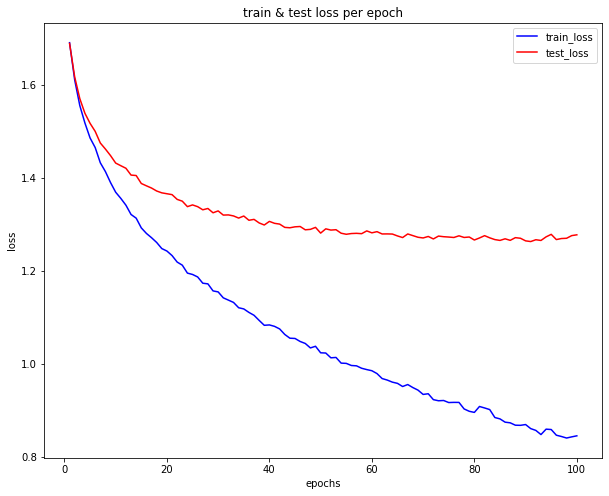

In [13]:
plt.figure(figsize=(10,8))

plt.plot(range(1, 101), train_loss, 'b-', label='train_loss')
plt.plot(range(1, 101), test_loss, 'r-', label='test_loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('train & test loss per epoch')
plt.legend()

plt.show()

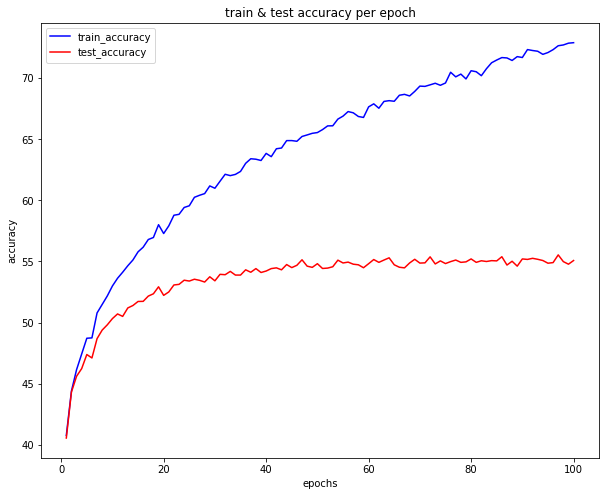

In [14]:
plt.figure(figsize=(10,8))

plt.plot(range(1, 101), train_accuracy, 'b-', label='train_accuracy')
plt.plot(range(1, 101), test_accuracy, 'r-', label='test_accuracy')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('train & test accuracy per epoch')
plt.legend()

plt.show()

In [15]:
print(f'Best epoch: {best_epoch}')
print(f'Train: accuracy: {best_train_accuracy:>0.1f}%, avg loss: {best_train_loss:>8f}')
print(f'Test: accuracy: {best_test_accuracy:>0.1f}%, avg loss: {best_test_loss:>8f}')

Best epoch: 97
Train: accuracy: 72.6%, avg loss: 0.843372
Test: accuracy: 55.5%, avg loss: 1.269634


## 5.4 Model metrics

In [16]:
print(f'Train:\n{classification_report(best_train_y, best_train_pred, target_names=target_names)}')
print(f'Test:\n{classification_report(best_test_y, best_test_pred, target_names=target_names)}')

Train:
              precision    recall  f1-score   support

    airplane       0.74      0.76      0.75      5000
  automobile       0.81      0.86      0.84      5000
        bird       0.64      0.52      0.58      5000
         cat       0.52      0.53      0.53      5000
        deer       0.69      0.68      0.68      5000
         dog       0.60      0.57      0.58      5000
        frog       0.75      0.86      0.80      5000
       horse       0.85      0.80      0.83      5000
        ship       0.77      0.87      0.82      5000
       truck       0.87      0.81      0.84      5000

    accuracy                           0.73     50000
   macro avg       0.72      0.73      0.72     50000
weighted avg       0.72      0.73      0.72     50000

Test:
              precision    recall  f1-score   support

    airplane       0.62      0.63      0.62      1000
  automobile       0.66      0.68      0.67      1000
        bird       0.47      0.36      0.41      1000
         ca

<AxesSubplot:>

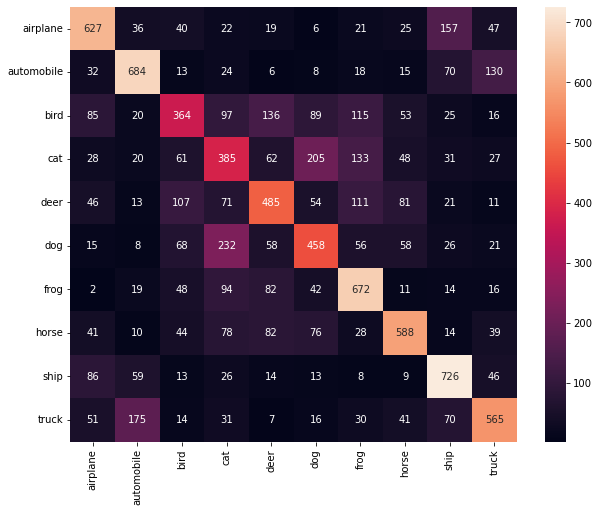

In [17]:
cm = confusion_matrix(best_test_y, best_test_pred)
sns.heatmap(cm, annot=True, fmt='', xticklabels=target_names, yticklabels=target_names, ax=plt.subplots(figsize=(10,8))[1])

## 5.5 Save model

In [18]:
torch.save(best_model_state_dict, '../saved-model/nn-weights.pth')